In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.descriptivestats import describe
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy as scipy
import arch

# import fredapi as fa
# from local_settings import fred as settings
# fred = fa.Fred(settings['api_key'])

In [40]:
assets = pd.read_csv('assets.csv').set_index('DATE')

In [41]:
assets.index = pd.to_datetime(assets.index, dayfirst=True)

In [42]:
assets.index

DatetimeIndex(['2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12',
               ...
               '2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
               '2023-09-22', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29'],
              dtype='datetime64[ns]', name='DATE', length=870, freq=None)

In [43]:
type(assets.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [2]:
# tickers = []

# with open('tickers.txt') as f:
#     for line in f:
#         tickers.append(line.strip())

In [3]:
# assets = {}

# for ticker in tickers:
#     assets[ticker] = fred.get_series(ticker).loc['2020-06-01':'2023-10-01']

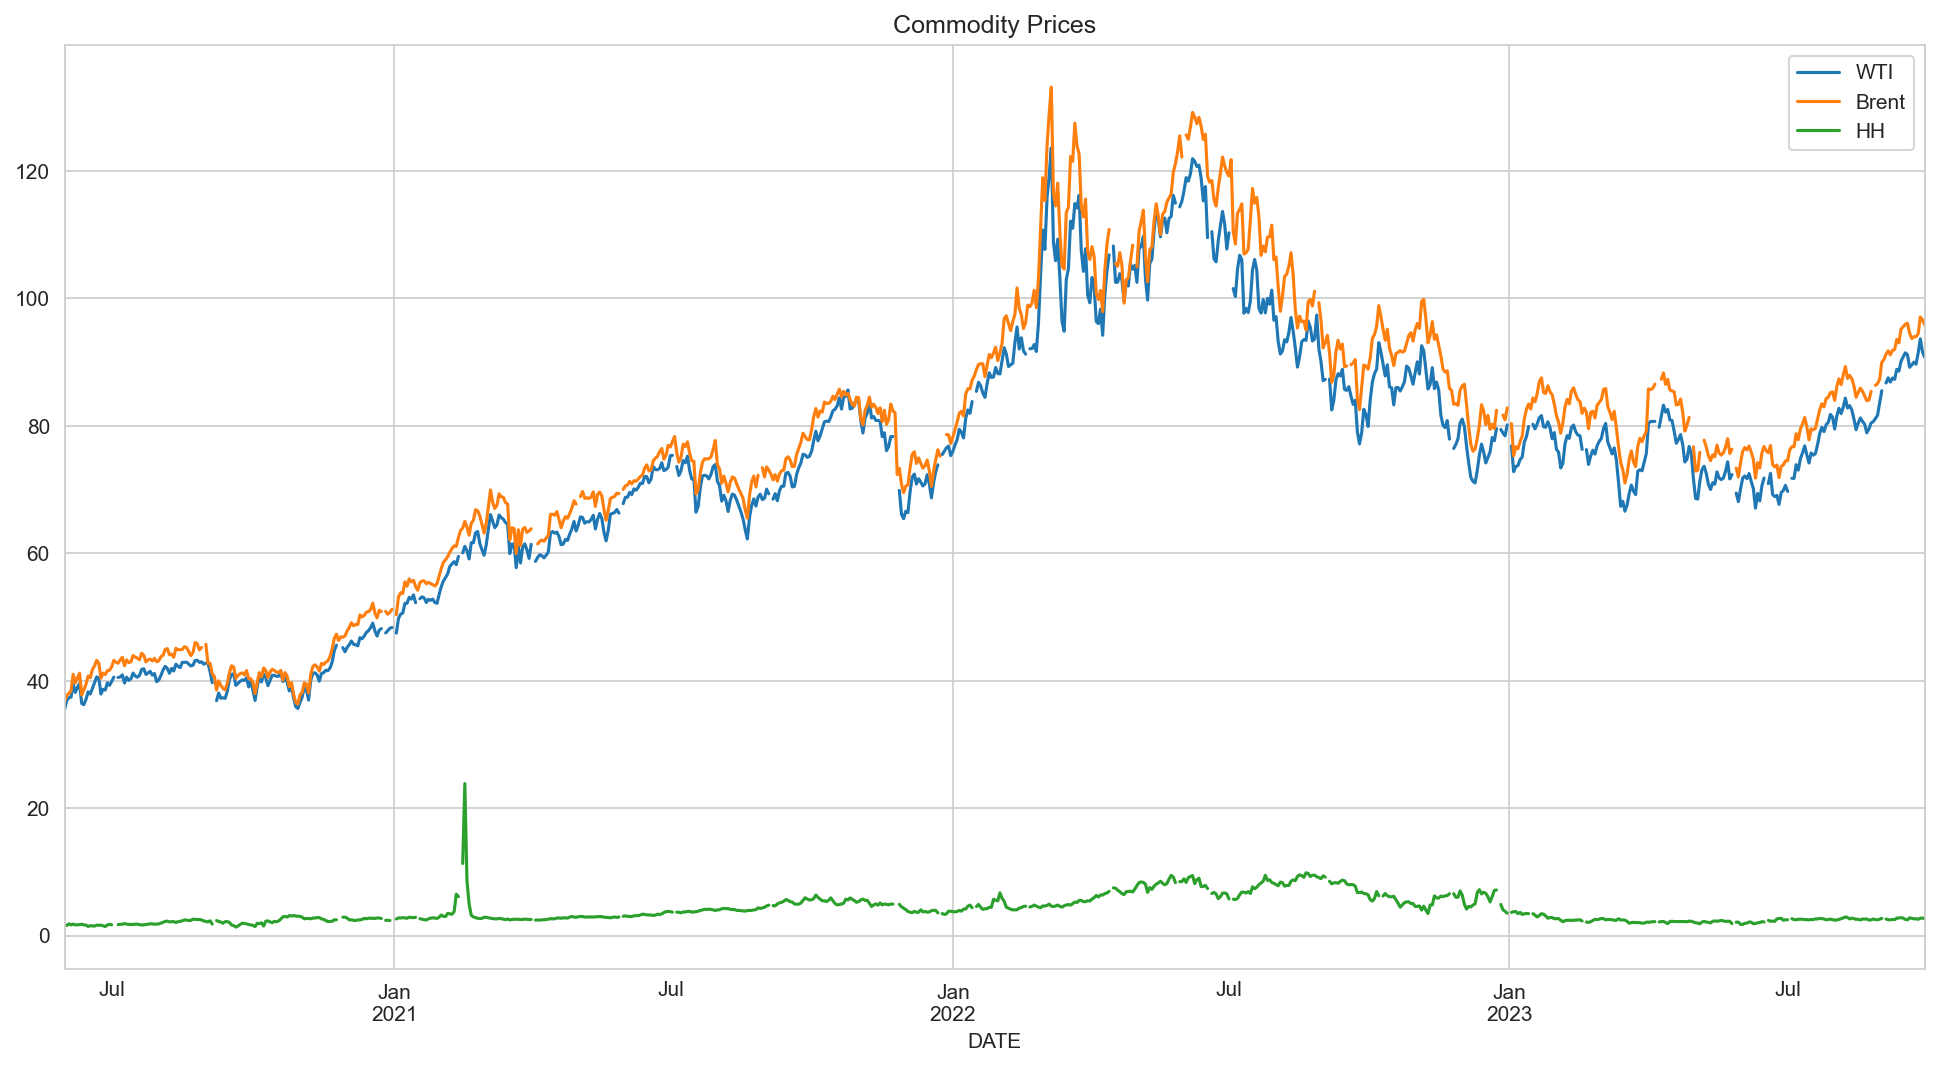

In [44]:
plt.figure(figsize=(16, 8), dpi=150) 

assets['DCOILWTICO'].plot(label='WTI')
assets['DCOILBRENTEU'].plot(label='Brent')
assets['DHHNGSP'].plot(label='HH')
#assets['PNGASEUUSDM'].plot(label='TTF')

plt.title('Commodity Prices')
plt.legend()

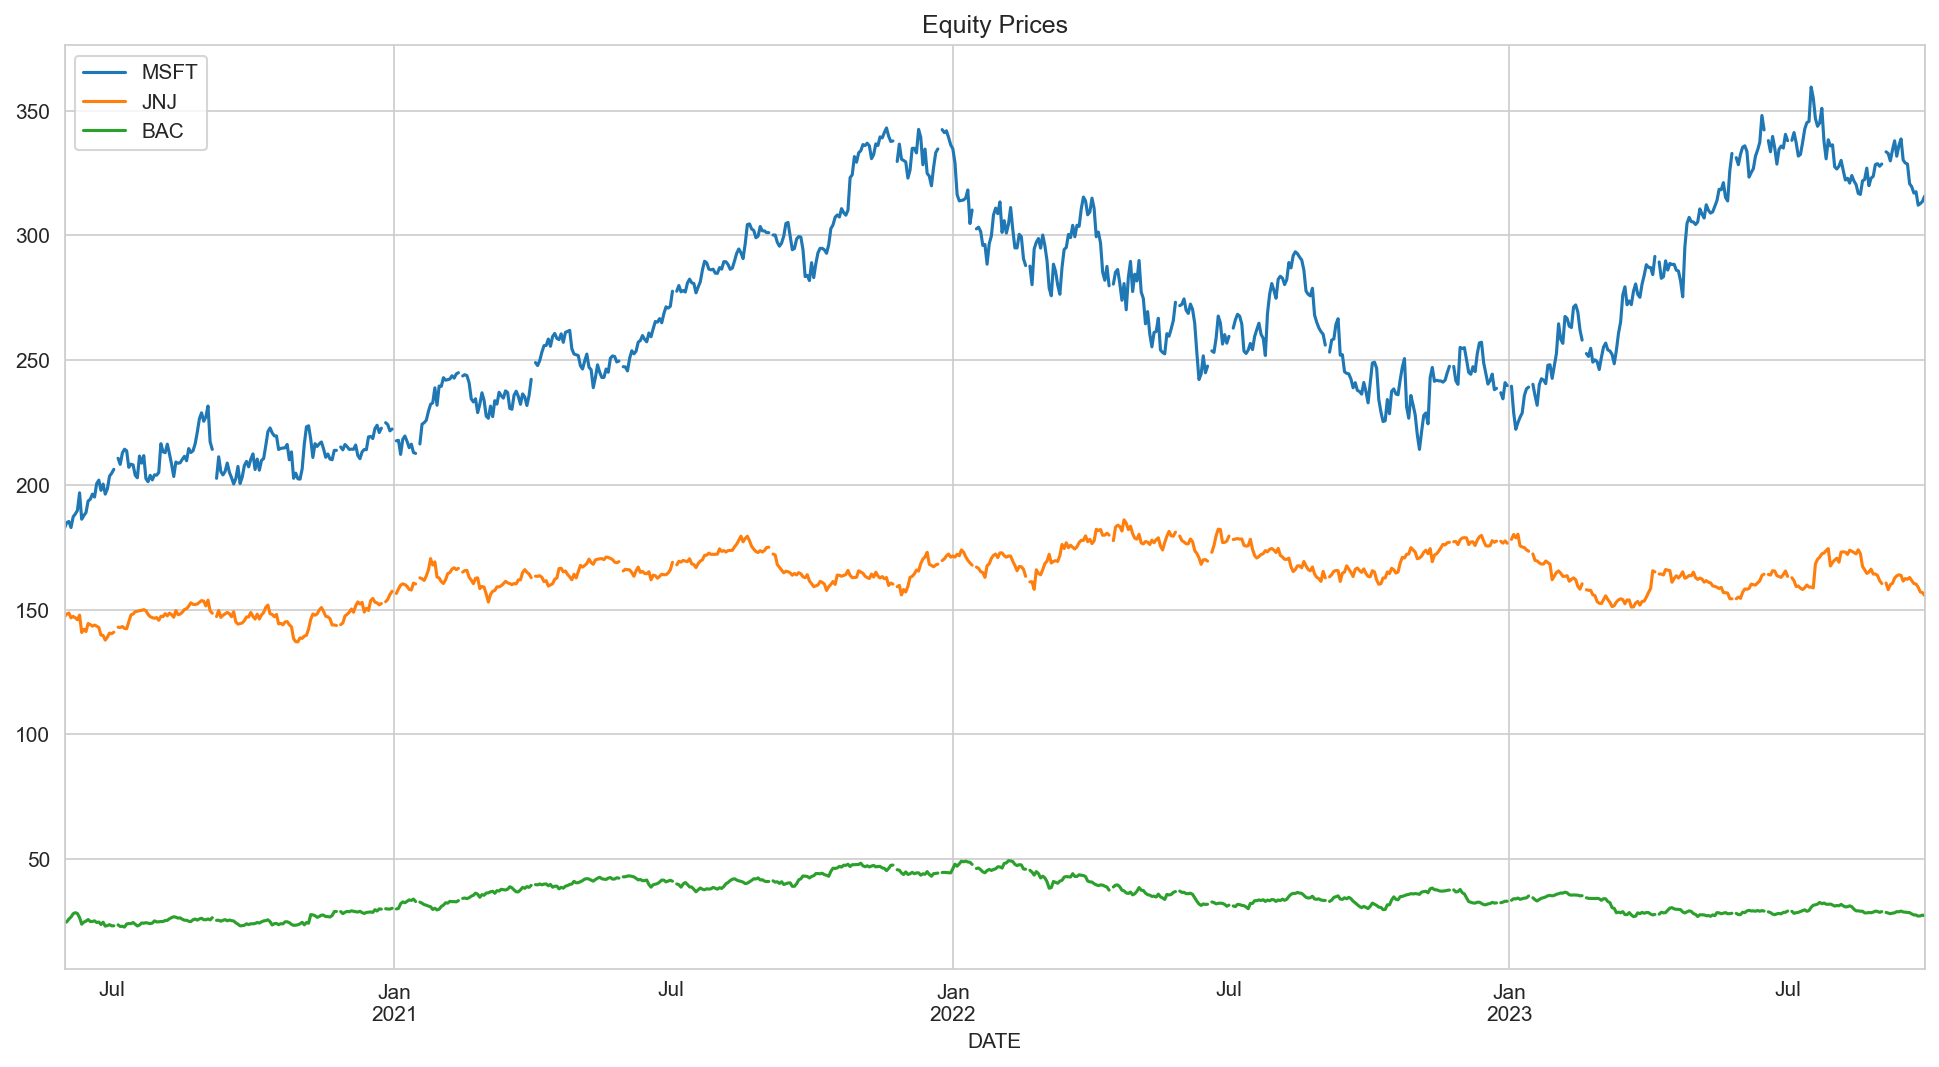

In [45]:
plt.figure(figsize=(16, 8), dpi=150) 

assets['MSFT'].plot(label='MSFT')
assets['JNJ'].plot(label='JNJ')
assets['BAC'].plot(label='BAC')

plt.title('Equity Prices')
plt.legend()

In [5]:
# returns = pd.DataFrame.from_dict(assets).fillna(method='ffill')

# for ticker in tickers:
#     returns['Ret_' + ticker] = np.log(returns[ticker]) - np.log(returns[ticker].shift(1))

# returns = returns.dropna() # only nulls left are the starting returns; will also have an issue with negative prices when series extended back far enough

# returns

In [46]:
returns_wti = assets[['DCOILWTICO']].dropna()
returns_brent = assets[['DCOILBRENTEU']].dropna()
returns_hh = assets[['DHHNGSP']].dropna()
returns_msft = assets[['MSFT']].dropna()
returns_jnj = assets[['JNJ']].dropna()
returns_bac = assets[['BAC']].dropna()

returns = {
    'DCOILWTICO': returns_wti,
    'DCOILBRENTEU': returns_brent,
    'DHHNGSP': returns_hh,
    'MSFT': returns_msft,
    'JNJ': returns_jnj,
    'BAC': returns_bac,
}

for key, value in returns.items():
    value['Ret_' + key] = np.log(value[key]) - np.log(value[key].shift(1))
    returns[key] = value.dropna()

returns_wti = returns['DCOILWTICO']
returns_brent = returns['DCOILBRENTEU']
returns_hh = returns['DHHNGSP']
returns_msft = returns['MSFT']
returns_jnj = returns['JNJ']
returns_bac = returns['BAC']

returns_wti

DCOILWTICO  Ret_DCOILWTICO
DATE                                  
2020-06-02       36.88        0.038418
2020-06-03       37.33        0.012128
2020-06-04       37.42        0.002408
2020-06-05       39.49        0.053842
2020-06-08       38.17       -0.033998
...                ...             ...
2023-09-25       89.68       -0.003562
2023-09-26       91.43        0.019326
2023-09-27       93.67        0.024204
2023-09-28       91.65       -0.021801
2023-09-29       90.77       -0.009648

[837 rows x 2 columns]

# WTI

In [47]:
class data_extraction:
    def __init__(self, data, asset):
        self.data = data
        self.asset = asset
        self.series = self.extract_series()

    def extract_series(self):
        return self.data[self.asset]

In [48]:
class analysis(data_extraction):
    def __init__(self, data, asset):
        data_extraction.__init__(self, data, asset)
        self.x = self.norm_dist()
    
    def acf_log_ret(self):
        plot_acf(self.series, lags=30, title='ACF Log Returns ' + self.asset)
        plt.show()
        
    def acf_sq_log_ret(self):
        plot_acf(self.series**2, lags=30, title='ACF Squared Log Returns ' + self.asset)
        plt.show()
        
    def describe(self):
        return describe(self.series)

    def norm_dist(self):
        mu, sigma = np.mean(self.series), np.std(self.series)
        x = np.random.normal(mu, sigma, 1000)
        x = pd.Series(x, name='Normal Distribution')
        return x
    
    def asset_hist_v_norm(self):
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax2.grid(False)
        ax1.hist(self.series, bins=30)
        g1 = sns.kdeplot(self.x, ax=ax2, color='r')
        g1.set(ylabel=None)
        g1.set(yticklabels=[])
        plt.title('Histogram vs Normal Distribution ' + self.asset);
    
    def asset_dist_v_norm(self):
        sns.set_style('whitegrid')
        series_norm = pd.concat([self.series, self.x], axis=1)
        sns.kdeplot(data=series_norm, bw_method=0.5)
        plt.title('Distribution vs Normal Distribution ' + self.asset);
    
    def arch_test(self):
        return het_arch(self.series)
    
    def arch_test_lag5(self):
        return het_arch(self.series, nlags=5)

In [49]:
analysis_wti = analysis(returns_wti, 'Ret_DCOILWTICO')

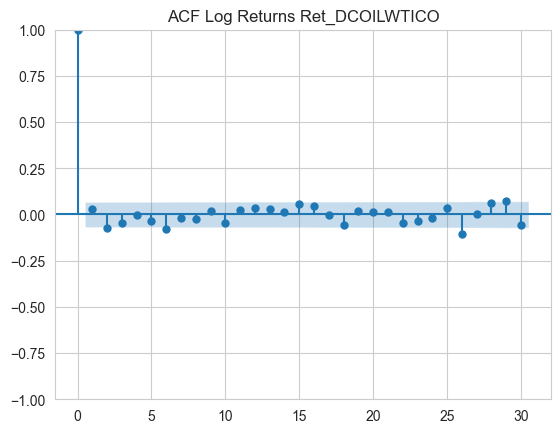

In [50]:
analysis_wti.acf_log_ret()

ACF of log returns indicates some AR/MA property among returns with lags 2, 5, 9, 12 being statistically significant

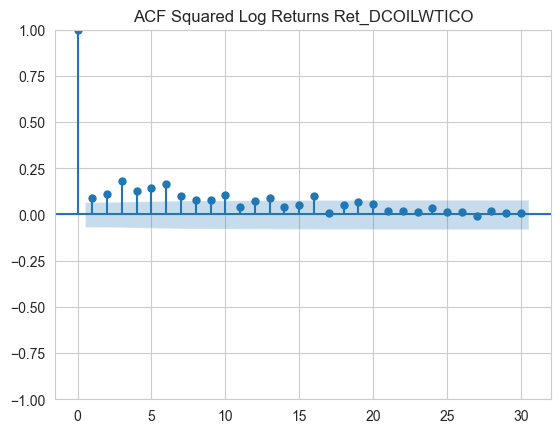

In [51]:
analysis_wti.acf_sq_log_ret()

ACF of squared log returns indicates some AR property among squared returns for (G)ARCH with lags up to 9 and several others being statistically significant

In [52]:
analysis_wti.describe()

Ret_DCOILWTICO
nobs                8.370000e+02
missing             0.000000e+00
mean                1.121957e-03
std_err             8.550105e-04
upper_ci            2.797747e-03
lower_ci           -5.538329e-04
std                 2.473627e-02
iqr                 2.931417e-02
iqr_normal          2.173063e-02
mad                 1.857440e-02
mad_normal          2.327955e-02
coef_var            2.204743e+01
range               2.099119e-01
max                 8.214099e-02
min                -1.277709e-01
skew               -6.024564e-01
kurtosis            5.035300e+00
jarque_bera         1.950999e+02
jarque_bera_pval    4.311147e-43
mode                0.000000e+00
mode_freq           3.584229e-03
median              3.055416e-03
1%                 -7.254021e-02
5%                 -4.087702e-02
10%                -3.107855e-02
25%                -1.218929e-02
50%                 3.055416e-03
75%                 1.712488e-02
90%                 2.762305e-02
95%                 3.658887e-02
99%                 5.780795e-02

Negative skewness

High kurtosis

jarque_bera_pval close to zero --> H0 normality rejected

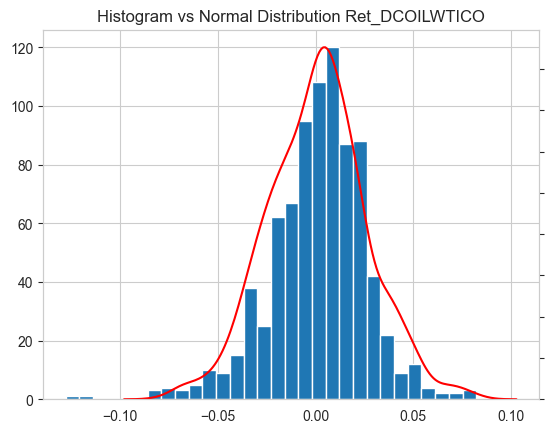

In [53]:
analysis_wti.asset_hist_v_norm()

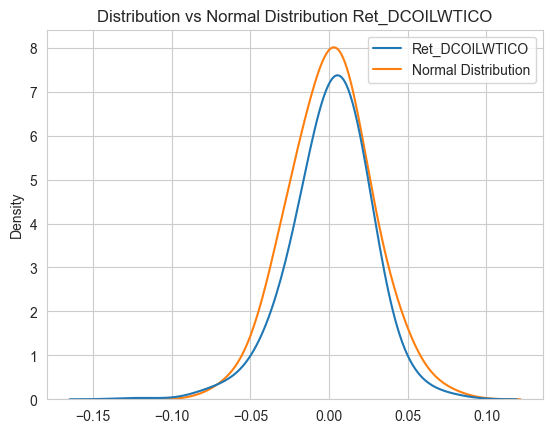

In [54]:
analysis_wti.asset_dist_v_norm()

Leptokurtic distribution

Negative skew

Fat tails, particularly for negative returns

In [55]:
analysis_wti.arch_test()

(67.98661794515141,
 1.0834985659265207e-10,
 7.309104365597942,
 3.809806640188877e-11)

In [56]:
analysis_wti.arch_test_lag5()

(54.0434898191126,
 2.053132070102216e-10,
 11.476200020540348,
 9.936828107401028e-11)

H0 no arch effects rejected (p-value close to zero)

## Model Run

In [187]:
class garch_base(data_extraction):
    def __init__(self, approach, proportion, p, q, mean, data, asset, lags, o, vol, dist, power):
        data_extraction.__init__(self, data, asset)
        self.approach = approach
        self.proportion = proportion
        self.p = p
        self.o = o
        self.q = q
        self.mean = mean
        self.lags = lags
        self.vol = vol
        self.dist = dist
        self.power = power
        self.train = self.series.iloc[:int(self.proportion*len(self.series))]
        self.test = self.series.iloc[int(self.proportion*len(self.series)):]
        self.last_train_date = datetime.strftime(self.train.index[-1], '%Y-%m-%d')
        self.res_garch = self.fit()
    
    def specs(self):
        return 'ar' + str(self.lags) + 'garch' + str(self.p) + str(self.q)
    
    def fit(self):
        if self.approach == 'fixed':
            garch = arch.arch_model(self.train, mean=self.mean, lags=self.lags, vol=self.vol, p=self.p, o=self.o, q=self.q, power=self.power, dist=self.dist)
            res_garch = garch.fit()
        elif self.approach == 'roll1d':
            garch = arch.arch_model(self.series, mean=self.mean, lags=self.lags, vol=self.vol, p=self.p, o=self.o, q=self.q, power=self.power, dist=self.dist)
            res_garch = garch.fit(last_obs=self.last_train_date)
            
        return res_garch
    
    def summary(self):
        res_garch_summary = self.res_garch.summary()
        
        return res_garch_summary
    
    def plot(self):
        fig = self.res_garch.plot()
        plt.show()
    
    def autocorr(self):
        lb = acorr_ljungbox(self.res_garch.std_resid**2, [10, 15, 20])
        
        return lb
    
    def info_crit(self):
        ic_out = {'AIC': [self.res_garch.aic], 'BIC': [self.res_garch.bic]}
        ic = pd.DataFrame(data=ic_out)
        
        return ic
    
    def acf_stan(self):
        plot_acf(self.res_garch.std_resid, lags=30, title='ACF of Standardized Residuals')
        plt.show()
        
    def acf_sq_stan(self):
        plot_acf(self.res_garch.std_resid**2, lags=30, title='ACF of Squared Standardized Residuals')
        plt.show()

class garch(garch_base):
    def __init__(self, approach, proportion, p, q, mean, data, asset, lags, o, vol, dist, power):
        garch_base.__init__(self, approach, proportion, p, q, mean, data, asset, lags, o, vol, dist, power)
        self.forecast = self.forecast()
        self.exclusion_dates = self.get_exclusion_dates()
        self.forecast_mean_values = self.forecast_mean_values()
        self.forecast_std_values = self.forecast_std_values()
        self.forecast_vs_test = self.forecast_vs_test()
        self.stats_test = self.get_stats_test()

    def forecast(self):
        forecast = self.res_garch.forecast(horizon=len(self.test))
        
        return forecast
    
#     def forecast_out(self):
#         return self.forecast
    
    def get_exclusion_dates(self):
        return [date for date in self.forecast.mean.index.strftime('%Y-%m-%d').tolist() if date <= self.last_train_date]
    
    def forecast_mean_values(self):
        if self.approach == 'fixed':
            forecast_mean_values = self.forecast.mean.iloc[0]
        elif self.approach == 'roll1d':
            forecast_mean_values = self.forecast.mean.drop(self.exclusion_dates)
            forecast_mean_values = forecast_mean_values.iloc[:,0]
        
        return forecast_mean_values
    
    def forecast_mean(self):
#         forecast_mean = self.forecast.mean
#         forecast_mean.iloc[0].plot()
        self.forecast_mean_values.plot()

    def forecast_std_values(self):
        forecast_vol_raw = self.forecast.variance**0.5
        
        if self.approach == 'fixed':
            forecast_std_values = forecast_vol_raw.iloc[0]
        elif self.approach == 'roll1d':
            forecast_std_values = forecast_vol_raw.drop(self.exclusion_dates)
            forecast_std_values = forecast_std_values.iloc[:,0]
        
        return forecast_std_values
#         std3 = std2.transpose()
#         for i, col in enumerate(std3.columns):
#             std3[col] = std3[col].shift(i)
#         std3
#         std3.plot()
    
    def forecast_std(self):
#         forecast_stdev = self.forecast.variance**0.5
#         forecast_stdev.iloc[0].plot()
        self.forecast_std_values.plot()
    
    def forecast_vs_test(self):
#         if self.approach == 'fixed':
#             forecast_mean_values = self.forecast.mean.iloc[0].values
#         elif self.approach == 'roll1d':
#             exclusion_dates = [date for date in self.forecast.mean.index.strftime('%Y-%m-%d').tolist() if date <= last_train_date]
#             forecast_mean_values = self.forecast.mean.drop(exclusion_dates)
#             forecast_mean_values = forecast_mean_values.iloc[:,0].values

        forecast_mean_values = self.forecast_mean_values.values
        
        forecast_mean = pd.Series(forecast_mean_values, index=self.test.index)
        self.train.rename('Ret_Train', inplace=True)
        self.test.rename('Ret_Test', inplace=True)
        forecast_mean.rename('Ret_Forecast', inplace=True)
        forecast_vs_test = pd.concat([self.train, self.test, forecast_mean], axis=1)

        forecast_vs_test['Ret_Test_Broad'] = forecast_vs_test[['Ret_Train','Ret_Test']].max(axis=1)

        forecast_vs_test['Vol_Train'] = forecast_vs_test[['Ret_Train']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test_Broad'] = forecast_vs_test[['Ret_Test_Broad']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test'] = np.where(forecast_vs_test['Ret_Test'].isna(), forecast_vs_test['Ret_Test'], forecast_vs_test['Vol_Test_Broad'])

#         forecast_vol_raw = self.forecast.variance**0.5
#         if self.approach == 'fixed':
#             forecast_std_values = forecast_vol_raw.iloc[0].values
#         elif self.approach == 'roll1d':
#             forecast_std_values = forecast_vol_raw.drop(exclusion_dates)
#             forecast_std_values = forecast_std_values.iloc[:,0].values
        
        forecast_std_values = self.forecast_std_values.values
        
        forecast_vs_test_condvol = pd.Series(forecast_std_values, index=self.test.index) #conditional vol
        forecast_vs_test_condvol.rename('Vol_Forecast', inplace=True)
        forecast_vs_test = pd.concat([forecast_vs_test, forecast_vs_test_condvol], axis=1)

        return forecast_vs_test
    
    def forecast_vs_test_mean_plot(self):
        self.forecast_vs_test[['Ret_Train','Ret_Test','Ret_Forecast']].plot()
        
    def forecast_vs_test_vol_plot(self):
        self.forecast_vs_test[['Vol_Train','Vol_Test','Vol_Forecast']].plot()
    
    def get_stats_test(self):
        reduced_test = self.forecast_vs_test
        reduced_test = reduced_test[reduced_test.index > self.last_train_date]
        reduced_test['se_mean'] = (reduced_test['Ret_Forecast'] - reduced_test['Ret_Test']) ** 2
        reduced_test['se_vol'] = (reduced_test['Vol_Forecast'] - reduced_test['Vol_Test']) ** 2
        reduced_test['ae_mean'] = abs(reduced_test['Ret_Forecast'] - reduced_test['Ret_Test'])
        reduced_test['ae_vol'] = abs(reduced_test['Vol_Forecast'] - reduced_test['Vol_Test'])
        reduced_test['pe_mean'] = abs((reduced_test['Ret_Forecast'] - reduced_test['Ret_Test']) / reduced_test['Ret_Test'])
        reduced_test['pe_vol'] = abs((reduced_test['Vol_Forecast'] - reduced_test['Vol_Test']) / reduced_test['Vol_Test'])

        stats_dict = {
            'Series': ['Mean', 'Vol'],
            'RMSE'  : [np.sqrt(np.mean(reduced_test['se_mean'].tolist())), np.sqrt(np.mean(reduced_test['se_vol'].tolist()))],
            'MAE'   : [np.mean(reduced_test['ae_mean'].tolist()), np.mean(reduced_test['ae_vol'].tolist())],
            'MAPE'  : [np.mean(reduced_test['pe_mean'].tolist()), np.mean(reduced_test['pe_vol'].tolist())],
        }
        
        return pd.DataFrame(stats_dict)

In [190]:
class garch_full(garch_base):
    def __init__(self, approach, grid_proportion, grid_p, grid_q, mean, data, asset, grid_lags, grid_o, grid_vol, grid_dist, grid_power):
        self.approach = approach
        self.grid_proportion = grid_proportion
        self.grid_p = grid_p
        self.grid_q = grid_q
        self.mean = mean
        self.data = data
        self.asset = asset
        self.grid_lags = grid_lags
        self.grid_o = grid_o
        self.grid_vol = grid_vol
        self.grid_dist = grid_dist
        self.grid_power = grid_power
        self.optimised_params = self.optimise()
        
    def optimise(self):
        min_aic = 1000000
        min_proportion = 0
        min_p = 0
        min_q = 0
        min_lags = 0
        min_o = 10
        min_vol = 'NONE'
        min_dist = 'NONE'
        min_power = 10.0
        
        for proportion in self.grid_proportion:
            for p in self.grid_p:
                for q in self.grid_q:
                    for lags in self.grid_lags:
                        for o in self.grid_o:
                            for vol in self.grid_vol:
                                for dist in self.grid_dist:
                                    for power in self.grid_power:
                                        garch_base.__init__(self, self.approach, proportion, p, q, self.mean, self.data, self.asset, lags, o, vol, dist, power)
                                        ic = self.info_crit()
                                        aic = ic['AIC'][0]
                                        if aic < min_aic:
                                            min_aic = aic
                                            min_proportion = self.proportion
                                            min_p = self.p
                                            min_q = self.q
                                            min_lags = self.lags
                                            min_o = self.o
                                            min_vol = self.vol
                                            min_dist = self.dist
                                            min_power = self.power
        
        print('\nLowest AIC: ' + str(min_aic))
        print('\nOptimal proportion: ' + str(min_proportion))
        print('\nOptimal p: ' + str(min_p))
        print('\nOptimal q: ' + str(min_q))
        print('\nOptimal lags: ' + str(min_lags))
        print('\nOptimal o: ' + str(min_o))
        print('\nOptimal vol: ' + min_vol)
        print('\nOptimal dist: ' + min_dist)
        print('\nOptimal power: ' + str(min_power))
        
        return [min_proportion, min_p, min_q, min_lags, min_o, min_vol, min_dist, min_power]

In [193]:
class garch_main(garch):
    def __init__(self, approach, grid_proportion, grid_p, grid_q, mean, data, asset, grid_lags, grid_o, grid_vol, grid_dist, grid_power):
        self.approach = approach
        self.grid_proportion = grid_proportion
        self.grid_p = grid_p
        self.grid_q = grid_q
        self.mean = mean
        self.data = data
        self.asset = asset
        self.grid_lags = grid_lags
        self.grid_o = grid_o
        self.grid_vol = grid_vol
        self.grid_dist = grid_dist
        self.grid_power = grid_power
        self.optimal_params = self.get_optimal_params()
        self.proportion = self.optimal_params[0]
        self.p = self.optimal_params[1]
        self.q = self.optimal_params[2]
        self.lags = self.optimal_params[3]
        self.o = self.optimal_params[4]
        self.vol = self.optimal_params[5]
        self.dist = self.optimal_params[6]
        self.power = self.optimal_params[7]
        garch.__init__(self, self.approach, self.proportion, self.p, self.q, self.mean, self.data, self.asset, self.lags, self.o, self.vol, self.dist, self.power)
    
    def get_optimal_params(self):
        garch_full_instance = garch_full(self.approach, self.grid_proportion, self.grid_p, self.grid_q, self.mean, self.data, self.asset, self.grid_lags, self.grid_o, self.grid_vol, self.grid_dist, self.grid_power)
        return garch_full_instance.optimised_params

In [194]:
class strategy(garch_main):
    def __init__(self, approach, grid_proportion, grid_p, grid_q, mean, data, asset, grid_lags, grid_o, grid_vol, grid_dist, grid_power):
        garch_main.__init__(self, approach, grid_proportion, grid_p, grid_q, mean, data, asset, grid_lags, grid_o, grid_vol, grid_dist, grid_power)
        self.trade = self.build()
    
    def build(self):
        trade = self.forecast_vs_test
        
        last_train = trade.iloc[lambda x: x.index == self.last_train_date]
        last_vol_train = last_train['Vol_Train'][0]

        trade['direction'] = np.where(trade['Ret_Train'].notna(), 0, np.where(trade['Ret_Forecast'] > 0, 1, -1))
        trade['amplifier'] = np.where(trade['Ret_Train'].notna(), 0, np.where(trade['Vol_Forecast'] > last_vol_train, 2, 1))
        trade['position'] = trade['direction'] * trade['amplifier']
        trade['pnl_gross'] = trade['Ret_Test'] * trade['position']
        trade['pnl_gross_cum'] = trade['pnl_gross'].cumsum()
        trade['position_lag'] = trade['position'].shift(1)
        trade['cost'] = np.where(trade['position'] == trade['position_lag'], 0, 0.05)
        trade['pnl_net'] = trade['pnl_gross'] - trade['cost']
        trade['pnl_net_cum'] = trade['pnl_net'].cumsum()
        
        trade = trade.iloc[lambda x: x.index >= self.last_train_date]
        
        return trade
    
    def pos(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['direction'].plot(label='Direction')
        self.trade['amplifier'].plot(label='Amplifier')
        self.trade['position'].plot(label='Position')
        self.trade['cost'].plot(label='Cost')

        plt.title('Trading Positions ' + self.asset + ' ' + self.specs())
        plt.legend()
        
    def pnl_gross(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['pnl_gross'].plot(label='Gross P&L')
        self.trade['pnl_gross_cum'].plot(label='Cumulative Gross P&L')

        plt.title('Trading Gross P&L ' + self.asset + ' ' + self.specs())
        plt.legend()
    
    def pnl_net(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['pnl_net'].plot(label='Net P&L')
        self.trade['pnl_net_cum'].plot(label='Cumulative Net P&L')

        plt.title('Trading Net P&L ' + self.asset + ' ' + self.specs())
        plt.legend()
        
    def sr(self):
        sr_gross = 252 ** 0.5 * np.mean(self.trade['pnl_gross']) / np.std(self.trade['pnl_gross'])
        sr_net = 252 ** 0.5 * np.mean(self.trade['pnl_net']) / np.std(self.trade['pnl_net'])
        
        return pd.DataFrame({'Metric': ['SR Gross', 'SR Net'], 'Value': [sr_gross, sr_net]})

In [195]:
grid_proportion = [0.9, 0.8, 0.7]
grid_p = [1, 2]
grid_q = [1, 2]
grid_lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
grid_o = [0, 1]
grid_vol = ['GARCH', 'EGARCH', 'FIGARCH', 'APARCH']
grid_dist = ['normal', 't', 'skewt', 'ged']
grid_power = [1.0, 2.0]

In [196]:
strat_wti = strategy('roll1d', grid_proportion, grid_p, grid_q, 'AR', returns_wti, 'Ret_DCOILWTICO', grid_lags, grid_o, grid_vol, grid_dist, grid_power)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5010194.124366024
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2867.3658674460994
Iteration:      3,   Func. Count:     31,   Neg. LLF: 6311.882054276841
Iteration:      4,   Func. Count:     42,   Neg. LLF: -918.7794251981009
Iteration:      5,   Func. Count:     50,   Neg. LLF: -1719.443735348656
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1713.9371176248346
Iteration:      7,   Func. Count:     64,   Neg. LLF: -1724.1636091325563
Iteration:      8,   Func. Count:     71,   Neg. LLF: -1724.409250714295
Iteration:      9,   Func. Count:     77,   Neg. LLF: -1724.4120044919512
Iteration:     10,   Func. Count:     83,   Neg. LLF: -1724.4120286060938
Iteration:     11,   Func. Count:     89,   Neg. LLF: -1724.4120295279854
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1724.4120295279854
            Iterations: 11
            Function evaluations: 89
            Gradient

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:     89,   Neg. LLF: 970.6445537643247
Iteration:      9,   Func. Count:     96,   Neg. LLF: 27207.69732008273
Iteration:     10,   Func. Count:    104,   Neg. LLF: 2061.3261797792666
Iteration:     11,   Func. Count:    114,   Neg. LLF: 2053.8611111306627
Iteration:     12,   Func. Count:    122,   Neg. LLF: 1072.3348641234215
Iteration:     13,   Func. Count:    131,   Neg. LLF: 1548.6416824946136
Iteration:     14,   Func. Count:    141,   Neg. LLF: -815.8970471227253
Iteration:     15,   Func. Count:    149,   Neg. LLF: 85645.69630236621
Iteration:     16,   Func. Count:    157,   Neg. LLF: 471.9000060853677
Iteration:     17,   Func. Count:    165,   Neg. LLF: 35344.42154916871
Iteration:     18,   Func. Count:    182,   Neg. LLF: 2504.1586661838483
Iteration:     19,   Func. Count:    190,   Neg. LLF: 14649.710861501559
Iteration:     20,   Func. Count:    199,   Neg. LLF: 1011.2607734756307
Iteration:     21,   Func. Count:    207,   Neg. LLF: 12

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     74,   Neg. LLF: 64133.20071730815
Iteration:      7,   Func. Count:     85,   Neg. LLF: 15240.30625954767
Iteration:      8,   Func. Count:     96,   Neg. LLF: 39552.81303110765
Iteration:      9,   Func. Count:    105,   Neg. LLF: 4443.5401423398225
Iteration:     10,   Func. Count:    114,   Neg. LLF: 4454.124899897544
Iteration:     11,   Func. Count:    123,   Neg. LLF: 5686.333537875769
Iteration:     12,   Func. Count:    132,   Neg. LLF: 4255.827478871821
Iteration:     13,   Func. Count:    141,   Neg. LLF: 2884.1363563717728
Iteration:     14,   Func. Count:    149,   Neg. LLF: 2706.4829636009827
Iteration:     15,   Func. Count:    157,   Neg. LLF: 4649.300534432313
Iteration:     16,   Func. Count:    166,   Neg. LLF: 2449.2723870418295
Iteration:     17,   Func. Count:    174,   Neg. LLF: 3247.5659366845675
Iteration:     18,   Func. Count:    183,   Neg. LLF: 2377.4294085015163
Iteration:     19,   Func. Count:    191,   Neg. LLF: 2184

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     12,   Func. Count:    134,   Neg. LLF: inf
Iteration:     13,   Func. Count:    147,   Neg. LLF: 5.2498858531243995e+122
Iteration:     14,   Func. Count:    156,   Neg. LLF: 1.3652361908331727e+72
Iteration:     15,   Func. Count:    165,   Neg. LLF: 1.114485153729842e+83
Iteration:     16,   Func. Count:    178,   Neg. LLF: 48260.830464163315
Iteration:     17,   Func. Count:    190,   Neg. LLF: 4084404751.000424
Iteration:     18,   Func. Count:    202,   Neg. LLF: 53944845654.37508
Iteration:     19,   Func. Count:    214,   Neg. LLF: -1601.5879006862683
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1601.5879011763832
            Iterations: 23
            Function evaluations: 214
            Gradient evaluations: 19
Iteration:      1,   Func. Count:      7,   Neg. LLF: 330903799730494.25
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9446831780.136711
Iteration:      3,   Func. Count:     29,   Neg. LLF: 390119083

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     25,   Func. Count:    262,   Neg. LLF: 1146.7664167576713
Iteration:     26,   Func. Count:    269,   Neg. LLF: 1079.8928574536449
Iteration:     27,   Func. Count:    276,   Neg. LLF: 1323.7203389548554
Iteration:     28,   Func. Count:    284,   Neg. LLF: 19730.600589825484
Iteration:     29,   Func. Count:    292,   Neg. LLF: 583.1819445258282
Iteration:     30,   Func. Count:    299,   Neg. LLF: 432.61856996452093
Iteration:     31,   Func. Count:    306,   Neg. LLF: 403.70248965414146
Iteration:     32,   Func. Count:    313,   Neg. LLF: 2362.0244707310285
Iteration:     33,   Func. Count:    321,   Neg. LLF: 3676.982701852092
Iteration:     34,   Func. Count:    329,   Neg. LLF: 292.47563998764235
Iteration:     35,   Func. Count:    337,   Neg. LLF: 5840.629786690331
Iteration:     36,   Func. Count:    345,   Neg. LLF: 254187.63961771506
Iteration:     37,   Func. Count:    353,   Neg. LLF: 674973.8492263865
Iteration:     38,   Func. Count:    362,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 24386.923807133026
Iteration:      2,   Func. Count:     25,   Neg. LLF: 23855.78112714756
Iteration:      3,   Func. Count:     42,   Neg. LLF: 155161.77750217682
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2662.0089224478106
Iteration:      5,   Func. Count:     59,   Neg. LLF: 2767.962800026317
Iteration:      6,   Func. Count:     68,   Neg. LLF: 1180440.201201843
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4092625.4508783165
Iteration:      8,   Func. Count:     86,   Neg. LLF: 188709.996718308
Iteration:      9,   Func. Count:     94,   Neg. LLF: 297755.8806083099
Iteration:     10,   Func. Count:    102,   Neg. LLF: 345800.40069238126
Iteration:     11,   Func. Count:    111,   Neg. LLF: 638861.1310089685
Iteration:     12,   Func. Count:    121,   Neg. LLF: 1014864.7319047595
Iteration:     13,   Func. Count:    133,   Neg. LLF: 60153.90805269485
Iteration:     14,   Func. Count:    150,   Neg. LLF: 8920.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    177,   Neg. LLF: 339217.167660845
Iteration:     18,   Func. Count:    195,   Neg. LLF: 27037.42334599977
Iteration:     19,   Func. Count:    213,   Neg. LLF: 11141.422553349621
Iteration:     20,   Func. Count:    221,   Neg. LLF: 19228.22617119604
Iteration:     21,   Func. Count:    234,   Neg. LLF: 10112.976716212208
Iteration:     22,   Func. Count:    242,   Neg. LLF: 10814.032802602265
Iteration:     23,   Func. Count:    251,   Neg. LLF: 10808.931392740698
Iteration:     24,   Func. Count:    260,   Neg. LLF: 9903.685777178247
Iteration:     25,   Func. Count:    268,   Neg. LLF: 9476.311734068177
Iteration:     26,   Func. Count:    276,   Neg. LLF: 41259.682817754176
Iteration:     27,   Func. Count:    285,   Neg. LLF: 46912.09387765243
Iteration:     28,   Func. Count:    295,   Neg. LLF: 44024.05542906032
Iteration:     29,   Func. Count:    306,   Neg. LLF: 44580.14106766428
Iteration:     30,   Func. Count:    320,   Neg. LLF: 44662.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     29,   Func. Count:    306,   Neg. LLF: 44580.14106766428
Iteration:     30,   Func. Count:    320,   Neg. LLF: 44662.594946059704
Iteration:     31,   Func. Count:    335,   Neg. LLF: 44677.91752762173
Iteration:     32,   Func. Count:    350,   Neg. LLF: 55233.89631510137
Iteration:     33,   Func. Count:    368,   Neg. LLF: 43566.4063330279
Iteration:     34,   Func. Count:    378,   Neg. LLF: 42593.05364640552
Iteration:     35,   Func. Count:    386,   Neg. LLF: 12096.068912434761
Iteration:     36,   Func. Count:    394,   Neg. LLF: 42298.50443782924
Iteration:     37,   Func. Count:    404,   Neg. LLF: 47188.34755727404
Iteration:     38,   Func. Count:    419,   Neg. LLF: 52365.4783594165
Iteration:     39,   Func. Count:    437,   Neg. LLF: 36506.18992972614
Iteration:     40,   Func. Count:    445,   Neg. LLF: 34391.84064070646
Iteration:     41,   Func. Count:    453,   Neg. LLF: 21761.486835526004
Iteration:     42,   Func. Count:    461,   Neg. LLF: 15393.677

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00064

Iteration:      1,   Func. Count:      8,   Neg. LLF: 122891278.62112655
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1832236.287691171
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3948721.722474774
Iteration:      4,   Func. Count:     45,   Neg. LLF: -1125.758394895516
Iteration:      5,   Func. Count:     55,   Neg. LLF: -1718.4321884445162
Iteration:      6,   Func. Count:     63,   Neg. LLF: -1724.9447039676265
Iteration:      7,   Func. Count:     71,   Neg. LLF: -1737.2223432817768
Iteration:      8,   Func. Count:     79,   Neg. LLF: -1737.4738833148917
Iteration:      9,   Func. Count:     86,   Neg. LLF: -1737.4749354586386
Iteration:     10,   Func. Count:     93,   Neg. LLF: -1737.4751081091467
Iteration:     11,   Func. Count:    100,   Neg. LLF: -1737.4751399089291
Iteration:     12,   Func. Count:    107,   Neg. LLF: -1737.4751410464162
Iteration:     13,   Func. Count:    113,   Neg. LLF: -1737.4751410464237
Optimization terminated successfully    (Exi

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 28307.90648690614
Iteration:      2,   Func. Count:     27,   Neg. LLF: 1287.9991505713995
Iteration:      3,   Func. Count:     37,   Neg. LLF: 1170134.2139896993
Iteration:      4,   Func. Count:     46,   Neg. LLF: 165866.61641802447
Iteration:      5,   Func. Count:     56,   Neg. LLF: 59409.526531624724
Iteration:      6,   Func. Count:     65,   Neg. LLF: 62.676515141343856
Iteration:      7,   Func. Count:     73,   Neg. LLF: 143134.63142820832
Iteration:      8,   Func. Count:     83,   Neg. LLF: 2192.9685437273315
Iteration:      9,   Func. Count:     97,   Neg. LLF: 79.02658617055741
Iteration:     10,   Func. Count:    107,   Neg. LLF: 5983.472337354044
Iteration:     11,   Func. Count:    119,   Neg. LLF: -1462.4351377622559
Iteration:     12,   Func. Count:    128,   Neg. LLF: 3164.630186115773
Iteration:     13,   Func. Count:    137,   Neg. LLF: 1767.0128089217712
Iteration:     14,   Func. Count:    147,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:     77,   Neg. LLF: -1438.1796586118226
Iteration:      8,   Func. Count:     86,   Neg. LLF: 70308.52275359581
Iteration:      9,   Func. Count:    104,   Neg. LLF: 3065.2309731202495
Iteration:     10,   Func. Count:    113,   Neg. LLF: 3486.9045318798594
Iteration:     11,   Func. Count:    122,   Neg. LLF: 1893.708182061876
Iteration:     12,   Func. Count:    130,   Neg. LLF: 12494.58847652666
Iteration:     13,   Func. Count:    148,   Neg. LLF: 203734.32056033454
Iteration:     14,   Func. Count:    163,   Neg. LLF: 30380.735737447514
Iteration:     15,   Func. Count:    177,   Neg. LLF: 3426.1909318751364
Iteration:     16,   Func. Count:    189,   Neg. LLF: 3071.105537079872
Iteration:     17,   Func. Count:    198,   Neg. LLF: 1213.7730598980515
Iteration:     18,   Func. Count:    207,   Neg. LLF: 3915.7063592617
Iteration:     19,   Func. Count:    219,   Neg. LLF: 39170.07201354897
Iteration:     20,   Func. Count:    236,   Neg. LLF: 1142

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     60,   Neg. LLF: 801.1875334965035
Iteration:      6,   Func. Count:     70,   Neg. LLF: 157702.2691743755
Iteration:      7,   Func. Count:     80,   Neg. LLF: 263812.9577009352
Iteration:      8,   Func. Count:     91,   Neg. LLF: 217480.40482018417
Iteration:      9,   Func. Count:    101,   Neg. LLF: 792.826975918682
Iteration:     10,   Func. Count:    112,   Neg. LLF: 15.759044034544951
Iteration:     11,   Func. Count:    122,   Neg. LLF: 256392.36590531544
Iteration:     12,   Func. Count:    132,   Neg. LLF: 152362.4633055729
Iteration:     13,   Func. Count:    142,   Neg. LLF: -545.3041407757087
Iteration:     14,   Func. Count:    152,   Neg. LLF: 143921.76730015967
Iteration:     15,   Func. Count:    162,   Neg. LLF: -699.423000908948
Iteration:     16,   Func. Count:    172,   Neg. LLF: -1044.849608601215
Iteration:     17,   Func. Count:    182,   Neg. LLF: 57550.7299959699
Iteration:     18,   Func. Count:    192,   Neg. LLF: 542.87

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     29,   Neg. LLF: 590.4898940661303
Iteration:      3,   Func. Count:     39,   Neg. LLF: 270454.725892785
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3426.370373648848
Iteration:      5,   Func. Count:     60,   Neg. LLF: 130692.70877203761
Iteration:      6,   Func. Count:     70,   Neg. LLF: 3098326.227906476
Iteration:      7,   Func. Count:     88,   Neg. LLF: 3143764.9011608893
Iteration:      8,   Func. Count:    103,   Neg. LLF: 11435.208475926176
Iteration:      9,   Func. Count:    117,   Neg. LLF: 153544.36454721657
Iteration:     10,   Func. Count:    136,   Neg. LLF: 5540.422031317916
Iteration:     11,   Func. Count:    146,   Neg. LLF: 1486.411251000393
Iteration:     12,   Func. Count:    155,   Neg. LLF: 1488.2794125073751
Iteration:     13,   Func. Count:    165,   Neg. LLF: 1135.684359609503
Iteration:     14,   Func. Count:    174,   Neg. LLF: 28135.35764553871
Iteration:     15,   Func. Count:    192,   Neg. LLF: 51278.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:     87,   Neg. LLF: -1732.859199517125
Iteration:      9,   Func. Count:     95,   Neg. LLF: -1628.2950303199166
Iteration:     10,   Func. Count:    104,   Neg. LLF: -1658.7579139756674
Iteration:     11,   Func. Count:    113,   Neg. LLF: -1733.8691674342504
Iteration:     12,   Func. Count:    122,   Neg. LLF: -1733.0187523671107
Iteration:     13,   Func. Count:    131,   Neg. LLF: -1719.501152764152
Iteration:     14,   Func. Count:    140,   Neg. LLF: -1736.4485889875505
Iteration:     15,   Func. Count:    148,   Neg. LLF: -1736.3946752130184
Iteration:     16,   Func. Count:    157,   Neg. LLF: -1736.5355489135668
Iteration:     17,   Func. Count:    165,   Neg. LLF: -1736.5494054276344
Iteration:     18,   Func. Count:    173,   Neg. LLF: -1736.5503176473458
Iteration:     19,   Func. Count:    181,   Neg. LLF: -1736.5506685627734
Iteration:     20,   Func. Count:    189,   Neg. LLF: -1736.5506782422044
Iteration:     21,   Func. Count:    196

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 93844.35064303517
Iteration:      2,   Func. Count:     27,   Neg. LLF: 193086.10292084867
Iteration:      3,   Func. Count:     45,   Neg. LLF: 9.453635088187932e+220
Iteration:      4,   Func. Count:     56,   Neg. LLF: 678.0895447063392
Iteration:      5,   Func. Count:     65,   Neg. LLF: 707987995210.8276
Iteration:      6,   Func. Count:     83,   Neg. LLF: 1460976050.187572
Iteration:      7,   Func. Count:     96,   Neg. LLF: 2510.016872476358
Iteration:      8,   Func. Count:    107,   Neg. LLF: 1.583624097547662e+31
Iteration:      9,   Func. Count:    119,   Neg. LLF: 6203.520401481987
Iteration:     10,   Func. Count:    130,   Neg. LLF: 229604.97993718693
Iteration:     11,   Func. Count:    148,   Neg. LLF: 1.5390868181421646e+205
Iteration:     12,   Func. Count:    159,   Neg. LLF: 81699.10216153874
Iteration:     13,   Func. Count:    167,   Neg. LLF: 668.310473309471
Optimization terminated successfully    (Exit mo

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     39,   Neg. LLF: 88283.54027936023
Iteration:      4,   Func. Count:     49,   Neg. LLF: 111552.9466186015
Iteration:      5,   Func. Count:     58,   Neg. LLF: 101620.53144703823
Iteration:      6,   Func. Count:     67,   Neg. LLF: -1364.1808218882366
Iteration:      7,   Func. Count:     76,   Neg. LLF: -1393.730782376147
Iteration:      8,   Func. Count:     85,   Neg. LLF: -1727.7464375008663
Iteration:      9,   Func. Count:     92,   Neg. LLF: -1727.750899939841
Iteration:     10,   Func. Count:     99,   Neg. LLF: -1628.8418313589973
Iteration:     11,   Func. Count:    107,   Neg. LLF: -1727.7589022378631
Iteration:     12,   Func. Count:    114,   Neg. LLF: -1727.7602438576878
Iteration:     13,   Func. Count:    121,   Neg. LLF: -1727.7613147282173
Iteration:     14,   Func. Count:    128,   Neg. LLF: -1727.7623831283884
Iteration:     15,   Func. Count:    135,   Neg. LLF: -1727.7629923917673
Iteration:     16,   Func. Count:    142,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    160,   Neg. LLF: -1507.9780291113022
Iteration:     17,   Func. Count:    169,   Neg. LLF: -878.352586503155
Iteration:     18,   Func. Count:    178,   Neg. LLF: -1540.642909090869
Iteration:     19,   Func. Count:    187,   Neg. LLF: -1643.1562325538653
Iteration:     20,   Func. Count:    196,   Neg. LLF: -1707.8993797402131
Iteration:     21,   Func. Count:    205,   Neg. LLF: -1456.210716646479
Iteration:     22,   Func. Count:    214,   Neg. LLF: -814.8887942273172
Iteration:     23,   Func. Count:    223,   Neg. LLF: -1703.8888020254458
Iteration:     24,   Func. Count:    232,   Neg. LLF: -1733.8133594777196
Iteration:     25,   Func. Count:    240,   Neg. LLF: -1412.8564077451556
Iteration:     26,   Func. Count:    249,   Neg. LLF: -1734.1074402877723
Iteration:     27,   Func. Count:    258,   Neg. LLF: -1733.7405925365615
Iteration:     28,   Func. Count:    267,   Neg. LLF: -1705.1622521812787
Iteration:     29,   Func. Count:    276,  

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    113,   Neg. LLF: 66.18287222328684
Iteration:     12,   Func. Count:    124,   Neg. LLF: 62557.501444174595
Iteration:     13,   Func. Count:    133,   Neg. LLF: 10247.886230921216
Iteration:     14,   Func. Count:    142,   Neg. LLF: 9099.151403926317
Iteration:     15,   Func. Count:    151,   Neg. LLF: -1108.858934159264
Iteration:     16,   Func. Count:    160,   Neg. LLF: -1507.9780291113022
Iteration:     17,   Func. Count:    169,   Neg. LLF: -878.352586503155
Iteration:     18,   Func. Count:    178,   Neg. LLF: -1540.642909090869
Iteration:     19,   Func. Count:    187,   Neg. LLF: -1643.1562325538653
Iteration:     20,   Func. Count:    196,   Neg. LLF: -1707.8993797402131
Iteration:     21,   Func. Count:    205,   Neg. LLF: -1456.210716646479
Iteration:     22,   Func. Count:    214,   Neg. LLF: -814.8887942273172
Iteration:     23,   Func. Count:    223,   Neg. LLF: -1703.8888020254458
Iteration:     24,   Func. Count:    232,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     51,   Neg. LLF: 21820.170687573467
Iteration:      5,   Func. Count:     70,   Neg. LLF: 24324.363941198462
Iteration:      6,   Func. Count:     83,   Neg. LLF: 28289.277113069744
Iteration:      7,   Func. Count:     97,   Neg. LLF: 1778.6413066503455
Iteration:      8,   Func. Count:    110,   Neg. LLF: 6690.645754695167
Iteration:      9,   Func. Count:    126,   Neg. LLF: 2283.105194665115
Iteration:     10,   Func. Count:    137,   Neg. LLF: 3217.3308711018917
Iteration:     11,   Func. Count:    149,   Neg. LLF: 2056.29886389992
Iteration:     12,   Func. Count:    160,   Neg. LLF: 18452.85131018562
Iteration:     13,   Func. Count:    179,   Neg. LLF: 69137.60685660163
Iteration:     14,   Func. Count:    198,   Neg. LLF: 7415.36109862012
Iteration:     15,   Func. Count:    211,   Neg. LLF: 43928.81687865588
Iteration:     16,   Func. Count:    230,   Neg. LLF: 3286.039663991012
Iteration:     17,   Func. Count:    248,   Neg. LLF: 2760.02

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    230,   Neg. LLF: 3286.039663991012
Iteration:     17,   Func. Count:    248,   Neg. LLF: 2760.0230568829834
Iteration:     18,   Func. Count:    258,   Neg. LLF: 1682058.8040371737
Iteration:     19,   Func. Count:    275,   Neg. LLF: 2714.571198042322
Iteration:     20,   Func. Count:    284,   Neg. LLF: 2736.128952369475
Iteration:     21,   Func. Count:    294,   Neg. LLF: 10338.582609223253
Iteration:     22,   Func. Count:    305,   Neg. LLF: 2694.406588364055
Iteration:     23,   Func. Count:    314,   Neg. LLF: 29818.373191346134
Iteration:     24,   Func. Count:    324,   Neg. LLF: 29678.09168967801
Iteration:     25,   Func. Count:    334,   Neg. LLF: 29676.30713996892
Iteration:     26,   Func. Count:    344,   Neg. LLF: 6583.738405554193
Iteration:     27,   Func. Count:    354,   Neg. LLF: 25443.622965994786
Iteration:     28,   Func. Count:    364,   Neg. LLF: 7408.16247504419
Iteration:     29,   Func. Count:    376,   Neg. LLF: 8630.2

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    137,   Neg. LLF: 916.1458243756149
Iteration:     14,   Func. Count:    146,   Neg. LLF: -133.78484832750064
Iteration:     15,   Func. Count:    155,   Neg. LLF: -1103.932238979055
Iteration:     16,   Func. Count:    164,   Neg. LLF: -1173.1535907004504
Iteration:     17,   Func. Count:    173,   Neg. LLF: 965190.2845061047
Iteration:     18,   Func. Count:    182,   Neg. LLF: -1436.368653195822
Iteration:     19,   Func. Count:    191,   Neg. LLF: -1390.1882566202075
Iteration:     20,   Func. Count:    200,   Neg. LLF: -1721.0646088447852
Iteration:     21,   Func. Count:    210,   Neg. LLF: -1717.624464690932
Iteration:     22,   Func. Count:    219,   Neg. LLF: -1710.2689977414784
Iteration:     23,   Func. Count:    228,   Neg. LLF: -1733.1571866904396
Iteration:     24,   Func. Count:    237,   Neg. LLF: -1735.4387724663084
Iteration:     25,   Func. Count:    245,   Neg. LLF: -1736.2998646347776
Iteration:     26,   Func. Count:    253,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    119,   Neg. LLF: 1295588.26747934
Iteration:     12,   Func. Count:    128,   Neg. LLF: 5609.665547233646
Iteration:     13,   Func. Count:    137,   Neg. LLF: 916.1458243756149
Iteration:     14,   Func. Count:    146,   Neg. LLF: -133.78484832750064
Iteration:     15,   Func. Count:    155,   Neg. LLF: -1103.932238979055
Iteration:     16,   Func. Count:    164,   Neg. LLF: -1173.1535907004504
Iteration:     17,   Func. Count:    173,   Neg. LLF: 965190.2845061047
Iteration:     18,   Func. Count:    182,   Neg. LLF: -1436.368653195822
Iteration:     19,   Func. Count:    191,   Neg. LLF: -1390.1882566202075
Iteration:     20,   Func. Count:    200,   Neg. LLF: -1721.0646088447852
Iteration:     21,   Func. Count:    210,   Neg. LLF: -1717.624464690932
Iteration:     22,   Func. Count:    219,   Neg. LLF: -1710.2689977414784
Iteration:     23,   Func. Count:    228,   Neg. LLF: -1733.1571866904396
Iteration:     24,   Func. Count:    237,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     27,   Neg. LLF: 2728.736000205656
Iteration:      3,   Func. Count:     39,   Neg. LLF: 3191760.117952075
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3072.7281981629285
Iteration:      5,   Func. Count:     59,   Neg. LLF: 392547.4794003963
Iteration:      6,   Func. Count:     77,   Neg. LLF: 3124.5137506408855
Iteration:      7,   Func. Count:     87,   Neg. LLF: 27659.27196115092
Iteration:      8,   Func. Count:     97,   Neg. LLF: 2832.2712623872767
Iteration:      9,   Func. Count:    106,   Neg. LLF: 2820.091349052146
Iteration:     10,   Func. Count:    115,   Neg. LLF: 2815.2924901277156
Iteration:     11,   Func. Count:    124,   Neg. LLF: 235042.7759596494
Iteration:     12,   Func. Count:    136,   Neg. LLF: 1737.4320741150557
Iteration:     13,   Func. Count:    146,   Neg. LLF: 2572.9223853594244
Iteration:     14,   Func. Count:    156,   Neg. LLF: 387240.04782300664
Iteration:     15,   Func. Count:    166,   Neg. LLF: 353

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 42505.14732933152
Iteration:      2,   Func. Count:     27,   Neg. LLF: 375.5694279963329
Iteration:      3,   Func. Count:     38,   Neg. LLF: 54488.64335224683
Iteration:      4,   Func. Count:     48,   Neg. LLF: 176740.11219908937
Iteration:      5,   Func. Count:     66,   Neg. LLF: 3032.158530167978
Iteration:      6,   Func. Count:     75,   Neg. LLF: 3167.217542530519
Iteration:      7,   Func. Count:     84,   Neg. LLF: 4437.491684722328
Iteration:      8,   Func. Count:     93,   Neg. LLF: 2909.9703471468783
Iteration:      9,   Func. Count:    101,   Neg. LLF: 2419.2190242324455
Iteration:     10,   Func. Count:    109,   Neg. LLF: 22835.82260518343
Iteration:     11,   Func. Count:    118,   Neg. LLF: 60131.213892265616
Iteration:     12,   Func. Count:    127,   Neg. LLF: 142392.04425695597
Iteration:     13,   Func. Count:    136,   Neg. LLF: 4158.261479751107
Iteration:     14,   Func. Count:    147,   Neg. LLF: 24567

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 39317.01606392568
Iteration:      2,   Func. Count:     29,   Neg. LLF: 401.6952724394986
Iteration:      3,   Func. Count:     39,   Neg. LLF: 28966.193928603017
Iteration:      4,   Func. Count:     49,   Neg. LLF: 26533.909541281544
Iteration:      5,   Func. Count:     61,   Neg. LLF: 131614.32480353524
Iteration:      6,   Func. Count:     73,   Neg. LLF: 43795.79394590307
Iteration:      7,   Func. Count:     83,   Neg. LLF: 612790.7036686719
Iteration:      8,   Func. Count:     94,   Neg. LLF: 161661.67600701837
Iteration:      9,   Func. Count:    113,   Neg. LLF: 997.818576567753
Iteration:     10,   Func. Count:    124,   Neg. LLF: 23551.74885476762
Iteration:     11,   Func. Count:    135,   Neg. LLF: 4797.206846413501
Iteration:     12,   Func. Count:    145,   Neg. LLF: 41754.29472519489
Iteration:     13,   Func. Count:    159,   Neg. LLF: 42701.523932892436
Iteration:     14,   Func. Count:    173,   Neg. LLF: 40220.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of 

Iteration:     17,   Func. Count:    171,   Neg. LLF: -1739.4379615244468
Iteration:     18,   Func. Count:    179,   Neg. LLF: -1739.439937094837
Iteration:     19,   Func. Count:    187,   Neg. LLF: -1739.4399931379628
Iteration:     20,   Func. Count:    195,   Neg. LLF: -1739.440002663889
Iteration:     21,   Func. Count:    203,   Neg. LLF: -1739.4400036422842
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1739.4400036422842
            Iterations: 21
            Function evaluations: 203
            Gradient evaluations: 21
Iteration:      1,   Func. Count:      9,   Neg. LLF: 90738939481.43129
Iteration:      2,   Func. Count:     26,   Neg. LLF: 9688.72910123621
Iteration:      3,   Func. Count:     37,   Neg. LLF: 41256.397684531024
Iteration:      4,   Func. Count:     52,   Neg. LLF: 1505.806318220131
Iteration:      5,   Func. Count:     63,   Neg. LLF: 72190.26646652055
Iteration:      6,   Func. Count:     77,   Neg. LLF: 34493.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     49,   Neg. LLF: 4517.741303337205
Iteration:      5,   Func. Count:     60,   Neg. LLF: 28700.951821866256
Iteration:      6,   Func. Count:     70,   Neg. LLF: 5077.489011568651
Iteration:      7,   Func. Count:     80,   Neg. LLF: -1639.37158057138
Iteration:      8,   Func. Count:     89,   Neg. LLF: 38402.37484327647
Iteration:      9,   Func. Count:     98,   Neg. LLF: -1434.253276487963
Iteration:     10,   Func. Count:    107,   Neg. LLF: -1586.4487050175412
Iteration:     11,   Func. Count:    116,   Neg. LLF: -1632.8601960295164
Iteration:     12,   Func. Count:    125,   Neg. LLF: -1643.4942097505009
Iteration:     13,   Func. Count:    134,   Neg. LLF: -1651.2215151848677
Iteration:     14,   Func. Count:    143,   Neg. LLF: -1654.8250476552703
Iteration:     15,   Func. Count:    152,   Neg. LLF: -1659.1900593787304
Iteration:     16,   Func. Count:    161,   Neg. LLF: -1663.6074911027063
Iteration:     17,   Func. Count:    170,   Neg.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    108,   Neg. LLF: -1482.23111017567
Iteration:     10,   Func. Count:    119,   Neg. LLF: 42641.02478261732
Iteration:     11,   Func. Count:    129,   Neg. LLF: -1752.1066668164995
Iteration:     12,   Func. Count:    138,   Neg. LLF: -1752.881301339502
Iteration:     13,   Func. Count:    147,   Neg. LLF: -1754.9498208636135
Iteration:     14,   Func. Count:    156,   Neg. LLF: -1753.8415984515566
Iteration:     15,   Func. Count:    166,   Neg. LLF: -1756.7632994755731
Iteration:     16,   Func. Count:    175,   Neg. LLF: -1757.023761274567
Iteration:     17,   Func. Count:    184,   Neg. LLF: -1757.0794876997563
Iteration:     18,   Func. Count:    193,   Neg. LLF: -1757.1020057329015
Iteration:     19,   Func. Count:    202,   Neg. LLF: -1757.1084073559202
Iteration:     20,   Func. Count:    211,   Neg. LLF: -1757.1100705203348
Iteration:     21,   Func. Count:    220,   Neg. LLF: -1757.110836521529
Iteration:     22,   Func. Count:    229,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     12,   Func. Count:    120,   Neg. LLF: -1740.4142953537155
Iteration:     13,   Func. Count:    127,   Neg. LLF: -1740.414295353725
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1740.4142953537155
            Iterations: 13
            Function evaluations: 127
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      8,   Neg. LLF: 15498.064016105156
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1280.9722719908161
Iteration:      3,   Func. Count:     32,   Neg. LLF: 409.8358121626208
Iteration:      4,   Func. Count:     43,   Neg. LLF: -671.742033325465
Iteration:      5,   Func. Count:     51,   Neg. LLF: 1371.1737273957535
Iteration:      6,   Func. Count:     61,   Neg. LLF: -1602.5359254511986
Iteration:      7,   Func. Count:     69,   Neg. LLF: -1719.4399939204004
Iteration:      8,   Func. Count:     77,   Neg. LLF: -1722.0740686320046
Iteration:      9,   Func. Count:     85,   Neg. LLF: -1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 28307.90648690614
Iteration:      2,   Func. Count:     27,   Neg. LLF: 1287.9991505713995
Iteration:      3,   Func. Count:     37,   Neg. LLF: 1170134.2139896993
Iteration:      4,   Func. Count:     46,   Neg. LLF: 165866.61641802447
Iteration:      5,   Func. Count:     56,   Neg. LLF: 59409.526531624724
Iteration:      6,   Func. Count:     65,   Neg. LLF: 62.676515141343856
Iteration:      7,   Func. Count:     73,   Neg. LLF: 143134.63142820832
Iteration:      8,   Func. Count:     83,   Neg. LLF: 2192.9685437273315
Iteration:      9,   Func. Count:     97,   Neg. LLF: 79.02658617055741
Iteration:     10,   Func. Count:    107,   Neg. LLF: 5983.472337354044
Iteration:     11,   Func. Count:    119,   Neg. LLF: -1462.4351377622559
Iteration:     12,   Func. Count:    128,   Neg. LLF: 3164.630186115773
Iteration:     13,   Func. Count:    137,   Neg. LLF: 1767.0128089217712
Iteration:     14,   Func. Count:    147,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:     86,   Neg. LLF: 70308.52275359581
Iteration:      9,   Func. Count:    104,   Neg. LLF: 3065.2309731202495
Iteration:     10,   Func. Count:    113,   Neg. LLF: 3486.9045318798594
Iteration:     11,   Func. Count:    122,   Neg. LLF: 1893.708182061876
Iteration:     12,   Func. Count:    130,   Neg. LLF: 12494.58847652666
Iteration:     13,   Func. Count:    148,   Neg. LLF: 203734.32056033454
Iteration:     14,   Func. Count:    163,   Neg. LLF: 30380.735737447514
Iteration:     15,   Func. Count:    177,   Neg. LLF: 3426.1909318751364
Iteration:     16,   Func. Count:    189,   Neg. LLF: 3071.105537079872
Iteration:     17,   Func. Count:    198,   Neg. LLF: 1213.7730598980515
Iteration:     18,   Func. Count:    207,   Neg. LLF: 3915.7063592617
Iteration:     19,   Func. Count:    219,   Neg. LLF: 39170.07201354897
Iteration:     20,   Func. Count:    236,   Neg. LLF: 1142.6379973108196
Iteration:     21,   Func. Count:    246,   Neg. LLF: -781.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     70,   Neg. LLF: 157702.2691743755
Iteration:      7,   Func. Count:     80,   Neg. LLF: 263812.9577009352
Iteration:      8,   Func. Count:     91,   Neg. LLF: 217480.40482018417
Iteration:      9,   Func. Count:    101,   Neg. LLF: 792.826975918682
Iteration:     10,   Func. Count:    112,   Neg. LLF: 15.759044034544951
Iteration:     11,   Func. Count:    122,   Neg. LLF: 256392.36590531544
Iteration:     12,   Func. Count:    132,   Neg. LLF: 152362.4633055729
Iteration:     13,   Func. Count:    142,   Neg. LLF: -545.3041407757087
Iteration:     14,   Func. Count:    152,   Neg. LLF: 143921.76730015967
Iteration:     15,   Func. Count:    162,   Neg. LLF: -699.423000908948
Iteration:     16,   Func. Count:    172,   Neg. LLF: -1044.849608601215
Iteration:     17,   Func. Count:    182,   Neg. LLF: 57550.7299959699
Iteration:     18,   Func. Count:    192,   Neg. LLF: 542.8723466783792
Iteration:     19,   Func. Count:    202,   Neg. LLF: -961.9

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     60,   Neg. LLF: 130692.70877203761
Iteration:      6,   Func. Count:     70,   Neg. LLF: 3098326.227906476
Iteration:      7,   Func. Count:     88,   Neg. LLF: 3143764.9011608893
Iteration:      8,   Func. Count:    103,   Neg. LLF: 11435.208475926176
Iteration:      9,   Func. Count:    117,   Neg. LLF: 153544.36454721657
Iteration:     10,   Func. Count:    136,   Neg. LLF: 5540.422031317916
Iteration:     11,   Func. Count:    146,   Neg. LLF: 1486.411251000393
Iteration:     12,   Func. Count:    155,   Neg. LLF: 1488.2794125073751
Iteration:     13,   Func. Count:    165,   Neg. LLF: 1135.684359609503
Iteration:     14,   Func. Count:    174,   Neg. LLF: 28135.35764553871
Iteration:     15,   Func. Count:    192,   Neg. LLF: 51278.34943156008
Iteration:     16,   Func. Count:    211,   Neg. LLF: 7030.673114627788
Iteration:     17,   Func. Count:    222,   Neg. LLF: 3165.4119283336804
Iteration:     18,   Func. Count:    232,   Neg. LLF: 3955

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 98175.3753013672
Iteration:      2,   Func. Count:     27,   Neg. LLF: -110.74378702078472
Iteration:      3,   Func. Count:     39,   Neg. LLF: 1287.3044452018362
Iteration:      4,   Func. Count:     50,   Neg. LLF: -655.3951410178593
Iteration:      5,   Func. Count:     59,   Neg. LLF: 7050.305776254074
Iteration:      6,   Func. Count:     69,   Neg. LLF: -1640.1208499407635
Iteration:      7,   Func. Count:     78,   Neg. LLF: -1361.5271885254667
Iteration:      8,   Func. Count:     87,   Neg. LLF: -1732.859199517125
Iteration:      9,   Func. Count:     95,   Neg. LLF: -1628.2950303199166
Iteration:     10,   Func. Count:    104,   Neg. LLF: -1658.7579139756674
Iteration:     11,   Func. Count:    113,   Neg. LLF: -1733.8691674342504
Iteration:     12,   Func. Count:    122,   Neg. LLF: -1733.0187523671107
Iteration:     13,   Func. Count:    131,   Neg. LLF: -1719.501152764152
Iteration:     14,   Func. Count:    140,   Neg

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     45,   Neg. LLF: 9.453635088187932e+220
Iteration:      4,   Func. Count:     56,   Neg. LLF: 678.0895447063392
Iteration:      5,   Func. Count:     65,   Neg. LLF: 707987995210.8276
Iteration:      6,   Func. Count:     83,   Neg. LLF: 1460976050.187572
Iteration:      7,   Func. Count:     96,   Neg. LLF: 2510.016872476358
Iteration:      8,   Func. Count:    107,   Neg. LLF: 1.583624097547662e+31
Iteration:      9,   Func. Count:    119,   Neg. LLF: 6203.520401481987
Iteration:     10,   Func. Count:    130,   Neg. LLF: 229604.97993718693
Iteration:     11,   Func. Count:    148,   Neg. LLF: 1.5390868181421646e+205
Iteration:     12,   Func. Count:    159,   Neg. LLF: 81699.10216153874
Iteration:     13,   Func. Count:    167,   Neg. LLF: 668.310473309471
Optimization terminated successfully    (Exit mode 0)
            Current function value: 668.3104750453219
            Iterations: 17
            Function evaluations: 167
            Gradient

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 430438.1090301568
Iteration:      2,   Func. Count:     26,   Neg. LLF: 523260.09266400535
Iteration:      3,   Func. Count:     41,   Neg. LLF: 2254683330.430044
Iteration:      4,   Func. Count:     51,   Neg. LLF: 245125659.18523985
Iteration:      5,   Func. Count:     60,   Neg. LLF: -1605.9036541570426
Iteration:      6,   Func. Count:     70,   Neg. LLF: 822.1733677864042
Iteration:      7,   Func. Count:     80,   Neg. LLF: 47047368.99586391
Iteration:      8,   Func. Count:     89,   Neg. LLF: -1612.77283551643
Iteration:      9,   Func. Count:     98,   Neg. LLF: -1725.7660718723419
Iteration:     10,   Func. Count:    107,   Neg. LLF: -1729.9750820748695
Iteration:     11,   Func. Count:    116,   Neg. LLF: -1730.134597837448
Iteration:     12,   Func. Count:    124,   Neg. LLF: -1730.1420914484138
Iteration:     13,   Func. Count:    132,   Neg. LLF: -1730.148218165513
Iteration:     14,   Func. Count:    140,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 430438.1090301568
Iteration:      2,   Func. Count:     26,   Neg. LLF: 523260.09266400535
Iteration:      3,   Func. Count:     41,   Neg. LLF: 2254683330.430044
Iteration:      4,   Func. Count:     51,   Neg. LLF: 245125659.18523985
Iteration:      5,   Func. Count:     60,   Neg. LLF: -1605.9036541570426
Iteration:      6,   Func. Count:     70,   Neg. LLF: 822.1733677864042
Iteration:      7,   Func. Count:     80,   Neg. LLF: 47047368.99586391
Iteration:      8,   Func. Count:     89,   Neg. LLF: -1612.77283551643
Iteration:      9,   Func. Count:     98,   Neg. LLF: -1725.7660718723419
Iteration:     10,   Func. Count:    107,   Neg. LLF: -1729.9750820748695
Iteration:     11,   Func. Count:    116,   Neg. LLF: -1730.134597837448
Iteration:     12,   Func. Count:    124,   Neg. LLF: -1730.1420914484138
Iteration:     13,   Func. Count:    132,   Neg. LLF: -1730.148218165513
Iteration:     14,   Func. Count:    140,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 27116.66262093206
Iteration:      2,   Func. Count:     29,   Neg. LLF: 12136.917854748548
Iteration:      3,   Func. Count:     41,   Neg. LLF: 1168.9164415657474
Iteration:      4,   Func. Count:     51,   Neg. LLF: 15554.3707338702
Iteration:      5,   Func. Count:     61,   Neg. LLF: 17466.947456893533
Iteration:      6,   Func. Count:     71,   Neg. LLF: 18247.305220167873
Iteration:      7,   Func. Count:     81,   Neg. LLF: 13714.268137365718
Iteration:      8,   Func. Count:     91,   Neg. LLF: 14539.958300159182
Iteration:      9,   Func. Count:    101,   Neg. LLF: 15135.209105975051
Iteration:     10,   Func. Count:    111,   Neg. LLF: 16829.457028488458
Iteration:     11,   Func. Count:    122,   Neg. LLF: 9500.283125519334
Iteration:     12,   Func. Count:    132,   Neg. LLF: 12099.402311701007
Iteration:     13,   Func. Count:    142,   Neg. LLF: -904.3138913035273
Iteration:     14,   Func. Count:    152,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     71,   Neg. LLF: 18247.305220167873
Iteration:      7,   Func. Count:     81,   Neg. LLF: 13714.268137365718
Iteration:      8,   Func. Count:     91,   Neg. LLF: 14539.958300159182
Iteration:      9,   Func. Count:    101,   Neg. LLF: 15135.209105975051
Iteration:     10,   Func. Count:    111,   Neg. LLF: 16829.457028488458
Iteration:     11,   Func. Count:    122,   Neg. LLF: 9500.283125519334
Iteration:     12,   Func. Count:    132,   Neg. LLF: 12099.402311701007
Iteration:     13,   Func. Count:    142,   Neg. LLF: -904.3138913035273
Iteration:     14,   Func. Count:    152,   Neg. LLF: 18780.36222255889
Iteration:     15,   Func. Count:    163,   Neg. LLF: -1671.413577644962
Iteration:     16,   Func. Count:    173,   Neg. LLF: 2846.216086299067
Iteration:     17,   Func. Count:    184,   Neg. LLF: 18854.682015377453
Iteration:     18,   Func. Count:    194,   Neg. LLF: 658.7191009005585
Iteration:     19,   Func. Count:    204,   Neg. LLF: 2

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 24079.536218206238
Iteration:      2,   Func. Count:     31,   Neg. LLF: 8469.814234706702
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1554.3859597763299
Iteration:      4,   Func. Count:     55,   Neg. LLF: 34087.43412499994
Iteration:      5,   Func. Count:     66,   Neg. LLF: 22180.95089305078
Iteration:      6,   Func. Count:     77,   Neg. LLF: 43213.836115801125
Iteration:      7,   Func. Count:     88,   Neg. LLF: 13900.54616804661
Iteration:      8,   Func. Count:     99,   Neg. LLF: 48768.97520151375
Iteration:      9,   Func. Count:    110,   Neg. LLF: 28936.99519906206
Iteration:     10,   Func. Count:    121,   Neg. LLF: 26392.254575588267
Iteration:     11,   Func. Count:    136,   Neg. LLF: 7719.48649278762
Iteration:     12,   Func. Count:    147,   Neg. LLF: 15719.5998128516
Iteration:     13,   Func. Count:    159,   Neg. LLF: 70.36517014945278
Iteration:     14,   Func. Count:    171,   Neg. LLF: 12631.61

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     31,   Neg. LLF: 8469.814234706702
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1554.3859597763299
Iteration:      4,   Func. Count:     55,   Neg. LLF: 34087.43412499994
Iteration:      5,   Func. Count:     66,   Neg. LLF: 22180.95089305078
Iteration:      6,   Func. Count:     77,   Neg. LLF: 43213.836115801125
Iteration:      7,   Func. Count:     88,   Neg. LLF: 13900.54616804661
Iteration:      8,   Func. Count:     99,   Neg. LLF: 48768.97520151375
Iteration:      9,   Func. Count:    110,   Neg. LLF: 28936.99519906206
Iteration:     10,   Func. Count:    121,   Neg. LLF: 26392.254575588267
Iteration:     11,   Func. Count:    136,   Neg. LLF: 7719.48649278762
Iteration:     12,   Func. Count:    147,   Neg. LLF: 15719.5998128516
Iteration:     13,   Func. Count:    159,   Neg. LLF: 70.36517014945278
Iteration:     14,   Func. Count:    171,   Neg. LLF: 12631.611741965404
Iteration:     15,   Func. Count:    182,   Neg. LLF: -1284.26

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     29,   Neg. LLF: 1.674736776805894e+72
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1.5885736969168417e+140
Iteration:      4,   Func. Count:     54,   Neg. LLF: 355606121.46583843
Iteration:      5,   Func. Count:     65,   Neg. LLF: 177882602.52143767
Iteration:      6,   Func. Count:     76,   Neg. LLF: 131368247.95327076
Iteration:      7,   Func. Count:     87,   Neg. LLF: 4.295588759168032e+34
Iteration:      8,   Func. Count:     97,   Neg. LLF: 1.1740189411652396e+23
Iteration:      9,   Func. Count:    107,   Neg. LLF: 4051065887.5301933
Iteration:     10,   Func. Count:    117,   Neg. LLF: 1.5134386491574194e+31
Iteration:     11,   Func. Count:    127,   Neg. LLF: 1.0870644756563464e+21
Iteration:     12,   Func. Count:    137,   Neg. LLF: 5.954577437781953e+36
Iteration:     13,   Func. Count:    148,   Neg. LLF: 896054.3776009127
Iteration:     14,   Func. Count:    158,   Neg. LLF: 4544.732748639725
Iteration:     15,   Func. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 104092.68109593714
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1.674736776805894e+72
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1.5885736969168417e+140
Iteration:      4,   Func. Count:     54,   Neg. LLF: 355606121.46583843
Iteration:      5,   Func. Count:     65,   Neg. LLF: 177882602.52143767
Iteration:      6,   Func. Count:     76,   Neg. LLF: 131368247.95327076
Iteration:      7,   Func. Count:     87,   Neg. LLF: 4.295588759168032e+34
Iteration:      8,   Func. Count:     97,   Neg. LLF: 1.1740189411652396e+23
Iteration:      9,   Func. Count:    107,   Neg. LLF: 4051065887.5301933
Iteration:     10,   Func. Count:    117,   Neg. LLF: 1.5134386491574194e+31
Iteration:     11,   Func. Count:    127,   Neg. LLF: 1.0870644756563464e+21
Iteration:     12,   Func. Count:    137,   Neg. LLF: 5.954577437781953e+36
Iteration:     13,   Func. Count:    148,   Neg. LLF: 896054.3776009127
Iteration:     14,   Func.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00064

Iteration:      1,   Func. Count:      8,   Neg. LLF: 228446382.90138265
Iteration:      2,   Func. Count:     21,   Neg. LLF: 38156895.053322114
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6423788.098156081
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1086537.885271554
Iteration:      5,   Func. Count:     59,   Neg. LLF: -1726.2706282425224
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1726.2706289061011
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      9,   Neg. LLF: 31438.886382953482
Iteration:      2,   Func. Count:     27,   Neg. LLF: 1974.535196612854
Iteration:      3,   Func. Count:     37,   Neg. LLF: 279628.38788847177
Iteration:      4,   Func. Count:     46,   Neg. LLF: 252838.92613847216
Iteration:      5,   Func. Count:     55,   Neg. LLF: 333.0149489302376
Iteration:      6,   Func. Count:     63,   Neg. LLF: 19627.6217

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:     96,   Neg. LLF: 1167.0179626485851
Iteration:      9,   Func. Count:    104,   Neg. LLF: 1036.8459260665775
Iteration:     10,   Func. Count:    112,   Neg. LLF: 806.7428927188128
Iteration:     11,   Func. Count:    120,   Neg. LLF: 3990.111311736893
Iteration:     12,   Func. Count:    129,   Neg. LLF: 15026.679477106843
Iteration:     13,   Func. Count:    138,   Neg. LLF: 8845.442060955214
Iteration:     14,   Func. Count:    148,   Neg. LLF: 104.99700587946162
Iteration:     15,   Func. Count:    156,   Neg. LLF: 7741.8175492106675
Iteration:     16,   Func. Count:    165,   Neg. LLF: 655.4617911668879
Iteration:     17,   Func. Count:    174,   Neg. LLF: -401.10648145251037
Iteration:     18,   Func. Count:    182,   Neg. LLF: -582.3909450279626
Iteration:     19,   Func. Count:    190,   Neg. LLF: 1336.9968137784333
Iteration:     20,   Func. Count:    200,   Neg. LLF: 29533.452089802395
Iteration:     21,   Func. Count:    217,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     60,   Neg. LLF: 87366.28280002109
Iteration:      6,   Func. Count:     78,   Neg. LLF: 4391.975848999633
Iteration:      7,   Func. Count:     88,   Neg. LLF: 590537.2391708161
Iteration:      8,   Func. Count:     98,   Neg. LLF: 6270.771030091968
Iteration:      9,   Func. Count:    108,   Neg. LLF: 648381.4827377076
Iteration:     10,   Func. Count:    118,   Neg. LLF: 620767.0314471064
Iteration:     11,   Func. Count:    128,   Neg. LLF: 196956.7501066266
Iteration:     12,   Func. Count:    138,   Neg. LLF: 87751.62418236135
Iteration:     13,   Func. Count:    148,   Neg. LLF: 915193.5808764443
Iteration:     14,   Func. Count:    158,   Neg. LLF: 56464.84538665675
Iteration:     15,   Func. Count:    169,   Neg. LLF: 231409.90035431337
Iteration:     16,   Func. Count:    179,   Neg. LLF: 3474.656452408733
Iteration:     17,   Func. Count:    189,   Neg. LLF: 125350.19337064771
Iteration:     18,   Func. Count:    200,   Neg. LLF: 458955.1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     76,   Neg. LLF: 3641.8229389093117
Iteration:      6,   Func. Count:     95,   Neg. LLF: 29522.274831999166
Iteration:      7,   Func. Count:    105,   Neg. LLF: 29522.915089940434
Iteration:      8,   Func. Count:    115,   Neg. LLF: 42104.70183173469
Iteration:      9,   Func. Count:    125,   Neg. LLF: 46769.6781892273
Iteration:     10,   Func. Count:    135,   Neg. LLF: 47581.89936926376
Iteration:     11,   Func. Count:    149,   Neg. LLF: 19257.477090182623
Iteration:     12,   Func. Count:    162,   Neg. LLF: 28844.643871593806
Iteration:     13,   Func. Count:    180,   Neg. LLF: 467224.4661925067
Iteration:     14,   Func. Count:    194,   Neg. LLF: 2304466.9424886573
Iteration:     15,   Func. Count:    208,   Neg. LLF: 31169.977372865964
Iteration:     16,   Func. Count:    227,   Neg. LLF: 41055.25505701207
Iteration:     17,   Func. Count:    237,   Neg. LLF: 38994.835295274876
Iteration:     18,   Func. Count:    247,   Neg. LLF: 358

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this v

Iteration:      1,   Func. Count:      8,   Neg. LLF: 696633590456606.8
Iteration:      2,   Func. Count:     21,   Neg. LLF: 16312337667.984528
Iteration:      3,   Func. Count:     32,   Neg. LLF: 111833285258.87646
Iteration:      4,   Func. Count:     43,   Neg. LLF: 956.7603028345758
Iteration:      5,   Func. Count:     53,   Neg. LLF: -1708.3151982343097
Iteration:      6,   Func. Count:     61,   Neg. LLF: -1459.3258288836353
Iteration:      7,   Func. Count:     70,   Neg. LLF: -1372.4332850458632
Iteration:      8,   Func. Count:     79,   Neg. LLF: -1725.2029471180665
Iteration:      9,   Func. Count:     86,   Neg. LLF: -1725.2181626340794
Iteration:     10,   Func. Count:     93,   Neg. LLF: -1725.2187760890788
Iteration:     11,   Func. Count:    100,   Neg. LLF: -1725.2187951620258
Iteration:     12,   Func. Count:    107,   Neg. LLF: -1725.2187978008783
Iteration:     13,   Func. Count:    113,   Neg. LLF: -1725.2187978002976
Optimization terminated successfully    (Exi

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     38,   Func. Count:    375,   Neg. LLF: -1731.9849883858253
Iteration:     39,   Func. Count:    383,   Neg. LLF: -1728.5832575594395
Iteration:     40,   Func. Count:    394,   Neg. LLF: -1737.6200071297244
Iteration:     41,   Func. Count:    402,   Neg. LLF: -1740.8738549827412
Iteration:     42,   Func. Count:    410,   Neg. LLF: -1741.2173570140849
Iteration:     43,   Func. Count:    418,   Neg. LLF: -1741.2743467986445
Iteration:     44,   Func. Count:    426,   Neg. LLF: -1741.2858969935085
Iteration:     45,   Func. Count:    434,   Neg. LLF: -1741.3044615258816
Iteration:     46,   Func. Count:    442,   Neg. LLF: -1741.3446872717752
Iteration:     47,   Func. Count:    450,   Neg. LLF: -1741.377327006793
Iteration:     48,   Func. Count:    458,   Neg. LLF: -1741.3914949236382
Iteration:     49,   Func. Count:    466,   Neg. LLF: -1741.3918981741613
Iteration:     50,   Func. Count:    474,   Neg. LLF: -1741.391937010417
Iteration:     51,   Func. Count:    482

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     78,   Neg. LLF: 29424.58557715439
Iteration:      7,   Func. Count:     90,   Neg. LLF: 2356630.186016692
Iteration:      8,   Func. Count:    101,   Neg. LLF: 9381.178563323263
Iteration:      9,   Func. Count:    116,   Neg. LLF: 57694.627631595285
Iteration:     10,   Func. Count:    129,   Neg. LLF: 99719.37158205823
Iteration:     11,   Func. Count:    140,   Neg. LLF: 21908.39953206324
Iteration:     12,   Func. Count:    153,   Neg. LLF: 168016.6060709155
Iteration:     13,   Func. Count:    164,   Neg. LLF: 177996.22391897414
Iteration:     14,   Func. Count:    174,   Neg. LLF: 179172.92175950244
Iteration:     15,   Func. Count:    185,   Neg. LLF: 21123.072927451933
Iteration:     16,   Func. Count:    195,   Neg. LLF: 224717.7714751095
Iteration:     17,   Func. Count:    207,   Neg. LLF: 160504.7830171787
Iteration:     18,   Func. Count:    218,   Neg. LLF: 85351.16820208964
Iteration:     19,   Func. Count:    228,   Neg. LLF: 9642.7

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     37,   Func. Count:    397,   Neg. LLF: -1749.749586896714
Iteration:     38,   Func. Count:    406,   Neg. LLF: -1751.4994329857595
Iteration:     39,   Func. Count:    415,   Neg. LLF: -1743.53904241804
Iteration:     40,   Func. Count:    425,   Neg. LLF: -1752.849153815723
Iteration:     41,   Func. Count:    434,   Neg. LLF: -1753.1298594254988
Iteration:     42,   Func. Count:    443,   Neg. LLF: -1752.9655906366409
Iteration:     43,   Func. Count:    453,   Neg. LLF: -1753.223571451831
Iteration:     44,   Func. Count:    462,   Neg. LLF: -1753.2286848870153
Iteration:     45,   Func. Count:    471,   Neg. LLF: -1753.2292160584589
Iteration:     46,   Func. Count:    480,   Neg. LLF: -1753.229227226155
Iteration:     47,   Func. Count:    489,   Neg. LLF: -1753.2292281772438
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1753.2292281772438
            Iterations: 48
            Function evaluations: 489
            Gradi

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:      9,   Neg. LLF: 318143.1760611294
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1231.9599711476694
Iteration:      3,   Func. Count:     35,   Neg. LLF: 277.2993388110066
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1520.0121575911776
Iteration:      5,   Func. Count:     58,   Neg. LLF: -570.4177346230192
Iteration:      6,   Func. Count:     67,   Neg. LLF: -816.6600747980249
Iteration:      7,   Func. Count:     77,   Neg. LLF: -1598.188926222259
Iteration:      8,   Func. Count:     86,   Neg. LLF: -1644.024526451171
Iteration:      9,   Func. Count:     95,   Neg. LLF: -1722.8296300640122
Iteration:     10,   Func. Count:    103,   Neg. LLF: -1723.2149548795642
Iteration:     11,   Func. Count:    111,   Neg. LLF: -1723.3480167145913
Iteration:     12,   Func. Count:    119,   Neg. LLF: -1723.507913855273
Iteration:     13,   Func. Count:    127,   Neg. LLF: -1721.032885827622
Iteration:     14,   Func. Count:    136,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     35,   Neg. LLF: 52862391.89580086
Iteration:      4,   Func. Count:     46,   Neg. LLF: 654774406525503.9
Iteration:      5,   Func. Count:     60,   Neg. LLF: 96220621588630.69
Iteration:      6,   Func. Count:     74,   Neg. LLF: 893604779701.1996
Iteration:      7,   Func. Count:     88,   Neg. LLF: 2663.6680879702008
Iteration:      8,   Func. Count:     99,   Neg. LLF: 32720766.026990466
Iteration:      9,   Func. Count:    109,   Neg. LLF: 6160285879865274.0
Iteration:     10,   Func. Count:    122,   Neg. LLF: -1722.128499555075
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1722.1284993049053
            Iterations: 14
            Function evaluations: 122
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     10,   Neg. LLF: 28337.6832013351


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     29,   Neg. LLF: 1413.8799661884175
Iteration:      3,   Func. Count:     39,   Neg. LLF: 14575.687158841112
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2698874.3640707377
Iteration:      5,   Func. Count:     59,   Neg. LLF: 4354.489738348623
Iteration:      6,   Func. Count:     71,   Neg. LLF: 4184.26809153851
Iteration:      7,   Func. Count:     81,   Neg. LLF: 7831.364955093111
Iteration:      8,   Func. Count:     91,   Neg. LLF: 1567.3673225848656
Iteration:      9,   Func. Count:    101,   Neg. LLF: 26211.535423073736
Iteration:     10,   Func. Count:    117,   Neg. LLF: 3377.2084072979387
Iteration:     11,   Func. Count:    127,   Neg. LLF: 417663.0214183164
Iteration:     12,   Func. Count:    137,   Neg. LLF: 427237.09428837924
Iteration:     13,   Func. Count:    147,   Neg. LLF: 6560.097796346243
Iteration:     14,   Func. Count:    157,   Neg. LLF: 17655.80221894958
Iteration:     15,   Func. Count:    167,   Neg. LLF: 185.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 25062.227845430883
Iteration:      2,   Func. Count:     29,   Neg. LLF: 881.6358074733591
Iteration:      3,   Func. Count:     39,   Neg. LLF: 363383.3668654848
Iteration:      4,   Func. Count:     49,   Neg. LLF: 157478.88846278674
Iteration:      5,   Func. Count:     59,   Neg. LLF: 5884.833409682267
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1234.819799597668
Iteration:      7,   Func. Count:     85,   Neg. LLF: 78736.44672756591
Iteration:      8,   Func. Count:     95,   Neg. LLF: 5423.09329872641
Iteration:      9,   Func. Count:    106,   Neg. LLF: 522.2152574868163
Iteration:     10,   Func. Count:    118,   Neg. LLF: -444.14432991434495
Iteration:     11,   Func. Count:    128,   Neg. LLF: 2636.466854059325
Iteration:     12,   Func. Count:    140,   Neg. LLF: 104406.12772898925
Iteration:     13,   Func. Count:    159,   Neg. LLF: 2341.4515763850495
Iteration:     14,   Func. Count:    168,   Neg. LLF: 1919.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     77,   Neg. LLF: 2213.5449929657425
Iteration:      7,   Func. Count:     89,   Neg. LLF: 83665.23246468295
Iteration:      8,   Func. Count:    100,   Neg. LLF: 3468.191173912085
Iteration:      9,   Func. Count:    111,   Neg. LLF: 183401.60219108232
Iteration:     10,   Func. Count:    122,   Neg. LLF: 20994.864256904613
Iteration:     11,   Func. Count:    133,   Neg. LLF: 691.4757433891998
Iteration:     12,   Func. Count:    144,   Neg. LLF: 98137.96664801017
Iteration:     13,   Func. Count:    155,   Neg. LLF: 128792.18604801505
Iteration:     14,   Func. Count:    166,   Neg. LLF: 285047.46868920105
Iteration:     15,   Func. Count:    177,   Neg. LLF: 366672.9750402868
Iteration:     16,   Func. Count:    188,   Neg. LLF: 6652.179378126408
Iteration:     17,   Func. Count:    200,   Neg. LLF: 35375.827593429494
Iteration:     18,   Func. Count:    211,   Neg. LLF: 259530.11037550756
Iteration:     19,   Func. Count:    222,   Neg. LLF: 436

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     67,   Neg. LLF: 29219.86837065981
Iteration:      6,   Func. Count:     78,   Neg. LLF: 2103909.7235002797
Iteration:      7,   Func. Count:     90,   Neg. LLF: 165104.16769441555
Iteration:      8,   Func. Count:    103,   Neg. LLF: 4525.54220067898
Iteration:      9,   Func. Count:    114,   Neg. LLF: 3418.3497531920966
Iteration:     10,   Func. Count:    128,   Neg. LLF: 1588.0356975024306
Iteration:     11,   Func. Count:    139,   Neg. LLF: 48973.66307719019
Iteration:     12,   Func. Count:    159,   Neg. LLF: 3619.9906438259695
Iteration:     13,   Func. Count:    173,   Neg. LLF: 808159.2728308652
Iteration:     14,   Func. Count:    193,   Neg. LLF: 71069.90138697802
Iteration:     15,   Func. Count:    204,   Neg. LLF: 3592.7317406671946
Iteration:     16,   Func. Count:    215,   Neg. LLF: 7181.864085080231
Iteration:     17,   Func. Count:    228,   Neg. LLF: 5576.420469501507
Iteration:     18,   Func. Count:    239,   Neg. LLF: 2964.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      1,   Func. Count:     10,   Neg. LLF: 110417.14116901069
Iteration:      2,   Func. Count:     29,   Neg. LLF: 541.7586294450819
Iteration:      3,   Func. Count:     42,   Neg. LLF: 748.2585755341216
Iteration:      4,   Func. Count:     54,   Neg. LLF: 5.0776897020522454e+256
Iteration:      5,   Func. Count:     65,   Neg. LLF: inf
Iteration:      6,   Func. Count:     77,   Neg. LLF: -1239.8682762041065
Iteration:      7,   Func. Count:     87,   Neg. LLF: -1631.4558510469726
Iteration:      8,   Func. Count:     97,   Neg. LLF: -1128.8773421757453
Iteration:      9,   Func. Count:    107,   Neg. LLF: -1645.385183188149
Iteration:     10,   Func. Count:    117,   Neg. LLF: -1183.353621569325
Iteration:     11,   Func. Count:    128,   Neg. LLF: -1643.2438881566668
Iteration:     12,   Func. Count:    138,   Neg. LLF: -1631.6052602923842
Iteration:     13,   Func. Count:    148,   Neg. LLF: -1724.9546839824789
Iteration:     14,   Func. Count:    158,   Neg. LLF: -17

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     93,   Neg. LLF: 2.4214385574564056e+24
Iteration:      7,   Func. Count:    107,   Neg. LLF: inf
Iteration:      8,   Func. Count:    124,   Neg. LLF: inf
Iteration:      9,   Func. Count:    135,   Neg. LLF: 1.4782240249275567e+41
Iteration:     10,   Func. Count:    148,   Neg. LLF: 906.780323391358
Iteration:     11,   Func. Count:    160,   Neg. LLF: 703172890810697.2
Iteration:     12,   Func. Count:    173,   Neg. LLF: 3780151842.14355
Iteration:     13,   Func. Count:    186,   Neg. LLF: 714.3634077205489
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1570199.5788050985
Iteration:     15,   Func. Count:    215,   Neg. LLF: 5049.55354416095


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     16,   Func. Count:    229,   Neg. LLF: 12830809.808819873
Iteration:     17,   Func. Count:    242,   Neg. LLF: -1642.9927059441125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1642.9927071804887
            Iterations: 21
            Function evaluations: 242
            Gradient evaluations: 17
Iteration:      1,   Func. Count:      9,   Neg. LLF: 682694.6446256225
Iteration:      2,   Func. Count:     26,   Neg. LLF: 4739.418268928082
Iteration:      3,   Func. Count:     43,   Neg. LLF: 66225410.93966181
Iteration:      4,   Func. Count:     54,   Neg. LLF: 111808.77513706956
Iteration:      5,   Func. Count:     64,   Neg. LLF: 947203.6048329379
Iteration:      6,   Func. Count:     75,   Neg. LLF: -1169.5141782787591
Iteration:      7,   Func. Count:     85,   Neg. LLF: -1632.754144753978
Iteration:      8,   Func. Count:     95,   Neg. LLF: -1608.2158581334047
Iteration:      9,   Func. Count:    104,   Neg. LLF: -1604

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     28,   Func. Count:    268,   Neg. LLF: -1727.6103484000164
Iteration:     29,   Func. Count:    279,   Neg. LLF: -1727.6103006329301
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1727.6105334925905
            Iterations: 29
            Function evaluations: 289
            Gradient evaluations: 29
Iteration:      1,   Func. Count:      9,   Neg. LLF: 682694.6446256225
Iteration:      2,   Func. Count:     26,   Neg. LLF: 4739.418268928082
Iteration:      3,   Func. Count:     43,   Neg. LLF: 66225410.93966181
Iteration:      4,   Func. Count:     54,   Neg. LLF: 111808.77513706956
Iteration:      5,   Func. Count:     64,   Neg. LLF: 947203.6048329379
Iteration:      6,   Func. Count:     75,   Neg. LLF: -1169.5141782787591
Iteration:      7,   Func. Count:     85,   Neg. LLF: -1632.754144753978
Iteration:      8,   Func. Count:     95,   Neg. LLF: -1608.2158581334047
Iteration:      9,   Func. Count:    104,   Neg. LLF: -160

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 27303.515787480435
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2652.283463487202
Iteration:      3,   Func. Count:     41,   Neg. LLF: 913.8314410458527
Iteration:      4,   Func. Count:     51,   Neg. LLF: 14514.092950692175
Iteration:      5,   Func. Count:     61,   Neg. LLF: 16890.848081716686
Iteration:      6,   Func. Count:     71,   Neg. LLF: 14928.339235434145
Iteration:      7,   Func. Count:     81,   Neg. LLF: 15398.392395040992
Iteration:      8,   Func. Count:     91,   Neg. LLF: 15294.471615670645
Iteration:      9,   Func. Count:    102,   Neg. LLF: 1954.4701163232016
Iteration:     10,   Func. Count:    112,   Neg. LLF: 2531.2675987343428
Iteration:     11,   Func. Count:    122,   Neg. LLF: 20906.008483688005
Iteration:     12,   Func. Count:    136,   Neg. LLF: 3535.431682402807
Iteration:     13,   Func. Count:    146,   Neg. LLF: 1299.9553209134563
Iteration:     14,   Func. Count:    156,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 27303.515787480435
Iteration:      2,   Func. Count:     29,   Neg. LLF: 2652.283463487202
Iteration:      3,   Func. Count:     41,   Neg. LLF: 913.8314410458527
Iteration:      4,   Func. Count:     51,   Neg. LLF: 14514.092950692175
Iteration:      5,   Func. Count:     61,   Neg. LLF: 16890.848081716686
Iteration:      6,   Func. Count:     71,   Neg. LLF: 14928.339235434145
Iteration:      7,   Func. Count:     81,   Neg. LLF: 15398.392395040992
Iteration:      8,   Func. Count:     91,   Neg. LLF: 15294.471615670645
Iteration:      9,   Func. Count:    102,   Neg. LLF: 1954.4701163232016
Iteration:     10,   Func. Count:    112,   Neg. LLF: 2531.2675987343428
Iteration:     11,   Func. Count:    122,   Neg. LLF: 20906.008483688005
Iteration:     12,   Func. Count:    136,   Neg. LLF: 3535.431682402807
Iteration:     13,   Func. Count:    146,   Neg. LLF: 1299.9553209134563
Iteration:     14,   Func. Count:    156,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    172,   Neg. LLF: 33767.076936765414
Iteration:     15,   Func. Count:    183,   Neg. LLF: 3108.3295529843012
Iteration:     16,   Func. Count:    194,   Neg. LLF: 1534.0367013891278
Iteration:     17,   Func. Count:    205,   Neg. LLF: 19681.036816165222
Iteration:     18,   Func. Count:    216,   Neg. LLF: 2990.5612088550324
Iteration:     19,   Func. Count:    228,   Neg. LLF: 2994.398184578862
Iteration:     20,   Func. Count:    239,   Neg. LLF: 2929.2339679784573
Iteration:     21,   Func. Count:    251,   Neg. LLF: -411.6896923332122
Iteration:     22,   Func. Count:    262,   Neg. LLF: -1460.8362704601254
Iteration:     23,   Func. Count:    274,   Neg. LLF: -1347.241995377796
Iteration:     24,   Func. Count:    285,   Neg. LLF: -1739.4296526051162
Iteration:     25,   Func. Count:    296,   Neg. LLF: -1739.1582411876439
Iteration:     26,   Func. Count:    307,   Neg. LLF: -1724.008527212638
Iteration:     27,   Func. Count:    319,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     12,   Func. Count:    150,   Neg. LLF: 19272.735207888094
Iteration:     13,   Func. Count:    161,   Neg. LLF: 68033.55772614844
Iteration:     14,   Func. Count:    172,   Neg. LLF: 33767.076936765414
Iteration:     15,   Func. Count:    183,   Neg. LLF: 3108.3295529843012
Iteration:     16,   Func. Count:    194,   Neg. LLF: 1534.0367013891278
Iteration:     17,   Func. Count:    205,   Neg. LLF: 19681.036816165222
Iteration:     18,   Func. Count:    216,   Neg. LLF: 2990.5612088550324
Iteration:     19,   Func. Count:    228,   Neg. LLF: 2994.398184578862
Iteration:     20,   Func. Count:    239,   Neg. LLF: 2929.2339679784573
Iteration:     21,   Func. Count:    251,   Neg. LLF: -411.6896923332122
Iteration:     22,   Func. Count:    262,   Neg. LLF: -1460.8362704601254
Iteration:     23,   Func. Count:    274,   Neg. LLF: -1347.241995377796
Iteration:     24,   Func. Count:    285,   Neg. LLF: -1739.4296526051162
Iteration:     25,   Func. Count:    296,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    188,   Neg. LLF: 28158693932.18934
Iteration:     17,   Func. Count:    203,   Neg. LLF: 9889194.557055702
Iteration:     18,   Func. Count:    213,   Neg. LLF: 2053281.723915071
Iteration:     19,   Func. Count:    223,   Neg. LLF: 57182994.897468045
Iteration:     20,   Func. Count:    235,   Neg. LLF: 3134623.303131033
Iteration:     21,   Func. Count:    245,   Neg. LLF: 7031.295910136349
Iteration:     22,   Func. Count:    256,   Neg. LLF: 129518.46640056134
Iteration:     23,   Func. Count:    266,   Neg. LLF: -1696.726750147474
Iteration:     24,   Func. Count:    276,   Neg. LLF: -557.2279574539298
Iteration:     25,   Func. Count:    287,   Neg. LLF: 102878945.27371323
Iteration:     26,   Func. Count:    298,   Neg. LLF: -1501.4055129357648
Iteration:     27,   Func. Count:    308,   Neg. LLF: 3135.382455556049
Iteration:     28,   Func. Count:    319,   Neg. LLF: -1712.363720031807
Iteration:     29,   Func. Count:    329,   Neg. LLF: -1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     52,   Neg. LLF: 17107646.975720745
Iteration:      5,   Func. Count:     62,   Neg. LLF: 4018.1826897566816
Iteration:      6,   Func. Count:     72,   Neg. LLF: 13772.15683256144
Iteration:      7,   Func. Count:     87,   Neg. LLF: 9767928931.493414
Iteration:      8,   Func. Count:    100,   Neg. LLF: 2862944.2327793716
Iteration:      9,   Func. Count:    110,   Neg. LLF: 3588337.227123415
Iteration:     10,   Func. Count:    120,   Neg. LLF: 14649411875.147203
Iteration:     11,   Func. Count:    134,   Neg. LLF: 1433249.9439580129
Iteration:     12,   Func. Count:    144,   Neg. LLF: 1423399.671947014
Iteration:     13,   Func. Count:    154,   Neg. LLF: 18395391898.21855
Iteration:     14,   Func. Count:    168,   Neg. LLF: 1040304.4472605942
Iteration:     15,   Func. Count:    178,   Neg. LLF: 1466199.0357389397
Iteration:     16,   Func. Count:    188,   Neg. LLF: 28158693932.18934
Iteration:     17,   Func. Count:    203,   Neg. LLF: 988

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00064

Iteration:      8,   Func. Count:     92,   Neg. LLF: 15941.666808973245
Iteration:      9,   Func. Count:    103,   Neg. LLF: 10311.020682643633
Iteration:     10,   Func. Count:    113,   Neg. LLF: 3827.9211168302713
Iteration:     11,   Func. Count:    125,   Neg. LLF: 875.9621129663778
Iteration:     12,   Func. Count:    135,   Neg. LLF: -17.38692137436811
Iteration:     13,   Func. Count:    145,   Neg. LLF: 3794.585833859371
Iteration:     14,   Func. Count:    155,   Neg. LLF: 9262.114608759071
Iteration:     15,   Func. Count:    165,   Neg. LLF: 129192.51427476526
Iteration:     16,   Func. Count:    175,   Neg. LLF: -205.7303779708825
Iteration:     17,   Func. Count:    185,   Neg. LLF: 12166.629038507286
Iteration:     18,   Func. Count:    195,   Neg. LLF: 60294.63800012343
Iteration:     19,   Func. Count:    205,   Neg. LLF: 5850.504688594612
Iteration:     20,   Func. Count:    215,   Neg. LLF: 106169.37260471647
Iteration:     21,   Func. Count:    225,   Neg. LLF: 14

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     30,   Func. Count:    344,   Neg. LLF: 4173.275154113798
Iteration:     31,   Func. Count:    354,   Neg. LLF: 3524.386989896
Iteration:     32,   Func. Count:    364,   Neg. LLF: 622.0088273232575
Iteration:     33,   Func. Count:    375,   Neg. LLF: 5114.961193181419
Iteration:     34,   Func. Count:    385,   Neg. LLF: 8726.97605125583
Iteration:     35,   Func. Count:    395,   Neg. LLF: -798.3312094707479
Iteration:     36,   Func. Count:    405,   Neg. LLF: 56341.80092901773
Iteration:     37,   Func. Count:    424,   Neg. LLF: 23916.246016425426
Iteration:     38,   Func. Count:    436,   Neg. LLF: 2301.5846956845185
Iteration:     39,   Func. Count:    448,   Neg. LLF: 82432.42652435186
Iteration:     40,   Func. Count:    458,   Neg. LLF: 66444.26661080672
Iteration:     41,   Func. Count:    474,   Neg. LLF: 7208.784151456663
Iteration:     42,   Func. Count:    484,   Neg. LLF: -1299.1332943634814
Optimization terminated successfully    (Exit mode 0)
         

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    190,   Neg. LLF: 889372.753476402
Iteration:     17,   Func. Count:    201,   Neg. LLF: 849426.6077565902
Iteration:     18,   Func. Count:    212,   Neg. LLF: 617048.3371387011
Iteration:     19,   Func. Count:    223,   Neg. LLF: 5764.167962602001
Iteration:     20,   Func. Count:    234,   Neg. LLF: 31072.50044126476
Iteration:     21,   Func. Count:    245,   Neg. LLF: 6570.047465553971
Iteration:     22,   Func. Count:    256,   Neg. LLF: 276198.5732767824
Iteration:     23,   Func. Count:    268,   Neg. LLF: 15783.516480447
Iteration:     24,   Func. Count:    279,   Neg. LLF: 182545.45262106316
Iteration:     25,   Func. Count:    290,   Neg. LLF: 19983.99929740721
Iteration:     26,   Func. Count:    302,   Neg. LLF: -1701.7950655202521
Iteration:     27,   Func. Count:    313,   Neg. LLF: -1711.2499912731157
Iteration:     28,   Func. Count:    324,   Neg. LLF: -1719.1759933570743
Iteration:     29,   Func. Count:    334,   Neg. LLF: -1725.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     53,   Neg. LLF: 1965.8100777136628
Iteration:      5,   Func. Count:     66,   Neg. LLF: 3261.2780790002225
Iteration:      6,   Func. Count:     79,   Neg. LLF: 29589.397429177276
Iteration:      7,   Func. Count:     90,   Neg. LLF: 32937.05301384945
Iteration:      8,   Func. Count:    110,   Neg. LLF: 14764.572876160299
Iteration:      9,   Func. Count:    121,   Neg. LLF: 101356.03686079243
Iteration:     10,   Func. Count:    132,   Neg. LLF: 3389.70204132112
Iteration:     11,   Func. Count:    143,   Neg. LLF: 3086.0429662174856
Iteration:     12,   Func. Count:    154,   Neg. LLF: 2800.8958448187227
Iteration:     13,   Func. Count:    165,   Neg. LLF: 2509.5718282529874
Iteration:     14,   Func. Count:    176,   Neg. LLF: 17871.66397775031
Iteration:     15,   Func. Count:    187,   Neg. LLF: 58866.52554235603
Iteration:     16,   Func. Count:    199,   Neg. LLF: 25969.485807576726
Iteration:     17,   Func. Count:    210,   Neg. LLF: 23

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    162,   Neg. LLF: -1496.821157405016
Iteration:     15,   Func. Count:    172,   Neg. LLF: -1672.0677135756714
Iteration:     16,   Func. Count:    182,   Neg. LLF: -1421.7884224953914
Iteration:     17,   Func. Count:    192,   Neg. LLF: -1711.9767454046605
Iteration:     18,   Func. Count:    202,   Neg. LLF: -1581.7384643955502
Iteration:     19,   Func. Count:    212,   Neg. LLF: -1732.412452047022
Iteration:     20,   Func. Count:    222,   Neg. LLF: -1740.2237090189426
Iteration:     21,   Func. Count:    231,   Neg. LLF: -1741.1326884359682
Iteration:     22,   Func. Count:    240,   Neg. LLF: -1741.3560996597716
Iteration:     23,   Func. Count:    249,   Neg. LLF: -1741.5860519076446
Iteration:     24,   Func. Count:    258,   Neg. LLF: -1741.6422201228181
Iteration:     25,   Func. Count:    267,   Neg. LLF: -1741.6580780072081
Iteration:     26,   Func. Count:    276,   Neg. LLF: -1741.6646324287153
Iteration:     27,   Func. Count:    285

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:      9,   Neg. LLF: 2744797279265730.0
Iteration:      2,   Func. Count:     23,   Neg. LLF: 288103311340.37573
Iteration:      3,   Func. Count:     35,   Neg. LLF: 6895627.58979034
Iteration:      4,   Func. Count:     47,   Neg. LLF: 100850760.16974683
Iteration:      5,   Func. Count:     59,   Neg. LLF: -1565.9109366426728
Iteration:      6,   Func. Count:     69,   Neg. LLF: -1703.8265872644372
Iteration:      7,   Func. Count:     78,   Neg. LLF: -1698.7429321599932
Iteration:      8,   Func. Count:     87,   Neg. LLF: -1726.8330238158155
Iteration:      9,   Func. Count:     96,   Neg. LLF: -1729.1617196954423
Iteration:     10,   Func. Count:    104,   Neg. LLF: -1729.1633384642291
Iteration:     11,   Func. Count:    112,   Neg. LLF: -1729.163403584279
Iteration:     12,   Func. Count:    120,   Neg. LLF: -1729.1634049654008
Iteration:     13,   Func. Count:    129,   Neg. LLF: -1729.1634420851701
Iteration:     14,   Func. Count:    137,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp fo

Iteration:      1,   Func. Count:     10,   Neg. LLF: 21800.792026977215
Iteration:      2,   Func. Count:     29,   Neg. LLF: 3609.862100677551
Iteration:      3,   Func. Count:     45,   Neg. LLF: 54469.41623891157
Iteration:      4,   Func. Count:     56,   Neg. LLF: 507213.61993868207
Iteration:      5,   Func. Count:     68,   Neg. LLF: 16558.999539577384
Iteration:      6,   Func. Count:     79,   Neg. LLF: 3440.3232729351485
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1780.0399985930144
Iteration:      8,   Func. Count:    101,   Neg. LLF: 1895.3472954125427
Iteration:      9,   Func. Count:    114,   Neg. LLF: 2022.65330189613
Iteration:     10,   Func. Count:    124,   Neg. LLF: -250.42940821350504
Iteration:     11,   Func. Count:    136,   Neg. LLF: 2489.546696771007
Iteration:     12,   Func. Count:    147,   Neg. LLF: 803506.0702396221
Iteration:     13,   Func. Count:    159,   Neg. LLF: 828787.7484131553
Iteration:     14,   Func. Count:    171,   Neg. LLF: 104

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:     97,   Neg. LLF: 15914.49597509238
Iteration:      8,   Func. Count:    109,   Neg. LLF: 55975.696446126334
Iteration:      9,   Func. Count:    121,   Neg. LLF: 1553.8642664402464
Iteration:     10,   Func. Count:    133,   Neg. LLF: 1581.2212921473001
Iteration:     11,   Func. Count:    146,   Neg. LLF: 3200.3065539747813
Iteration:     12,   Func. Count:    159,   Neg. LLF: 14725.473318044342
Iteration:     13,   Func. Count:    172,   Neg. LLF: 126145.25589028462
Iteration:     14,   Func. Count:    184,   Neg. LLF: 65385.47387764251
Iteration:     15,   Func. Count:    195,   Neg. LLF: 175366.08605151408
Iteration:     16,   Func. Count:    206,   Neg. LLF: 55536.84726026406
Iteration:     17,   Func. Count:    217,   Neg. LLF: -591.4996760251126
Iteration:     18,   Func. Count:    228,   Neg. LLF: 18513.89935728224
Iteration:     19,   Func. Count:    239,   Neg. LLF: -1087.0937990888424
Iteration:     20,   Func. Count:    250,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     14,   Func. Count:    155,   Neg. LLF: -1742.610445264294
Iteration:     15,   Func. Count:    164,   Neg. LLF: -1742.6104492991985
Iteration:     16,   Func. Count:    173,   Neg. LLF: -1742.6104186937432
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1742.6104498021832
            Iterations: 16
            Function evaluations: 174
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     10,   Neg. LLF: 91596215.47620523
Iteration:      2,   Func. Count:     27,   Neg. LLF: 15054344.459104976
Iteration:      3,   Func. Count:     39,   Neg. LLF: 11893716.90011575
Iteration:      4,   Func. Count:     52,   Neg. LLF: 441155.2571484224
Iteration:      5,   Func. Count:     64,   Neg. LLF: -1463.3172503577946
Iteration:      6,   Func. Count:     75,   Neg. LLF: -1717.3241230463152
Iteration:      7,   Func. Count:     85,   Neg. LLF: -1539.4968653619514
Iteration:      8,   Func. Count:     96,   Neg. LLF: -1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:     88,   Neg. LLF: 2663.6680879702008
Iteration:      8,   Func. Count:     99,   Neg. LLF: 32720766.026990466
Iteration:      9,   Func. Count:    109,   Neg. LLF: 6160285879865274.0
Iteration:     10,   Func. Count:    122,   Neg. LLF: -1722.128499555075
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1722.1284993049053
            Iterations: 14
            Function evaluations: 122
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     10,   Neg. LLF: 28337.6832013351
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1413.8799661884175
Iteration:      3,   Func. Count:     39,   Neg. LLF: 14575.687158841112
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2698874.3640707377
Iteration:      5,   Func. Count:     59,   Neg. LLF: 4354.489738348623


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     71,   Neg. LLF: 4184.26809153851
Iteration:      7,   Func. Count:     81,   Neg. LLF: 7831.364955093111
Iteration:      8,   Func. Count:     91,   Neg. LLF: 1567.3673225848656
Iteration:      9,   Func. Count:    101,   Neg. LLF: 26211.535423073736
Iteration:     10,   Func. Count:    117,   Neg. LLF: 3377.2084072979387
Iteration:     11,   Func. Count:    127,   Neg. LLF: 417663.0214183164
Iteration:     12,   Func. Count:    137,   Neg. LLF: 427237.09428837924
Iteration:     13,   Func. Count:    147,   Neg. LLF: 6560.097796346243
Iteration:     14,   Func. Count:    157,   Neg. LLF: 17655.80221894958
Iteration:     15,   Func. Count:    167,   Neg. LLF: 185.25296681564464
Iteration:     16,   Func. Count:    177,   Neg. LLF: -1252.6181495069122
Iteration:     17,   Func. Count:    186,   Neg. LLF: 2329.365681975939
Iteration:     18,   Func. Count:    196,   Neg. LLF: 71401.29386973521
Iteration:     19,   Func. Count:    206,   Neg. LLF: 2465

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     49,   Neg. LLF: 157478.88846278674
Iteration:      5,   Func. Count:     59,   Neg. LLF: 5884.833409682267
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1234.819799597668
Iteration:      7,   Func. Count:     85,   Neg. LLF: 78736.44672756591
Iteration:      8,   Func. Count:     95,   Neg. LLF: 5423.09329872641
Iteration:      9,   Func. Count:    106,   Neg. LLF: 522.2152574868163
Iteration:     10,   Func. Count:    118,   Neg. LLF: -444.14432991434495
Iteration:     11,   Func. Count:    128,   Neg. LLF: 2636.466854059325
Iteration:     12,   Func. Count:    140,   Neg. LLF: 104406.12772898925
Iteration:     13,   Func. Count:    159,   Neg. LLF: 2341.4515763850495
Iteration:     14,   Func. Count:    168,   Neg. LLF: 1919.3366934876599
Iteration:     15,   Func. Count:    177,   Neg. LLF: 3080.773371665831
Iteration:     16,   Func. Count:    196,   Neg. LLF: 37251.54924720582
Iteration:     17,   Func. Count:    215,   Neg. LLF: 14939

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 25173.215463663735
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1645.209384034411
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1642343.5944120258
Iteration:      4,   Func. Count:     54,   Neg. LLF: 21001.61812953552
Iteration:      5,   Func. Count:     65,   Neg. LLF: 14206.982819178731
Iteration:      6,   Func. Count:     77,   Neg. LLF: 2213.5449929657425
Iteration:      7,   Func. Count:     89,   Neg. LLF: 83665.23246468295
Iteration:      8,   Func. Count:    100,   Neg. LLF: 3468.191173912085
Iteration:      9,   Func. Count:    111,   Neg. LLF: 183401.60219108232
Iteration:     10,   Func. Count:    122,   Neg. LLF: 20994.864256904613
Iteration:     11,   Func. Count:    133,   Neg. LLF: 691.4757433891998
Iteration:     12,   Func. Count:    144,   Neg. LLF: 98137.96664801017
Iteration:     13,   Func. Count:    155,   Neg. LLF: 128792.18604801505
Iteration:     14,   Func. Count:    166,   Neg. LLF: 285

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 22416.774568121356
Iteration:      2,   Func. Count:     31,   Neg. LLF: 50254.85795716005
Iteration:      3,   Func. Count:     42,   Neg. LLF: 140125.38991623485
Iteration:      4,   Func. Count:     53,   Neg. LLF: 4861.267391256035
Iteration:      5,   Func. Count:     67,   Neg. LLF: 29219.86837065981
Iteration:      6,   Func. Count:     78,   Neg. LLF: 2103909.7235002797
Iteration:      7,   Func. Count:     90,   Neg. LLF: 165104.16769441555
Iteration:      8,   Func. Count:    103,   Neg. LLF: 4525.54220067898
Iteration:      9,   Func. Count:    114,   Neg. LLF: 3418.3497531920966
Iteration:     10,   Func. Count:    128,   Neg. LLF: 1588.0356975024306
Iteration:     11,   Func. Count:    139,   Neg. LLF: 48973.66307719019
Iteration:     12,   Func. Count:    159,   Neg. LLF: 3619.9906438259695
Iteration:     13,   Func. Count:    173,   Neg. LLF: 808159.2728308652
Iteration:     14,   Func. Count:    193,   Neg. LLF: 7106

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      5,   Func. Count:     65,   Neg. LLF: inf
Iteration:      6,   Func. Count:     77,   Neg. LLF: -1239.8682762041065
Iteration:      7,   Func. Count:     87,   Neg. LLF: -1631.4558510469726
Iteration:      8,   Func. Count:     97,   Neg. LLF: -1128.8773421757453
Iteration:      9,   Func. Count:    107,   Neg. LLF: -1645.385183188149
Iteration:     10,   Func. Count:    117,   Neg. LLF: -1183.353621569325
Iteration:     11,   Func. Count:    128,   Neg. LLF: -1643.2438881566668
Iteration:     12,   Func. Count:    138,   Neg. LLF: -1631.6052602923842
Iteration:     13,   Func. Count:    148,   Neg. LLF: -1724.9546839824789
Iteration:     14,   Func. Count:    158,   Neg. LLF: -1738.345104183999
Iteration:     15,   Func. Count:    167,   Neg. LLF: -1723.275538181415
Iteration:     16,   Func. Count:    177,   Neg. LLF: -1738.648194807327
Iteration:     17,   Func. Count:    186,   Neg. LLF: -1738.735728493404
Iteration:     18,   Func. Count:    195,   Neg. LLF: -1738.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      2,   Func. Count:     29,   Neg. LLF: 675.114403495801
Iteration:      3,   Func. Count:     41,   Neg. LLF: 405988.74683606916
Iteration:      4,   Func. Count:     60,   Neg. LLF: 159783.27205991757
Iteration:      5,   Func. Count:     74,   Neg. LLF: 483541.77711594285
Iteration:      6,   Func. Count:     93,   Neg. LLF: 2.4214385574564056e+24
Iteration:      7,   Func. Count:    107,   Neg. LLF: inf
Iteration:      8,   Func. Count:    124,   Neg. LLF: inf
Iteration:      9,   Func. Count:    135,   Neg. LLF: 1.4782240249275567e+41
Iteration:     10,   Func. Count:    148,   Neg. LLF: 906.780323391358
Iteration:     11,   Func. Count:    160,   Neg. LLF: 703172890810697.2
Iteration:     12,   Func. Count:    173,   Neg. LLF: 3780151842.14355
Iteration:     13,   Func. Count:    186,   Neg. LLF: 714.3634077205489
Iteration:     14,   Func. Count:    198,   Neg. LLF: 1570199.5788050985
Iteration:     15,   Func. Count:    215,   Neg. LLF: 5049.55354416095
Iteration:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 683028.6696354672
Iteration:      2,   Func. Count:     28,   Neg. LLF: 491295.81284772133
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1802925738.913523
Iteration:      4,   Func. Count:     56,   Neg. LLF: 17199222827.111717
Iteration:      5,   Func. Count:     68,   Neg. LLF: 97519791.08879003
Iteration:      6,   Func. Count:     79,   Neg. LLF: -666.4404563876035
Iteration:      7,   Func. Count:     91,   Neg. LLF: -767.896093519745
Iteration:      8,   Func. Count:    102,   Neg. LLF: -1651.1302021579281
Iteration:      9,   Func. Count:    112,   Neg. LLF: 266498938.9066339
Iteration:     10,   Func. Count:    123,   Neg. LLF: 361333261.0248591
Iteration:     11,   Func. Count:    133,   Neg. LLF: -1729.8421990742527
Iteration:     12,   Func. Count:    142,   Neg. LLF: -1729.8594018321294
Iteration:     13,   Func. Count:    151,   Neg. LLF: -1729.8197014154694
Iteration:     14,   Func. Count:    161,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     18,   Func. Count:    197,   Neg. LLF: -1729.9355988688155
Iteration:     19,   Func. Count:    206,   Neg. LLF: -1729.9472024792503
Iteration:     20,   Func. Count:    215,   Neg. LLF: -1729.955287190744
Iteration:     21,   Func. Count:    224,   Neg. LLF: -1727.1120939012285
Iteration:     22,   Func. Count:    234,   Neg. LLF: -1729.9373175636701
Iteration:     23,   Func. Count:    244,   Neg. LLF: -1729.9670831829794
Iteration:     24,   Func. Count:    253,   Neg. LLF: -1729.9685079359829
Iteration:     25,   Func. Count:    262,   Neg. LLF: -1729.972624835198
Iteration:     26,   Func. Count:    271,   Neg. LLF: -1729.9746602461287
Iteration:     27,   Func. Count:    280,   Neg. LLF: -1729.9738043680509
Iteration:     28,   Func. Count:    290,   Neg. LLF: -1729.9767251534468
Iteration:     29,   Func. Count:    299,   Neg. LLF: -1729.9771276145784
Iteration:     30,   Func. Count:    308,   Neg. LLF: -1729.9773763106987
Iteration:     31,   Func. Count:    317

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     44,   Neg. LLF: 1221.646615336142
Iteration:      4,   Func. Count:     56,   Neg. LLF: 17725.810757699648
Iteration:      5,   Func. Count:     67,   Neg. LLF: 19642.472049008913
Iteration:      6,   Func. Count:     78,   Neg. LLF: 7095.0710651193895
Iteration:      7,   Func. Count:     89,   Neg. LLF: 5177.5391897584495
Iteration:      8,   Func. Count:    100,   Neg. LLF: 5926.852771764092
Iteration:      9,   Func. Count:    111,   Neg. LLF: 12890.762152428111
Iteration:     10,   Func. Count:    122,   Neg. LLF: 16896.226677543436
Iteration:     11,   Func. Count:    134,   Neg. LLF: 13977.4757174078
Iteration:     12,   Func. Count:    145,   Neg. LLF: 157543.23896281427
Iteration:     13,   Func. Count:    156,   Neg. LLF: 771.2735382248065
Iteration:     14,   Func. Count:    168,   Neg. LLF: 88620.16933378676
Iteration:     15,   Func. Count:    179,   Neg. LLF: 337033.24079930387
Iteration:     16,   Func. Count:    190,   Neg. LLF: 294

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 27295.57135137258
Iteration:      2,   Func. Count:     31,   Neg. LLF: 11640.809471598832
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1221.646615336142
Iteration:      4,   Func. Count:     56,   Neg. LLF: 17725.810757699648
Iteration:      5,   Func. Count:     67,   Neg. LLF: 19642.472049008913
Iteration:      6,   Func. Count:     78,   Neg. LLF: 7095.0710651193895
Iteration:      7,   Func. Count:     89,   Neg. LLF: 5177.5391897584495
Iteration:      8,   Func. Count:    100,   Neg. LLF: 5926.852771764092
Iteration:      9,   Func. Count:    111,   Neg. LLF: 12890.762152428111
Iteration:     10,   Func. Count:    122,   Neg. LLF: 16896.226677543436
Iteration:     11,   Func. Count:    134,   Neg. LLF: 13977.4757174078
Iteration:     12,   Func. Count:    145,   Neg. LLF: 157543.23896281427
Iteration:     13,   Func. Count:    156,   Neg. LLF: 771.2735382248065
Iteration:     14,   Func. Count:    168,   Neg. LLF: 886

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 24328.489988708858
Iteration:      2,   Func. Count:     33,   Neg. LLF: 7933.462881711649
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1726.8165001399918
Iteration:      4,   Func. Count:     59,   Neg. LLF: 46602.75580365918
Iteration:      5,   Func. Count:     71,   Neg. LLF: 51628.533191722105
Iteration:      6,   Func. Count:     83,   Neg. LLF: 61635.85044963766
Iteration:      7,   Func. Count:    101,   Neg. LLF: 51168.71532071427
Iteration:      8,   Func. Count:    113,   Neg. LLF: 18489.224558861966
Iteration:      9,   Func. Count:    125,   Neg. LLF: 34238.09821195266
Iteration:     10,   Func. Count:    145,   Neg. LLF: 31531.53527421991
Iteration:     11,   Func. Count:    158,   Neg. LLF: 28174.005062290125
Iteration:     12,   Func. Count:    170,   Neg. LLF: 15051.300767639877
Iteration:     13,   Func. Count:    182,   Neg. LLF: 17177.59723319431
Iteration:     14,   Func. Count:    194,   Neg. LLF: 8396

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 24328.489988708858
Iteration:      2,   Func. Count:     33,   Neg. LLF: 7933.462881711649
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1726.8165001399918
Iteration:      4,   Func. Count:     59,   Neg. LLF: 46602.75580365918
Iteration:      5,   Func. Count:     71,   Neg. LLF: 51628.533191722105
Iteration:      6,   Func. Count:     83,   Neg. LLF: 61635.85044963766
Iteration:      7,   Func. Count:    101,   Neg. LLF: 51168.71532071427
Iteration:      8,   Func. Count:    113,   Neg. LLF: 18489.224558861966
Iteration:      9,   Func. Count:    125,   Neg. LLF: 34238.09821195266
Iteration:     10,   Func. Count:    145,   Neg. LLF: 31531.53527421991
Iteration:     11,   Func. Count:    158,   Neg. LLF: 28174.005062290125
Iteration:     12,   Func. Count:    170,   Neg. LLF: 15051.300767639877
Iteration:     13,   Func. Count:    182,   Neg. LLF: 17177.59723319431
Iteration:     14,   Func. Count:    194,   Neg. LLF: 8396

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 117296.91385833776
Iteration:      2,   Func. Count:     31,   Neg. LLF: 3.2557414464823675e+70
Iteration:      3,   Func. Count:     45,   Neg. LLF: 694.9761220114437
Iteration:      4,   Func. Count:     56,   Neg. LLF: 16537264.382049974
Iteration:      5,   Func. Count:     67,   Neg. LLF: 7080280765.198985
Iteration:      6,   Func. Count:     81,   Neg. LLF: 6894902.39732597
Iteration:      7,   Func. Count:     92,   Neg. LLF: 8416353.51031762
Iteration:      8,   Func. Count:    103,   Neg. LLF: 10464739376.264843
Iteration:      9,   Func. Count:    117,   Neg. LLF: 7833547.25742462
Iteration:     10,   Func. Count:    128,   Neg. LLF: 14735952810.633327
Iteration:     11,   Func. Count:    143,   Neg. LLF: 1665079.2880021574
Iteration:     12,   Func. Count:    154,   Neg. LLF: 568.9571072826343
Iteration:     13,   Func. Count:    165,   Neg. LLF: 20773905733.63575
Iteration:     14,   Func. Count:    180,   Neg. LLF: 686

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     81,   Neg. LLF: 6894902.39732597
Iteration:      7,   Func. Count:     92,   Neg. LLF: 8416353.51031762
Iteration:      8,   Func. Count:    103,   Neg. LLF: 10464739376.264843
Iteration:      9,   Func. Count:    117,   Neg. LLF: 7833547.25742462
Iteration:     10,   Func. Count:    128,   Neg. LLF: 14735952810.633327
Iteration:     11,   Func. Count:    143,   Neg. LLF: 1665079.2880021574
Iteration:     12,   Func. Count:    154,   Neg. LLF: 568.9571072826343
Iteration:     13,   Func. Count:    165,   Neg. LLF: 20773905733.63575
Iteration:     14,   Func. Count:    180,   Neg. LLF: 6869851.51439021
Iteration:     15,   Func. Count:    191,   Neg. LLF: 2225286.6564604943
Iteration:     16,   Func. Count:    202,   Neg. LLF: 4084054.6962071406
Iteration:     17,   Func. Count:    213,   Neg. LLF: 3056134.767249367
Iteration:     18,   Func. Count:    224,   Neg. LLF: 15736191.206478728
Iteration:     19,   Func. Count:    236,   Neg. LLF: 2683731.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     20,   Func. Count:    216,   Neg. LLF: 7307.647068174448
Iteration:     21,   Func. Count:    226,   Neg. LLF: 19087.602085234037
Iteration:     22,   Func. Count:    236,   Neg. LLF: 37744.59297136932
Iteration:     23,   Func. Count:    246,   Neg. LLF: 9169.614380284751
Iteration:     24,   Func. Count:    256,   Neg. LLF: 858.0385922955641
Iteration:     25,   Func. Count:    267,   Neg. LLF: 177052.55758479948
Iteration:     26,   Func. Count:    277,   Neg. LLF: -772.0199471550503
Iteration:     27,   Func. Count:    287,   Neg. LLF: -1493.8759265271644
Iteration:     28,   Func. Count:    297,   Neg. LLF: -1195.7542203471332
Iteration:     29,   Func. Count:    307,   Neg. LLF: -1686.288629815444
Iteration:     30,   Func. Count:    317,   Neg. LLF: -1678.959920323312
Iteration:     31,   Func. Count:    327,   Neg. LLF: -1708.9014547354807
Iteration:     32,   Func. Count:    336,   Neg. LLF: -1709.2769056040502
Iteration:     33,   Func. Count:    345,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 34323.53955669111
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1536.85918285872
Iteration:      3,   Func. Count:     41,   Neg. LLF: 1177.8184354253708
Iteration:      4,   Func. Count:     51,   Neg. LLF: 12150.048928216784
Iteration:      5,   Func. Count:     62,   Neg. LLF: 5487.037799474754
Iteration:      6,   Func. Count:     75,   Neg. LLF: -181.01208856905134
Iteration:      7,   Func. Count:     85,   Neg. LLF: 1748.1671445870072
Iteration:      8,   Func. Count:     96,   Neg. LLF: 1516.3935275450817
Iteration:      9,   Func. Count:    106,   Neg. LLF: 2111.5919586540194
Iteration:     10,   Func. Count:    117,   Neg. LLF: 1719.9931493011263
Iteration:     11,   Func. Count:    128,   Neg. LLF: 311.0207654567006
Iteration:     12,   Func. Count:    139,   Neg. LLF: -1163.2061494070003
Iteration:     13,   Func. Count:    148,   Neg. LLF: -1339.1745007551185
Iteration:     14,   Func. Count:    157,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     29,   Func. Count:    337,   Neg. LLF: -1234.4812806793361
Iteration:     30,   Func. Count:    348,   Neg. LLF: 652353.7810205742
Iteration:     31,   Func. Count:    359,   Neg. LLF: 597243.1064510797
Iteration:     32,   Func. Count:    371,   Neg. LLF: -1711.9174119348172
Iteration:     33,   Func. Count:    381,   Neg. LLF: -1714.058586826679
Iteration:     34,   Func. Count:    391,   Neg. LLF: -1719.9822057809565
Iteration:     35,   Func. Count:    401,   Neg. LLF: -1691.8660460740384
Iteration:     36,   Func. Count:    412,   Neg. LLF: -1722.4117316002157
Iteration:     37,   Func. Count:    423,   Neg. LLF: -1727.6518154261635
Iteration:     38,   Func. Count:    433,   Neg. LLF: -1727.9608654711828
Iteration:     39,   Func. Count:    443,   Neg. LLF: -1728.0825549592005
Iteration:     40,   Func. Count:    453,   Neg. LLF: -1728.387943670275
Iteration:     41,   Func. Count:    463,   Neg. LLF: -1729.0212505132886
Iteration:     42,   Func. Count:    473,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     15,   Func. Count:    194,   Neg. LLF: 76982.45834637407
Iteration:     16,   Func. Count:    206,   Neg. LLF: 245467.2390070197
Iteration:     17,   Func. Count:    219,   Neg. LLF: 46773.683194801706
Iteration:     18,   Func. Count:    231,   Neg. LLF: 366459.24159551354
Iteration:     19,   Func. Count:    242,   Neg. LLF: 410579.04455655173
Iteration:     20,   Func. Count:    255,   Neg. LLF: 365290.9735199747
Iteration:     21,   Func. Count:    275,   Neg. LLF: 99709.31277083245
Iteration:     22,   Func. Count:    286,   Neg. LLF: 1545.5856757368238
Iteration:     23,   Func. Count:    297,   Neg. LLF: 53565.28814434222
Iteration:     24,   Func. Count:    310,   Neg. LLF: 73341.45046899232
Iteration:     25,   Func. Count:    321,   Neg. LLF: 2130431.421513855
Iteration:     26,   Func. Count:    341,   Neg. LLF: 126034.22097425704
Iteration:     27,   Func. Count:    353,   Neg. LLF: 11126.716781750552
Iteration:     28,   Func. Count:    365,   Neg. LLF: 1421

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      3,   Func. Count:     35,   Neg. LLF: 98131792528.77606
Iteration:      4,   Func. Count:     46,   Neg. LLF: 807.8689666498176
Iteration:      5,   Func. Count:     57,   Neg. LLF: -1668.5821453028907
Iteration:      6,   Func. Count:     67,   Neg. LLF: -1393.5976548518481
Iteration:      7,   Func. Count:     76,   Neg. LLF: 23006306587.658882
Iteration:      8,   Func. Count:     87,   Neg. LLF: -1705.7513910911243
Iteration:      9,   Func. Count:     96,   Neg. LLF: -1721.9271856605296
Iteration:     10,   Func. Count:    105,   Neg. LLF: -1723.8077463314812
Iteration:     11,   Func. Count:    113,   Neg. LLF: -1723.8081191567048
Iteration:     12,   Func. Count:    121,   Neg. LLF: -1723.8081566703063
Iteration:     13,   Func. Count:    129,   Neg. LLF: -1723.8081572194258
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1723.8081572194258
            Iterations: 13
            Function evaluations: 129
            Grad

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     35,   Func. Count:    424,   Neg. LLF: 2118.4933896931116
Iteration:     36,   Func. Count:    434,   Neg. LLF: 2374.185938808255
Iteration:     37,   Func. Count:    444,   Neg. LLF: 3472.19507392165
Iteration:     38,   Func. Count:    454,   Neg. LLF: -840.1643946624314
Iteration:     39,   Func. Count:    465,   Neg. LLF: -734.6683540177928
Iteration:     40,   Func. Count:    475,   Neg. LLF: -167.9441984777562
Iteration:     41,   Func. Count:    485,   Neg. LLF: -1353.6360209103275
Iteration:     42,   Func. Count:    495,   Neg. LLF: -1576.9397702699068
Iteration:     43,   Func. Count:    504,   Neg. LLF: -1612.1958392745414
Iteration:     44,   Func. Count:    513,   Neg. LLF: -1649.4882662692426
Iteration:     45,   Func. Count:    522,   Neg. LLF: -1622.6474430108801
Iteration:     46,   Func. Count:    532,   Neg. LLF: 7545.707152947624
Iteration:     47,   Func. Count:    542,   Neg. LLF: -1708.0068330349727
Iteration:     48,   Func. Count:    552,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    206,   Neg. LLF: 168922.77815226433
Iteration:     18,   Func. Count:    217,   Neg. LLF: 563652.7462665656
Iteration:     19,   Func. Count:    231,   Neg. LLF: 606174.632917295
Iteration:     20,   Func. Count:    246,   Neg. LLF: 67768.00751008948
Iteration:     21,   Func. Count:    265,   Neg. LLF: 4296.735888116227
Iteration:     22,   Func. Count:    278,   Neg. LLF: 5306.435343242083
Iteration:     23,   Func. Count:    288,   Neg. LLF: 110469.82593394228
Iteration:     24,   Func. Count:    299,   Neg. LLF: 109854.34221273234
Iteration:     25,   Func. Count:    310,   Neg. LLF: 90296.29341028398
Iteration:     26,   Func. Count:    321,   Neg. LLF: 4436.674290141715
Iteration:     27,   Func. Count:    332,   Neg. LLF: 14129.445090317484
Iteration:     28,   Func. Count:    345,   Neg. LLF: 33515.50262255684
Iteration:     29,   Func. Count:    357,   Neg. LLF: 14051.02387022593
Iteration:     30,   Func. Count:    372,   Neg. LLF: 1699.84

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     27,   Func. Count:    340,   Neg. LLF: 105.18279267092888
Iteration:     28,   Func. Count:    351,   Neg. LLF: 171003.64884195803
Iteration:     29,   Func. Count:    362,   Neg. LLF: 1611.0940394416502
Iteration:     30,   Func. Count:    373,   Neg. LLF: 47396.3814166268
Iteration:     31,   Func. Count:    384,   Neg. LLF: -1724.8504328132476
Iteration:     32,   Func. Count:    394,   Neg. LLF: -1732.9657062362567
Iteration:     33,   Func. Count:    404,   Neg. LLF: -1732.7170588848164
Iteration:     34,   Func. Count:    415,   Neg. LLF: -1735.4901970034912
Iteration:     35,   Func. Count:    425,   Neg. LLF: -1735.8759794820896
Iteration:     36,   Func. Count:    435,   Neg. LLF: -1736.2765449082367
Iteration:     37,   Func. Count:    445,   Neg. LLF: -1737.2146287246542
Iteration:     38,   Func. Count:    455,   Neg. LLF: -1740.0615845224106
Iteration:     39,   Func. Count:    465,   Neg. LLF: -837.5697700874615
Iteration:     40,   Func. Count:    476,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     30,   Func. Count:    373,   Neg. LLF: 47396.3814166268
Iteration:     31,   Func. Count:    384,   Neg. LLF: -1724.8504328132476
Iteration:     32,   Func. Count:    394,   Neg. LLF: -1732.9657062362567
Iteration:     33,   Func. Count:    404,   Neg. LLF: -1732.7170588848164
Iteration:     34,   Func. Count:    415,   Neg. LLF: -1735.4901970034912
Iteration:     35,   Func. Count:    425,   Neg. LLF: -1735.8759794820896
Iteration:     36,   Func. Count:    435,   Neg. LLF: -1736.2765449082367
Iteration:     37,   Func. Count:    445,   Neg. LLF: -1737.2146287246542
Iteration:     38,   Func. Count:    455,   Neg. LLF: -1740.0615845224106
Iteration:     39,   Func. Count:    465,   Neg. LLF: -837.5697700874615
Iteration:     40,   Func. Count:    476,   Neg. LLF: -860.452744023589
Iteration:     41,   Func. Count:    487,   Neg. LLF: -873.826778611145
Iteration:     42,   Func. Count:    498,   Neg. LLF: -916.5989426769164
Iteration:     43,   Func. Count:    509,   Neg

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     10,   Neg. LLF: 140034148.2445008
Iteration:      2,   Func. Count:     27,   Neg. LLF: 10371039.92491002
Iteration:      3,   Func. Count:     39,   Neg. LLF: 15110706.956869543
Iteration:      4,   Func. Count:     51,   Neg. LLF: 1355.4206544238864
Iteration:      5,   Func. Count:     63,   Neg. LLF: -1556.788102652366
Iteration:      6,   Func. Count:     74,   Neg. LLF: -1688.1003801265701
Iteration:      7,   Func. Count:     84,   Neg. LLF: 7188846.943982545
Iteration:      8,   Func. Count:     96,   Neg. LLF: -1715.8554574750387
Iteration:      9,   Func. Count:    106,   Neg. LLF: -1724.5148618432527
Iteration:     10,   Func. Count:    117,   Neg. LLF: 1871.3482593745662
Iteration:     11,   Func. Count:    127,   Neg. LLF: -1738.772680358235
Iteration:     12,   Func. Count:    136,   Neg. LLF: -1738.7752586109907
Iteration:     13,   Func. Count:    145,   Neg. LLF: -1738.7753842992392
Iteration:     14,   Func. Count:    154,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 28250.26415301021
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1479.2520995043478
Iteration:      3,   Func. Count:     42,   Neg. LLF: 16826.580739217672
Iteration:      4,   Func. Count:     53,   Neg. LLF: 58489.59811829316
Iteration:      5,   Func. Count:     64,   Neg. LLF: 26416.01057799762
Iteration:      6,   Func. Count:     75,   Neg. LLF: 900.9580869815131
Iteration:      7,   Func. Count:     86,   Neg. LLF: 14870.3343231996
Iteration:      8,   Func. Count:     97,   Neg. LLF: 1481787.779929557
Iteration:      9,   Func. Count:    108,   Neg. LLF: 652.5633955628837
Iteration:     10,   Func. Count:    119,   Neg. LLF: 1353192.1729737092
Iteration:     11,   Func. Count:    130,   Neg. LLF: 1560.891777079537
Iteration:     12,   Func. Count:    141,   Neg. LLF: 25829.04089940095
Iteration:     13,   Func. Count:    153,   Neg. LLF: 1536.939517799533
Iteration:     14,   Func. Count:    164,   Neg. LLF: 49546.23

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     31,   Neg. LLF: 940.0688756574953
Iteration:      3,   Func. Count:     42,   Neg. LLF: 387390.74576921656
Iteration:      4,   Func. Count:     53,   Neg. LLF: 41704.8232391631
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1837.085139730589
Iteration:      6,   Func. Count:     83,   Neg. LLF: 52453.65029029187
Iteration:      7,   Func. Count:    103,   Neg. LLF: 930.5220290147448
Iteration:      8,   Func. Count:    113,   Neg. LLF: 5512.9191609445415
Iteration:      9,   Func. Count:    126,   Neg. LLF: 146265.52727432005
Iteration:     10,   Func. Count:    137,   Neg. LLF: 3035.707543418163
Iteration:     11,   Func. Count:    149,   Neg. LLF: 38854.31589924
Iteration:     12,   Func. Count:    168,   Neg. LLF: 13047.034349571193
Iteration:     13,   Func. Count:    180,   Neg. LLF: 3445.97967255717
Iteration:     14,   Func. Count:    192,   Neg. LLF: 6862.495493030606
Iteration:     15,   Func. Count:    203,   Neg. LLF: -1213.62379

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     70,   Neg. LLF: 21220.847049334658
Iteration:      6,   Func. Count:     82,   Neg. LLF: 370502.6700361002
Iteration:      7,   Func. Count:     95,   Neg. LLF: 40159.59613972482
Iteration:      8,   Func. Count:    107,   Neg. LLF: 33283.81443530188
Iteration:      9,   Func. Count:    119,   Neg. LLF: 26421.565882941737
Iteration:     10,   Func. Count:    131,   Neg. LLF: 3424.7933697222984
Iteration:     11,   Func. Count:    143,   Neg. LLF: 469.01804049548315
Iteration:     12,   Func. Count:    155,   Neg. LLF: 3449.5201148841707
Iteration:     13,   Func. Count:    167,   Neg. LLF: 74256.34239789174
Iteration:     14,   Func. Count:    179,   Neg. LLF: 742869.0896456884
Iteration:     15,   Func. Count:    191,   Neg. LLF: 356083.50729219185
Iteration:     16,   Func. Count:    203,   Neg. LLF: 2700.7884990606594
Iteration:     17,   Func. Count:    215,   Neg. LLF: 322094.78565475636
Iteration:     18,   Func. Count:    227,   Neg. LLF: 96

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     57,   Neg. LLF: 604955.7212605677
Iteration:      5,   Func. Count:     71,   Neg. LLF: 489715.1899610236
Iteration:      6,   Func. Count:     83,   Neg. LLF: 2158.9905853950663
Iteration:      7,   Func. Count:     95,   Neg. LLF: 9070.091752532773
Iteration:      8,   Func. Count:    109,   Neg. LLF: 4183.335550857844
Iteration:      9,   Func. Count:    121,   Neg. LLF: 3107.9832601809308
Iteration:     10,   Func. Count:    134,   Neg. LLF: -473.1978186525944
Iteration:     11,   Func. Count:    145,   Neg. LLF: 6412.875088258541
Iteration:     12,   Func. Count:    162,   Neg. LLF: 16968.542471918685
Iteration:     13,   Func. Count:    174,   Neg. LLF: 20969.921107943064
Iteration:     14,   Func. Count:    186,   Neg. LLF: 3768.917269719408
Iteration:     15,   Func. Count:    199,   Neg. LLF: 277.2213303487672
Iteration:     16,   Func. Count:    211,   Neg. LLF: 3398.246538579867
Iteration:     17,   Func. Count:    223,   Neg. LLF: -477.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      2,   Func. Count:     31,   Neg. LLF: 832.8417716065848
Iteration:      3,   Func. Count:     45,   Neg. LLF: 850.6340626257088
Iteration:      4,   Func. Count:     58,   Neg. LLF: inf
Iteration:      5,   Func. Count:     70,   Neg. LLF: 2.8429001307632034e+302
Iteration:      6,   Func. Count:     83,   Neg. LLF: 28402987.01848427
Iteration:      7,   Func. Count:     95,   Neg. LLF: -431.5275387661579
Iteration:      8,   Func. Count:    107,   Neg. LLF: -1629.3067853112466
Iteration:      9,   Func. Count:    118,   Neg. LLF: -1261.4067090987558
Iteration:     10,   Func. Count:    129,   Neg. LLF: -1698.392431651349
Iteration:     11,   Func. Count:    140,   Neg. LLF: 1531.073895680736
Iteration:     12,   Func. Count:    152,   Neg. LLF: -1691.156558334364
Iteration:     13,   Func. Count:    163,   Neg. LLF: -1715.6486511525475
Iteration:     14,   Func. Count:    174,   Neg. LLF: -1578.9507017475994
Iteration:     15,   Func. Count:    185,   Neg. LLF: -1698.2

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     81,   Neg. LLF: -127.6812721207721
Iteration:      7,   Func. Count:     93,   Neg. LLF: -1355.7170949273336
Iteration:      8,   Func. Count:    104,   Neg. LLF: -1014.8178363890961
Iteration:      9,   Func. Count:    116,   Neg. LLF: 29493.889519412143
Iteration:     10,   Func. Count:    134,   Neg. LLF: 36610984.350119576
Iteration:     11,   Func. Count:    147,   Neg. LLF: 2660719.4243505094
Iteration:     12,   Func. Count:    159,   Neg. LLF: 6.933982836187773e+19
Iteration:     13,   Func. Count:    173,   Neg. LLF: 35639.52831979598
Iteration:     14,   Func. Count:    191,   Neg. LLF: -1719.4718974226137
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1719.4718978269311
            Iterations: 18
            Function evaluations: 191
            Gradient evaluations: 14


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 862351.3468548947
Iteration:      2,   Func. Count:     28,   Neg. LLF: 4189.207169337787
Iteration:      3,   Func. Count:     46,   Neg. LLF: 368692.4869441291
Iteration:      4,   Func. Count:     58,   Neg. LLF: 3361820.1091094958
Iteration:      5,   Func. Count:     69,   Neg. LLF: -558.1630272556774
Iteration:      6,   Func. Count:     81,   Neg. LLF: -879.0242371271734
Iteration:      7,   Func. Count:     92,   Neg. LLF: 498565615.0788306
Iteration:      8,   Func. Count:    104,   Neg. LLF: -1611.3525547243544
Iteration:      9,   Func. Count:    114,   Neg. LLF: -1609.2163191951931
Iteration:     10,   Func. Count:    124,   Neg. LLF: -1601.8659212811535
Iteration:     11,   Func. Count:    134,   Neg. LLF: -1481.1871425668646
Iteration:     12,   Func. Count:    145,   Neg. LLF: -1726.177200109369
Iteration:     13,   Func. Count:    154,   Neg. LLF: -1726.1840210558667
Iteration:     14,   Func. Count:    163,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     77,   Neg. LLF: 36699.31999884919
Iteration:      7,   Func. Count:     97,   Neg. LLF: 1818.4461691541096
Iteration:      8,   Func. Count:    108,   Neg. LLF: 387183.12151382177
Iteration:      9,   Func. Count:    119,   Neg. LLF: 5421.94111722924
Iteration:     10,   Func. Count:    133,   Neg. LLF: 364186.0952575931
Iteration:     11,   Func. Count:    145,   Neg. LLF: 4486.036568554545
Iteration:     12,   Func. Count:    156,   Neg. LLF: 877813.5612853426
Iteration:     13,   Func. Count:    169,   Neg. LLF: 1843.8784950552808
Iteration:     14,   Func. Count:    182,   Neg. LLF: 3020.299023911671
Iteration:     15,   Func. Count:    193,   Neg. LLF: 4533.4644233840445
Iteration:     16,   Func. Count:    207,   Neg. LLF: 27934.323097599437
Iteration:     17,   Func. Count:    218,   Neg. LLF: 1809.962192144765
Iteration:     18,   Func. Count:    230,   Neg. LLF: 2834.2948862036005
Iteration:     19,   Func. Count:    241,   Neg. LLF: 1935.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    252,   Neg. LLF: 2472.7653523674894
Iteration:     21,   Func. Count:    263,   Neg. LLF: 1653.230595021256
Iteration:     22,   Func. Count:    274,   Neg. LLF: -301.942028579161
Iteration:     23,   Func. Count:    285,   Neg. LLF: 15266.524878253273
Iteration:     24,   Func. Count:    299,   Neg. LLF: 2133.910670584906
Iteration:     25,   Func. Count:    316,   Neg. LLF: 419.2321212939007
Iteration:     26,   Func. Count:    329,   Neg. LLF: 408.5115392394682
Iteration:     27,   Func. Count:    340,   Neg. LLF: 60165.5931791288
Iteration:     28,   Func. Count:    351,   Neg. LLF: 2999.3131399983668
Iteration:     29,   Func. Count:    362,   Neg. LLF: 1329.5022619178148
Iteration:     30,   Func. Count:    375,   Neg. LLF: 63545.9123463539
Iteration:     31,   Func. Count:    386,   Neg. LLF: 61823.78744789275
Iteration:     32,   Func. Count:    397,   Neg. LLF: 60157.83258953475
Iteration:     33,   Func. Count:    408,   Neg. LLF: -1136.14

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     71,   Neg. LLF: 50599.117360988355
Iteration:      6,   Func. Count:     83,   Neg. LLF: 63948.16780036608
Iteration:      7,   Func. Count:    103,   Neg. LLF: 66036.69112462728
Iteration:      8,   Func. Count:    122,   Neg. LLF: 45875.35401770604
Iteration:      9,   Func. Count:    134,   Neg. LLF: 41682.86770424488
Iteration:     10,   Func. Count:    146,   Neg. LLF: 38565.104411396445
Iteration:     11,   Func. Count:    158,   Neg. LLF: 21674.47813955505
Iteration:     12,   Func. Count:    170,   Neg. LLF: 31893.575381567156
Iteration:     13,   Func. Count:    182,   Neg. LLF: 6444.2124311014995
Iteration:     14,   Func. Count:    195,   Neg. LLF: 14054.15021762528
Iteration:     15,   Func. Count:    207,   Neg. LLF: 3125.5193389791693
Iteration:     16,   Func. Count:    219,   Neg. LLF: 3140.8795861973504
Iteration:     17,   Func. Count:    234,   Neg. LLF: 37989.47210622308
Iteration:     18,   Func. Count:    247,   Neg. LLF: 1239

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 24266.567068936718
Iteration:      2,   Func. Count:     33,   Neg. LLF: 2744.001840355563
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1397.7905421878081
Iteration:      4,   Func. Count:     59,   Neg. LLF: 49481.14963159056
Iteration:      5,   Func. Count:     71,   Neg. LLF: 50599.117360988355
Iteration:      6,   Func. Count:     83,   Neg. LLF: 63948.16780036608
Iteration:      7,   Func. Count:    103,   Neg. LLF: 66036.69112462728
Iteration:      8,   Func. Count:    122,   Neg. LLF: 45875.35401770604
Iteration:      9,   Func. Count:    134,   Neg. LLF: 41682.86770424488
Iteration:     10,   Func. Count:    146,   Neg. LLF: 38565.104411396445
Iteration:     11,   Func. Count:    158,   Neg. LLF: 21674.47813955505
Iteration:     12,   Func. Count:    170,   Neg. LLF: 31893.575381567156
Iteration:     13,   Func. Count:    182,   Neg. LLF: 6444.2124311014995
Iteration:     14,   Func. Count:    195,   Neg. LLF: 1405

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    200,   Neg. LLF: 1.7176347470865295e+167
Iteration:     18,   Func. Count:    212,   Neg. LLF: 9.342303645024193e+28
Iteration:     19,   Func. Count:    223,   Neg. LLF: 7.323238079031109e+22
Iteration:     20,   Func. Count:    235,   Neg. LLF: 10945716.183254005
Iteration:     21,   Func. Count:    247,   Neg. LLF: 3258.870158527183
Iteration:     22,   Func. Count:    258,   Neg. LLF: 9262.150924309994
Iteration:     23,   Func. Count:    269,   Neg. LLF: 1442.0975667034395
Iteration:     24,   Func. Count:    280,   Neg. LLF: 1491.0841027894548
Iteration:     25,   Func. Count:    294,   Neg. LLF: 1375.1367723123892
Iteration:     26,   Func. Count:    305,   Neg. LLF: -622.3973982270077
Iteration:     27,   Func. Count:    317,   Neg. LLF: 3140.0852205377714
Iteration:     28,   Func. Count:    328,   Neg. LLF: 4175.073418627545
Iteration:     29,   Func. Count:    339,   Neg. LLF: -1535.0495065621235
Iteration:     30,   Func. Count:    350, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     21,   Func. Count:    247,   Neg. LLF: 3258.870158527183
Iteration:     22,   Func. Count:    258,   Neg. LLF: 9262.150924309994
Iteration:     23,   Func. Count:    269,   Neg. LLF: 1442.0975667034395
Iteration:     24,   Func. Count:    280,   Neg. LLF: 1491.0841027894548
Iteration:     25,   Func. Count:    294,   Neg. LLF: 1375.1367723123892
Iteration:     26,   Func. Count:    305,   Neg. LLF: -622.3973982270077
Iteration:     27,   Func. Count:    317,   Neg. LLF: 3140.0852205377714
Iteration:     28,   Func. Count:    328,   Neg. LLF: 4175.073418627545
Iteration:     29,   Func. Count:    339,   Neg. LLF: -1535.0495065621235
Iteration:     30,   Func. Count:    350,   Neg. LLF: -1589.0260562072135
Iteration:     31,   Func. Count:    361,   Neg. LLF: -1694.930179418896
Iteration:     32,   Func. Count:    371,   Neg. LLF: -1684.099696565646
Iteration:     33,   Func. Count:    382,   Neg. LLF: -449.2509736100043
Iteration:     34,   Func. Count:    393,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00064

Iteration:      7,   Func. Count:     87,   Neg. LLF: -972.0608322133965
Iteration:      8,   Func. Count:     98,   Neg. LLF: -1722.1359698158303
Iteration:      9,   Func. Count:    108,   Neg. LLF: -1718.318448454746
Iteration:     10,   Func. Count:    118,   Neg. LLF: -1699.1808469372368
Iteration:     11,   Func. Count:    128,   Neg. LLF: -1726.2035599919416
Iteration:     12,   Func. Count:    138,   Neg. LLF: -1726.8283836458131
Iteration:     13,   Func. Count:    147,   Neg. LLF: -1726.8301864197776
Iteration:     14,   Func. Count:    156,   Neg. LLF: -1726.830234534832
Iteration:     15,   Func. Count:    165,   Neg. LLF: -1726.830238282016
Iteration:     16,   Func. Count:    173,   Neg. LLF: -1726.8302382820648
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1726.830238282016
            Iterations: 16
            Function evaluations: 173
            Gradient evaluations: 16
Iteration:      1,   Func. Count:     10,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 36805.32156983759
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1108.4756141911482
Iteration:      3,   Func. Count:     43,   Neg. LLF: 430313.86074449215
Iteration:      4,   Func. Count:     54,   Neg. LLF: -87.60650034161574
Iteration:      5,   Func. Count:     64,   Neg. LLF: 266455.736008532
Iteration:      6,   Func. Count:     78,   Neg. LLF: 2822.954081031673
Iteration:      7,   Func. Count:     90,   Neg. LLF: 2573.796467892262
Iteration:      8,   Func. Count:    103,   Neg. LLF: 1593.097461739937
Iteration:      9,   Func. Count:    115,   Neg. LLF: 928.6205296985438
Iteration:     10,   Func. Count:    126,   Neg. LLF: -1172.2385700574794
Iteration:     11,   Func. Count:    136,   Neg. LLF: 3053.2574017032907
Iteration:     12,   Func. Count:    149,   Neg. LLF: 324.58815327684493
Iteration:     13,   Func. Count:    160,   Neg. LLF: 32.35152399065489
Iteration:     14,   Func. Count:    172,   Neg. LLF: -110

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     18,   Func. Count:    239,   Neg. LLF: 609654.6420327455
Iteration:     19,   Func. Count:    251,   Neg. LLF: 560410.627432572
Iteration:     20,   Func. Count:    263,   Neg. LLF: 777003.1309038172
Iteration:     21,   Func. Count:    275,   Neg. LLF: 1287729.822378492
Iteration:     22,   Func. Count:    287,   Neg. LLF: 311036.681216546
Iteration:     23,   Func. Count:    299,   Neg. LLF: 180263.63925587106
Iteration:     24,   Func. Count:    311,   Neg. LLF: 275758.9008997634
Iteration:     25,   Func. Count:    323,   Neg. LLF: 389714.6514278563
Iteration:     26,   Func. Count:    335,   Neg. LLF: 131482.63474913145
Iteration:     27,   Func. Count:    347,   Neg. LLF: 83056.4196346906
Iteration:     28,   Func. Count:    359,   Neg. LLF: -409.366288489182
Iteration:     29,   Func. Count:    372,   Neg. LLF: -1512.2410379590722
Iteration:     30,   Func. Count:    384,   Neg. LLF: -1241.450582890608
Iteration:     31,   Func. Count:    396,   Neg. LLF: -998.715

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     23,   Func. Count:    320,   Neg. LLF: 7781.180856158597
Iteration:     24,   Func. Count:    333,   Neg. LLF: 50794.47389274304
Iteration:     25,   Func. Count:    345,   Neg. LLF: 38134.51425642949
Iteration:     26,   Func. Count:    359,   Neg. LLF: 1768.1590279616728
Iteration:     27,   Func. Count:    373,   Neg. LLF: 452486.64270173357
Iteration:     28,   Func. Count:    385,   Neg. LLF: 10232.800338655885
Iteration:     29,   Func. Count:    398,   Neg. LLF: 56136.573479882216
Iteration:     30,   Func. Count:    413,   Neg. LLF: 17280.920513827587
Iteration:     31,   Func. Count:    427,   Neg. LLF: 112294.04097243922
Iteration:     32,   Func. Count:    440,   Neg. LLF: 306852.4362098676
Iteration:     33,   Func. Count:    453,   Neg. LLF: 271696.80394549936
Iteration:     34,   Func. Count:    466,   Neg. LLF: -1280.8472100689892
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1280.8472099988294
            Itera

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     17,   Func. Count:    209,   Neg. LLF: -1719.9012323421912
Iteration:     18,   Func. Count:    220,   Neg. LLF: -1656.2986425219517
Iteration:     19,   Func. Count:    231,   Neg. LLF: -1506.0028926843893
Iteration:     20,   Func. Count:    242,   Neg. LLF: -1624.4639097550712
Iteration:     21,   Func. Count:    253,   Neg. LLF: -1728.019456588804
Iteration:     22,   Func. Count:    264,   Neg. LLF: -1735.4540359073978
Iteration:     23,   Func. Count:    275,   Neg. LLF: -1738.8374458871947
Iteration:     24,   Func. Count:    285,   Neg. LLF: -1739.3296685784055
Iteration:     25,   Func. Count:    295,   Neg. LLF: -1739.6177451683611
Iteration:     26,   Func. Count:    305,   Neg. LLF: -1740.320388438971
Iteration:     27,   Func. Count:    315,   Neg. LLF: -1740.8253476512937
Iteration:     28,   Func. Count:    325,   Neg. LLF: -1740.8753128854767
Iteration:     29,   Func. Count:    335,   Neg. LLF: -1740.937713569862
Iteration:     30,   Func. Count:    345,

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this v

Iteration:      5,   Func. Count:     63,   Neg. LLF: -911.4119394646925
Iteration:      6,   Func. Count:     75,   Neg. LLF: -1697.499446727797
Iteration:      7,   Func. Count:     85,   Neg. LLF: 2757.2677843799897
Iteration:      8,   Func. Count:     96,   Neg. LLF: 11684412101.317785
Iteration:      9,   Func. Count:    108,   Neg. LLF: -1703.6909675899717
Iteration:     10,   Func. Count:    118,   Neg. LLF: -1727.9260564277665
Iteration:     11,   Func. Count:    128,   Neg. LLF: -1728.237930412014
Iteration:     12,   Func. Count:    137,   Neg. LLF: -1728.241484439182
Iteration:     13,   Func. Count:    146,   Neg. LLF: -1728.2415119544662
Iteration:     14,   Func. Count:    155,   Neg. LLF: -1728.241520899092
Iteration:     15,   Func. Count:    163,   Neg. LLF: -1728.2415208965742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1728.241520899092
            Iterations: 15
            Function evaluations: 163
            Gradien

Iteration:     94,   Func. Count: 1.01e+03,   Neg. LLF: -1744.7587617722572
Iteration:     95,   Func. Count: 1.02e+03,   Neg. LLF: -1744.7604995951679
Iteration:     96,   Func. Count: 1.03e+03,   Neg. LLF: -1744.7607685294874
Iteration:     97,   Func. Count: 1.04e+03,   Neg. LLF: -1744.760813575582
Iteration:     98,   Func. Count: 1.05e+03,   Neg. LLF: -1744.7608236274982
Iteration:     99,   Func. Count: 1.06e+03,   Neg. LLF: -1744.7608510451591
Iteration:    100,   Func. Count: 1.07e+03,   Neg. LLF: -1744.7608510452128
Iteration limit reached    (Exit mode 9)
            Current function value: -1744.7608510451591
            Iterations: 100
            Function evaluations: 1070
            Gradient evaluations: 100
Iteration:      1,   Func. Count:     11,   Neg. LLF: 22275.44575707661
Iteration:      2,   Func. Count:     31,   Neg. LLF: 9051.662151727556
Iteration:      3,   Func. Count:     50,   Neg. LLF: 98817.35864263
Iteration:      4,   Func. Count:     62,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     45,   Func. Count:    516,   Neg. LLF: -1715.2198488880586
Iteration:     46,   Func. Count:    526,   Neg. LLF: -1719.0795825246564
Iteration:     47,   Func. Count:    536,   Neg. LLF: -1721.481304306707
Iteration:     48,   Func. Count:    546,   Neg. LLF: -1722.291501502606
Iteration:     49,   Func. Count:    556,   Neg. LLF: -1722.5503454079642
Iteration:     50,   Func. Count:    566,   Neg. LLF: -1722.625228716606
Iteration:     51,   Func. Count:    576,   Neg. LLF: -1722.6685892904316
Iteration:     52,   Func. Count:    586,   Neg. LLF: -1722.7426747746642
Iteration:     53,   Func. Count:    596,   Neg. LLF: -1722.8733172502102
Iteration:     54,   Func. Count:    606,   Neg. LLF: -1723.0304750886214
Iteration:     55,   Func. Count:    616,   Neg. LLF: -1723.119236093039
Iteration:     56,   Func. Count:    626,   Neg. LLF: -1723.1485536726075
Iteration:     57,   Func. Count:    636,   Neg. LLF: -1723.1569653501024
Iteration:     58,   Func. Count:    646, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 19581.83088718071
Iteration:      2,   Func. Count:     33,   Neg. LLF: 7743.781887120273
Iteration:      3,   Func. Count:     54,   Neg. LLF: 256098.95310620428
Iteration:      4,   Func. Count:     67,   Neg. LLF: 122951.00753523747
Iteration:      5,   Func. Count:     79,   Neg. LLF: 80277.10875313148
Iteration:      6,   Func. Count:     92,   Neg. LLF: 29640.32306221204
Iteration:      7,   Func. Count:    105,   Neg. LLF: 39021.89482113859
Iteration:      8,   Func. Count:    122,   Neg. LLF: 11039.916290102923
Iteration:      9,   Func. Count:    136,   Neg. LLF: 284565.149582043
Iteration:     10,   Func. Count:    150,   Neg. LLF: 23424.82082273513
Iteration:     11,   Func. Count:    162,   Neg. LLF: 1755.3734964493292
Iteration:     12,   Func. Count:    176,   Neg. LLF: 1650.1770587735464
Iteration:     13,   Func. Count:    190,   Neg. LLF: 436.24564519473233
Iteration:     14,   Func. Count:    202,   Neg. LLF: 60471

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     22,   Func. Count:    305,   Neg. LLF: -824.8080777768149
Iteration:     23,   Func. Count:    317,   Neg. LLF: -891.4711770571146
Iteration:     24,   Func. Count:    329,   Neg. LLF: -799.3158798788202
Iteration:     25,   Func. Count:    341,   Neg. LLF: -880.678594550534
Iteration:     26,   Func. Count:    353,   Neg. LLF: -879.5557886245495
Iteration:     27,   Func. Count:    365,   Neg. LLF: -880.0030706679995
Iteration:     28,   Func. Count:    377,   Neg. LLF: -892.9374072210534
Iteration:     29,   Func. Count:    389,   Neg. LLF: -874.2206028986166
Iteration:     30,   Func. Count:    401,   Neg. LLF: -914.5326363603564
Iteration:     31,   Func. Count:    413,   Neg. LLF: -938.647548499654
Iteration:     32,   Func. Count:    425,   Neg. LLF: -1556.747902052748
Iteration:     33,   Func. Count:    437,   Neg. LLF: -941.9214582513854
Iteration:     34,   Func. Count:    449,   Neg. LLF: -929.7364962327837
Iteration:     35,   Func. Count:    461,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      5,   Func. Count:     69,   Neg. LLF: -1379.917443981496
Iteration:      6,   Func. Count:     81,   Neg. LLF: -1675.1491145805833
Iteration:      7,   Func. Count:     93,   Neg. LLF: -1709.519694632655
Iteration:      8,   Func. Count:    104,   Neg. LLF: 1359380.4094946173
Iteration:      9,   Func. Count:    116,   Neg. LLF: -1719.1554633529206
Iteration:     10,   Func. Count:    128,   Neg. LLF: -1669.0940062930158
Iteration:     11,   Func. Count:    140,   Neg. LLF: -1741.7237095438463
Iteration:     12,   Func. Count:    151,   Neg. LLF: -1741.975338677483
Iteration:     13,   Func. Count:    161,   Neg. LLF: -1741.9751335398028
Iteration:     14,   Func. Count:    172,   Neg. LLF: -1741.9763893648644
Iteration:     15,   Func. Count:    182,   Neg. LLF: -1741.9764729509413
Iteration:     16,   Func. Count:    192,   Neg. LLF: -1741.9760420062462
Iteration:     17,   Func. Count:    203,   Neg. LLF: -1741.9761487806845
Iteration:     18,   Func. Count:    214, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 262221.27755709237
Iteration:      2,   Func. Count:     25,   Neg. LLF: -1720.248007443642
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1720.2480071872167
            Iterations: 6
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: 28250.26415301021
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1479.2520995043478
Iteration:      3,   Func. Count:     42,   Neg. LLF: 16826.580739217672
Iteration:      4,   Func. Count:     53,   Neg. LLF: 58489.59811829316
Iteration:      5,   Func. Count:     64,   Neg. LLF: 26416.01057799762
Iteration:      6,   Func. Count:     75,   Neg. LLF: 900.9580869815131
Iteration:      7,   Func. Count:     86,   Neg. LLF: 14870.3343231996
Iteration:      8,   Func. Count:     97,   Neg. LLF: 1481787.779929557
Iteration:      9,   Func. Count:    108,   Neg. LLF: 652.5633955628

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 29813.09648683043
Iteration:      2,   Func. Count:     31,   Neg. LLF: 940.0688756574953
Iteration:      3,   Func. Count:     42,   Neg. LLF: 387390.74576921656
Iteration:      4,   Func. Count:     53,   Neg. LLF: 41704.8232391631
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1837.085139730589
Iteration:      6,   Func. Count:     83,   Neg. LLF: 52453.65029029187
Iteration:      7,   Func. Count:    103,   Neg. LLF: 930.5220290147448
Iteration:      8,   Func. Count:    113,   Neg. LLF: 5512.9191609445415
Iteration:      9,   Func. Count:    126,   Neg. LLF: 146265.52727432005
Iteration:     10,   Func. Count:    137,   Neg. LLF: 3035.707543418163
Iteration:     11,   Func. Count:    149,   Neg. LLF: 38854.31589924
Iteration:     12,   Func. Count:    168,   Neg. LLF: 13047.034349571193
Iteration:     13,   Func. Count:    180,   Neg. LLF: 3445.97967255717
Iteration:     14,   Func. Count:    192,   Neg. LLF: 6862.495493

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     46,   Neg. LLF: 1725668.898092617
Iteration:      4,   Func. Count:     58,   Neg. LLF: 23815.648548027726
Iteration:      5,   Func. Count:     70,   Neg. LLF: 21220.847049334658
Iteration:      6,   Func. Count:     82,   Neg. LLF: 370502.6700361002
Iteration:      7,   Func. Count:     95,   Neg. LLF: 40159.59613972482
Iteration:      8,   Func. Count:    107,   Neg. LLF: 33283.81443530188
Iteration:      9,   Func. Count:    119,   Neg. LLF: 26421.565882941737
Iteration:     10,   Func. Count:    131,   Neg. LLF: 3424.7933697222984
Iteration:     11,   Func. Count:    143,   Neg. LLF: 469.01804049548315
Iteration:     12,   Func. Count:    155,   Neg. LLF: 3449.5201148841707
Iteration:     13,   Func. Count:    167,   Neg. LLF: 74256.34239789174
Iteration:     14,   Func. Count:    179,   Neg. LLF: 742869.0896456884
Iteration:     15,   Func. Count:    191,   Neg. LLF: 356083.50729219185
Iteration:     16,   Func. Count:    203,   Neg. LLF: 270

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     33,   Neg. LLF: 31275.46046723366
Iteration:      3,   Func. Count:     45,   Neg. LLF: 183997.06736704003
Iteration:      4,   Func. Count:     57,   Neg. LLF: 604955.7212605677
Iteration:      5,   Func. Count:     71,   Neg. LLF: 489715.1899610236
Iteration:      6,   Func. Count:     83,   Neg. LLF: 2158.9905853950663
Iteration:      7,   Func. Count:     95,   Neg. LLF: 9070.091752532773
Iteration:      8,   Func. Count:    109,   Neg. LLF: 4183.335550857844
Iteration:      9,   Func. Count:    121,   Neg. LLF: 3107.9832601809308
Iteration:     10,   Func. Count:    134,   Neg. LLF: -473.1978186525944
Iteration:     11,   Func. Count:    145,   Neg. LLF: 6412.875088258541
Iteration:     12,   Func. Count:    162,   Neg. LLF: 16968.542471918685
Iteration:     13,   Func. Count:    174,   Neg. LLF: 20969.921107943064
Iteration:     14,   Func. Count:    186,   Neg. LLF: 3768.917269719408
Iteration:     15,   Func. Count:    199,   Neg. LLF: 277.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      1,   Func. Count:     11,   Neg. LLF: 113309.92998293819
Iteration:      2,   Func. Count:     31,   Neg. LLF: 832.8417716065848
Iteration:      3,   Func. Count:     45,   Neg. LLF: 850.6340626257088
Iteration:      4,   Func. Count:     58,   Neg. LLF: inf
Iteration:      5,   Func. Count:     70,   Neg. LLF: 2.8429001307632034e+302
Iteration:      6,   Func. Count:     83,   Neg. LLF: 28402987.01848427
Iteration:      7,   Func. Count:     95,   Neg. LLF: -431.5275387661579
Iteration:      8,   Func. Count:    107,   Neg. LLF: -1629.3067853112466
Iteration:      9,   Func. Count:    118,   Neg. LLF: -1261.4067090987558
Iteration:     10,   Func. Count:    129,   Neg. LLF: -1698.392431651349
Iteration:     11,   Func. Count:    140,   Neg. LLF: 1531.073895680736
Iteration:     12,   Func. Count:    152,   Neg. LLF: -1691.156558334364
Iteration:     13,   Func. Count:    163,   Neg. LLF: -1715.6486511525475
Iteration:     14,   Func. Count:    174,   Neg. LLF: -1578.95

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     56,   Neg. LLF: 464.6744000833537
Iteration:      5,   Func. Count:     69,   Neg. LLF: 43037.65759215348
Iteration:      6,   Func. Count:     81,   Neg. LLF: -127.6812721207721
Iteration:      7,   Func. Count:     93,   Neg. LLF: -1355.7170949273336
Iteration:      8,   Func. Count:    104,   Neg. LLF: -1014.8178363890961
Iteration:      9,   Func. Count:    116,   Neg. LLF: 29493.889519412143
Iteration:     10,   Func. Count:    134,   Neg. LLF: 36610984.350119576
Iteration:     11,   Func. Count:    147,   Neg. LLF: 2660719.4243505094
Iteration:     12,   Func. Count:    159,   Neg. LLF: 6.933982836187773e+19
Iteration:     13,   Func. Count:    173,   Neg. LLF: 35639.52831979598
Iteration:     14,   Func. Count:    191,   Neg. LLF: -1719.4718974226137
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1719.4718978269311
            Iterations: 18
            Function evaluations: 191
            Gradien

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     18,   Func. Count:    214,   Neg. LLF: -1728.724233542493
Iteration:     19,   Func. Count:    224,   Neg. LLF: -1728.7249042731337
Iteration:     20,   Func. Count:    235,   Neg. LLF: -1728.7440141721934
Iteration:     21,   Func. Count:    245,   Neg. LLF: -1728.753289717834
Iteration:     22,   Func. Count:    255,   Neg. LLF: -1728.6945486769207
Iteration:     23,   Func. Count:    266,   Neg. LLF: -1728.7583431776466
Iteration:     24,   Func. Count:    276,   Neg. LLF: -1728.7646551885575
Iteration:     25,   Func. Count:    286,   Neg. LLF: -1728.7676754813854
Iteration:     26,   Func. Count:    296,   Neg. LLF: -1728.7679306656019
Iteration:     27,   Func. Count:    307,   Neg. LLF: -1728.7747000366949
Iteration:     28,   Func. Count:    317,   Neg. LLF: -1728.7783244485709
Iteration:     29,   Func. Count:    327,   Neg. LLF: -1728.7780119145607
Iteration:     30,   Func. Count:    338,   Neg. LLF: -1728.7810424224244
Iteration:     31,   Func. Count:    348

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 859736.8903840135
Iteration:      2,   Func. Count:     30,   Neg. LLF: 278758.95175102993
Iteration:      3,   Func. Count:     47,   Neg. LLF: 9525542417.348675
Iteration:      4,   Func. Count:     60,   Neg. LLF: 195276979.0656114
Iteration:      5,   Func. Count:     71,   Neg. LLF: 91332997.16758397
Iteration:      6,   Func. Count:     84,   Neg. LLF: -1145.1935069988087
Iteration:      7,   Func. Count:     96,   Neg. LLF: -522.7832043397245
Iteration:      8,   Func. Count:    109,   Neg. LLF: -1105.7088226695448
Iteration:      9,   Func. Count:    120,   Neg. LLF: 279445786.3459208
Iteration:     10,   Func. Count:    131,   Neg. LLF: -1639.952426413849
Iteration:     11,   Func. Count:    143,   Neg. LLF: -1728.5806655037738
Iteration:     12,   Func. Count:    153,   Neg. LLF: -1719.447085052251
Iteration:     13,   Func. Count:    164,   Neg. LLF: -1728.6788611871725
Iteration:     14,   Func. Count:    174,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    123,   Neg. LLF: 12113.149337936258
Iteration:     10,   Func. Count:    135,   Neg. LLF: 11675.507933023542
Iteration:     11,   Func. Count:    147,   Neg. LLF: 12384.35438948768
Iteration:     12,   Func. Count:    159,   Neg. LLF: 33418.549636005046
Iteration:     13,   Func. Count:    179,   Neg. LLF: 14584.640113594449
Iteration:     14,   Func. Count:    191,   Neg. LLF: 14384.516788066483
Iteration:     15,   Func. Count:    203,   Neg. LLF: 13681.851819038453
Iteration:     16,   Func. Count:    215,   Neg. LLF: 12942.412932630932
Iteration:     17,   Func. Count:    227,   Neg. LLF: 7361.708879934536
Iteration:     18,   Func. Count:    240,   Neg. LLF: 11345.67615198904
Iteration:     19,   Func. Count:    252,   Neg. LLF: 13299.0687223326
Iteration:     20,   Func. Count:    264,   Neg. LLF: 14240.371207330983
Iteration:     21,   Func. Count:    277,   Neg. LLF: 1770.2610353796053
Iteration:     22,   Func. Count:    290,   Neg. LLF: 10

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    191,   Neg. LLF: 14384.516788066483
Iteration:     15,   Func. Count:    203,   Neg. LLF: 13681.851819038453
Iteration:     16,   Func. Count:    215,   Neg. LLF: 12942.412932630932
Iteration:     17,   Func. Count:    227,   Neg. LLF: 7361.708879934536
Iteration:     18,   Func. Count:    240,   Neg. LLF: 11345.67615198904
Iteration:     19,   Func. Count:    252,   Neg. LLF: 13299.0687223326
Iteration:     20,   Func. Count:    264,   Neg. LLF: 14240.371207330983
Iteration:     21,   Func. Count:    277,   Neg. LLF: 1770.2610353796053
Iteration:     22,   Func. Count:    290,   Neg. LLF: 10426.188777258858
Iteration:     23,   Func. Count:    302,   Neg. LLF: 74426.42198120838
Iteration:     24,   Func. Count:    315,   Neg. LLF: 9660.95818118402
Iteration:     25,   Func. Count:    327,   Neg. LLF: 25643.26705625695
Iteration:     26,   Func. Count:    340,   Neg. LLF: 2906.4271147032905
Iteration:     27,   Func. Count:    352,   Neg. LLF: 1026.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     49,   Neg. LLF: 1390.9785299344117
Iteration:      4,   Func. Count:     62,   Neg. LLF: 50119.246126655824
Iteration:      5,   Func. Count:     75,   Neg. LLF: 36665.479240914414
Iteration:      6,   Func. Count:     88,   Neg. LLF: 37584.61216322579
Iteration:      7,   Func. Count:    101,   Neg. LLF: 19401.74167958326
Iteration:      8,   Func. Count:    114,   Neg. LLF: 15487.727671994091
Iteration:      9,   Func. Count:    127,   Neg. LLF: 28996.247996675655
Iteration:     10,   Func. Count:    143,   Neg. LLF: 39110.634554972625
Iteration:     11,   Func. Count:    156,   Neg. LLF: 45226.4095917215
Iteration:     12,   Func. Count:    169,   Neg. LLF: 39375.12036094677
Iteration:     13,   Func. Count:    182,   Neg. LLF: 73979.32290786396
Iteration:     14,   Func. Count:    195,   Neg. LLF: 96261.2276019648
Iteration:     15,   Func. Count:    208,   Neg. LLF: 42273.77866004805
Iteration:     16,   Func. Count:    221,   Neg. LLF: 30335.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     75,   Neg. LLF: 36665.479240914414
Iteration:      6,   Func. Count:     88,   Neg. LLF: 37584.61216322579
Iteration:      7,   Func. Count:    101,   Neg. LLF: 19401.74167958326
Iteration:      8,   Func. Count:    114,   Neg. LLF: 15487.727671994091
Iteration:      9,   Func. Count:    127,   Neg. LLF: 28996.247996675655
Iteration:     10,   Func. Count:    143,   Neg. LLF: 39110.634554972625
Iteration:     11,   Func. Count:    156,   Neg. LLF: 45226.4095917215
Iteration:     12,   Func. Count:    169,   Neg. LLF: 39375.12036094677
Iteration:     13,   Func. Count:    182,   Neg. LLF: 73979.32290786396
Iteration:     14,   Func. Count:    195,   Neg. LLF: 96261.2276019648
Iteration:     15,   Func. Count:    208,   Neg. LLF: 42273.77866004805
Iteration:     16,   Func. Count:    221,   Neg. LLF: 30335.000646850305
Iteration:     17,   Func. Count:    234,   Neg. LLF: 35966.46680451644
Iteration:     18,   Func. Count:    247,   Neg. LLF: 4241.71

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    137,   Neg. LLF: 7657582.484229818
Iteration:     11,   Func. Count:    149,   Neg. LLF: 9922324.863864012
Iteration:     12,   Func. Count:    161,   Neg. LLF: 15893533634.968472
Iteration:     13,   Func. Count:    177,   Neg. LLF: 4192538.4292666614
Iteration:     14,   Func. Count:    189,   Neg. LLF: 1001305.446319346
Iteration:     15,   Func. Count:    201,   Neg. LLF: 21079335340.15811
Iteration:     16,   Func. Count:    217,   Neg. LLF: 17815373.39693193
Iteration:     17,   Func. Count:    229,   Neg. LLF: 2512060.61660769
Iteration:     18,   Func. Count:    241,   Neg. LLF: 22184133.233840667
Iteration:     19,   Func. Count:    254,   Neg. LLF: 2238004.1129645677
Iteration:     20,   Func. Count:    266,   Neg. LLF: 134807271.8202218
Iteration:     21,   Func. Count:    280,   Neg. LLF: 1658967.0662905357
Iteration:     22,   Func. Count:    292,   Neg. LLF: 43734.00836779108
Iteration:     23,   Func. Count:    306,   Neg. LLF: 479496

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006416. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 118577.02620432303
Iteration:      2,   Func. Count:     33,   Neg. LLF: 3.998432650042741e+79
Iteration:      3,   Func. Count:     47,   Neg. LLF: 789.7520008381689
Iteration:      4,   Func. Count:     59,   Neg. LLF: 14141807.74958489
Iteration:      5,   Func. Count:     71,   Neg. LLF: 270405.3205478247
Iteration:      6,   Func. Count:     83,   Neg. LLF: 5983046665.018993
Iteration:      7,   Func. Count:     98,   Neg. LLF: 4253254.209438273
Iteration:      8,   Func. Count:    110,   Neg. LLF: 4461081.453894563
Iteration:      9,   Func. Count:    122,   Neg. LLF: 7585239120.4207735
Iteration:     10,   Func. Count:    137,   Neg. LLF: 7657582.484229818
Iteration:     11,   Func. Count:    149,   Neg. LLF: 9922324.863864012
Iteration:     12,   Func. Count:    161,   Neg. LLF: 15893533634.968472
Iteration:     13,   Func. Count:    177,   Neg. LLF: 4192538.4292666614
Iteration:     14,   Func. Count:    189,   Neg. LLF: 10

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      7,   Func. Count:     87,   Neg. LLF: 1985.1797467555557
Iteration:      8,   Func. Count:     99,   Neg. LLF: 10865.140192935192
Iteration:      9,   Func. Count:    110,   Neg. LLF: 3029.9508937139212
Iteration:     10,   Func. Count:    123,   Neg. LLF: 14850.889032401858
Iteration:     11,   Func. Count:    134,   Neg. LLF: 600588.0918232091
Iteration:     12,   Func. Count:    145,   Neg. LLF: 16724.162147420677
Iteration:     13,   Func. Count:    156,   Neg. LLF: 16278.87064003435
Iteration:     14,   Func. Count:    167,   Neg. LLF: 10932.499417319348
Iteration:     15,   Func. Count:    178,   Neg. LLF: 12761.514847131219
Iteration:     16,   Func. Count:    189,   Neg. LLF: 12791.25505560304
Iteration:     17,   Func. Count:    201,   Neg. LLF: 13622.04633843902
Iteration:     18,   Func. Count:    212,   Neg. LLF: 12220.141875454989
Iteration:     19,   Func. Count:    223,   Neg. LLF: 11379.899186087216
Iteration:     20,   Func. Count:    234,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    112,   Neg. LLF: 2507.9556381415273
Iteration:     10,   Func. Count:    124,   Neg. LLF: -105.85037759707764
Iteration:     11,   Func. Count:    135,   Neg. LLF: 1710.2433583075917
Iteration:     12,   Func. Count:    148,   Neg. LLF: 3519.292426770619
Iteration:     13,   Func. Count:    159,   Neg. LLF: 544420.1066927005
Iteration:     14,   Func. Count:    171,   Neg. LLF: 458.36111495617894
Iteration:     15,   Func. Count:    182,   Neg. LLF: -888.2728428202893
Iteration:     16,   Func. Count:    193,   Neg. LLF: 1450.1283072933516
Iteration:     17,   Func. Count:    204,   Neg. LLF: 1549.5819343864066
Iteration:     18,   Func. Count:    215,   Neg. LLF: 974.3553821333246
Iteration:     19,   Func. Count:    226,   Neg. LLF: 1314.5384238484526
Iteration:     20,   Func. Count:    237,   Neg. LLF: 1949.675423179418
Iteration:     21,   Func. Count:    248,   Neg. LLF: 60690.76322396697
Iteration:     22,   Func. Count:    268,   Neg. LLF: 3

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     46,   Neg. LLF: 121593.97909661736
Iteration:      4,   Func. Count:     58,   Neg. LLF: 15376.355875073192
Iteration:      5,   Func. Count:     70,   Neg. LLF: 34392.30701519607
Iteration:      6,   Func. Count:     82,   Neg. LLF: 3044.5559196005215
Iteration:      7,   Func. Count:     94,   Neg. LLF: 1686.0922736621546
Iteration:      8,   Func. Count:    106,   Neg. LLF: 1474.3005186086907
Iteration:      9,   Func. Count:    118,   Neg. LLF: 1023.7187904313348
Iteration:     10,   Func. Count:    130,   Neg. LLF: 3817.5390665698415
Iteration:     11,   Func. Count:    142,   Neg. LLF: 619306.3049667542
Iteration:     12,   Func. Count:    154,   Neg. LLF: 9971.275800661584
Iteration:     13,   Func. Count:    167,   Neg. LLF: 1770.286025633639
Iteration:     14,   Func. Count:    179,   Neg. LLF: 3591.4963737674166
Iteration:     15,   Func. Count:    192,   Neg. LLF: 14132.123139406072
Iteration:     16,   Func. Count:    204,   Neg. LLF: 5

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    110,   Neg. LLF: 5002.327431904276
Iteration:      8,   Func. Count:    122,   Neg. LLF: 85554.93804447477
Iteration:      9,   Func. Count:    137,   Neg. LLF: 36320.64382052758
Iteration:     10,   Func. Count:    149,   Neg. LLF: 7930.060799029462
Iteration:     11,   Func. Count:    162,   Neg. LLF: 94879.8009556392
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1666.505904574421
Iteration:     13,   Func. Count:    187,   Neg. LLF: 119356.02732882135
Iteration:     14,   Func. Count:    199,   Neg. LLF: 228292.23323844245
Iteration:     15,   Func. Count:    211,   Neg. LLF: 1623.0029870106787
Iteration:     16,   Func. Count:    224,   Neg. LLF: 83104.75158829328
Iteration:     17,   Func. Count:    236,   Neg. LLF: 9122.057036864138
Iteration:     18,   Func. Count:    250,   Neg. LLF: 115589.48043309139
Iteration:     19,   Func. Count:    264,   Neg. LLF: 62049.81226872992
Iteration:     20,   Func. Count:    277,   Neg. LLF: 734.975

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      7,   Func. Count:     98,   Neg. LLF: 52467922.76369614
Iteration:      8,   Func. Count:    111,   Neg. LLF: 4033295.7667610846
Iteration:      9,   Func. Count:    122,   Neg. LLF: 27943.115024922623
Iteration:     10,   Func. Count:    134,   Neg. LLF: 6359.851560110687
Iteration:     11,   Func. Count:    146,   Neg. LLF: -1355.0801599102315
Iteration:     12,   Func. Count:    157,   Neg. LLF: 1621819.938448557
Iteration:     13,   Func. Count:    169,   Neg. LLF: -906.6768441283494
Iteration:     14,   Func. Count:    180,   Neg. LLF: -1682.2901195751817
Iteration:     15,   Func. Count:    191,   Neg. LLF: -1706.1317244332113
Iteration:     16,   Func. Count:    202,   Neg. LLF: -1707.4945720781236
Iteration:     17,   Func. Count:    213,   Neg. LLF: -1732.0080068225225
Iteration:     18,   Func. Count:    224,   Neg. LLF: -1709.5990850346423
Iteration:     19,   Func. Count:    235,   Neg. LLF: -1735.5194219695402
Iteration:     20,   Func. Count:    246,   Neg

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     10,   Neg. LLF: 982906176769341.6
Iteration:      2,   Func. Count:     25,   Neg. LLF: 54521003798.63841
Iteration:      3,   Func. Count:     38,   Neg. LLF: 255051544352.36896
Iteration:      4,   Func. Count:     50,   Neg. LLF: 4168.369108889572
Iteration:      5,   Func. Count:     62,   Neg. LLF: -1570.4482223352961
Iteration:      6,   Func. Count:     73,   Neg. LLF: -1692.3881087055843
Iteration:      7,   Func. Count:     83,   Neg. LLF: 3056229862.95772
Iteration:      8,   Func. Count:     94,   Neg. LLF: -1241.22226542522
Iteration:      9,   Func. Count:    106,   Neg. LLF: -1702.9353988048524
Iteration:     10,   Func. Count:    116,   Neg. LLF: -1721.711314934622
Iteration:     11,   Func. Count:    126,   Neg. LLF: -1722.406052139626
Iteration:     12,   Func. Count:    135,   Neg. LLF: -1722.406105753496
Iteration:     13,   Func. Count:    144,   Neg. LLF: -1722.406106372042
Optimization terminated successfully    (Exit mode 0)


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     11,   Neg. LLF: 25031.540783944132
Iteration:      2,   Func. Count:     31,   Neg. LLF: 17958.715840092336
Iteration:      3,   Func. Count:     51,   Neg. LLF: 3081.0331034176806
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1983.0430677080521
Iteration:      5,   Func. Count:     72,   Neg. LLF: 870051.883020829
Iteration:      6,   Func. Count:     83,   Neg. LLF: 1782984.907973994
Iteration:      7,   Func. Count:     96,   Neg. LLF: 1778395.760347607
Iteration:      8,   Func. Count:    109,   Neg. LLF: 7355.51917492875
Iteration:      9,   Func. Count:    123,   Neg. LLF: 21529.91609534969
Iteration:     10,   Func. Count:    138,   Neg. LLF: 6278.580707739287
Iteration:     11,   Func. Count:    152,   Neg. LLF: 213612.54230521963
Iteration:     12,   Func. Count:    163,   Neg. LLF: 198839.0681286462
Iteration:     13,   Func. Count:    174,   Neg. LLF: 223466.87938970607
Iteration:     14,   Func. Count:    185,   Neg. LLF: 303460

Iteration:     42,   Func. Count:    517,   Neg. LLF: -884.37730343032
Iteration:     43,   Func. Count:    529,   Neg. LLF: -884.0341290595054
Iteration:     44,   Func. Count:    541,   Neg. LLF: -884.0447319365185
Iteration:     45,   Func. Count:    553,   Neg. LLF: -1564.712452924326
Iteration:     46,   Func. Count:    565,   Neg. LLF: 395794.22160263
Iteration:     47,   Func. Count:    583,   Neg. LLF: 148471.17571278615
Iteration:     48,   Func. Count:    597,   Neg. LLF: 221584.43866059152
Iteration:     49,   Func. Count:    611,   Neg. LLF: 245613.9705212777
Iteration:     50,   Func. Count:    626,   Neg. LLF: 132621.4615607224
Iteration:     51,   Func. Count:    640,   Neg. LLF: 5389.5833925044835
Iteration:     52,   Func. Count:    653,   Neg. LLF: -1514.6427031914823
Iteration:     53,   Func. Count:    666,   Neg. LLF: -1730.7649834397791
Iteration:     54,   Func. Count:    678,   Neg. LLF: 196.6440050646234
Iteration:     55,   Func. Count:    690,   Neg. LLF: -17

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     78,   Neg. LLF: 479309.78353740345
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1250682.6676598764
Iteration:      7,   Func. Count:    102,   Neg. LLF: 58550.73480661825
Iteration:      8,   Func. Count:    115,   Neg. LLF: 237217.26914035773
Iteration:      9,   Func. Count:    128,   Neg. LLF: 151957.78421451055
Iteration:     10,   Func. Count:    141,   Neg. LLF: 427455.7693731151
Iteration:     11,   Func. Count:    154,   Neg. LLF: 161007.68464700278
Iteration:     12,   Func. Count:    166,   Neg. LLF: 101348.44010966487
Iteration:     13,   Func. Count:    179,   Neg. LLF: 464748.7655996476
Iteration:     14,   Func. Count:    191,   Neg. LLF: 174708.9636557786
Iteration:     15,   Func. Count:    203,   Neg. LLF: 55913.21619320006
Iteration:     16,   Func. Count:    216,   Neg. LLF: 351751.0089335495
Iteration:     17,   Func. Count:    228,   Neg. LLF: 125808.58381021947
Iteration:     18,   Func. Count:    241,   Neg. LLF: 113

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     12,   Func. Count:    151,   Neg. LLF: -1737.666428968306
Iteration:     13,   Func. Count:    161,   Neg. LLF: -1737.6668208994743
Iteration:     14,   Func. Count:    171,   Neg. LLF: -1737.6668312629645
Iteration:     15,   Func. Count:    181,   Neg. LLF: -1737.6668319612681
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1737.6668319612681
            Iterations: 15
            Function evaluations: 181
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     11,   Neg. LLF: 156303536.00112253
Iteration:      2,   Func. Count:     29,   Neg. LLF: 10613404.71875314
Iteration:      3,   Func. Count:     42,   Neg. LLF: 15835328.696456444
Iteration:      4,   Func. Count:     55,   Neg. LLF: 1356.7488206661296
Iteration:      5,   Func. Count:     68,   Neg. LLF: -1156.1282800965664
Iteration:      6,   Func. Count:     81,   Neg. LLF: -1621.4274017290209
Iteration:      7,   Func. Count:     93,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 28610.865306277803
Iteration:      2,   Func. Count:     33,   Neg. LLF: 1529.2243558059172
Iteration:      3,   Func. Count:     45,   Neg. LLF: 13489.588044454049
Iteration:      4,   Func. Count:     57,   Neg. LLF: 2990.799329302037
Iteration:      5,   Func. Count:     69,   Neg. LLF: 2826.285584790857
Iteration:      6,   Func. Count:     81,   Neg. LLF: 4887.7138534030655
Iteration:      7,   Func. Count:     93,   Neg. LLF: 25017.47568538424
Iteration:      8,   Func. Count:    107,   Neg. LLF: 2512.0797885324755
Iteration:      9,   Func. Count:    119,   Neg. LLF: 23378.814329937537
Iteration:     10,   Func. Count:    131,   Neg. LLF: 28702.643991698074
Iteration:     11,   Func. Count:    143,   Neg. LLF: 3573.422619594297
Iteration:     12,   Func. Count:    155,   Neg. LLF: 1644.7833396935453
Iteration:     13,   Func. Count:    168,   Neg. LLF: 2026.5488491200454
Iteration:     14,   Func. Count:    180,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 25296.493476686985
Iteration:      2,   Func. Count:     33,   Neg. LLF: 1085.4690282893932
Iteration:      3,   Func. Count:     45,   Neg. LLF: 19098.65127784755
Iteration:      4,   Func. Count:     57,   Neg. LLF: 4112101.279475024
Iteration:      5,   Func. Count:     71,   Neg. LLF: 222.60953979567387
Iteration:      6,   Func. Count:     82,   Neg. LLF: 513069.3906436052
Iteration:      7,   Func. Count:     95,   Neg. LLF: 2656.319843911584
Iteration:      8,   Func. Count:    108,   Neg. LLF: 2744.544062043366
Iteration:      9,   Func. Count:    121,   Neg. LLF: 244540.28615335008
Iteration:     10,   Func. Count:    134,   Neg. LLF: 8271.173833936376
Iteration:     11,   Func. Count:    146,   Neg. LLF: 1707.3824067787589
Iteration:     12,   Func. Count:    160,   Neg. LLF: 855.5394590360934
Iteration:     13,   Func. Count:    173,   Neg. LLF: 81614.80205288566
Iteration:     14,   Func. Count:    185,   Neg. LLF: -623.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 25501.501621843676
Iteration:      2,   Func. Count:     35,   Neg. LLF: 1761.0314346948358
Iteration:      3,   Func. Count:     49,   Neg. LLF: 161550.1533265636
Iteration:      4,   Func. Count:     62,   Neg. LLF: 19749.97168931458
Iteration:      5,   Func. Count:     75,   Neg. LLF: 37170.08712559509
Iteration:      6,   Func. Count:     88,   Neg. LLF: 162521.36742808786
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1760850.0915549293
Iteration:      8,   Func. Count:    115,   Neg. LLF: 113050.83567760765
Iteration:      9,   Func. Count:    129,   Neg. LLF: 2389.083214016974
Iteration:     10,   Func. Count:    142,   Neg. LLF: 2180069.2591161793
Iteration:     11,   Func. Count:    157,   Neg. LLF: 133158.14926948206
Iteration:     12,   Func. Count:    170,   Neg. LLF: 150182.42278674265
Iteration:     13,   Func. Count:    183,   Neg. LLF: 211211.5730923614
Iteration:     14,   Func. Count:    197,   Neg. LLF: 11

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 22693.344020147648
Iteration:      2,   Func. Count:     35,   Neg. LLF: 13417.972953075136
Iteration:      3,   Func. Count:     48,   Neg. LLF: 420602.27051037084
Iteration:      4,   Func. Count:     61,   Neg. LLF: 8339.208297233898
Iteration:      5,   Func. Count:     77,   Neg. LLF: 7728.589161144751
Iteration:      6,   Func. Count:     90,   Neg. LLF: 3177.33100967902
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1697938.2845183203
Iteration:      8,   Func. Count:    121,   Neg. LLF: 63268.646670691305
Iteration:      9,   Func. Count:    134,   Neg. LLF: 641460.0600229437
Iteration:     10,   Func. Count:    150,   Neg. LLF: 24401.733333910066
Iteration:     11,   Func. Count:    167,   Neg. LLF: 21986.730275741407
Iteration:     12,   Func. Count:    182,   Neg. LLF: 27532.70818066023
Iteration:     13,   Func. Count:    196,   Neg. LLF: 3148.857775589482
Iteration:     14,   Func. Count:    211,   Neg. LLF: 6009

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      1,   Func. Count:     12,   Neg. LLF: 117988.20647718268
Iteration:      2,   Func. Count:     33,   Neg. LLF: 789.4738243150338
Iteration:      3,   Func. Count:     48,   Neg. LLF: 967.9140015901596
Iteration:      4,   Func. Count:     62,   Neg. LLF: inf
Iteration:      5,   Func. Count:     75,   Neg. LLF: 3.321538438305182e+174
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1.1416261849990329e+71
Iteration:      7,   Func. Count:    102,   Neg. LLF: -195.13883840260985
Iteration:      8,   Func. Count:    114,   Neg. LLF: 44526037.516848035
Iteration:      9,   Func. Count:    128,   Neg. LLF: -1577.1845534033068
Iteration:     10,   Func. Count:    140,   Neg. LLF: -1473.7862682478096
Iteration:     11,   Func. Count:    152,   Neg. LLF: -1486.4645062475659
Iteration:     12,   Func. Count:    164,   Neg. LLF: -1408.3417085564724
Iteration:     13,   Func. Count:    176,   Neg. LLF: -809.0273164197065
Iteration:     14,   Func. Count:    188,   Neg. LLF: -

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 146019.2468929799
Iteration:      2,   Func. Count:     33,   Neg. LLF: 2657.024812354217
Iteration:      3,   Func. Count:     47,   Neg. LLF: 2885.762419095408
Iteration:      4,   Func. Count:     60,   Neg. LLF: -473.2385061061053
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1353.381168912073
Iteration:      6,   Func. Count:     88,   Neg. LLF: 624562.239670723
Iteration:      7,   Func. Count:    109,   Neg. LLF: 1108460.0251388575
Iteration:      8,   Func. Count:    123,   Neg. LLF: 6.605445770457591e+20
Iteration:      9,   Func. Count:    139,   Neg. LLF: 17108.221208118764
Iteration:     10,   Func. Count:    160,   Neg. LLF: 2.962925509927604e+252
Iteration:     11,   Func. Count:    173,   Neg. LLF: 942144.8823344919
Iteration:     12,   Func. Count:    186,   Neg. LLF: 264.25639001694014
Iteration:     13,   Func. Count:    200,   Neg. LLF: 634.02640637168
Iteration:     14,   Func. Count:    213,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    169,   Neg. LLF: -1724.538958648297
Iteration:     14,   Func. Count:    180,   Neg. LLF: -1724.5904199294214
Iteration:     15,   Func. Count:    190,   Neg. LLF: -1724.5906660559112
Iteration:     16,   Func. Count:    200,   Neg. LLF: -1724.5920316027066
Iteration:     17,   Func. Count:    210,   Neg. LLF: -1724.5938865808807
Iteration:     18,   Func. Count:    220,   Neg. LLF: -1724.5969837779533
Iteration:     19,   Func. Count:    230,   Neg. LLF: -1724.599878417885
Iteration:     20,   Func. Count:    240,   Neg. LLF: -1724.509956505343
Iteration:     21,   Func. Count:    251,   Neg. LLF: -1724.5981240321073
Iteration:     22,   Func. Count:    262,   Neg. LLF: -1724.600390519306
Iteration:     23,   Func. Count:    273,   Neg. LLF: -1724.6006318776906
Iteration:     24,   Func. Count:    285,   Neg. LLF: -1724.600619264328
Iteration:     25,   Func. Count:    297,   Neg. LLF: -1724.6005765864625
Iteration:     26,   Func. Count:    311,  

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     87,   Neg. LLF: -1027.11507983934
Iteration:      7,   Func. Count:     99,   Neg. LLF: -266.5156402991255
Iteration:      8,   Func. Count:    112,   Neg. LLF: -1609.900225742755
Iteration:      9,   Func. Count:    124,   Neg. LLF: -1579.209891491912
Iteration:     10,   Func. Count:    135,   Neg. LLF: -1577.7478483042269
Iteration:     11,   Func. Count:    146,   Neg. LLF: -1575.130069065298
Iteration:     12,   Func. Count:    157,   Neg. LLF: -1220.97734130022
Iteration:     13,   Func. Count:    169,   Neg. LLF: -1724.538958648297
Iteration:     14,   Func. Count:    180,   Neg. LLF: -1724.5904199294214
Iteration:     15,   Func. Count:    190,   Neg. LLF: -1724.5906660559112
Iteration:     16,   Func. Count:    200,   Neg. LLF: -1724.5920316027066
Iteration:     17,   Func. Count:    210,   Neg. LLF: -1724.5938865808807
Iteration:     18,   Func. Count:    220,   Neg. LLF: -1724.5969837779533
Iteration:     19,   Func. Count:    230,   Neg

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 27286.56609046112
Iteration:      2,   Func. Count:     33,   Neg. LLF: 2867.871826614714
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1159.1653317714076
Iteration:      4,   Func. Count:     59,   Neg. LLF: 17145.70606115928
Iteration:      5,   Func. Count:     71,   Neg. LLF: 18279.504370543942
Iteration:      6,   Func. Count:     83,   Neg. LLF: 33472.80979439673
Iteration:      7,   Func. Count:    102,   Neg. LLF: 13819.910286251441
Iteration:      8,   Func. Count:    114,   Neg. LLF: 13266.393042136491
Iteration:      9,   Func. Count:    126,   Neg. LLF: 33554.38872581542
Iteration:     10,   Func. Count:    145,   Neg. LLF: 10561.586118995172
Iteration:     11,   Func. Count:    157,   Neg. LLF: 9665.144232597675
Iteration:     12,   Func. Count:    169,   Neg. LLF: 13761.400095255947
Iteration:     13,   Func. Count:    181,   Neg. LLF: 35440.12383423267
Iteration:     14,   Func. Count:    202,   Neg. LLF: 1745

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     15,   Func. Count:    215,   Neg. LLF: 10938.583613366663
Iteration:     16,   Func. Count:    227,   Neg. LLF: 15918.429921457377
Iteration:     17,   Func. Count:    240,   Neg. LLF: 12849.571199558928
Iteration:     18,   Func. Count:    252,   Neg. LLF: 15925.139158888056
Iteration:     19,   Func. Count:    265,   Neg. LLF: 12452.331137262516
Iteration:     20,   Func. Count:    277,   Neg. LLF: 16422.594633047207
Iteration:     21,   Func. Count:    290,   Neg. LLF: 12529.289076153753
Iteration:     22,   Func. Count:    303,   Neg. LLF: 4422.455712353245
Iteration:     23,   Func. Count:    320,   Neg. LLF: 2972.068791890212
Iteration:     24,   Func. Count:    333,   Neg. LLF: 93.95769079181262
Iteration:     25,   Func. Count:    345,   Neg. LLF: 1450.5794225033956
Iteration:     26,   Func. Count:    357,   Neg. LLF: -1698.4954300047882
Iteration:     27,   Func. Count:    370,   Neg. LLF: 1159.5569161053018
Iteration:     28,   Func. Count:    382,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    109,   Neg. LLF: 50529.98317727882
Iteration:      8,   Func. Count:    122,   Neg. LLF: 47315.225083898375
Iteration:      9,   Func. Count:    135,   Neg. LLF: 31914.683976945053
Iteration:     10,   Func. Count:    154,   Neg. LLF: 95556.65419246469
Iteration:     11,   Func. Count:    167,   Neg. LLF: 17985.75371682343
Iteration:     12,   Func. Count:    180,   Neg. LLF: 31252.039063301443
Iteration:     13,   Func. Count:    199,   Neg. LLF: 44157.0648530571
Iteration:     14,   Func. Count:    212,   Neg. LLF: 45375.60077635184
Iteration:     15,   Func. Count:    225,   Neg. LLF: 38502.65441643416
Iteration:     16,   Func. Count:    239,   Neg. LLF: 42603.210787517964
Iteration:     17,   Func. Count:    252,   Neg. LLF: 31654.097026124644
Iteration:     18,   Func. Count:    266,   Neg. LLF: 32342.43555206499
Iteration:     19,   Func. Count:    279,   Neg. LLF: 4827.182620928314
Iteration:     20,   Func. Count:    296,   Neg. LLF: 25759.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    122,   Neg. LLF: 47315.225083898375
Iteration:      9,   Func. Count:    135,   Neg. LLF: 31914.683976945053
Iteration:     10,   Func. Count:    154,   Neg. LLF: 95556.65419246469
Iteration:     11,   Func. Count:    167,   Neg. LLF: 17985.75371682343
Iteration:     12,   Func. Count:    180,   Neg. LLF: 31252.039063301443
Iteration:     13,   Func. Count:    199,   Neg. LLF: 44157.0648530571
Iteration:     14,   Func. Count:    212,   Neg. LLF: 45375.60077635184
Iteration:     15,   Func. Count:    225,   Neg. LLF: 38502.65441643416
Iteration:     16,   Func. Count:    239,   Neg. LLF: 42603.210787517964
Iteration:     17,   Func. Count:    252,   Neg. LLF: 31654.097026124644
Iteration:     18,   Func. Count:    266,   Neg. LLF: 32342.43555206499
Iteration:     19,   Func. Count:    279,   Neg. LLF: 4827.182620928314
Iteration:     20,   Func. Count:    296,   Neg. LLF: 25759.761788809585
Iteration:     21,   Func. Count:    309,   Neg. LLF: 36217

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    135,   Neg. LLF: 7839571.972385124
Iteration:     11,   Func. Count:    147,   Neg. LLF: 21569531.311549976
Iteration:     12,   Func. Count:    159,   Neg. LLF: 34485434618.11243
Iteration:     13,   Func. Count:    175,   Neg. LLF: 3672215.758931401
Iteration:     14,   Func. Count:    187,   Neg. LLF: 2926043.3619719064
Iteration:     15,   Func. Count:    199,   Neg. LLF: 123251092715.85916
Iteration:     16,   Func. Count:    215,   Neg. LLF: 5805959.370479351
Iteration:     17,   Func. Count:    227,   Neg. LLF: 3694283.6143663065
Iteration:     18,   Func. Count:    239,   Neg. LLF: 47085031.521332115
Iteration:     19,   Func. Count:    252,   Neg. LLF: 1.5280418968371062e+30
Iteration:     20,   Func. Count:    266,   Neg. LLF: 567740481.8396602
Iteration:     21,   Func. Count:    279,   Neg. LLF: 18203181.447863847
Iteration:     22,   Func. Count:    292,   Neg. LLF: 2894.2368987967557
Iteration:     23,   Func. Count:    306,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     33,   Neg. LLF: 6.519848308477476e+41
Iteration:      3,   Func. Count:     47,   Neg. LLF: 498.9851790554072
Iteration:      4,   Func. Count:     59,   Neg. LLF: 14474557.580215072
Iteration:      5,   Func. Count:     71,   Neg. LLF: -31.347070539203315
Iteration:      6,   Func. Count:     82,   Neg. LLF: 3915389424.6355343
Iteration:      7,   Func. Count:     96,   Neg. LLF: 4268048.042349213
Iteration:      8,   Func. Count:    108,   Neg. LLF: 2715660.040183009
Iteration:      9,   Func. Count:    120,   Neg. LLF: 16151810276.504198
Iteration:     10,   Func. Count:    135,   Neg. LLF: 7839571.972385124
Iteration:     11,   Func. Count:    147,   Neg. LLF: 21569531.311549976
Iteration:     12,   Func. Count:    159,   Neg. LLF: 34485434618.11243
Iteration:     13,   Func. Count:    175,   Neg. LLF: 3672215.758931401
Iteration:     14,   Func. Count:    187,   Neg. LLF: 2926043.3619719064
Iteration:     15,   Func. Count:    199,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     12,   Neg. LLF: 28050.014976478415
Iteration:      2,   Func. Count:     33,   Neg. LLF: 2758.6561352798053
Iteration:      3,   Func. Count:     48,   Neg. LLF: 155316.5431645616
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1584.8027109446316
Iteration:      5,   Func. Count:     72,   Neg. LLF: 1457538.6839648425
Iteration:      6,   Func. Count:     85,   Neg. LLF: 751.2988097587927
Iteration:      7,   Func. Count:     97,   Neg. LLF: 239566.24875089029
Iteration:      8,   Func. Count:    109,   Neg. LLF: 1178.0849191673303
Iteration:      9,   Func. Count:    121,   Neg. LLF: 3363.6426764146795
Iteration:     10,   Func. Count:    133,   Neg. LLF: 73393.13889631096
Iteration:     11,   Func. Count:    145,   Neg. LLF: 291029.6571088995
Iteration:     12,   Func. Count:    157,   Neg. LLF: 127849.43039700578
Iteration:     13,   Func. Count:    169,   Neg. LLF: 45555.382653498615
Iteration:     14,   Func. Count:    181,   Neg. LLF: 2

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    227,   Neg. LLF: 50611.43534974243
Iteration:     18,   Func. Count:    239,   Neg. LLF: 4163301.0281082387
Iteration:     19,   Func. Count:    256,   Neg. LLF: 71975.06293397662
Iteration:     20,   Func. Count:    274,   Neg. LLF: 4995.051455795817
Iteration:     21,   Func. Count:    288,   Neg. LLF: 53425.35367662754
Iteration:     22,   Func. Count:    304,   Neg. LLF: -1292.7852498528093
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1292.7852498634722
            Iterations: 26
            Function evaluations: 304
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     13,   Neg. LLF: 25023.693393665082
Iteration:      2,   Func. Count:     35,   Neg. LLF: 2986.1823734644954
Iteration:      3,   Func. Count:     51,   Neg. LLF: 145216.40393441723
Iteration:      4,   Func. Count:     64,   Neg. LLF: 1500.547397914778
Iteration:      5,   Func. Count:     77,   Neg. LLF: 9833.658

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     15,   Func. Count:    218,   Neg. LLF: 375495.411351987
Iteration:     16,   Func. Count:    240,   Neg. LLF: 1502.6456556415326
Iteration:     17,   Func. Count:    253,   Neg. LLF: 1955.1870538509343
Iteration:     18,   Func. Count:    268,   Neg. LLF: 4834.070825268442
Iteration:     19,   Func. Count:    282,   Neg. LLF: 58712.117586343884
Iteration:     20,   Func. Count:    296,   Neg. LLF: 75505.08893781605
Iteration:     21,   Func. Count:    310,   Neg. LLF: 1996.6830242888923
Iteration:     22,   Func. Count:    325,   Neg. LLF: 75537.36875708515
Iteration:     23,   Func. Count:    338,   Neg. LLF: 7864.444987243399
Iteration:     24,   Func. Count:    351,   Neg. LLF: 411849.8316393833
Iteration:     25,   Func. Count:    367,   Neg. LLF: 24938.437709780745
Iteration:     26,   Func. Count:    382,   Neg. LLF: -933.960122078377
Iteration:     27,   Func. Count:    395,   Neg. LLF: 120911.17604505396
Iteration:     28,   Func. Count:    408,   Neg. LLF: 64484

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     28,   Func. Count:    360,   Neg. LLF: -1716.0836010308908
Iteration:     29,   Func. Count:    372,   Neg. LLF: -1733.902116399611
Iteration:     30,   Func. Count:    384,   Neg. LLF: -1731.7291672936071
Iteration:     31,   Func. Count:    396,   Neg. LLF: -1737.7701894197821
Iteration:     32,   Func. Count:    408,   Neg. LLF: -1739.123548531315
Iteration:     33,   Func. Count:    419,   Neg. LLF: -1739.6027441202973
Iteration:     34,   Func. Count:    430,   Neg. LLF: -1739.8603729355455
Iteration:     35,   Func. Count:    441,   Neg. LLF: -1740.030195910078
Iteration:     36,   Func. Count:    452,   Neg. LLF: -1740.1534839308165
Iteration:     37,   Func. Count:    463,   Neg. LLF: -1740.160985564209
Iteration:     38,   Func. Count:    474,   Neg. LLF: -1740.1627528482659
Iteration:     39,   Func. Count:    485,   Neg. LLF: -1740.1628716002124
Iteration:     40,   Func. Count:    496,   Neg. LLF: -1740.1628881433962
Iteration:     41,   Func. Count:    507, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     11,   Neg. LLF: 97709102578729.27
Iteration:      2,   Func. Count:     27,   Neg. LLF: 212248090675.07632
Iteration:      3,   Func. Count:     41,   Neg. LLF: 1805556832.096405
Iteration:      4,   Func. Count:     55,   Neg. LLF: 7013959784.533882
Iteration:      5,   Func. Count:     69,   Neg. LLF: -854.6136150015091
Iteration:      6,   Func. Count:     82,   Neg. LLF: -1692.3449487026842
Iteration:      7,   Func. Count:     93,   Neg. LLF: -1698.9408079448501
Iteration:      8,   Func. Count:    104,   Neg. LLF: -1481.3119748620306
Iteration:      9,   Func. Count:    116,   Neg. LLF: 5067887.35807356
Iteration:     10,   Func. Count:    129,   Neg. LLF: -1726.4310327369708
Iteration:     11,   Func. Count:    141,   Neg. LLF: -1726.9860410024444
Iteration:     12,   Func. Count:    151,   Neg. LLF: -1726.9870165413613
Iteration:     13,   Func. Count:    161,   Neg. LLF: -1726.98701951458
Iteration:     14,   Func. Count:    171,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    313,   Neg. LLF: 10252.800216595599
Iteration:     21,   Func. Count:    325,   Neg. LLF: 11457.247766357166
Iteration:     22,   Func. Count:    344,   Neg. LLF: 16324.585890802195
Iteration:     23,   Func. Count:    365,   Neg. LLF: 12338.69030471304
Iteration:     24,   Func. Count:    376,   Neg. LLF: 12778.07019735831
Iteration:     25,   Func. Count:    389,   Neg. LLF: 12351.890445536606
Iteration:     26,   Func. Count:    401,   Neg. LLF: 12318.015817577072
Iteration:     27,   Func. Count:    413,   Neg. LLF: 11693.154622506394
Iteration:     28,   Func. Count:    424,   Neg. LLF: 8543.053892396634
Iteration:     29,   Func. Count:    435,   Neg. LLF: 32740.957227841154
Iteration:     30,   Func. Count:    454,   Neg. LLF: 81755.81827776042
Iteration:     31,   Func. Count:    471,   Neg. LLF: 512204.6797157972
Iteration:     32,   Func. Count:    490,   Neg. LLF: 22703.58414329904
Iteration:     33,   Func. Count:    502,   Neg. LLF: 303

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     71,   Neg. LLF: 119485.46741193376
Iteration:      5,   Func. Count:     84,   Neg. LLF: 220172.1401689946
Iteration:      6,   Func. Count:     98,   Neg. LLF: 237595.42857227707
Iteration:      7,   Func. Count:    112,   Neg. LLF: 3521.4958606745586
Iteration:      8,   Func. Count:    126,   Neg. LLF: 306491.9725402289
Iteration:      9,   Func. Count:    140,   Neg. LLF: 2422634.98523432
Iteration:     10,   Func. Count:    155,   Neg. LLF: 317293.51426846616
Iteration:     11,   Func. Count:    169,   Neg. LLF: 3207.1984042958684
Iteration:     12,   Func. Count:    184,   Neg. LLF: 510.33599776264737
Iteration:     13,   Func. Count:    198,   Neg. LLF: 596.9626785787909
Iteration:     14,   Func. Count:    212,   Neg. LLF: 2000.1817104846414
Iteration:     15,   Func. Count:    226,   Neg. LLF: 1777.7489863161018
Iteration:     16,   Func. Count:    240,   Neg. LLF: 1232.6445163464414
Iteration:     17,   Func. Count:    253,   Neg. LLF: 16

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     24,   Func. Count:    369,   Neg. LLF: 33889.62661622782
Iteration:     25,   Func. Count:    383,   Neg. LLF: 3017.7761294744305
Iteration:     26,   Func. Count:    395,   Neg. LLF: 3019.1673834150997
Iteration:     27,   Func. Count:    408,   Neg. LLF: 3004.600923420826
Iteration:     28,   Func. Count:    420,   Neg. LLF: 2997.2416746413073
Iteration:     29,   Func. Count:    432,   Neg. LLF: 2887.821364279135
Iteration:     30,   Func. Count:    444,   Neg. LLF: 6377.0090000711825
Iteration:     31,   Func. Count:    457,   Neg. LLF: 35862.19443407626
Iteration:     32,   Func. Count:    470,   Neg. LLF: 20363.56520894738
Iteration:     33,   Func. Count:    484,   Neg. LLF: 27038.63178693575
Iteration:     34,   Func. Count:    498,   Neg. LLF: 34912.031276264875
Iteration:     35,   Func. Count:    511,   Neg. LLF: 43339.52940991966
Iteration:     36,   Func. Count:    524,   Neg. LLF: 29435.588828451528
Iteration:     37,   Func. Count:    537,   Neg. LLF: 2461

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 109692941.40077244
Iteration:      2,   Func. Count:     31,   Neg. LLF: 15672497.330838779
Iteration:      3,   Func. Count:     45,   Neg. LLF: 12909498.14477523
Iteration:      4,   Func. Count:     60,   Neg. LLF: 507984.0374465693
Iteration:      5,   Func. Count:     74,   Neg. LLF: -1333.7429474818086
Iteration:      6,   Func. Count:     87,   Neg. LLF: -1715.911109591845
Iteration:      7,   Func. Count:     99,   Neg. LLF: 6894.131704159547
Iteration:      8,   Func. Count:    112,   Neg. LLF: 1215165.6444337093
Iteration:      9,   Func. Count:    125,   Neg. LLF: 2292.2209326555712
Iteration:     10,   Func. Count:    139,   Neg. LLF: -1714.7588076353913
Iteration:     11,   Func. Count:    152,   Neg. LLF: -1740.5064214345016
Iteration:     12,   Func. Count:    164,   Neg. LLF: -1732.0526765387488
Iteration:     13,   Func. Count:    177,   Neg. LLF: -1740.9940577717643
Iteration:     14,   Func. Count:    189,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     55,   Neg. LLF: 4772.610404220442
Iteration:      5,   Func. Count:     69,   Neg. LLF: -172.25307809978153
Iteration:      6,   Func. Count:     82,   Neg. LLF: -758.8730495632497
Iteration:      7,   Func. Count:     93,   Neg. LLF: -524.985071059635
Iteration:      8,   Func. Count:    105,   Neg. LLF: -1360.8961165152575
Iteration:      9,   Func. Count:    117,   Neg. LLF: -1592.5099542959617
Iteration:     10,   Func. Count:    128,   Neg. LLF: -1702.8935077314627
Iteration:     11,   Func. Count:    139,   Neg. LLF: -1720.1941530948093
Iteration:     12,   Func. Count:    149,   Neg. LLF: -1720.3533278031073
Iteration:     13,   Func. Count:    159,   Neg. LLF: -1719.6068127390458
Iteration:     14,   Func. Count:    170,   Neg. LLF: -1719.9766782880952
Iteration:     15,   Func. Count:    181,   Neg. LLF: -1720.638650371
Iteration:     16,   Func. Count:    191,   Neg. LLF: -1720.674816583083
Iteration:     17,   Func. Count:    201,   Neg.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 28610.865306277803
Iteration:      2,   Func. Count:     33,   Neg. LLF: 1529.2243558059172
Iteration:      3,   Func. Count:     45,   Neg. LLF: 13489.588044454049
Iteration:      4,   Func. Count:     57,   Neg. LLF: 2990.799329302037
Iteration:      5,   Func. Count:     69,   Neg. LLF: 2826.285584790857
Iteration:      6,   Func. Count:     81,   Neg. LLF: 4887.7138534030655
Iteration:      7,   Func. Count:     93,   Neg. LLF: 25017.47568538424
Iteration:      8,   Func. Count:    107,   Neg. LLF: 2512.0797885324755
Iteration:      9,   Func. Count:    119,   Neg. LLF: 23378.814329937537
Iteration:     10,   Func. Count:    131,   Neg. LLF: 28702.643991698074
Iteration:     11,   Func. Count:    143,   Neg. LLF: 3573.422619594297
Iteration:     12,   Func. Count:    155,   Neg. LLF: 1644.7833396935453
Iteration:     13,   Func. Count:    168,   Neg. LLF: 2026.5488491200454
Iteration:     14,   Func. Count:    180,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 25296.493476686985
Iteration:      2,   Func. Count:     33,   Neg. LLF: 1085.4690282893932
Iteration:      3,   Func. Count:     45,   Neg. LLF: 19098.65127784755
Iteration:      4,   Func. Count:     57,   Neg. LLF: 4112101.279475024
Iteration:      5,   Func. Count:     71,   Neg. LLF: 222.60953979567387
Iteration:      6,   Func. Count:     82,   Neg. LLF: 513069.3906436052
Iteration:      7,   Func. Count:     95,   Neg. LLF: 2656.319843911584
Iteration:      8,   Func. Count:    108,   Neg. LLF: 2744.544062043366
Iteration:      9,   Func. Count:    121,   Neg. LLF: 244540.28615335008
Iteration:     10,   Func. Count:    134,   Neg. LLF: 8271.173833936376
Iteration:     11,   Func. Count:    146,   Neg. LLF: 1707.3824067787589
Iteration:     12,   Func. Count:    160,   Neg. LLF: 855.5394590360934
Iteration:     13,   Func. Count:    173,   Neg. LLF: 81614.80205288566
Iteration:     14,   Func. Count:    185,   Neg. LLF: -623.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 25501.501621843676
Iteration:      2,   Func. Count:     35,   Neg. LLF: 1761.0314346948358
Iteration:      3,   Func. Count:     49,   Neg. LLF: 161550.1533265636
Iteration:      4,   Func. Count:     62,   Neg. LLF: 19749.97168931458
Iteration:      5,   Func. Count:     75,   Neg. LLF: 37170.08712559509
Iteration:      6,   Func. Count:     88,   Neg. LLF: 162521.36742808786
Iteration:      7,   Func. Count:    101,   Neg. LLF: 1760850.0915549293
Iteration:      8,   Func. Count:    115,   Neg. LLF: 113050.83567760765
Iteration:      9,   Func. Count:    129,   Neg. LLF: 2389.083214016974
Iteration:     10,   Func. Count:    142,   Neg. LLF: 2180069.2591161793
Iteration:     11,   Func. Count:    157,   Neg. LLF: 133158.14926948206
Iteration:     12,   Func. Count:    170,   Neg. LLF: 150182.42278674265
Iteration:     13,   Func. Count:    183,   Neg. LLF: 211211.5730923614
Iteration:     14,   Func. Count:    197,   Neg. LLF: 11

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 22693.344020147648
Iteration:      2,   Func. Count:     35,   Neg. LLF: 13417.972953075136
Iteration:      3,   Func. Count:     48,   Neg. LLF: 420602.27051037084
Iteration:      4,   Func. Count:     61,   Neg. LLF: 8339.208297233898
Iteration:      5,   Func. Count:     77,   Neg. LLF: 7728.589161144751
Iteration:      6,   Func. Count:     90,   Neg. LLF: 3177.33100967902
Iteration:      7,   Func. Count:    104,   Neg. LLF: 1697938.2845183203
Iteration:      8,   Func. Count:    121,   Neg. LLF: 63268.646670691305
Iteration:      9,   Func. Count:    134,   Neg. LLF: 641460.0600229437
Iteration:     10,   Func. Count:    150,   Neg. LLF: 24401.733333910066
Iteration:     11,   Func. Count:    167,   Neg. LLF: 21986.730275741407
Iteration:     12,   Func. Count:    182,   Neg. LLF: 27532.70818066023
Iteration:     13,   Func. Count:    196,   Neg. LLF: 3148.857775589482
Iteration:     14,   Func. Count:    211,   Neg. LLF: 6009

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      3,   Func. Count:     48,   Neg. LLF: 967.9140015901596
Iteration:      4,   Func. Count:     62,   Neg. LLF: inf
Iteration:      5,   Func. Count:     75,   Neg. LLF: 3.321538438305182e+174
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1.1416261849990329e+71
Iteration:      7,   Func. Count:    102,   Neg. LLF: -195.13883840260985
Iteration:      8,   Func. Count:    114,   Neg. LLF: 44526037.516848035
Iteration:      9,   Func. Count:    128,   Neg. LLF: -1577.1845534033068
Iteration:     10,   Func. Count:    140,   Neg. LLF: -1473.7862682478096
Iteration:     11,   Func. Count:    152,   Neg. LLF: -1486.4645062475659
Iteration:     12,   Func. Count:    164,   Neg. LLF: -1408.3417085564724
Iteration:     13,   Func. Count:    176,   Neg. LLF: -809.0273164197065
Iteration:     14,   Func. Count:    188,   Neg. LLF: -1700.8549934873413
Iteration:     15,   Func. Count:    200,   Neg. LLF: -1682.6622892430023
Iteration:     16,   Func. Count:    212,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     47,   Neg. LLF: 2885.762419095408
Iteration:      4,   Func. Count:     60,   Neg. LLF: -473.2385061061053
Iteration:      5,   Func. Count:     74,   Neg. LLF: 1353.381168912073
Iteration:      6,   Func. Count:     88,   Neg. LLF: 624562.239670723
Iteration:      7,   Func. Count:    109,   Neg. LLF: 1108460.0251388575
Iteration:      8,   Func. Count:    123,   Neg. LLF: 6.605445770457591e+20
Iteration:      9,   Func. Count:    139,   Neg. LLF: 17108.221208118764
Iteration:     10,   Func. Count:    160,   Neg. LLF: 2.962925509927604e+252
Iteration:     11,   Func. Count:    173,   Neg. LLF: 942144.8823344919
Iteration:     12,   Func. Count:    186,   Neg. LLF: 264.25639001694014
Iteration:     13,   Func. Count:    200,   Neg. LLF: 634.02640637168
Iteration:     14,   Func. Count:    213,   Neg. LLF: 39650.026767247386
Iteration:     15,   Func. Count:    227,   Neg. LLF: 61673.44957304855
Iteration:     16,   Func. Count:    239,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    232,   Neg. LLF: -1727.3147156160705
Iteration:     18,   Func. Count:    243,   Neg. LLF: -1727.313078260475
Iteration:     19,   Func. Count:    255,   Neg. LLF: -1727.3521089953651
Iteration:     20,   Func. Count:    266,   Neg. LLF: -1727.3490342200428
Iteration:     21,   Func. Count:    278,   Neg. LLF: -1727.3672717090058
Iteration:     22,   Func. Count:    289,   Neg. LLF: -1727.373879289015
Iteration:     23,   Func. Count:    300,   Neg. LLF: -1727.3812621691775
Iteration:     24,   Func. Count:    311,   Neg. LLF: -1727.3876315481775
Iteration:     25,   Func. Count:    322,   Neg. LLF: -1727.3820578000377
Iteration:     26,   Func. Count:    334,   Neg. LLF: -1727.399678536539
Iteration:     27,   Func. Count:    345,   Neg. LLF: -1727.403892873477
Iteration:     28,   Func. Count:    356,   Neg. LLF: -1727.4085361052807
Iteration:     29,   Func. Count:    367,   Neg. LLF: -1727.4116041629472
Iteration:     30,   Func. Count:    378, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 960506.6584792086
Iteration:      2,   Func. Count:     32,   Neg. LLF: 468409.34038710693
Iteration:      3,   Func. Count:     50,   Neg. LLF: 46834.914758286155
Iteration:      4,   Func. Count:     68,   Neg. LLF: 5345961902.565239
Iteration:      5,   Func. Count:     82,   Neg. LLF: 300321575.43382984
Iteration:      6,   Func. Count:     95,   Neg. LLF: 1520503660.417789
Iteration:      7,   Func. Count:    108,   Neg. LLF: -1153.5531149276571
Iteration:      8,   Func. Count:    121,   Neg. LLF: 3683977632.789526
Iteration:      9,   Func. Count:    135,   Neg. LLF: 172903863.65749073
Iteration:     10,   Func. Count:    148,   Neg. LLF: -1408.650137961728
Iteration:     11,   Func. Count:    161,   Neg. LLF: -1622.4624319226418
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1272061.5694933604
Iteration:     13,   Func. Count:    186,   Neg. LLF: -1727.0000034840077
Iteration:     14,   Func. Count:    198,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     49,   Neg. LLF: 1906.5505306021457
Iteration:      4,   Func. Count:     62,   Neg. LLF: 16302.288921480955
Iteration:      5,   Func. Count:     75,   Neg. LLF: 17454.801596883903
Iteration:      6,   Func. Count:     88,   Neg. LLF: 266219.25609595876
Iteration:      7,   Func. Count:    101,   Neg. LLF: 343052.5459628224
Iteration:      8,   Func. Count:    114,   Neg. LLF: 39475.93024395649
Iteration:      9,   Func. Count:    127,   Neg. LLF: 15038.326738316871
Iteration:     10,   Func. Count:    140,   Neg. LLF: 14083.581606143063
Iteration:     11,   Func. Count:    153,   Neg. LLF: 211029.13518301456
Iteration:     12,   Func. Count:    166,   Neg. LLF: 18289.13301383438
Iteration:     13,   Func. Count:    180,   Neg. LLF: 14804.457248652698
Iteration:     14,   Func. Count:    193,   Neg. LLF: 34721.821750275645
Iteration:     15,   Func. Count:    206,   Neg. LLF: 194586.74449553894
Iteration:     16,   Func. Count:    220,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 27278.795530780655
Iteration:      2,   Func. Count:     35,   Neg. LLF: 15923.367235265083
Iteration:      3,   Func. Count:     49,   Neg. LLF: 1906.5505306021457
Iteration:      4,   Func. Count:     62,   Neg. LLF: 16302.288921480955
Iteration:      5,   Func. Count:     75,   Neg. LLF: 17454.801596883903
Iteration:      6,   Func. Count:     88,   Neg. LLF: 266219.25609595876
Iteration:      7,   Func. Count:    101,   Neg. LLF: 343052.5459628224
Iteration:      8,   Func. Count:    114,   Neg. LLF: 39475.93024395649
Iteration:      9,   Func. Count:    127,   Neg. LLF: 15038.326738316871
Iteration:     10,   Func. Count:    140,   Neg. LLF: 14083.581606143063
Iteration:     11,   Func. Count:    153,   Neg. LLF: 211029.13518301456
Iteration:     12,   Func. Count:    166,   Neg. LLF: 18289.13301383438
Iteration:     13,   Func. Count:    180,   Neg. LLF: 14804.457248652698
Iteration:     14,   Func. Count:    193,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 24388.89675151463
Iteration:      2,   Func. Count:     37,   Neg. LLF: 10905.631561254097
Iteration:      3,   Func. Count:     53,   Neg. LLF: 1688.8802764475581
Iteration:      4,   Func. Count:     68,   Neg. LLF: 23262.49985307877
Iteration:      5,   Func. Count:     82,   Neg. LLF: 20350.830480899236
Iteration:      6,   Func. Count:     96,   Neg. LLF: 14609.171257753836
Iteration:      7,   Func. Count:    110,   Neg. LLF: 34505.11207089339
Iteration:      8,   Func. Count:    133,   Neg. LLF: 33978.908042534356
Iteration:      9,   Func. Count:    147,   Neg. LLF: 45278.96246097085
Iteration:     10,   Func. Count:    161,   Neg. LLF: 29084.41381136643
Iteration:     11,   Func. Count:    176,   Neg. LLF: 38517.92236688891
Iteration:     12,   Func. Count:    190,   Neg. LLF: 25305.224059472144
Iteration:     13,   Func. Count:    204,   Neg. LLF: 22072.674713858905
Iteration:     14,   Func. Count:    220,   Neg. LLF: 310

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     68,   Neg. LLF: 23262.49985307877
Iteration:      5,   Func. Count:     82,   Neg. LLF: 20350.830480899236
Iteration:      6,   Func. Count:     96,   Neg. LLF: 14609.171257753836
Iteration:      7,   Func. Count:    110,   Neg. LLF: 34505.11207089339
Iteration:      8,   Func. Count:    133,   Neg. LLF: 33978.908042534356
Iteration:      9,   Func. Count:    147,   Neg. LLF: 45278.96246097085
Iteration:     10,   Func. Count:    161,   Neg. LLF: 29084.41381136643
Iteration:     11,   Func. Count:    176,   Neg. LLF: 38517.92236688891
Iteration:     12,   Func. Count:    190,   Neg. LLF: 25305.224059472144
Iteration:     13,   Func. Count:    204,   Neg. LLF: 22072.674713858905
Iteration:     14,   Func. Count:    220,   Neg. LLF: 31062.877046821923
Iteration:     15,   Func. Count:    234,   Neg. LLF: 18204.821445688205
Iteration:     16,   Func. Count:    249,   Neg. LLF: 17387.894021998873
Iteration:     17,   Func. Count:    263,   Neg. LLF: 31

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    163,   Neg. LLF: 14973654819.057482
Iteration:     12,   Func. Count:    180,   Neg. LLF: 2076942.5442772135
Iteration:     13,   Func. Count:    193,   Neg. LLF: -1310.4137424541404
Iteration:     14,   Func. Count:    205,   Neg. LLF: inf
Iteration:     15,   Func. Count:    221,   Neg. LLF: 4.409023513068542e+209
Iteration:     16,   Func. Count:    236,   Neg. LLF: 35893286448.99278
Iteration:     17,   Func. Count:    254,   Neg. LLF: 29611243.8135503
Iteration:     18,   Func. Count:    268,   Neg. LLF: 3248316.2125955336
Iteration:     19,   Func. Count:    281,   Neg. LLF: 3218600.5484690187
Iteration:     20,   Func. Count:    294,   Neg. LLF: 38332180.255742386
Iteration:     21,   Func. Count:    309,   Neg. LLF: 3313.9745012141993
Iteration:     22,   Func. Count:    324,   Neg. LLF: 1.3023333672535668e+49
Iteration:     23,   Func. Count:    338,   Neg. LLF: 889371956486.7495
Iteration:     24,   Func. Count:    353,   Neg. LLF: 88604.2

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     32,   Func. Count:    457,   Neg. LLF: -1246.0138359587545
Iteration:     33,   Func. Count:    470,   Neg. LLF: 2761.2766610053345
Iteration:     34,   Func. Count:    483,   Neg. LLF: 2802.556143426291
Iteration:     35,   Func. Count:    496,   Neg. LLF: 634816.4173147214
Iteration:     36,   Func. Count:    510,   Neg. LLF: -36.12840175469612
Iteration:     37,   Func. Count:    523,   Neg. LLF: 664.402141519032
Iteration:     38,   Func. Count:    536,   Neg. LLF: 724.5559354041334
Iteration:     39,   Func. Count:    549,   Neg. LLF: -600.2919668392772
Iteration:     40,   Func. Count:    562,   Neg. LLF: 20932.154821798285
Iteration:     41,   Func. Count:    578,   Neg. LLF: 76803339.35861707
Iteration:     42,   Func. Count:    595,   Neg. LLF: 181662368.9549424
Iteration:     43,   Func. Count:    613,   Neg. LLF: 224454.9546170425
Iteration:     44,   Func. Count:    631,   Neg. LLF: 286966.5548312386
Iteration:     45,   Func. Count:    650,   Neg. LLF: -1578

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 122318.14971527073
Iteration:      2,   Func. Count:     35,   Neg. LLF: 9.537485311145778e+42
Iteration:      3,   Func. Count:     51,   Neg. LLF: 706.5523630737923
Iteration:      4,   Func. Count:     64,   Neg. LLF: 17368606.501310665
Iteration:      5,   Func. Count:     77,   Neg. LLF: 7965264291.0454
Iteration:      6,   Func. Count:     93,   Neg. LLF: 6379118.0352934
Iteration:      7,   Func. Count:    106,   Neg. LLF: 7797221.349559973
Iteration:      8,   Func. Count:    119,   Neg. LLF: 83028561.23567548
Iteration:      9,   Func. Count:    133,   Neg. LLF: 22569954607.05563
Iteration:     10,   Func. Count:    150,   Neg. LLF: 13009880.283142705
Iteration:     11,   Func. Count:    163,   Neg. LLF: 14973654819.057482
Iteration:     12,   Func. Count:    180,   Neg. LLF: 2076942.5442772135
Iteration:     13,   Func. Count:    193,   Neg. LLF: -1310.4137424541404
Iteration:     14,   Func. Count:    205,   Neg. LLF: inf

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     21,   Func. Count:    309,   Neg. LLF: 3313.9745012141993
Iteration:     22,   Func. Count:    324,   Neg. LLF: 1.3023333672535668e+49
Iteration:     23,   Func. Count:    338,   Neg. LLF: 889371956486.7495
Iteration:     24,   Func. Count:    353,   Neg. LLF: 88604.21601668761
Iteration:     25,   Func. Count:    366,   Neg. LLF: 294.0582923747676
Iteration:     26,   Func. Count:    379,   Neg. LLF: 512.1138718159989
Iteration:     27,   Func. Count:    392,   Neg. LLF: 1924.69661264434
Iteration:     28,   Func. Count:    405,   Neg. LLF: -1396.9967100058734
Iteration:     29,   Func. Count:    418,   Neg. LLF: -119.11892283644306
Iteration:     30,   Func. Count:    431,   Neg. LLF: -1402.544700681454
Iteration:     31,   Func. Count:    444,   Neg. LLF: -1691.4174466519623
Iteration:     32,   Func. Count:    457,   Neg. LLF: -1246.0138359587545
Iteration:     33,   Func. Count:    470,   Neg. LLF: 2761.2766610053345
Iteration:     34,   Func. Count:    483,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     12,   Neg. LLF: 26017.97220387585
Iteration:      2,   Func. Count:     33,   Neg. LLF: 4676.401322780239
Iteration:      3,   Func. Count:     47,   Neg. LLF: 10559.480101938912
Iteration:      4,   Func. Count:     59,   Neg. LLF: 7865.53600117587
Iteration:      5,   Func. Count:     71,   Neg. LLF: 8061.030792321426
Iteration:      6,   Func. Count:     85,   Neg. LLF: 2672.087219011696
Iteration:      7,   Func. Count:     97,   Neg. LLF: 10986.704011322889
Iteration:      8,   Func. Count:    109,   Neg. LLF: 2930.22115472851
Iteration:      9,   Func. Count:    122,   Neg. LLF: 2626.8285143257963
Iteration:     10,   Func. Count:    134,   Neg. LLF: 4805.215163200334
Iteration:     11,   Func. Count:    147,   Neg. LLF: 248.1311128647224
Iteration:     12,   Func. Count:    159,   Neg. LLF: 13896.337598828984
Iteration:     13,   Func. Count:    172,   Neg. LLF: 2004.00235331654
Iteration:     14,   Func. Count:    184,   Neg. LLF: 12402.864

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:     96,   Neg. LLF: 3620.713600958034
Iteration:      8,   Func. Count:    108,   Neg. LLF: 20874.749125833037
Iteration:      9,   Func. Count:    124,   Neg. LLF: 8010.0421842090545
Iteration:     10,   Func. Count:    136,   Neg. LLF: 32813.27016939404
Iteration:     11,   Func. Count:    148,   Neg. LLF: 21082.073827612534
Iteration:     12,   Func. Count:    161,   Neg. LLF: 4846.0203768034735
Iteration:     13,   Func. Count:    174,   Neg. LLF: 44847.286209832266
Iteration:     14,   Func. Count:    187,   Neg. LLF: 6261.253057696512
Iteration:     15,   Func. Count:    200,   Neg. LLF: -212.30628049751485
Iteration:     16,   Func. Count:    212,   Neg. LLF: 1038.8411604461712
Iteration:     17,   Func. Count:    224,   Neg. LLF: 4229.955497435655
Iteration:     18,   Func. Count:    236,   Neg. LLF: -1554.4994699019537
Iteration:     19,   Func. Count:    247,   Neg. LLF: 3497.248931097357
Iteration:     20,   Func. Count:    259,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     15,   Func. Count:    212,   Neg. LLF: -266.69529436407754
Iteration:     16,   Func. Count:    224,   Neg. LLF: 284582.7488823504
Iteration:     17,   Func. Count:    237,   Neg. LLF: 297726.4077206052
Iteration:     18,   Func. Count:    251,   Neg. LLF: 45182.499415365615
Iteration:     19,   Func. Count:    265,   Neg. LLF: 4408.978913304862
Iteration:     20,   Func. Count:    280,   Neg. LLF: 24241.599429042257
Iteration:     21,   Func. Count:    294,   Neg. LLF: 513344.52567933244
Iteration:     22,   Func. Count:    308,   Neg. LLF: 16144.11292672472
Iteration:     23,   Func. Count:    321,   Neg. LLF: 242630.3482148167
Iteration:     24,   Func. Count:    334,   Neg. LLF: 4038.7692439726834
Iteration:     25,   Func. Count:    347,   Neg. LLF: 214397.17164091454
Iteration:     26,   Func. Count:    360,   Neg. LLF: 3395.6201283092696
Iteration:     27,   Func. Count:    373,   Neg. LLF: 211463.00078342803
Iteration:     28,   Func. Count:    386,   Neg. LLF: 2

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    183,   Neg. LLF: 24817.4969203214
Iteration:     14,   Func. Count:    199,   Neg. LLF: 7427.403063570047
Iteration:     15,   Func. Count:    212,   Neg. LLF: 2082.7549802236645
Iteration:     16,   Func. Count:    226,   Neg. LLF: 20748.148193078938
Iteration:     17,   Func. Count:    240,   Neg. LLF: 128981.35675600285
Iteration:     18,   Func. Count:    253,   Neg. LLF: 7867.833625437492
Iteration:     19,   Func. Count:    266,   Neg. LLF: 22582.50378910102
Iteration:     20,   Func. Count:    280,   Neg. LLF: 443504.2811256923
Iteration:     21,   Func. Count:    294,   Neg. LLF: 331180.6930332342
Iteration:     22,   Func. Count:    316,   Neg. LLF: 44140.25405636839
Iteration:     23,   Func. Count:    337,   Neg. LLF: 917.513663260017
Iteration:     24,   Func. Count:    350,   Neg. LLF: 86731.30275560048
Iteration:     25,   Func. Count:    369,   Neg. LLF: 82482.43741635949
Iteration:     26,   Func. Count:    383,   Neg. LLF: 68933.424

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 128108054156.38254
Iteration:      2,   Func. Count:     32,   Neg. LLF: 516750590.4704684
Iteration:      3,   Func. Count:     48,   Neg. LLF: 70881.8050040327
Iteration:      4,   Func. Count:     64,   Neg. LLF: 318793418.99558604
Iteration:      5,   Func. Count:     80,   Neg. LLF: 8158.320223465329
Iteration:      6,   Func. Count:     96,   Neg. LLF: 194547.94326380547
Iteration:      7,   Func. Count:    115,   Neg. LLF: 198653133.07075953
Iteration:      8,   Func. Count:    131,   Neg. LLF: 105298.34634751007
Iteration:      9,   Func. Count:    148,   Neg. LLF: -1735.312478288902
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1735.3124784832567
            Iterations: 13
            Function evaluations: 148
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     11,   Neg. LLF: 707164712530069.5
Iteration:      2,   Func. Count:     27,   Neg. LLF: 1187627230

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     33,   Neg. LLF: 17448.590295856477
Iteration:      3,   Func. Count:     54,   Neg. LLF: 3074.6628606980084
Iteration:      4,   Func. Count:     66,   Neg. LLF: 681265.4182529931
Iteration:      5,   Func. Count:     78,   Neg. LLF: 2740454.803244981
Iteration:      6,   Func. Count:     91,   Neg. LLF: 2809657.4940597145
Iteration:      7,   Func. Count:    104,   Neg. LLF: 2857438.7127492623
Iteration:      8,   Func. Count:    117,   Neg. LLF: 17014.78488976942
Iteration:      9,   Func. Count:    133,   Neg. LLF: 226213.26575197975
Iteration:     10,   Func. Count:    147,   Neg. LLF: 2475.7078070282932
Iteration:     11,   Func. Count:    159,   Neg. LLF: 7795.084027439839
Iteration:     12,   Func. Count:    177,   Neg. LLF: 47067.87832738682
Iteration:     13,   Func. Count:    190,   Neg. LLF: 119821.33946809075
Iteration:     14,   Func. Count:    204,   Neg. LLF: 175074.5537418113
Iteration:     15,   Func. Count:    217,   Neg. LLF: 157

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     38,   Func. Count:    499,   Neg. LLF: -1728.6656295656323
Iteration:     39,   Func. Count:    511,   Neg. LLF: -1652.9839844001976
Iteration:     40,   Func. Count:    523,   Neg. LLF: -987.3209038714397
Iteration:     41,   Func. Count:    535,   Neg. LLF: -1003.8329198601131
Iteration:     42,   Func. Count:    547,   Neg. LLF: -983.6972264628087
Iteration:     43,   Func. Count:    559,   Neg. LLF: -1059.155091187575
Iteration:     44,   Func. Count:    571,   Neg. LLF: -967.8119522797988
Iteration:     45,   Func. Count:    583,   Neg. LLF: -1062.9209963095286
Iteration:     46,   Func. Count:    595,   Neg. LLF: -1026.2757233124466
Iteration:     47,   Func. Count:    607,   Neg. LLF: -1737.752442076877
Iteration:     48,   Func. Count:    619,   Neg. LLF: -1738.4033783261
Iteration:     49,   Func. Count:    630,   Neg. LLF: -1738.43763547334
Iteration:     50,   Func. Count:    641,   Neg. LLF: -1738.4635673710218
Iteration:     51,   Func. Count:    652,   Neg.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     18,   Func. Count:    276,   Neg. LLF: 72395.6469989614
Iteration:     19,   Func. Count:    289,   Neg. LLF: 33838.979592199925
Iteration:     20,   Func. Count:    305,   Neg. LLF: 43488.359282156045
Iteration:     21,   Func. Count:    319,   Neg. LLF: 47986.68833074491
Iteration:     22,   Func. Count:    332,   Neg. LLF: 97618.50755405304
Iteration:     23,   Func. Count:    345,   Neg. LLF: 27852.381256513632
Iteration:     24,   Func. Count:    358,   Neg. LLF: 622.2558009340344
Iteration:     25,   Func. Count:    371,   Neg. LLF: 47803.52991839224
Iteration:     26,   Func. Count:    384,   Neg. LLF: -729.1004093296476
Iteration:     27,   Func. Count:    397,   Neg. LLF: 17755.595151354515
Iteration:     28,   Func. Count:    411,   Neg. LLF: 99371.5032302136
Iteration:     29,   Func. Count:    424,   Neg. LLF: 69538.96801823424
Iteration:     30,   Func. Count:    437,   Neg. LLF: 75018.05406731823
Iteration:     31,   Func. Count:    450,   Neg. LLF: 70167.0

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    219,   Neg. LLF: 122070.00788237105
Iteration:     15,   Func. Count:    234,   Neg. LLF: 6895.858745081963
Iteration:     16,   Func. Count:    248,   Neg. LLF: 66064.51279082539
Iteration:     17,   Func. Count:    262,   Neg. LLF: 66097.09283681744
Iteration:     18,   Func. Count:    276,   Neg. LLF: 72395.6469989614
Iteration:     19,   Func. Count:    289,   Neg. LLF: 33838.979592199925
Iteration:     20,   Func. Count:    305,   Neg. LLF: 43488.359282156045
Iteration:     21,   Func. Count:    319,   Neg. LLF: 47986.68833074491
Iteration:     22,   Func. Count:    332,   Neg. LLF: 97618.50755405304
Iteration:     23,   Func. Count:    345,   Neg. LLF: 27852.381256513632
Iteration:     24,   Func. Count:    358,   Neg. LLF: 622.2558009340344
Iteration:     25,   Func. Count:    371,   Neg. LLF: 47803.52991839224
Iteration:     26,   Func. Count:    384,   Neg. LLF: -729.1004093296476
Iteration:     27,   Func. Count:    397,   Neg. LLF: 17755.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     12,   Neg. LLF: 153348327.00771946
Iteration:      2,   Func. Count:     31,   Neg. LLF: 12376935.307884552
Iteration:      3,   Func. Count:     45,   Neg. LLF: 18390371.41457983
Iteration:      4,   Func. Count:     59,   Neg. LLF: 2540.293588166717
Iteration:      5,   Func. Count:     73,   Neg. LLF: -739.3312900741707
Iteration:      6,   Func. Count:     87,   Neg. LLF: -1665.8051045605425
Iteration:      7,   Func. Count:     99,   Neg. LLF: -1680.534611870693
Iteration:      8,   Func. Count:    111,   Neg. LLF: 2346753.3301897934
Iteration:      9,   Func. Count:    124,   Neg. LLF: 5285263.721073812
Iteration:     10,   Func. Count:    138,   Neg. LLF: -1713.3448897129588
Iteration:     11,   Func. Count:    150,   Neg. LLF: -1720.6224990886935
Iteration:     12,   Func. Count:    163,   Neg. LLF: -1736.290437259544
Iteration:     13,   Func. Count:    174,   Neg. LLF: -1736.250301575516
Iteration:     14,   Func. Count:    186,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     61,   Neg. LLF: 1153.0716110142466
Iteration:      5,   Func. Count:     75,   Neg. LLF: 35903981.949344665
Iteration:      6,   Func. Count:     88,   Neg. LLF: 9500040.86401739
Iteration:      7,   Func. Count:    105,   Neg. LLF: 6185376.683451183
Iteration:      8,   Func. Count:    119,   Neg. LLF: 715.8130577864947
Iteration:      9,   Func. Count:    132,   Neg. LLF: 3517080835933755.5
Iteration:     10,   Func. Count:    149,   Neg. LLF: 3866.1478821385826
Iteration:     11,   Func. Count:    166,   Neg. LLF: 155974021.97061047
Iteration:     12,   Func. Count:    180,   Neg. LLF: -1612.5279244669164
Iteration:     13,   Func. Count:    192,   Neg. LLF: -1718.3874599405299
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1718.3874597851648
            Iterations: 17
            Function evaluations: 192
            Gradient evaluations: 13


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 28249.062249016053
Iteration:      2,   Func. Count:     35,   Neg. LLF: 1484.6222209428427
Iteration:      3,   Func. Count:     48,   Neg. LLF: 20522.64480909668
Iteration:      4,   Func. Count:     61,   Neg. LLF: 4077.781569031553
Iteration:      5,   Func. Count:     75,   Neg. LLF: 4333.241691538432
Iteration:      6,   Func. Count:     88,   Neg. LLF: 989.7136739976983
Iteration:      7,   Func. Count:    101,   Neg. LLF: 13135.740581550623
Iteration:      8,   Func. Count:    114,   Neg. LLF: 21552.359894612055
Iteration:      9,   Func. Count:    127,   Neg. LLF: 153781.5875037302
Iteration:     10,   Func. Count:    140,   Neg. LLF: 13895.434212530177
Iteration:     11,   Func. Count:    154,   Neg. LLF: 732922.3859568106
Iteration:     12,   Func. Count:    167,   Neg. LLF: 4895.369901631586
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1064.654366824429
Iteration:     14,   Func. Count:    194,   Neg. LLF: 503.9

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     61,   Neg. LLF: 5239679.6867202725
Iteration:      5,   Func. Count:     79,   Neg. LLF: 958.9463525446936
Iteration:      6,   Func. Count:     92,   Neg. LLF: 132743.95463978715
Iteration:      7,   Func. Count:    105,   Neg. LLF: 3361.816724082868
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1899.2540731431493
Iteration:      9,   Func. Count:    131,   Neg. LLF: 3047.809726562853
Iteration:     10,   Func. Count:    145,   Neg. LLF: 3035.6211073337654
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1966.1986489643812
Iteration:     12,   Func. Count:    172,   Neg. LLF: 3045.547131346497
Iteration:     13,   Func. Count:    185,   Neg. LLF: 991.9134444948043
Iteration:     14,   Func. Count:    199,   Neg. LLF: 2404.6095265664753
Iteration:     15,   Func. Count:    213,   Neg. LLF: 468490.51096927666
Iteration:     16,   Func. Count:    226,   Neg. LLF: 628.1256247813241
Iteration:     17,   Func. Count:    240,   Neg. LLF: 546

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     37,   Neg. LLF: 1715.4878853256225
Iteration:      3,   Func. Count:     52,   Neg. LLF: 483074.80319929565
Iteration:      4,   Func. Count:     66,   Neg. LLF: 33814.0089730386
Iteration:      5,   Func. Count:     80,   Neg. LLF: 299565.76612861344
Iteration:      6,   Func. Count:     94,   Neg. LLF: 2812.690748402418
Iteration:      7,   Func. Count:    108,   Neg. LLF: 9239.695763626629
Iteration:      8,   Func. Count:    123,   Neg. LLF: 936725.6142014138
Iteration:      9,   Func. Count:    137,   Neg. LLF: 661781.6221476583
Iteration:     10,   Func. Count:    151,   Neg. LLF: 819.7613241509946
Iteration:     11,   Func. Count:    165,   Neg. LLF: 282743.3943390856
Iteration:     12,   Func. Count:    179,   Neg. LLF: 319448.55285883776
Iteration:     13,   Func. Count:    193,   Neg. LLF: 306808.7938832659
Iteration:     14,   Func. Count:    207,   Neg. LLF: 110773.09348298407
Iteration:     15,   Func. Count:    221,   Neg. LLF: 272517

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     80,   Neg. LLF: 396567.8157562226
Iteration:      6,   Func. Count:     94,   Neg. LLF: 5566.647563335873
Iteration:      7,   Func. Count:    108,   Neg. LLF: 1556790.0303821221
Iteration:      8,   Func. Count:    124,   Neg. LLF: 2315.7650831413926
Iteration:      9,   Func. Count:    138,   Neg. LLF: 1797.5378175813207
Iteration:     10,   Func. Count:    153,   Neg. LLF: 31736.16563236585
Iteration:     11,   Func. Count:    167,   Neg. LLF: 4411.213700945711
Iteration:     12,   Func. Count:    181,   Neg. LLF: 67597.92881798744
Iteration:     13,   Func. Count:    195,   Neg. LLF: 5690.375421709747
Iteration:     14,   Func. Count:    210,   Neg. LLF: 26250.375820767895
Iteration:     15,   Func. Count:    225,   Neg. LLF: 1065.1940444051552
Iteration:     16,   Func. Count:    240,   Neg. LLF: 48095.103975341335
Iteration:     17,   Func. Count:    254,   Neg. LLF: 55928.43991344438
Iteration:     18,   Func. Count:    268,   Neg. LLF: 5597

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     96,   Neg. LLF: 8.669094670649309e+281
Iteration:      7,   Func. Count:    111,   Neg. LLF: 218.7071296231015
Iteration:      8,   Func. Count:    125,   Neg. LLF: -445.5860778160517
Iteration:      9,   Func. Count:    139,   Neg. LLF: 2626.7437841987607
Iteration:     10,   Func. Count:    154,   Neg. LLF: -1602.4090564793441
Iteration:     11,   Func. Count:    167,   Neg. LLF: -1552.711747017512
Iteration:     12,   Func. Count:    181,   Neg. LLF: -1337.2424297207558
Iteration:     13,   Func. Count:    194,   Neg. LLF: -1707.528699074446
Iteration:     14,   Func. Count:    207,   Neg. LLF: -1637.5284263015558
Iteration:     15,   Func. Count:    220,   Neg. LLF: -1619.9173147478268
Iteration:     16,   Func. Count:    233,   Neg. LLF: -1712.3484139323264
Iteration:     17,   Func. Count:    246,   Neg. LLF: -1726.4253594096922
Iteration:     18,   Func. Count:    259,   Neg. LLF: -1734.9777910039556
Iteration:     19,   Func. Count:    271,

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     50,   Neg. LLF: 71868125439.74725
Iteration:      4,   Func. Count:     72,   Neg. LLF: 2.2398323021967284e+240
Iteration:      5,   Func. Count:     87,   Neg. LLF: 5.782581799435275e+26
Iteration:      6,   Func. Count:    101,   Neg. LLF: 2129671920386.6104
Iteration:      7,   Func. Count:    117,   Neg. LLF: 3.189887549946767e+163
Iteration:      8,   Func. Count:    136,   Neg. LLF: 6434.521476204702
Iteration:      9,   Func. Count:    154,   Neg. LLF: 3.8905053463052467e+139
Iteration:     10,   Func. Count:    169,   Neg. LLF: 3.5579058641303347e+109
Iteration:     11,   Func. Count:    184,   Neg. LLF: 123368.31265640796
Iteration:     12,   Func. Count:    203,   Neg. LLF: 3874.8136973602514
Iteration:     13,   Func. Count:    218,   Neg. LLF: -1641.6891024032225
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1641.6891029886165
            Iterations: 17
            Function evaluations: 218
 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     18,   Func. Count:    240,   Neg. LLF: -1722.524337379196
Iteration:     19,   Func. Count:    251,   Neg. LLF: -1722.534234544939
Iteration:     20,   Func. Count:    262,   Neg. LLF: -1722.5401393325128
Iteration:     21,   Func. Count:    273,   Neg. LLF: -1722.4330740005962
Iteration:     22,   Func. Count:    285,   Neg. LLF: -1722.5409317695967
Iteration:     23,   Func. Count:    297,   Neg. LLF: -1722.5483369391409
Iteration:     24,   Func. Count:    308,   Neg. LLF: -1722.550515422919
Iteration:     25,   Func. Count:    319,   Neg. LLF: -1722.5489216431752
Iteration:     26,   Func. Count:    331,   Neg. LLF: -1722.5561310598491
Iteration:     27,   Func. Count:    342,   Neg. LLF: -1722.5544073845576
Iteration:     28,   Func. Count:    355,   Neg. LLF: -1722.5556722828626
Iteration:     29,   Func. Count:    367,   Neg. LLF: -1722.5562809513533
Iteration:     30,   Func. Count:    379,   Neg. LLF: -1722.5564228099192
Iteration:     31,   Func. Count:    392,

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    160,   Neg. LLF: -1721.785703051173
Iteration:     12,   Func. Count:    172,   Neg. LLF: -1722.4863726406334
Iteration:     13,   Func. Count:    183,   Neg. LLF: -1722.4916488335275
Iteration:     14,   Func. Count:    194,   Neg. LLF: -1722.4909962807828
Iteration:     15,   Func. Count:    206,   Neg. LLF: -1722.4922236492089
Iteration:     16,   Func. Count:    218,   Neg. LLF: -1722.5165935487234
Iteration:     17,   Func. Count:    229,   Neg. LLF: -1722.521284196172
Iteration:     18,   Func. Count:    240,   Neg. LLF: -1722.524337379196
Iteration:     19,   Func. Count:    251,   Neg. LLF: -1722.534234544939
Iteration:     20,   Func. Count:    262,   Neg. LLF: -1722.5401393325128
Iteration:     21,   Func. Count:    273,   Neg. LLF: -1722.4330740005962
Iteration:     22,   Func. Count:    285,   Neg. LLF: -1722.5409317695967
Iteration:     23,   Func. Count:    297,   Neg. LLF: -1722.5483369391409
Iteration:     24,   Func. Count:    308, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     76,   Neg. LLF: 17777.991908576416
Iteration:      6,   Func. Count:     89,   Neg. LLF: 105552.16401795365
Iteration:      7,   Func. Count:    102,   Neg. LLF: 4453.809442998001
Iteration:      8,   Func. Count:    117,   Neg. LLF: 164067.63204464084
Iteration:      9,   Func. Count:    130,   Neg. LLF: 209479.3314867667
Iteration:     10,   Func. Count:    143,   Neg. LLF: 40580.42108277313
Iteration:     11,   Func. Count:    156,   Neg. LLF: 20485.7160499099
Iteration:     12,   Func. Count:    169,   Neg. LLF: 610.1470629564254
Iteration:     13,   Func. Count:    182,   Neg. LLF: 5756.504431529055
Iteration:     14,   Func. Count:    195,   Neg. LLF: 2529.0893721115995
Iteration:     15,   Func. Count:    209,   Neg. LLF: 61037.977815613864
Iteration:     16,   Func. Count:    222,   Neg. LLF: 790.6782125678219
Iteration:     17,   Func. Count:    235,   Neg. LLF: 40393.121598712154
Iteration:     18,   Func. Count:    249,   Neg. LLF: 74558

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 27177.952232252148
Iteration:      2,   Func. Count:     35,   Neg. LLF: 2994.6893575734703
Iteration:      3,   Func. Count:     50,   Neg. LLF: 1360.0925626850112
Iteration:      4,   Func. Count:     63,   Neg. LLF: 17052.342500857478
Iteration:      5,   Func. Count:     76,   Neg. LLF: 17777.991908576416
Iteration:      6,   Func. Count:     89,   Neg. LLF: 105552.16401795365
Iteration:      7,   Func. Count:    102,   Neg. LLF: 4453.809442998001
Iteration:      8,   Func. Count:    117,   Neg. LLF: 164067.63204464084
Iteration:      9,   Func. Count:    130,   Neg. LLF: 209479.3314867667
Iteration:     10,   Func. Count:    143,   Neg. LLF: 40580.42108277313
Iteration:     11,   Func. Count:    156,   Neg. LLF: 20485.7160499099
Iteration:     12,   Func. Count:    169,   Neg. LLF: 610.1470629564254
Iteration:     13,   Func. Count:    182,   Neg. LLF: 5756.504431529055
Iteration:     14,   Func. Count:    195,   Neg. LLF: 2529

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    202,   Neg. LLF: 4256.656349304624
Iteration:     14,   Func. Count:    216,   Neg. LLF: 38839.09484626386
Iteration:     15,   Func. Count:    231,   Neg. LLF: 282183.1184716792
Iteration:     16,   Func. Count:    245,   Neg. LLF: 83566.4172816623
Iteration:     17,   Func. Count:    259,   Neg. LLF: 22784.801966836138
Iteration:     18,   Func. Count:    274,   Neg. LLF: 100549.89674873112
Iteration:     19,   Func. Count:    288,   Neg. LLF: 70995.52448265399
Iteration:     20,   Func. Count:    302,   Neg. LLF: 40611.65347316791
Iteration:     21,   Func. Count:    317,   Neg. LLF: 30391.274602388585
Iteration:     22,   Func. Count:    332,   Neg. LLF: 5890.470098544125
Iteration:     23,   Func. Count:    346,   Neg. LLF: 42577.79962344472
Iteration:     24,   Func. Count:    361,   Neg. LLF: 14559.42637567953
Iteration:     25,   Func. Count:    375,   Neg. LLF: 3089.7134088910075
Iteration:     26,   Func. Count:    389,   Neg. LLF: 1683.72

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    109,   Neg. LLF: 226928.4759186167
Iteration:      8,   Func. Count:    132,   Neg. LLF: 127797.3774972329
Iteration:      9,   Func. Count:    146,   Neg. LLF: 209073.525226757
Iteration:     10,   Func. Count:    160,   Neg. LLF: 338606.3429736404
Iteration:     11,   Func. Count:    174,   Neg. LLF: 31000.06958609008
Iteration:     12,   Func. Count:    188,   Neg. LLF: 31582.914066736368
Iteration:     13,   Func. Count:    202,   Neg. LLF: 4256.656349304624
Iteration:     14,   Func. Count:    216,   Neg. LLF: 38839.09484626386
Iteration:     15,   Func. Count:    231,   Neg. LLF: 282183.1184716792
Iteration:     16,   Func. Count:    245,   Neg. LLF: 83566.4172816623
Iteration:     17,   Func. Count:    259,   Neg. LLF: 22784.801966836138
Iteration:     18,   Func. Count:    274,   Neg. LLF: 100549.89674873112
Iteration:     19,   Func. Count:    288,   Neg. LLF: 70995.52448265399
Iteration:     20,   Func. Count:    302,   Neg. LLF: 40611.653

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      2,   Func. Count:     35,   Neg. LLF: 2.2129054690478148e+21
Iteration:      3,   Func. Count:     50,   Neg. LLF: 989.8501986833405
Iteration:      4,   Func. Count:     63,   Neg. LLF: 16092312.286413657
Iteration:      5,   Func. Count:     76,   Neg. LLF: 2514168.470627585
Iteration:      6,   Func. Count:     89,   Neg. LLF: 3281.213850390216
Iteration:      7,   Func. Count:    102,   Neg. LLF: inf
Iteration:      8,   Func. Count:    118,   Neg. LLF: 5286.591524854768
Iteration:      9,   Func. Count:    134,   Neg. LLF: 9476941915.385004
Iteration:     10,   Func. Count:    150,   Neg. LLF: 8715476.0592314
Iteration:     11,   Func. Count:    163,   Neg. LLF: 11667805.774817273
Iteration:     12,   Func. Count:    176,   Neg. LLF: 8710511458.290426
Iteration:     13,   Func. Count:    192,   Neg. LLF: 13299014.027253978
Iteration:     14,   Func. Count:    205,   Neg. LLF: 1143032.942678094
Iteration:     15,   Func. Count:    218,   Neg. LLF: inf
Iteration:    

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      1,   Func. Count:     13,   Neg. LLF: 123967.57584649461
Iteration:      2,   Func. Count:     35,   Neg. LLF: 2.2129054690478148e+21
Iteration:      3,   Func. Count:     50,   Neg. LLF: 989.8501986833405
Iteration:      4,   Func. Count:     63,   Neg. LLF: 16092312.286413657
Iteration:      5,   Func. Count:     76,   Neg. LLF: 2514168.470627585
Iteration:      6,   Func. Count:     89,   Neg. LLF: 3281.213850390216
Iteration:      7,   Func. Count:    102,   Neg. LLF: inf
Iteration:      8,   Func. Count:    118,   Neg. LLF: 5286.591524854768
Iteration:      9,   Func. Count:    134,   Neg. LLF: 9476941915.385004
Iteration:     10,   Func. Count:    150,   Neg. LLF: 8715476.0592314
Iteration:     11,   Func. Count:    163,   Neg. LLF: 11667805.774817273
Iteration:     12,   Func. Count:    176,   Neg. LLF: 8710511458.290426
Iteration:     13,   Func. Count:    192,   Neg. LLF: 13299014.027253978
Iteration:     14,   Func. Count:    205,   Neg. LLF: 1143032.942678094

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00063

Iteration:      1,   Func. Count:     12,   Neg. LLF: 17054600.129714143
Iteration:      2,   Func. Count:     29,   Neg. LLF: 3359.943339744189
Iteration:      3,   Func. Count:     44,   Neg. LLF: 55903.8444480483
Iteration:      4,   Func. Count:     59,   Neg. LLF: 45691.022631802756
Iteration:      5,   Func. Count:     72,   Neg. LLF: 29060.628209130955
Iteration:      6,   Func. Count:     85,   Neg. LLF: 88818.41117359116
Iteration:      7,   Func. Count:     99,   Neg. LLF: 1510.311184508043
Iteration:      8,   Func. Count:    112,   Neg. LLF: 329795.88703830563
Iteration:      9,   Func. Count:    125,   Neg. LLF: 2212.015432471484
Iteration:     10,   Func. Count:    139,   Neg. LLF: -1336.6166147227596
Iteration:     11,   Func. Count:    152,   Neg. LLF: -1714.2541535986093
Iteration:     12,   Func. Count:    164,   Neg. LLF: -1673.3539781950035
Iteration:     13,   Func. Count:    176,   Neg. LLF: -1717.2748568940838
Iteration:     14,   Func. Count:    188,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 35373.45792778407
Iteration:      2,   Func. Count:     35,   Neg. LLF: 1208.4719448892226
Iteration:      3,   Func. Count:     49,   Neg. LLF: 709457.8559552075
Iteration:      4,   Func. Count:     62,   Neg. LLF: 927.204620893278
Iteration:      5,   Func. Count:     75,   Neg. LLF: 2782.282006820722
Iteration:      6,   Func. Count:     89,   Neg. LLF: 1329.2978136599713
Iteration:      7,   Func. Count:    103,   Neg. LLF: 32420.24132145464
Iteration:      8,   Func. Count:    116,   Neg. LLF: 13512.942024700014
Iteration:      9,   Func. Count:    129,   Neg. LLF: 3545.9506799314076
Iteration:     10,   Func. Count:    143,   Neg. LLF: 3637.266838675806
Iteration:     11,   Func. Count:    157,   Neg. LLF: 3418.1377613372906
Iteration:     12,   Func. Count:    173,   Neg. LLF: 1108.192735545561
Iteration:     13,   Func. Count:    187,   Neg. LLF: 18337.857321371906
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1853.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    211,   Neg. LLF: 263191.2130623068
Iteration:     15,   Func. Count:    225,   Neg. LLF: 65316.847379856365
Iteration:     16,   Func. Count:    239,   Neg. LLF: 20977.756936407914
Iteration:     17,   Func. Count:    253,   Neg. LLF: 244808.00796541292
Iteration:     18,   Func. Count:    268,   Neg. LLF: 12108.346395353805
Iteration:     19,   Func. Count:    282,   Neg. LLF: 464364.6397263864
Iteration:     20,   Func. Count:    297,   Neg. LLF: 559578.3746287201
Iteration:     21,   Func. Count:    311,   Neg. LLF: 5995.078522884035
Iteration:     22,   Func. Count:    325,   Neg. LLF: 322108.40671623225
Iteration:     23,   Func. Count:    339,   Neg. LLF: 515355.54422052845
Iteration:     24,   Func. Count:    353,   Neg. LLF: 30509.284570335018
Iteration:     25,   Func. Count:    367,   Neg. LLF: 186343.36900932173
Iteration:     26,   Func. Count:    381,   Neg. LLF: 1802.4830706436103
Iteration:     27,   Func. Count:    395,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 34207.440200554905
Iteration:      2,   Func. Count:     37,   Neg. LLF: 11177.56731369054
Iteration:      3,   Func. Count:     51,   Neg. LLF: 519485.4845654364
Iteration:      4,   Func. Count:     65,   Neg. LLF: 1215.4027360226767
Iteration:      5,   Func. Count:     79,   Neg. LLF: 34738.109112176426
Iteration:      6,   Func. Count:     93,   Neg. LLF: 1163201.3205035569
Iteration:      7,   Func. Count:    110,   Neg. LLF: 5522.923020165468
Iteration:      8,   Func. Count:    124,   Neg. LLF: 14460.137429908484
Iteration:      9,   Func. Count:    138,   Neg. LLF: 21305.381321402936
Iteration:     10,   Func. Count:    152,   Neg. LLF: 3432.889935494354
Iteration:     11,   Func. Count:    167,   Neg. LLF: 1325.8206365848418
Iteration:     12,   Func. Count:    181,   Neg. LLF: 34190.854990494496
Iteration:     13,   Func. Count:    195,   Neg. LLF: 1787751.234754298
Iteration:     14,   Func. Count:    217,   Neg. LLF: 20

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     30,   Func. Count:    416,   Neg. LLF: -1738.2321735517828
Iteration:     31,   Func. Count:    428,   Neg. LLF: -1738.232833616603
Iteration:     32,   Func. Count:    440,   Neg. LLF: -1738.2330088800375
Iteration:     33,   Func. Count:    452,   Neg. LLF: -1738.233020942907
Iteration:     34,   Func. Count:    464,   Neg. LLF: -1738.2330218721097
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1738.2330218721097
            Iterations: 34
            Function evaluations: 464
            Gradient evaluations: 34
Iteration:      1,   Func. Count:     13,   Neg. LLF: 6052948.529906653
Iteration:      2,   Func. Count:     35,   Neg. LLF: 13195629.325021422
Iteration:      3,   Func. Count:     50,   Neg. LLF: 340125.47219456604
Iteration:      4,   Func. Count:     68,   Neg. LLF: 55789.67204285007
Iteration:      5,   Func. Count:     84,   Neg. LLF: -487.0631674396968
Iteration:      6,   Func. Count:    100,   Neg. LLF: 676

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     12,   Neg. LLF: 28172237688915.51
Iteration:      2,   Func. Count:     29,   Neg. LLF: 318201046650.2007
Iteration:      3,   Func. Count:     44,   Neg. LLF: 539360519.5646174
Iteration:      4,   Func. Count:     58,   Neg. LLF: 45559084381.86404
Iteration:      5,   Func. Count:     73,   Neg. LLF: 16.119962274465184
Iteration:      6,   Func. Count:     87,   Neg. LLF: -1291.3705002002148
Iteration:      7,   Func. Count:    101,   Neg. LLF: -1698.0539518399717
Iteration:      8,   Func. Count:    113,   Neg. LLF: -1523.8508391331086
Iteration:      9,   Func. Count:    126,   Neg. LLF: 464408034.58336455
Iteration:     10,   Func. Count:    139,   Neg. LLF: 84297725.41050148
Iteration:     11,   Func. Count:    153,   Neg. LLF: -1690.3212750541948
Iteration:     12,   Func. Count:    166,   Neg. LLF: -1724.652105891129
Iteration:     13,   Func. Count:    177,   Neg. LLF: -1724.6748901845795
Iteration:     14,   Func. Count:    188,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     28,   Func. Count:    429,   Neg. LLF: 3374.6684789385617
Iteration:     29,   Func. Count:    442,   Neg. LLF: 3403.9293490564833
Iteration:     30,   Func. Count:    455,   Neg. LLF: 3298.0793189629567
Iteration:     31,   Func. Count:    468,   Neg. LLF: 2224.99433055407
Iteration:     32,   Func. Count:    480,   Neg. LLF: 39563.91610591483
Iteration:     33,   Func. Count:    499,   Neg. LLF: 59844.454729791796
Iteration:     34,   Func. Count:    521,   Neg. LLF: 44013.51303699489
Iteration:     35,   Func. Count:    533,   Neg. LLF: 44013.50605397376
Iteration:     36,   Func. Count:    545,   Neg. LLF: 44013.46104795819
Iteration:     37,   Func. Count:    557,   Neg. LLF: 44013.248710854845
Iteration:     38,   Func. Count:    569,   Neg. LLF: 44012.184303718604
Iteration:     39,   Func. Count:    581,   Neg. LLF: 44006.799292661
Iteration:     40,   Func. Count:    593,   Neg. LLF: 43980.004110810834
Iteration:     41,   Func. Count:    605,   Neg. LLF: 43837.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     98,   Neg. LLF: 221860.1352832389
Iteration:      7,   Func. Count:    112,   Neg. LLF: 511471.83074731386
Iteration:      8,   Func. Count:    128,   Neg. LLF: 29498.70987373016
Iteration:      9,   Func. Count:    144,   Neg. LLF: 78336.40251398516
Iteration:     10,   Func. Count:    160,   Neg. LLF: 442703.5221962166
Iteration:     11,   Func. Count:    179,   Neg. LLF: 3585553.4748927546
Iteration:     12,   Func. Count:    194,   Neg. LLF: 1290.6079968208974
Iteration:     13,   Func. Count:    208,   Neg. LLF: 509.40325030797055
Iteration:     14,   Func. Count:    222,   Neg. LLF: 704756.361066686
Iteration:     15,   Func. Count:    237,   Neg. LLF: 37.81039054018116
Iteration:     16,   Func. Count:    250,   Neg. LLF: 7491.160289730624
Iteration:     17,   Func. Count:    264,   Neg. LLF: 2382.546294562285
Iteration:     18,   Func. Count:    277,   Neg. LLF: 1984.2271303212865
Iteration:     19,   Func. Count:    291,   Neg. LLF: 3604.0

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    286,   Neg. LLF: 698.9214853893774
Iteration:     18,   Func. Count:    301,   Neg. LLF: 15330.227311268534
Iteration:     19,   Func. Count:    316,   Neg. LLF: 631180.7286471662
Iteration:     20,   Func. Count:    331,   Neg. LLF: 26047.698142820624
Iteration:     21,   Func. Count:    345,   Neg. LLF: 1221668.825248223
Iteration:     22,   Func. Count:    360,   Neg. LLF: 461599.24446501565
Iteration:     23,   Func. Count:    376,   Neg. LLF: 392.9636798112548
Iteration:     24,   Func. Count:    390,   Neg. LLF: 636851.6914644483
Iteration:     25,   Func. Count:    405,   Neg. LLF: 24360.883746059637
Iteration:     26,   Func. Count:    420,   Neg. LLF: 1355.6600123438557
Iteration:     27,   Func. Count:    434,   Neg. LLF: 33.1782422497731
Iteration:     28,   Func. Count:    450,   Neg. LLF: 1807.9228221933752
Iteration:     29,   Func. Count:    466,   Neg. LLF: 1161.8680397147948
Iteration:     30,   Func. Count:    483,   Neg. LLF: 1321

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    157,   Neg. LLF: 2239.47173228692
Iteration:     10,   Func. Count:    173,   Neg. LLF: 3680.0613589881905
Iteration:     11,   Func. Count:    190,   Neg. LLF: 3291.563135103049
Iteration:     12,   Func. Count:    206,   Neg. LLF: 152008.08832203815
Iteration:     13,   Func. Count:    223,   Neg. LLF: 176080.11545596505
Iteration:     14,   Func. Count:    241,   Neg. LLF: 5957.3145871834395
Iteration:     15,   Func. Count:    256,   Neg. LLF: 722.3159785604039
Iteration:     16,   Func. Count:    271,   Neg. LLF: 84503.21581388415
Iteration:     17,   Func. Count:    286,   Neg. LLF: 698.9214853893774
Iteration:     18,   Func. Count:    301,   Neg. LLF: 15330.227311268534
Iteration:     19,   Func. Count:    316,   Neg. LLF: 631180.7286471662
Iteration:     20,   Func. Count:    331,   Neg. LLF: 26047.698142820624
Iteration:     21,   Func. Count:    345,   Neg. LLF: 1221668.825248223
Iteration:     22,   Func. Count:    360,   Neg. LLF: 46159

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00063

Iteration:      1,   Func. Count:     13,   Neg. LLF: 107018728.1307887
Iteration:      2,   Func. Count:     33,   Neg. LLF: 18281921.94513336
Iteration:      3,   Func. Count:     48,   Neg. LLF: 1020882.4423447233
Iteration:      4,   Func. Count:     64,   Neg. LLF: 824932.7166489037
Iteration:      5,   Func. Count:     79,   Neg. LLF: -1239.1042445686812
Iteration:      6,   Func. Count:     94,   Neg. LLF: -1629.0659310682136
Iteration:      7,   Func. Count:    108,   Neg. LLF: -1704.008270307408
Iteration:      8,   Func. Count:    121,   Neg. LLF: -1459.9781481974085
Iteration:      9,   Func. Count:    135,   Neg. LLF: 1181609.446526493
Iteration:     10,   Func. Count:    149,   Neg. LLF: -1703.5313348214418
Iteration:     11,   Func. Count:    163,   Neg. LLF: -1709.5275388531938
Iteration:     12,   Func. Count:    177,   Neg. LLF: -1702.5681922789533
Iteration:     13,   Func. Count:    191,   Neg. LLF: -1738.2928381359343
Iteration:     14,   Func. Count:    204,   Neg.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 335778.8604584459
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2887.875966769388
Iteration:      3,   Func. Count:     44,   Neg. LLF: 3050.225864939279
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1153.0716110142466
Iteration:      5,   Func. Count:     75,   Neg. LLF: 35903981.949344665
Iteration:      6,   Func. Count:     88,   Neg. LLF: 9500040.86401739
Iteration:      7,   Func. Count:    105,   Neg. LLF: 6185376.683451183
Iteration:      8,   Func. Count:    119,   Neg. LLF: 715.8130577864947
Iteration:      9,   Func. Count:    132,   Neg. LLF: 3517080835933755.5
Iteration:     10,   Func. Count:    149,   Neg. LLF: 3866.1478821385826
Iteration:     11,   Func. Count:    166,   Neg. LLF: 155974021.97061047
Iteration:     12,   Func. Count:    180,   Neg. LLF: -1612.5279244669164
Iteration:     13,   Func. Count:    192,   Neg. LLF: -1718.3874599405299
Optimization terminated successfully    (Exit mode 0)
  

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     88,   Neg. LLF: 989.7136739976983
Iteration:      7,   Func. Count:    101,   Neg. LLF: 13135.740581550623
Iteration:      8,   Func. Count:    114,   Neg. LLF: 21552.359894612055
Iteration:      9,   Func. Count:    127,   Neg. LLF: 153781.5875037302
Iteration:     10,   Func. Count:    140,   Neg. LLF: 13895.434212530177
Iteration:     11,   Func. Count:    154,   Neg. LLF: 732922.3859568106
Iteration:     12,   Func. Count:    167,   Neg. LLF: 4895.369901631586
Iteration:     13,   Func. Count:    181,   Neg. LLF: 1064.654366824429
Iteration:     14,   Func. Count:    194,   Neg. LLF: 503.95459526883764
Iteration:     15,   Func. Count:    208,   Neg. LLF: 10582.994487987777
Iteration:     16,   Func. Count:    221,   Neg. LLF: 7145.782773572876
Iteration:     17,   Func. Count:    234,   Neg. LLF: 6883.748908484657
Iteration:     18,   Func. Count:    247,   Neg. LLF: 1152.4406781002513
Iteration:     19,   Func. Count:    261,   Neg. LLF: 799.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 25303.179340976872
Iteration:      2,   Func. Count:     35,   Neg. LLF: 1164.091068526668
Iteration:      3,   Func. Count:     48,   Neg. LLF: 16415.534286822665
Iteration:      4,   Func. Count:     61,   Neg. LLF: 5239679.6867202725
Iteration:      5,   Func. Count:     79,   Neg. LLF: 958.9463525446936
Iteration:      6,   Func. Count:     92,   Neg. LLF: 132743.95463978715
Iteration:      7,   Func. Count:    105,   Neg. LLF: 3361.816724082868
Iteration:      8,   Func. Count:    118,   Neg. LLF: 1899.2540731431493
Iteration:      9,   Func. Count:    131,   Neg. LLF: 3047.809726562853
Iteration:     10,   Func. Count:    145,   Neg. LLF: 3035.6211073337654
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1966.1986489643812
Iteration:     12,   Func. Count:    172,   Neg. LLF: 3045.547131346497
Iteration:     13,   Func. Count:    185,   Neg. LLF: 991.9134444948043
Iteration:     14,   Func. Count:    199,   Neg. LLF: 240

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 25178.69972185557
Iteration:      2,   Func. Count:     37,   Neg. LLF: 1715.4878853256225
Iteration:      3,   Func. Count:     52,   Neg. LLF: 483074.80319929565
Iteration:      4,   Func. Count:     66,   Neg. LLF: 33814.0089730386
Iteration:      5,   Func. Count:     80,   Neg. LLF: 299565.76612861344
Iteration:      6,   Func. Count:     94,   Neg. LLF: 2812.690748402418
Iteration:      7,   Func. Count:    108,   Neg. LLF: 9239.695763626629
Iteration:      8,   Func. Count:    123,   Neg. LLF: 936725.6142014138
Iteration:      9,   Func. Count:    137,   Neg. LLF: 661781.6221476583
Iteration:     10,   Func. Count:    151,   Neg. LLF: 819.7613241509946
Iteration:     11,   Func. Count:    165,   Neg. LLF: 282743.3943390856
Iteration:     12,   Func. Count:    179,   Neg. LLF: 319448.55285883776
Iteration:     13,   Func. Count:    193,   Neg. LLF: 306808.7938832659
Iteration:     14,   Func. Count:    207,   Neg. LLF: 110773.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    108,   Neg. LLF: 1556790.0303821221
Iteration:      8,   Func. Count:    124,   Neg. LLF: 2315.7650831413926
Iteration:      9,   Func. Count:    138,   Neg. LLF: 1797.5378175813207
Iteration:     10,   Func. Count:    153,   Neg. LLF: 31736.16563236585
Iteration:     11,   Func. Count:    167,   Neg. LLF: 4411.213700945711
Iteration:     12,   Func. Count:    181,   Neg. LLF: 67597.92881798744
Iteration:     13,   Func. Count:    195,   Neg. LLF: 5690.375421709747
Iteration:     14,   Func. Count:    210,   Neg. LLF: 26250.375820767895
Iteration:     15,   Func. Count:    225,   Neg. LLF: 1065.1940444051552
Iteration:     16,   Func. Count:    240,   Neg. LLF: 48095.103975341335
Iteration:     17,   Func. Count:    254,   Neg. LLF: 55928.43991344438
Iteration:     18,   Func. Count:    268,   Neg. LLF: 55979.86003176427
Iteration:     19,   Func. Count:    282,   Neg. LLF: 8008.9944046302835
Iteration:     20,   Func. Count:    296,   Neg. LLF: 397

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 113481.85486979249
Iteration:      2,   Func. Count:     35,   Neg. LLF: 969.4339349204088
Iteration:      3,   Func. Count:     51,   Neg. LLF: 645.3601153058346
Iteration:      4,   Func. Count:     67,   Neg. LLF: 4.650315485589354e+87
Iteration:      5,   Func. Count:     81,   Neg. LLF: 2.0894735255130528e+206
Iteration:      6,   Func. Count:     96,   Neg. LLF: 8.669094670649309e+281
Iteration:      7,   Func. Count:    111,   Neg. LLF: 218.7071296231015
Iteration:      8,   Func. Count:    125,   Neg. LLF: -445.5860778160517
Iteration:      9,   Func. Count:    139,   Neg. LLF: 2626.7437841987607
Iteration:     10,   Func. Count:    154,   Neg. LLF: -1602.4090564793441
Iteration:     11,   Func. Count:    167,   Neg. LLF: -1552.711747017512
Iteration:     12,   Func. Count:    181,   Neg. LLF: -1337.2424297207558
Iteration:     13,   Func. Count:    194,   Neg. LLF: -1707.528699074446
Iteration:     14,   Func. Count:    207

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     35,   Neg. LLF: 2650.124917363075
Iteration:      3,   Func. Count:     50,   Neg. LLF: 71868125439.74725
Iteration:      4,   Func. Count:     72,   Neg. LLF: 2.2398323021967284e+240
Iteration:      5,   Func. Count:     87,   Neg. LLF: 5.782581799435275e+26
Iteration:      6,   Func. Count:    101,   Neg. LLF: 2129671920386.6104
Iteration:      7,   Func. Count:    117,   Neg. LLF: 3.189887549946767e+163
Iteration:      8,   Func. Count:    136,   Neg. LLF: 6434.521476204702
Iteration:      9,   Func. Count:    154,   Neg. LLF: 3.8905053463052467e+139
Iteration:     10,   Func. Count:    169,   Neg. LLF: 3.5579058641303347e+109
Iteration:     11,   Func. Count:    184,   Neg. LLF: 123368.31265640796
Iteration:     12,   Func. Count:    203,   Neg. LLF: 3874.8136973602514
Iteration:     13,   Func. Count:    218,   Neg. LLF: -1641.6891024032225
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1641.68910298

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    112,   Neg. LLF: 674167487.6885262
Iteration:      8,   Func. Count:    126,   Neg. LLF: -1186.264294882329
Iteration:      9,   Func. Count:    140,   Neg. LLF: 771.311114915751
Iteration:     10,   Func. Count:    154,   Neg. LLF: -1269.2680166532414
Iteration:     11,   Func. Count:    168,   Neg. LLF: -1657.3620765836527
Iteration:     12,   Func. Count:    181,   Neg. LLF: 234817489.54786146
Iteration:     13,   Func. Count:    194,   Neg. LLF: -1702.1557009188714
Iteration:     14,   Func. Count:    207,   Neg. LLF: -1725.0067003285649
Iteration:     15,   Func. Count:    219,   Neg. LLF: -1725.0327909650734
Iteration:     16,   Func. Count:    231,   Neg. LLF: -1725.0364906080854
Iteration:     17,   Func. Count:    243,   Neg. LLF: -1725.0409937954942
Iteration:     18,   Func. Count:    255,   Neg. LLF: -1725.0533502084818
Iteration:     19,   Func. Count:    267,   Neg. LLF: -1725.0692561411015
Iteration:     20,   Func. Count:    279,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    140,   Neg. LLF: 771.311114915751
Iteration:     10,   Func. Count:    154,   Neg. LLF: -1269.2680166532414
Iteration:     11,   Func. Count:    168,   Neg. LLF: -1657.3620765836527
Iteration:     12,   Func. Count:    181,   Neg. LLF: 234817489.54786146
Iteration:     13,   Func. Count:    194,   Neg. LLF: -1702.1557009188714
Iteration:     14,   Func. Count:    207,   Neg. LLF: -1725.0067003285649
Iteration:     15,   Func. Count:    219,   Neg. LLF: -1725.0327909650734
Iteration:     16,   Func. Count:    231,   Neg. LLF: -1725.0364906080854
Iteration:     17,   Func. Count:    243,   Neg. LLF: -1725.0409937954942
Iteration:     18,   Func. Count:    255,   Neg. LLF: -1725.0533502084818
Iteration:     19,   Func. Count:    267,   Neg. LLF: -1725.0692561411015
Iteration:     20,   Func. Count:    279,   Neg. LLF: -1725.0805248626507
Iteration:     21,   Func. Count:    291,   Neg. LLF: -1725.0913236142592
Iteration:     22,   Func. Count:    303, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    108,   Neg. LLF: 503237.1688022288
Iteration:      8,   Func. Count:    122,   Neg. LLF: 317737.97574973066
Iteration:      9,   Func. Count:    136,   Neg. LLF: 403811.46810958645
Iteration:     10,   Func. Count:    150,   Neg. LLF: 352097.92240703356
Iteration:     11,   Func. Count:    164,   Neg. LLF: 8915.9423071787
Iteration:     12,   Func. Count:    178,   Neg. LLF: 171163.7571366008
Iteration:     13,   Func. Count:    192,   Neg. LLF: 238306.40352861647
Iteration:     14,   Func. Count:    206,   Neg. LLF: 174818.98650709473
Iteration:     15,   Func. Count:    220,   Neg. LLF: 35200.80355391199
Iteration:     16,   Func. Count:    237,   Neg. LLF: 1841.1470923395777
Iteration:     17,   Func. Count:    254,   Neg. LLF: 1760.2579845124678
Iteration:     18,   Func. Count:    269,   Neg. LLF: 165421.34022766183
Iteration:     19,   Func. Count:    284,   Neg. LLF: 240753.32131177577
Iteration:     20,   Func. Count:    298,   Neg. LLF: 633

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     66,   Neg. LLF: 15253.39059701434
Iteration:      5,   Func. Count:     80,   Neg. LLF: 349302.24591654586
Iteration:      6,   Func. Count:     94,   Neg. LLF: 245053.77667381137
Iteration:      7,   Func. Count:    108,   Neg. LLF: 503237.1688022288
Iteration:      8,   Func. Count:    122,   Neg. LLF: 317737.97574973066
Iteration:      9,   Func. Count:    136,   Neg. LLF: 403811.46810958645
Iteration:     10,   Func. Count:    150,   Neg. LLF: 352097.92240703356
Iteration:     11,   Func. Count:    164,   Neg. LLF: 8915.9423071787
Iteration:     12,   Func. Count:    178,   Neg. LLF: 171163.7571366008
Iteration:     13,   Func. Count:    192,   Neg. LLF: 238306.40352861647
Iteration:     14,   Func. Count:    206,   Neg. LLF: 174818.98650709473
Iteration:     15,   Func. Count:    220,   Neg. LLF: 35200.80355391199
Iteration:     16,   Func. Count:    237,   Neg. LLF: 1841.1470923395777
Iteration:     17,   Func. Count:    254,   Neg. LLF: 1760

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     39,   Neg. LLF: 12765.73731234847
Iteration:      3,   Func. Count:     56,   Neg. LLF: 1616.9481703585652
Iteration:      4,   Func. Count:     71,   Neg. LLF: 50416.01838755228
Iteration:      5,   Func. Count:     86,   Neg. LLF: 51969.08070576642
Iteration:      6,   Func. Count:    101,   Neg. LLF: 35815.380074549736
Iteration:      7,   Func. Count:    125,   Neg. LLF: 59374.85414623626
Iteration:      8,   Func. Count:    140,   Neg. LLF: 15440.393662087787
Iteration:      9,   Func. Count:    155,   Neg. LLF: 45334.80261131562
Iteration:     10,   Func. Count:    171,   Neg. LLF: 10676.731992510504
Iteration:     11,   Func. Count:    188,   Neg. LLF: 934038.5093418995
Iteration:     12,   Func. Count:    205,   Neg. LLF: 58162.542533600594
Iteration:     13,   Func. Count:    220,   Neg. LLF: 24039.111225299563
Iteration:     14,   Func. Count:    236,   Neg. LLF: 32035.080049945464
Iteration:     15,   Func. Count:    251,   Neg. LLF: 364

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    125,   Neg. LLF: 59374.85414623626
Iteration:      8,   Func. Count:    140,   Neg. LLF: 15440.393662087787
Iteration:      9,   Func. Count:    155,   Neg. LLF: 45334.80261131562
Iteration:     10,   Func. Count:    171,   Neg. LLF: 10676.731992510504
Iteration:     11,   Func. Count:    188,   Neg. LLF: 934038.5093418995
Iteration:     12,   Func. Count:    205,   Neg. LLF: 58162.542533600594
Iteration:     13,   Func. Count:    220,   Neg. LLF: 24039.111225299563
Iteration:     14,   Func. Count:    236,   Neg. LLF: 32035.080049945464
Iteration:     15,   Func. Count:    251,   Neg. LLF: 36455.192284371646
Iteration:     16,   Func. Count:    267,   Neg. LLF: 70485.65021976814
Iteration:     17,   Func. Count:    282,   Neg. LLF: 40386.02876131698
Iteration:     18,   Func. Count:    298,   Neg. LLF: 259739.22246076216
Iteration:     19,   Func. Count:    314,   Neg. LLF: 183246.77295254753
Iteration:     20,   Func. Count:    331,   Neg. LLF: 51

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    168,   Neg. LLF: 570520940800.8411
Iteration:     12,   Func. Count:    187,   Neg. LLF: 17384220545.732117
Iteration:     13,   Func. Count:    206,   Neg. LLF: 7962658701.262131
Iteration:     14,   Func. Count:    223,   Neg. LLF: 7206275.00889621
Iteration:     15,   Func. Count:    237,   Neg. LLF: -1022.5087449538485
Iteration:     16,   Func. Count:    250,   Neg. LLF: 14136124.438817617
Iteration:     17,   Func. Count:    264,   Neg. LLF: 5828.556830779686
Iteration:     18,   Func. Count:    283,   Neg. LLF: 2.1722443933383005e+77
Iteration:     19,   Func. Count:    298,   Neg. LLF: 3.58590963164727e+31
Iteration:     20,   Func. Count:    313,   Neg. LLF: 7.444744322048513e+52
Iteration:     21,   Func. Count:    328,   Neg. LLF: 7.801254100176914e+88
Iteration:     22,   Func. Count:    343,   Neg. LLF: 1.2861487136344194e+285
Iteration:     23,   Func. Count:    359,   Neg. LLF: 5.148374160340871e+161
Iteration:     24,   Func. Count: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    168,   Neg. LLF: 570520940800.8411
Iteration:     12,   Func. Count:    187,   Neg. LLF: 17384220545.732117
Iteration:     13,   Func. Count:    206,   Neg. LLF: 7962658701.262131
Iteration:     14,   Func. Count:    223,   Neg. LLF: 7206275.00889621
Iteration:     15,   Func. Count:    237,   Neg. LLF: -1022.5087449538485
Iteration:     16,   Func. Count:    250,   Neg. LLF: 14136124.438817617
Iteration:     17,   Func. Count:    264,   Neg. LLF: 5828.556830779686
Iteration:     18,   Func. Count:    283,   Neg. LLF: 2.1722443933383005e+77
Iteration:     19,   Func. Count:    298,   Neg. LLF: 3.58590963164727e+31
Iteration:     20,   Func. Count:    313,   Neg. LLF: 7.444744322048513e+52
Iteration:     21,   Func. Count:    328,   Neg. LLF: 7.801254100176914e+88
Iteration:     22,   Func. Count:    343,   Neg. LLF: 1.2861487136344194e+285
Iteration:     23,   Func. Count:    359,   Neg. LLF: 5.148374160340871e+161
Iteration:     24,   Func. Count: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      8,   Func. Count:    118,   Neg. LLF: 13727.663136233976
Iteration:      9,   Func. Count:    133,   Neg. LLF: 5148.026785463448
Iteration:     10,   Func. Count:    147,   Neg. LLF: 483.2375425974677
Iteration:     11,   Func. Count:    161,   Neg. LLF: 1394.1361139492587
Iteration:     12,   Func. Count:    174,   Neg. LLF: 1777.7425856237699
Iteration:     13,   Func. Count:    187,   Neg. LLF: 1572.1150805352727
Iteration:     14,   Func. Count:    200,   Neg. LLF: 1993.292134391486
Iteration:     15,   Func. Count:    213,   Neg. LLF: 2199.2370224459796
Iteration:     16,   Func. Count:    227,   Neg. LLF: 2439.194432629006
Iteration:     17,   Func. Count:    241,   Neg. LLF: 9214.845760910111
Iteration:     18,   Func. Count:    255,   Neg. LLF: 1696.8616586140483
Iteration:     19,   Func. Count:    269,   Neg. LLF: 2224.89142836738
Iteration:     20,   Func. Count:    284,   Neg. LLF: 984.4095246948536
Iteration:     21,   Func. Count:    297,   Neg. LLF: 286.0

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    116,   Neg. LLF: 413.67410512732755
Iteration:      9,   Func. Count:    129,   Neg. LLF: 9462.11560372169
Iteration:     10,   Func. Count:    144,   Neg. LLF: 1403.4393511649776
Iteration:     11,   Func. Count:    158,   Neg. LLF: 1092.768690953591
Iteration:     12,   Func. Count:    172,   Neg. LLF: 1645.307643511766
Iteration:     13,   Func. Count:    186,   Neg. LLF: 2379.509208161755
Iteration:     14,   Func. Count:    199,   Neg. LLF: 3084.6817461742285
Iteration:     15,   Func. Count:    213,   Neg. LLF: 3070.9766162501746
Iteration:     16,   Func. Count:    227,   Neg. LLF: 2847.574442958318
Iteration:     17,   Func. Count:    240,   Neg. LLF: 13859.329036358014
Iteration:     18,   Func. Count:    254,   Neg. LLF: 899.5508056050187
Iteration:     19,   Func. Count:    268,   Neg. LLF: 2307.720428486752
Iteration:     20,   Func. Count:    283,   Neg. LLF: 292088.8147474975
Iteration:     21,   Func. Count:    303,   Neg. LLF: 23503.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    110,   Neg. LLF: 35978.23919298729
Iteration:      8,   Func. Count:    124,   Neg. LLF: 82902.17260939919
Iteration:      9,   Func. Count:    139,   Neg. LLF: 7976.554869168948
Iteration:     10,   Func. Count:    153,   Neg. LLF: 10045.05367220287
Iteration:     11,   Func. Count:    167,   Neg. LLF: 112692.1294050845
Iteration:     12,   Func. Count:    181,   Neg. LLF: 2927.879871661604
Iteration:     13,   Func. Count:    196,   Neg. LLF: 145472.51679997222
Iteration:     14,   Func. Count:    210,   Neg. LLF: 1153.9783313641865
Iteration:     15,   Func. Count:    225,   Neg. LLF: 193098.72317620282
Iteration:     16,   Func. Count:    239,   Neg. LLF: 97526.23893978333
Iteration:     17,   Func. Count:    253,   Neg. LLF: 111222.93538698749
Iteration:     18,   Func. Count:    267,   Neg. LLF: 132625.9627584174
Iteration:     19,   Func. Count:    281,   Neg. LLF: 146997.85756780062
Iteration:     20,   Func. Count:    295,   Neg. LLF: 15321

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    124,   Neg. LLF: 38160.81483570416
Iteration:      9,   Func. Count:    138,   Neg. LLF: 7145.001221067485
Iteration:     10,   Func. Count:    154,   Neg. LLF: 1158.0476748165388
Iteration:     11,   Func. Count:    169,   Neg. LLF: 256.4712642276953
Iteration:     12,   Func. Count:    183,   Neg. LLF: 9523.580916992008
Iteration:     13,   Func. Count:    198,   Neg. LLF: 23617.227794542006
Iteration:     14,   Func. Count:    213,   Neg. LLF: 24301.275676275895
Iteration:     15,   Func. Count:    227,   Neg. LLF: 24789.316544330242
Iteration:     16,   Func. Count:    242,   Neg. LLF: 49227.34431636195
Iteration:     17,   Func. Count:    257,   Neg. LLF: 35751.09849641538
Iteration:     18,   Func. Count:    271,   Neg. LLF: 9393.694244671527
Iteration:     19,   Func. Count:    286,   Neg. LLF: 1143.8368211132731
Iteration:     20,   Func. Count:    300,   Neg. LLF: 8124.167870667714
Iteration:     21,   Func. Count:    316,   Neg. LLF: 42758

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     20,   Func. Count:    284,   Neg. LLF: -1733.499713988318
Iteration:     21,   Func. Count:    297,   Neg. LLF: -1733.5000539096466
Iteration:     22,   Func. Count:    309,   Neg. LLF: -1733.500073929782
Iteration:     23,   Func. Count:    321,   Neg. LLF: -1733.5000985772556
Iteration:     24,   Func. Count:    333,   Neg. LLF: -1733.5001017209215
Iteration:     25,   Func. Count:    345,   Neg. LLF: -1733.5001024907956
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1733.5001024907956
            Iterations: 25
            Function evaluations: 345
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     13,   Neg. LLF: 295343.05129064166
Iteration:      2,   Func. Count:     35,   Neg. LLF: 2656.142516681026
Iteration:      3,   Func. Count:     50,   Neg. LLF: 1.7281492320345348e+131
Iteration:      4,   Func. Count:     72,   Neg. LLF: inf
Iteration:      5,   Func. Count:     89,   Neg. LLF: inf
Iterati

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     29,   Neg. LLF: 271412457838.01654
Iteration:      3,   Func. Count:     44,   Neg. LLF: 31407179522.802803
Iteration:      4,   Func. Count:     58,   Neg. LLF: 58997.04270772198
Iteration:      5,   Func. Count:     72,   Neg. LLF: -952.8843195688574
Iteration:      6,   Func. Count:     86,   Neg. LLF: -1427.7547030866306
Iteration:      7,   Func. Count:    100,   Neg. LLF: -1694.0059050085824
Iteration:      8,   Func. Count:    112,   Neg. LLF: 836.6725445216691
Iteration:      9,   Func. Count:    125,   Neg. LLF: 6739302568.810164
Iteration:     10,   Func. Count:    139,   Neg. LLF: -1512.1381163113042
Iteration:     11,   Func. Count:    153,   Neg. LLF: -1696.9071023508159
Iteration:     12,   Func. Count:    166,   Neg. LLF: -1718.2188836077344
Iteration:     13,   Func. Count:    178,   Neg. LLF: -1718.4852720041079
Iteration:     14,   Func. Count:    189,   Neg. LLF: -1718.4861030241832
Iteration:     15,   Func. Count:    200,   Neg

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     26,   Func. Count:    369,   Neg. LLF: 140043.53850025282
Iteration:     27,   Func. Count:    383,   Neg. LLF: 94472.40029545929
Iteration:     28,   Func. Count:    397,   Neg. LLF: 87480.37283348407
Iteration:     29,   Func. Count:    411,   Neg. LLF: 63082.67660904334
Iteration:     30,   Func. Count:    425,   Neg. LLF: 101337.12908724621
Iteration:     31,   Func. Count:    439,   Neg. LLF: 107758.21177179585
Iteration:     32,   Func. Count:    453,   Neg. LLF: 109409.32977431235
Iteration:     33,   Func. Count:    467,   Neg. LLF: 619730.3136931057
Iteration:     34,   Func. Count:    482,   Neg. LLF: 933633.2362362228
Iteration:     35,   Func. Count:    497,   Neg. LLF: 5373.354513139177
Iteration:     36,   Func. Count:    513,   Neg. LLF: 23832.868920545694
Iteration:     37,   Func. Count:    531,   Neg. LLF: 402916.7193872747
Iteration:     38,   Func. Count:    545,   Neg. LLF: 386942.266589722
Iteration:     39,   Func. Count:    559,   Neg. LLF: 372543

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    170,   Neg. LLF: 289179.8154327702
Iteration:     11,   Func. Count:    185,   Neg. LLF: 61625.352111158776
Iteration:     12,   Func. Count:    201,   Neg. LLF: 193521.7822047077
Iteration:     13,   Func. Count:    216,   Neg. LLF: 27889.63596387219
Iteration:     14,   Func. Count:    231,   Neg. LLF: 102987.08642893215
Iteration:     15,   Func. Count:    245,   Neg. LLF: 26274.423133377317
Iteration:     16,   Func. Count:    260,   Neg. LLF: 26935.663410434234
Iteration:     17,   Func. Count:    275,   Neg. LLF: 8672.655315657012
Iteration:     18,   Func. Count:    290,   Neg. LLF: 4388.25715085082
Iteration:     19,   Func. Count:    305,   Neg. LLF: 306890.4398389479
Iteration:     20,   Func. Count:    320,   Neg. LLF: 120865.90532696164
Iteration:     21,   Func. Count:    335,   Neg. LLF: 202217.29195756902
Iteration:     22,   Func. Count:    350,   Neg. LLF: 22877.593909027943
Iteration:     23,   Func. Count:    366,   Neg. LLF: 8553

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     26,   Func. Count:    410,   Neg. LLF: 3960.804297810853
Iteration:     27,   Func. Count:    424,   Neg. LLF: 17808.83895554856
Iteration:     28,   Func. Count:    438,   Neg. LLF: 54847.195861261716
Iteration:     29,   Func. Count:    454,   Neg. LLF: 244858.11009077635
Iteration:     30,   Func. Count:    469,   Neg. LLF: 19001.07148286955
Iteration:     31,   Func. Count:    484,   Neg. LLF: 4127.092711701736
Iteration:     32,   Func. Count:    498,   Neg. LLF: -211.05512407768296
Iteration:     33,   Func. Count:    512,   Neg. LLF: 11641.185947501614
Iteration:     34,   Func. Count:    527,   Neg. LLF: -244.93516742582153
Iteration:     35,   Func. Count:    541,   Neg. LLF: -1379.1257564649193
Iteration:     36,   Func. Count:    555,   Neg. LLF: -1240.8320541716225
Iteration:     37,   Func. Count:    569,   Neg. LLF: -1464.7082759885525
Iteration:     38,   Func. Count:    582,   Neg. LLF: -1500.3794153136123
Iteration:     39,   Func. Count:    595,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00063

Iteration:      2,   Func. Count:     33,   Neg. LLF: 19198275.922818705
Iteration:      3,   Func. Count:     48,   Neg. LLF: 462128.67913066037
Iteration:      4,   Func. Count:     63,   Neg. LLF: 2526.1976904821454
Iteration:      5,   Func. Count:     78,   Neg. LLF: -724.2638199919954
Iteration:      6,   Func. Count:     93,   Neg. LLF: -1626.2107658662574
Iteration:      7,   Func. Count:    107,   Neg. LLF: 2221.4021552474724
Iteration:      8,   Func. Count:    121,   Neg. LLF: 5056828.6226941515
Iteration:      9,   Func. Count:    135,   Neg. LLF: 6367411.626347264
Iteration:     10,   Func. Count:    150,   Neg. LLF: -1715.1365613795203
Iteration:     11,   Func. Count:    163,   Neg. LLF: -1660.2918732431626
Iteration:     12,   Func. Count:    177,   Neg. LLF: -1714.473781359129
Iteration:     13,   Func. Count:    191,   Neg. LLF: -1724.8662832833363
Iteration:     14,   Func. Count:    204,   Neg. LLF: -1734.6264072059557
Iteration:     15,   Func. Count:    217,   Neg

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     63,   Neg. LLF: 5716.947808233303
Iteration:      5,   Func. Count:     79,   Neg. LLF: 1521.0605135570531
Iteration:      6,   Func. Count:     94,   Neg. LLF: -661.4650493234141
Iteration:      7,   Func. Count:    108,   Neg. LLF: -468.78763325224577
Iteration:      8,   Func. Count:    121,   Neg. LLF: -304.93492845759766
Iteration:      9,   Func. Count:    136,   Neg. LLF: -1521.353423905863
Iteration:     10,   Func. Count:    150,   Neg. LLF: -1579.2942060292503
Iteration:     11,   Func. Count:    163,   Neg. LLF: -1672.0873912776128
Iteration:     12,   Func. Count:    177,   Neg. LLF: -1709.966569279149
Iteration:     13,   Func. Count:    190,   Neg. LLF: -1716.2759570254807
Iteration:     14,   Func. Count:    202,   Neg. LLF: -1713.9644859327661
Iteration:     15,   Func. Count:    215,   Neg. LLF: -1716.4678368782284
Iteration:     16,   Func. Count:    227,   Neg. LLF: -1716.5027121996015
Iteration:     17,   Func. Count:    239,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     94,   Neg. LLF: 1622968.1438946184
Iteration:      7,   Func. Count:    109,   Neg. LLF: 2742.4861640463796
Iteration:      8,   Func. Count:    123,   Neg. LLF: 30288583.382506438
Iteration:      9,   Func. Count:    141,   Neg. LLF: 1650648296.7512026
Iteration:     10,   Func. Count:    156,   Neg. LLF: 11355904.804295544
Iteration:     11,   Func. Count:    174,   Neg. LLF: 7239040.285350518
Iteration:     12,   Func. Count:    192,   Neg. LLF: -1717.2614139390753
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1717.261413771993
            Iterations: 16
            Function evaluations: 192
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     14,   Neg. LLF: 28435.021023088164


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     37,   Neg. LLF: 1431.5598381246207
Iteration:      3,   Func. Count:     51,   Neg. LLF: 39917.75024306598
Iteration:      4,   Func. Count:     65,   Neg. LLF: 6703.918820462606
Iteration:      5,   Func. Count:     79,   Neg. LLF: 10225.288098203437
Iteration:      6,   Func. Count:     93,   Neg. LLF: 66263.14327261287
Iteration:      7,   Func. Count:    107,   Neg. LLF: 4376.1399886104045
Iteration:      8,   Func. Count:    121,   Neg. LLF: 3823.805183462163
Iteration:      9,   Func. Count:    136,   Neg. LLF: 1049.3080554073695
Iteration:     10,   Func. Count:    150,   Neg. LLF: 5469.965193061944
Iteration:     11,   Func. Count:    165,   Neg. LLF: 486394.35206253995
Iteration:     12,   Func. Count:    179,   Neg. LLF: 15638.100156000739
Iteration:     13,   Func. Count:    193,   Neg. LLF: 729771.732743091
Iteration:     14,   Func. Count:    207,   Neg. LLF: 16888.487453599122
Iteration:     15,   Func. Count:    221,   Neg. LLF: 3354

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 26053.338450945907
Iteration:      2,   Func. Count:     37,   Neg. LLF: 1271.0218939870265
Iteration:      3,   Func. Count:     51,   Neg. LLF: 58697.16580400134
Iteration:      4,   Func. Count:     65,   Neg. LLF: 6539.114309106204
Iteration:      5,   Func. Count:     80,   Neg. LLF: 70817.69859299646
Iteration:      6,   Func. Count:     94,   Neg. LLF: 7733.451746725237
Iteration:      7,   Func. Count:    110,   Neg. LLF: -179.9361595482165
Iteration:      8,   Func. Count:    123,   Neg. LLF: 2780.981021413635
Iteration:      9,   Func. Count:    140,   Neg. LLF: 1765.3282394710845
Iteration:     10,   Func. Count:    154,   Neg. LLF: 4221.889548542012
Iteration:     11,   Func. Count:    171,   Neg. LLF: 3296.2376713506965
Iteration:     12,   Func. Count:    186,   Neg. LLF: 2656.518646309142
Iteration:     13,   Func. Count:    200,   Neg. LLF: 2161.5067163871863
Iteration:     14,   Func. Count:    215,   Neg. LLF: 2583

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     55,   Neg. LLF: 1837718.0942204515
Iteration:      4,   Func. Count:     70,   Neg. LLF: 831754.9921569105
Iteration:      5,   Func. Count:     85,   Neg. LLF: 1039453.3425243776
Iteration:      6,   Func. Count:    100,   Neg. LLF: 1516.0340815528496
Iteration:      7,   Func. Count:    115,   Neg. LLF: 26835.293881731282
Iteration:      8,   Func. Count:    130,   Neg. LLF: 40510.39191174289
Iteration:      9,   Func. Count:    146,   Neg. LLF: 156769.99640445987
Iteration:     10,   Func. Count:    161,   Neg. LLF: 546783.7169198152
Iteration:     11,   Func. Count:    177,   Neg. LLF: 115260.8481461991
Iteration:     12,   Func. Count:    192,   Neg. LLF: 97487.09757217768
Iteration:     13,   Func. Count:    207,   Neg. LLF: 59973.50243301008
Iteration:     14,   Func. Count:    223,   Neg. LLF: 10616.123386387324
Iteration:     15,   Func. Count:    239,   Neg. LLF: 11251.14427648676
Iteration:     16,   Func. Count:    254,   Neg. LLF: 7455

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     69,   Neg. LLF: 117831.72276670934
Iteration:      5,   Func. Count:     84,   Neg. LLF: 20482.71366292325
Iteration:      6,   Func. Count:     99,   Neg. LLF: 198874.6292369809
Iteration:      7,   Func. Count:    114,   Neg. LLF: 49916.137730779556
Iteration:      8,   Func. Count:    129,   Neg. LLF: 3228.3196899735976
Iteration:      9,   Func. Count:    144,   Neg. LLF: 3110542.476300883
Iteration:     10,   Func. Count:    161,   Neg. LLF: 23006.129836277418
Iteration:     11,   Func. Count:    176,   Neg. LLF: 5144.484431557568
Iteration:     12,   Func. Count:    193,   Neg. LLF: 2584.8388106228235
Iteration:     13,   Func. Count:    210,   Neg. LLF: 1528.4010931825383
Iteration:     14,   Func. Count:    226,   Neg. LLF: 2515.0543258124103
Iteration:     15,   Func. Count:    242,   Neg. LLF: 13045.370075951918
Iteration:     16,   Func. Count:    259,   Neg. LLF: 12118.531800506687
Iteration:     17,   Func. Count:    274,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 117690.10770921381
Iteration:      2,   Func. Count:     37,   Neg. LLF: 1558.9506077545168
Iteration:      3,   Func. Count:     54,   Neg. LLF: 422.63898485694085
Iteration:      4,   Func. Count:     71,   Neg. LLF: 3.227724870241809e+62
Iteration:      5,   Func. Count:     86,   Neg. LLF: 3621.5423607109665
Iteration:      6,   Func. Count:    102,   Neg. LLF: 2.861702536489559e+210
Iteration:      7,   Func. Count:    118,   Neg. LLF: 3996764.4687064923
Iteration:      8,   Func. Count:    134,   Neg. LLF: 13568098.201217072
Iteration:      9,   Func. Count:    149,   Neg. LLF: -470.2116106219909
Iteration:     10,   Func. Count:    163,   Neg. LLF: 2957.294187083704
Iteration:     11,   Func. Count:    179,   Neg. LLF: -1553.418256982096
Iteration:     12,   Func. Count:    193,   Neg. LLF: 41815994.51685278
Iteration:     13,   Func. Count:    208,   Neg. LLF: -1636.2514577995096
Iteration:     14,   Func. Count:    222,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     36,   Neg. LLF: 1200.531989370114
Iteration:      3,   Func. Count:     52,   Neg. LLF: 22240.816749466514
Iteration:      4,   Func. Count:     68,   Neg. LLF: 260401.40027316948
Iteration:      5,   Func. Count:     91,   Neg. LLF: 25685205.5110744
Iteration:      6,   Func. Count:    107,   Neg. LLF: 115357.43294584882
Iteration:      7,   Func. Count:    127,   Neg. LLF: 42055.90007285657
Iteration:      8,   Func. Count:    143,   Neg. LLF: -878.9694946898825
Iteration:      9,   Func. Count:    159,   Neg. LLF: 182306.66238472547
Iteration:     10,   Func. Count:    179,   Neg. LLF: 1222.0383053527917
Iteration:     11,   Func. Count:    194,   Neg. LLF: -1732.7141030298715
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1732.7141032913073
            Iterations: 15
            Function evaluations: 194
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: 1267558

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    237,   Neg. LLF: -1720.8048971402623
Iteration:     17,   Func. Count:    249,   Neg. LLF: -1720.8056493381614
Iteration:     18,   Func. Count:    261,   Neg. LLF: -1720.8077380179482
Iteration:     19,   Func. Count:    273,   Neg. LLF: -1720.8133911087716
Iteration:     20,   Func. Count:    285,   Neg. LLF: -1720.8193947635823
Iteration:     21,   Func. Count:    297,   Neg. LLF: -1720.8269815102863
Iteration:     22,   Func. Count:    309,   Neg. LLF: -1720.845420634983
Iteration:     23,   Func. Count:    321,   Neg. LLF: -1720.8572429264855
Iteration:     24,   Func. Count:    333,   Neg. LLF: -1720.868161715424
Iteration:     25,   Func. Count:    345,   Neg. LLF: -1720.7054163065877
Iteration:     26,   Func. Count:    358,   Neg. LLF: -1720.8508902692454
Iteration:     27,   Func. Count:    371,   Neg. LLF: -1720.883488990674
Iteration:     28,   Func. Count:    383,   Neg. LLF: -1720.8849242448819
Iteration:     29,   Func. Count:    395,

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     86,   Neg. LLF: 350194.9959746917
Iteration:      6,   Func. Count:    100,   Neg. LLF: 115768.33035761576
Iteration:      7,   Func. Count:    114,   Neg. LLF: -805.1621254358528
Iteration:      8,   Func. Count:    128,   Neg. LLF: -794.0853525892137
Iteration:      9,   Func. Count:    142,   Neg. LLF: 1735491850.5473514
Iteration:     10,   Func. Count:    157,   Neg. LLF: 409676096.70941633
Iteration:     11,   Func. Count:    171,   Neg. LLF: 415299596.5734399
Iteration:     12,   Func. Count:    185,   Neg. LLF: -1567.9637604454178
Iteration:     13,   Func. Count:    199,   Neg. LLF: -1478.0262180715845
Iteration:     14,   Func. Count:    213,   Neg. LLF: -1720.8029211252024
Iteration:     15,   Func. Count:    225,   Neg. LLF: -1720.8047436139684
Iteration:     16,   Func. Count:    237,   Neg. LLF: -1720.8048971402623
Iteration:     17,   Func. Count:    249,   Neg. LLF: -1720.8056493381614
Iteration:     18,   Func. Count:    261,   Neg

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    243,   Neg. LLF: 3876.1557867241722
Iteration:     17,   Func. Count:    259,   Neg. LLF: 4402.911312033839
Iteration:     18,   Func. Count:    274,   Neg. LLF: 47242.13898142331
Iteration:     19,   Func. Count:    289,   Neg. LLF: 372.68546705800713
Iteration:     20,   Func. Count:    303,   Neg. LLF: 2896.8222533105695
Iteration:     21,   Func. Count:    317,   Neg. LLF: 2786.373077209459
Iteration:     22,   Func. Count:    331,   Neg. LLF: 2142.2402101471766
Iteration:     23,   Func. Count:    345,   Neg. LLF: -1675.0719401268932
Iteration:     24,   Func. Count:    359,   Neg. LLF: -1384.3774192525684
Iteration:     25,   Func. Count:    373,   Neg. LLF: -1712.2727242805609
Iteration:     26,   Func. Count:    386,   Neg. LLF: -1694.4673710262393
Iteration:     27,   Func. Count:    400,   Neg. LLF: 2547.2404967281564
Iteration:     28,   Func. Count:    414,   Neg. LLF: 2972.8396653336085
Iteration:     29,   Func. Count:    428,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    166,   Neg. LLF: 198809.27530860982
Iteration:     12,   Func. Count:    182,   Neg. LLF: 303911.6370985152
Iteration:     13,   Func. Count:    197,   Neg. LLF: 318242.8074612819
Iteration:     14,   Func. Count:    212,   Neg. LLF: 341621.5295115038
Iteration:     15,   Func. Count:    228,   Neg. LLF: 4570.0198240257605
Iteration:     16,   Func. Count:    243,   Neg. LLF: 3876.1557867241722
Iteration:     17,   Func. Count:    259,   Neg. LLF: 4402.911312033839
Iteration:     18,   Func. Count:    274,   Neg. LLF: 47242.13898142331
Iteration:     19,   Func. Count:    289,   Neg. LLF: 372.68546705800713
Iteration:     20,   Func. Count:    303,   Neg. LLF: 2896.8222533105695
Iteration:     21,   Func. Count:    317,   Neg. LLF: 2786.373077209459
Iteration:     22,   Func. Count:    331,   Neg. LLF: 2142.2402101471766
Iteration:     23,   Func. Count:    345,   Neg. LLF: -1675.0719401268932
Iteration:     24,   Func. Count:    359,   Neg. LLF: -1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     39,   Neg. LLF: 3522.8779586468827
Iteration:      3,   Func. Count:     56,   Neg. LLF: 9762.98816688271
Iteration:      4,   Func. Count:     71,   Neg. LLF: 1693.555877937124
Iteration:      5,   Func. Count:     87,   Neg. LLF: 683028.2733028329
Iteration:      6,   Func. Count:    102,   Neg. LLF: 1201741.799375329
Iteration:      7,   Func. Count:    117,   Neg. LLF: 509357.1035025359
Iteration:      8,   Func. Count:    132,   Neg. LLF: 499750.033555397
Iteration:      9,   Func. Count:    147,   Neg. LLF: 472865.8954808298
Iteration:     10,   Func. Count:    166,   Neg. LLF: 633870.8479800376
Iteration:     11,   Func. Count:    181,   Neg. LLF: 5229.461272374645
Iteration:     12,   Func. Count:    196,   Neg. LLF: 629154.258184619
Iteration:     13,   Func. Count:    211,   Neg. LLF: 533961.4465510799
Iteration:     14,   Func. Count:    226,   Neg. LLF: 568525.1292966872
Iteration:     15,   Func. Count:    241,   Neg. LLF: 357377.34637

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     15,   Neg. LLF: 24812.251852120768
Iteration:      2,   Func. Count:     39,   Neg. LLF: 3522.8779586468827
Iteration:      3,   Func. Count:     56,   Neg. LLF: 9762.98816688271
Iteration:      4,   Func. Count:     71,   Neg. LLF: 1693.555877937124
Iteration:      5,   Func. Count:     87,   Neg. LLF: 683028.2733028329
Iteration:      6,   Func. Count:    102,   Neg. LLF: 1201741.799375329
Iteration:      7,   Func. Count:    117,   Neg. LLF: 509357.1035025359
Iteration:      8,   Func. Count:    132,   Neg. LLF: 499750.033555397
Iteration:      9,   Func. Count:    147,   Neg. LLF: 472865.8954808298
Iteration:     10,   Func. Count:    166,   Neg. LLF: 633870.8479800376
Iteration:     11,   Func. Count:    181,   Neg. LLF: 5229.461272374645
Iteration:     12,   Func. Count:    196,   Neg. LLF: 629154.258184619
Iteration:     13,   Func. Count:    211,   Neg. LLF: 533961.4465510799
Iteration:     14,   Func. Count:    226,   Neg. LLF: 568525.1292

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     98,   Neg. LLF: 311903934766.85297
Iteration:      7,   Func. Count:    112,   Neg. LLF: 1.0031684089220595e+44
Iteration:      8,   Func. Count:    126,   Neg. LLF: 6.157293623452376e+16
Iteration:      9,   Func. Count:    141,   Neg. LLF: 63010520.424797066
Iteration:     10,   Func. Count:    155,   Neg. LLF: 1.0394142201471731e+109
Iteration:     11,   Func. Count:    170,   Neg. LLF: 1.481691546213019e+89
Iteration:     12,   Func. Count:    185,   Neg. LLF: 1.786931238568319e+86
Iteration:     13,   Func. Count:    200,   Neg. LLF: 2.6121423850516685e+61
Iteration:     14,   Func. Count:    214,   Neg. LLF: 4.806678560039379e+52
Iteration:     15,   Func. Count:    228,   Neg. LLF: 9.069642094051349e+89
Iteration:     16,   Func. Count:    243,   Neg. LLF: 2.43516904878456e+69
Iteration:     17,   Func. Count:    257,   Neg. LLF: 8.858027377947598e+97
Iteration:     18,   Func. Count:    272,   Neg. LLF: 4.039549243089616e+83
Iteration:     

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    214,   Neg. LLF: 4.806678560039379e+52
Iteration:     15,   Func. Count:    228,   Neg. LLF: 9.069642094051349e+89
Iteration:     16,   Func. Count:    243,   Neg. LLF: 2.43516904878456e+69
Iteration:     17,   Func. Count:    257,   Neg. LLF: 8.858027377947598e+97
Iteration:     18,   Func. Count:    272,   Neg. LLF: 4.039549243089616e+83
Iteration:     19,   Func. Count:    287,   Neg. LLF: 1.0357980553144702e+69
Iteration:     20,   Func. Count:    301,   Neg. LLF: 1.310694288086804e+35
Iteration:     21,   Func. Count:    315,   Neg. LLF: 3.3461621200317535e+22
Iteration:     22,   Func. Count:    330,   Neg. LLF: 2.5924786480884762e+70
Iteration:     23,   Func. Count:    345,   Neg. LLF: 177002038589101.4
Iteration:     24,   Func. Count:    360,   Neg. LLF: 183710274046.9559
Iteration:     25,   Func. Count:    375,   Neg. LLF: 1.3844894357141616e+24
Iteration:     26,   Func. Count:    390,   Neg. LLF: 2.066824635132882e+20
Iteration:     27

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     13,   Neg. LLF: 17020480.442174844
Iteration:      2,   Func. Count:     31,   Neg. LLF: 7396.141928695817
Iteration:      3,   Func. Count:     47,   Neg. LLF: 37958.77918652932
Iteration:      4,   Func. Count:     63,   Neg. LLF: 170661.50161217377
Iteration:      5,   Func. Count:     77,   Neg. LLF: 13298.83278533199
Iteration:      6,   Func. Count:     91,   Neg. LLF: 20349.459102263423
Iteration:      7,   Func. Count:    106,   Neg. LLF: 7666.054244806591
Iteration:      8,   Func. Count:    121,   Neg. LLF: -307.9672059963559
Iteration:      9,   Func. Count:    135,   Neg. LLF: 5357.801865148018
Iteration:     10,   Func. Count:    149,   Neg. LLF: -972.0117538710517
Iteration:     11,   Func. Count:    164,   Neg. LLF: -1566.485238805573
Iteration:     12,   Func. Count:    178,   Neg. LLF: -1713.4218414585616
Iteration:     13,   Func. Count:    191,   Neg. LLF: -1692.2670270571302
Iteration:     14,   Func. Count:    204,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    160,   Neg. LLF: 50661.45798947687
Iteration:     11,   Func. Count:    175,   Neg. LLF: 43436.784910760565
Iteration:     12,   Func. Count:    189,   Neg. LLF: 8161.003484990013
Iteration:     13,   Func. Count:    204,   Neg. LLF: 12197.871206399532
Iteration:     14,   Func. Count:    218,   Neg. LLF: 35767.48929842822
Iteration:     15,   Func. Count:    232,   Neg. LLF: 104490.51341799652
Iteration:     16,   Func. Count:    246,   Neg. LLF: 132537.40989561836
Iteration:     17,   Func. Count:    261,   Neg. LLF: 68712.43490494152
Iteration:     18,   Func. Count:    276,   Neg. LLF: 76892.08383896737
Iteration:     19,   Func. Count:    291,   Neg. LLF: -824.9508085219236
Iteration:     20,   Func. Count:    305,   Neg. LLF: 49601.25418934075
Iteration:     21,   Func. Count:    319,   Neg. LLF: 70511.67471877897
Iteration:     22,   Func. Count:    342,   Neg. LLF: 20368.857847048857
Iteration:     23,   Func. Count:    358,   Neg. LLF: 7908

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     72,   Neg. LLF: 2487.615989006086
Iteration:      5,   Func. Count:     87,   Neg. LLF: 6697.50834933916
Iteration:      6,   Func. Count:    102,   Neg. LLF: 2429121.42390301
Iteration:      7,   Func. Count:    120,   Neg. LLF: 229979.50069026038
Iteration:      8,   Func. Count:    135,   Neg. LLF: 668693.8618671512
Iteration:      9,   Func. Count:    150,   Neg. LLF: 309210.0648313026
Iteration:     10,   Func. Count:    165,   Neg. LLF: 3537328.0738852466
Iteration:     11,   Func. Count:    189,   Neg. LLF: 3670847.710331372
Iteration:     12,   Func. Count:    213,   Neg. LLF: 33088.75085420252
Iteration:     13,   Func. Count:    235,   Neg. LLF: 9305.81386121275
Iteration:     14,   Func. Count:    252,   Neg. LLF: 31903.161718074087
Iteration:     15,   Func. Count:    276,   Neg. LLF: 2268899.4244002965
Iteration:     16,   Func. Count:    294,   Neg. LLF: 96795.20555460147
Iteration:     17,   Func. Count:    318,   Neg. LLF: 2792.3738

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    256,   Neg. LLF: 21332.30093755783
Iteration:     17,   Func. Count:    271,   Neg. LLF: 101381.48914262447
Iteration:     18,   Func. Count:    286,   Neg. LLF: 94634.26786593716
Iteration:     19,   Func. Count:    304,   Neg. LLF: 168272.42428672523
Iteration:     20,   Func. Count:    326,   Neg. LLF: 333756.69853881164
Iteration:     21,   Func. Count:    342,   Neg. LLF: 146282.16243949486
Iteration:     22,   Func. Count:    358,   Neg. LLF: 375475.95156230987
Iteration:     23,   Func. Count:    379,   Neg. LLF: 218597.55625276465
Iteration:     24,   Func. Count:    396,   Neg. LLF: 254582.94666752286
Iteration:     25,   Func. Count:    412,   Neg. LLF: 23061.658955708997
Iteration:     26,   Func. Count:    427,   Neg. LLF: 29610.57499378525
Iteration:     27,   Func. Count:    445,   Neg. LLF: 390947.44052203593
Iteration:     28,   Func. Count:    468,   Neg. LLF: 176533.40634885675
Iteration:     29,   Func. Count:    486,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     28,   Func. Count:    416,   Neg. LLF: -1733.2350458400663
Iteration:     29,   Func. Count:    429,   Neg. LLF: -1732.5966247931892
Iteration:     30,   Func. Count:    443,   Neg. LLF: -1733.7933799512602
Iteration:     31,   Func. Count:    457,   Neg. LLF: -1734.4780480663226
Iteration:     32,   Func. Count:    470,   Neg. LLF: -1734.6871862257228
Iteration:     33,   Func. Count:    483,   Neg. LLF: -1735.068698818493
Iteration:     34,   Func. Count:    496,   Neg. LLF: -1735.5126777390385
Iteration:     35,   Func. Count:    509,   Neg. LLF: -1736.0189089319888
Iteration:     36,   Func. Count:    522,   Neg. LLF: -1736.3340083069902
Iteration:     37,   Func. Count:    535,   Neg. LLF: -1736.3645755623138
Iteration:     38,   Func. Count:    548,   Neg. LLF: -1736.36965384417
Iteration:     39,   Func. Count:    561,   Neg. LLF: -1736.3699135461923
Iteration:     40,   Func. Count:    575,   Neg. LLF: -1736.3706652475578
Iteration:     41,   Func. Count:    588,

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     19,   Func. Count:    298,   Neg. LLF: -105.57429485209786
Iteration:     20,   Func. Count:    312,   Neg. LLF: 8946163352.995735
Iteration:     21,   Func. Count:    332,   Neg. LLF: 74931664.14713773
Iteration:     22,   Func. Count:    349,   Neg. LLF: 87081.46339171592
Iteration:     23,   Func. Count:    368,   Neg. LLF: 38252.06329813951
Iteration:     24,   Func. Count:    385,   Neg. LLF: 1029.821732487806
Iteration:     25,   Func. Count:    400,   Neg. LLF: 3823134.9137044796
Iteration:     26,   Func. Count:    414,   Neg. LLF: 7976.013126984006
Iteration:     27,   Func. Count:    428,   Neg. LLF: 22115622608.129974
Iteration:     28,   Func. Count:    447,   Neg. LLF: 17559.055061525585
Iteration:     29,   Func. Count:    463,   Neg. LLF: 1048.4402602449338
Iteration:     30,   Func. Count:    479,   Neg. LLF: 88369.73257235668
Iteration:     31,   Func. Count:    498,   Neg. LLF: 4720596.419617772
Iteration:     32,   Func. Count:    511,   Neg. LLF: -134

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      6,   Func. Count:     93,   Neg. LLF: -747.0198315699745
Iteration:      7,   Func. Count:    108,   Neg. LLF: -1247.428042099016
Iteration:      8,   Func. Count:    123,   Neg. LLF: -1634.853704265889
Iteration:      9,   Func. Count:    136,   Neg. LLF: 1665210236.7008963
Iteration:     10,   Func. Count:    150,   Neg. LLF: 3096.547416746557
Iteration:     11,   Func. Count:    165,   Neg. LLF: -1195.6574084346535
Iteration:     12,   Func. Count:    179,   Neg. LLF: -1700.100196671895
Iteration:     13,   Func. Count:    192,   Neg. LLF: -1579.9409625237595
Iteration:     14,   Func. Count:    206,   Neg. LLF: -1722.9067098579337
Iteration:     15,   Func. Count:    218,   Neg. LLF: -1722.9162474394275
Iteration:     16,   Func. Count:    230,   Neg. LLF: -1722.9172797120455
Iteration:     17,   Func. Count:    242,   Neg. LLF: -1722.9173641737075
Iteration:     18,   Func. Count:    254,   Neg. LLF: -1722.9173668361766
Iteration:     19,   Func. Count:    265,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    165,   Neg. LLF: 25023.897497300204
Iteration:     11,   Func. Count:    186,   Neg. LLF: 21623.481912837495
Iteration:     12,   Func. Count:    209,   Neg. LLF: 3931.137121836334
Iteration:     13,   Func. Count:    222,   Neg. LLF: 3626.190871718732
Iteration:     14,   Func. Count:    235,   Neg. LLF: 3139.251845167447
Iteration:     15,   Func. Count:    248,   Neg. LLF: 355381.5042758505
Iteration:     16,   Func. Count:    262,   Neg. LLF: 543755.0206545665
Iteration:     17,   Func. Count:    276,   Neg. LLF: 819361.1908278307
Iteration:     18,   Func. Count:    290,   Neg. LLF: 444348.4472008484
Iteration:     19,   Func. Count:    304,   Neg. LLF: 416385.2133492204
Iteration:     20,   Func. Count:    318,   Neg. LLF: 415218.8415615998
Iteration:     21,   Func. Count:    332,   Neg. LLF: 405529.5471206715
Iteration:     22,   Func. Count:    346,   Neg. LLF: 388087.98342303245
Iteration:     23,   Func. Count:    360,   Neg. LLF: 369722.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     22,   Func. Count:    368,   Neg. LLF: 40706.2810317805
Iteration:     23,   Func. Count:    392,   Neg. LLF: 7158.753584466774
Iteration:     24,   Func. Count:    410,   Neg. LLF: 20961.45265310503
Iteration:     25,   Func. Count:    434,   Neg. LLF: 29804.237361086656
Iteration:     26,   Func. Count:    458,   Neg. LLF: 10257.748216361464
Iteration:     27,   Func. Count:    472,   Neg. LLF: 15566.811887573222
Iteration:     28,   Func. Count:    491,   Neg. LLF: 33366.34636560282
Iteration:     29,   Func. Count:    515,   Neg. LLF: 8758.960203542585
Iteration:     30,   Func. Count:    529,   Neg. LLF: 5778.877603605917
Iteration:     31,   Func. Count:    543,   Neg. LLF: 51782.63579892656
Iteration:     32,   Func. Count:    560,   Neg. LLF: 52998.54947373249
Iteration:     33,   Func. Count:    578,   Neg. LLF: 53561.43647510175
Iteration:     34,   Func. Count:    597,   Neg. LLF: 50162.90927249791
Iteration:     35,   Func. Count:    613,   Neg. LLF: 28797.06

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     15,   Neg. LLF: 21065.46980086533
Iteration:      2,   Func. Count:     39,   Neg. LLF: 27858.461052491184
Iteration:      3,   Func. Count:     63,   Neg. LLF: 90459.00481161165
Iteration:      4,   Func. Count:     79,   Neg. LLF: 167578.54558205375
Iteration:      5,   Func. Count:     94,   Neg. LLF: 220168.49582688411
Iteration:      6,   Func. Count:    110,   Neg. LLF: 616664.1153289519
Iteration:      7,   Func. Count:    126,   Neg. LLF: 3159.031655881744
Iteration:      8,   Func. Count:    142,   Neg. LLF: 186128.68700639153
Iteration:      9,   Func. Count:    158,   Neg. LLF: 3123.9108576259787
Iteration:     10,   Func. Count:    174,   Neg. LLF: 3176.2217897286273
Iteration:     11,   Func. Count:    190,   Neg. LLF: 3208.234007984842
Iteration:     12,   Func. Count:    206,   Neg. LLF: 3260.1842728218094
Iteration:     13,   Func. Count:    223,   Neg. LLF: 501963.28761443275
Iteration:     14,   Func. Count:    238,   Neg. LLF: 16

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of 

Iteration:     10,   Func. Count:    158,   Neg. LLF: -1171.4856995427951
Iteration:     11,   Func. Count:    173,   Neg. LLF: -1068.6485165467034
Iteration:     12,   Func. Count:    189,   Neg. LLF: -1688.6699300861471
Iteration:     13,   Func. Count:    204,   Neg. LLF: -1710.1398116243556
Iteration:     14,   Func. Count:    218,   Neg. LLF: -1702.5126838487286
Iteration:     15,   Func. Count:    232,   Neg. LLF: -1737.727619043394
Iteration:     16,   Func. Count:    245,   Neg. LLF: -1737.7282367236962
Iteration:     17,   Func. Count:    258,   Neg. LLF: -1737.7287459409233
Iteration:     18,   Func. Count:    271,   Neg. LLF: -1737.7287697517331
Iteration:     19,   Func. Count:    284,   Neg. LLF: -1737.7287773266316
Iteration:     20,   Func. Count:    297,   Neg. LLF: -1737.728777724622
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1737.728777724622
            Iterations: 20
            Function evaluations: 297
            Gr

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 725045.6126640025
Iteration:      2,   Func. Count:     31,   Neg. LLF: 2440.575810141245
Iteration:      3,   Func. Count:     47,   Neg. LLF: 295.0754180115598
Iteration:      4,   Func. Count:     63,   Neg. LLF: 5716.947808233303
Iteration:      5,   Func. Count:     79,   Neg. LLF: 1521.0605135570531
Iteration:      6,   Func. Count:     94,   Neg. LLF: -661.4650493234141
Iteration:      7,   Func. Count:    108,   Neg. LLF: -468.78763325224577
Iteration:      8,   Func. Count:    121,   Neg. LLF: -304.93492845759766
Iteration:      9,   Func. Count:    136,   Neg. LLF: -1521.353423905863
Iteration:     10,   Func. Count:    150,   Neg. LLF: -1579.2942060292503
Iteration:     11,   Func. Count:    163,   Neg. LLF: -1672.0873912776128
Iteration:     12,   Func. Count:    177,   Neg. LLF: -1709.966569279149
Iteration:     13,   Func. Count:    190,   Neg. LLF: -1716.2759570254807
Iteration:     14,   Func. Count:    202,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     47,   Neg. LLF: 422.44920666126603
Iteration:      4,   Func. Count:     62,   Neg. LLF: 24873978.14031077
Iteration:      5,   Func. Count:     76,   Neg. LLF: 18635107.49046778
Iteration:      6,   Func. Count:     94,   Neg. LLF: 1622968.1438946184
Iteration:      7,   Func. Count:    109,   Neg. LLF: 2742.4861640463796
Iteration:      8,   Func. Count:    123,   Neg. LLF: 30288583.382506438
Iteration:      9,   Func. Count:    141,   Neg. LLF: 1650648296.7512026
Iteration:     10,   Func. Count:    156,   Neg. LLF: 11355904.804295544
Iteration:     11,   Func. Count:    174,   Neg. LLF: 7239040.285350518
Iteration:     12,   Func. Count:    192,   Neg. LLF: -1717.2614139390753
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1717.261413771993
            Iterations: 16
            Function evaluations: 192
            Gradient evaluations: 12


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 28435.021023088164
Iteration:      2,   Func. Count:     37,   Neg. LLF: 1431.5598381246207
Iteration:      3,   Func. Count:     51,   Neg. LLF: 39917.75024306598
Iteration:      4,   Func. Count:     65,   Neg. LLF: 6703.918820462606
Iteration:      5,   Func. Count:     79,   Neg. LLF: 10225.288098203437
Iteration:      6,   Func. Count:     93,   Neg. LLF: 66263.14327261287
Iteration:      7,   Func. Count:    107,   Neg. LLF: 4376.1399886104045
Iteration:      8,   Func. Count:    121,   Neg. LLF: 3823.805183462163
Iteration:      9,   Func. Count:    136,   Neg. LLF: 1049.3080554073695
Iteration:     10,   Func. Count:    150,   Neg. LLF: 5469.965193061944
Iteration:     11,   Func. Count:    165,   Neg. LLF: 486394.35206253995
Iteration:     12,   Func. Count:    179,   Neg. LLF: 15638.100156000739
Iteration:     13,   Func. Count:    193,   Neg. LLF: 729771.732743091
Iteration:     14,   Func. Count:    207,   Neg. LLF: 1688

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    110,   Neg. LLF: -179.9361595482165
Iteration:      8,   Func. Count:    123,   Neg. LLF: 2780.981021413635
Iteration:      9,   Func. Count:    140,   Neg. LLF: 1765.3282394710845
Iteration:     10,   Func. Count:    154,   Neg. LLF: 4221.889548542012
Iteration:     11,   Func. Count:    171,   Neg. LLF: 3296.2376713506965
Iteration:     12,   Func. Count:    186,   Neg. LLF: 2656.518646309142
Iteration:     13,   Func. Count:    200,   Neg. LLF: 2161.5067163871863
Iteration:     14,   Func. Count:    215,   Neg. LLF: 2583.457584613314
Iteration:     15,   Func. Count:    230,   Neg. LLF: 71358.77743515276
Iteration:     16,   Func. Count:    245,   Neg. LLF: 216.8959682868155
Iteration:     17,   Func. Count:    260,   Neg. LLF: 14175.872594714414
Iteration:     18,   Func. Count:    275,   Neg. LLF: -779.8361904499104
Iteration:     19,   Func. Count:    289,   Neg. LLF: 520037.3795968066
Iteration:     20,   Func. Count:    310,   Neg. LLF: 2937

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     15,   Neg. LLF: 25332.579436616732
Iteration:      2,   Func. Count:     39,   Neg. LLF: 1648.9293230844132
Iteration:      3,   Func. Count:     55,   Neg. LLF: 1837718.0942204515
Iteration:      4,   Func. Count:     70,   Neg. LLF: 831754.9921569105
Iteration:      5,   Func. Count:     85,   Neg. LLF: 1039453.3425243776
Iteration:      6,   Func. Count:    100,   Neg. LLF: 1516.0340815528496
Iteration:      7,   Func. Count:    115,   Neg. LLF: 26835.293881731282
Iteration:      8,   Func. Count:    130,   Neg. LLF: 40510.39191174289
Iteration:      9,   Func. Count:    146,   Neg. LLF: 156769.99640445987
Iteration:     10,   Func. Count:    161,   Neg. LLF: 546783.7169198152
Iteration:     11,   Func. Count:    177,   Neg. LLF: 115260.8481461991
Iteration:     12,   Func. Count:    192,   Neg. LLF: 97487.09757217768
Iteration:     13,   Func. Count:    207,   Neg. LLF: 59973.50243301008
Iteration:     14,   Func. Count:    223,   Neg. LLF: 106

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     15,   Neg. LLF: 40411.53189493748
Iteration:      2,   Func. Count:     39,   Neg. LLF: 32105.29283874583
Iteration:      3,   Func. Count:     54,   Neg. LLF: 200658.49328761105
Iteration:      4,   Func. Count:     69,   Neg. LLF: 117831.72276670934
Iteration:      5,   Func. Count:     84,   Neg. LLF: 20482.71366292325
Iteration:      6,   Func. Count:     99,   Neg. LLF: 198874.6292369809
Iteration:      7,   Func. Count:    114,   Neg. LLF: 49916.137730779556
Iteration:      8,   Func. Count:    129,   Neg. LLF: 3228.3196899735976
Iteration:      9,   Func. Count:    144,   Neg. LLF: 3110542.476300883
Iteration:     10,   Func. Count:    161,   Neg. LLF: 23006.129836277418
Iteration:     11,   Func. Count:    176,   Neg. LLF: 5144.484431557568
Iteration:     12,   Func. Count:    193,   Neg. LLF: 2584.8388106228235
Iteration:     13,   Func. Count:    210,   Neg. LLF: 1528.4010931825383
Iteration:     14,   Func. Count:    226,   Neg. LLF: 251

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    118,   Neg. LLF: 3996764.4687064923
Iteration:      8,   Func. Count:    134,   Neg. LLF: 13568098.201217072
Iteration:      9,   Func. Count:    149,   Neg. LLF: -470.2116106219909
Iteration:     10,   Func. Count:    163,   Neg. LLF: 2957.294187083704
Iteration:     11,   Func. Count:    179,   Neg. LLF: -1553.418256982096
Iteration:     12,   Func. Count:    193,   Neg. LLF: 41815994.51685278
Iteration:     13,   Func. Count:    208,   Neg. LLF: -1636.2514577995096
Iteration:     14,   Func. Count:    222,   Neg. LLF: -959.5702685742305
Iteration:     15,   Func. Count:    236,   Neg. LLF: -1712.6084049134984
Iteration:     16,   Func. Count:    250,   Neg. LLF: -1632.306958441271
Iteration:     17,   Func. Count:    264,   Neg. LLF: -1446.5680489423262
Iteration:     18,   Func. Count:    279,   Neg. LLF: -1731.2865040476088
Iteration:     19,   Func. Count:    293,   Neg. LLF: -1732.7089630974874
Iteration:     20,   Func. Count:    307,   Neg.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 162430070.33429185
Iteration:      2,   Func. Count:     36,   Neg. LLF: 1200.531989370114
Iteration:      3,   Func. Count:     52,   Neg. LLF: 22240.816749466514
Iteration:      4,   Func. Count:     68,   Neg. LLF: 260401.40027316948
Iteration:      5,   Func. Count:     91,   Neg. LLF: 25685205.5110744
Iteration:      6,   Func. Count:    107,   Neg. LLF: 115357.43294584882
Iteration:      7,   Func. Count:    127,   Neg. LLF: 42055.90007285657
Iteration:      8,   Func. Count:    143,   Neg. LLF: -878.9694946898825
Iteration:      9,   Func. Count:    159,   Neg. LLF: 182306.66238472547
Iteration:     10,   Func. Count:    179,   Neg. LLF: 1222.0383053527917
Iteration:     11,   Func. Count:    194,   Neg. LLF: -1732.7141030298715
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1732.7141032913073
            Iterations: 15
            Function evaluations: 194
            Gradient eval

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    122,   Neg. LLF: 1099147022.6141202
Iteration:      8,   Func. Count:    137,   Neg. LLF: -1034.3954807193431
Iteration:      9,   Func. Count:    152,   Neg. LLF: 6972731979.458626
Iteration:     10,   Func. Count:    168,   Neg. LLF: 545017987.4577644
Iteration:     11,   Func. Count:    183,   Neg. LLF: 550333586.7736677
Iteration:     12,   Func. Count:    198,   Neg. LLF: -755.9181341358606
Iteration:     13,   Func. Count:    213,   Neg. LLF: -1546.1463050153316
Iteration:     14,   Func. Count:    227,   Neg. LLF: 11484.083595015001
Iteration:     15,   Func. Count:    242,   Neg. LLF: -1709.2909388642518
Iteration:     16,   Func. Count:    257,   Neg. LLF: -1723.3679695353885
Iteration:     17,   Func. Count:    270,   Neg. LLF: -1723.370348285689
Iteration:     18,   Func. Count:    283,   Neg. LLF: -1723.3747503922714
Iteration:     19,   Func. Count:    296,   Neg. LLF: -1723.383560967206
Iteration:     20,   Func. Count:    309,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:    107,   Neg. LLF: 273398971.88132167
Iteration:      7,   Func. Count:    122,   Neg. LLF: 1099147022.6141202
Iteration:      8,   Func. Count:    137,   Neg. LLF: -1034.3954807193431
Iteration:      9,   Func. Count:    152,   Neg. LLF: 6972731979.458626
Iteration:     10,   Func. Count:    168,   Neg. LLF: 545017987.4577644
Iteration:     11,   Func. Count:    183,   Neg. LLF: 550333586.7736677
Iteration:     12,   Func. Count:    198,   Neg. LLF: -755.9181341358606
Iteration:     13,   Func. Count:    213,   Neg. LLF: -1546.1463050153316
Iteration:     14,   Func. Count:    227,   Neg. LLF: 11484.083595015001
Iteration:     15,   Func. Count:    242,   Neg. LLF: -1709.2909388642518
Iteration:     16,   Func. Count:    257,   Neg. LLF: -1723.3679695353885
Iteration:     17,   Func. Count:    270,   Neg. LLF: -1723.370348285689
Iteration:     18,   Func. Count:    283,   Neg. LLF: -1723.3747503922714
Iteration:     19,   Func. Count:    296,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     55,   Neg. LLF: 1843.2626707730797
Iteration:      4,   Func. Count:     70,   Neg. LLF: 20604.156633451144
Iteration:      5,   Func. Count:     86,   Neg. LLF: 411089.29556993576
Iteration:      6,   Func. Count:    101,   Neg. LLF: 385144.86872343416
Iteration:      7,   Func. Count:    116,   Neg. LLF: 365298.62088823493
Iteration:      8,   Func. Count:    131,   Neg. LLF: -1168.7095138325672
Iteration:      9,   Func. Count:    145,   Neg. LLF: 972649.9584377786
Iteration:     10,   Func. Count:    169,   Neg. LLF: 3186.1017700652756
Iteration:     11,   Func. Count:    185,   Neg. LLF: 21378.808718474844
Iteration:     12,   Func. Count:    200,   Neg. LLF: 11104.09124904875
Iteration:     13,   Func. Count:    215,   Neg. LLF: 2337.143759807606
Iteration:     14,   Func. Count:    229,   Neg. LLF: 3093.486485405386
Iteration:     15,   Func. Count:    252,   Neg. LLF: 2766.831308448668
Iteration:     16,   Func. Count:    267,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     15,   Neg. LLF: 27704.863618667092
Iteration:      2,   Func. Count:     39,   Neg. LLF: 25189.4308362322
Iteration:      3,   Func. Count:     55,   Neg. LLF: 1843.2626707730797
Iteration:      4,   Func. Count:     70,   Neg. LLF: 20604.156633451144
Iteration:      5,   Func. Count:     86,   Neg. LLF: 411089.29556993576
Iteration:      6,   Func. Count:    101,   Neg. LLF: 385144.86872343416
Iteration:      7,   Func. Count:    116,   Neg. LLF: 365298.62088823493
Iteration:      8,   Func. Count:    131,   Neg. LLF: -1168.7095138325672
Iteration:      9,   Func. Count:    145,   Neg. LLF: 972649.9584377786
Iteration:     10,   Func. Count:    169,   Neg. LLF: 3186.1017700652756
Iteration:     11,   Func. Count:    185,   Neg. LLF: 21378.808718474844
Iteration:     12,   Func. Count:    200,   Neg. LLF: 11104.09124904875
Iteration:     13,   Func. Count:    215,   Neg. LLF: 2337.143759807606
Iteration:     14,   Func. Count:    229,   Neg. LLF: 3

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    172,   Neg. LLF: 706779.0421903332
Iteration:     11,   Func. Count:    188,   Neg. LLF: 1211394.3500318942
Iteration:     12,   Func. Count:    204,   Neg. LLF: 4431931.726451584
Iteration:     13,   Func. Count:    221,   Neg. LLF: 1811697.8425563902
Iteration:     14,   Func. Count:    238,   Neg. LLF: 1873239.6727965693
Iteration:     15,   Func. Count:    255,   Neg. LLF: 1007.500158813804
Iteration:     16,   Func. Count:    272,   Neg. LLF: 3541.8962144584075
Iteration:     17,   Func. Count:    290,   Neg. LLF: 673665.1678171142
Iteration:     18,   Func. Count:    306,   Neg. LLF: 3027.6951497393275
Iteration:     19,   Func. Count:    322,   Neg. LLF: 24953.783384673363
Iteration:     20,   Func. Count:    339,   Neg. LLF: 329462.54973927303
Iteration:     21,   Func. Count:    355,   Neg. LLF: 83485.46603089786
Iteration:     22,   Func. Count:    371,   Neg. LLF: 247846.53642141854
Iteration:     23,   Func. Count:    387,   Neg. LLF: 22

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    188,   Neg. LLF: 1211394.3500318942
Iteration:     12,   Func. Count:    204,   Neg. LLF: 4431931.726451584
Iteration:     13,   Func. Count:    221,   Neg. LLF: 1811697.8425563902
Iteration:     14,   Func. Count:    238,   Neg. LLF: 1873239.6727965693
Iteration:     15,   Func. Count:    255,   Neg. LLF: 1007.500158813804
Iteration:     16,   Func. Count:    272,   Neg. LLF: 3541.8962144584075
Iteration:     17,   Func. Count:    290,   Neg. LLF: 673665.1678171142
Iteration:     18,   Func. Count:    306,   Neg. LLF: 3027.6951497393275
Iteration:     19,   Func. Count:    322,   Neg. LLF: 24953.783384673363
Iteration:     20,   Func. Count:    339,   Neg. LLF: 329462.54973927303
Iteration:     21,   Func. Count:    355,   Neg. LLF: 83485.46603089786
Iteration:     22,   Func. Count:    371,   Neg. LLF: 247846.53642141854
Iteration:     23,   Func. Count:    387,   Neg. LLF: 223376.7411605359
Iteration:     24,   Func. Count:    404,   Neg. LLF: 17

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      1,   Func. Count:     15,   Neg. LLF: 139014.2802367931
Iteration:      2,   Func. Count:     39,   Neg. LLF: 83503884982720.62
Iteration:      3,   Func. Count:     55,   Neg. LLF: 43185569.87210161
Iteration:      4,   Func. Count:     70,   Neg. LLF: inf
Iteration:      5,   Func. Count:     86,   Neg. LLF: 47192196.126941554
Iteration:      6,   Func. Count:    101,   Neg. LLF: 353280169.131606
Iteration:      7,   Func. Count:    117,   Neg. LLF: 161.88816702891478
Iteration:      8,   Func. Count:    131,   Neg. LLF: 3110.4452243360183
Iteration:      9,   Func. Count:    146,   Neg. LLF: 1375.1125612721767
Iteration:     10,   Func. Count:    162,   Neg. LLF: 3.690442412601615e+45
Iteration:     11,   Func. Count:    177,   Neg. LLF: 3.1044700856410576e+21
Iteration:     12,   Func. Count:    192,   Neg. LLF: 4216436.068539996
Iteration:     13,   Func. Count:    207,   Neg. LLF: 10227884.298262553
Iteration:     14,   Func. Count:    222,   Neg. LLF: 14239133.27

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      4,   Func. Count:     70,   Neg. LLF: inf
Iteration:      5,   Func. Count:     86,   Neg. LLF: 47192196.126941554
Iteration:      6,   Func. Count:    101,   Neg. LLF: 353280169.131606
Iteration:      7,   Func. Count:    117,   Neg. LLF: 161.88816702891478
Iteration:      8,   Func. Count:    131,   Neg. LLF: 3110.4452243360183
Iteration:      9,   Func. Count:    146,   Neg. LLF: 1375.1125612721767
Iteration:     10,   Func. Count:    162,   Neg. LLF: 3.690442412601615e+45
Iteration:     11,   Func. Count:    177,   Neg. LLF: 3.1044700856410576e+21
Iteration:     12,   Func. Count:    192,   Neg. LLF: 4216436.068539996
Iteration:     13,   Func. Count:    207,   Neg. LLF: 10227884.298262553
Iteration:     14,   Func. Count:    222,   Neg. LLF: 14239133.278427146
Iteration:     15,   Func. Count:    238,   Neg. LLF: 42722733.677057706
Iteration:     16,   Func. Count:    254,   Neg. LLF: 13019053240933.973
Iteration:     17,   Func. Count:    276,   Neg. LLF: inf
Iter

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00063

Iteration:      4,   Func. Count:     67,   Neg. LLF: 6189.775999802423
Iteration:      5,   Func. Count:     83,   Neg. LLF: 2940.274091553386
Iteration:      6,   Func. Count:     98,   Neg. LLF: 2783.769758459434
Iteration:      7,   Func. Count:    112,   Neg. LLF: 813420.7416341819
Iteration:      8,   Func. Count:    127,   Neg. LLF: 168721.5940951674
Iteration:      9,   Func. Count:    142,   Neg. LLF: 2622.096742085105
Iteration:     10,   Func. Count:    156,   Neg. LLF: 17742.440223261663
Iteration:     11,   Func. Count:    170,   Neg. LLF: 2344.465559231493
Iteration:     12,   Func. Count:    184,   Neg. LLF: 64490.812077839546
Iteration:     13,   Func. Count:    198,   Neg. LLF: 2607.895592070038
Iteration:     14,   Func. Count:    212,   Neg. LLF: 7590.736873648475
Iteration:     15,   Func. Count:    226,   Neg. LLF: 4467.049707473409
Iteration:     16,   Func. Count:    242,   Neg. LLF: 8899.316256327902
Iteration:     17,   Func. Count:    257,   Neg. LLF: 1035.391

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00063

Iteration:      9,   Func. Count:    137,   Neg. LLF: 1176.6580500709351
Iteration:     10,   Func. Count:    151,   Neg. LLF: 732.6209651056778
Iteration:     11,   Func. Count:    166,   Neg. LLF: 4685.40597580634
Iteration:     12,   Func. Count:    181,   Neg. LLF: 3311.2724241423293
Iteration:     13,   Func. Count:    195,   Neg. LLF: 25546.355386907686
Iteration:     14,   Func. Count:    210,   Neg. LLF: 7698.1926666634345
Iteration:     15,   Func. Count:    225,   Neg. LLF: 2220.7003906866844
Iteration:     16,   Func. Count:    240,   Neg. LLF: 3394.1644853285325
Iteration:     17,   Func. Count:    255,   Neg. LLF: 1803.6265059321543
Iteration:     18,   Func. Count:    269,   Neg. LLF: 2572.9281830973705
Iteration:     19,   Func. Count:    285,   Neg. LLF: 480.1112266193953
Iteration:     20,   Func. Count:    299,   Neg. LLF: -557.6324375481553
Iteration:     21,   Func. Count:    313,   Neg. LLF: 161.18277930351286
Iteration:     22,   Func. Count:    327,   Neg. LLF: -

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    335,   Neg. LLF: 67843.4511277575
Iteration:     21,   Func. Count:    352,   Neg. LLF: 37812.555237762674
Iteration:     22,   Func. Count:    376,   Neg. LLF: 14712.342537056997
Iteration:     23,   Func. Count:    391,   Neg. LLF: 72485.01745939042
Iteration:     24,   Func. Count:    407,   Neg. LLF: 6021.3370937001955
Iteration:     25,   Func. Count:    422,   Neg. LLF: 3894044.3086833954
Iteration:     26,   Func. Count:    443,   Neg. LLF: 6038.188904917673
Iteration:     27,   Func. Count:    460,   Neg. LLF: 231490.20264631676
Iteration:     28,   Func. Count:    480,   Neg. LLF: 2818.564983784556
Iteration:     29,   Func. Count:    495,   Neg. LLF: 26471.62869311619
Iteration:     30,   Func. Count:    511,   Neg. LLF: 371773.3216993305
Iteration:     31,   Func. Count:    530,   Neg. LLF: 756003.6057771819
Iteration:     32,   Func. Count:    546,   Neg. LLF: 133337.33388587835
Iteration:     33,   Func. Count:    563,   Neg. LLF: 31602

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     71,   Neg. LLF: 1.3538486868593124e+18
Iteration:      5,   Func. Count:     88,   Neg. LLF: 2379.167147998065
Iteration:      6,   Func. Count:    105,   Neg. LLF: 1.3218301004850986e+43
Iteration:      7,   Func. Count:    123,   Neg. LLF: 2691.6827280752777
Iteration:      8,   Func. Count:    138,   Neg. LLF: 2.1450227120957458e+204
Iteration:      9,   Func. Count:    161,   Neg. LLF: inf
Iteration:     10,   Func. Count:    179,   Neg. LLF: inf
Iteration:     11,   Func. Count:    195,   Neg. LLF: 15716.557829166923
Iteration:     12,   Func. Count:    214,   Neg. LLF: inf
Iteration:     13,   Func. Count:    232,   Neg. LLF: 544639271001.285
Iteration:     14,   Func. Count:    253,   Neg. LLF: 21309.595433423245
Iteration:     15,   Func. Count:    272,   Neg. LLF: 17350.738770419906
Iteration:     16,   Func. Count:    291,   Neg. LLF: 16843.753917817903
Iteration:     17,   Func. Count:    310,   Neg. LLF: -1658.9666647174822
Optimization

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     10,   Func. Count:    150,   Neg. LLF: -1206.4963114884704
Iteration:     11,   Func. Count:    165,   Neg. LLF: -1306.8020666779162
Iteration:     12,   Func. Count:    180,   Neg. LLF: -1698.1781179169711
Iteration:     13,   Func. Count:    193,   Neg. LLF: -1716.7142974426356
Iteration:     14,   Func. Count:    206,   Neg. LLF: -1716.7483693851386
Iteration:     15,   Func. Count:    218,   Neg. LLF: -1716.7508429020063
Iteration:     16,   Func. Count:    230,   Neg. LLF: -1716.7533030476575
Iteration:     17,   Func. Count:    242,   Neg. LLF: -1716.7530761333667
Iteration:     18,   Func. Count:    255,   Neg. LLF: -1716.7535225882325
Iteration:     19,   Func. Count:    267,   Neg. LLF: -1716.7535755154554
Iteration:     20,   Func. Count:    279,   Neg. LLF: -1716.7534910941301
Iteration:     21,   Func. Count:    293,   Neg. LLF: -1716.7533944270776
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1716.7535783336252
  

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     38,   Func. Count:    570,   Neg. LLF: 866.3303996198299
Iteration:     39,   Func. Count:    585,   Neg. LLF: 941.6536177866715
Iteration:     40,   Func. Count:    600,   Neg. LLF: -1005.3911609783393
Iteration:     41,   Func. Count:    614,   Neg. LLF: -260.81296048631947
Iteration:     42,   Func. Count:    629,   Neg. LLF: -1155.2732500530815
Iteration:     43,   Func. Count:    643,   Neg. LLF: -1372.439360920494
Iteration:     44,   Func. Count:    657,   Neg. LLF: -1301.9567748370248
Iteration:     45,   Func. Count:    671,   Neg. LLF: -1561.4150298446614
Iteration:     46,   Func. Count:    685,   Neg. LLF: -1698.8547762369114
Iteration:     47,   Func. Count:    699,   Neg. LLF: -1717.2380387758478
Iteration:     48,   Func. Count:    712,   Neg. LLF: -1717.6231109807572
Iteration:     49,   Func. Count:    725,   Neg. LLF: -1717.666529938751
Iteration:     50,   Func. Count:    738,   Neg. LLF: -1717.7169318002223
Iteration:     51,   Func. Count:    751,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of 

Iteration:      7,   Func. Count:    115,   Neg. LLF: -1559.6139076700827
Iteration:      8,   Func. Count:    130,   Neg. LLF: 7028996.3800382055
Iteration:      9,   Func. Count:    145,   Neg. LLF: 9495886.534650382
Iteration:     10,   Func. Count:    161,   Neg. LLF: -1165.119368275342
Iteration:     11,   Func. Count:    177,   Neg. LLF: -1716.4430743437028
Iteration:     12,   Func. Count:    191,   Neg. LLF: -1705.9908126712098
Iteration:     13,   Func. Count:    206,   Neg. LLF: -906.9678817711316
Iteration:     14,   Func. Count:    222,   Neg. LLF: -1712.8028097393458
Iteration:     15,   Func. Count:    237,   Neg. LLF: -1732.2700254422127
Iteration:     16,   Func. Count:    250,   Neg. LLF: -1732.3185462502158
Iteration:     17,   Func. Count:    263,   Neg. LLF: -1732.3224619631767
Iteration:     18,   Func. Count:    276,   Neg. LLF: -1732.3228640060677
Iteration:     19,   Func. Count:    289,   Neg. LLF: -1732.3228808514532
Iteration:     20,   Func. Count:    302,  

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 471370.8654587271
Iteration:      2,   Func. Count:     33,   Neg. LLF: 2411.243563808246
Iteration:      3,   Func. Count:     50,   Neg. LLF: 251.6666641381466
Iteration:      4,   Func. Count:     67,   Neg. LLF: 5450.3181141580935
Iteration:      5,   Func. Count:     84,   Neg. LLF: 1845.0105693894448
Iteration:      6,   Func. Count:    100,   Neg. LLF: -375.61630684642273
Iteration:      7,   Func. Count:    114,   Neg. LLF: -269.86704655708604
Iteration:      8,   Func. Count:    129,   Neg. LLF: -816.2630031572107
Iteration:      9,   Func. Count:    145,   Neg. LLF: -1479.513283540676
Iteration:     10,   Func. Count:    160,   Neg. LLF: -1561.923925177567
Iteration:     11,   Func. Count:    174,   Neg. LLF: -1266.1489292664303
Iteration:     12,   Func. Count:    190,   Neg. LLF: -1405.6064230291786
Iteration:     13,   Func. Count:    205,   Neg. LLF: -1709.7052337868054
Iteration:     14,   Func. Count:    219,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     50,   Neg. LLF: 122.89794749766664
Iteration:      4,   Func. Count:     67,   Neg. LLF: 3043.1963550118153
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1715.0473246715364
            Iterations: 5
            Function evaluations: 74
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     15,   Neg. LLF: 28539.718242570994
Iteration:      2,   Func. Count:     39,   Neg. LLF: 1416.875593463297
Iteration:      3,   Func. Count:     54,   Neg. LLF: 48434.380087024845
Iteration:      4,   Func. Count:     69,   Neg. LLF: 10952.590179483945
Iteration:      5,   Func. Count:     84,   Neg. LLF: 3745.5730134486857
Iteration:      6,   Func. Count:     99,   Neg. LLF: 15246.071033390977
Iteration:      7,   Func. Count:    114,   Neg. LLF: 1802.4700852849346
Iteration:      8,   Func. Count:    129,   Neg. LLF: 386.31453633446876
Iteration:      9,   Func. Count:    143,   Neg. LLF: 1110.022

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     68,   Neg. LLF: 9798.753836699758
Iteration:      5,   Func. Count:     83,   Neg. LLF: 2409.6791529579004
Iteration:      6,   Func. Count:     99,   Neg. LLF: 1306.4188036033997
Iteration:      7,   Func. Count:    114,   Neg. LLF: 829.1885179229114
Iteration:      8,   Func. Count:    129,   Neg. LLF: 1232.5761173176857
Iteration:      9,   Func. Count:    144,   Neg. LLF: 1175.4391398321268
Iteration:     10,   Func. Count:    160,   Neg. LLF: 606.0141256523852
Iteration:     11,   Func. Count:    175,   Neg. LLF: 499.7985914339247
Iteration:     12,   Func. Count:    190,   Neg. LLF: 2003.3167425356592
Iteration:     13,   Func. Count:    206,   Neg. LLF: 857.1803943591838
Iteration:     14,   Func. Count:    222,   Neg. LLF: 834.6451688984457
Iteration:     15,   Func. Count:    238,   Neg. LLF: 942.006172946986
Iteration:     16,   Func. Count:    254,   Neg. LLF: 1268.2037655871177
Iteration:     17,   Func. Count:    271,   Neg. LLF: 722.0

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     16,   Neg. LLF: 25419.81431423048
Iteration:      2,   Func. Count:     41,   Neg. LLF: 1639.19159569688
Iteration:      3,   Func. Count:     58,   Neg. LLF: 1891022.7052195943
Iteration:      4,   Func. Count:     74,   Neg. LLF: 767388.501917365
Iteration:      5,   Func. Count:     90,   Neg. LLF: 1846.308598815515
Iteration:      6,   Func. Count:    106,   Neg. LLF: 1039.7199218702704
Iteration:      7,   Func. Count:    122,   Neg. LLF: 30759.63338700624
Iteration:      8,   Func. Count:    138,   Neg. LLF: 656968.1046030489
Iteration:      9,   Func. Count:    154,   Neg. LLF: 2024.5978275262335
Iteration:     10,   Func. Count:    171,   Neg. LLF: 117563.92822680259
Iteration:     11,   Func. Count:    187,   Neg. LLF: 2988.8461863685297
Iteration:     12,   Func. Count:    204,   Neg. LLF: 111113.02901579926
Iteration:     13,   Func. Count:    220,   Neg. LLF: 81999.32521921306
Iteration:     14,   Func. Count:    236,   Neg. LLF: 11966.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     90,   Neg. LLF: 423437.6913493533
Iteration:      6,   Func. Count:    106,   Neg. LLF: 2082.055104135367
Iteration:      7,   Func. Count:    122,   Neg. LLF: 25597.035068464993
Iteration:      8,   Func. Count:    138,   Neg. LLF: 1986.8788790832195
Iteration:      9,   Func. Count:    155,   Neg. LLF: 5372.878606979642
Iteration:     10,   Func. Count:    172,   Neg. LLF: -109.845534130518
Iteration:     11,   Func. Count:    188,   Neg. LLF: 32460.984669339305
Iteration:     12,   Func. Count:    205,   Neg. LLF: 13424.933666875195
Iteration:     13,   Func. Count:    221,   Neg. LLF: 522.7060445814147
Iteration:     14,   Func. Count:    238,   Neg. LLF: 23549.73553315006
Iteration:     15,   Func. Count:    255,   Neg. LLF: 214736.3219789262
Iteration:     16,   Func. Count:    272,   Neg. LLF: 43333.14868922683
Iteration:     17,   Func. Count:    289,   Neg. LLF: 53995.53320460786
Iteration:     18,   Func. Count:    305,   Neg. LLF: 924.00

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      1,   Func. Count:     15,   Neg. LLF: 119137.33868333013
Iteration:      2,   Func. Count:     39,   Neg. LLF: 1452.1309793487392
Iteration:      3,   Func. Count:     57,   Neg. LLF: 468.6458387873879
Iteration:      4,   Func. Count:     75,   Neg. LLF: 2.7261634610484714e+109
Iteration:      5,   Func. Count:     91,   Neg. LLF: 3616.838907429244
Iteration:      6,   Func. Count:    108,   Neg. LLF: inf
Iteration:      7,   Func. Count:    125,   Neg. LLF: 41891841.943989396
Iteration:      8,   Func. Count:    142,   Neg. LLF: 9419453.028592952
Iteration:      9,   Func. Count:    158,   Neg. LLF: 926.478504565846
Iteration:     10,   Func. Count:    174,   Neg. LLF: 1306.8868969638452
Iteration:     11,   Func. Count:    192,   Neg. LLF: 2405.5255308218116
Iteration:     12,   Func. Count:    210,   Neg. LLF: -1337.2632735636457
Iteration:     13,   Func. Count:    225,   Neg. LLF: 1.3204740506592028e+16
Iteration:     14,   Func. Count:    241,   Neg. LLF: -1567.1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     72,   Neg. LLF: 142.27227644217814
Iteration:      5,   Func. Count:     89,   Neg. LLF: 978483.7214039634
Iteration:      6,   Func. Count:    108,   Neg. LLF: 2045.1401184327224
Iteration:      7,   Func. Count:    127,   Neg. LLF: 851.7854165352361
Iteration:      8,   Func. Count:    144,   Neg. LLF: -423.8705719136104
Iteration:      9,   Func. Count:    160,   Neg. LLF: 3533.028178842713
Iteration:     10,   Func. Count:    177,   Neg. LLF: 606386.0249846047
Iteration:     11,   Func. Count:    194,   Neg. LLF: 275847.1068400971
Iteration:     12,   Func. Count:    218,   Neg. LLF: 1.1599551031666394e+194
Iteration:     13,   Func. Count:    235,   Neg. LLF: 2168116.840318026
Iteration:     14,   Func. Count:    250,   Neg. LLF: 9948.631090309538
Iteration:     15,   Func. Count:    267,   Neg. LLF: 593.5627991343778
Iteration:     16,   Func. Count:    282,   Neg. LLF: 629.3542975076581
Iteration:     17,   Func. Count:    297,   Neg. LLF: 5

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    216,   Neg. LLF: -1172.2626543699132
Iteration:     14,   Func. Count:    232,   Neg. LLF: -1604.4295394923638
Iteration:     15,   Func. Count:    246,   Neg. LLF: -1602.9227452332452
Iteration:     16,   Func. Count:    260,   Neg. LLF: -1125.0824941473488
Iteration:     17,   Func. Count:    275,   Neg. LLF: -1583.150785371489
Iteration:     18,   Func. Count:    289,   Neg. LLF: -1719.2754841075796
Iteration:     19,   Func. Count:    302,   Neg. LLF: -1719.276222593247
Iteration:     20,   Func. Count:    316,   Neg. LLF: -1719.279756005298
Iteration:     21,   Func. Count:    329,   Neg. LLF: -1719.2832275779904
Iteration:     22,   Func. Count:    342,   Neg. LLF: -1719.2870026231499
Iteration:     23,   Func. Count:    355,   Neg. LLF: -1719.293577011509
Iteration:     24,   Func. Count:    368,   Neg. LLF: -1719.3026443690194
Iteration:     25,   Func. Count:    381,   Neg. LLF: -1719.2154924971076
Iteration:     26,   Func. Count:    395, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     58,   Neg. LLF: 1071044001426.9622
Iteration:      4,   Func. Count:     74,   Neg. LLF: 1.972903139932321e+16
Iteration:      5,   Func. Count:     93,   Neg. LLF: 7327452.547112405
Iteration:      6,   Func. Count:    109,   Neg. LLF: 766538.4138228365
Iteration:      7,   Func. Count:    124,   Neg. LLF: 141705.64238796104
Iteration:      8,   Func. Count:    140,   Neg. LLF: -777.3782062019516
Iteration:      9,   Func. Count:    155,   Neg. LLF: -115.81386806725914
Iteration:     10,   Func. Count:    171,   Neg. LLF: -1481.3739462645024
Iteration:     11,   Func. Count:    187,   Neg. LLF: -1574.4615478149292
Iteration:     12,   Func. Count:    201,   Neg. LLF: 1169514476.6081655
Iteration:     13,   Func. Count:    216,   Neg. LLF: -1172.2626543699132
Iteration:     14,   Func. Count:    232,   Neg. LLF: -1604.4295394923638
Iteration:     15,   Func. Count:    246,   Neg. LLF: -1602.9227452332452
Iteration:     16,   Func. Count:    260,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    269,   Neg. LLF: 2343.6023823490555
Iteration:     18,   Func. Count:    286,   Neg. LLF: 81033.60006069732
Iteration:     19,   Func. Count:    301,   Neg. LLF: 140437.4549708559
Iteration:     20,   Func. Count:    317,   Neg. LLF: 175414.16521348443
Iteration:     21,   Func. Count:    332,   Neg. LLF: 262.59826205116656
Iteration:     22,   Func. Count:    349,   Neg. LLF: 90580.96867675873
Iteration:     23,   Func. Count:    364,   Neg. LLF: 190955.5126926894
Iteration:     24,   Func. Count:    379,   Neg. LLF: 228354.99987666405
Iteration:     25,   Func. Count:    395,   Neg. LLF: 174290.7181900057
Iteration:     26,   Func. Count:    410,   Neg. LLF: -909.2291420167154
Iteration:     27,   Func. Count:    426,   Neg. LLF: 2895.7028317143686
Iteration:     28,   Func. Count:    441,   Neg. LLF: 360.6948804981142
Iteration:     29,   Func. Count:    457,   Neg. LLF: 164253.1545851071
Iteration:     30,   Func. Count:    472,   Neg. LLF: 2653

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    147,   Neg. LLF: 192340.73823957992
Iteration:     10,   Func. Count:    162,   Neg. LLF: -61.23869182943387
Iteration:     11,   Func. Count:    177,   Neg. LLF: 257377.24230344282
Iteration:     12,   Func. Count:    192,   Neg. LLF: 2049.8641554768883
Iteration:     13,   Func. Count:    207,   Neg. LLF: 1315.1905084731034
Iteration:     14,   Func. Count:    222,   Neg. LLF: 2269.894076716527
Iteration:     15,   Func. Count:    237,   Neg. LLF: 1831.807003519127
Iteration:     16,   Func. Count:    253,   Neg. LLF: 1795.6633169171137
Iteration:     17,   Func. Count:    269,   Neg. LLF: 2343.6023823490555
Iteration:     18,   Func. Count:    286,   Neg. LLF: 81033.60006069732
Iteration:     19,   Func. Count:    301,   Neg. LLF: 140437.4549708559
Iteration:     20,   Func. Count:    317,   Neg. LLF: 175414.16521348443
Iteration:     21,   Func. Count:    332,   Neg. LLF: 262.59826205116656
Iteration:     22,   Func. Count:    349,   Neg. LLF: 9

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     41,   Neg. LLF: 3490.320125112072
Iteration:      3,   Func. Count:     59,   Neg. LLF: 5771.011810632137
Iteration:      4,   Func. Count:     75,   Neg. LLF: 4874.184996262862
Iteration:      5,   Func. Count:     93,   Neg. LLF: 384179.03824959404
Iteration:      6,   Func. Count:    109,   Neg. LLF: 309267.4479812522
Iteration:      7,   Func. Count:    125,   Neg. LLF: 346098.20824317064
Iteration:      8,   Func. Count:    141,   Neg. LLF: 45604.817108482726
Iteration:      9,   Func. Count:    157,   Neg. LLF: 13142.362348430332
Iteration:     10,   Func. Count:    173,   Neg. LLF: 13780.345960553388
Iteration:     11,   Func. Count:    189,   Neg. LLF: 15246.186267464425
Iteration:     12,   Func. Count:    205,   Neg. LLF: 15900.80253369976
Iteration:     13,   Func. Count:    222,   Neg. LLF: 13863.58797342023
Iteration:     14,   Func. Count:    238,   Neg. LLF: 22261.896922020314
Iteration:     15,   Func. Count:    254,   Neg. LLF: 917

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    125,   Neg. LLF: 346098.20824317064
Iteration:      8,   Func. Count:    141,   Neg. LLF: 45604.817108482726
Iteration:      9,   Func. Count:    157,   Neg. LLF: 13142.362348430332
Iteration:     10,   Func. Count:    173,   Neg. LLF: 13780.345960553388
Iteration:     11,   Func. Count:    189,   Neg. LLF: 15246.186267464425
Iteration:     12,   Func. Count:    205,   Neg. LLF: 15900.80253369976
Iteration:     13,   Func. Count:    222,   Neg. LLF: 13863.58797342023
Iteration:     14,   Func. Count:    238,   Neg. LLF: 22261.896922020314
Iteration:     15,   Func. Count:    254,   Neg. LLF: 91728.37145676662
Iteration:     16,   Func. Count:    270,   Neg. LLF: 2626249.5352256643
Iteration:     17,   Func. Count:    288,   Neg. LLF: 234680.68108402682
Iteration:     18,   Func. Count:    306,   Neg. LLF: 305403.7347228781
Iteration:     19,   Func. Count:    324,   Neg. LLF: 2366.0080658058378
Iteration:     20,   Func. Count:    342,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    166,   Neg. LLF: 29347152.986291654
Iteration:     11,   Func. Count:    181,   Neg. LLF: 3563535633.510543
Iteration:     12,   Func. Count:    196,   Neg. LLF: 1.3114509793297757e+17
Iteration:     13,   Func. Count:    211,   Neg. LLF: 117603373206181.33
Iteration:     14,   Func. Count:    226,   Neg. LLF: 2012496941754459.5
Iteration:     15,   Func. Count:    242,   Neg. LLF: 56689719.6037936
Iteration:     16,   Func. Count:    258,   Neg. LLF: 4.922359408834848e+41
Iteration:     17,   Func. Count:    274,   Neg. LLF: 64997185.801437974
Iteration:     18,   Func. Count:    290,   Neg. LLF: 2.745690323421137e+53
Iteration:     19,   Func. Count:    306,   Neg. LLF: 1.2659385782323896e+17
Iteration:     20,   Func. Count:    321,   Neg. LLF: 8.840040213774561e+54
Iteration:     21,   Func. Count:    337,   Neg. LLF: 3.733839119963861e+16
Iteration:     22,   Func. Count:    354,   Neg. LLF: 2152.4290965837718
Iteration:     23,   Func. Count: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    226,   Neg. LLF: 2012496941754459.5
Iteration:     15,   Func. Count:    242,   Neg. LLF: 56689719.6037936
Iteration:     16,   Func. Count:    258,   Neg. LLF: 4.922359408834848e+41
Iteration:     17,   Func. Count:    274,   Neg. LLF: 64997185.801437974
Iteration:     18,   Func. Count:    290,   Neg. LLF: 2.745690323421137e+53
Iteration:     19,   Func. Count:    306,   Neg. LLF: 1.2659385782323896e+17
Iteration:     20,   Func. Count:    321,   Neg. LLF: 8.840040213774561e+54
Iteration:     21,   Func. Count:    337,   Neg. LLF: 3.733839119963861e+16
Iteration:     22,   Func. Count:    354,   Neg. LLF: 2152.4290965837718
Iteration:     23,   Func. Count:    369,   Neg. LLF: 1589.373233631496
Iteration:     24,   Func. Count:    386,   Neg. LLF: 2112.65089885787
Iteration:     25,   Func. Count:    401,   Neg. LLF: 3.4728661193426473e+23
Iteration:     26,   Func. Count:    417,   Neg. LLF: 1745.652203649504
Iteration:     27,   Func. Count:    

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00063

Iteration:      1,   Func. Count:     14,   Neg. LLF: 18113884.23197136
Iteration:      2,   Func. Count:     33,   Neg. LLF: 7773.381520923983
Iteration:      3,   Func. Count:     50,   Neg. LLF: 33659.45184124414
Iteration:      4,   Func. Count:     67,   Neg. LLF: 80564.0861769105
Iteration:      5,   Func. Count:     82,   Neg. LLF: 34548.02693551627
Iteration:      6,   Func. Count:     97,   Neg. LLF: 7342.161946640644
Iteration:      7,   Func. Count:    113,   Neg. LLF: 146.32189005176411
Iteration:      8,   Func. Count:    128,   Neg. LLF: 30.021793559663507
Iteration:      9,   Func. Count:    143,   Neg. LLF: 41324.90368125722
Iteration:     10,   Func. Count:    158,   Neg. LLF: 1106.7281161388228
Iteration:     11,   Func. Count:    174,   Neg. LLF: -1651.8259167178398
Iteration:     12,   Func. Count:    189,   Neg. LLF: -1590.031022801587
Iteration:     13,   Func. Count:    204,   Neg. LLF: -1571.7793291390396
Iteration:     14,   Func. Count:    218,   Neg. LLF: -17

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     23,   Func. Count:    372,   Neg. LLF: 165187.12917722226
Iteration:     24,   Func. Count:    387,   Neg. LLF: 167834.43834724705
Iteration:     25,   Func. Count:    402,   Neg. LLF: 183933.73484259873
Iteration:     26,   Func. Count:    417,   Neg. LLF: 130034.79198228117
Iteration:     27,   Func. Count:    432,   Neg. LLF: 129450.76030339177
Iteration:     28,   Func. Count:    447,   Neg. LLF: 149089.80177576686
Iteration:     29,   Func. Count:    462,   Neg. LLF: 111229.01977057406
Iteration:     30,   Func. Count:    477,   Neg. LLF: 111612.36316146608
Iteration:     31,   Func. Count:    492,   Neg. LLF: 57787.21773360645
Iteration:     32,   Func. Count:    507,   Neg. LLF: 74993.77757865767
Iteration:     33,   Func. Count:    522,   Neg. LLF: 97986.13913235826
Iteration:     34,   Func. Count:    538,   Neg. LLF: 145051.7532635617
Iteration:     35,   Func. Count:    553,   Neg. LLF: -1676.4873885211528
Iteration:     36,   Func. Count:    568,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    233,   Neg. LLF: 134019.52987432343
Iteration:     15,   Func. Count:    249,   Neg. LLF: 75289.04549988583
Iteration:     16,   Func. Count:    265,   Neg. LLF: -688.9505056713749
Iteration:     17,   Func. Count:    280,   Neg. LLF: 93838.16791877206
Iteration:     18,   Func. Count:    296,   Neg. LLF: 70393.58562639159
Iteration:     19,   Func. Count:    311,   Neg. LLF: -386.886658454863
Iteration:     20,   Func. Count:    328,   Neg. LLF: 401242.3938774725
Iteration:     21,   Func. Count:    352,   Neg. LLF: 29368.811644710087
Iteration:     22,   Func. Count:    369,   Neg. LLF: 103261.79458837933
Iteration:     23,   Func. Count:    385,   Neg. LLF: 75016.91546928974
Iteration:     24,   Func. Count:    409,   Neg. LLF: 1690.676369159396
Iteration:     25,   Func. Count:    425,   Neg. LLF: 88381.09526358996
Iteration:     26,   Func. Count:    441,   Neg. LLF: 3459.7628186182724
Iteration:     27,   Func. Count:    456,   Neg. LLF: 12383

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    272,   Neg. LLF: 358140.185905695
Iteration:     17,   Func. Count:    288,   Neg. LLF: 130211.99992720343
Iteration:     18,   Func. Count:    304,   Neg. LLF: 255828.5401635742
Iteration:     19,   Func. Count:    320,   Neg. LLF: 3801.4829741474023
Iteration:     20,   Func. Count:    337,   Neg. LLF: 142271.22809941374
Iteration:     21,   Func. Count:    353,   Neg. LLF: 18253.365724355586
Iteration:     22,   Func. Count:    369,   Neg. LLF: 45139.27765050437
Iteration:     23,   Func. Count:    387,   Neg. LLF: 68188.1285715398
Iteration:     24,   Func. Count:    403,   Neg. LLF: 15703.999183628344
Iteration:     25,   Func. Count:    420,   Neg. LLF: 1594.7793532269898
Iteration:     26,   Func. Count:    436,   Neg. LLF: 254175.67194555965
Iteration:     27,   Func. Count:    461,   Neg. LLF: 319958.530584538
Iteration:     28,   Func. Count:    478,   Neg. LLF: 452927.06423369347
Iteration:     29,   Func. Count:    494,   Neg. LLF: 35077

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    154,   Neg. LLF: 75542.5479761863
Iteration:     10,   Func. Count:    170,   Neg. LLF: 23046.577041761004
Iteration:     11,   Func. Count:    191,   Neg. LLF: 17683.18475496655
Iteration:     12,   Func. Count:    207,   Neg. LLF: 3929.629972422856
Iteration:     13,   Func. Count:    224,   Neg. LLF: 18150.435089084043
Iteration:     14,   Func. Count:    240,   Neg. LLF: 7126.61812082292
Iteration:     15,   Func. Count:    256,   Neg. LLF: 79869.45850357725
Iteration:     16,   Func. Count:    273,   Neg. LLF: 4278.697574704762
Iteration:     17,   Func. Count:    290,   Neg. LLF: 35567.848666534126
Iteration:     18,   Func. Count:    307,   Neg. LLF: 2260.7144407260485
Iteration:     19,   Func. Count:    324,   Neg. LLF: 4155.897257180308
Iteration:     20,   Func. Count:    341,   Neg. LLF: 2227.2890940238076
Iteration:     21,   Func. Count:    358,   Neg. LLF: 259484.0410038093
Iteration:     22,   Func. Count:    375,   Neg. LLF: 215143.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     23,   Func. Count:    375,   Neg. LLF: -1708.867432666869
Iteration:     24,   Func. Count:    390,   Neg. LLF: -703.0156653804254
Iteration:     25,   Func. Count:    405,   Neg. LLF: -1699.1226061419545
Iteration:     26,   Func. Count:    420,   Neg. LLF: -679.9625788243759
Iteration:     27,   Func. Count:    435,   Neg. LLF: -1579.8296836319369
Iteration:     28,   Func. Count:    450,   Neg. LLF: -1728.6829105511179
Iteration:     29,   Func. Count:    464,   Neg. LLF: -1729.195562618024
Iteration:     30,   Func. Count:    478,   Neg. LLF: -1729.7043427575795
Iteration:     31,   Func. Count:    492,   Neg. LLF: -1730.9375797043074
Iteration:     32,   Func. Count:    506,   Neg. LLF: -1731.765756074492
Iteration:     33,   Func. Count:    520,   Neg. LLF: -1731.9496470145475
Iteration:     34,   Func. Count:    534,   Neg. LLF: -1731.5537495448357
Iteration:     35,   Func. Count:    549,   Neg. LLF: -1732.829938104193
Iteration:     36,   Func. Count:    563,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this v

Iteration:      3,   Func. Count:     63,   Neg. LLF: inf
Iteration:      4,   Func. Count:     87,   Neg. LLF: 1.2124328031384634e+229
Iteration:      5,   Func. Count:    104,   Neg. LLF: 95631.5412637401
Iteration:      6,   Func. Count:    125,   Neg. LLF: 18829.8339108335
Iteration:      7,   Func. Count:    146,   Neg. LLF: 18296.966144525133
Iteration:      8,   Func. Count:    165,   Neg. LLF: 10601089522.264214
Iteration:      9,   Func. Count:    184,   Neg. LLF: -1703.3659500930378
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1703.365950673332
            Iterations: 13
            Function evaluations: 184
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     14,   Neg. LLF: 184536115059768.3
Iteration:      2,   Func. Count:     33,   Neg. LLF: 633347578080.8384
Iteration:      3,   Func. Count:     49,   Neg. LLF: 7465985420.435499
Iteration:      4,   Func. Count:     65,   Neg. LLF: 1021416490.6848727
Ite

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     26,   Func. Count:    425,   Neg. LLF: 190.04095305019652
Iteration:     27,   Func. Count:    441,   Neg. LLF: -563.4583011604634
Iteration:     28,   Func. Count:    457,   Neg. LLF: -1268.8657819188584
Iteration:     29,   Func. Count:    472,   Neg. LLF: -1550.0861939705837
Iteration:     30,   Func. Count:    487,   Neg. LLF: -1465.4283737894227
Iteration:     31,   Func. Count:    502,   Neg. LLF: -1615.8158814353867
Iteration:     32,   Func. Count:    517,   Neg. LLF: -1687.2344978983217
Iteration:     33,   Func. Count:    532,   Neg. LLF: -1731.3276831043827
Iteration:     34,   Func. Count:    546,   Neg. LLF: -1732.1154841976695
Iteration:     35,   Func. Count:    561,   Neg. LLF: -1726.9125915595341
Iteration:     36,   Func. Count:    576,   Neg. LLF: -1737.3330979311713
Iteration:     37,   Func. Count:    590,   Neg. LLF: -1737.6899909597923
Iteration:     38,   Func. Count:    604,   Neg. LLF: -1737.764418791278
Iteration:     39,   Func. Count:    618,

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    143,   Neg. LLF: 2948.0809058347895
Iteration:      9,   Func. Count:    159,   Neg. LLF: 55926.1361118773
Iteration:     10,   Func. Count:    175,   Neg. LLF: 22749.58713814319
Iteration:     11,   Func. Count:    191,   Neg. LLF: 19627.33868483947
Iteration:     12,   Func. Count:    206,   Neg. LLF: 8068.467731462213
Iteration:     13,   Func. Count:    222,   Neg. LLF: 1569.2390491257747
Iteration:     14,   Func. Count:    238,   Neg. LLF: 513.1042828309833
Iteration:     15,   Func. Count:    253,   Neg. LLF: 1021.8075372937824
Iteration:     16,   Func. Count:    268,   Neg. LLF: 1075.0187740233973
Iteration:     17,   Func. Count:    284,   Neg. LLF: 1185.7762649381452
Iteration:     18,   Func. Count:    300,   Neg. LLF: 1649.411516014699
Iteration:     19,   Func. Count:    316,   Neg. LLF: 1664.61740093946
Iteration:     20,   Func. Count:    332,   Neg. LLF: 2776.6781485845695
Iteration:     21,   Func. Count:    349,   Neg. LLF: -410.3

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     19,   Func. Count:    332,   Neg. LLF: 26585.404995636654
Iteration:     20,   Func. Count:    349,   Neg. LLF: 15512.831269117862
Iteration:     21,   Func. Count:    366,   Neg. LLF: 8781.083227844927
Iteration:     22,   Func. Count:    384,   Neg. LLF: 7662.753622939143
Iteration:     23,   Func. Count:    401,   Neg. LLF: 1102447.7380180415
Iteration:     24,   Func. Count:    418,   Neg. LLF: 6558.699884681751
Iteration:     25,   Func. Count:    435,   Neg. LLF: 164236.03287377296
Iteration:     26,   Func. Count:    451,   Neg. LLF: 1012.0441363779476
Iteration:     27,   Func. Count:    468,   Neg. LLF: 535843.800081264
Iteration:     28,   Func. Count:    484,   Neg. LLF: 742.6889169542801
Iteration:     29,   Func. Count:    501,   Neg. LLF: -144.29302539691406
Iteration:     30,   Func. Count:    517,   Neg. LLF: -771.9186860712721
Iteration:     31,   Func. Count:    533,   Neg. LLF: 1791.9674075455716
Iteration:     32,   Func. Count:    549,   Neg. LLF: -8

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     21,   Func. Count:    366,   Neg. LLF: 8781.083227844927
Iteration:     22,   Func. Count:    384,   Neg. LLF: 7662.753622939143
Iteration:     23,   Func. Count:    401,   Neg. LLF: 1102447.7380180415
Iteration:     24,   Func. Count:    418,   Neg. LLF: 6558.699884681751
Iteration:     25,   Func. Count:    435,   Neg. LLF: 164236.03287377296
Iteration:     26,   Func. Count:    451,   Neg. LLF: 1012.0441363779476
Iteration:     27,   Func. Count:    468,   Neg. LLF: 535843.800081264
Iteration:     28,   Func. Count:    484,   Neg. LLF: 742.6889169542801
Iteration:     29,   Func. Count:    501,   Neg. LLF: -144.29302539691406
Iteration:     30,   Func. Count:    517,   Neg. LLF: -771.9186860712721
Iteration:     31,   Func. Count:    533,   Neg. LLF: 1791.9674075455716
Iteration:     32,   Func. Count:    549,   Neg. LLF: -860.0592588308477
Iteration:     33,   Func. Count:    565,   Neg. LLF: -521.1851696557994
Iteration:     34,   Func. Count:    581,   Neg. LLF: -4

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    154,   Neg. LLF: 2221.1265205800923
Iteration:     10,   Func. Count:    170,   Neg. LLF: 4912805.575432633
Iteration:     11,   Func. Count:    187,   Neg. LLF: -1253.3089858560297
Iteration:     12,   Func. Count:    204,   Neg. LLF: -1696.0442264725086
Iteration:     13,   Func. Count:    220,   Neg. LLF: -1713.20226160217
Iteration:     14,   Func. Count:    236,   Neg. LLF: -1533.8756852742745
Iteration:     15,   Func. Count:    253,   Neg. LLF: -1735.5265246133722
Iteration:     16,   Func. Count:    267,   Neg. LLF: -1735.5250012698673
Iteration:     17,   Func. Count:    282,   Neg. LLF: -1735.5307898804094
Iteration:     18,   Func. Count:    297,   Neg. LLF: -1735.5313356054726
Iteration:     19,   Func. Count:    312,   Neg. LLF: -1735.5317272285567
Iteration:     20,   Func. Count:    327,   Neg. LLF: -1735.531785577171
Iteration:     21,   Func. Count:    342,   Neg. LLF: -1735.531789988963
Optimization terminated successfully    (Exit

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     84,   Neg. LLF: 1845.0105693894448
Iteration:      6,   Func. Count:    100,   Neg. LLF: -375.61630684642273
Iteration:      7,   Func. Count:    114,   Neg. LLF: -269.86704655708604
Iteration:      8,   Func. Count:    129,   Neg. LLF: -816.2630031572107
Iteration:      9,   Func. Count:    145,   Neg. LLF: -1479.513283540676
Iteration:     10,   Func. Count:    160,   Neg. LLF: -1561.923925177567
Iteration:     11,   Func. Count:    174,   Neg. LLF: -1266.1489292664303
Iteration:     12,   Func. Count:    190,   Neg. LLF: -1405.6064230291786
Iteration:     13,   Func. Count:    205,   Neg. LLF: -1709.7052337868054
Iteration:     14,   Func. Count:    219,   Neg. LLF: -1714.2529849830269
Iteration:     15,   Func. Count:    232,   Neg. LLF: -1713.6641488229272
Iteration:     16,   Func. Count:    246,   Neg. LLF: -1714.419780556747
Iteration:     17,   Func. Count:    259,   Neg. LLF: -1714.480060615649
Iteration:     18,   Func. Count:    272,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 625412.5223290012
Iteration:      2,   Func. Count:     34,   Neg. LLF: 2924.4976573320127
Iteration:      3,   Func. Count:     50,   Neg. LLF: 122.89794749766664
Iteration:      4,   Func. Count:     67,   Neg. LLF: 3043.1963550118153
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1715.0473246715364
            Iterations: 5
            Function evaluations: 74
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     15,   Neg. LLF: 28539.718242570994
Iteration:      2,   Func. Count:     39,   Neg. LLF: 1416.875593463297
Iteration:      3,   Func. Count:     54,   Neg. LLF: 48434.380087024845
Iteration:      4,   Func. Count:     69,   Neg. LLF: 10952.590179483945
Iteration:      5,   Func. Count:     84,   Neg. LLF: 3745.5730134486857
Iteration:      6,   Func. Count:     99,   Neg. LLF: 15246.071033390977
Iteration:      7,   Func. Count:    114,   Neg. LLF: 1802.4700

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     15,   Neg. LLF: 37071.87146952309
Iteration:      2,   Func. Count:     39,   Neg. LLF: 1238.8198602547916
Iteration:      3,   Func. Count:     53,   Neg. LLF: 676646.6186824027
Iteration:      4,   Func. Count:     68,   Neg. LLF: 9798.753836699758
Iteration:      5,   Func. Count:     83,   Neg. LLF: 2409.6791529579004
Iteration:      6,   Func. Count:     99,   Neg. LLF: 1306.4188036033997
Iteration:      7,   Func. Count:    114,   Neg. LLF: 829.1885179229114
Iteration:      8,   Func. Count:    129,   Neg. LLF: 1232.5761173176857
Iteration:      9,   Func. Count:    144,   Neg. LLF: 1175.4391398321268
Iteration:     10,   Func. Count:    160,   Neg. LLF: 606.0141256523852
Iteration:     11,   Func. Count:    175,   Neg. LLF: 499.7985914339247
Iteration:     12,   Func. Count:    190,   Neg. LLF: 2003.3167425356592
Iteration:     13,   Func. Count:    206,   Neg. LLF: 857.1803943591838
Iteration:     14,   Func. Count:    222,   Neg. LLF: 834.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     74,   Neg. LLF: 767388.501917365
Iteration:      5,   Func. Count:     90,   Neg. LLF: 1846.308598815515
Iteration:      6,   Func. Count:    106,   Neg. LLF: 1039.7199218702704
Iteration:      7,   Func. Count:    122,   Neg. LLF: 30759.63338700624
Iteration:      8,   Func. Count:    138,   Neg. LLF: 656968.1046030489
Iteration:      9,   Func. Count:    154,   Neg. LLF: 2024.5978275262335
Iteration:     10,   Func. Count:    171,   Neg. LLF: 117563.92822680259
Iteration:     11,   Func. Count:    187,   Neg. LLF: 2988.8461863685297
Iteration:     12,   Func. Count:    204,   Neg. LLF: 111113.02901579926
Iteration:     13,   Func. Count:    220,   Neg. LLF: 81999.32521921306
Iteration:     14,   Func. Count:    236,   Neg. LLF: 11966.375512686622
Iteration:     15,   Func. Count:    252,   Neg. LLF: 67345.04071687172
Iteration:     16,   Func. Count:    268,   Neg. LLF: 179729.8003453301
Iteration:     17,   Func. Count:    284,   Neg. LLF: 55463

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     41,   Neg. LLF: 29394.34407809336
Iteration:      3,   Func. Count:     57,   Neg. LLF: 205827.59396911273
Iteration:      4,   Func. Count:     73,   Neg. LLF: 192119.5186885597
Iteration:      5,   Func. Count:     90,   Neg. LLF: 423437.6913493533
Iteration:      6,   Func. Count:    106,   Neg. LLF: 2082.055104135367
Iteration:      7,   Func. Count:    122,   Neg. LLF: 25597.035068464993
Iteration:      8,   Func. Count:    138,   Neg. LLF: 1986.8788790832195
Iteration:      9,   Func. Count:    155,   Neg. LLF: 5372.878606979642
Iteration:     10,   Func. Count:    172,   Neg. LLF: -109.845534130518
Iteration:     11,   Func. Count:    188,   Neg. LLF: 32460.984669339305
Iteration:     12,   Func. Count:    205,   Neg. LLF: 13424.933666875195
Iteration:     13,   Func. Count:    221,   Neg. LLF: 522.7060445814147
Iteration:     14,   Func. Count:    238,   Neg. LLF: 23549.73553315006
Iteration:     15,   Func. Count:    255,   Neg. LLF: 21473

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      1,   Func. Count:     15,   Neg. LLF: 119137.33868333013
Iteration:      2,   Func. Count:     39,   Neg. LLF: 1452.1309793487392
Iteration:      3,   Func. Count:     57,   Neg. LLF: 468.6458387873879
Iteration:      4,   Func. Count:     75,   Neg. LLF: 2.7261634610484714e+109
Iteration:      5,   Func. Count:     91,   Neg. LLF: 3616.838907429244
Iteration:      6,   Func. Count:    108,   Neg. LLF: inf
Iteration:      7,   Func. Count:    125,   Neg. LLF: 41891841.943989396
Iteration:      8,   Func. Count:    142,   Neg. LLF: 9419453.028592952
Iteration:      9,   Func. Count:    158,   Neg. LLF: 926.478504565846
Iteration:     10,   Func. Count:    174,   Neg. LLF: 1306.8868969638452
Iteration:     11,   Func. Count:    192,   Neg. LLF: 2405.5255308218116
Iteration:     12,   Func. Count:    210,   Neg. LLF: -1337.2632735636457
Iteration:     13,   Func. Count:    225,   Neg. LLF: 1.3204740506592028e+16
Iteration:     14,   Func. Count:    241,   Neg. LLF: -1567.1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     72,   Neg. LLF: 142.27227644217814
Iteration:      5,   Func. Count:     89,   Neg. LLF: 978483.7214039634
Iteration:      6,   Func. Count:    108,   Neg. LLF: 2045.1401184327224
Iteration:      7,   Func. Count:    127,   Neg. LLF: 851.7854165352361
Iteration:      8,   Func. Count:    144,   Neg. LLF: -423.8705719136104
Iteration:      9,   Func. Count:    160,   Neg. LLF: 3533.028178842713
Iteration:     10,   Func. Count:    177,   Neg. LLF: 606386.0249846047
Iteration:     11,   Func. Count:    194,   Neg. LLF: 275847.1068400971
Iteration:     12,   Func. Count:    218,   Neg. LLF: 1.1599551031666394e+194
Iteration:     13,   Func. Count:    235,   Neg. LLF: 2168116.840318026
Iteration:     14,   Func. Count:    250,   Neg. LLF: 9948.631090309538
Iteration:     15,   Func. Count:    267,   Neg. LLF: 593.5627991343778
Iteration:     16,   Func. Count:    282,   Neg. LLF: 629.3542975076581
Iteration:     17,   Func. Count:    297,   Neg. LLF: 5

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     78,   Neg. LLF: 13334645906.33584
Iteration:      5,   Func. Count:     96,   Neg. LLF: 1194807386.8973823
Iteration:      6,   Func. Count:    112,   Neg. LLF: 299877059.13168406
Iteration:      7,   Func. Count:    128,   Neg. LLF: 3176382553.806947
Iteration:      8,   Func. Count:    145,   Neg. LLF: -985.7314037189678
Iteration:      9,   Func. Count:    161,   Neg. LLF: -815.961323799648
Iteration:     10,   Func. Count:    178,   Neg. LLF: 336540173.86944705
Iteration:     11,   Func. Count:    194,   Neg. LLF: -1283.3875439951275
Iteration:     12,   Func. Count:    210,   Neg. LLF: -1352.9937248350134
Iteration:     13,   Func. Count:    226,   Neg. LLF: 284298175.70439327
Iteration:     14,   Func. Count:    241,   Neg. LLF: 425751026.55054605
Iteration:     15,   Func. Count:    257,   Neg. LLF: -1674.4777635502082
Iteration:     16,   Func. Count:    273,   Neg. LLF: -1722.0919857235922
Iteration:     17,   Func. Count:    287,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     60,   Neg. LLF: 12108040850121.604
Iteration:      4,   Func. Count:     78,   Neg. LLF: 13334645906.33584
Iteration:      5,   Func. Count:     96,   Neg. LLF: 1194807386.8973823
Iteration:      6,   Func. Count:    112,   Neg. LLF: 299877059.13168406
Iteration:      7,   Func. Count:    128,   Neg. LLF: 3176382553.806947
Iteration:      8,   Func. Count:    145,   Neg. LLF: -985.7314037189678
Iteration:      9,   Func. Count:    161,   Neg. LLF: -815.961323799648
Iteration:     10,   Func. Count:    178,   Neg. LLF: 336540173.86944705
Iteration:     11,   Func. Count:    194,   Neg. LLF: -1283.3875439951275
Iteration:     12,   Func. Count:    210,   Neg. LLF: -1352.9937248350134
Iteration:     13,   Func. Count:    226,   Neg. LLF: 284298175.70439327
Iteration:     14,   Func. Count:    241,   Neg. LLF: 425751026.55054605
Iteration:     15,   Func. Count:    257,   Neg. LLF: -1674.4777635502082
Iteration:     16,   Func. Count:    273,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     16,   Neg. LLF: 28024.67464109538
Iteration:      2,   Func. Count:     41,   Neg. LLF: 24453.78931636789
Iteration:      3,   Func. Count:     58,   Neg. LLF: 1849.1346744736325
Iteration:      4,   Func. Count:     74,   Neg. LLF: 103017.79873286941
Iteration:      5,   Func. Count:     90,   Neg. LLF: 378661.9948002473
Iteration:      6,   Func. Count:    106,   Neg. LLF: 445214.3722077721
Iteration:      7,   Func. Count:    122,   Neg. LLF: 466315.0948620798
Iteration:      8,   Func. Count:    138,   Neg. LLF: 409775.9924652713
Iteration:      9,   Func. Count:    160,   Neg. LLF: 191754.93009249767
Iteration:     10,   Func. Count:    176,   Neg. LLF: 410483.78076062945
Iteration:     11,   Func. Count:    199,   Neg. LLF: 159955.71886083443
Iteration:     12,   Func. Count:    215,   Neg. LLF: 26352.406372157024
Iteration:     13,   Func. Count:    231,   Neg. LLF: 405651.4712708587
Iteration:     14,   Func. Count:    253,   Neg. LLF: 1415

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    176,   Neg. LLF: 410483.78076062945
Iteration:     11,   Func. Count:    199,   Neg. LLF: 159955.71886083443
Iteration:     12,   Func. Count:    215,   Neg. LLF: 26352.406372157024
Iteration:     13,   Func. Count:    231,   Neg. LLF: 405651.4712708587
Iteration:     14,   Func. Count:    253,   Neg. LLF: 141548.06982777326
Iteration:     15,   Func. Count:    269,   Neg. LLF: 130288.1561973603
Iteration:     16,   Func. Count:    285,   Neg. LLF: 404503.1834989984
Iteration:     17,   Func. Count:    307,   Neg. LLF: 188528.4313318545
Iteration:     18,   Func. Count:    323,   Neg. LLF: 154986.8298092112
Iteration:     19,   Func. Count:    339,   Neg. LLF: 169519.57651012595
Iteration:     20,   Func. Count:    357,   Neg. LLF: 166788.8494315714
Iteration:     21,   Func. Count:    374,   Neg. LLF: 170282.62373869168
Iteration:     22,   Func. Count:    391,   Neg. LLF: 190431.2491170544
Iteration:     23,   Func. Count:    409,   Neg. LLF: 1983

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: 25087.823427256862
Iteration:      2,   Func. Count:     43,   Neg. LLF: 17768.68184927609
Iteration:      3,   Func. Count:     62,   Neg. LLF: 2054.879870744182
Iteration:      4,   Func. Count:     80,   Neg. LLF: 50194.60208623825
Iteration:      5,   Func. Count:     97,   Neg. LLF: 49622.09455033149
Iteration:      6,   Func. Count:    114,   Neg. LLF: 20101.321441975073
Iteration:      7,   Func. Count:    131,   Neg. LLF: 23218.23507071628
Iteration:      8,   Func. Count:    148,   Neg. LLF: 41482.592335061
Iteration:      9,   Func. Count:    165,   Neg. LLF: 17429.376639330076
Iteration:     10,   Func. Count:    183,   Neg. LLF: 45410.2221276555
Iteration:     11,   Func. Count:    200,   Neg. LLF: 21460.63692078211
Iteration:     12,   Func. Count:    218,   Neg. LLF: 26935.00789948451
Iteration:     13,   Func. Count:    236,   Neg. LLF: 193154.57019264356
Iteration:     14,   Func. Count:    253,   Neg. LLF: 24593.334

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     97,   Neg. LLF: 49622.09455033149
Iteration:      6,   Func. Count:    114,   Neg. LLF: 20101.321441975073
Iteration:      7,   Func. Count:    131,   Neg. LLF: 23218.23507071628
Iteration:      8,   Func. Count:    148,   Neg. LLF: 41482.592335061
Iteration:      9,   Func. Count:    165,   Neg. LLF: 17429.376639330076
Iteration:     10,   Func. Count:    183,   Neg. LLF: 45410.2221276555
Iteration:     11,   Func. Count:    200,   Neg. LLF: 21460.63692078211
Iteration:     12,   Func. Count:    218,   Neg. LLF: 26935.00789948451
Iteration:     13,   Func. Count:    236,   Neg. LLF: 193154.57019264356
Iteration:     14,   Func. Count:    253,   Neg. LLF: 24593.33456419823
Iteration:     15,   Func. Count:    271,   Neg. LLF: 27240.60700689544
Iteration:     16,   Func. Count:    289,   Neg. LLF: 250710.5475462631
Iteration:     17,   Func. Count:    306,   Neg. LLF: 35684.97815931296
Iteration:     18,   Func. Count:    324,   Neg. LLF: 5590.79304

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      8,   Func. Count:    143,   Neg. LLF: 12033.504902690176
Iteration:      9,   Func. Count:    159,   Neg. LLF: 116221968.91982041
Iteration:     10,   Func. Count:    176,   Neg. LLF: 8264065446706563.0
Iteration:     11,   Func. Count:    192,   Neg. LLF: 1.177931108160711e+19
Iteration:     12,   Func. Count:    209,   Neg. LLF: 7.879935857975291e+21
Iteration:     13,   Func. Count:    225,   Neg. LLF: 4.648549721779763e+22
Iteration:     14,   Func. Count:    241,   Neg. LLF: 2.505345367877149e+19
Iteration:     15,   Func. Count:    257,   Neg. LLF: 4.989306290677259e+48
Iteration:     16,   Func. Count:    273,   Neg. LLF: 23533429.941772528
Iteration:     17,   Func. Count:    290,   Neg. LLF: 22019425588302.406
Iteration:     18,   Func. Count:    307,   Neg. LLF: 79677144.45231539
Iteration:     19,   Func. Count:    323,   Neg. LLF: 10508536.383746695
Iteration:     20,   Func. Count:    339,   Neg. LLF: 1984589.414026318
Iteration:     21,   Func. Count:    3

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     13,   Func. Count:    225,   Neg. LLF: 4.648549721779763e+22
Iteration:     14,   Func. Count:    241,   Neg. LLF: 2.505345367877149e+19
Iteration:     15,   Func. Count:    257,   Neg. LLF: 4.989306290677259e+48
Iteration:     16,   Func. Count:    273,   Neg. LLF: 23533429.941772528
Iteration:     17,   Func. Count:    290,   Neg. LLF: 22019425588302.406
Iteration:     18,   Func. Count:    307,   Neg. LLF: 79677144.45231539
Iteration:     19,   Func. Count:    323,   Neg. LLF: 10508536.383746695
Iteration:     20,   Func. Count:    339,   Neg. LLF: 1984589.414026318
Iteration:     21,   Func. Count:    356,   Neg. LLF: 52917929304934.0
Iteration:     22,   Func. Count:    372,   Neg. LLF: 14142713715.923794
Iteration:     23,   Func. Count:    388,   Neg. LLF: 1.7749344349151528e+21
Iteration:     24,   Func. Count:    404,   Neg. LLF: 971441476944.2164
Iteration:     25,   Func. Count:    420,   Neg. LLF: 7645577.100767227
Iteration:     26,   Func. Count:    437,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     13,   Func. Count:    207,   Neg. LLF: -1052.1732225843903
Iteration:     14,   Func. Count:    221,   Neg. LLF: -1715.399496892085
Iteration:     15,   Func. Count:    235,   Neg. LLF: -1322.1247290224624
Iteration:     16,   Func. Count:    250,   Neg. LLF: -1719.3558732007182
Iteration:     17,   Func. Count:    263,   Neg. LLF: -1719.3620688552362
Iteration:     18,   Func. Count:    276,   Neg. LLF: -1719.3648459341575
Iteration:     19,   Func. Count:    289,   Neg. LLF: -1719.365133014153
Iteration:     20,   Func. Count:    302,   Neg. LLF: -1719.3651718170431
Iteration:     21,   Func. Count:    315,   Neg. LLF: -1719.3651804175574
Iteration:     22,   Func. Count:    327,   Neg. LLF: -1719.3651804171382
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1719.3651804175574
            Iterations: 22
            Function evaluations: 327
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     14,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     55,   Neg. LLF: 1172358.631976116
Iteration:      4,   Func. Count:     70,   Neg. LLF: 2233.404497276434
Iteration:      5,   Func. Count:     85,   Neg. LLF: 1029.9595201711418
Iteration:      6,   Func. Count:    100,   Neg. LLF: 769.4079031911351
Iteration:      7,   Func. Count:    115,   Neg. LLF: 1134.0743187067333
Iteration:      8,   Func. Count:    130,   Neg. LLF: 436.2074649075051
Iteration:      9,   Func. Count:    145,   Neg. LLF: 2993.4018571166052
Iteration:     10,   Func. Count:    162,   Neg. LLF: 985.0253867397239
Iteration:     11,   Func. Count:    177,   Neg. LLF: 5050.444633467658
Iteration:     12,   Func. Count:    193,   Neg. LLF: 13462.788271762074
Iteration:     13,   Func. Count:    208,   Neg. LLF: 3162.137746125369
Iteration:     14,   Func. Count:    223,   Neg. LLF: 270977.70084698545
Iteration:     15,   Func. Count:    239,   Neg. LLF: 5397.171528506611
Iteration:     16,   Func. Count:    255,   Neg. LLF: 1441.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     59,   Neg. LLF: 5242.191604231783
Iteration:      4,   Func. Count:     75,   Neg. LLF: 109309.6885822822
Iteration:      5,   Func. Count:     91,   Neg. LLF: 3206.3241708397527
Iteration:      6,   Func. Count:    108,   Neg. LLF: 3287.998652844647
Iteration:      7,   Func. Count:    124,   Neg. LLF: 10173.88829024831
Iteration:      8,   Func. Count:    141,   Neg. LLF: 273902.53213402495
Iteration:      9,   Func. Count:    158,   Neg. LLF: 489084.3155118042
Iteration:     10,   Func. Count:    177,   Neg. LLF: 636914.2739981466
Iteration:     11,   Func. Count:    193,   Neg. LLF: 589696.6529741391
Iteration:     12,   Func. Count:    210,   Neg. LLF: 609837.6113264639
Iteration:     13,   Func. Count:    226,   Neg. LLF: 466625.706125908
Iteration:     14,   Func. Count:    242,   Neg. LLF: 533969.505757022
Iteration:     15,   Func. Count:    258,   Neg. LLF: 506079.571456056
Iteration:     16,   Func. Count:    275,   Neg. LLF: 94659.04438

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     73,   Neg. LLF: 57312.646250131416
Iteration:      5,   Func. Count:     89,   Neg. LLF: 10582.701495115874
Iteration:      6,   Func. Count:    106,   Neg. LLF: 675.930019870902
Iteration:      7,   Func. Count:    121,   Neg. LLF: 17291.117103520155
Iteration:      8,   Func. Count:    139,   Neg. LLF: 53413.10181893941
Iteration:      9,   Func. Count:    155,   Neg. LLF: 97305.68982349927
Iteration:     10,   Func. Count:    172,   Neg. LLF: 1552300.993000791
Iteration:     11,   Func. Count:    190,   Neg. LLF: 71714.04849427938
Iteration:     12,   Func. Count:    207,   Neg. LLF: 1305.4188393984111
Iteration:     13,   Func. Count:    224,   Neg. LLF: 1533.0211692944558
Iteration:     14,   Func. Count:    242,   Neg. LLF: 2603.1508358260226
Iteration:     15,   Func. Count:    258,   Neg. LLF: 59222.11970621529
Iteration:     16,   Func. Count:    277,   Neg. LLF: 40414.885104409026
Iteration:     17,   Func. Count:    294,   Neg. LLF: 6332

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     92,   Neg. LLF: 774.2879271816403
Iteration:      6,   Func. Count:    108,   Neg. LLF: 1261.2047637916655
Iteration:      7,   Func. Count:    124,   Neg. LLF: 32472499.096787587
Iteration:      8,   Func. Count:    141,   Neg. LLF: 5939.045153383289
Iteration:      9,   Func. Count:    158,   Neg. LLF: 4.111851088967953
Iteration:     10,   Func. Count:    175,   Neg. LLF: -985.2774975922011
Iteration:     11,   Func. Count:    191,   Neg. LLF: -498.9377722897714
Iteration:     12,   Func. Count:    208,   Neg. LLF: -510.5489951854014
Iteration:     13,   Func. Count:    224,   Neg. LLF: -303.1468008567487
Iteration:     14,   Func. Count:    240,   Neg. LLF: -1720.751704585047
Iteration:     15,   Func. Count:    255,   Neg. LLF: -1724.945920944232
Iteration:     16,   Func. Count:    270,   Neg. LLF: -1675.569295741891
Iteration:     17,   Func. Count:    286,   Neg. LLF: -1730.7616879415514
Iteration:     18,   Func. Count:    301,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     20,   Func. Count:    303,   Neg. LLF: -1719.3933826826083
Iteration:     21,   Func. Count:    319,   Neg. LLF: -1719.3931939069935
Iteration:     22,   Func. Count:    336,   Neg. LLF: -1719.3931237663585
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1719.3948078742958
            Iterations: 22
            Function evaluations: 340
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     15,   Neg. LLF: 25544.115274830707
Iteration:      2,   Func. Count:     39,   Neg. LLF: 18552.557852118713
Iteration:      3,   Func. Count:     63,   Neg. LLF: 3107.618267855138
Iteration:      4,   Func. Count:     77,   Neg. LLF: 2970.7124489960615
Iteration:      5,   Func. Count:     91,   Neg. LLF: 2610.2152355382614
Iteration:      6,   Func. Count:    105,   Neg. LLF: 240503.3747320436
Iteration:      7,   Func. Count:    120,   Neg. LLF: 272752.42232032714
Iteration:      8,   Func. Count:    136,   Neg. LLF: 296

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    177,   Neg. LLF: 4186.232803817851
Iteration:     11,   Func. Count:    193,   Neg. LLF: 12588.529163445939
Iteration:     12,   Func. Count:    210,   Neg. LLF: 12360.194516279747
Iteration:     13,   Func. Count:    228,   Neg. LLF: 7316.838260708337
Iteration:     14,   Func. Count:    246,   Neg. LLF: 1863.5173335219679
Iteration:     15,   Func. Count:    263,   Neg. LLF: 2099.331574120116
Iteration:     16,   Func. Count:    280,   Neg. LLF: 1720.8036702971544
Iteration:     17,   Func. Count:    297,   Neg. LLF: 589.6072404569304
Iteration:     18,   Func. Count:    313,   Neg. LLF: 18299.77538984787
Iteration:     19,   Func. Count:    329,   Neg. LLF: 19374.18826637612
Iteration:     20,   Func. Count:    346,   Neg. LLF: 2170.6574976571874
Iteration:     21,   Func. Count:    363,   Neg. LLF: 1248.178572509008
Iteration:     22,   Func. Count:    378,   Neg. LLF: 5606.576573537697
Iteration:     23,   Func. Count:    396,   Neg. LLF: -14.5

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     19,   Func. Count:    349,   Neg. LLF: 632485.0313354114
Iteration:     20,   Func. Count:    366,   Neg. LLF: 165288.52126563073
Iteration:     21,   Func. Count:    382,   Neg. LLF: 77287.58880819223
Iteration:     22,   Func. Count:    398,   Neg. LLF: 22117.51118821517
Iteration:     23,   Func. Count:    415,   Neg. LLF: 3964.312451012467
Iteration:     24,   Func. Count:    431,   Neg. LLF: 17398.675749686387
Iteration:     25,   Func. Count:    447,   Neg. LLF: 410777.6160879616
Iteration:     26,   Func. Count:    464,   Neg. LLF: 19060.73917859364
Iteration:     27,   Func. Count:    481,   Neg. LLF: 3472.320405237278
Iteration:     28,   Func. Count:    498,   Neg. LLF: 3863.6627317345865
Iteration:     29,   Func. Count:    515,   Neg. LLF: 2686.2477542194065
Iteration:     30,   Func. Count:    532,   Neg. LLF: 1251.4413657104687
Iteration:     31,   Func. Count:    549,   Neg. LLF: 1467.1758701978245
Iteration:     32,   Func. Count:    565,   Neg. LLF: 3315

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     66,   Neg. LLF: 3384.16506063399
Iteration:      4,   Func. Count:     82,   Neg. LLF: 3029.942496402853
Iteration:      5,   Func. Count:     97,   Neg. LLF: 2206258.643708169
Iteration:      6,   Func. Count:    122,   Neg. LLF: 752234.9198707428
Iteration:      7,   Func. Count:    138,   Neg. LLF: 2680469.173778233
Iteration:      8,   Func. Count:    155,   Neg. LLF: 2681130.167010695
Iteration:      9,   Func. Count:    172,   Neg. LLF: 2922287.7048578514
Iteration:     10,   Func. Count:    190,   Neg. LLF: 80393.18818877827
Iteration:     11,   Func. Count:    208,   Neg. LLF: 193178.57874359738
Iteration:     12,   Func. Count:    225,   Neg. LLF: 63824.41286211027
Iteration:     13,   Func. Count:    243,   Neg. LLF: 116473.35478561718
Iteration:     14,   Func. Count:    261,   Neg. LLF: 116866.41002329337
Iteration:     15,   Func. Count:    280,   Neg. LLF: 5890.802693902466
Iteration:     16,   Func. Count:    298,   Neg. LLF: 300637.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00062

Iteration:     15,   Func. Count:    248,   Neg. LLF: -1720.6546585551446
Iteration:     16,   Func. Count:    264,   Neg. LLF: -1734.4805989819483
Iteration:     17,   Func. Count:    279,   Neg. LLF: -1734.5430330650377
Iteration:     18,   Func. Count:    294,   Neg. LLF: -1734.5482141877937
Iteration:     19,   Func. Count:    308,   Neg. LLF: -1734.5458612980797
Iteration:     20,   Func. Count:    324,   Neg. LLF: -1734.54819406344
Iteration:     21,   Func. Count:    339,   Neg. LLF: -1734.5486862613532
Iteration:     22,   Func. Count:    353,   Neg. LLF: -1734.5486951185924
Iteration:     23,   Func. Count:    368,   Neg. LLF: -1734.5487143007613
Iteration:     24,   Func. Count:    383,   Neg. LLF: -1734.5487300157765
Iteration:     25,   Func. Count:    398,   Neg. LLF: -1734.5487697082324
Iteration:     26,   Func. Count:    413,   Neg. LLF: -1734.5487741608786
Iteration:     27,   Func. Count:    428,   Neg. LLF: -1734.5487641311106
Optimization terminated successfully    

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    124,   Neg. LLF: -175.44225927469614
Iteration:      8,   Func. Count:    139,   Neg. LLF: 95.81762209862282
Iteration:      9,   Func. Count:    155,   Neg. LLF: 5448.788766879544
Iteration:     10,   Func. Count:    172,   Neg. LLF: -1257.6974130147976
Iteration:     11,   Func. Count:    188,   Neg. LLF: -1555.666481759166
Iteration:     12,   Func. Count:    203,   Neg. LLF: -560.2570786189092
Iteration:     13,   Func. Count:    219,   Neg. LLF: -920.2529249357615
Iteration:     14,   Func. Count:    235,   Neg. LLF: -1544.4814806569307
Iteration:     15,   Func. Count:    251,   Neg. LLF: -1711.854909278549
Iteration:     16,   Func. Count:    266,   Neg. LLF: -1718.1285925529023
Iteration:     17,   Func. Count:    280,   Neg. LLF: -1718.089051362551
Iteration:     18,   Func. Count:    295,   Neg. LLF: -1718.1915551185518
Iteration:     19,   Func. Count:    310,   Neg. LLF: -1718.2248697271143
Iteration:     20,   Func. Count:    324,   Neg

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    119,   Neg. LLF: -668.575867493942
Iteration:      8,   Func. Count:    136,   Neg. LLF: -1571.516063662165
Iteration:      9,   Func. Count:    152,   Neg. LLF: -1681.6269080049149
Iteration:     10,   Func. Count:    167,   Neg. LLF: 3025.0336182893166
Iteration:     11,   Func. Count:    183,   Neg. LLF: -1018.6283660268233
Iteration:     12,   Func. Count:    200,   Neg. LLF: -1683.681499093239
Iteration:     13,   Func. Count:    215,   Neg. LLF: -1687.1902675044894
Iteration:     14,   Func. Count:    230,   Neg. LLF: -1639.4561665743772
Iteration:     15,   Func. Count:    246,   Neg. LLF: -1706.9999709463646
Iteration:     16,   Func. Count:    262,   Neg. LLF: -1710.4858679776398
Iteration:     17,   Func. Count:    277,   Neg. LLF: -1720.6193462808797
Iteration:     18,   Func. Count:    292,   Neg. LLF: -1717.549348665548
Iteration:     19,   Func. Count:    308,   Neg. LLF: -1720.613154060663
Iteration:     20,   Func. Count:    323,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     41,   Neg. LLF: 1419.9321458523812
Iteration:      3,   Func. Count:     57,   Neg. LLF: 50750.80266174399
Iteration:      4,   Func. Count:     73,   Neg. LLF: 21027.037134114355
Iteration:      5,   Func. Count:     89,   Neg. LLF: 1201.5248883304585
Iteration:      6,   Func. Count:    105,   Neg. LLF: 686.113660709863
Iteration:      7,   Func. Count:    120,   Neg. LLF: 2673.751786071777
Iteration:      8,   Func. Count:    136,   Neg. LLF: 3186.9848118013406
Iteration:      9,   Func. Count:    152,   Neg. LLF: 905.5883635261192
Iteration:     10,   Func. Count:    168,   Neg. LLF: 1067.313939140905
Iteration:     11,   Func. Count:    184,   Neg. LLF: 110980.73964509135
Iteration:     12,   Func. Count:    202,   Neg. LLF: 1884.9484447870814
Iteration:     13,   Func. Count:    219,   Neg. LLF: 875.2379465169506
Iteration:     14,   Func. Count:    236,   Neg. LLF: 504666.2473412643
Iteration:     15,   Func. Count:    252,   Neg. LLF: 1407.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     16,   Neg. LLF: 27867.4545756019
Iteration:      2,   Func. Count:     41,   Neg. LLF: 1388.645994719129
Iteration:      3,   Func. Count:     56,   Neg. LLF: 22962.78892217594
Iteration:      4,   Func. Count:     72,   Neg. LLF: 1265122.5652363226
Iteration:      5,   Func. Count:     88,   Neg. LLF: 981428.0996729401
Iteration:      6,   Func. Count:    104,   Neg. LLF: 1336.6908807908114
Iteration:      7,   Func. Count:    120,   Neg. LLF: 1582.9917114941904
Iteration:      8,   Func. Count:    136,   Neg. LLF: 9917.011257885446
Iteration:      9,   Func. Count:    152,   Neg. LLF: 4776.249842282521
Iteration:     10,   Func. Count:    170,   Neg. LLF: 1197.0398914382954
Iteration:     11,   Func. Count:    186,   Neg. LLF: 36739.487700817845
Iteration:     12,   Func. Count:    202,   Neg. LLF: 615.8714137453551
Iteration:     13,   Func. Count:    218,   Neg. LLF: 605.5177215580779
Iteration:     14,   Func. Count:    234,   Neg. LLF: 3018.5

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     78,   Neg. LLF: 270864.8799897983
Iteration:      5,   Func. Count:     95,   Neg. LLF: 2008.666156013717
Iteration:      6,   Func. Count:    112,   Neg. LLF: 1676190.0356796347
Iteration:      7,   Func. Count:    129,   Neg. LLF: 124242.54047066586
Iteration:      8,   Func. Count:    146,   Neg. LLF: 4249.251489262435
Iteration:      9,   Func. Count:    165,   Neg. LLF: 621.1893870156605
Iteration:     10,   Func. Count:    182,   Neg. LLF: 65387.95026165823
Iteration:     11,   Func. Count:    199,   Neg. LLF: 3382.928093233484
Iteration:     12,   Func. Count:    217,   Neg. LLF: 3637.8131777345425
Iteration:     13,   Func. Count:    234,   Neg. LLF: 11050.0770186839
Iteration:     14,   Func. Count:    251,   Neg. LLF: 121573.67531651717
Iteration:     15,   Func. Count:    268,   Neg. LLF: 1024707.5088709034
Iteration:     16,   Func. Count:    285,   Neg. LLF: 12700.066542251898
Iteration:     17,   Func. Count:    302,   Neg. LLF: 21751

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     43,   Neg. LLF: 7633.586116291334
Iteration:      3,   Func. Count:     60,   Neg. LLF: 343857.4950203877
Iteration:      4,   Func. Count:     77,   Neg. LLF: 300097.7069390751
Iteration:      5,   Func. Count:     94,   Neg. LLF: 17070.77224771109
Iteration:      6,   Func. Count:    111,   Neg. LLF: 6401.948781774261
Iteration:      7,   Func. Count:    128,   Neg. LLF: 120809.18100508658
Iteration:      8,   Func. Count:    145,   Neg. LLF: 3338.9014886812474
Iteration:      9,   Func. Count:    164,   Neg. LLF: 4932.381584311546
Iteration:     10,   Func. Count:    181,   Neg. LLF: 124301.07650026209
Iteration:     11,   Func. Count:    199,   Neg. LLF: 147162.88555376744
Iteration:     12,   Func. Count:    216,   Neg. LLF: 5414.357201273657
Iteration:     13,   Func. Count:    233,   Neg. LLF: 6656.941872437455
Iteration:     14,   Func. Count:    253,   Neg. LLF: 2578.463660382755
Iteration:     15,   Func. Count:    271,   Neg. LLF: 15249.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      6,   Func. Count:    115,   Neg. LLF: 7.268376779292959e+225
Iteration:      7,   Func. Count:    132,   Neg. LLF: inf
Iteration:      8,   Func. Count:    150,   Neg. LLF: 4417.9984471561775
Iteration:      9,   Func. Count:    168,   Neg. LLF: 2166.409203489844
Iteration:     10,   Func. Count:    185,   Neg. LLF: 448.9239549898713
Iteration:     11,   Func. Count:    202,   Neg. LLF: 2335.3213904284257
Iteration:     12,   Func. Count:    221,   Neg. LLF: -275.53794615493473
Iteration:     13,   Func. Count:    238,   Neg. LLF: -1334.248516764334
Iteration:     14,   Func. Count:    254,   Neg. LLF: -412.85115107629287
Iteration:     15,   Func. Count:    271,   Neg. LLF: -1593.6261950381825
Iteration:     16,   Func. Count:    287,   Neg. LLF: -1172.201926508482
Iteration:     17,   Func. Count:    304,   Neg. LLF: -1409.9570628970755
Iteration:     18,   Func. Count:    320,   Neg. LLF: -1526.8223690438267
Iteration:     19,   Func. Count:    336,   Neg. LLF: -1703

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     16,   Neg. LLF: 142171.55431901925
Iteration:      2,   Func. Count:     41,   Neg. LLF: 3176.631400064267
Iteration:      3,   Func. Count:     59,   Neg. LLF: 1398.8617940280453
Iteration:      4,   Func. Count:     76,   Neg. LLF: 905545.8160202068
Iteration:      5,   Func. Count:     92,   Neg. LLF: 2.038591756926971e+33
Iteration:      6,   Func. Count:    110,   Neg. LLF: 7.17370988552346e+45
Iteration:      7,   Func. Count:    128,   Neg. LLF: 2531.8937960875096
Iteration:      8,   Func. Count:    146,   Neg. LLF: 1.5583008145020713e+63
Iteration:      9,   Func. Count:    164,   Neg. LLF: 1356745.5081326175
Iteration:     10,   Func. Count:    181,   Neg. LLF: -305.7209966611298
Iteration:     11,   Func. Count:    198,   Neg. LLF: inf
Iteration:     12,   Func. Count:    216,   Neg. LLF: 1.321158889685879e+50
Iteration:     13,   Func. Count:    234,   Neg. LLF: 90053874093162.78
Iteration:     14,   Func. Count:    251,   Neg. LLF: -10

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     17,   Func. Count:    299,   Neg. LLF: -1593.2796878293939
Iteration:     18,   Func. Count:    315,   Neg. LLF: -1701.4186950145981
Iteration:     19,   Func. Count:    331,   Neg. LLF: -1549.6419106258359
Iteration:     20,   Func. Count:    347,   Neg. LLF: -1702.6931575949807
Iteration:     21,   Func. Count:    363,   Neg. LLF: -1684.6617257572016
Iteration:     22,   Func. Count:    379,   Neg. LLF: -1524.2029662177888
Iteration:     23,   Func. Count:    395,   Neg. LLF: -1727.0965254511075
Iteration:     24,   Func. Count:    411,   Neg. LLF: -1704.7159356211837
Iteration:     25,   Func. Count:    428,   Neg. LLF: -1723.7664770885813
Iteration:     26,   Func. Count:    444,   Neg. LLF: -1736.6971913177579
Iteration:     27,   Func. Count:    460,   Neg. LLF: -1736.7793589177313
Iteration:     28,   Func. Count:    476,   Neg. LLF: -1713.8762226367448
Iteration:     29,   Func. Count:    493,   Neg. LLF: -1736.9235626608884
Iteration:     30,   Func. Count:    5

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    343,   Neg. LLF: -1689.2006473524411
Iteration:     21,   Func. Count:    358,   Neg. LLF: -1704.6515425774794
Iteration:     22,   Func. Count:    374,   Neg. LLF: -1304.501410156092
Iteration:     23,   Func. Count:    391,   Neg. LLF: -1159.880698962459
Iteration:     24,   Func. Count:    408,   Neg. LLF: -1587.250261826249
Iteration:     25,   Func. Count:    424,   Neg. LLF: 119066.2367025716
Iteration:     26,   Func. Count:    440,   Neg. LLF: -1608.4650011340516
Iteration:     27,   Func. Count:    455,   Neg. LLF: -1623.2322348733614
Iteration:     28,   Func. Count:    471,   Neg. LLF: -1576.0462783599296
Iteration:     29,   Func. Count:    488,   Neg. LLF: -1721.7031705241334
Iteration:     30,   Func. Count:    502,   Neg. LLF: -1721.741857425789
Iteration:     31,   Func. Count:    516,   Neg. LLF: -1721.7780415161624
Iteration:     32,   Func. Count:    530,   Neg. LLF: -1721.7569648041995
Iteration:     33,   Func. Count:    545,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    295,   Neg. LLF: -1665.9095118773403
Iteration:     18,   Func. Count:    311,   Neg. LLF: -1689.3059722392998
Iteration:     19,   Func. Count:    326,   Neg. LLF: -1338.440742006036
Iteration:     20,   Func. Count:    343,   Neg. LLF: -1689.2006473524411
Iteration:     21,   Func. Count:    358,   Neg. LLF: -1704.6515425774794
Iteration:     22,   Func. Count:    374,   Neg. LLF: -1304.501410156092
Iteration:     23,   Func. Count:    391,   Neg. LLF: -1159.880698962459
Iteration:     24,   Func. Count:    408,   Neg. LLF: -1587.250261826249
Iteration:     25,   Func. Count:    424,   Neg. LLF: 119066.2367025716
Iteration:     26,   Func. Count:    440,   Neg. LLF: -1608.4650011340516
Iteration:     27,   Func. Count:    455,   Neg. LLF: -1623.2322348733614
Iteration:     28,   Func. Count:    471,   Neg. LLF: -1576.0462783599296
Iteration:     29,   Func. Count:    488,   Neg. LLF: -1721.7031705241334
Iteration:     30,   Func. Count:    502,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    179,   Neg. LLF: 469.58308054971945
Iteration:     11,   Func. Count:    195,   Neg. LLF: 10499.449899268588
Iteration:     12,   Func. Count:    211,   Neg. LLF: 25372.409916123834
Iteration:     13,   Func. Count:    227,   Neg. LLF: 3176.3851579523553
Iteration:     14,   Func. Count:    243,   Neg. LLF: 36612.26633103618
Iteration:     15,   Func. Count:    260,   Neg. LLF: 88897.14399430313
Iteration:     16,   Func. Count:    277,   Neg. LLF: 218561.33615388253
Iteration:     17,   Func. Count:    294,   Neg. LLF: 1786.059778078583
Iteration:     18,   Func. Count:    312,   Neg. LLF: 273032.3704340355
Iteration:     19,   Func. Count:    329,   Neg. LLF: 2996.369820285092
Iteration:     20,   Func. Count:    346,   Neg. LLF: 1485.7167845567908
Iteration:     21,   Func. Count:    363,   Neg. LLF: 51129.48072266806
Iteration:     22,   Func. Count:    379,   Neg. LLF: 82836.02134618459
Iteration:     23,   Func. Count:    397,   Neg. LLF: 4738

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    243,   Neg. LLF: 36612.26633103618
Iteration:     15,   Func. Count:    260,   Neg. LLF: 88897.14399430313
Iteration:     16,   Func. Count:    277,   Neg. LLF: 218561.33615388253
Iteration:     17,   Func. Count:    294,   Neg. LLF: 1786.059778078583
Iteration:     18,   Func. Count:    312,   Neg. LLF: 273032.3704340355
Iteration:     19,   Func. Count:    329,   Neg. LLF: 2996.369820285092
Iteration:     20,   Func. Count:    346,   Neg. LLF: 1485.7167845567908
Iteration:     21,   Func. Count:    363,   Neg. LLF: 51129.48072266806
Iteration:     22,   Func. Count:    379,   Neg. LLF: 82836.02134618459
Iteration:     23,   Func. Count:    397,   Neg. LLF: 47381.59107190266
Iteration:     24,   Func. Count:    413,   Neg. LLF: 4062.71705527933
Iteration:     25,   Func. Count:    429,   Neg. LLF: 1054.5009096925905
Iteration:     26,   Func. Count:    445,   Neg. LLF: 154138.97167560348
Iteration:     27,   Func. Count:    461,   Neg. LLF: 2650.14

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: 24754.398408692945
Iteration:      2,   Func. Count:     43,   Neg. LLF: 3460.337031332334
Iteration:      3,   Func. Count:     64,   Neg. LLF: 259064.97143931483
Iteration:      4,   Func. Count:     81,   Neg. LLF: 4682.091103133624
Iteration:      5,   Func. Count:     98,   Neg. LLF: 949623.3102975811
Iteration:      6,   Func. Count:    115,   Neg. LLF: 3701.5956735321734
Iteration:      7,   Func. Count:    133,   Neg. LLF: 6250.679801762684
Iteration:      8,   Func. Count:    151,   Neg. LLF: 6639.670855518237
Iteration:      9,   Func. Count:    168,   Neg. LLF: 442287.5197917035
Iteration:     10,   Func. Count:    185,   Neg. LLF: 112912.9726627293
Iteration:     11,   Func. Count:    202,   Neg. LLF: 33016.57297658097
Iteration:     12,   Func. Count:    219,   Neg. LLF: 34518.88526782264
Iteration:     13,   Func. Count:    236,   Neg. LLF: 5354.428078650153
Iteration:     14,   Func. Count:    253,   Neg. LLF: 467637.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:    115,   Neg. LLF: 3701.5956735321734
Iteration:      7,   Func. Count:    133,   Neg. LLF: 6250.679801762684
Iteration:      8,   Func. Count:    151,   Neg. LLF: 6639.670855518237
Iteration:      9,   Func. Count:    168,   Neg. LLF: 442287.5197917035
Iteration:     10,   Func. Count:    185,   Neg. LLF: 112912.9726627293
Iteration:     11,   Func. Count:    202,   Neg. LLF: 33016.57297658097
Iteration:     12,   Func. Count:    219,   Neg. LLF: 34518.88526782264
Iteration:     13,   Func. Count:    236,   Neg. LLF: 5354.428078650153
Iteration:     14,   Func. Count:    253,   Neg. LLF: 467637.2128346409
Iteration:     15,   Func. Count:    270,   Neg. LLF: 3016.2785667291782
Iteration:     16,   Func. Count:    288,   Neg. LLF: 5677.034042046386
Iteration:     17,   Func. Count:    306,   Neg. LLF: 3027.3489875774426
Iteration:     18,   Func. Count:    323,   Neg. LLF: 1843.805305569087
Iteration:     19,   Func. Count:    341,   Neg. LLF: 44697.6

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     16,   Neg. LLF: 310252.868605294
Iteration:      2,   Func. Count:     41,   Neg. LLF: 3045.704125231031
Iteration:      3,   Func. Count:     60,   Neg. LLF: 103051.25123548319
Iteration:      4,   Func. Count:     85,   Neg. LLF: 201672943135074.12
Iteration:      5,   Func. Count:    102,   Neg. LLF: 7.98173684336709e+33
Iteration:      6,   Func. Count:    118,   Neg. LLF: 459782203.63049304
Iteration:      7,   Func. Count:    139,   Neg. LLF: 948550.0343936001
Iteration:      8,   Func. Count:    160,   Neg. LLF: 69492.3760078397
Iteration:      9,   Func. Count:    182,   Neg. LLF: 50267.81045811418
Iteration:     10,   Func. Count:    204,   Neg. LLF: 8.20277174997522e+75
Iteration:     11,   Func. Count:    225,   Neg. LLF: 29781.51594241235
Iteration:     12,   Func. Count:    245,   Neg. LLF: -1253.4757912591963
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1253.4757924800213
            Itera

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     72,   Neg. LLF: 541201.00324237
Iteration:      5,   Func. Count:     89,   Neg. LLF: 14544.431727760108
Iteration:      6,   Func. Count:    105,   Neg. LLF: 166097.75597866526
Iteration:      7,   Func. Count:    122,   Neg. LLF: 1514.2873763793987
Iteration:      8,   Func. Count:    139,   Neg. LLF: -234.16041871112162
Iteration:      9,   Func. Count:    155,   Neg. LLF: 1613.596371654136
Iteration:     10,   Func. Count:    171,   Neg. LLF: 3506.401144563969
Iteration:     11,   Func. Count:    188,   Neg. LLF: -831.6752189713734
Iteration:     12,   Func. Count:    205,   Neg. LLF: -1485.359262523276
Iteration:     13,   Func. Count:    221,   Neg. LLF: -1609.0326187030505
Iteration:     14,   Func. Count:    236,   Neg. LLF: -1703.2957751157123
Iteration:     15,   Func. Count:    251,   Neg. LLF: -1718.5478914016753
Iteration:     16,   Func. Count:    266,   Neg. LLF: -1708.3164797612726
Iteration:     17,   Func. Count:    282,   Neg. LL

Iteration:     99,   Func. Count: 1.61e+03,   Neg. LLF: -1738.0177684533749
Iteration limit reached    (Exit mode 9)
            Current function value: -1738.0177684556684
            Iterations: 100
            Function evaluations: 1606
            Gradient evaluations: 99
Iteration:      1,   Func. Count:     16,   Neg. LLF: 28086.9665735682
Iteration:      2,   Func. Count:     41,   Neg. LLF: 1542.9554331793536
Iteration:      3,   Func. Count:     59,   Neg. LLF: 1050513.3808389157
Iteration:      4,   Func. Count:     75,   Neg. LLF: 1221.126541498444
Iteration:      5,   Func. Count:     91,   Neg. LLF: 1694.6411957974665
Iteration:      6,   Func. Count:    107,   Neg. LLF: 7000.478904609122
Iteration:      7,   Func. Count:    123,   Neg. LLF: 12785.189516796927
Iteration:      8,   Func. Count:    140,   Neg. LLF: 4523.363277689168
Iteration:      9,   Func. Count:    156,   Neg. LLF: 425120.9694733276
Iteration:     10,   Func. Count:    181,   Neg. LLF: 3287.4511636393045

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     27,   Func. Count:    474,   Neg. LLF: 12695.659683772585
Iteration:     28,   Func. Count:    490,   Neg. LLF: 29013.326785404504
Iteration:     29,   Func. Count:    511,   Neg. LLF: 2880.9032648464836
Iteration:     30,   Func. Count:    527,   Neg. LLF: 8785.426971347046
Iteration:     31,   Func. Count:    548,   Neg. LLF: 756506.045805409
Iteration:     32,   Func. Count:    566,   Neg. LLF: 4331.097449751329
Iteration:     33,   Func. Count:    585,   Neg. LLF: 6128.848863112375
Iteration:     34,   Func. Count:    604,   Neg. LLF: 2833.8646707454536
Iteration:     35,   Func. Count:    620,   Neg. LLF: 3606.857068140135
Iteration:     36,   Func. Count:    636,   Neg. LLF: 2954.7474739439617
Iteration:     37,   Func. Count:    653,   Neg. LLF: 1355.7599379732067
Iteration:     38,   Func. Count:    669,   Neg. LLF: 975.4155114475122
Iteration:     39,   Func. Count:    685,   Neg. LLF: 2433.3756923649757
Iteration:     40,   Func. Count:    701,   Neg. LLF: 1735

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     18,   Func. Count:    322,   Neg. LLF: 917875.6987372427
Iteration:     19,   Func. Count:    340,   Neg. LLF: 3476763.0993276844
Iteration:     20,   Func. Count:    357,   Neg. LLF: 981606.0967824068
Iteration:     21,   Func. Count:    375,   Neg. LLF: 949198.991398991
Iteration:     22,   Func. Count:    392,   Neg. LLF: 444428.6648438724
Iteration:     23,   Func. Count:    409,   Neg. LLF: 378575.3445343837
Iteration:     24,   Func. Count:    426,   Neg. LLF: 1178303.3917084485
Iteration:     25,   Func. Count:    443,   Neg. LLF: 958223.2529104103
Iteration:     26,   Func. Count:    460,   Neg. LLF: 1750581.210427229
Iteration:     27,   Func. Count:    477,   Neg. LLF: 1359557.6604005191
Iteration:     28,   Func. Count:    494,   Neg. LLF: 956376.4720478425
Iteration:     29,   Func. Count:    511,   Neg. LLF: 475120.83643300313
Iteration:     30,   Func. Count:    528,   Neg. LLF: 35835.26193576025
Iteration:     31,   Func. Count:    546,   Neg. LLF: 289026.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     43,   Neg. LLF: 1944.1283634241513
Iteration:      3,   Func. Count:     60,   Neg. LLF: 487789.2681452386
Iteration:      4,   Func. Count:     77,   Neg. LLF: 1291.7846963664458
Iteration:      5,   Func. Count:     94,   Neg. LLF: 30361.536978750955
Iteration:      6,   Func. Count:    111,   Neg. LLF: 4359.069550753358
Iteration:      7,   Func. Count:    128,   Neg. LLF: 6498.762001933961
Iteration:      8,   Func. Count:    145,   Neg. LLF: 79938.90465020502
Iteration:      9,   Func. Count:    163,   Neg. LLF: 2428.012245415567
Iteration:     10,   Func. Count:    181,   Neg. LLF: 29945.379756575046
Iteration:     11,   Func. Count:    198,   Neg. LLF: 6785.457033954621
Iteration:     12,   Func. Count:    215,   Neg. LLF: 17464.421049486114
Iteration:     13,   Func. Count:    232,   Neg. LLF: 1068.9421222172818
Iteration:     14,   Func. Count:    249,   Neg. LLF: 2077.535076409603
Iteration:     15,   Func. Count:    268,   Neg. LLF: 1538

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      6,   Func. Count:    111,   Neg. LLF: 35501.37299491868
Iteration:      7,   Func. Count:    128,   Neg. LLF: 58635090.47987079
Iteration:      8,   Func. Count:    146,   Neg. LLF: 26041774.905549943
Iteration:      9,   Func. Count:    164,   Neg. LLF: 383.2168853115075
Iteration:     10,   Func. Count:    182,   Neg. LLF: 936.7493744662004
Iteration:     11,   Func. Count:    200,   Neg. LLF: 7.20416069738021e+44
Iteration:     12,   Func. Count:    218,   Neg. LLF: 8.203808766786832e+40
Iteration:     13,   Func. Count:    235,   Neg. LLF: 2.0687056062065877e+93
Iteration:     14,   Func. Count:    253,   Neg. LLF: 2.359080039168321e+34
Iteration:     15,   Func. Count:    270,   Neg. LLF: 14465271.17512841
Iteration:     16,   Func. Count:    287,   Neg. LLF: 1548.9851367722065
Iteration:     17,   Func. Count:    303,   Neg. LLF: -1017.9670215819328
Iteration:     18,   Func. Count:    319,   Neg. LLF: -1682.8809351029952
Iteration:     19,   Func. Count:    334, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this v

Iteration:     11,   Func. Count:    226,   Neg. LLF: 4.3178625582616966e+76
Iteration:     12,   Func. Count:    251,   Neg. LLF: 50118.97564113852
Iteration:     13,   Func. Count:    271,   Neg. LLF: 462444999.6650125
Iteration:     14,   Func. Count:    291,   Neg. LLF: 25181.699220077764
Iteration:     15,   Func. Count:    312,   Neg. LLF: -1729.3737704746434
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1729.3737708303047
            Iterations: 19
            Function evaluations: 312
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     15,   Neg. LLF: 6.434940018044234e+17
Iteration:      2,   Func. Count:     35,   Neg. LLF: 676023022947.1208
Iteration:      3,   Func. Count:     52,   Neg. LLF: 6448490825.086259
Iteration:      4,   Func. Count:     69,   Neg. LLF: 119403.45036157408
Iteration:      5,   Func. Count:     86,   Neg. LLF: 89650074263.694
Iteration:      6,   Func. Count:    104,   Neg. LLF: -58

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    270,   Neg. LLF: -1724.070202103147
Iteration:     17,   Func. Count:    284,   Neg. LLF: -1724.0735290967712
Iteration:     18,   Func. Count:    298,   Neg. LLF: -1724.0742684236411
Iteration:     19,   Func. Count:    312,   Neg. LLF: -1724.0744077493573
Iteration:     20,   Func. Count:    326,   Neg. LLF: -1724.0744455328154
Iteration:     21,   Func. Count:    340,   Neg. LLF: -1724.0744952653745
Iteration:     22,   Func. Count:    354,   Neg. LLF: -1724.0745188720912
Iteration:     23,   Func. Count:    368,   Neg. LLF: -1724.0745237656156
Iteration:     24,   Func. Count:    381,   Neg. LLF: -1724.0745237654812
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1724.0745237656156
            Iterations: 24
            Function evaluations: 381
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     16,   Neg. LLF: 25075.67327819609
Iteration:      2,   Func. Count:     41,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    166,   Neg. LLF: 245072.93211222143
Iteration:     10,   Func. Count:    182,   Neg. LLF: 277748.44838332146
Iteration:     11,   Func. Count:    198,   Neg. LLF: 28992.84511688059
Iteration:     12,   Func. Count:    214,   Neg. LLF: 269223.8375169123
Iteration:     13,   Func. Count:    230,   Neg. LLF: 227983.71794444107
Iteration:     14,   Func. Count:    246,   Neg. LLF: 3120.8435884986766
Iteration:     15,   Func. Count:    263,   Neg. LLF: 18579.623540041815
Iteration:     16,   Func. Count:    280,   Neg. LLF: 7768.784808598342
Iteration:     17,   Func. Count:    298,   Neg. LLF: 6193.080117140693
Iteration:     18,   Func. Count:    315,   Neg. LLF: 9961.150077875567
Iteration:     19,   Func. Count:    332,   Neg. LLF: 9208.863129876168
Iteration:     20,   Func. Count:    348,   Neg. LLF: 167894.4789477457
Iteration:     21,   Func. Count:    365,   Neg. LLF: 193844.78756953316
Iteration:     22,   Func. Count:    383,   Neg. LLF: 1586

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meani

Iteration:      4,   Func. Count:     75,   Neg. LLF: 2421.6218092605723
Iteration:      5,   Func. Count:     93,   Neg. LLF: 203805.25856646668
Iteration:      6,   Func. Count:    112,   Neg. LLF: -1208.126435630557
Iteration:      7,   Func. Count:    130,   Neg. LLF: -1578.220626277976
Iteration:      8,   Func. Count:    147,   Neg. LLF: -1703.7085311495448
Iteration:      9,   Func. Count:    163,   Neg. LLF: -1619.4856303847541
Iteration:     10,   Func. Count:    180,   Neg. LLF: 2503184.8001132216
Iteration:     11,   Func. Count:    198,   Neg. LLF: -351.27810655548865
Iteration:     12,   Func. Count:    216,   Neg. LLF: -1388.991948237832
Iteration:     13,   Func. Count:    234,   Neg. LLF: -1477.4507189280478
Iteration:     14,   Func. Count:    252,   Neg. LLF: -1650.0220265825888
Iteration:     15,   Func. Count:    269,   Neg. LLF: -1717.1432520663595
Iteration:     16,   Func. Count:    286,   Neg. LLF: -1737.6341570681855
Iteration:     17,   Func. Count:    301,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    198,   Neg. LLF: -351.27810655548865
Iteration:     12,   Func. Count:    216,   Neg. LLF: -1388.991948237832
Iteration:     13,   Func. Count:    234,   Neg. LLF: -1477.4507189280478
Iteration:     14,   Func. Count:    252,   Neg. LLF: -1650.0220265825888
Iteration:     15,   Func. Count:    269,   Neg. LLF: -1717.1432520663595
Iteration:     16,   Func. Count:    286,   Neg. LLF: -1737.6341570681855
Iteration:     17,   Func. Count:    301,   Neg. LLF: -1737.6659562226228
Iteration:     18,   Func. Count:    316,   Neg. LLF: -1737.6664969639305
Iteration:     19,   Func. Count:    332,   Neg. LLF: -1737.6677640998264
Iteration:     20,   Func. Count:    347,   Neg. LLF: -1737.6679866759912
Iteration:     21,   Func. Count:    362,   Neg. LLF: -1737.6679469916085
Iteration:     22,   Func. Count:    378,   Neg. LLF: -1737.6679909378795
Iteration:     23,   Func. Count:    394,   Neg. LLF: -1737.6680112176964
Iteration:     24,   Func. Count:    41

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     87,   Neg. LLF: -1314.3487287236344
Iteration:      6,   Func. Count:    103,   Neg. LLF: -1607.4880156974532
Iteration:      7,   Func. Count:    119,   Neg. LLF: -668.575867493942
Iteration:      8,   Func. Count:    136,   Neg. LLF: -1571.516063662165
Iteration:      9,   Func. Count:    152,   Neg. LLF: -1681.6269080049149
Iteration:     10,   Func. Count:    167,   Neg. LLF: 3025.0336182893166
Iteration:     11,   Func. Count:    183,   Neg. LLF: -1018.6283660268233
Iteration:     12,   Func. Count:    200,   Neg. LLF: -1683.681499093239
Iteration:     13,   Func. Count:    215,   Neg. LLF: -1687.1902675044894
Iteration:     14,   Func. Count:    230,   Neg. LLF: -1639.4561665743772
Iteration:     15,   Func. Count:    246,   Neg. LLF: -1706.9999709463646
Iteration:     16,   Func. Count:    262,   Neg. LLF: -1710.4858679776398
Iteration:     17,   Func. Count:    277,   Neg. LLF: -1720.6193462808797
Iteration:     18,   Func. Count:    292,  

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    120,   Neg. LLF: 2673.751786071777
Iteration:      8,   Func. Count:    136,   Neg. LLF: 3186.9848118013406
Iteration:      9,   Func. Count:    152,   Neg. LLF: 905.5883635261192
Iteration:     10,   Func. Count:    168,   Neg. LLF: 1067.313939140905
Iteration:     11,   Func. Count:    184,   Neg. LLF: 110980.73964509135
Iteration:     12,   Func. Count:    202,   Neg. LLF: 1884.9484447870814
Iteration:     13,   Func. Count:    219,   Neg. LLF: 875.2379465169506
Iteration:     14,   Func. Count:    236,   Neg. LLF: 504666.2473412643
Iteration:     15,   Func. Count:    252,   Neg. LLF: 1407.9313773819222
Iteration:     16,   Func. Count:    269,   Neg. LLF: 1438.141090726729
Iteration:     17,   Func. Count:    285,   Neg. LLF: 3938.9324561367166
Iteration:     18,   Func. Count:    302,   Neg. LLF: 4020.0131352800504
Iteration:     19,   Func. Count:    319,   Neg. LLF: 1577.0394131829685
Iteration:     20,   Func. Count:    337,   Neg. LLF: 150

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     56,   Neg. LLF: 22962.78892217594
Iteration:      4,   Func. Count:     72,   Neg. LLF: 1265122.5652363226
Iteration:      5,   Func. Count:     88,   Neg. LLF: 981428.0996729401
Iteration:      6,   Func. Count:    104,   Neg. LLF: 1336.6908807908114
Iteration:      7,   Func. Count:    120,   Neg. LLF: 1582.9917114941904
Iteration:      8,   Func. Count:    136,   Neg. LLF: 9917.011257885446
Iteration:      9,   Func. Count:    152,   Neg. LLF: 4776.249842282521
Iteration:     10,   Func. Count:    170,   Neg. LLF: 1197.0398914382954
Iteration:     11,   Func. Count:    186,   Neg. LLF: 36739.487700817845
Iteration:     12,   Func. Count:    202,   Neg. LLF: 615.8714137453551
Iteration:     13,   Func. Count:    218,   Neg. LLF: 605.5177215580779
Iteration:     14,   Func. Count:    234,   Neg. LLF: 3018.5144571790374
Iteration:     15,   Func. Count:    250,   Neg. LLF: 594.6515499859418
Iteration:     16,   Func. Count:    266,   Neg. LLF: 1815

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: 26103.548882746778
Iteration:      2,   Func. Count:     43,   Neg. LLF: 1646.2061300155467
Iteration:      3,   Func. Count:     61,   Neg. LLF: 174822.1507538457
Iteration:      4,   Func. Count:     78,   Neg. LLF: 270864.8799897983
Iteration:      5,   Func. Count:     95,   Neg. LLF: 2008.666156013717
Iteration:      6,   Func. Count:    112,   Neg. LLF: 1676190.0356796347
Iteration:      7,   Func. Count:    129,   Neg. LLF: 124242.54047066586
Iteration:      8,   Func. Count:    146,   Neg. LLF: 4249.251489262435
Iteration:      9,   Func. Count:    165,   Neg. LLF: 621.1893870156605
Iteration:     10,   Func. Count:    182,   Neg. LLF: 65387.95026165823
Iteration:     11,   Func. Count:    199,   Neg. LLF: 3382.928093233484
Iteration:     12,   Func. Count:    217,   Neg. LLF: 3637.8131777345425
Iteration:     13,   Func. Count:    234,   Neg. LLF: 11050.0770186839
Iteration:     14,   Func. Count:    251,   Neg. LLF: 121573

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:    111,   Neg. LLF: 6401.948781774261
Iteration:      7,   Func. Count:    128,   Neg. LLF: 120809.18100508658
Iteration:      8,   Func. Count:    145,   Neg. LLF: 3338.9014886812474
Iteration:      9,   Func. Count:    164,   Neg. LLF: 4932.381584311546
Iteration:     10,   Func. Count:    181,   Neg. LLF: 124301.07650026209
Iteration:     11,   Func. Count:    199,   Neg. LLF: 147162.88555376744
Iteration:     12,   Func. Count:    216,   Neg. LLF: 5414.357201273657
Iteration:     13,   Func. Count:    233,   Neg. LLF: 6656.941872437455
Iteration:     14,   Func. Count:    253,   Neg. LLF: 2578.463660382755
Iteration:     15,   Func. Count:    271,   Neg. LLF: 15249.306125400928
Iteration:     16,   Func. Count:    288,   Neg. LLF: 53323.49008111671
Iteration:     17,   Func. Count:    305,   Neg. LLF: 12633.296888409539
Iteration:     18,   Func. Count:    323,   Neg. LLF: 26684.89563018037
Iteration:     19,   Func. Count:    341,   Neg. LLF: 1763

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      1,   Func. Count:     16,   Neg. LLF: 124418.94365679708
Iteration:      2,   Func. Count:     41,   Neg. LLF: 1527.3194729781094
Iteration:      3,   Func. Count:     60,   Neg. LLF: 400.70606522677616
Iteration:      4,   Func. Count:     79,   Neg. LLF: 3587.007077899638
Iteration:      5,   Func. Count:     97,   Neg. LLF: inf
Iteration:      6,   Func. Count:    115,   Neg. LLF: 7.268376779292959e+225
Iteration:      7,   Func. Count:    132,   Neg. LLF: inf
Iteration:      8,   Func. Count:    150,   Neg. LLF: 4417.9984471561775
Iteration:      9,   Func. Count:    168,   Neg. LLF: 2166.409203489844
Iteration:     10,   Func. Count:    185,   Neg. LLF: 448.9239549898713
Iteration:     11,   Func. Count:    202,   Neg. LLF: 2335.3213904284257
Iteration:     12,   Func. Count:    221,   Neg. LLF: -275.53794615493473
Iteration:     13,   Func. Count:    238,   Neg. LLF: -1334.248516764334
Iteration:     14,   Func. Count:    254,   Neg. LLF: -412.85115107629287
Itera

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     59,   Neg. LLF: 1398.8617940280453
Iteration:      4,   Func. Count:     76,   Neg. LLF: 905545.8160202068
Iteration:      5,   Func. Count:     92,   Neg. LLF: 2.038591756926971e+33
Iteration:      6,   Func. Count:    110,   Neg. LLF: 7.17370988552346e+45
Iteration:      7,   Func. Count:    128,   Neg. LLF: 2531.8937960875096
Iteration:      8,   Func. Count:    146,   Neg. LLF: 1.5583008145020713e+63
Iteration:      9,   Func. Count:    164,   Neg. LLF: 1356745.5081326175
Iteration:     10,   Func. Count:    181,   Neg. LLF: -305.7209966611298


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     11,   Func. Count:    198,   Neg. LLF: inf
Iteration:     12,   Func. Count:    216,   Neg. LLF: 1.321158889685879e+50
Iteration:     13,   Func. Count:    234,   Neg. LLF: 90053874093162.78
Iteration:     14,   Func. Count:    251,   Neg. LLF: -1019.1910403317596
Iteration:     15,   Func. Count:    267,   Neg. LLF: -1617.8008845528093
Iteration:     16,   Func. Count:    283,   Neg. LLF: -1578.3368471471524
Iteration:     17,   Func. Count:    299,   Neg. LLF: -1593.2796878293939
Iteration:     18,   Func. Count:    315,   Neg. LLF: -1701.4186950145981
Iteration:     19,   Func. Count:    331,   Neg. LLF: -1549.6419106258359
Iteration:     20,   Func. Count:    347,   Neg. LLF: -1702.6931575949807
Iteration:     21,   Func. Count:    363,   Neg. LLF: -1684.6617257572016
Iteration:     22,   Func. Count:    379,   Neg. LLF: -1524.2029662177888
Iteration:     23,   Func. Count:    395,   Neg. LLF: -1727.0965254511075
Iteration:     24,   Func. Count:    411,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     16,   Neg. LLF: 1050116049.3788109
Iteration:      2,   Func. Count:     37,   Neg. LLF: 38208639450.23097
Iteration:      3,   Func. Count:     55,   Neg. LLF: 3700105974.619603
Iteration:      4,   Func. Count:     73,   Neg. LLF: 240.94292210295163
Iteration:      5,   Func. Count:     90,   Neg. LLF: 3873316810.9144907
Iteration:      6,   Func. Count:    108,   Neg. LLF: 1.82816588727223e+17
Iteration:      7,   Func. Count:    129,   Neg. LLF: 2.596767025067651e+16
Iteration:      8,   Func. Count:    150,   Neg. LLF: -1720.1943594719473
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1720.1943603612708
            Iterations: 12
            Function evaluations: 150
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     16,   Neg. LLF: 1050116049.3788109
Iteration:      2,   Func. Count:     37,   Neg. LLF: 38208639450.23097
Iteration:      3,   Func. Count:     55,   Neg. LLF: 37

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    207,   Neg. LLF: 9514.229460243077
Iteration:     12,   Func. Count:    224,   Neg. LLF: 137723.7224223122
Iteration:     13,   Func. Count:    241,   Neg. LLF: 369949.52492001327
Iteration:     14,   Func. Count:    259,   Neg. LLF: 213767.23449109858
Iteration:     15,   Func. Count:    276,   Neg. LLF: 41590.00775467278
Iteration:     16,   Func. Count:    293,   Neg. LLF: 51767.687546785324
Iteration:     17,   Func. Count:    310,   Neg. LLF: 71699.70423175342
Iteration:     18,   Func. Count:    328,   Neg. LLF: 59326.617767740885
Iteration:     19,   Func. Count:    346,   Neg. LLF: 52307.9493063167
Iteration:     20,   Func. Count:    363,   Neg. LLF: 54973.79703731309
Iteration:     21,   Func. Count:    382,   Neg. LLF: 3654.904794152806
Iteration:     22,   Func. Count:    400,   Neg. LLF: 6014.981580281679
Iteration:     23,   Func. Count:    419,   Neg. LLF: 2722.4013329664563
Iteration:     24,   Func. Count:    437,   Neg. LLF: 152782

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    190,   Neg. LLF: 885.2912990559737
Iteration:     11,   Func. Count:    207,   Neg. LLF: 9514.229460243077
Iteration:     12,   Func. Count:    224,   Neg. LLF: 137723.7224223122
Iteration:     13,   Func. Count:    241,   Neg. LLF: 369949.52492001327
Iteration:     14,   Func. Count:    259,   Neg. LLF: 213767.23449109858
Iteration:     15,   Func. Count:    276,   Neg. LLF: 41590.00775467278
Iteration:     16,   Func. Count:    293,   Neg. LLF: 51767.687546785324
Iteration:     17,   Func. Count:    310,   Neg. LLF: 71699.70423175342
Iteration:     18,   Func. Count:    328,   Neg. LLF: 59326.617767740885
Iteration:     19,   Func. Count:    346,   Neg. LLF: 52307.9493063167
Iteration:     20,   Func. Count:    363,   Neg. LLF: 54973.79703731309
Iteration:     21,   Func. Count:    382,   Neg. LLF: 3654.904794152806
Iteration:     22,   Func. Count:    400,   Neg. LLF: 6014.981580281679
Iteration:     23,   Func. Count:    419,   Neg. LLF: 2722.40

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 24746.917594594808
Iteration:      2,   Func. Count:     45,   Neg. LLF: 3537.3244462206785
Iteration:      3,   Func. Count:     67,   Neg. LLF: 916115.2630220202
Iteration:      4,   Func. Count:     85,   Neg. LLF: 502315.73516284814
Iteration:      5,   Func. Count:    103,   Neg. LLF: 607270.1253931175
Iteration:      6,   Func. Count:    121,   Neg. LLF: 856.9830602939905
Iteration:      7,   Func. Count:    139,   Neg. LLF: 400928.76877815364
Iteration:      8,   Func. Count:    157,   Neg. LLF: 14285.323042903652
Iteration:      9,   Func. Count:    175,   Neg. LLF: 84995.55889350772
Iteration:     10,   Func. Count:    193,   Neg. LLF: 98220.4125554779
Iteration:     11,   Func. Count:    211,   Neg. LLF: 44361.10720646469
Iteration:     12,   Func. Count:    229,   Neg. LLF: 14296.894659214115
Iteration:     13,   Func. Count:    247,   Neg. LLF: 87195.9419839416
Iteration:     14,   Func. Count:    265,   Neg. LLF: 79875.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 24746.917594594808
Iteration:      2,   Func. Count:     45,   Neg. LLF: 3537.3244462206785
Iteration:      3,   Func. Count:     67,   Neg. LLF: 916115.2630220202
Iteration:      4,   Func. Count:     85,   Neg. LLF: 502315.73516284814
Iteration:      5,   Func. Count:    103,   Neg. LLF: 607270.1253931175
Iteration:      6,   Func. Count:    121,   Neg. LLF: 856.9830602939905
Iteration:      7,   Func. Count:    139,   Neg. LLF: 400928.76877815364
Iteration:      8,   Func. Count:    157,   Neg. LLF: 14285.323042903652
Iteration:      9,   Func. Count:    175,   Neg. LLF: 84995.55889350772
Iteration:     10,   Func. Count:    193,   Neg. LLF: 98220.4125554779
Iteration:     11,   Func. Count:    211,   Neg. LLF: 44361.10720646469
Iteration:     12,   Func. Count:    229,   Neg. LLF: 14296.894659214115
Iteration:     13,   Func. Count:    247,   Neg. LLF: 87195.9419839416
Iteration:     14,   Func. Count:    265,   Neg. LLF: 79875.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      1,   Func. Count:     17,   Neg. LLF: 297137.3255034823
Iteration:      2,   Func. Count:     43,   Neg. LLF: 2823121.5932201985
Iteration:      3,   Func. Count:     62,   Neg. LLF: 168158.00521097338
Iteration:      4,   Func. Count:     88,   Neg. LLF: 5698.279123978526
Iteration:      5,   Func. Count:    112,   Neg. LLF: inf
Iteration:      6,   Func. Count:    131,   Neg. LLF: 1.693909645853065e+115
Iteration:      7,   Func. Count:    149,   Neg. LLF: 2609332.548493604
Iteration:      8,   Func. Count:    166,   Neg. LLF: 4.460595017126905e+222
Iteration:      9,   Func. Count:    184,   Neg. LLF: 988.3257870513974
Iteration:     10,   Func. Count:    201,   Neg. LLF: 462356.9698278656
Iteration:     11,   Func. Count:    218,   Neg. LLF: 2970.8236930972525
Iteration:     12,   Func. Count:    235,   Neg. LLF: 1362415384401.0503
Iteration:     13,   Func. Count:    252,   Neg. LLF: 7726114924058838.0
Iteration:     14,   Func. Count:    269,   Neg. LLF: 1.3983013

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      2,   Func. Count:     43,   Neg. LLF: 2823121.5932201985
Iteration:      3,   Func. Count:     62,   Neg. LLF: 168158.00521097338
Iteration:      4,   Func. Count:     88,   Neg. LLF: 5698.279123978526
Iteration:      5,   Func. Count:    112,   Neg. LLF: inf
Iteration:      6,   Func. Count:    131,   Neg. LLF: 1.693909645853065e+115
Iteration:      7,   Func. Count:    149,   Neg. LLF: 2609332.548493604
Iteration:      8,   Func. Count:    166,   Neg. LLF: 4.460595017126905e+222
Iteration:      9,   Func. Count:    184,   Neg. LLF: 988.3257870513974
Iteration:     10,   Func. Count:    201,   Neg. LLF: 462356.9698278656
Iteration:     11,   Func. Count:    218,   Neg. LLF: 2970.8236930972525
Iteration:     12,   Func. Count:    235,   Neg. LLF: 1362415384401.0503
Iteration:     13,   Func. Count:    252,   Neg. LLF: 7726114924058838.0
Iteration:     14,   Func. Count:    269,   Neg. LLF: 1.3983013711074052e+16
Iteration:     15,   Func. Count:    286,   Neg. LLF: 4450

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00062

Iteration:     21,   Func. Count:    341,   Neg. LLF: -1716.4575471306057
Iteration:     22,   Func. Count:    356,   Neg. LLF: -1716.4509442554186
Iteration:     23,   Func. Count:    372,   Neg. LLF: -1716.4540975580683
Iteration:     24,   Func. Count:    388,   Neg. LLF: -1716.4557908093313
Iteration:     25,   Func. Count:    404,   Neg. LLF: -1716.454929711777
Iteration:     26,   Func. Count:    421,   Neg. LLF: -1716.4550706762261
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1716.4588735379393
            Iterations: 26
            Function evaluations: 425
            Gradient evaluations: 26
Iteration:      1,   Func. Count:     15,   Neg. LLF: 1352064204.1253815
Iteration:      2,   Func. Count:     35,   Neg. LLF: 7331010.707225951
Iteration:      3,   Func. Count:     52,   Neg. LLF: 1146379268.4553363
Iteration:      4,   Func. Count:     72,   Neg. LLF: 12455377.922354314
Iteration:      5,   Func. Count:     92,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     16,   Neg. LLF: 27693.5278067466
Iteration:      2,   Func. Count:     41,   Neg. LLF: 1439.5198734605765
Iteration:      3,   Func. Count:     58,   Neg. LLF: 1170668.9486592435
Iteration:      4,   Func. Count:     74,   Neg. LLF: 1969.3652955760576
Iteration:      5,   Func. Count:     90,   Neg. LLF: 686.6695378250145
Iteration:      6,   Func. Count:    105,   Neg. LLF: 46605.36248063856
Iteration:      7,   Func. Count:    124,   Neg. LLF: 1209.3702803801746
Iteration:      8,   Func. Count:    140,   Neg. LLF: 25966.270429015243
Iteration:      9,   Func. Count:    157,   Neg. LLF: 1464.1460452216124
Iteration:     10,   Func. Count:    174,   Neg. LLF: 2977.675736044201
Iteration:     11,   Func. Count:    191,   Neg. LLF: 2183.2896090232125
Iteration:     12,   Func. Count:    207,   Neg. LLF: 2394.1237417750917
Iteration:     13,   Func. Count:    224,   Neg. LLF: 460039.8429380564
Iteration:     14,   Func. Count:    241,   Neg. LLF: 182

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     15,   Func. Count:    272,   Neg. LLF: 301624.5663233544
Iteration:     16,   Func. Count:    290,   Neg. LLF: 1641.0543435178993
Iteration:     17,   Func. Count:    308,   Neg. LLF: 2038.6897453801364
Iteration:     18,   Func. Count:    326,   Neg. LLF: 2300.163258895346
Iteration:     19,   Func. Count:    343,   Neg. LLF: 168189.18286294656
Iteration:     20,   Func. Count:    360,   Neg. LLF: 70703.96676110338
Iteration:     21,   Func. Count:    378,   Neg. LLF: 153495.6528082072
Iteration:     22,   Func. Count:    395,   Neg. LLF: 157348.4411377755
Iteration:     23,   Func. Count:    412,   Neg. LLF: 156766.3469367606
Iteration:     24,   Func. Count:    429,   Neg. LLF: 113607.89532854347
Iteration:     25,   Func. Count:    446,   Neg. LLF: 349919.0841955261
Iteration:     26,   Func. Count:    463,   Neg. LLF: 15852.585720234023
Iteration:     27,   Func. Count:    481,   Neg. LLF: 72984.63347542561
Iteration:     28,   Func. Count:    498,   Neg. LLF: 120.1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    145,   Neg. LLF: 3744.5075063119584
Iteration:      9,   Func. Count:    163,   Neg. LLF: 1237.1739725715602
Iteration:     10,   Func. Count:    181,   Neg. LLF: 468.46103353922956
Iteration:     11,   Func. Count:    198,   Neg. LLF: 776.387084254758
Iteration:     12,   Func. Count:    216,   Neg. LLF: 21947.082145578177
Iteration:     13,   Func. Count:    233,   Neg. LLF: 782.9956618164013
Iteration:     14,   Func. Count:    251,   Neg. LLF: 1015.0285489335846
Iteration:     15,   Func. Count:    269,   Neg. LLF: 870.8542342279795
Iteration:     16,   Func. Count:    287,   Neg. LLF: 4746.519241857441
Iteration:     17,   Func. Count:    305,   Neg. LLF: 2794.930305691325
Iteration:     18,   Func. Count:    322,   Neg. LLF: 17145.59325591933
Iteration:     19,   Func. Count:    340,   Neg. LLF: 1338.8642676655927
Iteration:     20,   Func. Count:    358,   Neg. LLF: 1458.2295558149167
Iteration:     21,   Func. Count:    377,   Neg. LLF: 879.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    236,   Neg. LLF: -714.3074096365483
Iteration:     14,   Func. Count:    253,   Neg. LLF: -938.9480703862341
Iteration:     15,   Func. Count:    269,   Neg. LLF: -1707.4478297042513
Iteration:     16,   Func. Count:    285,   Neg. LLF: -1684.9985090979453
Iteration:     17,   Func. Count:    301,   Neg. LLF: -1727.4432776723495
Iteration:     18,   Func. Count:    317,   Neg. LLF: -1334.0957122923749
Iteration:     19,   Func. Count:    334,   Neg. LLF: -1731.1538740943395
Iteration:     20,   Func. Count:    349,   Neg. LLF: -1731.178531082248
Iteration:     21,   Func. Count:    364,   Neg. LLF: -1731.1954259008048
Iteration:     22,   Func. Count:    379,   Neg. LLF: -1731.2016090118818
Iteration:     23,   Func. Count:    394,   Neg. LLF: -1731.202631391722
Iteration:     24,   Func. Count:    409,   Neg. LLF: -1731.2021763341086
Iteration:     25,   Func. Count:    425,   Neg. LLF: -1731.2027525054089
Iteration:     26,   Func. Count:    440, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     35,   Neg. LLF: 86398361.62621596
Iteration:      3,   Func. Count:     52,   Neg. LLF: 34019320.69141464
Iteration:      4,   Func. Count:     70,   Neg. LLF: 140661060010.3077
Iteration:      5,   Func. Count:     88,   Neg. LLF: 1292.2753682901907
Iteration:      6,   Func. Count:    105,   Neg. LLF: -1526.1945109698881
Iteration:      7,   Func. Count:    122,   Neg. LLF: -1687.4333343915532
Iteration:      8,   Func. Count:    138,   Neg. LLF: -1605.704164535705
Iteration:      9,   Func. Count:    154,   Neg. LLF: -663.223123130291
Iteration:     10,   Func. Count:    171,   Neg. LLF: 370.18167996963484
Iteration:     11,   Func. Count:    188,   Neg. LLF: -1412.935789563755
Iteration:     12,   Func. Count:    205,   Neg. LLF: -1697.444361967103
Iteration:     13,   Func. Count:    220,   Neg. LLF: -1630.2009843207065
Iteration:     14,   Func. Count:    237,   Neg. LLF: -1716.4700935742346
Iteration:     15,   Func. Count:    252,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     96,   Neg. LLF: 3519.875185479031
Iteration:      6,   Func. Count:    112,   Neg. LLF: 164969.760310137
Iteration:      7,   Func. Count:    128,   Neg. LLF: 138551.2244802535
Iteration:      8,   Func. Count:    146,   Neg. LLF: 41125.498016759346
Iteration:      9,   Func. Count:    169,   Neg. LLF: 55889.92377974433
Iteration:     10,   Func. Count:    187,   Neg. LLF: 2761.7345689699596
Iteration:     11,   Func. Count:    203,   Neg. LLF: 889517.6980742938
Iteration:     12,   Func. Count:    220,   Neg. LLF: 4306.109668228171
Iteration:     13,   Func. Count:    236,   Neg. LLF: 599.2336775376406
Iteration:     14,   Func. Count:    253,   Neg. LLF: 171918.74371922156
Iteration:     15,   Func. Count:    269,   Neg. LLF: 1117602.9905226608
Iteration:     16,   Func. Count:    286,   Neg. LLF: 202413.6524016509
Iteration:     17,   Func. Count:    303,   Neg. LLF: 203.27133072445628
Iteration:     18,   Func. Count:    320,   Neg. LLF: 106172

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     21,   Func. Count:    371,   Neg. LLF: 1124679.4987463232
Iteration:     22,   Func. Count:    388,   Neg. LLF: 1997443.1234789807
Iteration:     23,   Func. Count:    405,   Neg. LLF: 1281996.1228510316
Iteration:     24,   Func. Count:    422,   Neg. LLF: 1072839.328825272
Iteration:     25,   Func. Count:    439,   Neg. LLF: 489770.4415477018
Iteration:     26,   Func. Count:    457,   Neg. LLF: 525468.683901451
Iteration:     27,   Func. Count:    474,   Neg. LLF: 716340.5441886748
Iteration:     28,   Func. Count:    492,   Neg. LLF: 334385.3885493537
Iteration:     29,   Func. Count:    509,   Neg. LLF: 1252593.6525859768
Iteration:     30,   Func. Count:    527,   Neg. LLF: 460487.3744985847
Iteration:     31,   Func. Count:    544,   Neg. LLF: 711734.8286855216
Iteration:     32,   Func. Count:    561,   Neg. LLF: 381209.8901301186
Iteration:     33,   Func. Count:    577,   Neg. LLF: 78960.57757615401
Iteration:     34,   Func. Count:    594,   Neg. LLF: 19713.6

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meani

Iteration:      1,   Func. Count:     17,   Neg. LLF: 22633.058932511347
Iteration:      2,   Func. Count:     43,   Neg. LLF: 17922.108985152594
Iteration:      3,   Func. Count:     69,   Neg. LLF: 3366.6330756226585
Iteration:      4,   Func. Count:     86,   Neg. LLF: 3295.967941105772
Iteration:      5,   Func. Count:    103,   Neg. LLF: 2584.134310674609
Iteration:      6,   Func. Count:    118,   Neg. LLF: 2619.2371727471227
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2584.134310674609
            Iterations: 6
            Function evaluations: 118
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     17,   Neg. LLF: 22633.058932511347
Iteration:      2,   Func. Count:     43,   Neg. LLF: 17922.108985152594
Iteration:      3,   Func. Count:     69,   Neg. LLF: 3366.6330756226585
Iteration:      4,   Func. Count:     86,   Neg. LLF: 3295.967941105772
Iteration:      5,   Func. Count:    103,   Neg. LLF: 2584.1343106

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    246,   Neg. LLF: -191.36398662352707
Iteration:     15,   Func. Count:    264,   Neg. LLF: -1407.0831714395442
Iteration:     16,   Func. Count:    282,   Neg. LLF: -1721.285043307862
Iteration:     17,   Func. Count:    298,   Neg. LLF: -1730.404361046879
Iteration:     18,   Func. Count:    314,   Neg. LLF: -1731.3862789003579
Iteration:     19,   Func. Count:    329,   Neg. LLF: -1731.3852430575475
Iteration:     20,   Func. Count:    345,   Neg. LLF: -1731.387882321059
Iteration:     21,   Func. Count:    360,   Neg. LLF: -1731.3877862314557
Iteration:     22,   Func. Count:    376,   Neg. LLF: -1731.3876672123683
Iteration:     23,   Func. Count:    392,   Neg. LLF: -1731.387939834698
Iteration:     24,   Func. Count:    407,   Neg. LLF: -1731.3879428861005
Iteration:     25,   Func. Count:    422,   Neg. LLF: -1731.3879353744858
Iteration:     26,   Func. Count:    438,   Neg. LLF: -1731.3878866740024
Iteration:     27,   Func. Count:    454, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:    108,   Neg. LLF: -1609.7146627309426
Iteration:      7,   Func. Count:    125,   Neg. LLF: -1516.4900601020818
Iteration:      8,   Func. Count:    142,   Neg. LLF: -901.415654397527
Iteration:      9,   Func. Count:    160,   Neg. LLF: -1619.774240084177
Iteration:     10,   Func. Count:    177,   Neg. LLF: -1688.76970441456
Iteration:     11,   Func. Count:    193,   Neg. LLF: -829.2921568863247
Iteration:     12,   Func. Count:    211,   Neg. LLF: -969.8563008895844
Iteration:     13,   Func. Count:    229,   Neg. LLF: -1681.0760889175037
Iteration:     14,   Func. Count:    246,   Neg. LLF: -1685.5280888221291
Iteration:     15,   Func. Count:    263,   Neg. LLF: -1691.4219743725228
Iteration:     16,   Func. Count:    279,   Neg. LLF: -1349.9757713289516
Iteration:     17,   Func. Count:    297,   Neg. LLF: -1717.9516140390801
Iteration:     18,   Func. Count:    312,   Neg. LLF: -1715.317838258775
Iteration:     19,   Func. Count:    328,   Ne

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:    111,   Neg. LLF: 8011.32767953127
Iteration:      7,   Func. Count:    128,   Neg. LLF: 2653.5733206155505
Iteration:      8,   Func. Count:    146,   Neg. LLF: 1921.0835270649761
Iteration:      9,   Func. Count:    163,   Neg. LLF: 3595.411353879597
Iteration:     10,   Func. Count:    181,   Neg. LLF: 14097.274646789388
Iteration:     11,   Func. Count:    198,   Neg. LLF: 8999.394583623394
Iteration:     12,   Func. Count:    216,   Neg. LLF: 20583.81656892057
Iteration:     13,   Func. Count:    233,   Neg. LLF: 13536.896163358757
Iteration:     14,   Func. Count:    251,   Neg. LLF: 20452.477960971646
Iteration:     15,   Func. Count:    268,   Neg. LLF: 10338.265849925676
Iteration:     16,   Func. Count:    285,   Neg. LLF: 1909.595347126416
Iteration:     17,   Func. Count:    303,   Neg. LLF: 1554.0135364563764
Iteration:     18,   Func. Count:    321,   Neg. LLF: 11349.666637325754
Iteration:     19,   Func. Count:    338,   Neg. LLF: 451

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: 27718.59537915205
Iteration:      2,   Func. Count:     43,   Neg. LLF: 1364.0895311055083
Iteration:      3,   Func. Count:     59,   Neg. LLF: 22773.310846408087
Iteration:      4,   Func. Count:     76,   Neg. LLF: 3040.4787831963667
Iteration:      5,   Func. Count:     93,   Neg. LLF: 1434.6469418935217
Iteration:      6,   Func. Count:    110,   Neg. LLF: 6485.844532899554
Iteration:      7,   Func. Count:    127,   Neg. LLF: 2322.9957102588946
Iteration:      8,   Func. Count:    144,   Neg. LLF: 2615.617975702708
Iteration:      9,   Func. Count:    163,   Neg. LLF: 1990.8056169585939
Iteration:     10,   Func. Count:    180,   Neg. LLF: 22238.345506351652
Iteration:     11,   Func. Count:    197,   Neg. LLF: 158916.28890239052
Iteration:     12,   Func. Count:    215,   Neg. LLF: 21933.40578820451
Iteration:     13,   Func. Count:    232,   Neg. LLF: 1340.3058982420162
Iteration:     14,   Func. Count:    249,   Neg. LLF: 3

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 25964.043994490003
Iteration:      2,   Func. Count:     45,   Neg. LLF: 1630.9344018195115
Iteration:      3,   Func. Count:     64,   Neg. LLF: 201125.2116704865
Iteration:      4,   Func. Count:     82,   Neg. LLF: 1025794.3103767897
Iteration:      5,   Func. Count:    100,   Neg. LLF: 1979.6839365283188
Iteration:      6,   Func. Count:    118,   Neg. LLF: 1681510.056563524
Iteration:      7,   Func. Count:    136,   Neg. LLF: 117124.85535326132
Iteration:      8,   Func. Count:    154,   Neg. LLF: 77871.90948023804
Iteration:      9,   Func. Count:    174,   Neg. LLF: 47898.63325592851
Iteration:     10,   Func. Count:    192,   Neg. LLF: 26894.198149546908
Iteration:     11,   Func. Count:    210,   Neg. LLF: 22315.52849775843
Iteration:     12,   Func. Count:    228,   Neg. LLF: 29773.712774902124
Iteration:     13,   Func. Count:    246,   Neg. LLF: 34921.62145681244
Iteration:     14,   Func. Count:    264,   Neg. LLF: 128

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 24901.138836982776
Iteration:      2,   Func. Count:     45,   Neg. LLF: 31428.931547734326
Iteration:      3,   Func. Count:     63,   Neg. LLF: 328240.98959125765
Iteration:      4,   Func. Count:     81,   Neg. LLF: 112125.57045002164
Iteration:      5,   Func. Count:     99,   Neg. LLF: 25684.098959986404
Iteration:      6,   Func. Count:    117,   Neg. LLF: 17430.394665694294
Iteration:      7,   Func. Count:    135,   Neg. LLF: 148929.0253530683
Iteration:      8,   Func. Count:    153,   Neg. LLF: 2987.425402861215
Iteration:      9,   Func. Count:    173,   Neg. LLF: 2637.452719207538
Iteration:     10,   Func. Count:    191,   Neg. LLF: 34571.39415436257
Iteration:     11,   Func. Count:    209,   Neg. LLF: 167753.1759755771
Iteration:     12,   Func. Count:    227,   Neg. LLF: 75482.64281742164
Iteration:     13,   Func. Count:    246,   Neg. LLF: 33536.44963777599
Iteration:     14,   Func. Count:    264,   Neg. LLF: 1104

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      3,   Func. Count:     63,   Neg. LLF: 422.74508539780413
Iteration:      4,   Func. Count:     83,   Neg. LLF: 3574.9165535065504
Iteration:      5,   Func. Count:    102,   Neg. LLF: inf
Iteration:      6,   Func. Count:    121,   Neg. LLF: inf
Iteration:      7,   Func. Count:    139,   Neg. LLF: inf
Iteration:      8,   Func. Count:    158,   Neg. LLF: 32709722.739424497
Iteration:      9,   Func. Count:    177,   Neg. LLF: 14638.300588922495
Iteration:     10,   Func. Count:    196,   Neg. LLF: -1030.8565294323917
Iteration:     11,   Func. Count:    213,   Neg. LLF: 2908.752172202495
Iteration:     12,   Func. Count:    231,   Neg. LLF: 2960.418760226268
Iteration:     13,   Func. Count:    250,   Neg. LLF: 551.4549657089312
Iteration:     14,   Func. Count:    269,   Neg. LLF: -1293.9597063074132
Iteration:     15,   Func. Count:    286,   Neg. LLF: -322.87894183144215
Iteration:     16,   Func. Count:    304,   Neg. LLF: -1593.2025096506434
Iteration:     17,   F

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:    117,   Neg. LLF: 5727.467783622829
Iteration:      7,   Func. Count:    138,   Neg. LLF: 9511.322530602352
Iteration:      8,   Func. Count:    160,   Neg. LLF: 11540.95891500037
Iteration:      9,   Func. Count:    184,   Neg. LLF: 14041.871751814415
Iteration:     10,   Func. Count:    203,   Neg. LLF: 6873586.5811479995
Iteration:     11,   Func. Count:    223,   Neg. LLF: 9277.43610433214
Iteration:     12,   Func. Count:    242,   Neg. LLF: 43817.141406294504
Iteration:     13,   Func. Count:    265,   Neg. LLF: 47607.17367807817
Iteration:     14,   Func. Count:    285,   Neg. LLF: 1695.1497113737619
Iteration:     15,   Func. Count:    304,   Neg. LLF: 189315578183.63416
Iteration:     16,   Func. Count:    327,   Neg. LLF: 11951.753090522805
Iteration:     17,   Func. Count:    346,   Neg. LLF: 29665905.752806902
Iteration:     18,   Func. Count:    365,   Neg. LLF: 12084916078.523785
Iteration:     19,   Func. Count:    387,   Neg. LLF: 309

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    354,   Neg. LLF: -1597.83410965554
Iteration:     21,   Func. Count:    370,   Neg. LLF: -1718.8342091552938
Iteration:     22,   Func. Count:    386,   Neg. LLF: -1719.1867637479213
Iteration:     23,   Func. Count:    401,   Neg. LLF: -1719.1897761755463
Iteration:     24,   Func. Count:    416,   Neg. LLF: -1719.1911242003969
Iteration:     25,   Func. Count:    431,   Neg. LLF: -1719.1957047451306
Iteration:     26,   Func. Count:    446,   Neg. LLF: -1719.2025990256575
Iteration:     27,   Func. Count:    461,   Neg. LLF: -1719.2157238271377
Iteration:     28,   Func. Count:    476,   Neg. LLF: -1719.2378957331332
Iteration:     29,   Func. Count:    491,   Neg. LLF: -1719.2259238465494
Iteration:     30,   Func. Count:    507,   Neg. LLF: -1719.2097251509767
Iteration:     31,   Func. Count:    523,   Neg. LLF: -1719.2874391031007
Iteration:     32,   Func. Count:    538,   Neg. LLF: -1717.6615637952948
Iteration:     33,   Func. Count:    554

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     21,   Func. Count:    370,   Neg. LLF: -1718.8342091552938
Iteration:     22,   Func. Count:    386,   Neg. LLF: -1719.1867637479213
Iteration:     23,   Func. Count:    401,   Neg. LLF: -1719.1897761755463
Iteration:     24,   Func. Count:    416,   Neg. LLF: -1719.1911242003969
Iteration:     25,   Func. Count:    431,   Neg. LLF: -1719.1957047451306
Iteration:     26,   Func. Count:    446,   Neg. LLF: -1719.2025990256575
Iteration:     27,   Func. Count:    461,   Neg. LLF: -1719.2157238271377
Iteration:     28,   Func. Count:    476,   Neg. LLF: -1719.2378957331332
Iteration:     29,   Func. Count:    491,   Neg. LLF: -1719.2259238465494
Iteration:     30,   Func. Count:    507,   Neg. LLF: -1719.2097251509767
Iteration:     31,   Func. Count:    523,   Neg. LLF: -1719.2874391031007
Iteration:     32,   Func. Count:    538,   Neg. LLF: -1717.6615637952948
Iteration:     33,   Func. Count:    554,   Neg. LLF: -1719.2594123062622
Iteration:     34,   Func. Count:    5

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    314,   Neg. LLF: 716012.2167698931
Iteration:     18,   Func. Count:    332,   Neg. LLF: 71242.78931015637
Iteration:     19,   Func. Count:    350,   Neg. LLF: 1201659.6610039342
Iteration:     20,   Func. Count:    367,   Neg. LLF: 13106.183813250085
Iteration:     21,   Func. Count:    385,   Neg. LLF: 1043015.9031814412
Iteration:     22,   Func. Count:    403,   Neg. LLF: 22058.230489792353
Iteration:     23,   Func. Count:    420,   Neg. LLF: 1367.7496014670705
Iteration:     24,   Func. Count:    437,   Neg. LLF: 20534.771823824976
Iteration:     25,   Func. Count:    454,   Neg. LLF: 2588.8801682698104
Iteration:     26,   Func. Count:    471,   Neg. LLF: 36948.84837382727
Iteration:     27,   Func. Count:    488,   Neg. LLF: 2622.1406506081466
Iteration:     28,   Func. Count:    505,   Neg. LLF: -936.7344949593255
Iteration:     29,   Func. Count:    522,   Neg. LLF: -1487.579738678505
Iteration:     30,   Func. Count:    539,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    259,   Neg. LLF: 229842.82189307094
Iteration:     15,   Func. Count:    277,   Neg. LLF: 114976.4000665443
Iteration:     16,   Func. Count:    295,   Neg. LLF: 2432.0261058300393
Iteration:     17,   Func. Count:    314,   Neg. LLF: 716012.2167698931
Iteration:     18,   Func. Count:    332,   Neg. LLF: 71242.78931015637
Iteration:     19,   Func. Count:    350,   Neg. LLF: 1201659.6610039342
Iteration:     20,   Func. Count:    367,   Neg. LLF: 13106.183813250085
Iteration:     21,   Func. Count:    385,   Neg. LLF: 1043015.9031814412
Iteration:     22,   Func. Count:    403,   Neg. LLF: 22058.230489792353
Iteration:     23,   Func. Count:    420,   Neg. LLF: 1367.7496014670705
Iteration:     24,   Func. Count:    437,   Neg. LLF: 20534.771823824976
Iteration:     25,   Func. Count:    454,   Neg. LLF: 2588.8801682698104
Iteration:     26,   Func. Count:    471,   Neg. LLF: 36948.84837382727
Iteration:     27,   Func. Count:    488,   Neg. LLF: 2

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:    120,   Neg. LLF: 240856.24584156112
Iteration:      7,   Func. Count:    138,   Neg. LLF: 180190.75203602566
Iteration:      8,   Func. Count:    156,   Neg. LLF: 192480.7209730244
Iteration:      9,   Func. Count:    174,   Neg. LLF: 175742.10156654846
Iteration:     10,   Func. Count:    192,   Neg. LLF: 14653.974623243615
Iteration:     11,   Func. Count:    212,   Neg. LLF: 1005585.5692965277
Iteration:     12,   Func. Count:    232,   Neg. LLF: 27723.236379164315
Iteration:     13,   Func. Count:    251,   Neg. LLF: 44789.81658330141
Iteration:     14,   Func. Count:    270,   Neg. LLF: 43072.81504917609
Iteration:     15,   Func. Count:    288,   Neg. LLF: 26635.189265182824
Iteration:     16,   Func. Count:    307,   Neg. LLF: 28934.929625142155
Iteration:     17,   Func. Count:    326,   Neg. LLF: 44027.1030044571
Iteration:     18,   Func. Count:    345,   Neg. LLF: 19774.83062768027
Iteration:     19,   Func. Count:    365,   Neg. LLF: 588

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 25363.306079219798
Iteration:      2,   Func. Count:     45,   Neg. LLF: 3877.2925635974707
Iteration:      3,   Func. Count:     66,   Neg. LLF: 23754.0729426291
Iteration:      4,   Func. Count:     84,   Neg. LLF: 29548.896866943913
Iteration:      5,   Func. Count:    102,   Neg. LLF: 29374.610369311875
Iteration:      6,   Func. Count:    120,   Neg. LLF: 240856.24584156112
Iteration:      7,   Func. Count:    138,   Neg. LLF: 180190.75203602566
Iteration:      8,   Func. Count:    156,   Neg. LLF: 192480.7209730244
Iteration:      9,   Func. Count:    174,   Neg. LLF: 175742.10156654846
Iteration:     10,   Func. Count:    192,   Neg. LLF: 14653.974623243615
Iteration:     11,   Func. Count:    212,   Neg. LLF: 1005585.5692965277
Iteration:     12,   Func. Count:    232,   Neg. LLF: 27723.236379164315
Iteration:     13,   Func. Count:    251,   Neg. LLF: 44789.81658330141
Iteration:     14,   Func. Count:    270,   Neg. LLF: 4

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     11,   Func. Count:    205,   Neg. LLF: 158419578.5356388
Iteration:     12,   Func. Count:    222,   Neg. LLF: 208329657527.8034
Iteration:     13,   Func. Count:    239,   Neg. LLF: 1511685794.2561738
Iteration:     14,   Func. Count:    257,   Neg. LLF: 20128311.47404208
Iteration:     15,   Func. Count:    275,   Neg. LLF: 2661691.71816409
Iteration:     16,   Func. Count:    293,   Neg. LLF: 876.0684766527545
Iteration:     17,   Func. Count:    311,   Neg. LLF: 3.7963097075617326e+50
Iteration:     18,   Func. Count:    329,   Neg. LLF: 2132.0937801475875
Iteration:     19,   Func. Count:    347,   Neg. LLF: 5705351.903018549
Iteration:     20,   Func. Count:    364,   Neg. LLF: 2395412790.508437
Iteration:     21,   Func. Count:    382,   Neg. LLF: 1342.559530026215
Iteration:     22,   Func. Count:    400,   Neg. LLF: 10960.12696019849
Iteration:     23,   Func. Count:    418,   Neg. LLF: 3.956337033325245e+45
Iteration:     24,   Func. Count:    436,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      6,   Func. Count:    120,   Neg. LLF: 205671121.62796736
Iteration:      7,   Func. Count:    137,   Neg. LLF: 1.6931711971336295e+89
Iteration:      8,   Func. Count:    154,   Neg. LLF: 23687850274.179443
Iteration:      9,   Func. Count:    171,   Neg. LLF: 163686259.36569393
Iteration:     10,   Func. Count:    188,   Neg. LLF: 9.46830223846854e+32
Iteration:     11,   Func. Count:    205,   Neg. LLF: 158419578.5356388
Iteration:     12,   Func. Count:    222,   Neg. LLF: 208329657527.8034
Iteration:     13,   Func. Count:    239,   Neg. LLF: 1511685794.2561738
Iteration:     14,   Func. Count:    257,   Neg. LLF: 20128311.47404208
Iteration:     15,   Func. Count:    275,   Neg. LLF: 2661691.71816409
Iteration:     16,   Func. Count:    293,   Neg. LLF: 876.0684766527545
Iteration:     17,   Func. Count:    311,   Neg. LLF: 3.7963097075617326e+50
Iteration:     18,   Func. Count:    329,   Neg. LLF: 2132.0937801475875
Iteration:     19,   Func. Count:    347,   Neg

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00062

Iteration:      3,   Func. Count:     57,   Neg. LLF: 30387.345645832385
Iteration:      4,   Func. Count:     76,   Neg. LLF: 1775547.0168596793
Iteration:      5,   Func. Count:     94,   Neg. LLF: 12496.68126973513
Iteration:      6,   Func. Count:    111,   Neg. LLF: 196298.6592225749
Iteration:      7,   Func. Count:    129,   Neg. LLF: 2026.3224259885312
Iteration:      8,   Func. Count:    147,   Neg. LLF: -956.1436758069169
Iteration:      9,   Func. Count:    164,   Neg. LLF: 859.1048746258833
Iteration:     10,   Func. Count:    182,   Neg. LLF: -463.46459679131715
Iteration:     11,   Func. Count:    200,   Neg. LLF: -1520.014062481161
Iteration:     12,   Func. Count:    217,   Neg. LLF: -1590.6925254408375
Iteration:     13,   Func. Count:    233,   Neg. LLF: -28.82193406909431
Iteration:     14,   Func. Count:    250,   Neg. LLF: -1704.7991193501775
Iteration:     15,   Func. Count:    266,   Neg. LLF: 303.7203400804658
Iteration:     16,   Func. Count:    283,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    358,   Neg. LLF: 2918.2841218750773
Iteration:     21,   Func. Count:    376,   Neg. LLF: 7057.26330841522
Iteration:     22,   Func. Count:    393,   Neg. LLF: 9226.085917033932
Iteration:     23,   Func. Count:    411,   Neg. LLF: 7587.652871952353
Iteration:     24,   Func. Count:    428,   Neg. LLF: 15373.04123546577
Iteration:     25,   Func. Count:    446,   Neg. LLF: 7155.90423813303
Iteration:     26,   Func. Count:    463,   Neg. LLF: 7702.539789028837
Iteration:     27,   Func. Count:    480,   Neg. LLF: 8102.96195394587
Iteration:     28,   Func. Count:    497,   Neg. LLF: 7284.387175616612
Iteration:     29,   Func. Count:    514,   Neg. LLF: 7198.625426375111
Iteration:     30,   Func. Count:    531,   Neg. LLF: 5978.536362968844
Iteration:     31,   Func. Count:    549,   Neg. LLF: 1981.6420223802825
Iteration:     32,   Func. Count:    566,   Neg. LLF: 1728.013203920341
Iteration:     33,   Func. Count:    583,   Neg. LLF: 921.0373416

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     78,   Neg. LLF: 745.9653684573248
Iteration:      5,   Func. Count:     94,   Neg. LLF: 16447.198196632387
Iteration:      6,   Func. Count:    111,   Neg. LLF: 2284.2435558235693
Iteration:      7,   Func. Count:    130,   Neg. LLF: 1699.766735150987
Iteration:      8,   Func. Count:    148,   Neg. LLF: 2065.6988211419584
Iteration:      9,   Func. Count:    167,   Neg. LLF: 3102.7019290625713
Iteration:     10,   Func. Count:    185,   Neg. LLF: 1503.2047054685668
Iteration:     11,   Func. Count:    204,   Neg. LLF: 1690.6500361947942
Iteration:     12,   Func. Count:    222,   Neg. LLF: 4636.518460565805
Iteration:     13,   Func. Count:    240,   Neg. LLF: 2470.6205438040097
Iteration:     14,   Func. Count:    257,   Neg. LLF: 1102.107158042788
Iteration:     15,   Func. Count:    275,   Neg. LLF: 3061.1221052058977
Iteration:     16,   Func. Count:    293,   Neg. LLF: 1934.6935882240846
Iteration:     17,   Func. Count:    311,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    248,   Neg. LLF: 1613962.6191528272
Iteration:     14,   Func. Count:    267,   Neg. LLF: 311582.37573932426
Iteration:     15,   Func. Count:    285,   Neg. LLF: 1142440.0289975724
Iteration:     16,   Func. Count:    304,   Neg. LLF: 400654.9307433742
Iteration:     17,   Func. Count:    322,   Neg. LLF: 1630548.53967488
Iteration:     18,   Func. Count:    341,   Neg. LLF: 292595.2260462982
Iteration:     19,   Func. Count:    360,   Neg. LLF: 690361.9258293576
Iteration:     20,   Func. Count:    378,   Neg. LLF: 713222.5927918414
Iteration:     21,   Func. Count:    396,   Neg. LLF: 1775358.971614903
Iteration:     22,   Func. Count:    416,   Neg. LLF: 723365.4824063896
Iteration:     23,   Func. Count:    434,   Neg. LLF: 989468.8236120313
Iteration:     24,   Func. Count:    453,   Neg. LLF: 20172.19934717701
Iteration:     25,   Func. Count:    471,   Neg. LLF: 1499253.675546158
Iteration:     26,   Func. Count:    489,   Neg. LLF: 756262.4

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    332,   Neg. LLF: 73347.66384375824
Iteration:     18,   Func. Count:    351,   Neg. LLF: 80096.98154591504
Iteration:     19,   Func. Count:    369,   Neg. LLF: 86722.23697850615
Iteration:     20,   Func. Count:    387,   Neg. LLF: 104715.5067180357
Iteration:     21,   Func. Count:    406,   Neg. LLF: 125939.7349235741
Iteration:     22,   Func. Count:    424,   Neg. LLF: 169833.68785162008
Iteration:     23,   Func. Count:    443,   Neg. LLF: 20278.84949962466
Iteration:     24,   Func. Count:    462,   Neg. LLF: 35164.523087484886
Iteration:     25,   Func. Count:    489,   Neg. LLF: 75609.00920294608
Iteration:     26,   Func. Count:    509,   Neg. LLF: 31242.918105357698
Iteration:     27,   Func. Count:    536,   Neg. LLF: 100540.09888177959
Iteration:     28,   Func. Count:    556,   Neg. LLF: -1316.058558205903
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1316.0585586283073
            Iteration

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      6,   Func. Count:    118,   Neg. LLF: 3721538.067367417
Iteration:      7,   Func. Count:    136,   Neg. LLF: 4759408.492007105
Iteration:      8,   Func. Count:    154,   Neg. LLF: 19227421.939315088
Iteration:      9,   Func. Count:    173,   Neg. LLF: 3274.566568044619
Iteration:     10,   Func. Count:    191,   Neg. LLF: 1137.1571424319764
Iteration:     11,   Func. Count:    211,   Neg. LLF: 1.632443313422652e+189
Iteration:     12,   Func. Count:    230,   Neg. LLF: 3.338976158911094e+136
Iteration:     13,   Func. Count:    248,   Neg. LLF: 1.727124419693211e+59
Iteration:     14,   Func. Count:    267,   Neg. LLF: 1163679033855403.8
Iteration:     15,   Func. Count:    285,   Neg. LLF: 5163379764.81754
Iteration:     16,   Func. Count:    303,   Neg. LLF: 18255.764408837564
Iteration:     17,   Func. Count:    323,   Neg. LLF: 4261.4664739328655
Iteration:     18,   Func. Count:    340,   Neg. LLF: -1356.3202060752694
Iteration:     19,   Func. Count:    357,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     11,   Func. Count:    198,   Neg. LLF: 1688.6980884536479
Iteration:     12,   Func. Count:    216,   Neg. LLF: -1576.9689135301314
Iteration:     13,   Func. Count:    234,   Neg. LLF: -1687.7249592741707
Iteration:     14,   Func. Count:    251,   Neg. LLF: -1694.4334571085562
Iteration:     15,   Func. Count:    267,   Neg. LLF: -1437.6863525451643
Iteration:     16,   Func. Count:    285,   Neg. LLF: -1717.134297546077
Iteration:     17,   Func. Count:    302,   Neg. LLF: -1721.4029017317548
Iteration:     18,   Func. Count:    317,   Neg. LLF: -1721.4039303345405
Iteration:     19,   Func. Count:    332,   Neg. LLF: -1721.4037359335143
Iteration:     20,   Func. Count:    348,   Neg. LLF: -1721.40401371191
Iteration:     21,   Func. Count:    364,   Neg. LLF: -1721.4038675592162
Iteration:     22,   Func. Count:    380,   Neg. LLF: -1721.4043859876201
Iteration:     23,   Func. Count:    395,   Neg. LLF: -1721.4043059425935
Iteration:     24,   Func. Count:    411, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: 24787.25945131538
Iteration:      2,   Func. Count:     43,   Neg. LLF: 48112.71350111239
Iteration:      3,   Func. Count:     69,   Neg. LLF: 16829.031244718422
Iteration:      4,   Func. Count:     87,   Neg. LLF: 1968.3756116426014
Iteration:      5,   Func. Count:    103,   Neg. LLF: 3665.3581551456928
Iteration:      6,   Func. Count:    120,   Neg. LLF: 2808.74300384418
Iteration:      7,   Func. Count:    138,   Neg. LLF: 22264.79062613766
Iteration:      8,   Func. Count:    155,   Neg. LLF: 9948.333047114096
Iteration:      9,   Func. Count:    173,   Neg. LLF: 19325.291158349515
Iteration:     10,   Func. Count:    190,   Neg. LLF: 113407.8100100248
Iteration:     11,   Func. Count:    207,   Neg. LLF: 353038.2944957471
Iteration:     12,   Func. Count:    225,   Neg. LLF: 574593.5738251049
Iteration:     13,   Func. Count:    243,   Neg. LLF: 682107.9855203084
Iteration:     14,   Func. Count:    261,   Neg. LLF: 792587.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    190,   Neg. LLF: 113407.8100100248
Iteration:     11,   Func. Count:    207,   Neg. LLF: 353038.2944957471
Iteration:     12,   Func. Count:    225,   Neg. LLF: 574593.5738251049
Iteration:     13,   Func. Count:    243,   Neg. LLF: 682107.9855203084
Iteration:     14,   Func. Count:    261,   Neg. LLF: 792587.6344690041
Iteration:     15,   Func. Count:    279,   Neg. LLF: 19850.261790755678
Iteration:     16,   Func. Count:    302,   Neg. LLF: 96701.08679558814
Iteration:     17,   Func. Count:    321,   Neg. LLF: 106506.14706092002
Iteration:     18,   Func. Count:    340,   Neg. LLF: 152058.55449468776
Iteration:     19,   Func. Count:    358,   Neg. LLF: 126812.10071974446
Iteration:     20,   Func. Count:    376,   Neg. LLF: 85859.07626754377
Iteration:     21,   Func. Count:    395,   Neg. LLF: 142146.14965536178
Iteration:     22,   Func. Count:    413,   Neg. LLF: 148442.03207599543
Iteration:     23,   Func. Count:    431,   Neg. LLF: 3001

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    290,   Neg. LLF: 77634.94719823467
Iteration:     15,   Func. Count:    312,   Neg. LLF: 9103.056538498848
Iteration:     16,   Func. Count:    335,   Neg. LLF: 2631.4153440746422
Iteration:     17,   Func. Count:    354,   Neg. LLF: 9461.496387466774
Iteration:     18,   Func. Count:    379,   Neg. LLF: 2823.038453613285
Iteration:     19,   Func. Count:    397,   Neg. LLF: 19621.315359090877
Iteration:     20,   Func. Count:    416,   Neg. LLF: 18357.842809294452
Iteration:     21,   Func. Count:    434,   Neg. LLF: 9948.867870708542
Iteration:     22,   Func. Count:    453,   Neg. LLF: 7704.02145352464
Iteration:     23,   Func. Count:    472,   Neg. LLF: 2892.4787298700385
Iteration:     24,   Func. Count:    492,   Neg. LLF: 17028.803641319555
Iteration:     25,   Func. Count:    513,   Neg. LLF: 15895.05704595262
Iteration:     26,   Func. Count:    534,   Neg. LLF: 14070.24666685291
Iteration:     27,   Func. Count:    552,   Neg. LLF: 2192.8

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    173,   Neg. LLF: 19640.406506910265
Iteration:      9,   Func. Count:    191,   Neg. LLF: 18009.96945249696
Iteration:     10,   Func. Count:    210,   Neg. LLF: 2983.7518964344836
Iteration:     11,   Func. Count:    231,   Neg. LLF: 90068.54092294004
Iteration:     12,   Func. Count:    251,   Neg. LLF: 342026.3419765885
Iteration:     13,   Func. Count:    270,   Neg. LLF: 104626.13174184502
Iteration:     14,   Func. Count:    290,   Neg. LLF: 77634.94719823467
Iteration:     15,   Func. Count:    312,   Neg. LLF: 9103.056538498848
Iteration:     16,   Func. Count:    335,   Neg. LLF: 2631.4153440746422
Iteration:     17,   Func. Count:    354,   Neg. LLF: 9461.496387466774
Iteration:     18,   Func. Count:    379,   Neg. LLF: 2823.038453613285
Iteration:     19,   Func. Count:    397,   Neg. LLF: 19621.315359090877
Iteration:     20,   Func. Count:    416,   Neg. LLF: 18357.842809294452
Iteration:     21,   Func. Count:    434,   Neg. LLF: 9948

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00062

Iteration:      5,   Func. Count:     98,   Neg. LLF: 195892.5968845666
Iteration:      6,   Func. Count:    118,   Neg. LLF: -1382.0045386405857
Iteration:      7,   Func. Count:    136,   Neg. LLF: -1686.0689999562112
Iteration:      8,   Func. Count:    153,   Neg. LLF: -1665.4992892552395
Iteration:      9,   Func. Count:    170,   Neg. LLF: 1455651.6954192338
Iteration:     10,   Func. Count:    188,   Neg. LLF: 4783237.044399122
Iteration:     11,   Func. Count:    207,   Neg. LLF: -1178.9313057310164
Iteration:     12,   Func. Count:    226,   Neg. LLF: -1177.0990328949456
Iteration:     13,   Func. Count:    245,   Neg. LLF: -1594.7358449256071
Iteration:     14,   Func. Count:    263,   Neg. LLF: -1714.3970726546486
Iteration:     15,   Func. Count:    281,   Neg. LLF: -1589.4578170384088
Iteration:     16,   Func. Count:    299,   Neg. LLF: -1323.553285457021
Iteration:     17,   Func. Count:    318,   Neg. LLF: -1667.1165020361473
Iteration:     18,   Func. Count:    336,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     58,   Neg. LLF: 357.03978982744945
Iteration:      4,   Func. Count:     77,   Neg. LLF: 2806.75792833537
Iteration:      5,   Func. Count:     96,   Neg. LLF: 3983.68531174505
Iteration:      6,   Func. Count:    114,   Neg. LLF: 75.63585347447872
Iteration:      7,   Func. Count:    131,   Neg. LLF: -806.701523616038
Iteration:      8,   Func. Count:    147,   Neg. LLF: -468.7020079039502
Iteration:      9,   Func. Count:    164,   Neg. LLF: 1120.2873848246486
Iteration:     10,   Func. Count:    182,   Neg. LLF: 1818.9589381610288
Iteration:     11,   Func. Count:    200,   Neg. LLF: -1463.9158745942434
Iteration:     12,   Func. Count:    217,   Neg. LLF: -304.5838160285566
Iteration:     13,   Func. Count:    235,   Neg. LLF: -427.5035480835378
Iteration:     14,   Func. Count:    253,   Neg. LLF: -1516.19889900905
Iteration:     15,   Func. Count:    269,   Neg. LLF: -1686.1717129626159
Iteration:     16,   Func. Count:    286,   Neg. LLF: -1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     90,   Neg. LLF: -749.7265940245873
Iteration:      6,   Func. Count:    108,   Neg. LLF: -1609.7146627309426
Iteration:      7,   Func. Count:    125,   Neg. LLF: -1516.4900601020818
Iteration:      8,   Func. Count:    142,   Neg. LLF: -901.415654397527
Iteration:      9,   Func. Count:    160,   Neg. LLF: -1619.774240084177
Iteration:     10,   Func. Count:    177,   Neg. LLF: -1688.76970441456
Iteration:     11,   Func. Count:    193,   Neg. LLF: -829.2921568863247
Iteration:     12,   Func. Count:    211,   Neg. LLF: -969.8563008895844
Iteration:     13,   Func. Count:    229,   Neg. LLF: -1681.0760889175037
Iteration:     14,   Func. Count:    246,   Neg. LLF: -1685.5280888221291
Iteration:     15,   Func. Count:    263,   Neg. LLF: -1691.4219743725228
Iteration:     16,   Func. Count:    279,   Neg. LLF: -1349.9757713289516
Iteration:     17,   Func. Count:    297,   Neg. LLF: -1717.9516140390801
Iteration:     18,   Func. Count:    312,   Ne

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     94,   Neg. LLF: 1096.9126442040308
Iteration:      6,   Func. Count:    111,   Neg. LLF: 8011.32767953127
Iteration:      7,   Func. Count:    128,   Neg. LLF: 2653.5733206155505
Iteration:      8,   Func. Count:    146,   Neg. LLF: 1921.0835270649761
Iteration:      9,   Func. Count:    163,   Neg. LLF: 3595.411353879597
Iteration:     10,   Func. Count:    181,   Neg. LLF: 14097.274646789388
Iteration:     11,   Func. Count:    198,   Neg. LLF: 8999.394583623394
Iteration:     12,   Func. Count:    216,   Neg. LLF: 20583.81656892057
Iteration:     13,   Func. Count:    233,   Neg. LLF: 13536.896163358757
Iteration:     14,   Func. Count:    251,   Neg. LLF: 20452.477960971646
Iteration:     15,   Func. Count:    268,   Neg. LLF: 10338.265849925676
Iteration:     16,   Func. Count:    285,   Neg. LLF: 1909.595347126416
Iteration:     17,   Func. Count:    303,   Neg. LLF: 1554.0135364563764
Iteration:     18,   Func. Count:    321,   Neg. LLF: 113

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:    110,   Neg. LLF: 6485.844532899554
Iteration:      7,   Func. Count:    127,   Neg. LLF: 2322.9957102588946
Iteration:      8,   Func. Count:    144,   Neg. LLF: 2615.617975702708
Iteration:      9,   Func. Count:    163,   Neg. LLF: 1990.8056169585939
Iteration:     10,   Func. Count:    180,   Neg. LLF: 22238.345506351652
Iteration:     11,   Func. Count:    197,   Neg. LLF: 158916.28890239052
Iteration:     12,   Func. Count:    215,   Neg. LLF: 21933.40578820451
Iteration:     13,   Func. Count:    232,   Neg. LLF: 1340.3058982420162
Iteration:     14,   Func. Count:    249,   Neg. LLF: 3897.1534079635667
Iteration:     15,   Func. Count:    267,   Neg. LLF: 848.9364827860991
Iteration:     16,   Func. Count:    284,   Neg. LLF: 247.10808736101725
Iteration:     17,   Func. Count:    301,   Neg. LLF: 1395.555743851416
Iteration:     18,   Func. Count:    320,   Neg. LLF: 209425.037885839
Iteration:     19,   Func. Count:    337,   Neg. LLF: 4083

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:    100,   Neg. LLF: 1979.6839365283188
Iteration:      6,   Func. Count:    118,   Neg. LLF: 1681510.056563524
Iteration:      7,   Func. Count:    136,   Neg. LLF: 117124.85535326132
Iteration:      8,   Func. Count:    154,   Neg. LLF: 77871.90948023804
Iteration:      9,   Func. Count:    174,   Neg. LLF: 47898.63325592851
Iteration:     10,   Func. Count:    192,   Neg. LLF: 26894.198149546908
Iteration:     11,   Func. Count:    210,   Neg. LLF: 22315.52849775843
Iteration:     12,   Func. Count:    228,   Neg. LLF: 29773.712774902124
Iteration:     13,   Func. Count:    246,   Neg. LLF: 34921.62145681244
Iteration:     14,   Func. Count:    264,   Neg. LLF: 12851.775856823106
Iteration:     15,   Func. Count:    282,   Neg. LLF: 27380.524525679823
Iteration:     16,   Func. Count:    301,   Neg. LLF: 2849.140768777389
Iteration:     17,   Func. Count:    319,   Neg. LLF: 2840.265926991773
Iteration:     18,   Func. Count:    337,   Neg. LLF: 8613

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     99,   Neg. LLF: 25684.098959986404
Iteration:      6,   Func. Count:    117,   Neg. LLF: 17430.394665694294
Iteration:      7,   Func. Count:    135,   Neg. LLF: 148929.0253530683
Iteration:      8,   Func. Count:    153,   Neg. LLF: 2987.425402861215
Iteration:      9,   Func. Count:    173,   Neg. LLF: 2637.452719207538
Iteration:     10,   Func. Count:    191,   Neg. LLF: 34571.39415436257
Iteration:     11,   Func. Count:    209,   Neg. LLF: 167753.1759755771
Iteration:     12,   Func. Count:    227,   Neg. LLF: 75482.64281742164
Iteration:     13,   Func. Count:    246,   Neg. LLF: 33536.44963777599
Iteration:     14,   Func. Count:    264,   Neg. LLF: 11041.051856884616
Iteration:     15,   Func. Count:    282,   Neg. LLF: 4210.378687824915
Iteration:     16,   Func. Count:    301,   Neg. LLF: 24617.089739067404
Iteration:     17,   Func. Count:    319,   Neg. LLF: 6681.680535224274
Iteration:     18,   Func. Count:    338,   Neg. LLF: 32712.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      5,   Func. Count:    102,   Neg. LLF: inf
Iteration:      6,   Func. Count:    121,   Neg. LLF: inf
Iteration:      7,   Func. Count:    139,   Neg. LLF: inf
Iteration:      8,   Func. Count:    158,   Neg. LLF: 32709722.739424497
Iteration:      9,   Func. Count:    177,   Neg. LLF: 14638.300588922495
Iteration:     10,   Func. Count:    196,   Neg. LLF: -1030.8565294323917
Iteration:     11,   Func. Count:    213,   Neg. LLF: 2908.752172202495
Iteration:     12,   Func. Count:    231,   Neg. LLF: 2960.418760226268
Iteration:     13,   Func. Count:    250,   Neg. LLF: 551.4549657089312
Iteration:     14,   Func. Count:    269,   Neg. LLF: -1293.9597063074132
Iteration:     15,   Func. Count:    286,   Neg. LLF: -322.87894183144215
Iteration:     16,   Func. Count:    304,   Neg. LLF: -1593.2025096506434
Iteration:     17,   Func. Count:    321,   Neg. LLF: -1553.507371438333
Iteration:     18,   Func. Count:    338,   Neg. LLF: -1652.7807579112414
Iteration:     19,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: 140185.92707402766
Iteration:      2,   Func. Count:     43,   Neg. LLF: 7.816176537864643e+19
Iteration:      3,   Func. Count:     62,   Neg. LLF: 1569.324239689373
Iteration:      4,   Func. Count:     80,   Neg. LLF: 8101084.3401141865
Iteration:      5,   Func. Count:     97,   Neg. LLF: 3262.5739684252694
Iteration:      6,   Func. Count:    117,   Neg. LLF: 5727.467783622829
Iteration:      7,   Func. Count:    138,   Neg. LLF: 9511.322530602352
Iteration:      8,   Func. Count:    160,   Neg. LLF: 11540.95891500037
Iteration:      9,   Func. Count:    184,   Neg. LLF: 14041.871751814415
Iteration:     10,   Func. Count:    203,   Neg. LLF: 6873586.5811479995
Iteration:     11,   Func. Count:    223,   Neg. LLF: 9277.43610433214
Iteration:     12,   Func. Count:    242,   Neg. LLF: 43817.141406294504
Iteration:     13,   Func. Count:    265,   Neg. LLF: 47607.17367807817
Iteration:     14,   Func. Count:    285,   Neg. LLF: 1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: 1483102039.0304499
Iteration:      2,   Func. Count:     39,   Neg. LLF: 3778.3894239504716
Iteration:      3,   Func. Count:     65,   Neg. LLF: 5213368835826.41
Iteration:      4,   Func. Count:     85,   Neg. LLF: 2614832766965.83
Iteration:      5,   Func. Count:    105,   Neg. LLF: 3589671716.0325885
Iteration:      6,   Func. Count:    124,   Neg. LLF: 270182205.5934665
Iteration:      7,   Func. Count:    142,   Neg. LLF: 1967167233.0246058
Iteration:      8,   Func. Count:    160,   Neg. LLF: -762.4579522247561
Iteration:      9,   Func. Count:    178,   Neg. LLF: -756.6754877630071
Iteration:     10,   Func. Count:    196,   Neg. LLF: -1215.0982516934578
Iteration:     11,   Func. Count:    214,   Neg. LLF: 462854173.1300491
Iteration:     12,   Func. Count:    232,   Neg. LLF: -653.3399077639942
Iteration:     13,   Func. Count:    251,   Neg. LLF: -840.5551941931988
Iteration:     14,   Func. Count:    270,   Neg. LLF: -1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: 1483102039.0304499
Iteration:      2,   Func. Count:     39,   Neg. LLF: 3778.3894239504716
Iteration:      3,   Func. Count:     65,   Neg. LLF: 5213368835826.41
Iteration:      4,   Func. Count:     85,   Neg. LLF: 2614832766965.83
Iteration:      5,   Func. Count:    105,   Neg. LLF: 3589671716.0325885
Iteration:      6,   Func. Count:    124,   Neg. LLF: 270182205.5934665
Iteration:      7,   Func. Count:    142,   Neg. LLF: 1967167233.0246058
Iteration:      8,   Func. Count:    160,   Neg. LLF: -762.4579522247561
Iteration:      9,   Func. Count:    178,   Neg. LLF: -756.6754877630071
Iteration:     10,   Func. Count:    196,   Neg. LLF: -1215.0982516934578
Iteration:     11,   Func. Count:    214,   Neg. LLF: 462854173.1300491
Iteration:     12,   Func. Count:    232,   Neg. LLF: -653.3399077639942
Iteration:     13,   Func. Count:    251,   Neg. LLF: -840.5551941931988
Iteration:     14,   Func. Count:    270,   Neg. LLF: -1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 28300.6194186773
Iteration:      2,   Func. Count:     45,   Neg. LLF: 32504.584802039113
Iteration:      3,   Func. Count:     65,   Neg. LLF: 2163.255052468765
Iteration:      4,   Func. Count:     84,   Neg. LLF: 15770.46285190999
Iteration:      5,   Func. Count:    102,   Neg. LLF: 68654.40598788919
Iteration:      6,   Func. Count:    120,   Neg. LLF: 100667.20014271885
Iteration:      7,   Func. Count:    138,   Neg. LLF: 124110.20468518938
Iteration:      8,   Func. Count:    156,   Neg. LLF: 12562.371245758153
Iteration:      9,   Func. Count:    175,   Neg. LLF: 166858.43439140948
Iteration:     10,   Func. Count:    193,   Neg. LLF: 157036.18910553318
Iteration:     11,   Func. Count:    212,   Neg. LLF: 2528.843814680588
Iteration:     12,   Func. Count:    230,   Neg. LLF: 6914.415853909723
Iteration:     13,   Func. Count:    249,   Neg. LLF: 154407.3485947453
Iteration:     14,   Func. Count:    268,   Neg. LLF: 11340

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    212,   Neg. LLF: 2528.843814680588
Iteration:     12,   Func. Count:    230,   Neg. LLF: 6914.415853909723
Iteration:     13,   Func. Count:    249,   Neg. LLF: 154407.3485947453
Iteration:     14,   Func. Count:    268,   Neg. LLF: 113404.73195880018
Iteration:     15,   Func. Count:    286,   Neg. LLF: 48246.83450544656
Iteration:     16,   Func. Count:    305,   Neg. LLF: 121805.47076079095
Iteration:     17,   Func. Count:    324,   Neg. LLF: 119998.14533000346
Iteration:     18,   Func. Count:    342,   Neg. LLF: 270144.168745185
Iteration:     19,   Func. Count:    361,   Neg. LLF: 9011.146783414733
Iteration:     20,   Func. Count:    381,   Neg. LLF: 27400.923656447354
Iteration:     21,   Func. Count:    399,   Neg. LLF: 182230.8309617016
Iteration:     22,   Func. Count:    417,   Neg. LLF: 3979.4252246854103
Iteration:     23,   Func. Count:    435,   Neg. LLF: 855.200402970166
Iteration:     24,   Func. Count:    454,   Neg. LLF: -844.00

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:    107,   Neg. LLF: 308467.36081486056
Iteration:      6,   Func. Count:    126,   Neg. LLF: 306640.7114762466
Iteration:      7,   Func. Count:    145,   Neg. LLF: 374306.3777655498
Iteration:      8,   Func. Count:    164,   Neg. LLF: 482543.8046107175
Iteration:      9,   Func. Count:    183,   Neg. LLF: 1121.1065313136187
Iteration:     10,   Func. Count:    202,   Neg. LLF: 642824.3915593142
Iteration:     11,   Func. Count:    222,   Neg. LLF: 219949.05606558794
Iteration:     12,   Func. Count:    241,   Neg. LLF: 318735.5629002546
Iteration:     13,   Func. Count:    260,   Neg. LLF: 88189.31683363632
Iteration:     14,   Func. Count:    279,   Neg. LLF: 22618.901996558197
Iteration:     15,   Func. Count:    299,   Neg. LLF: 17257.74104701025
Iteration:     16,   Func. Count:    319,   Neg. LLF: 26037.94556285956
Iteration:     17,   Func. Count:    340,   Neg. LLF: 3644.223530707606
Iteration:     18,   Func. Count:    362,   Neg. LLF: 32515.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     68,   Neg. LLF: 2023.955560649343
Iteration:      4,   Func. Count:     88,   Neg. LLF: 44039.95074496802
Iteration:      5,   Func. Count:    107,   Neg. LLF: 308467.36081486056
Iteration:      6,   Func. Count:    126,   Neg. LLF: 306640.7114762466
Iteration:      7,   Func. Count:    145,   Neg. LLF: 374306.3777655498
Iteration:      8,   Func. Count:    164,   Neg. LLF: 482543.8046107175
Iteration:      9,   Func. Count:    183,   Neg. LLF: 1121.1065313136187
Iteration:     10,   Func. Count:    202,   Neg. LLF: 642824.3915593142
Iteration:     11,   Func. Count:    222,   Neg. LLF: 219949.05606558794
Iteration:     12,   Func. Count:    241,   Neg. LLF: 318735.5629002546
Iteration:     13,   Func. Count:    260,   Neg. LLF: 88189.31683363632
Iteration:     14,   Func. Count:    279,   Neg. LLF: 22618.901996558197
Iteration:     15,   Func. Count:    299,   Neg. LLF: 17257.74104701025
Iteration:     16,   Func. Count:    319,   Neg. LLF: 26037.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      6,   Func. Count:    126,   Neg. LLF: 4176442554.006216
Iteration:      7,   Func. Count:    144,   Neg. LLF: 7.923589644719235e+99
Iteration:      8,   Func. Count:    162,   Neg. LLF: 2.8484462753968698e+51
Iteration:      9,   Func. Count:    180,   Neg. LLF: 317813011.3291252
Iteration:     10,   Func. Count:    199,   Neg. LLF: 9.481170194364705e+54
Iteration:     11,   Func. Count:    217,   Neg. LLF: 7.189377574137587e+17
Iteration:     12,   Func. Count:    235,   Neg. LLF: 4488226.825848883
Iteration:     13,   Func. Count:    255,   Neg. LLF: 17583672.465856317
Iteration:     14,   Func. Count:    273,   Neg. LLF: 2.909327453207135e+20
Iteration:     15,   Func. Count:    291,   Neg. LLF: 3929799.927300931
Iteration:     16,   Func. Count:    309,   Neg. LLF: 1.1386233020733314e+36
Iteration:     17,   Func. Count:    328,   Neg. LLF: 1.0060775288340383e+227
Iteration:     18,   Func. Count:    348,   Neg. LLF: 270200.91003052425
Iteration:     19,   Func. Cou

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     12,   Func. Count:    235,   Neg. LLF: 4488226.825848883
Iteration:     13,   Func. Count:    255,   Neg. LLF: 17583672.465856317
Iteration:     14,   Func. Count:    273,   Neg. LLF: 2.909327453207135e+20
Iteration:     15,   Func. Count:    291,   Neg. LLF: 3929799.927300931
Iteration:     16,   Func. Count:    309,   Neg. LLF: 1.1386233020733314e+36
Iteration:     17,   Func. Count:    328,   Neg. LLF: 1.0060775288340383e+227
Iteration:     18,   Func. Count:    348,   Neg. LLF: 270200.91003052425
Iteration:     19,   Func. Count:    367,   Neg. LLF: 4.621607488244947e+16
Iteration:     20,   Func. Count:    386,   Neg. LLF: 12789505.806966549
Iteration:     21,   Func. Count:    404,   Neg. LLF: 4662220868.165085
Iteration:     22,   Func. Count:    424,   Neg. LLF: 5.9968673692545377e+23
Iteration:     23,   Func. Count:    444,   Neg. LLF: 3228.529934070858
Iteration:     24,   Func. Count:    462,   Neg. LLF: 63581.01267816253
Iteration:     25,   Func. Count:    

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     10,   Func. Count:    179,   Neg. LLF: 941349.735441919
Iteration:     11,   Func. Count:    197,   Neg. LLF: 64325.237077439735
Iteration:     12,   Func. Count:    214,   Neg. LLF: 2212.6338450792186
Iteration:     13,   Func. Count:    231,   Neg. LLF: 16045.920223736228
Iteration:     14,   Func. Count:    249,   Neg. LLF: 2581.8354056336675
Iteration:     15,   Func. Count:    266,   Neg. LLF: 7051.728621754542
Iteration:     16,   Func. Count:    284,   Neg. LLF: 640.8893191631685
Iteration:     17,   Func. Count:    302,   Neg. LLF: 2221.206227474711
Iteration:     18,   Func. Count:    320,   Neg. LLF: 629.0647592729033
Iteration:     19,   Func. Count:    337,   Neg. LLF: 987.3734544410685
Iteration:     20,   Func. Count:    355,   Neg. LLF: 1089.8101117089823
Iteration:     21,   Func. Count:    373,   Neg. LLF: 930.3145152888204
Iteration:     22,   Func. Count:    391,   Neg. LLF: 1637.102047024714
Iteration:     23,   Func. Count:    409,   Neg. LLF: 1247.9

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     32,   Func. Count:    592,   Neg. LLF: 20582.171517224182
Iteration:     33,   Func. Count:    609,   Neg. LLF: 28218.111326653925
Iteration:     34,   Func. Count:    626,   Neg. LLF: 14652.117718743255
Iteration:     35,   Func. Count:    644,   Neg. LLF: 115666.74168015955
Iteration:     36,   Func. Count:    661,   Neg. LLF: 3809.757023224567
Iteration:     37,   Func. Count:    682,   Neg. LLF: 136375.24918683336
Iteration:     38,   Func. Count:    700,   Neg. LLF: 75311.09628354144
Iteration:     39,   Func. Count:    726,   Neg. LLF: 2160.4662657744616
Iteration:     40,   Func. Count:    743,   Neg. LLF: 5200.345521956257
Iteration:     41,   Func. Count:    762,   Neg. LLF: 1625.2692554387372
Iteration:     42,   Func. Count:    778,   Neg. LLF: 1359.966029979369
Iteration:     43,   Func. Count:    794,   Neg. LLF: 3081.605657780556
Iteration:     44,   Func. Count:    811,   Neg. LLF: 1128.428266223928
Iteration:     45,   Func. Count:    827,   Neg. LLF: 860

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     19,   Func. Count:    371,   Neg. LLF: 239426.70746342
Iteration:     20,   Func. Count:    390,   Neg. LLF: 212051.02436155672
Iteration:     21,   Func. Count:    408,   Neg. LLF: 189920.31969680736
Iteration:     22,   Func. Count:    426,   Neg. LLF: 71688.8345369317
Iteration:     23,   Func. Count:    445,   Neg. LLF: 92284.11142316402
Iteration:     24,   Func. Count:    463,   Neg. LLF: 118057.5780900622
Iteration:     25,   Func. Count:    481,   Neg. LLF: 165949.97772865533
Iteration:     26,   Func. Count:    499,   Neg. LLF: 73057.1860281867
Iteration:     27,   Func. Count:    517,   Neg. LLF: 293863.8820988082
Iteration:     28,   Func. Count:    536,   Neg. LLF: 161873.11205795917
Iteration:     29,   Func. Count:    554,   Neg. LLF: 132407.86444695428
Iteration:     30,   Func. Count:    573,   Neg. LLF: 422790.23757125565
Iteration:     31,   Func. Count:    591,   Neg. LLF: 43832.035807827655
Iteration:     32,   Func. Count:    610,   Neg. LLF: 98243.2

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     15,   Func. Count:    284,   Neg. LLF: 878.3616724004816
Iteration:     16,   Func. Count:    303,   Neg. LLF: 4647.251929873696
Iteration:     17,   Func. Count:    322,   Neg. LLF: 1165.665051206544
Iteration:     18,   Func. Count:    342,   Neg. LLF: 3388.762922007407
Iteration:     19,   Func. Count:    361,   Neg. LLF: 2620.976322253242
Iteration:     20,   Func. Count:    380,   Neg. LLF: 1121.1796638042056
Iteration:     21,   Func. Count:    398,   Neg. LLF: 987.511232395841
Iteration:     22,   Func. Count:    418,   Neg. LLF: 565.8813030363849
Iteration:     23,   Func. Count:    437,   Neg. LLF: 2235.388385435189
Iteration:     24,   Func. Count:    456,   Neg. LLF: 2303.272050814313
Iteration:     25,   Func. Count:    476,   Neg. LLF: 185409.91494881577
Iteration:     26,   Func. Count:    499,   Neg. LLF: 81013.55584617169
Iteration:     27,   Func. Count:    520,   Neg. LLF: 166229.44288304268
Iteration:     28,   Func. Count:    539,   Neg. LLF: 185888.6

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     17,   Neg. LLF: 193113.10811010445
Iteration:      2,   Func. Count:     43,   Neg. LLF: 2101.5854473904387
Iteration:      3,   Func. Count:     63,   Neg. LLF: 3.162997798224787e+77
Iteration:      4,   Func. Count:     89,   Neg. LLF: inf
Iteration:      5,   Func. Count:    109,   Neg. LLF: 1.6602748559459378e+60
Iteration:      6,   Func. Count:    127,   Neg. LLF: inf
Iteration:      7,   Func. Count:    146,   Neg. LLF: 16387.626599781972
Iteration:      8,   Func. Count:    168,   Neg. LLF: 1.0206310623596853e+158
Iteration:      9,   Func. Count:    191,   Neg. LLF: 8527.625733729586
Iteration:     10,   Func. Count:    211,   Neg. LLF: 897588.5080761139
Iteration:     11,   Func. Count:    236,   Neg. LLF: 1107337.7022909783
Iteration:     12,   Func. Count:    260,   Neg. LLF: 5786.2425171135255
Iteration:     13,   Func. Count:    281,   Neg. LLF: 74378795435.61642
Iteration:     14,   Func. Count:    302,   Neg. LLF: -1658.388879138856

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     17,   Neg. LLF: 25883.90040719744
Iteration:      2,   Func. Count:     43,   Neg. LLF: 18498.4164708068
Iteration:      3,   Func. Count:     69,   Neg. LLF: 3097.7645779021323
Iteration:      4,   Func. Count:     85,   Neg. LLF: 3103.668399352255
Iteration:      5,   Func. Count:    102,   Neg. LLF: 3743.973400719494
Iteration:      6,   Func. Count:    119,   Neg. LLF: 4229.043792706233
Iteration:      7,   Func. Count:    136,   Neg. LLF: 3232.329541147464
Iteration:      8,   Func. Count:    153,   Neg. LLF: 346304.62602143025
Iteration:      9,   Func. Count:    170,   Neg. LLF: 671572.817700663
Iteration:     10,   Func. Count:    188,   Neg. LLF: 271559.2776991301
Iteration:     11,   Func. Count:    206,   Neg. LLF: 99676.62706950691
Iteration:     12,   Func. Count:    223,   Neg. LLF: 93727.4403567724
Iteration:     13,   Func. Count:    240,   Neg. LLF: 112448.21403245183
Iteration:     14,   Func. Count:    257,   Neg. LLF: 122812.092

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:    119,   Neg. LLF: 4229.043792706233
Iteration:      7,   Func. Count:    136,   Neg. LLF: 3232.329541147464
Iteration:      8,   Func. Count:    153,   Neg. LLF: 346304.62602143025
Iteration:      9,   Func. Count:    170,   Neg. LLF: 671572.817700663
Iteration:     10,   Func. Count:    188,   Neg. LLF: 271559.2776991301
Iteration:     11,   Func. Count:    206,   Neg. LLF: 99676.62706950691
Iteration:     12,   Func. Count:    223,   Neg. LLF: 93727.4403567724
Iteration:     13,   Func. Count:    240,   Neg. LLF: 112448.21403245183
Iteration:     14,   Func. Count:    257,   Neg. LLF: 122812.09220054027
Iteration:     15,   Func. Count:    274,   Neg. LLF: 13294.804403448095
Iteration:     16,   Func. Count:    300,   Neg. LLF: 9639.528351388359
Iteration:     17,   Func. Count:    322,   Neg. LLF: 685.3553561100864
Iteration:     18,   Func. Count:    340,   Neg. LLF: 10790.011426538002
Iteration:     19,   Func. Count:    359,   Neg. LLF: 5246.75

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    398,   Neg. LLF: 23333.131649064228
Iteration:     21,   Func. Count:    417,   Neg. LLF: 25267.438701043196
Iteration:     22,   Func. Count:    436,   Neg. LLF: 14813.03005090183
Iteration:     23,   Func. Count:    455,   Neg. LLF: 1696636.200238102
Iteration:     24,   Func. Count:    477,   Neg. LLF: 16911.30194534034
Iteration:     25,   Func. Count:    495,   Neg. LLF: 16728.94404631468
Iteration:     26,   Func. Count:    515,   Neg. LLF: 3847.905938573578
Iteration:     27,   Func. Count:    535,   Neg. LLF: 4351.305102327856
Iteration:     28,   Func. Count:    553,   Neg. LLF: 5995.47841586168
Iteration:     29,   Func. Count:    571,   Neg. LLF: 6986.4665439700575
Iteration:     30,   Func. Count:    590,   Neg. LLF: 8675.696287435949
Iteration:     31,   Func. Count:    609,   Neg. LLF: 4788.255289887032
Iteration:     32,   Func. Count:    628,   Neg. LLF: 6575.881218177585
Iteration:     33,   Func. Count:    648,   Neg. LLF: 5059.348

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     21,   Func. Count:    417,   Neg. LLF: 25267.438701043196
Iteration:     22,   Func. Count:    436,   Neg. LLF: 14813.03005090183
Iteration:     23,   Func. Count:    455,   Neg. LLF: 1696636.200238102
Iteration:     24,   Func. Count:    477,   Neg. LLF: 16911.30194534034
Iteration:     25,   Func. Count:    495,   Neg. LLF: 16728.94404631468
Iteration:     26,   Func. Count:    515,   Neg. LLF: 3847.905938573578
Iteration:     27,   Func. Count:    535,   Neg. LLF: 4351.305102327856
Iteration:     28,   Func. Count:    553,   Neg. LLF: 5995.47841586168
Iteration:     29,   Func. Count:    571,   Neg. LLF: 6986.4665439700575
Iteration:     30,   Func. Count:    590,   Neg. LLF: 8675.696287435949
Iteration:     31,   Func. Count:    609,   Neg. LLF: 4788.255289887032
Iteration:     32,   Func. Count:    628,   Neg. LLF: 6575.881218177585
Iteration:     33,   Func. Count:    648,   Neg. LLF: 5059.348462264251
Iteration:     34,   Func. Count:    668,   Neg. LLF: 6163.9168

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00062

Iteration:      1,   Func. Count:     17,   Neg. LLF: 236983246.1075871
Iteration:      2,   Func. Count:     41,   Neg. LLF: 24191193.06701422
Iteration:      3,   Func. Count:     60,   Neg. LLF: 161268.66582176386
Iteration:      4,   Func. Count:     79,   Neg. LLF: 4561.957957586468
Iteration:      5,   Func. Count:     98,   Neg. LLF: -204.046627949516
Iteration:      6,   Func. Count:    117,   Neg. LLF: -1439.8660605681262
Iteration:      7,   Func. Count:    135,   Neg. LLF: -1616.324255018248
Iteration:      8,   Func. Count:    153,   Neg. LLF: 1678023.7704358245
Iteration:      9,   Func. Count:    171,   Neg. LLF: 1471795.2817035187
Iteration:     10,   Func. Count:    189,   Neg. LLF: 7764268.967520957
Iteration:     11,   Func. Count:    208,   Neg. LLF: -327.7345409774015
Iteration:     12,   Func. Count:    227,   Neg. LLF: -1260.8618367424547
Iteration:     13,   Func. Count:    246,   Neg. LLF: -1708.5208371041633
Iteration:     14,   Func. Count:    263,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     17,   Neg. LLF: 251643.8488363982
Iteration:      2,   Func. Count:     39,   Neg. LLF: 3644.69816248998
Iteration:      3,   Func. Count:     60,   Neg. LLF: 631.5660635640029
Iteration:      4,   Func. Count:     80,   Neg. LLF: 2343.222157808257
Iteration:      5,   Func. Count:    100,   Neg. LLF: 3590.6695784542317
Iteration:      6,   Func. Count:    119,   Neg. LLF: -69.70305674294107
Iteration:      7,   Func. Count:    137,   Neg. LLF: -649.4433156400225
Iteration:      8,   Func. Count:    154,   Neg. LLF: -9.707421413948907
Iteration:      9,   Func. Count:    172,   Neg. LLF: 1057.0446438425506
Iteration:     10,   Func. Count:    191,   Neg. LLF: 2060.437814656322
Iteration:     11,   Func. Count:    210,   Neg. LLF: 16340.9868456247
Iteration:     12,   Func. Count:    229,   Neg. LLF: -274.5506434431154
Iteration:     13,   Func. Count:    247,   Neg. LLF: -856.4750853356027
Iteration:     14,   Func. Count:    265,   Neg. LLF: 517.5

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    133,   Neg. LLF: -1648.6667122640592
Iteration:      8,   Func. Count:    151,   Neg. LLF: -1186.022325765508
Iteration:      9,   Func. Count:    170,   Neg. LLF: -1676.5920867201485
Iteration:     10,   Func. Count:    188,   Neg. LLF: -1663.6902401982761
Iteration:     11,   Func. Count:    205,   Neg. LLF: 1472.8140593473554
Iteration:     12,   Func. Count:    223,   Neg. LLF: -1592.8401760535726
Iteration:     13,   Func. Count:    241,   Neg. LLF: 4367.454883658565
Iteration:     14,   Func. Count:    260,   Neg. LLF: -1022.9073802657042
Iteration:     15,   Func. Count:    279,   Neg. LLF: -1241.822058119783
Iteration:     16,   Func. Count:    297,   Neg. LLF: -1701.6756789208175
Iteration:     17,   Func. Count:    314,   Neg. LLF: -1559.44430057113
Iteration:     18,   Func. Count:    332,   Neg. LLF: -1542.5473570423478
Iteration:     19,   Func. Count:    351,   Neg. LLF: -1713.2364069805817
Iteration:     20,   Func. Count:    368,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 29286.351921040565
Iteration:      2,   Func. Count:     45,   Neg. LLF: 1386.813037078069
Iteration:      3,   Func. Count:     63,   Neg. LLF: 72090.49277262873
Iteration:      4,   Func. Count:     81,   Neg. LLF: 1828.3528551
Iteration:      5,   Func. Count:     99,   Neg. LLF: 519.3971451827106
Iteration:      6,   Func. Count:    116,   Neg. LLF: 5376.231802956912
Iteration:      7,   Func. Count:    135,   Neg. LLF: 8037.227422299271
Iteration:      8,   Func. Count:    153,   Neg. LLF: 1224.1311232103096
Iteration:      9,   Func. Count:    171,   Neg. LLF: 354396.44999473763
Iteration:     10,   Func. Count:    189,   Neg. LLF: 417361.0080250405
Iteration:     11,   Func. Count:    207,   Neg. LLF: 391521.83836197935
Iteration:     12,   Func. Count:    225,   Neg. LLF: 388237.24206276913
Iteration:     13,   Func. Count:    243,   Neg. LLF: 395622.75838964543
Iteration:     14,   Func. Count:    262,   Neg. LLF: 362889.27

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     45,   Neg. LLF: 1401.715509650559
Iteration:      3,   Func. Count:     62,   Neg. LLF: 12685.784938692424
Iteration:      4,   Func. Count:     80,   Neg. LLF: 769459.0181416534
Iteration:      5,   Func. Count:     98,   Neg. LLF: 115647.60495670684
Iteration:      6,   Func. Count:    116,   Neg. LLF: 3015.63451482904
Iteration:      7,   Func. Count:    134,   Neg. LLF: 72456.51353408933
Iteration:      8,   Func. Count:    152,   Neg. LLF: 2732.714439203845
Iteration:      9,   Func. Count:    170,   Neg. LLF: 15296.559187043375
Iteration:     10,   Func. Count:    188,   Neg. LLF: 3735.6659136702438
Iteration:     11,   Func. Count:    207,   Neg. LLF: 626.6984418552074
Iteration:     12,   Func. Count:    225,   Neg. LLF: 1010.3981076447568
Iteration:     13,   Func. Count:    244,   Neg. LLF: 2473.7405543713376
Iteration:     14,   Func. Count:    262,   Neg. LLF: 1004.677006751443
Iteration:     15,   Func. Count:    281,   Neg. LLF: 4322.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     86,   Neg. LLF: 557117.4845835832
Iteration:      5,   Func. Count:    105,   Neg. LLF: 4853.357279316111
Iteration:      6,   Func. Count:    124,   Neg. LLF: 44857.980697717125
Iteration:      7,   Func. Count:    143,   Neg. LLF: 4527.1032375262
Iteration:      8,   Func. Count:    162,   Neg. LLF: 2308.5261441355547
Iteration:      9,   Func. Count:    182,   Neg. LLF: 175182.54926569687
Iteration:     10,   Func. Count:    201,   Neg. LLF: 22830.946823630067
Iteration:     11,   Func. Count:    220,   Neg. LLF: 166614.12275617235
Iteration:     12,   Func. Count:    239,   Neg. LLF: 272020.99214635196
Iteration:     13,   Func. Count:    258,   Neg. LLF: 95211.11577256244
Iteration:     14,   Func. Count:    277,   Neg. LLF: 87052.06870915208
Iteration:     15,   Func. Count:    296,   Neg. LLF: 91774.29151077184
Iteration:     16,   Func. Count:    315,   Neg. LLF: 5200.775760750035
Iteration:     17,   Func. Count:    334,   Neg. LLF: 142347

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     66,   Neg. LLF: 387499.91719636467
Iteration:      4,   Func. Count:     85,   Neg. LLF: 152199.46153266582
Iteration:      5,   Func. Count:    104,   Neg. LLF: 28055.4704898497
Iteration:      6,   Func. Count:    123,   Neg. LLF: 9030.464335291716
Iteration:      7,   Func. Count:    142,   Neg. LLF: 115691.46397332176
Iteration:      8,   Func. Count:    161,   Neg. LLF: 2642.2886363696966
Iteration:      9,   Func. Count:    182,   Neg. LLF: 1384.0162846376597
Iteration:     10,   Func. Count:    201,   Neg. LLF: 14220.847674561373
Iteration:     11,   Func. Count:    220,   Neg. LLF: 153003.62724910138
Iteration:     12,   Func. Count:    240,   Neg. LLF: 24131.23600952483
Iteration:     13,   Func. Count:    259,   Neg. LLF: 26640.80060425296
Iteration:     14,   Func. Count:    278,   Neg. LLF: 117036.03756718634
Iteration:     15,   Func. Count:    297,   Neg. LLF: 52043.427223424456
Iteration:     16,   Func. Count:    316,   Neg. LLF: 99

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     66,   Neg. LLF: 699.6315411363847
Iteration:      4,   Func. Count:     87,   Neg. LLF: 1.6630656414444325e+78
Iteration:      5,   Func. Count:    106,   Neg. LLF: 3465.6754514343847
Iteration:      6,   Func. Count:    126,   Neg. LLF: inf
Iteration:      7,   Func. Count:    146,   Neg. LLF: 1.3528254488239266e+258
Iteration:      8,   Func. Count:    166,   Neg. LLF: 9910.919120350853
Iteration:      9,   Func. Count:    186,   Neg. LLF: 971.6816552753716


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     10,   Func. Count:    205,   Neg. LLF: 11522.965096504748
Iteration:     11,   Func. Count:    224,   Neg. LLF: 1.7556342930444413e+52
Iteration:     12,   Func. Count:    243,   Neg. LLF: 7.988702150500573e+43
Iteration:     13,   Func. Count:    263,   Neg. LLF: 5061.963147021768
Iteration:     14,   Func. Count:    282,   Neg. LLF: -571.1516203585604
Iteration:     15,   Func. Count:    300,   Neg. LLF: 1491.0723947290453
Iteration:     16,   Func. Count:    320,   Neg. LLF: -1288.1206847796386
Iteration:     17,   Func. Count:    338,   Neg. LLF: 2335781.1983693736
Iteration:     18,   Func. Count:    356,   Neg. LLF: -1602.9341611259852
Iteration:     19,   Func. Count:    374,   Neg. LLF: -1144.4123114048275
Iteration:     20,   Func. Count:    393,   Neg. LLF: -1703.9886248879993
Iteration:     21,   Func. Count:    411,   Neg. LLF: -1666.2032351017303
Iteration:     22,   Func. Count:    429,   Neg. LLF: -1725.019507668043
Iteration:     23,   Func. Count:    447

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 144243.74452632375
Iteration:      2,   Func. Count:     45,   Neg. LLF: 3254.57012842028
Iteration:      3,   Func. Count:     65,   Neg. LLF: 711.0077328214238
Iteration:      4,   Func. Count:     84,   Neg. LLF: 1203.2889945931493
Iteration:      5,   Func. Count:    103,   Neg. LLF: 6146.851379977733
Iteration:      6,   Func. Count:    123,   Neg. LLF: 2588.789671493639
Iteration:      7,   Func. Count:    145,   Neg. LLF: 166061.53844707535
Iteration:      8,   Func. Count:    172,   Neg. LLF: 36932.299589055285
Iteration:      9,   Func. Count:    195,   Neg. LLF: 1898.8606584816541
Iteration:     10,   Func. Count:    216,   Neg. LLF: 569139.5440746672
Iteration:     11,   Func. Count:    243,   Neg. LLF: 13951488107.359432
Iteration:     12,   Func. Count:    263,   Neg. LLF: inf
Iteration:     13,   Func. Count:    285,   Neg. LLF: inf


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     14,   Func. Count:    304,   Neg. LLF: 804147.0793057979
Iteration:     15,   Func. Count:    323,   Neg. LLF: 2201.1457187748792
Iteration:     16,   Func. Count:    343,   Neg. LLF: 20722171102.59839
Iteration:     17,   Func. Count:    363,   Neg. LLF: 131861990455.69843
Iteration:     18,   Func. Count:    383,   Neg. LLF: 8629465.19168614
Iteration:     19,   Func. Count:    402,   Neg. LLF: 40484.672843808505
Iteration:     20,   Func. Count:    420,   Neg. LLF: 281940592.6986025
Iteration:     21,   Func. Count:    439,   Neg. LLF: 2.1882208155304988e+45
Iteration:     22,   Func. Count:    459,   Neg. LLF: 624229.2140655844
Iteration:     23,   Func. Count:    479,   Neg. LLF: 11527574.64135103
Iteration:     24,   Func. Count:    500,   Neg. LLF: 269697017008.45087
Iteration:     25,   Func. Count:    523,   Neg. LLF: 4200.1659014036
Iteration:     26,   Func. Count:    544,   Neg. LLF: 4959.751991110508
Iteration:     27,   Func. Count:    563,   Neg. LLF: -149

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     39,   Neg. LLF: 18529704.529146913
Iteration:      3,   Func. Count:     58,   Neg. LLF: 2048.7494513792144
Iteration:      4,   Func. Count:     77,   Neg. LLF: 485273.17094548594
Iteration:      5,   Func. Count:     96,   Neg. LLF: 213938.6065110808
Iteration:      6,   Func. Count:    115,   Neg. LLF: 40318.54433243837
Iteration:      7,   Func. Count:    134,   Neg. LLF: 244927206.45744777
Iteration:      8,   Func. Count:    156,   Neg. LLF: 638367.0386619931
Iteration:      9,   Func. Count:    175,   Neg. LLF: 461294.035559784
Iteration:     10,   Func. Count:    195,   Neg. LLF: 1085013.8199952191
Iteration:     11,   Func. Count:    217,   Neg. LLF: 149906.62722582804
Iteration:     12,   Func. Count:    236,   Neg. LLF: 128699.2856087307
Iteration:     13,   Func. Count:    254,   Neg. LLF: -935.395022450239
Iteration:     14,   Func. Count:    272,   Neg. LLF: 37082093.1580097
Iteration:     15,   Func. Count:    294,   Neg. LLF: 370592

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    217,   Neg. LLF: 149906.62722582804
Iteration:     12,   Func. Count:    236,   Neg. LLF: 128699.2856087307
Iteration:     13,   Func. Count:    254,   Neg. LLF: -935.395022450239
Iteration:     14,   Func. Count:    272,   Neg. LLF: 37082093.1580097
Iteration:     15,   Func. Count:    294,   Neg. LLF: 3705929.5039025825
Iteration:     16,   Func. Count:    316,   Neg. LLF: 10914668.241857601
Iteration:     17,   Func. Count:    335,   Neg. LLF: 258998.25057824235
Iteration:     18,   Func. Count:    355,   Neg. LLF: 573.5456448305988
Iteration:     19,   Func. Count:    374,   Neg. LLF: 495.62792065467033
Iteration:     20,   Func. Count:    392,   Neg. LLF: 72760.39525754438
Iteration:     21,   Func. Count:    411,   Neg. LLF: -1464.0792260259122
Iteration:     22,   Func. Count:    429,   Neg. LLF: -1330.3115601320335
Iteration:     23,   Func. Count:    448,   Neg. LLF: -1435.0151321307264
Iteration:     24,   Func. Count:    467,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     15,   Func. Count:    285,   Neg. LLF: 63367.74069832747
Iteration:     16,   Func. Count:    304,   Neg. LLF: 2360.1355186233504
Iteration:     17,   Func. Count:    323,   Neg. LLF: 52736.12008904365
Iteration:     18,   Func. Count:    342,   Neg. LLF: 51021.93682486614
Iteration:     19,   Func. Count:    361,   Neg. LLF: 18363.55063817097
Iteration:     20,   Func. Count:    380,   Neg. LLF: 27469.08803177408
Iteration:     21,   Func. Count:    399,   Neg. LLF: 511012.20367578656
Iteration:     22,   Func. Count:    419,   Neg. LLF: 45224.81246407899
Iteration:     23,   Func. Count:    438,   Neg. LLF: 50563.61426082015
Iteration:     24,   Func. Count:    457,   Neg. LLF: 697278.6342032892
Iteration:     25,   Func. Count:    477,   Neg. LLF: 50874.18712159347
Iteration:     26,   Func. Count:    496,   Neg. LLF: 110287.83935323996
Iteration:     27,   Func. Count:    514,   Neg. LLF: 60118.025712946655
Iteration:     28,   Func. Count:    533,   Neg. LLF: 130811

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    249,   Neg. LLF: 90116.29956546628
Iteration:     14,   Func. Count:    267,   Neg. LLF: 73552.07132329194
Iteration:     15,   Func. Count:    285,   Neg. LLF: 63367.74069832747
Iteration:     16,   Func. Count:    304,   Neg. LLF: 2360.1355186233504
Iteration:     17,   Func. Count:    323,   Neg. LLF: 52736.12008904365
Iteration:     18,   Func. Count:    342,   Neg. LLF: 51021.93682486614
Iteration:     19,   Func. Count:    361,   Neg. LLF: 18363.55063817097
Iteration:     20,   Func. Count:    380,   Neg. LLF: 27469.08803177408
Iteration:     21,   Func. Count:    399,   Neg. LLF: 511012.20367578656
Iteration:     22,   Func. Count:    419,   Neg. LLF: 45224.81246407899
Iteration:     23,   Func. Count:    438,   Neg. LLF: 50563.61426082015
Iteration:     24,   Func. Count:    457,   Neg. LLF: 697278.6342032892
Iteration:     25,   Func. Count:    477,   Neg. LLF: 50874.18712159347
Iteration:     26,   Func. Count:    496,   Neg. LLF: 110287.8

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    204,   Neg. LLF: 164075.56734529775
Iteration:     11,   Func. Count:    223,   Neg. LLF: 117951.29431628544
Iteration:     12,   Func. Count:    242,   Neg. LLF: 35638.90290665363
Iteration:     13,   Func. Count:    261,   Neg. LLF: 51919.479160561124
Iteration:     14,   Func. Count:    280,   Neg. LLF: 48928.92130215895
Iteration:     15,   Func. Count:    299,   Neg. LLF: 329463.7672146573
Iteration:     16,   Func. Count:    318,   Neg. LLF: 126310.81560352183
Iteration:     17,   Func. Count:    338,   Neg. LLF: 385724.9214176603
Iteration:     18,   Func. Count:    358,   Neg. LLF: 342909.29408735374
Iteration:     19,   Func. Count:    378,   Neg. LLF: 320390.2656812176
Iteration:     20,   Func. Count:    398,   Neg. LLF: 53354.62084482073
Iteration:     21,   Func. Count:    419,   Neg. LLF: 182043.88792612014
Iteration:     22,   Func. Count:    439,   Neg. LLF: 5003.5367452654355
Iteration:     23,   Func. Count:    460,   Neg. LLF: 102

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    185,   Neg. LLF: 303877.0139627591
Iteration:     10,   Func. Count:    204,   Neg. LLF: 164075.56734529775
Iteration:     11,   Func. Count:    223,   Neg. LLF: 117951.29431628544
Iteration:     12,   Func. Count:    242,   Neg. LLF: 35638.90290665363
Iteration:     13,   Func. Count:    261,   Neg. LLF: 51919.479160561124
Iteration:     14,   Func. Count:    280,   Neg. LLF: 48928.92130215895
Iteration:     15,   Func. Count:    299,   Neg. LLF: 329463.7672146573
Iteration:     16,   Func. Count:    318,   Neg. LLF: 126310.81560352183
Iteration:     17,   Func. Count:    338,   Neg. LLF: 385724.9214176603
Iteration:     18,   Func. Count:    358,   Neg. LLF: 342909.29408735374
Iteration:     19,   Func. Count:    378,   Neg. LLF: 320390.2656812176
Iteration:     20,   Func. Count:    398,   Neg. LLF: 53354.62084482073
Iteration:     21,   Func. Count:    419,   Neg. LLF: 182043.88792612014
Iteration:     22,   Func. Count:    439,   Neg. LLF: 5003

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 337365.7882038838
Iteration:      2,   Func. Count:     45,   Neg. LLF: 6325.7217912226315
Iteration:      3,   Func. Count:     65,   Neg. LLF: 4746.903240791266
Iteration:      4,   Func. Count:     86,   Neg. LLF: 6607475.6932566855
Iteration:      5,   Func. Count:    106,   Neg. LLF: 155707.00647481068
Iteration:      6,   Func. Count:    132,   Neg. LLF: 4613.955952283024
Iteration:      7,   Func. Count:    154,   Neg. LLF: -1727.2349974081094
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1727.2349976054243
            Iterations: 11
            Function evaluations: 154
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     17,   Neg. LLF: 35514001.8700585
Iteration:      2,   Func. Count:     40,   Neg. LLF: 12440.173682919218
Iteration:      3,   Func. Count:     60,   Neg. LLF: 22173.458316681343
Iteration:      4,   Func. Count:     80,   Neg. LLF: 324382204

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     19,   Func. Count:    351,   Neg. LLF: -1718.4605231811408
Iteration:     20,   Func. Count:    367,   Neg. LLF: -1718.4731383691542
Iteration:     21,   Func. Count:    383,   Neg. LLF: -1718.4707852919075
Iteration:     22,   Func. Count:    400,   Neg. LLF: -1718.475813943492
Iteration:     23,   Func. Count:    416,   Neg. LLF: -1718.475723067905
Iteration:     24,   Func. Count:    433,   Neg. LLF: -1718.4739607983101
Iteration:     25,   Func. Count:    451,   Neg. LLF: -1718.4726880444014
Iteration:     26,   Func. Count:    469,   Neg. LLF: -1718.4725043217454
Iteration:     27,   Func. Count:    488,   Neg. LLF: -1718.4724089632125
Iteration:     28,   Func. Count:    507,   Neg. LLF: -1718.472372181874
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1718.4760945964151
            Iterations: 28
            Function evaluations: 511
            Gradient evaluations: 28
Iteration:      1,   Func. Count:     17,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    175,   Neg. LLF: 1830.882156624422
Iteration:     10,   Func. Count:    194,   Neg. LLF: 2421.9994821881
Iteration:     11,   Func. Count:    212,   Neg. LLF: 298.8705957822258
Iteration:     12,   Func. Count:    230,   Neg. LLF: 12296.241418189558
Iteration:     13,   Func. Count:    248,   Neg. LLF: 1560591.7447758415
Iteration:     14,   Func. Count:    266,   Neg. LLF: 10257.520752045311
Iteration:     15,   Func. Count:    284,   Neg. LLF: 3337.158192480937
Iteration:     16,   Func. Count:    304,   Neg. LLF: 10445.941014120905
Iteration:     17,   Func. Count:    322,   Neg. LLF: 10141.295410858505
Iteration:     18,   Func. Count:    340,   Neg. LLF: 96463.83292953446
Iteration:     19,   Func. Count:    358,   Neg. LLF: 13978.567672503134
Iteration:     20,   Func. Count:    376,   Neg. LLF: 13166.06381197965
Iteration:     21,   Func. Count:    394,   Neg. LLF: 484885.7434904925
Iteration:     22,   Func. Count:    412,   Neg. LLF: 545019

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     25,   Func. Count:    490,   Neg. LLF: 2652.1307655545916
Iteration:     26,   Func. Count:    510,   Neg. LLF: 1739.3314219948852
Iteration:     27,   Func. Count:    528,   Neg. LLF: 1261.7105899048129
Iteration:     28,   Func. Count:    546,   Neg. LLF: 112714.34150326219
Iteration:     29,   Func. Count:    571,   Neg. LLF: 33299.19196694697
Iteration:     30,   Func. Count:    596,   Neg. LLF: 4172.956615958764
Iteration:     31,   Func. Count:    614,   Neg. LLF: 92502.48631144776
Iteration:     32,   Func. Count:    633,   Neg. LLF: 154898.05117336783
Iteration:     33,   Func. Count:    652,   Neg. LLF: 89883.1131249765
Iteration:     34,   Func. Count:    670,   Neg. LLF: 69342.68629591347
Iteration:     35,   Func. Count:    689,   Neg. LLF: 35783.61359476645
Iteration:     36,   Func. Count:    708,   Neg. LLF: 70971.18612967487
Iteration:     37,   Func. Count:    727,   Neg. LLF: 4557.575974807148
Iteration:     38,   Func. Count:    746,   Neg. LLF: 81831.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:    107,   Neg. LLF: 3206.1971393079903
Iteration:      6,   Func. Count:    126,   Neg. LLF: 449263.50685434823
Iteration:      7,   Func. Count:    146,   Neg. LLF: 3784.7802390881975
Iteration:      8,   Func. Count:    165,   Neg. LLF: 7797.684616516218
Iteration:      9,   Func. Count:    184,   Neg. LLF: 6853.107481835718
Iteration:     10,   Func. Count:    203,   Neg. LLF: 19993.48933614955
Iteration:     11,   Func. Count:    222,   Neg. LLF: 25799.347208033578
Iteration:     12,   Func. Count:    244,   Neg. LLF: 29235.86446679355
Iteration:     13,   Func. Count:    263,   Neg. LLF: 30043.429573778216
Iteration:     14,   Func. Count:    282,   Neg. LLF: 23039.451557352153
Iteration:     15,   Func. Count:    301,   Neg. LLF: 24346.48587599983
Iteration:     16,   Func. Count:    321,   Neg. LLF: 14674.08804886917
Iteration:     17,   Func. Count:    340,   Neg. LLF: 21365.5989958929
Iteration:     18,   Func. Count:    359,   Neg. LLF: 20344

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    161,   Neg. LLF: 16438.97101655101
Iteration:      9,   Func. Count:    181,   Neg. LLF: 2187.0781988222507
Iteration:     10,   Func. Count:    201,   Neg. LLF: 24542.795261263236
Iteration:     11,   Func. Count:    220,   Neg. LLF: 16955.812623361748
Iteration:     12,   Func. Count:    239,   Neg. LLF: 7935.374225432993
Iteration:     13,   Func. Count:    259,   Neg. LLF: 26262.44866079712
Iteration:     14,   Func. Count:    278,   Neg. LLF: 1151.8795846188668
Iteration:     15,   Func. Count:    298,   Neg. LLF: 885.0568621601236
Iteration:     16,   Func. Count:    318,   Neg. LLF: 43063.789555457755
Iteration:     17,   Func. Count:    338,   Neg. LLF: 1257.0668604831997
Iteration:     18,   Func. Count:    358,   Neg. LLF: 5944.936494382406
Iteration:     19,   Func. Count:    378,   Neg. LLF: 2057.381773457083
Iteration:     20,   Func. Count:    398,   Neg. LLF: 50754.547507808296
Iteration:     21,   Func. Count:    417,   Neg. LLF: 151

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     12,   Func. Count:    241,   Neg. LLF: 1.4266455331329566e+72
Iteration:     13,   Func. Count:    260,   Neg. LLF: 1.3436342020679546e+271
Iteration:     14,   Func. Count:    280,   Neg. LLF: 6691023.6768077165
Iteration:     15,   Func. Count:    300,   Neg. LLF: 2519867.852635839
Iteration:     16,   Func. Count:    319,   Neg. LLF: 18066.535059402973
Iteration:     17,   Func. Count:    340,   Neg. LLF: 1.707567216177222e+97
Iteration:     18,   Func. Count:    360,   Neg. LLF: -665.7689567020643
Iteration:     19,   Func. Count:    378,   Neg. LLF: -627.2258406846292
Iteration:     20,   Func. Count:    396,   Neg. LLF: -863.6526625654626
Iteration:     21,   Func. Count:    414,   Neg. LLF: -1594.9773510083203
Iteration:     22,   Func. Count:    432,   Neg. LLF: -1187.455488751326
Iteration:     23,   Func. Count:    450,   Neg. LLF: -1543.7568103703672
Iteration:     24,   Func. Count:    468,   Neg. LLF: 1112.9056553511518
Iteration:     25,   Func. Count:    4

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this v

Iteration:     10,   Func. Count:    220,   Neg. LLF: 1863918.888403963
Iteration:     11,   Func. Count:    247,   Neg. LLF: 3.450487885748853e+40
Iteration:     12,   Func. Count:    269,   Neg. LLF: 66475391475.01349
Iteration:     13,   Func. Count:    290,   Neg. LLF: inf
Iteration:     14,   Func. Count:    311,   Neg. LLF: 3.4153853223442444e+187
Iteration:     15,   Func. Count:    329,   Neg. LLF: -593.1491059717706
Optimization terminated successfully    (Exit mode 0)
            Current function value: -593.1491050885769
            Iterations: 19
            Function evaluations: 329
            Gradient evaluations: 15
Iteration:      1,   Func. Count:     17,   Neg. LLF: 7.879621482211578e+17
Iteration:      2,   Func. Count:     39,   Neg. LLF: 941902168010.8956
Iteration:      3,   Func. Count:     58,   Neg. LLF: 652242458.098177
Iteration:      4,   Func. Count:     77,   Neg. LLF: 12045224264.331577
Iteration:      5,   Func. Count:     97,   Neg. LLF: 60562279959.57

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    192,   Neg. LLF: 9899175317.184616
Iteration:     11,   Func. Count:    210,   Neg. LLF: 17562919374.572674
Iteration:     12,   Func. Count:    229,   Neg. LLF: -1283.1301935540805
Iteration:     13,   Func. Count:    248,   Neg. LLF: -1660.8735493696931
Iteration:     14,   Func. Count:    266,   Neg. LLF: -1657.7900195404206
Iteration:     15,   Func. Count:    284,   Neg. LLF: 1025.6926304161352
Iteration:     16,   Func. Count:    303,   Neg. LLF: -656.9031131126926
Iteration:     17,   Func. Count:    322,   Neg. LLF: -1713.775008344464
Iteration:     18,   Func. Count:    340,   Neg. LLF: -1718.9858163259441
Iteration:     19,   Func. Count:    357,   Neg. LLF: -1719.0509225599835
Iteration:     20,   Func. Count:    374,   Neg. LLF: -1719.0603559390895
Iteration:     21,   Func. Count:    390,   Neg. LLF: -1719.060404583104
Iteration:     22,   Func. Count:    406,   Neg. LLF: -1719.0578477301542
Iteration:     23,   Func. Count:    423,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     45,   Neg. LLF: 49238.60770283766
Iteration:      3,   Func. Count:     72,   Neg. LLF: 13811.665439202512
Iteration:      4,   Func. Count:     91,   Neg. LLF: 2083.6851209363354
Iteration:      5,   Func. Count:    108,   Neg. LLF: 3058.4762922318805
Iteration:      6,   Func. Count:    126,   Neg. LLF: 14686.948363538413
Iteration:      7,   Func. Count:    147,   Neg. LLF: 221284.5531546048
Iteration:      8,   Func. Count:    165,   Neg. LLF: 103744.83980731167
Iteration:      9,   Func. Count:    184,   Neg. LLF: 34501.54270743291
Iteration:     10,   Func. Count:    202,   Neg. LLF: 16971.053204452197
Iteration:     11,   Func. Count:    220,   Neg. LLF: 136466.72567579523
Iteration:     12,   Func. Count:    238,   Neg. LLF: 115159.56554260662
Iteration:     13,   Func. Count:    256,   Neg. LLF: 65578.5036672907
Iteration:     14,   Func. Count:    275,   Neg. LLF: 43818.954777276595
Iteration:     15,   Func. Count:    294,   Neg. LLF: 89

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of 

Iteration:      5,   Func. Count:    112,   Neg. LLF: 1683.5009305686635
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1647.8872324291892
            Iterations: 5
            Function evaluations: 112
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     18,   Neg. LLF: 146747973062.9434
Iteration:      2,   Func. Count:     43,   Neg. LLF: 45050497.46717326
Iteration:      3,   Func. Count:     63,   Neg. LLF: 4112.140963933827
Iteration:      4,   Func. Count:     83,   Neg. LLF: 3246.0304753041523
Iteration:      5,   Func. Count:    103,   Neg. LLF: 2171354.689994561
Iteration:      6,   Func. Count:    124,   Neg. LLF: -1263.0244854455427
Iteration:      7,   Func. Count:    144,   Neg. LLF: -1643.4760625934473
Iteration:      8,   Func. Count:    163,   Neg. LLF: -1670.0602479279432
Iteration:      9,   Func. Count:    181,   Neg. LLF: 1038481.2588683424
Iteration:     10,   Func. Count:    200,   Neg. LLF: 5392782.7

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 146747973062.9434
Iteration:      2,   Func. Count:     43,   Neg. LLF: 45050497.46717326
Iteration:      3,   Func. Count:     63,   Neg. LLF: 4112.140963933827
Iteration:      4,   Func. Count:     83,   Neg. LLF: 3246.0304753041523
Iteration:      5,   Func. Count:    103,   Neg. LLF: 2171354.689994561
Iteration:      6,   Func. Count:    124,   Neg. LLF: -1263.0244854455427
Iteration:      7,   Func. Count:    144,   Neg. LLF: -1643.4760625934473
Iteration:      8,   Func. Count:    163,   Neg. LLF: -1670.0602479279432
Iteration:      9,   Func. Count:    181,   Neg. LLF: 1038481.2588683424
Iteration:     10,   Func. Count:    200,   Neg. LLF: 5392782.78775272
Iteration:     11,   Func. Count:    220,   Neg. LLF: 5313600.345898582
Iteration:     12,   Func. Count:    240,   Neg. LLF: -905.2039006145849
Iteration:     13,   Func. Count:    260,   Neg. LLF: -1553.1560875972523
Iteration:     14,   Func. Count:    279,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     96,   Neg. LLF: -1060.239762949943
Iteration:      6,   Func. Count:    115,   Neg. LLF: -1555.1168942074657
Iteration:      7,   Func. Count:    133,   Neg. LLF: -1648.6667122640592
Iteration:      8,   Func. Count:    151,   Neg. LLF: -1186.022325765508
Iteration:      9,   Func. Count:    170,   Neg. LLF: -1676.5920867201485
Iteration:     10,   Func. Count:    188,   Neg. LLF: -1663.6902401982761
Iteration:     11,   Func. Count:    205,   Neg. LLF: 1472.8140593473554
Iteration:     12,   Func. Count:    223,   Neg. LLF: -1592.8401760535726
Iteration:     13,   Func. Count:    241,   Neg. LLF: 4367.454883658565
Iteration:     14,   Func. Count:    260,   Neg. LLF: -1022.9073802657042
Iteration:     15,   Func. Count:    279,   Neg. LLF: -1241.822058119783
Iteration:     16,   Func. Count:    297,   Neg. LLF: -1701.6756789208175
Iteration:     17,   Func. Count:    314,   Neg. LLF: -1559.44430057113
Iteration:     18,   Func. Count:    332,   Ne

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     81,   Neg. LLF: 1828.3528551
Iteration:      5,   Func. Count:     99,   Neg. LLF: 519.3971451827106
Iteration:      6,   Func. Count:    116,   Neg. LLF: 5376.231802956912
Iteration:      7,   Func. Count:    135,   Neg. LLF: 8037.227422299271
Iteration:      8,   Func. Count:    153,   Neg. LLF: 1224.1311232103096
Iteration:      9,   Func. Count:    171,   Neg. LLF: 354396.44999473763
Iteration:     10,   Func. Count:    189,   Neg. LLF: 417361.0080250405
Iteration:     11,   Func. Count:    207,   Neg. LLF: 391521.83836197935
Iteration:     12,   Func. Count:    225,   Neg. LLF: 388237.24206276913
Iteration:     13,   Func. Count:    243,   Neg. LLF: 395622.75838964543
Iteration:     14,   Func. Count:    262,   Neg. LLF: 362889.2747208288
Iteration:     15,   Func. Count:    280,   Neg. LLF: 398066.05522297486
Iteration:     16,   Func. Count:    298,   Neg. LLF: 384301.26325275726
Iteration:     17,   Func. Count:    317,   Neg. LLF: 325914.7

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 28143.342660519156
Iteration:      2,   Func. Count:     45,   Neg. LLF: 1401.715509650559
Iteration:      3,   Func. Count:     62,   Neg. LLF: 12685.784938692424
Iteration:      4,   Func. Count:     80,   Neg. LLF: 769459.0181416534
Iteration:      5,   Func. Count:     98,   Neg. LLF: 115647.60495670684
Iteration:      6,   Func. Count:    116,   Neg. LLF: 3015.63451482904
Iteration:      7,   Func. Count:    134,   Neg. LLF: 72456.51353408933
Iteration:      8,   Func. Count:    152,   Neg. LLF: 2732.714439203845
Iteration:      9,   Func. Count:    170,   Neg. LLF: 15296.559187043375
Iteration:     10,   Func. Count:    188,   Neg. LLF: 3735.6659136702438
Iteration:     11,   Func. Count:    207,   Neg. LLF: 626.6984418552074
Iteration:     12,   Func. Count:    225,   Neg. LLF: 1010.3981076447568
Iteration:     13,   Func. Count:    244,   Neg. LLF: 2473.7405543713376
Iteration:     14,   Func. Count:    262,   Neg. LLF: 1004

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     86,   Neg. LLF: 557117.4845835832
Iteration:      5,   Func. Count:    105,   Neg. LLF: 4853.357279316111
Iteration:      6,   Func. Count:    124,   Neg. LLF: 44857.980697717125
Iteration:      7,   Func. Count:    143,   Neg. LLF: 4527.1032375262
Iteration:      8,   Func. Count:    162,   Neg. LLF: 2308.5261441355547
Iteration:      9,   Func. Count:    182,   Neg. LLF: 175182.54926569687
Iteration:     10,   Func. Count:    201,   Neg. LLF: 22830.946823630067
Iteration:     11,   Func. Count:    220,   Neg. LLF: 166614.12275617235
Iteration:     12,   Func. Count:    239,   Neg. LLF: 272020.99214635196
Iteration:     13,   Func. Count:    258,   Neg. LLF: 95211.11577256244
Iteration:     14,   Func. Count:    277,   Neg. LLF: 87052.06870915208
Iteration:     15,   Func. Count:    296,   Neg. LLF: 91774.29151077184
Iteration:     16,   Func. Count:    315,   Neg. LLF: 5200.775760750035
Iteration:     17,   Func. Count:    334,   Neg. LLF: 142347

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     85,   Neg. LLF: 152199.46153266582
Iteration:      5,   Func. Count:    104,   Neg. LLF: 28055.4704898497
Iteration:      6,   Func. Count:    123,   Neg. LLF: 9030.464335291716
Iteration:      7,   Func. Count:    142,   Neg. LLF: 115691.46397332176
Iteration:      8,   Func. Count:    161,   Neg. LLF: 2642.2886363696966
Iteration:      9,   Func. Count:    182,   Neg. LLF: 1384.0162846376597
Iteration:     10,   Func. Count:    201,   Neg. LLF: 14220.847674561373
Iteration:     11,   Func. Count:    220,   Neg. LLF: 153003.62724910138
Iteration:     12,   Func. Count:    240,   Neg. LLF: 24131.23600952483
Iteration:     13,   Func. Count:    259,   Neg. LLF: 26640.80060425296
Iteration:     14,   Func. Count:    278,   Neg. LLF: 117036.03756718634
Iteration:     15,   Func. Count:    297,   Neg. LLF: 52043.427223424456
Iteration:     16,   Func. Count:    316,   Neg. LLF: 99221.16885909055
Iteration:     17,   Func. Count:    335,   Neg. LLF: 741

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     87,   Neg. LLF: 1.6630656414444325e+78
Iteration:      5,   Func. Count:    106,   Neg. LLF: 3465.6754514343847
Iteration:      6,   Func. Count:    126,   Neg. LLF: inf
Iteration:      7,   Func. Count:    146,   Neg. LLF: 1.3528254488239266e+258
Iteration:      8,   Func. Count:    166,   Neg. LLF: 9910.919120350853
Iteration:      9,   Func. Count:    186,   Neg. LLF: 971.6816552753716
Iteration:     10,   Func. Count:    205,   Neg. LLF: 11522.965096504748


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     11,   Func. Count:    224,   Neg. LLF: 1.7556342930444413e+52
Iteration:     12,   Func. Count:    243,   Neg. LLF: 7.988702150500573e+43
Iteration:     13,   Func. Count:    263,   Neg. LLF: 5061.963147021768
Iteration:     14,   Func. Count:    282,   Neg. LLF: -571.1516203585604
Iteration:     15,   Func. Count:    300,   Neg. LLF: 1491.0723947290453
Iteration:     16,   Func. Count:    320,   Neg. LLF: -1288.1206847796386
Iteration:     17,   Func. Count:    338,   Neg. LLF: 2335781.1983693736
Iteration:     18,   Func. Count:    356,   Neg. LLF: -1602.9341611259852
Iteration:     19,   Func. Count:    374,   Neg. LLF: -1144.4123114048275
Iteration:     20,   Func. Count:    393,   Neg. LLF: -1703.9886248879993
Iteration:     21,   Func. Count:    411,   Neg. LLF: -1666.2032351017303
Iteration:     22,   Func. Count:    429,   Neg. LLF: -1725.019507668043
Iteration:     23,   Func. Count:    447,   Neg. LLF: -1698.0878019690242
Iteration:     24,   Func. Count:    46

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     45,   Neg. LLF: 3254.57012842028
Iteration:      3,   Func. Count:     65,   Neg. LLF: 711.0077328214238
Iteration:      4,   Func. Count:     84,   Neg. LLF: 1203.2889945931493
Iteration:      5,   Func. Count:    103,   Neg. LLF: 6146.851379977733
Iteration:      6,   Func. Count:    123,   Neg. LLF: 2588.789671493639
Iteration:      7,   Func. Count:    145,   Neg. LLF: 166061.53844707535
Iteration:      8,   Func. Count:    172,   Neg. LLF: 36932.299589055285
Iteration:      9,   Func. Count:    195,   Neg. LLF: 1898.8606584816541
Iteration:     10,   Func. Count:    216,   Neg. LLF: 569139.5440746672
Iteration:     11,   Func. Count:    243,   Neg. LLF: 13951488107.359432
Iteration:     12,   Func. Count:    263,   Neg. LLF: inf
Iteration:     13,   Func. Count:    285,   Neg. LLF: inf
Iteration:     14,   Func. Count:    304,   Neg. LLF: 804147.0793057979
Iteration:     15,   Func. Count:    323,   Neg. LLF: 2201.1457187748792


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     16,   Func. Count:    343,   Neg. LLF: 20722171102.59839
Iteration:     17,   Func. Count:    363,   Neg. LLF: 131861990455.69843
Iteration:     18,   Func. Count:    383,   Neg. LLF: 8629465.19168614
Iteration:     19,   Func. Count:    402,   Neg. LLF: 40484.672843808505
Iteration:     20,   Func. Count:    420,   Neg. LLF: 281940592.6986025
Iteration:     21,   Func. Count:    439,   Neg. LLF: 2.1882208155304988e+45
Iteration:     22,   Func. Count:    459,   Neg. LLF: 624229.2140655844
Iteration:     23,   Func. Count:    479,   Neg. LLF: 11527574.64135103
Iteration:     24,   Func. Count:    500,   Neg. LLF: 269697017008.45087
Iteration:     25,   Func. Count:    523,   Neg. LLF: 4200.1659014036
Iteration:     26,   Func. Count:    544,   Neg. LLF: 4959.751991110508
Iteration:     27,   Func. Count:    563,   Neg. LLF: -1493.7773984893756
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1493.7773988467868
            Iterati

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:    120,   Neg. LLF: 235925.3985225518
Iteration:      7,   Func. Count:    140,   Neg. LLF: 348387.6932931642
Iteration:      8,   Func. Count:    159,   Neg. LLF: -859.364076518092
Iteration:      9,   Func. Count:    178,   Neg. LLF: 1695731.7724856995
Iteration:     10,   Func. Count:    197,   Neg. LLF: 526879.9850459847
Iteration:     11,   Func. Count:    216,   Neg. LLF: -524.5457688587245
Iteration:     12,   Func. Count:    236,   Neg. LLF: -1576.873602701666
Iteration:     13,   Func. Count:    254,   Neg. LLF: -1630.1106519309105
Iteration:     14,   Func. Count:    272,   Neg. LLF: 92.90580696964751
Iteration:     15,   Func. Count:    291,   Neg. LLF: -976.3511069574224
Iteration:     16,   Func. Count:    311,   Neg. LLF: -1551.6163902903422
Iteration:     17,   Func. Count:    330,   Neg. LLF: -1328.9494625865573
Iteration:     18,   Func. Count:    350,   Neg. LLF: -1690.5132979474029
Iteration:     19,   Func. Count:    368,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    140,   Neg. LLF: 348387.6932931642
Iteration:      8,   Func. Count:    159,   Neg. LLF: -859.364076518092
Iteration:      9,   Func. Count:    178,   Neg. LLF: 1695731.7724856995
Iteration:     10,   Func. Count:    197,   Neg. LLF: 526879.9850459847
Iteration:     11,   Func. Count:    216,   Neg. LLF: -524.5457688587245
Iteration:     12,   Func. Count:    236,   Neg. LLF: -1576.873602701666
Iteration:     13,   Func. Count:    254,   Neg. LLF: -1630.1106519309105
Iteration:     14,   Func. Count:    272,   Neg. LLF: 92.90580696964751
Iteration:     15,   Func. Count:    291,   Neg. LLF: -976.3511069574224
Iteration:     16,   Func. Count:    311,   Neg. LLF: -1551.6163902903422
Iteration:     17,   Func. Count:    330,   Neg. LLF: -1328.9494625865573
Iteration:     18,   Func. Count:    350,   Neg. LLF: -1690.5132979474029
Iteration:     19,   Func. Count:    368,   Neg. LLF: 5451353.445503726
Iteration:     20,   Func. Count:    387,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      7,   Func. Count:    148,   Neg. LLF: 1326.4868153037473
Iteration:      8,   Func. Count:    167,   Neg. LLF: 5851.409810523028
Iteration:      9,   Func. Count:    188,   Neg. LLF: 29969.64462992936
Iteration:     10,   Func. Count:    207,   Neg. LLF: 18843.443050653368
Iteration:     11,   Func. Count:    226,   Neg. LLF: 75826.93626137078
Iteration:     12,   Func. Count:    245,   Neg. LLF: 61811.781572652886
Iteration:     13,   Func. Count:    264,   Neg. LLF: 96118.3045408602
Iteration:     14,   Func. Count:    283,   Neg. LLF: 117685.50479307743
Iteration:     15,   Func. Count:    303,   Neg. LLF: 70505.20796302169
Iteration:     16,   Func. Count:    322,   Neg. LLF: 1520.2122034184279
Iteration:     17,   Func. Count:    343,   Neg. LLF: 40940.3482758247
Iteration:     18,   Func. Count:    362,   Neg. LLF: 1646.4022746586445
Iteration:     19,   Func. Count:    384,   Neg. LLF: 34135.23094236287
Iteration:     20,   Func. Count:    404,   Neg. LLF: 129067

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     90,   Neg. LLF: 15190.560862645794
Iteration:      5,   Func. Count:    109,   Neg. LLF: 1301902.4352806704
Iteration:      6,   Func. Count:    129,   Neg. LLF: 1725.1898485918477
Iteration:      7,   Func. Count:    148,   Neg. LLF: 1326.4868153037473
Iteration:      8,   Func. Count:    167,   Neg. LLF: 5851.409810523028
Iteration:      9,   Func. Count:    188,   Neg. LLF: 29969.64462992936
Iteration:     10,   Func. Count:    207,   Neg. LLF: 18843.443050653368
Iteration:     11,   Func. Count:    226,   Neg. LLF: 75826.93626137078
Iteration:     12,   Func. Count:    245,   Neg. LLF: 61811.781572652886
Iteration:     13,   Func. Count:    264,   Neg. LLF: 96118.3045408602
Iteration:     14,   Func. Count:    283,   Neg. LLF: 117685.50479307743
Iteration:     15,   Func. Count:    303,   Neg. LLF: 70505.20796302169
Iteration:     16,   Func. Count:    322,   Neg. LLF: 1520.2122034184279
Iteration:     17,   Func. Count:    343,   Neg. LLF: 409

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     49,   Neg. LLF: 3460.809418868558
Iteration:      3,   Func. Count:     73,   Neg. LLF: 881127.0120208056
Iteration:      4,   Func. Count:     93,   Neg. LLF: 409269.38316156215
Iteration:      5,   Func. Count:    113,   Neg. LLF: 659851.4692100183
Iteration:      6,   Func. Count:    133,   Neg. LLF: 4612.242590614393
Iteration:      7,   Func. Count:    153,   Neg. LLF: 209244.4483787433
Iteration:      8,   Func. Count:    173,   Neg. LLF: 14393.211095881452
Iteration:      9,   Func. Count:    194,   Neg. LLF: 424491.34963567194
Iteration:     10,   Func. Count:    214,   Neg. LLF: 53950.009265004555
Iteration:     11,   Func. Count:    235,   Neg. LLF: 499677.36322626076
Iteration:     12,   Func. Count:    255,   Neg. LLF: 228437.64655663713
Iteration:     13,   Func. Count:    275,   Neg. LLF: 58949.70722999575
Iteration:     14,   Func. Count:    295,   Neg. LLF: 16952.29242429785
Iteration:     15,   Func. Count:    315,   Neg. LLF: 2777

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     93,   Neg. LLF: 409269.38316156215
Iteration:      5,   Func. Count:    113,   Neg. LLF: 659851.4692100183
Iteration:      6,   Func. Count:    133,   Neg. LLF: 4612.242590614393
Iteration:      7,   Func. Count:    153,   Neg. LLF: 209244.4483787433
Iteration:      8,   Func. Count:    173,   Neg. LLF: 14393.211095881452
Iteration:      9,   Func. Count:    194,   Neg. LLF: 424491.34963567194
Iteration:     10,   Func. Count:    214,   Neg. LLF: 53950.009265004555
Iteration:     11,   Func. Count:    235,   Neg. LLF: 499677.36322626076
Iteration:     12,   Func. Count:    255,   Neg. LLF: 228437.64655663713
Iteration:     13,   Func. Count:    275,   Neg. LLF: 58949.70722999575
Iteration:     14,   Func. Count:    295,   Neg. LLF: 16952.29242429785
Iteration:     15,   Func. Count:    315,   Neg. LLF: 27771.20301305472
Iteration:     16,   Func. Count:    335,   Neg. LLF: 34190.37664113688
Iteration:     17,   Func. Count:    355,   Neg. LLF: 1451

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    203,   Neg. LLF: 1372286.7133394028
Iteration:     10,   Func. Count:    225,   Neg. LLF: 144151.27251705524
Iteration:     11,   Func. Count:    246,   Neg. LLF: 792673.4045138806
Iteration:     12,   Func. Count:    269,   Neg. LLF: 45205.14126039535
Iteration:     13,   Func. Count:    289,   Neg. LLF: 45827.165336312224
Iteration:     14,   Func. Count:    314,   Neg. LLF: 3860293.0335504017
Iteration:     15,   Func. Count:    335,   Neg. LLF: 3626417.465702155
Iteration:     16,   Func. Count:    356,   Neg. LLF: 44876.95097736579
Iteration:     17,   Func. Count:    377,   Neg. LLF: 521247.7341129266
Iteration:     18,   Func. Count:    397,   Neg. LLF: 25226.9682484093
Iteration:     19,   Func. Count:    417,   Neg. LLF: -1062.657982140046
Iteration:     20,   Func. Count:    437,   Neg. LLF: -1419.800049104707
Iteration:     21,   Func. Count:    457,   Neg. LLF: -1651.4558862235403
Iteration:     22,   Func. Count:    476,   Neg. LLF: -11

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     19,   Neg. LLF: 329796.5705626558
Iteration:      2,   Func. Count:     47,   Neg. LLF: 3060648.475358666
Iteration:      3,   Func. Count:     68,   Neg. LLF: 3889699.9111714875
Iteration:      4,   Func. Count:     95,   Neg. LLF: 1708835.7883795006
Iteration:      5,   Func. Count:    116,   Neg. LLF: 14282.78060275459
Iteration:      6,   Func. Count:    141,   Neg. LLF: 3663947.838162735
Iteration:      7,   Func. Count:    162,   Neg. LLF: 3068.0485952873496
Iteration:      8,   Func. Count:    183,   Neg. LLF: 1113009.9409212437
Iteration:      9,   Func. Count:    203,   Neg. LLF: 1372286.7133394028
Iteration:     10,   Func. Count:    225,   Neg. LLF: 144151.27251705524
Iteration:     11,   Func. Count:    246,   Neg. LLF: 792673.4045138806
Iteration:     12,   Func. Count:    269,   Neg. LLF: 45205.14126039535
Iteration:     13,   Func. Count:    289,   Neg. LLF: 45827.165336312224
Iteration:     14,   Func. Count:    314,   Neg. LLF: 386

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      6,   Func. Count:     66,   Neg. LLF: 20997447818.965714
Iteration:      7,   Func. Count:     79,   Neg. LLF: 689.3399514745893
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4481.897390434471
Iteration:      9,   Func. Count:    100,   Neg. LLF: 593411.0665476704
Iteration:     10,   Func. Count:    109,   Neg. LLF: 1458616.8764443272
Iteration:     11,   Func. Count:    117,   Neg. LLF: -1337.0307003945163
Iteration:     12,   Func. Count:    126,   Neg. LLF: -1669.158168927374
Iteration:     13,   Func. Count:    134,   Neg. LLF: -1705.32958020496
Iteration:     14,   Func. Count:    142,   Neg. LLF: -1727.0347219361752
Iteration:     15,   Func. Count:    150,   Neg. LLF: -1723.69894626438
Iteration:     16,   Func. Count:    158,   Neg. LLF: -1727.6498314032335
Iteration:     17,   Func. Count:    165,   Neg. LLF: -1727.7346509512158
Iteration:     18,   Func. Count:    172,   Neg. LLF: -1727.7489871840612
Iteration:     19,   Func. Count:    179,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     38,   Func. Count:    377,   Neg. LLF: 6847.579705432566
Iteration:     39,   Func. Count:    385,   Neg. LLF: 6846.212649507638
Iteration:     40,   Func. Count:    393,   Neg. LLF: 6844.838558383217
Iteration:     41,   Func. Count:    401,   Neg. LLF: 6837.192202781511
Iteration:     42,   Func. Count:    409,   Neg. LLF: 6801.205872189939
Iteration:     43,   Func. Count:    417,   Neg. LLF: 6648.744190719947
Iteration:     44,   Func. Count:    425,   Neg. LLF: 6697.724633415633
Iteration:     45,   Func. Count:    434,   Neg. LLF: 6254.763914989606
Iteration:     46,   Func. Count:    442,   Neg. LLF: 11021.490303197184
Iteration:     47,   Func. Count:    451,   Neg. LLF: 794094.8158984648
Iteration:     48,   Func. Count:    464,   Neg. LLF: 12486.443727355732
Iteration:     49,   Func. Count:    474,   Neg. LLF: 4199.507617557476
Iteration:     50,   Func. Count:    484,   Neg. LLF: 21780.382135215157
Iteration:     51,   Func. Count:    493,   Neg. LLF: 27127.9

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     29,   Func. Count:    330,   Neg. LLF: -1313.5763282576
Iteration:     30,   Func. Count:    341,   Neg. LLF: -1584.585076634431
Iteration:     31,   Func. Count:    351,   Neg. LLF: -1718.252767485666
Iteration:     32,   Func. Count:    361,   Neg. LLF: -1720.1176847679085
Iteration:     33,   Func. Count:    371,   Neg. LLF: -1720.387397645964
Iteration:     34,   Func. Count:    381,   Neg. LLF: -1300.9132766008017
Iteration:     35,   Func. Count:    391,   Neg. LLF: -1722.8103572059279
Iteration:     36,   Func. Count:    400,   Neg. LLF: -1733.5809130023708
Iteration:     37,   Func. Count:    409,   Neg. LLF: -1727.9211890266665
Iteration:     38,   Func. Count:    419,   Neg. LLF: -1586.2039015432265
Iteration:     39,   Func. Count:    429,   Neg. LLF: -1732.6205507254174
Iteration:     40,   Func. Count:    439,   Neg. LLF: -1730.7960504118932
Iteration:     41,   Func. Count:    449,   Neg. LLF: -1727.9463458187406
Iteration:     42,   Func. Count:    459,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of 

Iteration:     17,   Func. Count:    220,   Neg. LLF: 2079.8800233743978
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1968.707765954432
            Iterations: 20
            Function evaluations: 220
            Gradient evaluations: 17
Iteration:      1,   Func. Count:      9,   Neg. LLF: 191593.14448554203
Iteration:      2,   Func. Count:     27,   Neg. LLF: 2451.040376523116
Iteration:      3,   Func. Count:     39,   Neg. LLF: 5773.235473710757
Iteration:      4,   Func. Count:     50,   Neg. LLF: -691.7495524320486
Iteration:      5,   Func. Count:     60,   Neg. LLF: -1304.0465720205564
Iteration:      6,   Func. Count:     70,   Neg. LLF: -1723.9906919354135
Iteration:      7,   Func. Count:     79,   Neg. LLF: -1733.2655546665746
Iteration:      8,   Func. Count:     88,   Neg. LLF: -1736.0646622940662
Iteration:      9,   Func. Count:     97,   Neg. LLF: -1728.7917822446161
Iteration:     10,   Func. Count:    106,   Neg. LLF: -173

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     20,   Func. Count:    234,   Neg. LLF: -1643.790531239486
Iteration:     21,   Func. Count:    244,   Neg. LLF: -1739.180214373438
Iteration:     22,   Func. Count:    252,   Neg. LLF: -1739.2195391003288
Iteration:     23,   Func. Count:    260,   Neg. LLF: -1739.2215330895397
Iteration:     24,   Func. Count:    268,   Neg. LLF: -1739.2249599506795
Iteration:     25,   Func. Count:    276,   Neg. LLF: -1739.224970104428
Iteration:     26,   Func. Count:    283,   Neg. LLF: -1739.2249701044432
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1739.224970104428
            Iterations: 30
            Function evaluations: 283
            Gradient evaluations: 26
Iteration:      1,   Func. Count:      8,   Neg. LLF: 239373340774739.9
Iteration:      2,   Func. Count:     21,   Neg. LLF: 13748067170.224451
Iteration:      3,   Func. Count:     32,   Neg. LLF: 41932569433.35588
Iteration:      4,   Func. Count:     43,   Neg. LLF: -89

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     23,   Func. Count:    254,   Neg. LLF: 81207.26327045169
Iteration:     24,   Func. Count:    264,   Neg. LLF: 33439.34039666239
Iteration:     25,   Func. Count:    274,   Neg. LLF: 17457.258904397313
Iteration:     26,   Func. Count:    284,   Neg. LLF: 128699.60587478292
Iteration:     27,   Func. Count:    294,   Neg. LLF: 15775.94284190546
Iteration:     28,   Func. Count:    304,   Neg. LLF: 57283.253925513716
Iteration:     29,   Func. Count:    314,   Neg. LLF: 16046.608995181332
Iteration:     30,   Func. Count:    324,   Neg. LLF: 17310.306246189095
Iteration:     31,   Func. Count:    334,   Neg. LLF: 180885.0017754917
Iteration:     32,   Func. Count:    344,   Neg. LLF: 348948.3743721711
Iteration:     33,   Func. Count:    353,   Neg. LLF: 297051.5655539682
Iteration:     34,   Func. Count:    363,   Neg. LLF: 20643.802704379526
Iteration:     35,   Func. Count:    373,   Neg. LLF: 117562.47838786204
Iteration:     36,   Func. Count:    383,   Neg. LLF: 668

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     38,   Func. Count:    403,   Neg. LLF: -1522.581964887241
Iteration:     39,   Func. Count:    412,   Neg. LLF: -1593.4250754308896
Iteration:     40,   Func. Count:    420,   Neg. LLF: -77.0827712827562
Iteration:     41,   Func. Count:    429,   Neg. LLF: 3024.205041092091
Iteration:     42,   Func. Count:    438,   Neg. LLF: 2945.928822195214
Iteration:     43,   Func. Count:    447,   Neg. LLF: 2999.482028531729
Iteration:     44,   Func. Count:    456,   Neg. LLF: -960.0091802130282
Iteration:     45,   Func. Count:    465,   Neg. LLF: -968.468006126262
Iteration:     46,   Func. Count:    474,   Neg. LLF: -967.2556773545144
Iteration:     47,   Func. Count:    483,   Neg. LLF: -967.1885279594752
Iteration:     48,   Func. Count:    492,   Neg. LLF: -989.2546328430691
Iteration:     49,   Func. Count:    501,   Neg. LLF: -991.9294871805214
Iteration:     50,   Func. Count:    510,   Neg. LLF: -992.7444854805752
Iteration:     51,   Func. Count:    519,   Neg. LLF: -

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 20860.77173859648
Iteration:      2,   Func. Count:     29,   Neg. LLF: 19382.648357496844
Iteration:      3,   Func. Count:     48,   Neg. LLF: 160853.11461147366
Iteration:      4,   Func. Count:     58,   Neg. LLF: 2516.9223998471552
Iteration:      5,   Func. Count:     69,   Neg. LLF: 728744.2794519914
Iteration:      6,   Func. Count:     80,   Neg. LLF: 1191370.7691210066
Iteration:      7,   Func. Count:     91,   Neg. LLF: 37610.99641070928
Iteration:      8,   Func. Count:    110,   Neg. LLF: 4262.343996184521
Iteration:      9,   Func. Count:    124,   Neg. LLF: 1609.2827944803857
Iteration:     10,   Func. Count:    134,   Neg. LLF: 29252.899158001106
Iteration:     11,   Func. Count:    144,   Neg. LLF: 621963.0085376677
Iteration:     12,   Func. Count:    155,   Neg. LLF: 98919.24512932423
Iteration:     13,   Func. Count:    166,   Neg. LLF: 117730.75739411887
Iteration:     14,   Func. Count:    176,   Neg. LLF: 151

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     11,   Func. Count:    144,   Neg. LLF: 621963.0085376677
Iteration:     12,   Func. Count:    155,   Neg. LLF: 98919.24512932423
Iteration:     13,   Func. Count:    166,   Neg. LLF: 117730.75739411887
Iteration:     14,   Func. Count:    176,   Neg. LLF: 15119.43830876737
Iteration:     15,   Func. Count:    187,   Neg. LLF: 16671.544728708872
Iteration:     16,   Func. Count:    199,   Neg. LLF: 1551.3683581217313
Iteration:     17,   Func. Count:    211,   Neg. LLF: 393279.23353811365
Iteration:     18,   Func. Count:    221,   Neg. LLF: 360015.2097098762
Iteration:     19,   Func. Count:    231,   Neg. LLF: 109349.04981405559
Iteration:     20,   Func. Count:    241,   Neg. LLF: 37743.834803660124
Iteration:     21,   Func. Count:    251,   Neg. LLF: 119298.41542685364
Iteration:     22,   Func. Count:    261,   Neg. LLF: -421.70134661524116
Iteration:     23,   Func. Count:    271,   Neg. LLF: 251391.0351012402
Iteration:     24,   Func. Count:    281,   Neg. LLF: -

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006451. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


ValueError: p and q must be either 0 or 1.

In [159]:
strat_brent = strategy('roll1d', grid_proportion, grid_p, grid_q, 'AR', returns_brent, 'Ret_DCOILBRENTEU', grid_lags)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006245. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4.3770775418444776e+16
Iteration:      2,   Func. Count:     19,   Neg. LLF: 796699.7743042184
Iteration:      3,   Func. Count:     31,   Neg. LLF: 182172.74422819004
Iteration:      4,   Func. Count:     44,   Neg. LLF: 184418.22785830672
Iteration:      5,   Func. Count:     55,   Neg. LLF: -1749.6196990629187
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1749.6196990937315
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 5
-3489.239398187463
0.9
1
1
1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 30035063.446803957
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1.808214073445228e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 27644406.26267589
Iteration:      4,   Func. Count:     47,   Neg. LLF: 137621245886.3895
Iteration:      5,   Func. Count:     58,   Neg. LLF: 70986065.98914716
Iteration:      6,   Func. C

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005992. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     16,   Neg. LLF: 46983415516.33125
Iteration:      2,   Func. Count:     37,   Neg. LLF: 54441.12644221769
Iteration:      3,   Func. Count:     55,   Neg. LLF: 137.3021898499797
Iteration:      4,   Func. Count:     74,   Neg. LLF: 109477.8805055376
Iteration:      5,   Func. Count:     93,   Neg. LLF: 173817062.43178958
Iteration:      6,   Func. Count:    114,   Neg. LLF: 13176725.999613296
Iteration:      7,   Func. Count:    135,   Neg. LLF: 2749422.3596574026
Iteration:      8,   Func. Count:    156,   Neg. LLF: 573071.7505585145
Iteration:      9,   Func. Count:    177,   Neg. LLF: -1742.1249486964548
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1742.124948318312
            Iterations: 13
            Function evaluations: 177
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      8,   Neg. LLF: 19335127.267434593
Iteration:      2,   Func. Count:     21,   Neg. LLF: 11792798.1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006245. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     12,   Neg. LLF: 20318752.394940753
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1.7003749877882882e+16
Iteration:      3,   Func. Count:     46,   Neg. LLF: 5804179.78610676
Iteration:      4,   Func. Count:     63,   Neg. LLF: 2652944906400.085
Iteration:      5,   Func. Count:     78,   Neg. LLF: 36507028.02927138
Iteration:      6,   Func. Count:     95,   Neg. LLF: 9673657.51486445
Iteration:      7,   Func. Count:    111,   Neg. LLF: -1743.7060644685582
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1743.7060653103167
            Iterations: 11
            Function evaluations: 111
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     13,   Neg. LLF: 28642388.419297118
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1662169798234.0132
Iteration:      3,   Func. Count:     47,   Neg. LLF: 206837.25539433814
Iteration:      4,   Func. Count:     63,   Neg. LLF: 504652

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     10,   Func. Count:    186,   Neg. LLF: -1746.2858822153971
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1746.2858829497213
            Iterations: 14
            Function evaluations: 186
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     16,   Neg. LLF: 523505822.36378306
Iteration:      2,   Func. Count:     37,   Neg. LLF: 45997.486619336436
Iteration:      3,   Func. Count:     55,   Neg. LLF: 150860694.85352212
Iteration:      4,   Func. Count:     76,   Neg. LLF: 75967.2780589499
Iteration:      5,   Func. Count:     94,   Neg. LLF: 2186743.831806229
Iteration:      6,   Func. Count:    115,   Neg. LLF: 443538.45127536345
Iteration:      7,   Func. Count:    136,   Neg. LLF: 90554.0478257162
Iteration:      8,   Func. Count:    158,   Neg. LLF: 4188576.6836872874
Iteration:      9,   Func. Count:    176,   Neg. LLF: 3427.663864332694
Iteration:     10,   Func. Count:    195,   Neg. LLF: 4872.5080

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000598. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      4,   Func. Count:     47,   Neg. LLF: 978249.711090261
Iteration:      5,   Func. Count:     59,   Neg. LLF: -1751.2968064196925
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1751.2968068613939
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 5
-3490.5936137227877
0.9
2
1
1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 11830488.814178595
Iteration:      2,   Func. Count:     23,   Neg. LLF: 32785996.90052444
Iteration:      3,   Func. Count:     37,   Neg. LLF: 15724.04556589369
Iteration:      4,   Func. Count:     48,   Neg. LLF: 4725327.624991361
Iteration:      5,   Func. Count:     62,   Neg. LLF: 923260.6538246026
Iteration:      6,   Func. Count:     76,   Neg. LLF: 181667.8057933117
Iteration:      7,   Func. Count:     90,   Neg. LLF: -1750.852154274448
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1750.8521547125233


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006201. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006191. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      6,   Func. Count:     91,   Neg. LLF: 18165693.959396124
Iteration:      7,   Func. Count:    108,   Neg. LLF: 4180779.2221110296
Iteration:      8,   Func. Count:    126,   Neg. LLF: 2812745872.6182547
Iteration:      9,   Func. Count:    139,   Neg. LLF: -1745.7534619115102
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1745.7534619193557
            Iterations: 13
            Function evaluations: 139
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: 56449416.9089236
Iteration:      2,   Func. Count:     31,   Neg. LLF: 56110.832779473945
Iteration:      3,   Func. Count:     47,   Neg. LLF: 864753.4011209374
Iteration:      4,   Func. Count:     65,   Neg. LLF: 489644.23044132534
Iteration:      5,   Func. Count:     84,   Neg. LLF: 13741.303316878038
Iteration:      6,   Func. Count:    102,   Neg. LLF: 1149961.4737941697
Iteration:      7,   Func. Count:    121,   Neg. LLF: 6109363

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005992. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005987. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     16,   Neg. LLF: 77079106.63526534
Iteration:      2,   Func. Count:     37,   Neg. LLF: 5039.870067817338
Iteration:      3,   Func. Count:     55,   Neg. LLF: 18718247.271645077
Iteration:      4,   Func. Count:     75,   Neg. LLF: 8.445072321760605e+16
Iteration:      5,   Func. Count:     96,   Neg. LLF: 1735311.7293739761
Iteration:      6,   Func. Count:    117,   Neg. LLF: 1723109.4852102473
Iteration:      7,   Func. Count:    139,   Neg. LLF: 374173416484146.8
Iteration:      8,   Func. Count:    159,   Neg. LLF: -1745.3919414339648
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1745.3919426375137
            Iterations: 12
            Function evaluations: 159
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     17,   Neg. LLF: 44512214.21223097
Iteration:      2,   Func. Count:     39,   Neg. LLF: 4527.806917448772
Iteration:      3,   Func. Count:     58,   Neg. LLF: 243964

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006245. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006249. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      8,   Func. Count:    111,   Neg. LLF: -1749.200669294295
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1749.2006703183913
            Iterations: 12
            Function evaluations: 111
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     11,   Neg. LLF: 13172025.244450063
Iteration:      2,   Func. Count:     27,   Neg. LLF: 2994427.2690312467
Iteration:      3,   Func. Count:     43,   Neg. LLF: 3348474358328547.0
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1128557966078.0122
Iteration:      5,   Func. Count:     74,   Neg. LLF: 5766.749634252352
Iteration:      6,   Func. Count:     89,   Neg. LLF: 3214538.353521238
Iteration:      7,   Func. Count:    106,   Neg. LLF: 14130295625.282425
Iteration:      8,   Func. Count:    119,   Neg. LLF: 959651.9804974108
Iteration:      9,   Func. Count:    134,   Neg. LLF: -1747.1858451730204
Optimization terminated successfully    (Exit mode 0)
       

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     69,   Neg. LLF: 19309382490219.977
Iteration:      5,   Func. Count:     87,   Neg. LLF: 5761.806508808408
Iteration:      6,   Func. Count:    105,   Neg. LLF: 9935110.970901577
Iteration:      7,   Func. Count:    124,   Neg. LLF: 2436621.4053607956
Iteration:      8,   Func. Count:    143,   Neg. LLF: 88300.63205256942
Iteration:      9,   Func. Count:    160,   Neg. LLF: -1744.3823126801922
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1744.3823138167782
            Iterations: 13
            Function evaluations: 160
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     15,   Neg. LLF: 29883127.888140216
Iteration:      2,   Func. Count:     35,   Neg. LLF: 172399.673679202
Iteration:      3,   Func. Count:     53,   Neg. LLF: 1175341902343269.0
Iteration:      4,   Func. Count:     72,   Neg. LLF: 3056.188413703384
Iteration:      5,   Func. Count:     92,   Neg. LLF: 3686.78732

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005987. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000598. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      1,   Func. Count:     17,   Neg. LLF: 34287988.18064075
Iteration:      2,   Func. Count:     39,   Neg. LLF: 5201.862822266223
Iteration:      3,   Func. Count:     58,   Neg. LLF: 6308965.789064359
Iteration:      4,   Func. Count:     79,   Neg. LLF: 80754.42684061808
Iteration:      5,   Func. Count:    100,   Neg. LLF: 6.834898670044224e+16
Iteration:      6,   Func. Count:    122,   Neg. LLF: 1249379.1669205637
Iteration:      7,   Func. Count:    144,   Neg. LLF: 2042316.36091131
Iteration:      8,   Func. Count:    166,   Neg. LLF: -1744.489839443254
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1744.489841003845
            Iterations: 12
            Function evaluations: 166
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     18,   Neg. LLF: 647450511.5004959
Iteration:      2,   Func. Count:     41,   Neg. LLF: 3206.7208104618467
Iteration:      3,   Func. Count:     62,   Neg. LLF: 50448.0331

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006397. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006343. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     14,   Neg. LLF: 48966334.55442461
Iteration:      2,   Func. Count:     33,   Neg. LLF: 75196.49707335123
Iteration:      3,   Func. Count:     49,   Neg. LLF: 192073122.90628645
Iteration:      4,   Func. Count:     68,   Neg. LLF: 956592.6369469198
Iteration:      5,   Func. Count:     87,   Neg. LLF: 1199878.570105794
Iteration:      6,   Func. Count:    105,   Neg. LLF: -1548.438554823043
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1548.438554636244
            Iterations: 10
            Function evaluations: 105
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     15,   Neg. LLF: 815204256.5734545
Iteration:      2,   Func. Count:     35,   Neg. LLF: 3489.036789239848
Iteration:      3,   Func. Count:     53,   Neg. LLF: 66883.55557861403
Iteration:      4,   Func. Count:     69,   Neg. LLF: 2496.701491876618
Iteration:      5,   Func. Count:     86,   Neg. LLF: 435.4792852464

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006103. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     50,   Neg. LLF: -1550.3035375119637
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1550.3035387512418
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     10,   Neg. LLF: 13720381.512251709
Iteration:      2,   Func. Count:     25,   Neg. LLF: 1949447.1072904184
Iteration:      3,   Func. Count:     39,   Neg. LLF: -1548.4369467425242
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1548.4369480646883
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     11,   Neg. LLF: 23070980.524058443
Iteration:      2,   Func. Count:     27,   Neg. LLF: 2352966432131.8726
Iteration:      3,   Func. Count:     42,   Neg. LLF: 17461212.992732525
Iteration:      4,   Func. Count:     58,   Neg. LLF: 548623.58940067

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006397. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006343. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2.6034793074878394e+17
Iteration:      2,   Func. Count:     33,   Neg. LLF: 9127105471711.094
Iteration:      3,   Func. Count:     51,   Neg. LLF: 60846.41727272334
Iteration:      4,   Func. Count:     68,   Neg. LLF: 3341194.3006965993
Iteration:      5,   Func. Count:     87,   Neg. LLF: 1063289.8635189822
Iteration:      6,   Func. Count:    106,   Neg. LLF: 61301591288487.414
Iteration:      7,   Func. Count:    124,   Neg. LLF: 62906.22921225608
Iteration:      8,   Func. Count:    142,   Neg. LLF: 10525.493959649528
Iteration:      9,   Func. Count:    159,   Neg. LLF: 4567017.075277466
Iteration:     10,   Func. Count:    176,   Neg. LLF: 4113727.8274711575
Iteration:     11,   Func. Count:    194,   Neg. LLF: -1545.0470956281997
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1545.047097004874
            Iterations: 15
            Function evaluations: 194
            Gradient e

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006103. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     39,   Neg. LLF: 514762.8807184978
Iteration:      3,   Func. Count:     58,   Neg. LLF: 1653.682112122996
Iteration:      4,   Func. Count:     78,   Neg. LLF: 769443.6731359862
Iteration:      5,   Func. Count:     98,   Neg. LLF: -1544.1658749641826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1544.1658757671894
            Iterations: 9
            Function evaluations: 98
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      8,   Neg. LLF: 9329270.132437319
Iteration:      2,   Func. Count:     21,   Neg. LLF: 758995.9526588429
Iteration:      3,   Func. Count:     33,   Neg. LLF: -1553.2562532923098
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1553.2562539698347
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      9,   Neg. LLF: 220697904.78425184
I

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006397. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006343. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      6,   Func. Count:     91,   Neg. LLF: 251075466.72957408
Iteration:      7,   Func. Count:    108,   Neg. LLF: 2173055.956153917
Iteration:      8,   Func. Count:    125,   Neg. LLF: 3898385.1792251654
Iteration:      9,   Func. Count:    143,   Neg. LLF: 378775998818.8981
Iteration:     10,   Func. Count:    158,   Neg. LLF: 26152634.722650047
Iteration:     11,   Func. Count:    174,   Neg. LLF: -1547.7347488155924
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1547.7347494620135
            Iterations: 15
            Function evaluations: 174
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     13,   Neg. LLF: 109016846.96680418
Iteration:      2,   Func. Count:     31,   Neg. LLF: 4882.827774585488
Iteration:      3,   Func. Count:     48,   Neg. LLF: 3082910.699373419
Iteration:      4,   Func. Count:     66,   Neg. LLF: 19405.600718348716
Iteration:      5,   Func. Count:     83,   Neg. LLF: 4000859

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006221. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      8,   Func. Count:    150,   Neg. LLF: 3416122.328286931
Iteration:      9,   Func. Count:    169,   Neg. LLF: -1549.1199631388763
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1549.119964049019
            Iterations: 13
            Function evaluations: 169
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     16,   Neg. LLF: 1769063321.2541478
Iteration:      2,   Func. Count:     37,   Neg. LLF: 54882.456357008145
Iteration:      3,   Func. Count:     55,   Neg. LLF: 1456.506253363012
Iteration:      4,   Func. Count:     74,   Neg. LLF: 10331.262820976179
Iteration:      5,   Func. Count:     93,   Neg. LLF: 3495380.837038937
Iteration:      6,   Func. Count:    113,   Neg. LLF: -1548.0980595243775
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1548.098059873425
            Iterations: 10
            Function evaluations: 113
            Gradient evaluations:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006393. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     17,   Func. Count:    197,   Neg. LLF: -1553.8248998459671
Iteration:     18,   Func. Count:    205,   Neg. LLF: -1551.2269836327923
Iteration:     19,   Func. Count:    214,   Neg. LLF: -1447.319397651299
Iteration:     20,   Func. Count:    224,   Neg. LLF: -1555.236031361244
Iteration:     21,   Func. Count:    232,   Neg. LLF: -1555.3143135024125
Iteration:     22,   Func. Count:    240,   Neg. LLF: -1555.3669042260094
Iteration:     23,   Func. Count:    248,   Neg. LLF: -1555.3873473544486
Iteration:     24,   Func. Count:    256,   Neg. LLF: -1555.3881899977653
Iteration:     25,   Func. Count:    264,   Neg. LLF: -1555.3883194272503
Iteration:     26,   Func. Count:    272,   Neg. LLF: -1555.3883360540033
Iteration:     27,   Func. Count:    279,   Neg. LLF: -1555.388335991846
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1555.3883360540033
            Iterations: 29
            Function evaluations: 279
            Gr

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006327. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006221. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     15,   Neg. LLF: 35602667.310941875
Iteration:      2,   Func. Count:     35,   Neg. LLF: 177741.87065125088
Iteration:      3,   Func. Count:     54,   Neg. LLF: 712745.2796723198
Iteration:      4,   Func. Count:     74,   Neg. LLF: 90802096156184.92
Iteration:      5,   Func. Count:     92,   Neg. LLF: 29857.44134945628
Iteration:      6,   Func. Count:    111,   Neg. LLF: 1567251662114.3054
Iteration:      7,   Func. Count:    129,   Neg. LLF: 8463043517233739.0
Iteration:      8,   Func. Count:    149,   Neg. LLF: 1996691446435.7632
Iteration:      9,   Func. Count:    168,   Neg. LLF: 8490845.160727335
Iteration:     10,   Func. Count:    188,   Neg. LLF: -1545.2692135025345
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1545.2692148084989
            Iterations: 14
            Function evaluations: 188
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     16,   Neg. LLF: 4427868

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006103. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     11,   Func. Count:    228,   Neg. LLF: 326746.17001684924
Iteration:     12,   Func. Count:    250,   Neg. LLF: 825.9137439443494
Iteration:     13,   Func. Count:    269,   Neg. LLF: -1546.873564914314
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1546.8735658312492
            Iterations: 17
            Function evaluations: 269
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     18,   Neg. LLF: 44977310.98927042
Iteration:      2,   Func. Count:     41,   Neg. LLF: 2335.0842367991927
Iteration:      3,   Func. Count:     62,   Neg. LLF: 80339914.74037142
Iteration:      4,   Func. Count:     85,   Neg. LLF: 1986.5659280606405
Iteration:      5,   Func. Count:    107,   Neg. LLF: 426077.7871419353
Iteration:      6,   Func. Count:    130,   Neg. LLF: 65109.88487139454
Iteration:      7,   Func. Count:    152,   Neg. LLF: 2195.28446993121
Iteration:      8,   Func. Count:    173,   Neg. LLF: 27139.06169

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006622. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      3,   Func. Count:     35,   Neg. LLF: 5620207.30456326
Iteration:      4,   Func. Count:     49,   Neg. LLF: 592.8995818751689
Iteration:      5,   Func. Count:     61,   Neg. LLF: 798867.2487797274
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1460977.201487772
Iteration:      7,   Func. Count:     88,   Neg. LLF: 318.35855100315257
Iteration:      8,   Func. Count:    100,   Neg. LLF: 1353761.1383262468
Iteration:      9,   Func. Count:    114,   Neg. LLF: 87847.2013028238
Iteration:     10,   Func. Count:    127,   Neg. LLF: -1345.9392913689449
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1345.9392917069554
            Iterations: 14
            Function evaluations: 127
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     10,   Neg. LLF: 19199145.39413493
Iteration:      2,   Func. Count:     25,   Neg. LLF: 165887.9118559183
Iteration:      3,   Func. Count:     39,   Neg. LLF: -1345.030277

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006443. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000631. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      5,   Func. Count:     88,   Neg. LLF: 5700326.703532043
Iteration:      6,   Func. Count:    105,   Neg. LLF: 11180.145238664849
Iteration:      7,   Func. Count:    122,   Neg. LLF: 35773116.4288315
Iteration:      8,   Func. Count:    141,   Neg. LLF: 1301418818426590.2
Iteration:      9,   Func. Count:    160,   Neg. LLF: 317214.9271158071
Iteration:     10,   Func. Count:    178,   Neg. LLF: 22695705.002348788
Iteration:     11,   Func. Count:    196,   Neg. LLF: -1344.4422437483497
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1344.4422442513085
            Iterations: 15
            Function evaluations: 196
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     15,   Neg. LLF: 899310383.8948646
Iteration:      2,   Func. Count:     35,   Neg. LLF: 81475.42872244636
Iteration:      3,   Func. Count:     52,   Neg. LLF: 1247093816.824568
Iteration:      4,   Func. Count:     72,   Neg. LLF: 29913.5552

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006627. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:      8,   Neg. LLF: 6525508.183228056
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1593.337370340283
Iteration:      3,   Func. Count:     33,   Neg. LLF: 541572.3116624681
Iteration:      4,   Func. Count:     45,   Neg. LLF: -1348.6327328239881
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1348.6327338718993
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      9,   Neg. LLF: 113786008.04497327
Iteration:      2,   Func. Count:     22,   Neg. LLF: -1347.3099594641594
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1347.309960564694
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     10,   Neg. LLF: 23611172.76660651
Iteration:      2,   Func. Count:     24,   Neg. LLF: -1345.3414129973544


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006443. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000631. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      2,   Func. Count:     39,   Neg. LLF: 2772.379621571761
Iteration:      3,   Func. Count:     59,   Neg. LLF: 5972506.807401801
Iteration:      4,   Func. Count:     81,   Neg. LLF: 2583.9903683858556
Iteration:      5,   Func. Count:    102,   Neg. LLF: 115405.08599286414
Iteration:      6,   Func. Count:    123,   Neg. LLF: 3188.2263186197597
Iteration:      7,   Func. Count:    143,   Neg. LLF: 532977.6875658953
Iteration:      8,   Func. Count:    163,   Neg. LLF: 160748.695638834
Iteration:      9,   Func. Count:    182,   Neg. LLF: 3494.6890833244343
Iteration:     10,   Func. Count:    203,   Neg. LLF: 37980849.22800596
Iteration:     11,   Func. Count:    225,   Neg. LLF: 3872202.125771153
Iteration:     12,   Func. Count:    246,   Neg. LLF: -1341.2453906688984
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1341.2453916370864
            Iterations: 16
            Function evaluations: 246
            Gradient evaluat

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006627. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     61,   Neg. LLF: 150143.23217053837
Iteration:      5,   Func. Count:     77,   Neg. LLF: 454517.00135422975
Iteration:      6,   Func. Count:     91,   Neg. LLF: 8139.888538580056
Iteration:      7,   Func. Count:    106,   Neg. LLF: 468711.7324886336
Iteration:      8,   Func. Count:    123,   Neg. LLF: 758536.8510470662
Iteration:      9,   Func. Count:    139,   Neg. LLF: -1345.0816017901964
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1345.0816025839754
            Iterations: 13
            Function evaluations: 139
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: 45738435.2655022
Iteration:      2,   Func. Count:     31,   Neg. LLF: 9368.167289689194
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1713.57777582517
Iteration:      4,   Func. Count:     63,   Neg. LLF: 7537.631654811239
Iteration:      5,   Func. Count:     79,   Neg. LLF: 53653.9620383

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006443. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000631. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      4,   Func. Count:     77,   Neg. LLF: 3300.4160194671226
Iteration:      5,   Func. Count:     97,   Neg. LLF: 1409572.0400820128
Iteration:      6,   Func. Count:    118,   Neg. LLF: 69373.93872856833
Iteration:      7,   Func. Count:    137,   Neg. LLF: 4356.876720548866
Iteration:      8,   Func. Count:    156,   Neg. LLF: 1698.8780465481254
Iteration:      9,   Func. Count:    176,   Neg. LLF: 505531876.8937189
Iteration:     10,   Func. Count:    197,   Neg. LLF: 104513.07810750869
Iteration:     11,   Func. Count:    218,   Neg. LLF: 14577.883681878853
Iteration:     12,   Func. Count:    235,   Neg. LLF: -1345.088546691741
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1345.0885472373216
            Iterations: 16
            Function evaluations: 235
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     17,   Neg. LLF: 132318918.07374536
Iteration:      2,   Func. Count:     39,   Neg. LLF: 3332.82

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006627. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006615. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 214552672577.51782
Iteration:      2,   Func. Count:     25,   Neg. LLF: 13760808785.70555
Iteration:      3,   Func. Count:     40,   Neg. LLF: 6756.819720556996
Iteration:      4,   Func. Count:     54,   Neg. LLF: 837.3473094008111
Iteration:      5,   Func. Count:     67,   Neg. LLF: 435.07276812264297
Iteration:      6,   Func. Count:     79,   Neg. LLF: 246551.28307321522
Iteration:      7,   Func. Count:     91,   Neg. LLF: -1134.2254600064864
Iteration:      8,   Func. Count:    102,   Neg. LLF: 12240.307894496476
Iteration:      9,   Func. Count:    112,   Neg. LLF: 279523274.3449037
Iteration:     10,   Func. Count:    122,   Neg. LLF: -1341.264760470686
Iteration:     11,   Func. Count:    132,   Neg. LLF: -1347.6603293972585
Iteration:     12,   Func. Count:    142,   Neg. LLF: -1235.396252949428
Iteration:     13,   Func. Count:    153,   Neg. LLF: -1352.1241739804707
Iteration:     14,   Func. Count:    162,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006622. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000656. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     46,   Neg. LLF: 816.3142372112495
Iteration:      4,   Func. Count:     60,   Neg. LLF: 1734.7650400199204
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1884166.4797323178
Iteration:      6,   Func. Count:     91,   Neg. LLF: 43081528.04054488
Iteration:      7,   Func. Count:    105,   Neg. LLF: 18637181.24921001
Iteration:      8,   Func. Count:    117,   Neg. LLF: 69775965.04925276
Iteration:      9,   Func. Count:    129,   Neg. LLF: -1105.6723476252325
Iteration:     10,   Func. Count:    142,   Neg. LLF: -810.3448457693544
Iteration:     11,   Func. Count:    155,   Neg. LLF: -1334.7038988840845
Iteration:     12,   Func. Count:    167,   Neg. LLF: -1322.9432206434242
Iteration:     13,   Func. Count:    179,   Neg. LLF: -1263.2060110677603
Iteration:     14,   Func. Count:    191,   Neg. LLF: -1338.9061090025766
Iteration:     15,   Func. Count:    203,   Neg. LLF: -1342.3824145601948
Iteration:     16,   Func. Count:    215,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006551. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006439. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    259,   Neg. LLF: -1338.0407700272617
Iteration:     18,   Func. Count:    272,   Neg. LLF: -1310.0492537860994
Iteration:     19,   Func. Count:    285,   Neg. LLF: -1342.8861627648605
Iteration:     20,   Func. Count:    298,   Neg. LLF: -1341.3274600097243
Iteration:     21,   Func. Count:    311,   Neg. LLF: -1345.4432450092163
Iteration:     22,   Func. Count:    324,   Neg. LLF: -1346.877876345563
Iteration:     23,   Func. Count:    336,   Neg. LLF: -1346.777793860934
Iteration:     24,   Func. Count:    349,   Neg. LLF: -1348.1065938137
Iteration:     25,   Func. Count:    361,   Neg. LLF: -1348.198887442381
Iteration:     26,   Func. Count:    373,   Neg. LLF: -1348.2094661380108
Iteration:     27,   Func. Count:    385,   Neg. LLF: -1348.209791990121
Iteration:     28,   Func. Count:    397,   Neg. LLF: -1348.2097952612864
Iteration:     29,   Func. Count:    408,   Neg. LLF: -1348.2097952127197
Optimization terminated successfully    (Exit

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006443. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000631. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:     11,   Func. Count:    202,   Neg. LLF: -1342.806818187245
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1342.8068181588867
            Iterations: 15
            Function evaluations: 202
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     16,   Neg. LLF: 875907854.9842415
Iteration:      2,   Func. Count:     37,   Neg. LLF: 1747.0227378154061
Iteration:      3,   Func. Count:     57,   Neg. LLF: 14368294.225588823
Iteration:      4,   Func. Count:     78,   Neg. LLF: 18698.03557739949
Iteration:      5,   Func. Count:     97,   Neg. LLF: 1123.5380053077633
Iteration:      6,   Func. Count:    116,   Neg. LLF: 27069149.8176188
Iteration:      7,   Func. Count:    137,   Neg. LLF: 65507.51951877985
Iteration:      8,   Func. Count:    158,   Neg. LLF: -1344.8710761224
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1344.8710771008884
            Iterations: 12
 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006295. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    193,   Neg. LLF: 2986.3349403950847
Iteration:     10,   Func. Count:    215,   Neg. LLF: 3298675.958627942
Iteration:     11,   Func. Count:    238,   Neg. LLF: 5092.47811434215
Iteration:     12,   Func. Count:    260,   Neg. LLF: 2697.1874793928528
Iteration:     13,   Func. Count:    282,   Neg. LLF: 326806.27821519173
Iteration:     14,   Func. Count:    304,   Neg. LLF: -1342.117200222102
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1342.1172010230257
            Iterations: 18
            Function evaluations: 304
            Gradient evaluations: 14

Lowest AIC: -3490.5936137227877

Optimal proportion: 0.9

Optimal p: 2

Optimal q: 1

Optimal lags: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 7332830.255090723
Iteration:      2,   Func. Count:     21,   Neg. LLF: 23104878.284567844
Iteration:      3,   Func. Count:     34,   Neg. LLF: 328750.6731159049
Iteration:      4,   Func. Count:

C:\Users\afost\AppData\Local\Temp\ipykernel_3276\3258023272.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test['se_mean'] = (reduced_test['Ret_Forecast'] - reduced_test['Ret_Test']) ** 2
C:\Users\afost\AppData\Local\Temp\ipykernel_3276\3258023272.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test['se_vol'] = (reduced_test['Vol_Forecast'] - reduced_test['Vol_Test']) ** 2
C:\Users\afost\AppData\Local\Temp\ipykernel_3276\3258023272.py:161: SettingWithCopyWarning: 
A value is try

In [160]:
strat_hh = strategy('roll1d', grid_proportion, grid_p, grid_q, 'AR', returns_hh, 'Ret_DHHNGSP', grid_lags)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008119. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      1,   Func. Count:      7,   Neg. LLF: 74088798.96452275
Iteration:      2,   Func. Count:     19,   Neg. LLF: 131562.3409778293
Iteration:      3,   Func. Count:     28,   Neg. LLF: 62890.729705193764
Iteration:      4,   Func. Count:     36,   Neg. LLF: -949.1961723269741
Iteration:      5,   Func. Count:     45,   Neg. LLF: -676.7231163064627
Iteration:      6,   Func. Count:     53,   Neg. LLF: -986.4389094456625
Iteration:      7,   Func. Count:     60,   Neg. LLF: -1012.7796294202253
Iteration:      8,   Func. Count:     68,   Neg. LLF: -1022.0108319700931
Iteration:      9,   Func. Count:     74,   Neg. LLF: -1022.0130662181517
Iteration:     10,   Func. Count:     80,   Neg. LLF: -1022.0026004017543
Iteration:     11,   Func. Count:     87,   Neg. LLF: -1022.0137716634854
Iteration:     12,   Func. Count:     93,   Neg. LLF: -1022.0137752608404
Iteration:     13,   Func. Count:     98,   Neg. LLF: -1022.0137756149223
Optimization terminated successfully    (Exit 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007863. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDat

Iteration:      6,   Func. Count:     98,   Neg. LLF: 9883.122863683708
Iteration:      7,   Func. Count:    113,   Neg. LLF: 14401.927567914612
Iteration:      8,   Func. Count:    129,   Neg. LLF: -152.23721055946908
Iteration:      9,   Func. Count:    144,   Neg. LLF: -625.1074967454065
Iteration:     10,   Func. Count:    159,   Neg. LLF: 761.6862417238804
Iteration:     11,   Func. Count:    175,   Neg. LLF: -524.7398555398911
Iteration:     12,   Func. Count:    191,   Neg. LLF: -1005.2271363813904
Iteration:     13,   Func. Count:    205,   Neg. LLF: 178.54467907683244
Iteration:     14,   Func. Count:    220,   Neg. LLF: -1018.9367829014236
Iteration:     15,   Func. Count:    233,   Neg. LLF: -1019.110290009528
Iteration:     16,   Func. Count:    246,   Neg. LLF: -1019.154266784143
Iteration:     17,   Func. Count:    259,   Neg. LLF: -1019.1596861360373
Iteration:     18,   Func. Count:    272,   Neg. LLF: -1019.1595842648096
Iteration:     19,   Func. Count:    286,   Neg.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007827. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007836. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      5,   Func. Count:     94,   Neg. LLF: 6693082309472.496
Iteration:      6,   Func. Count:    112,   Neg. LLF: 3216865.763692334
Iteration:      7,   Func. Count:    131,   Neg. LLF: 26757091.17638284
Iteration:      8,   Func. Count:    150,   Neg. LLF: -1013.0612980670246
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1013.0613018719
            Iterations: 12
            Function evaluations: 150
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     16,   Neg. LLF: 7878581.76387211
Iteration:      2,   Func. Count:     38,   Neg. LLF: 11468.215703333582
Iteration:      3,   Func. Count:     57,   Neg. LLF: 228116.45987908376
Iteration:      4,   Func. Count:     76,   Neg. LLF: 12761450.388940632
Iteration:      5,   Func. Count:     96,   Neg. LLF: -1012.2357435034687
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1012.2357470271919
            Iterations: 9
  

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    123,   Neg. LLF: -249.0559658734775
Iteration:     10,   Func. Count:    136,   Neg. LLF: -803.1656436737669
Iteration:     11,   Func. Count:    148,   Neg. LLF: 12191.2879077234
Iteration:     12,   Func. Count:    162,   Neg. LLF: -1020.4427079077584
Iteration:     13,   Func. Count:    174,   Neg. LLF: -978.2617258786131
Iteration:     14,   Func. Count:    186,   Neg. LLF: -1023.7560273956353
Iteration:     15,   Func. Count:    197,   Neg. LLF: -1023.7726054418534
Iteration:     16,   Func. Count:    208,   Neg. LLF: -1023.7747997226822
Iteration:     17,   Func. Count:    219,   Neg. LLF: -1023.7751376035029
Iteration:     18,   Func. Count:    230,   Neg. LLF: -1023.7751980397342
Iteration:     19,   Func. Count:    241,   Neg. LLF: -1023.7752543955806
Iteration:     20,   Func. Count:    252,   Neg. LLF: -1023.775243472771
Iteration:     21,   Func. Count:    273,   Neg. LLF: 121.03259009679587
Iteration:     22,   Func. Count:    291,   Ne

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007863. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007867. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    134,   Neg. LLF: 1648.0309429198262
Iteration:     10,   Func. Count:    149,   Neg. LLF: -632.8103285614521
Iteration:     11,   Func. Count:    163,   Neg. LLF: 1377760.8620590614
Iteration:     12,   Func. Count:    181,   Neg. LLF: 42654.8721769289
Iteration:     13,   Func. Count:    196,   Neg. LLF: 5027710.571823379
Iteration:     14,   Func. Count:    210,   Neg. LLF: 3520.957464162277
Iteration:     15,   Func. Count:    226,   Neg. LLF: -511.93322965607285
Iteration:     16,   Func. Count:    239,   Neg. LLF: 3088.612377220997
Iteration:     17,   Func. Count:    253,   Neg. LLF: 4529.481579160727
Iteration:     18,   Func. Count:    268,   Neg. LLF: 130.15861034116935
Iteration:     19,   Func. Count:    282,   Neg. LLF: 974401.1228210337
Iteration:     20,   Func. Count:    298,   Neg. LLF: -604.6239302216461
Iteration:     21,   Func. Count:    313,   Neg. LLF: -1020.794487546392
Iteration:     22,   Func. Count:    326,   Neg. LLF: -10

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007827. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     15,   Neg. LLF: 123996159.9319009
Iteration:      2,   Func. Count:     35,   Neg. LLF: 451348.5609939342
Iteration:      3,   Func. Count:     52,   Neg. LLF: 2751.0419146839135
Iteration:      4,   Func. Count:     69,   Neg. LLF: 283874.2601186627
Iteration:      5,   Func. Count:     85,   Neg. LLF: 7857.162544789295
Iteration:      6,   Func. Count:    100,   Neg. LLF: 488.4528914195233
Iteration:      7,   Func. Count:    116,   Neg. LLF: 797.9130637467105
Iteration:      8,   Func. Count:    133,   Neg. LLF: 1891.4621488045273
Iteration:      9,   Func. Count:    150,   Neg. LLF: 2741.763872758216
Iteration:     10,   Func. Count:    167,   Neg. LLF: -165.20556092484486
Iteration:     11,   Func. Count:    183,   Neg. LLF: -605.9728694006673
Iteration:     12,   Func. Count:    198,   Neg. LLF: 31199404363.01558
Iteration:     13,   Func. Count:    215,   Neg. LLF: 1060246280.3443401
Iteration:     14,   Func. Count:    231,   Neg. LLF: 1870

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007836. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    374,   Neg. LLF: 11424.761566700085
Iteration:     21,   Func. Count:    393,   Neg. LLF: -539.9077614421013
Iteration:     22,   Func. Count:    411,   Neg. LLF: 437141681.2189417
Iteration:     23,   Func. Count:    429,   Neg. LLF: -1018.4502638550064
Iteration:     24,   Func. Count:    446,   Neg. LLF: -983.806095750751
Iteration:     25,   Func. Count:    464,   Neg. LLF: -1022.6581402662196
Iteration:     26,   Func. Count:    480,   Neg. LLF: -1022.6681348779892
Iteration:     27,   Func. Count:    496,   Neg. LLF: -1022.6723405109869
Iteration:     28,   Func. Count:    512,   Neg. LLF: -1022.6723634527734
Iteration:     29,   Func. Count:    528,   Neg. LLF: -1022.6723672323794
Iteration:     30,   Func. Count:    543,   Neg. LLF: -1022.6723673995374
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1022.6723672323794
            Iterations: 31
            Function evaluations: 543
            Gradi

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008119. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0081. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData

Iteration:      1,   Func. Count:     10,   Neg. LLF: 5486212.68161882
Iteration:      2,   Func. Count:     25,   Neg. LLF: 2498.0908900173854
Iteration:      3,   Func. Count:     38,   Neg. LLF: 794564517.3381016
Iteration:      4,   Func. Count:     50,   Neg. LLF: 20035.553513509265
Iteration:      5,   Func. Count:     62,   Neg. LLF: -212.1818214435241
Iteration:      6,   Func. Count:     72,   Neg. LLF: 6707.027371952829
Iteration:      7,   Func. Count:     83,   Neg. LLF: -1019.6562540750471
Iteration:      8,   Func. Count:     93,   Neg. LLF: -1023.0588041261086
Iteration:      9,   Func. Count:    102,   Neg. LLF: -1023.5058498287938
Iteration:     10,   Func. Count:    111,   Neg. LLF: -1023.5479148795243
Iteration:     11,   Func. Count:    120,   Neg. LLF: -1023.5589114897948
Iteration:     12,   Func. Count:    129,   Neg. LLF: -1023.5596684603621
Iteration:     13,   Func. Count:    138,   Neg. LLF: -1023.5596938258609
Iteration:     14,   Func. Count:    146,   Neg.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007863. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDat

Iteration:     13,   Func. Count:    173,   Neg. LLF: -1021.4919887043474
Iteration:     14,   Func. Count:    185,   Neg. LLF: -1021.8134048735607
Iteration:     15,   Func. Count:    197,   Neg. LLF: -1021.9090132217631
Iteration:     16,   Func. Count:    208,   Neg. LLF: -1021.9093555234425
Iteration:     17,   Func. Count:    219,   Neg. LLF: -1021.909365397381
Iteration:     18,   Func. Count:    231,   Neg. LLF: -1021.909362989864
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1021.9093596883151
            Iterations: 18
            Function evaluations: 241
            Gradient evaluations: 18
Iteration:      1,   Func. Count:     13,   Neg. LLF: 7375669.308245603
Iteration:      2,   Func. Count:     31,   Neg. LLF: 5899.3282008732385
Iteration:      3,   Func. Count:     47,   Neg. LLF: 3467.0548684321984
Iteration:      4,   Func. Count:     61,   Neg. LLF: 5506332.406127533
Iteration:      5,   Func. Count:     75,   Neg. LLF: 32

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007827. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     18,   Func. Count:    294,   Neg. LLF: -1019.1223822522542
Iteration:     19,   Func. Count:    308,   Neg. LLF: -1019.1586292919088
Iteration:     20,   Func. Count:    322,   Neg. LLF: -1019.1597232696353
Iteration:     21,   Func. Count:    336,   Neg. LLF: -1019.1597897752317
Iteration:     22,   Func. Count:    350,   Neg. LLF: -1019.1597921740396
Iteration:     23,   Func. Count:    363,   Neg. LLF: -1019.159792449844
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1019.1597921740396
            Iterations: 23
            Function evaluations: 363
            Gradient evaluations: 23
Iteration:      1,   Func. Count:     16,   Neg. LLF: 8259274.135449169
Iteration:      2,   Func. Count:     38,   Neg. LLF: 7987.230148463725
Iteration:      3,   Func. Count:     57,   Neg. LLF: 253580456.31730336
Iteration:      4,   Func. Count:     75,   Neg. LLF: 27025.149135314354
Iteration:      5,   Func. Count:     92,   Neg. LLF: -

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007836. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      6,   Func. Count:    123,   Neg. LLF: 42981.178887178634
Iteration:      7,   Func. Count:    143,   Neg. LLF: -1003.8492187879241
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1003.8492220847847
            Iterations: 11
            Function evaluations: 143
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      9,   Neg. LLF: 34142465.88905056
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4562.488764828462
Iteration:      3,   Func. Count:     34,   Neg. LLF: 581094.6685951287
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1154.4106245382227
Iteration:      5,   Func. Count:     54,   Neg. LLF: 5363.286563795397
Iteration:      6,   Func. Count:     64,   Neg. LLF: 2143944.5662733708
Iteration:      7,   Func. Count:     77,   Neg. LLF: -1014.2173519972157
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1014.2173541658608
            Iterations: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     18,   Func. Count:    265,   Neg. LLF: -1000.1135127585853
Iteration:     19,   Func. Count:    278,   Neg. LLF: -1013.961019569058
Iteration:     20,   Func. Count:    291,   Neg. LLF: -1022.2283962014446
Iteration:     21,   Func. Count:    304,   Neg. LLF: -1020.7068258942835
Iteration:     22,   Func. Count:    317,   Neg. LLF: -1023.7605941888856
Iteration:     23,   Func. Count:    329,   Neg. LLF: -1023.7638420651542
Iteration:     24,   Func. Count:    342,   Neg. LLF: -1023.7729119170345
Iteration:     25,   Func. Count:    354,   Neg. LLF: -1023.7765836655417
Iteration:     26,   Func. Count:    366,   Neg. LLF: -1023.7757304309041
Iteration:     27,   Func. Count:    388,   Neg. LLF: -431.1112171069551
Iteration:     28,   Func. Count:    405,   Neg. LLF: -941.7698662263925
Iteration:     29,   Func. Count:    421,   Neg. LLF: -861.9897378681535
Iteration:     30,   Func. Count:    438,   Neg. LLF: -986.491212216656
Iteration:     31,   Func. Count:    454,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007863. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007867. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     14,   Func. Count:    215,   Neg. LLF: 1241066386.6298127
Iteration:     15,   Func. Count:    230,   Neg. LLF: -1000.6586847025035
Iteration:     16,   Func. Count:    244,   Neg. LLF: -1021.0622838907133
Iteration:     17,   Func. Count:    258,   Neg. LLF: -1023.0212356511879
Iteration:     18,   Func. Count:    271,   Neg. LLF: -1023.0515212321728
Iteration:     19,   Func. Count:    284,   Neg. LLF: -1023.0586314118847
Iteration:     20,   Func. Count:    297,   Neg. LLF: -1023.0593336202654
Iteration:     21,   Func. Count:    310,   Neg. LLF: -1023.0593737412278
Iteration:     22,   Func. Count:    322,   Neg. LLF: -1023.05937401254
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1023.0593737412278
            Iterations: 22
            Function evaluations: 322
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     15,   Neg. LLF: 125353025.61457783
Iteration:      2,   Func. Count:     35,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     10,   Func. Count:    174,   Neg. LLF: 367094.06256145367
Iteration:     11,   Func. Count:    192,   Neg. LLF: 80786351.40815546
Iteration:     12,   Func. Count:    210,   Neg. LLF: 272.45859378923905
Iteration:     13,   Func. Count:    227,   Neg. LLF: -287.96264356530094
Iteration:     14,   Func. Count:    244,   Neg. LLF: -991.5212304837673
Iteration:     15,   Func. Count:    260,   Neg. LLF: -1020.7453861361678
Iteration:     16,   Func. Count:    275,   Neg. LLF: -998.6063797294194
Iteration:     17,   Func. Count:    291,   Neg. LLF: -1021.0697517462537
Iteration:     18,   Func. Count:    306,   Neg. LLF: -1021.1306502860397
Iteration:     19,   Func. Count:    321,   Neg. LLF: 1547742.012999847
Iteration:     20,   Func. Count:    342,   Neg. LLF: -564.3784438292028
Iteration:     21,   Func. Count:    360,   Neg. LLF: -950.4088486038272
Iteration:     22,   Func. Count:    378,   Neg. LLF: -927.05101245578
Iteration:     23,   Func. Count:    396,   Neg. LL

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007827. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     95,   Neg. LLF: 35719515.17657061
Iteration:      6,   Func. Count:    117,   Neg. LLF: 5771.326580169023
Iteration:      7,   Func. Count:    137,   Neg. LLF: 5055.31696867661
Iteration:      8,   Func. Count:    157,   Neg. LLF: 6529933.007413315
Iteration:      9,   Func. Count:    178,   Neg. LLF: 73938.66018038524
Iteration:     10,   Func. Count:    197,   Neg. LLF: 69.27328307513521
Iteration:     11,   Func. Count:    215,   Neg. LLF: -214.6397600173923
Iteration:     12,   Func. Count:    233,   Neg. LLF: 15276.637805547649
Iteration:     13,   Func. Count:    252,   Neg. LLF: 729.1600909059694
Iteration:     14,   Func. Count:    269,   Neg. LLF: 5837.677771068689
Iteration:     15,   Func. Count:    287,   Neg. LLF: 988.9221058078333
Iteration:     16,   Func. Count:    306,   Neg. LLF: 301.7826693138491
Iteration:     17,   Func. Count:    325,   Neg. LLF: 52.383711914974896
Iteration:     18,   Func. Count:    344,   Neg. LLF: 1558.675

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007836. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     18,   Neg. LLF: 130429573.71811336
Iteration:      2,   Func. Count:     41,   Neg. LLF: 20302.308716184423
Iteration:      3,   Func. Count:     61,   Neg. LLF: 23111325.640458018
Iteration:      4,   Func. Count:     81,   Neg. LLF: 544.4527128290094
Iteration:      5,   Func. Count:    100,   Neg. LLF: 2267064.366497296
Iteration:      6,   Func. Count:    123,   Neg. LLF: 11330.060241618103
Iteration:      7,   Func. Count:    143,   Neg. LLF: 473415.40518762585
Iteration:      8,   Func. Count:    163,   Neg. LLF: 320564.5385689988
Iteration:      9,   Func. Count:    186,   Neg. LLF: 153179.54502028745
Iteration:     10,   Func. Count:    206,   Neg. LLF: 1107.5177472042926
Iteration:     11,   Func. Count:    225,   Neg. LLF: 1941753.9404133498
Iteration:     12,   Func. Count:    248,   Neg. LLF: 6499.229295408393
Iteration:     13,   Func. Count:    268,   Neg. LLF: 245936.8429306446
Iteration:     14,   Func. Count:    287,   Neg. LLF: 47

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008733. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      5,   Func. Count:     63,   Neg. LLF: 38525.00446002324
Iteration:      6,   Func. Count:     73,   Neg. LLF: 82976.81019640349
Iteration:      7,   Func. Count:     85,   Neg. LLF: 42.18584963031222
Iteration:      8,   Func. Count:     99,   Neg. LLF: 1809.429011365205
Iteration:      9,   Func. Count:    111,   Neg. LLF: -678.0957290602807
Iteration:     10,   Func. Count:    122,   Neg. LLF: -409.63312771453377
Iteration:     11,   Func. Count:    134,   Neg. LLF: -669.315967572378
Iteration:     12,   Func. Count:    145,   Neg. LLF: -882.895494576861
Iteration:     13,   Func. Count:    155,   Neg. LLF: -910.5333131515274
Iteration:     14,   Func. Count:    164,   Neg. LLF: -910.5775165969417
Iteration:     15,   Func. Count:    173,   Neg. LLF: -910.5874530169795
Iteration:     16,   Func. Count:    182,   Neg. LLF: -910.587476527849
Iteration:     17,   Func. Count:    191,   Neg. LLF: -910.5874794579858
Iteration:     18,   Func. Count:    199,   Neg. LLF: -91

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00845. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008457. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDat

Iteration:      3,   Func. Count:     50,   Neg. LLF: 13535224.836048137
Iteration:      4,   Func. Count:     69,   Neg. LLF: 78447.82689648707
Iteration:      5,   Func. Count:     85,   Neg. LLF: 676.6661804941698
Iteration:      6,   Func. Count:    100,   Neg. LLF: 9513064.182556015
Iteration:      7,   Func. Count:    119,   Neg. LLF: 8336.525780143831
Iteration:      8,   Func. Count:    135,   Neg. LLF: 691790.5858503827
Iteration:      9,   Func. Count:    150,   Neg. LLF: 602.3651920232835
Iteration:     10,   Func. Count:    165,   Neg. LLF: 415.81948436490154
Iteration:     11,   Func. Count:    181,   Neg. LLF: -518.6418814997421
Iteration:     12,   Func. Count:    196,   Neg. LLF: 260.6285466409705
Iteration:     13,   Func. Count:    211,   Neg. LLF: 144.38083818473493
Iteration:     14,   Func. Count:    226,   Neg. LLF: 4913.309264349614
Iteration:     15,   Func. Count:    242,   Neg. LLF: 306.56915404830534
Iteration:     16,   Func. Count:    257,   Neg. LLF: 2046.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:     19,   Func. Count:    312,   Neg. LLF: -909.175673176768
Iteration:     20,   Func. Count:    326,   Neg. LLF: -909.1760454453938
Iteration:     21,   Func. Count:    340,   Neg. LLF: -909.1760496222813
Iteration:     22,   Func. Count:    353,   Neg. LLF: -909.1760502533829
Optimization terminated successfully    (Exit mode 0)
            Current function value: -909.1760496222813
            Iterations: 22
            Function evaluations: 353
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     16,   Neg. LLF: 66937413.98413174
Iteration:      2,   Func. Count:     37,   Neg. LLF: 28049.975152607265
Iteration:      3,   Func. Count:     56,   Neg. LLF: 862476.1831031886
Iteration:      4,   Func. Count:     74,   Neg. LLF: 1277.7567173658076
Iteration:      5,   Func. Count:     93,   Neg. LLF: 28978648.924246736
Iteration:      6,   Func. Count:    114,   Neg. LLF: 6770.500074202681
Iteration:      7,   Func. Count:    135,   Neg. LLF: 30218.010

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008733. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008709. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      4,   Func. Count:     51,   Neg. LLF: -890.138713113199
Optimization terminated successfully    (Exit mode 0)
            Current function value: -890.1387178099894
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     11,   Neg. LLF: 91853160.12374626
Iteration:      2,   Func. Count:     27,   Neg. LLF: 100541.56520821969
Iteration:      3,   Func. Count:     42,   Neg. LLF: 8189.7800733001495
Iteration:      4,   Func. Count:     56,   Neg. LLF: 198768.27767595113
Iteration:      5,   Func. Count:     68,   Neg. LLF: -889.9704073645908
Optimization terminated successfully    (Exit mode 0)
            Current function value: -889.9704117571987
            Iterations: 9
            Function evaluations: 68
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     12,   Neg. LLF: 25983106.211796716
Iteration:      2,   Func. Count:     29,   Neg. LLF: 11259.032892751038
It

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00845. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008457. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 61759287.534418255
Iteration:      2,   Func. Count:     31,   Neg. LLF: 7529.541597628187
Iteration:      3,   Func. Count:     47,   Neg. LLF: 42092.679506273504
Iteration:      4,   Func. Count:     62,   Neg. LLF: 11412372.495181091
Iteration:      5,   Func. Count:     80,   Neg. LLF: 43766.55047541786
Iteration:      6,   Func. Count:     95,   Neg. LLF: 1729.916292489097
Iteration:      7,   Func. Count:    108,   Neg. LLF: 1481.1506614141172
Iteration:      8,   Func. Count:    122,   Neg. LLF: 665.935609588362
Iteration:      9,   Func. Count:    136,   Neg. LLF: 211400.30510124282
Iteration:     10,   Func. Count:    151,   Neg. LLF: 993.6856770645671
Iteration:     11,   Func. Count:    167,   Neg. LLF: 3258.217743784135
Iteration:     12,   Func. Count:    182,   Neg. LLF: -466.5558990538022
Iteration:     13,   Func. Count:    195,   Neg. LLF: 2912.9150546278943
Iteration:     14,   Func. Count:    209,   Neg. LLF: 3335

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008466. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:    301,   Neg. LLF: 1835796856.0740032
Iteration:     18,   Func. Count:    318,   Neg. LLF: 563294338.5107114
Iteration:     19,   Func. Count:    335,   Neg. LLF: -903.8595626718434
Iteration:     20,   Func. Count:    351,   Neg. LLF: -908.469425459361
Iteration:     21,   Func. Count:    367,   Neg. LLF: -880.053243111723
Iteration:     22,   Func. Count:    383,   Neg. LLF: -910.2549005557539
Iteration:     23,   Func. Count:    398,   Neg. LLF: -910.273236557332
Iteration:     24,   Func. Count:    413,   Neg. LLF: -910.27386104266
Iteration:     25,   Func. Count:    428,   Neg. LLF: -910.2738657505556
Iteration:     26,   Func. Count:    443,   Neg. LLF: -910.27386680789
Iteration:     27,   Func. Count:    457,   Neg. LLF: -910.2738673253655
Optimization terminated successfully    (Exit mode 0)
            Current function value: -910.27386680789
            Iterations: 28
            Function evaluations: 457
            Gradient evaluations:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:     15,   Func. Count:    148,   Neg. LLF: -910.4291128321456
Iteration:     16,   Func. Count:    156,   Neg. LLF: -910.4291242818956
Iteration:     17,   Func. Count:    163,   Neg. LLF: -910.4291251174889
Optimization terminated successfully    (Exit mode 0)
            Current function value: -910.4291242818956
            Iterations: 18
            Function evaluations: 163
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     10,   Neg. LLF: 91695166.00909801
Iteration:      2,   Func. Count:     25,   Neg. LLF: 171281.66222444765
Iteration:      3,   Func. Count:     40,   Neg. LLF: 19091.6615502848
Iteration:      4,   Func. Count:     52,   Neg. LLF: 3458.5501271816465
Iteration:      5,   Func. Count:     63,   Neg. LLF: 452.54297431884015
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1688.352146296985
Iteration:      7,   Func. Count:     86,   Neg. LLF: 1490.0343345946462
Iteration:      8,   Func. Count:     98,   Neg. LLF: 11888.047

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008515. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:     21,   Func. Count:    258,   Neg. LLF: -910.3684013453595
Iteration:     22,   Func. Count:    269,   Neg. LLF: -910.5918921864352
Iteration:     23,   Func. Count:    279,   Neg. LLF: -910.5874580032698
Iteration:     24,   Func. Count:    289,   Neg. LLF: -910.5884126866857
Iteration:     25,   Func. Count:    304,   Neg. LLF: 505.27004151453093
Optimization terminated successfully    (Exit mode 0)
            Current function value: -910.587498833873
            Iterations: 28
            Function evaluations: 310
            Gradient evaluations: 25
Iteration:      1,   Func. Count:     12,   Neg. LLF: 88105917.61791772
Iteration:      2,   Func. Count:     29,   Neg. LLF: 19632.351970216612
Iteration:      3,   Func. Count:     43,   Neg. LLF: 1106.8592318477715
Iteration:      4,   Func. Count:     56,   Neg. LLF: -607.7266059755129
Iteration:      5,   Func. Count:     68,   Neg. LLF: -896.3272725097645
Optimization terminated successfully    (Exit mode 0)
       

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008466. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    237,   Neg. LLF: -505.9422330762696
Iteration:     14,   Func. Count:    254,   Neg. LLF: 608.7533013581774
Iteration:     15,   Func. Count:    271,   Neg. LLF: 3585.9852438455496
Iteration:     16,   Func. Count:    289,   Neg. LLF: 6791.526022946373
Iteration:     17,   Func. Count:    307,   Neg. LLF: -167.23377662356424
Iteration:     18,   Func. Count:    324,   Neg. LLF: 9084.291176128881
Iteration:     19,   Func. Count:    343,   Neg. LLF: -897.989752341229
Iteration:     20,   Func. Count:    359,   Neg. LLF: -908.962206550281
Iteration:     21,   Func. Count:    374,   Neg. LLF: -909.0264370171827
Iteration:     22,   Func. Count:    390,   Neg. LLF: -909.144121017054
Iteration:     23,   Func. Count:    406,   Neg. LLF: -909.1758999276879
Iteration:     24,   Func. Count:    421,   Neg. LLF: -909.1760484621053
Iteration:     25,   Func. Count:    436,   Neg. LLF: -909.1760498576527
Iteration:     26,   Func. Count:    450,   Neg. LLF: -9

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     25,   Func. Count:    447,   Neg. LLF: -909.0769831150818
Optimization terminated successfully    (Exit mode 0)
            Current function value: -909.0769825332795
            Iterations: 25
            Function evaluations: 447
            Gradient evaluations: 25
Iteration:      1,   Func. Count:      9,   Neg. LLF: 17288825.482696634
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1096057.4140218697
Iteration:      3,   Func. Count:     33,   Neg. LLF: 464.60000617563605
Iteration:      4,   Func. Count:     42,   Neg. LLF: 3894.4652520753607
Iteration:      5,   Func. Count:     51,   Neg. LLF: 3315.088795279586
Iteration:      6,   Func. Count:     61,   Neg. LLF: 3311.6444435576436
Iteration:      7,   Func. Count:     79,   Neg. LLF: 9869114358229.39
Iteration:      8,   Func. Count:     91,   Neg. LLF: 3422.5110317299027
Iteration:      9,   Func. Count:    103,   Neg. LLF: 1227038.5046483502
Iteration:     10,   Func. Count:    117,   Neg. LLF: 4627.331

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008733. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008709. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      2,   Func. Count:     27,   Neg. LLF: 608783.4433863834
Iteration:      3,   Func. Count:     40,   Neg. LLF: 1299.246993513863
Iteration:      4,   Func. Count:     52,   Neg. LLF: -136.946982556023
Iteration:      5,   Func. Count:     63,   Neg. LLF: 3165.9929208152553
Iteration:      6,   Func. Count:     75,   Neg. LLF: 86.35775741995147
Iteration:      7,   Func. Count:     87,   Neg. LLF: 2772.7886831721717
Iteration:      8,   Func. Count:    101,   Neg. LLF: 30561422.648165494
Iteration:      9,   Func. Count:    114,   Neg. LLF: -781.2292665318929
Iteration:     10,   Func. Count:    125,   Neg. LLF: -804.3012537784715
Iteration:     11,   Func. Count:    136,   Neg. LLF: -893.0352216050046
Iteration:     12,   Func. Count:    147,   Neg. LLF: -831.6364631462151
Iteration:     13,   Func. Count:    159,   Neg. LLF: -912.702415358226
Iteration:     14,   Func. Count:    169,   Neg. LLF: -912.7421411747241
Iteration:     15,   Func. Count:    179,   Neg. LLF: -9

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00845. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008457. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    124,   Neg. LLF: 8042.377954599242
Iteration:      9,   Func. Count:    138,   Neg. LLF: 2235.3258142907125
Iteration:     10,   Func. Count:    153,   Neg. LLF: 720.2048556791938
Iteration:     11,   Func. Count:    169,   Neg. LLF: -566.1304316700928
Iteration:     12,   Func. Count:    184,   Neg. LLF: -613.2739704248265
Iteration:     13,   Func. Count:    198,   Neg. LLF: 297896897.97397494
Iteration:     14,   Func. Count:    213,   Neg. LLF: -836.3740405326703
Iteration:     15,   Func. Count:    227,   Neg. LLF: -889.9248776422501
Iteration:     16,   Func. Count:    241,   Neg. LLF: -807.4794318269994
Iteration:     17,   Func. Count:    255,   Neg. LLF: -909.6900295460498
Iteration:     18,   Func. Count:    268,   Neg. LLF: -909.9587447144148
Iteration:     19,   Func. Count:    281,   Neg. LLF: -909.9423040984942
Iteration:     20,   Func. Count:    295,   Neg. LLF: -908.6886591346897
Iteration:     21,   Func. Count:    309,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008466. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     99,   Neg. LLF: 18091.538121360954
Iteration:      6,   Func. Count:    120,   Neg. LLF: 12439.474093093475
Iteration:      7,   Func. Count:    140,   Neg. LLF: 48583.369918944016
Iteration:      8,   Func. Count:    161,   Neg. LLF: 362792.31022639945
Iteration:      9,   Func. Count:    179,   Neg. LLF: 15752834.315106867
Iteration:     10,   Func. Count:    201,   Neg. LLF: 35935.77898554511
Iteration:     11,   Func. Count:    220,   Neg. LLF: 5794.442910629901
Iteration:     12,   Func. Count:    238,   Neg. LLF: 95.63680458981983
Iteration:     13,   Func. Count:    255,   Neg. LLF: -891.612215566093
Optimization terminated successfully    (Exit mode 0)
            Current function value: -891.6122183282529
            Iterations: 17
            Function evaluations: 255
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     18,   Neg. LLF: 109743635.17527464
Iteration:      2,   Func. Count:     41,   Neg. LLF: 10746.750

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008346. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      6,   Func. Count:     68,   Neg. LLF: -593.1355155215045
Iteration:      7,   Func. Count:     78,   Neg. LLF: 3940.481738781986
Iteration:      8,   Func. Count:     88,   Neg. LLF: 703039536512226.1
Iteration:      9,   Func. Count:    102,   Neg. LLF: 94467.7235300493
Iteration:     10,   Func. Count:    114,   Neg. LLF: 1984198012.0108776
Iteration:     11,   Func. Count:    124,   Neg. LLF: 1047.3287302954836
Iteration:     12,   Func. Count:    134,   Neg. LLF: 387.27686161658505
Iteration:     13,   Func. Count:    144,   Neg. LLF: 24253.863864768777
Iteration:     14,   Func. Count:    154,   Neg. LLF: -764.8940059540837
Iteration:     15,   Func. Count:    164,   Neg. LLF: -842.7174709686303
Iteration:     16,   Func. Count:    173,   Neg. LLF: -847.128565458737
Iteration:     17,   Func. Count:    181,   Neg. LLF: -847.1699210569766
Iteration:     18,   Func. Count:    190,   Neg. LLF: -847.1986078392708
Iteration:     19,   Func. Count:    199,   Neg. LLF: -8

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008201. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008007. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:     13,   Func. Count:    146,   Neg. LLF: -846.6684565510601
Iteration:     14,   Func. Count:    156,   Neg. LLF: -846.6824429662094
Iteration:     15,   Func. Count:    165,   Neg. LLF: -846.6825534247689
Iteration:     16,   Func. Count:    174,   Neg. LLF: -846.6825588114273
Iteration:     17,   Func. Count:    183,   Neg. LLF: 135.41695243755666
Optimization terminated successfully    (Exit mode 0)
            Current function value: -846.6825588426648
            Iterations: 18
            Function evaluations: 190
            Gradient evaluations: 17
Iteration:      1,   Func. Count:     11,   Neg. LLF: 41073595.7152179
Iteration:      2,   Func. Count:     27,   Neg. LLF: 57691.076197874594
Iteration:      3,   Func. Count:     40,   Neg. LLF: 30132.90551299913
Iteration:      4,   Func. Count:     56,   Neg. LLF: 5864.099527636146
Iteration:      5,   Func. Count:     71,   Neg. LLF: 486790.9698004759
Iteration:      6,   Func. Count:     83,   Neg. LLF: 3696.44696

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007937. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      7,   Func. Count:    134,   Neg. LLF: 7339.946404274588
Iteration:      8,   Func. Count:    152,   Neg. LLF: 416.80648643951423
Iteration:      9,   Func. Count:    169,   Neg. LLF: 645813.7550597792
Iteration:     10,   Func. Count:    185,   Neg. LLF: 7374.124688739058
Iteration:     11,   Func. Count:    203,   Neg. LLF: 363.6810941162109
Iteration:     12,   Func. Count:    220,   Neg. LLF: 246.0780040356626
Iteration:     13,   Func. Count:    238,   Neg. LLF: 1985.0115832741142
Iteration:     14,   Func. Count:    256,   Neg. LLF: 443.2726437252059
Iteration:     15,   Func. Count:    274,   Neg. LLF: 179.9035939200898
Iteration:     16,   Func. Count:    291,   Neg. LLF: -362.86955228097133
Iteration:     17,   Func. Count:    308,   Neg. LLF: -120.20192425961346
Iteration:     18,   Func. Count:    325,   Neg. LLF: 1180.6930914603026
Iteration:     19,   Func. Count:    342,   Neg. LLF: -385.2897552270378
Iteration:     20,   Func. Count:    359,   Neg. LLF: 59

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008346. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      1,   Func. Count:     11,   Neg. LLF: 2580053.4811722636
Iteration:      2,   Func. Count:     27,   Neg. LLF: 3270.997115001392
Iteration:      3,   Func. Count:     41,   Neg. LLF: 398353.2026590735
Iteration:      4,   Func. Count:     54,   Neg. LLF: 16167.358334709326
Iteration:      5,   Func. Count:     65,   Neg. LLF: 1465.1498045076683
Iteration:      6,   Func. Count:     76,   Neg. LLF: 241.2614822065015
Iteration:      7,   Func. Count:     88,   Neg. LLF: 1830.605724361163
Iteration:      8,   Func. Count:    101,   Neg. LLF: -154.32134940805494
Iteration:      9,   Func. Count:    113,   Neg. LLF: -555.3697611816649
Iteration:     10,   Func. Count:    124,   Neg. LLF: -767.3137231016353
Iteration:     11,   Func. Count:    136,   Neg. LLF: -832.4711978268995
Iteration:     12,   Func. Count:    147,   Neg. LLF: -831.9433315822175
Iteration:     13,   Func. Count:    158,   Neg. LLF: -813.766425499266
Iteration:     14,   Func. Count:    169,   Neg. LLF: -

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007971. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      1,   Func. Count:      9,   Neg. LLF: 31159976.31744196
Iteration:      2,   Func. Count:     23,   Neg. LLF: 25391.283391127694
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2332546.9679717263
Iteration:      4,   Func. Count:     48,   Neg. LLF: 54917.078447405904
Iteration:      5,   Func. Count:     62,   Neg. LLF: 23962.04467711297
Iteration:      6,   Func. Count:     76,   Neg. LLF: 3837.2718959175004
Iteration:      7,   Func. Count:     89,   Neg. LLF: -831.4133671199816
Optimization terminated successfully    (Exit mode 0)
            Current function value: -831.4133690541911
            Iterations: 11
            Function evaluations: 89
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     10,   Neg. LLF: 36318061.82894129
Iteration:      2,   Func. Count:     25,   Neg. LLF: 35288.15335882455
Iteration:      3,   Func. Count:     37,   Neg. LLF: 1450.2715102692007
Iteration:      4,   Func. Count:     48,   Neg. LLF: -688.721663

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008285. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008201. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:      3,   Func. Count:     43,   Neg. LLF: 621135.4227528718
Iteration:      4,   Func. Count:     56,   Neg. LLF: -700.2305031582198
Iteration:      5,   Func. Count:     69,   Neg. LLF: 6624647.516937036
Iteration:      6,   Func. Count:     86,   Neg. LLF: 191828130874.3968
Iteration:      7,   Func. Count:    100,   Neg. LLF: 134257.2342056958
Iteration:      8,   Func. Count:    113,   Neg. LLF: 97628.67394056037
Iteration:      9,   Func. Count:    130,   Neg. LLF: 13657.684891278066
Iteration:     10,   Func. Count:    147,   Neg. LLF: 28049.341056730995
Iteration:     11,   Func. Count:    163,   Neg. LLF: 35906.2483119748
Iteration:     12,   Func. Count:    178,   Neg. LLF: -836.837912234557
Optimization terminated successfully    (Exit mode 0)
            Current function value: -836.8379138992543
            Iterations: 16
            Function evaluations: 178
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: 23249311.6939

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007971. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    128,   Neg. LLF: 22064.50082279685
Iteration:      9,   Func. Count:    144,   Neg. LLF: 7200502.525411352
Iteration:     10,   Func. Count:    163,   Neg. LLF: 784007.8495207782
Iteration:     11,   Func. Count:    179,   Neg. LLF: 123214.47753121851
Iteration:     12,   Func. Count:    197,   Neg. LLF: 7290.880470969745
Iteration:     13,   Func. Count:    212,   Neg. LLF: -197.9852377987657
Iteration:     14,   Func. Count:    227,   Neg. LLF: 8225.03360782027
Iteration:     15,   Func. Count:    243,   Neg. LLF: 2954.059126859627
Iteration:     16,   Func. Count:    258,   Neg. LLF: 43372.945331795665
Iteration:     17,   Func. Count:    273,   Neg. LLF: 3189.5418835176306
Iteration:     18,   Func. Count:    289,   Neg. LLF: -705.7808947791777
Iteration:     19,   Func. Count:    304,   Neg. LLF: -523.7837105730006
Iteration:     20,   Func. Count:    319,   Neg. LLF: -583.7867508758275
Iteration:     21,   Func. Count:    334,   Neg. LLF: -714

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007937. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    218,   Neg. LLF: 898.1925185698036
Iteration:     14,   Func. Count:    235,   Neg. LLF: -503.57730044576965
Iteration:     15,   Func. Count:    251,   Neg. LLF: -247.9586699596254
Iteration:     16,   Func. Count:    267,   Neg. LLF: -221.66212373020147
Iteration:     17,   Func. Count:    283,   Neg. LLF: 92075402755.3766
Iteration:     18,   Func. Count:    300,   Neg. LLF: 618.8499256364955
Iteration:     19,   Func. Count:    316,   Neg. LLF: -843.3441212442017
Iteration:     20,   Func. Count:    330,   Neg. LLF: -843.3585632053569
Iteration:     21,   Func. Count:    345,   Neg. LLF: -843.4436278122557
Iteration:     22,   Func. Count:    360,   Neg. LLF: -843.4557724790918
Iteration:     23,   Func. Count:    375,   Neg. LLF: -843.4625765283183
Iteration:     24,   Func. Count:    389,   Neg. LLF: -843.4625771534513
Optimization terminated successfully    (Exit mode 0)
            Current function value: -843.4625771534513
            Itera

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00795. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008346. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDat

Iteration:      1,   Func. Count:     17,   Neg. LLF: 23762269.617319543
Iteration:      2,   Func. Count:     39,   Neg. LLF: 8166748.569145223
Iteration:      3,   Func. Count:     58,   Neg. LLF: 4879.228940973135
Iteration:      4,   Func. Count:     77,   Neg. LLF: 5290.75281554137
Iteration:      5,   Func. Count:     97,   Neg. LLF: 8210155.744075799
Iteration:      6,   Func. Count:    119,   Neg. LLF: 405413.3270251263
Iteration:      7,   Func. Count:    138,   Neg. LLF: 2807.829963300239
Iteration:      8,   Func. Count:    157,   Neg. LLF: 418.8410757757447
Iteration:      9,   Func. Count:    175,   Neg. LLF: 8647.104509782013
Iteration:     10,   Func. Count:    192,   Neg. LLF: 3017.6357618578886
Iteration:     11,   Func. Count:    210,   Neg. LLF: 1830.279872584166
Iteration:     12,   Func. Count:    229,   Neg. LLF: -103.41320950321021
Iteration:     13,   Func. Count:    247,   Neg. LLF: 1939.1432057410912
Iteration:     14,   Func. Count:    266,   Neg. LLF: 642.74

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008285. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008201. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDa

Iteration:     22,   Func. Count:    307,   Neg. LLF: -848.2693179663755
Optimization terminated successfully    (Exit mode 0)
            Current function value: -848.2693177318041
            Iterations: 23
            Function evaluations: 307
            Gradient evaluations: 22
Iteration:      1,   Func. Count:     14,   Neg. LLF: 42988648.2500551
Iteration:      2,   Func. Count:     33,   Neg. LLF: 15180.479897615282
Iteration:      3,   Func. Count:     48,   Neg. LLF: -817.9005970225638
Optimization terminated successfully    (Exit mode 0)
            Current function value: -817.9006011905751
            Iterations: 7
            Function evaluations: 48
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     15,   Neg. LLF: 7873890.691425069
Iteration:      2,   Func. Count:     35,   Neg. LLF: 5826.758197024155
Iteration:      3,   Func. Count:     52,   Neg. LLF: 174668.61678919132
Iteration:      4,   Func. Count:     68,   Neg. LLF: 446.5511361375402
It

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     55,   Neg. LLF: 75598.41248138275
Iteration:      4,   Func. Count:     76,   Neg. LLF: 444544.5740926238
Iteration:      5,   Func. Count:     94,   Neg. LLF: 24011.169403237825
Iteration:      6,   Func. Count:    115,   Neg. LLF: 5216.0840269939345
Iteration:      7,   Func. Count:    132,   Neg. LLF: 845.288863419818
Iteration:      8,   Func. Count:    148,   Neg. LLF: 3375.4042136445887
Iteration:      9,   Func. Count:    166,   Neg. LLF: 172.09265981972914
Iteration:     10,   Func. Count:    183,   Neg. LLF: 19472.247644917574
Iteration:     11,   Func. Count:    200,   Neg. LLF: 1383.6267128053134
Iteration:     12,   Func. Count:    218,   Neg. LLF: 31902.748670836983
Iteration:     13,   Func. Count:    235,   Neg. LLF: 13743.64626054677
Iteration:     14,   Func. Count:    252,   Neg. LLF: -420.4007909543391
Iteration:     15,   Func. Count:    269,   Neg. LLF: 1040.094067796033
Iteration:     16,   Func. Count:    286,   Neg. LLF: 392

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007937. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00795. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppDat

Iteration:      8,   Func. Count:    151,   Neg. LLF: 1028.379484457773
Iteration:      9,   Func. Count:    169,   Neg. LLF: 696.561419573022
Iteration:     10,   Func. Count:    188,   Neg. LLF: -609.3651426992326
Iteration:     11,   Func. Count:    206,   Neg. LLF: 405.45645319303435
Iteration:     12,   Func. Count:    224,   Neg. LLF: 34499.053270798846
Iteration:     13,   Func. Count:    241,   Neg. LLF: 5861753.747698206
Iteration:     14,   Func. Count:    259,   Neg. LLF: 410640.81291098514
Iteration:     15,   Func. Count:    278,   Neg. LLF: 1498.325235600936
Iteration:     16,   Func. Count:    297,   Neg. LLF: 329.8723877729948
Iteration:     17,   Func. Count:    315,   Neg. LLF: -829.482225443257
Iteration:     18,   Func. Count:    332,   Neg. LLF: -769.929156750708
Iteration:     19,   Func. Count:    350,   Neg. LLF: -846.6631802917188
Iteration:     20,   Func. Count:    366,   Neg. LLF: -846.7748895817354
Iteration:     21,   Func. Count:    382,   Neg. LLF: -846.

C:\Users\afost\AppData\Local\Temp\ipykernel_3276\3258023272.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test['se_mean'] = (reduced_test['Ret_Forecast'] - reduced_test['Ret_Test']) ** 2
C:\Users\afost\AppData\Local\Temp\ipykernel_3276\3258023272.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test['se_vol'] = (reduced_test['Vol_Forecast'] - reduced_test['Vol_Test']) ** 2
C:\Users\afost\AppData\Local\Temp\ipykernel_3276\3258023272.py:161: SettingWithCopyWarning: 
A value is try

In [161]:
strat_msft = strategy('roll1d', grid_proportion, grid_p, grid_q, 'AR', returns_msft, 'Ret_MSFT', grid_lags)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003437. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003431. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1503004505.4419513
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1960.0431901586974
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1960.0431894816668
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
-3910.0863789633336
0.9
1
1
1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 1732174725.2702842
Iteration:      2,   Func. Count:     22,   Neg. LLF: 25178.44678900132
Iteration:      3,   Func. Count:     34,   Neg. LLF: -1958.0918770557726
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1958.09187657357
            Iterations: 7
            Function evaluations: 34
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      9,   Neg. LLF: 2098406839.0000699
Iteration:      2,   Func. Count:     23,   Neg. LLF: -1958.0544668096315
Optimization terminated successfully    (

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003344. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003345. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     10,   Neg. LLF: 199267573.37262723
Iteration:      2,   Func. Count:     25,   Neg. LLF: -1959.1625711885877
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1959.1625730071698
            Iterations: 6
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: 2.1287945403755136e+18
Iteration:      2,   Func. Count:     28,   Neg. LLF: 3153922122549.652
Iteration:      3,   Func. Count:     43,   Neg. LLF: 2940993.4658523723
Iteration:      4,   Func. Count:     60,   Neg. LLF: 229623503008.1859
Iteration:      5,   Func. Count:     78,   Neg. LLF: -1956.8443390964799
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1956.8443408487854
            Iterations: 9
            Function evaluations: 78
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     12,   Neg. LLF: 201739184.344

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003409. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      5,   Func. Count:    100,   Neg. LLF: 762832691.4228233
Iteration:      6,   Func. Count:    124,   Neg. LLF: 5267327.838786317
Iteration:      7,   Func. Count:    147,   Neg. LLF: 242773454.24797055
Iteration:      8,   Func. Count:    171,   Neg. LLF: 127372444.11260872
Iteration:      9,   Func. Count:    192,   Neg. LLF: -1949.5422863551844
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1949.5422870344444
            Iterations: 13
            Function evaluations: 192
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     17,   Neg. LLF: 222207076.91432714
Iteration:      2,   Func. Count:     40,   Neg. LLF: 2436673602.4041553
Iteration:      3,   Func. Count:     65,   Neg. LLF: 215708280.88650596
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1946.0014107399445
            Iterations: 3
            Function evaluations: 75
            Gradient evaluations:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003431. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003414. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     14,   Neg. LLF: 499326634.74225295
Iteration:      2,   Func. Count:     34,   Neg. LLF: 266638860707.075
Iteration:      3,   Func. Count:     56,   Neg. LLF: 65626766.27371518
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1947.8336356986651
            Iterations: 3
            Function evaluations: 65
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     15,   Neg. LLF: 3151806358.4627857
Iteration:      2,   Func. Count:     36,   Neg. LLF: 819110447.6211327
Iteration:      3,   Func. Count:     56,   Neg. LLF: 4385813.301485361
Iteration:      4,   Func. Count:     77,   Neg. LLF: 324277.8560522953
Iteration:      5,   Func. Count:     97,   Neg. LLF: 1216941.0429488127
Iteration:      6,   Func. Count:    119,   Neg. LLF: 278761.98576335463
Iteration:      7,   Func. Count:    139,   Neg. LLF: 808452.5157027544
Iteration:      8,   Func. Count:    160,   Neg. LLF: 58571.20146032

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003344. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003345. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      7,   Func. Count:    151,   Neg. LLF: -1944.7341197034598
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1944.7341185560038
            Iterations: 11
            Function evaluations: 151
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      9,   Neg. LLF: 180891453.5176412
Iteration:      2,   Func. Count:     24,   Neg. LLF: 20714423067174.688
Iteration:      3,   Func. Count:     37,   Neg. LLF: -1961.1688625014822
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1961.1688639717363
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     10,   Neg. LLF: 200711107.26068458
Iteration:      2,   Func. Count:     26,   Neg. LLF: 24241848542493.324
Iteration:      3,   Func. Count:     40,   Neg. LLF: -1959.2076273228406
Optimization terminated successfully    (Exit mode 0)
            C

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003409. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003393. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     15,   Neg. LLF: 296384788.3550441
Iteration:      2,   Func. Count:     36,   Neg. LLF: 4.2218986851777244e+18
Iteration:      3,   Func. Count:     58,   Neg. LLF: -1949.6748869570602
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1949.6748885323493
            Iterations: 7
            Function evaluations: 58
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     16,   Neg. LLF: 296839879.35968
Iteration:      2,   Func. Count:     37,   Neg. LLF: -1950.6467759360305
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1950.6467765511084
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     17,   Neg. LLF: 248184213.2904757
Iteration:      2,   Func. Count:     39,   Neg. LLF: -1949.0295270474733
Optimization terminated successfully    (Exit mode 0)
            Cur

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003432. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     11,   Neg. LLF: 238158487.8338103
Iteration:      2,   Func. Count:     28,   Neg. LLF: 38779878756978.1
Iteration:      3,   Func. Count:     44,   Neg. LLF: 11798176.644866804
Iteration:      4,   Func. Count:     63,   Neg. LLF: 231020443.3611838
Iteration:      5,   Func. Count:     82,   Neg. LLF: 2939413641.824868
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1736.851377174978
            Iterations: 6
            Function evaluations: 92
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     12,   Neg. LLF: 270979649.1411819
Iteration:      2,   Func. Count:     30,   Neg. LLF: 4.615158644622074e+18
Iteration:      3,   Func. Count:     49,   Neg. LLF: -1733.9331005165932
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1733.9331009490882
            Iterations: 7
            Function evaluations: 49
            Gradient evaluations: 3
I

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     11,   Neg. LLF: 199408244.1461784
Iteration:      2,   Func. Count:     27,   Neg. LLF: -1739.9421009017037
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1739.9421028268293
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     12,   Neg. LLF: 1.8852780890119562e+18
Iteration:      2,   Func. Count:     29,   Neg. LLF: -1737.104984156471
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1737.104986223052
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: 219798918.14663047
Iteration:      2,   Func. Count:     32,   Neg. LLF: 8.294777801919289e+18
Iteration:      3,   Func. Count:     52,   Neg. LLF: -1734.3892386997038
Optimization terminated successfully    (Exit mode 0)
          

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003354. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003355. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     17,   Neg. LLF: 242382477.5549456
Iteration:      2,   Func. Count:     40,   Neg. LLF: 32932.163065666515
Iteration:      3,   Func. Count:     61,   Neg. LLF: 738272309.7013507
Iteration:      4,   Func. Count:     85,   Neg. LLF: 10485445827.683441
Iteration:      5,   Func. Count:    109,   Neg. LLF: 1198414768.7374725
Iteration:      6,   Func. Count:    133,   Neg. LLF: 264851048.57614428
Iteration:      7,   Func. Count:    157,   Neg. LLF: 6651221118.532404
Iteration:      8,   Func. Count:    181,   Neg. LLF: 3870888855.0973253
Iteration:      9,   Func. Count:    205,   Neg. LLF: 1565928640.793619
Iteration:     10,   Func. Count:    229,   Neg. LLF: 71782467.40074717
Iteration:     11,   Func. Count:    252,   Neg. LLF: 49569843.22953033
Iteration:     12,   Func. Count:    274,   Neg. LLF: 38518752.30693672
Iteration:     13,   Func. Count:    296,   Neg. LLF: 1118827.9805531355
Iteration:     14,   Func. Count:    319,   Neg. LLF: 5625

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003432. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     11,   Neg. LLF: 252659132.83693817
Iteration:      2,   Func. Count:     27,   Neg. LLF: -1739.5766055216468
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1739.5766059981615
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     12,   Neg. LLF: 252189931.05819213
Iteration:      2,   Func. Count:     29,   Neg. LLF: -1736.819184417822
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1736.8191850340397
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: 2.626253194005039e+18
Iteration:      2,   Func. Count:     32,   Neg. LLF: 23455567730227.76
Iteration:      3,   Func. Count:     49,   Neg. LLF: 8998.453104427088
Iteration:      4,   Func. Count:     67,   Neg. LLF: 45013961.100940

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003355. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003452. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     24,   Neg. LLF: 2.5075091305150874e+17
Iteration:      3,   Func. Count:     41,   Neg. LLF: 118066355746.49904
Iteration:      4,   Func. Count:     53,   Neg. LLF: 11580790.19553011
Iteration:      5,   Func. Count:     67,   Neg. LLF: -1745.3132630123155
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1745.3132643118138
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     10,   Neg. LLF: 181176680.7054581
Iteration:      2,   Func. Count:     26,   Neg. LLF: 1.0939115567439743e+19
Iteration:      3,   Func. Count:     43,   Neg. LLF: -1742.6059491971876
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1742.6059511065596
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     11,   Neg. LLF: 217257052

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003367. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     11,   Neg. LLF: 1.756511274881952e+18
Iteration:      2,   Func. Count:     27,   Neg. LLF: -1546.020875511728
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1546.0208760475657
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     12,   Neg. LLF: 1.9922616626123796e+18
Iteration:      2,   Func. Count:     29,   Neg. LLF: -1542.7967900887252
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1542.7967904588236
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: 257605654.81917608
Iteration:      2,   Func. Count:     31,   Neg. LLF: -1541.2164632344216
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1541.2164632666386
            Iterations: 6

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003085. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003064. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     10,   Neg. LLF: 163856231.1071561
Iteration:      2,   Func. Count:     25,   Neg. LLF: -1551.6489737355002
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1551.6489756700944
            Iterations: 6
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: 165040024.1183976
Iteration:      2,   Func. Count:     27,   Neg. LLF: -1549.474783585181
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1549.4747855167607
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     12,   Neg. LLF: 168361962.0308395
Iteration:      2,   Func. Count:     29,   Neg. LLF: -1546.6736639405938
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1546.67366602553
            Iterations: 6
           

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003087. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003091. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     17,   Neg. LLF: 216920388.83622652
Iteration:      2,   Func. Count:     40,   Neg. LLF: 1784797766.6441166
Iteration:      3,   Func. Count:     64,   Neg. LLF: -1537.8633336426255
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1537.863334243967
            Iterations: 7
            Function evaluations: 64
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      8,   Neg. LLF: 1.7773888412874025e+18
Iteration:      2,   Func. Count:     21,   Neg. LLF: -1554.5007051678674
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1554.500705210491
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      9,   Neg. LLF: 214587504.14087468
Iteration:      2,   Func. Count:     24,   Neg. LLF: 22880187324022.086
Iteration:      3,   Func. Count:     38,   Neg. LLF: 5197600.15666

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003097. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003102. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     36,   Neg. LLF: 3594598887.5282726
Iteration:      3,   Func. Count:     57,   Neg. LLF: 1189600.1887802777
Iteration:      4,   Func. Count:     77,   Neg. LLF: 3250395.6789448117
Iteration:      5,   Func. Count:     98,   Neg. LLF: 77442.0339974004
Iteration:      6,   Func. Count:    118,   Neg. LLF: 2714110.6676930245
Iteration:      7,   Func. Count:    139,   Neg. LLF: 74398.94484285645
Iteration:      8,   Func. Count:    159,   Neg. LLF: 5793220075.267172
Iteration:      9,   Func. Count:    179,   Neg. LLF: 128772.0978711646
Iteration:     10,   Func. Count:    197,   Neg. LLF: -1543.034520367708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1543.0345204279547
            Iterations: 14
            Function evaluations: 197
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     16,   Neg. LLF: 2874186327.907148
Iteration:      2,   Func. Count:     38,   Neg. LLF: 3069664639

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003006. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      3,   Func. Count:     61,   Neg. LLF: 27630733952.538155
Iteration:      4,   Func. Count:     83,   Neg. LLF: 17408.995111511325
Iteration:      5,   Func. Count:    107,   Neg. LLF: 9965693.155719914
Iteration:      6,   Func. Count:    129,   Neg. LLF: 255883482.90922892
Iteration:      7,   Func. Count:    153,   Neg. LLF: 123940775.22129029
Iteration:      8,   Func. Count:    175,   Neg. LLF: -1538.1146505975432
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1538.1146502595334
            Iterations: 12
            Function evaluations: 175
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      9,   Neg. LLF: 1.5127671957013238e+18
Iteration:      2,   Func. Count:     23,   Neg. LLF: -1555.5850557322215
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1555.585057420633
            Iterations: 6
            Function evaluations: 23
            Gradient evaluat

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003092. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003087. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     16,   Neg. LLF: 256129755.36437985
Iteration:      2,   Func. Count:     37,   Neg. LLF: -1542.9071077474082
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1542.9071083612155
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     17,   Neg. LLF: 2323989078.42667
Iteration:      2,   Func. Count:     39,   Neg. LLF: -1540.751154832513
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1540.7511554250846
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     18,   Neg. LLF: 250564905.29352754
Iteration:      2,   Func. Count:     42,   Neg. LLF: 23177.614044475242
Iteration:      3,   Func. Count:     64,   Neg. LLF: 457424671.6656589
Iteration:      4,   Func. Count:     88,   Neg. LLF: 512633486.1816461
I

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003437. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Temp\ipykernel_3276\3258023272.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test['se_mean'] = (reduced_test['Ret_Forecast'] - reduced_test['Ret_Test']) ** 2
C:\Users\afost\AppData\Local\Temp\ipykernel_3276\3258023272.p

In [162]:
strat_jnj = strategy('roll1d', grid_proportion, grid_p, grid_q, 'AR', returns_jnj, 'Ret_JNJ', grid_lags)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001068. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001066. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:      7,   Neg. LLF: 14413946.84588781
Iteration:      2,   Func. Count:     19,   Neg. LLF: -2376.126400806391
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2376.1264055262263
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
-4742.252811052453
0.9
1
1
1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 1.845306637599685e+16
Iteration:      2,   Func. Count:     21,   Neg. LLF: -2374.1782582038077
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2374.1782590493303
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      9,   Neg. LLF: 6613548.95753397
Iteration:      2,   Func. Count:     23,   Neg. LLF: -2372.3573090818745
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2372.357309960687
    

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001028. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001068. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     16,   Neg. LLF: 76038543.96592888
Iteration:      2,   Func. Count:     38,   Neg. LLF: 7092208.840657182
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2361.9782968486206
            Iterations: 2
            Function evaluations: 46
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      8,   Neg. LLF: 4554464.675064021
Iteration:      2,   Func. Count:     22,   Neg. LLF: 538057553067543.25
Iteration:      3,   Func. Count:     35,   Neg. LLF: -2376.4749418986207
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2376.4749429039784
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      9,   Neg. LLF: 1.3399000906091022e+16
Iteration:      2,   Func. Count:     24,   Neg. LLF: 860957465664517.0
Optimization terminated successfully    (Exit mode 0)
            Curr

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      7,   Func. Count:     99,   Neg. LLF: -2376.0499416042353
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2376.049946257701
            Iterations: 11
            Function evaluations: 99
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      9,   Neg. LLF: 349572.9768084317
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2374.1212171810275
            Iterations: 1
            Function evaluations: 17
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 2541914.578483909
Iteration:      2,   Func. Count:     26,   Neg. LLF: 261286905999408.53
Iteration:      3,   Func. Count:     42,   Neg. LLF: 212714761089571.47
Iteration:      4,   Func. Count:     57,   Neg. LLF: -2372.272746209557
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2372.2727470672926
            Iterations: 8
         

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001066. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      6,   Func. Count:    131,   Neg. LLF: 35025059.99896037
Iteration:      7,   Func. Count:    154,   Neg. LLF: 44773420.902942955
Iteration:      8,   Func. Count:    176,   Neg. LLF: 1175838.2813052533
Iteration:      9,   Func. Count:    198,   Neg. LLF: 174102465.74902603
Iteration:     10,   Func. Count:    222,   Neg. LLF: 19041604.50881362
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2363.3750383103384
            Iterations: 12
            Function evaluations: 230
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     17,   Neg. LLF: 42647715.738950185
Iteration:      2,   Func. Count:     40,   Neg. LLF: 35366879.08934283
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2361.8827082254547
            Iterations: 2
            Function evaluations: 49
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      9,   Neg. LLF: 784035.760804609


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001028. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001068. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     16,   Neg. LLF: 14937.279532061768
Iteration:      2,   Func. Count:     35,   Neg. LLF: 148069698.3264486
Iteration:      3,   Func. Count:     57,   Neg. LLF: 1743549148.2785056
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2366.3094261074184
            Iterations: 4
            Function evaluations: 66
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     17,   Neg. LLF: 1503725.4806036232
Iteration:      2,   Func. Count:     40,   Neg. LLF: 12881400735.56618
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2363.005442173191
            Iterations: 2
            Function evaluations: 50
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     18,   Neg. LLF: 9761627.125734039
Iteration:      2,   Func. Count:     42,   Neg. LLF: 18648789.256931964
Optimization terminated successfully    (Exit mode 0)
            Current f

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001052. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001019. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     55,   Neg. LLF: 11116724.09643999
Iteration:      5,   Func. Count:     69,   Neg. LLF: 8510366755.436994
Iteration:      6,   Func. Count:     86,   Neg. LLF: 266163.08266552835
Iteration:      7,   Func. Count:    101,   Neg. LLF: 2.9844521458576525e+17
Iteration:      8,   Func. Count:    117,   Neg. LLF: 82340547519.30261
Iteration:      9,   Func. Count:    130,   Neg. LLF: 915654779.5646524
Iteration:     10,   Func. Count:    146,   Neg. LLF: -2111.7944337418594
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2111.794434137954
            Iterations: 14
            Function evaluations: 146
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     11,   Neg. LLF: 33776771.73499615
Iteration:      2,   Func. Count:     27,   Neg. LLF: -2109.2550021731795
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2109.255002780288
            Iterations

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      9,   Func. Count:    195,   Neg. LLF: -2103.3862485142326
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2103.386246580511
            Iterations: 13
            Function evaluations: 195
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     17,   Neg. LLF: 1.3184950060083131e+17
Iteration:      2,   Func. Count:     40,   Neg. LLF: 2567.5384395767774
Iteration:      3,   Func. Count:     60,   Neg. LLF: 145611422306.12485
Iteration:      4,   Func. Count:     84,   Neg. LLF: 81941.25108404396
Iteration:      5,   Func. Count:    107,   Neg. LLF: 511039500.6726604
Iteration:      6,   Func. Count:    130,   Neg. LLF: 56807491.56355063
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2101.5400244144053
            Iterations: 8
            Function evaluations: 140
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      8,   Neg. LLF: 3743174.19480

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     13,   Neg. LLF: 1323587.8442926572
Iteration:      2,   Func. Count:     31,   Neg. LLF: -2102.6761618236305
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2102.6761632509233
            Iterations: 6
            Function evaluations: 31
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     14,   Neg. LLF: 7363954.775544237
Iteration:      2,   Func. Count:     33,   Neg. LLF: -2100.003487343027
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2100.0034888051614
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     15,   Neg. LLF: 3912746.888481016
Iteration:      2,   Func. Count:     36,   Neg. LLF: 11648594.398666624
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2106.14037513977
            Iterations: 2
           

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001052. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001019. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     10,   Neg. LLF: -2110.383932349784
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2110.383933513146
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: 676750.9774193789
Iteration:      2,   Func. Count:     29,   Neg. LLF: -2107.877181147543
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2107.8771815660025
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: 1587284738938686.5
Iteration:      2,   Func. Count:     31,   Neg. LLF: -2104.9526230435185
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2104.9526235780086
            Iterations: 6
            Function evaluations: 31
            Gradient evaluations: 2
Iteration

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001093. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     12,   Neg. LLF: 5775167.172662085
Iteration:      2,   Func. Count:     30,   Neg. LLF: 8108060073591.424
Iteration:      3,   Func. Count:     46,   Neg. LLF: 7987.244914733505
Iteration:      4,   Func. Count:     62,   Neg. LLF: 4.207582793971071e+17
Iteration:      5,   Func. Count:     79,   Neg. LLF: -1829.41514882414
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1829.4151492569144
            Iterations: 9
            Function evaluations: 79
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     13,   Neg. LLF: 27589281.002703954
Iteration:      2,   Func. Count:     31,   Neg. LLF: -1826.8386447478774
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1826.8386452219688
            Iterations: 6
            Function evaluations: 31
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     14,   Neg. LLF: 98115.91590874534

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001041. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     82,   Neg. LLF: 8888685.709538639
Iteration:      5,   Func. Count:    104,   Neg. LLF: 30622043.765686013
Iteration:      6,   Func. Count:    127,   Neg. LLF: 316238.51588120364
Iteration:      7,   Func. Count:    148,   Neg. LLF: 125965.44064711727
Iteration:      8,   Func. Count:    169,   Neg. LLF: 1127926180.30849
Iteration:      9,   Func. Count:    192,   Neg. LLF: 4738686.65302703
Iteration:     10,   Func. Count:    214,   Neg. LLF: 200056.66267733867
Iteration:     11,   Func. Count:    236,   Neg. LLF: 177421299.82514995
Iteration:     12,   Func. Count:    259,   Neg. LLF: 5463439.259699003
Iteration:     13,   Func. Count:    282,   Neg. LLF: 55802.74856076393
Iteration:     14,   Func. Count:    303,   Neg. LLF: 1748275.6551341193
Iteration:     15,   Func. Count:    325,   Neg. LLF: 1076143.3489053142
Iteration:     16,   Func. Count:    347,   Neg. LLF: 1503451.3364129136
Iteration:     17,   Func. Count:    365,   Neg. LLF: 4269

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001093. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     28,   Neg. LLF: 75517449207894.02
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1619423089191085.5
Iteration:      4,   Func. Count:     60,   Neg. LLF: -1835.1194177487612
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1835.1194183022292
            Iterations: 8
            Function evaluations: 60
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     12,   Neg. LLF: 1415152.1189353596
Iteration:      2,   Func. Count:     29,   Neg. LLF: -1832.123368718837
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1832.1233693916129
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     13,   Neg. LLF: 920042.6244370289
Iteration:      2,   Func. Count:     31,   Neg. LLF: -1830.2837485708305
Optimization terminated successfully    (Exit mode 0)
            Curre

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001041. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     40,   Neg. LLF: 853830861343303.0
Iteration:      3,   Func. Count:     66,   Neg. LLF: 425818038941513.06
Iteration:      4,   Func. Count:     89,   Neg. LLF: 564478485284974.6
Iteration:      5,   Func. Count:    112,   Neg. LLF: 926070998660407.2
Iteration:      6,   Func. Count:    138,   Neg. LLF: 1382235248893395.0
Iteration:      7,   Func. Count:    161,   Neg. LLF: 74395163708.69772
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1826.9853509834006
            Iterations: 10
            Function evaluations: 171
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      7,   Neg. LLF: -1840.5597756273958
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1840.5597800991345
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -1838.9646244508804

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001087. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      3,   Func. Count:     54,   Neg. LLF: 223708.13249151956
Iteration:      4,   Func. Count:     74,   Neg. LLF: 239333.39512342194
Iteration:      5,   Func. Count:     91,   Neg. LLF: 4787991.505096736
Iteration:      6,   Func. Count:    111,   Neg. LLF: 878.1601992544272
Iteration:      7,   Func. Count:    128,   Neg. LLF: 121010648.53307514
Iteration:      8,   Func. Count:    148,   Neg. LLF: 14966513281.584097
Iteration:      9,   Func. Count:    164,   Neg. LLF: 25049.99604475154
Iteration:     10,   Func. Count:    182,   Neg. LLF: 1063732.5226263124
Iteration:     11,   Func. Count:    201,   Neg. LLF: 1781.0896623102153
Iteration:     12,   Func. Count:    219,   Neg. LLF: 3661.729023336002
Iteration:     13,   Func. Count:    235,   Neg. LLF: -1809.695922976219
Iteration:     14,   Func. Count:    250,   Neg. LLF: -1545.2286826133309
Iteration:     15,   Func. Count:    265,   Neg. LLF: 7361.049604475511
Iteration:     16,   Func. Count:    282,   Neg. LLF: -

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001041. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     16,   Neg. LLF: 411541.7231584753
Iteration:      2,   Func. Count:     38,   Neg. LLF: 118393680586.68384
Iteration:      3,   Func. Count:     63,   Neg. LLF: 177102823.19630295
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1829.3551186864493
            Iterations: 3
            Function evaluations: 72
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     17,   Neg. LLF: 485039.2415971208
Iteration:      2,   Func. Count:     40,   Neg. LLF: 1127018726.2968338
Iteration:      3,   Func. Count:     65,   Neg. LLF: 7189631.634781776
Iteration:      4,   Func. Count:     89,   Neg. LLF: 7788526.017820474
Iteration:      5,   Func. Count:    113,   Neg. LLF: 1760.3154420640078
Iteration:      6,   Func. Count:    134,   Neg. LLF: 40721.08700519193
Iteration:      7,   Func. Count:    155,   Neg. LLF: 26816991.99372723
Iteration:      8,   Func. Count:    178,   Neg. LLF: 2503.12194187

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001085. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001087. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     13,   Neg. LLF: 9917658.354947573
Iteration:      2,   Func. Count:     32,   Neg. LLF: 21205910927447.36
Iteration:      3,   Func. Count:     50,   Neg. LLF: 2356023.6881925724
Iteration:      4,   Func. Count:     69,   Neg. LLF: 2217132069907833.0
Iteration:      5,   Func. Count:     88,   Neg. LLF: 3466376.7405644087
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1830.809887774993
            Iterations: 6
            Function evaluations: 96
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     14,   Neg. LLF: 8926402.705920832
Iteration:      2,   Func. Count:     33,   Neg. LLF: -1828.990136726288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1828.990137316838
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     15,   Neg. LLF: 23571389.457300738
Ite

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000104. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001068. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

In [163]:
strat_bac = strategy('roll1d', grid_proportion, grid_p, grid_q, 'AR', returns_bac, 'Ret_BAC', grid_lags)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003973. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003947. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:      7,   Neg. LLF: 146510758.77707532
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1906.8911414119234
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1906.891142115016
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
-3803.782284230032
0.9
1
1
1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 179617629.75099292
Iteration:      2,   Func. Count:     22,   Neg. LLF: 470750366641.3364
Iteration:      3,   Func. Count:     33,   Neg. LLF: 708815.6505255951
Iteration:      4,   Func. Count:     45,   Neg. LLF: 154441.50592090606
Iteration:      5,   Func. Count:     57,   Neg. LLF: 37864286.96233924
Iteration:      6,   Func. Count:     71,   Neg. LLF: 528069794157.9263
Iteration:      7,   Func. Count:     82,   Neg. LLF: 157570.5386188726
Iteration:      8,   Func. Count:     94,   Neg. LLF: 13554394.97264709
Iteration:      9,   Func. Count:    1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003868. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003721. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     13,   Func. Count:    232,   Neg. LLF: -1783.5348717646177
Iteration:     14,   Func. Count:    248,   Neg. LLF: -1617.194830083736
Iteration:     15,   Func. Count:    265,   Neg. LLF: -1860.7811717381414
Iteration:     16,   Func. Count:    281,   Neg. LLF: -1760.6604108241606
Iteration:     17,   Func. Count:    297,   Neg. LLF: -1807.3366880797607
Iteration:     18,   Func. Count:    313,   Neg. LLF: -1825.5092983475824
Iteration:     19,   Func. Count:    329,   Neg. LLF: -1580.3261877745956
Iteration:     20,   Func. Count:    346,   Neg. LLF: -1855.4998884483437
Iteration:     21,   Func. Count:    363,   Neg. LLF: -1879.7051195221077
Iteration:     22,   Func. Count:    379,   Neg. LLF: -1898.876272684835
Iteration:     23,   Func. Count:    395,   Neg. LLF: -1595.4881249200184
Iteration:     24,   Func. Count:    411,   Neg. LLF: -1900.3961914148022
Iteration:     25,   Func. Count:    425,   Neg. LLF: -1900.3961909832456
Optimization terminated successfully    

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003711. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003973. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     23,   Neg. LLF: -1903.0757846512856
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1903.0757856446526
            Iterations: 6
            Function evaluations: 23
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     10,   Neg. LLF: 199651118.59069762
Iteration:      2,   Func. Count:     25,   Neg. LLF: -1901.2516735728082
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1901.251674533757
            Iterations: 6
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: 242994034.37771848
Iteration:      2,   Func. Count:     28,   Neg. LLF: 531004.8471343592
Iteration:      3,   Func. Count:     44,   Neg. LLF: 9903390079839.39
Iteration:      4,   Func. Count:     59,   Neg. LLF: 534329.9664397404
Iteration:      5,   Func. Count:     73,   Neg. LLF: 43892399130198.16
It

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000391. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003912. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      1,   Func. Count:     13,   Neg. LLF: 253768368.06351927
Iteration:      2,   Func. Count:     32,   Neg. LLF: 565097.6791415352
Iteration:      3,   Func. Count:     49,   Neg. LLF: 1.0490269740473018e+16
Iteration:      4,   Func. Count:     68,   Neg. LLF: 61697.85143331458
Iteration:      5,   Func. Count:     85,   Neg. LLF: 5425.576147587084
Iteration:      6,   Func. Count:    102,   Neg. LLF: 27295.010010743787
Iteration:      7,   Func. Count:    117,   Neg. LLF: 24630037.321111094
Iteration:      8,   Func. Count:    136,   Neg. LLF: 19206955891308.406
Iteration:      9,   Func. Count:    154,   Neg. LLF: 431104.87251473713
Iteration:     10,   Func. Count:    173,   Neg. LLF: 393168101972336.0
Iteration:     11,   Func. Count:    191,   Neg. LLF: 167848.352763343
Iteration:     12,   Func. Count:    210,   Neg. LLF: 70213.23837230903
Iteration:     13,   Func. Count:    228,   Neg. LLF: 176026325.44807434
Iteration:     14,   Func. Count:    247,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003721. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    143,   Neg. LLF: -1534.0243958648289
Iteration:      9,   Func. Count:    159,   Neg. LLF: -1825.7045489733364
Iteration:     10,   Func. Count:    174,   Neg. LLF: -1784.6739240952952
Iteration:     11,   Func. Count:    189,   Neg. LLF: 1244.5932101127996
Iteration:     12,   Func. Count:    205,   Neg. LLF: 295.8712210442002
Iteration:     13,   Func. Count:    221,   Neg. LLF: -1588.5502312844892
Iteration:     14,   Func. Count:    237,   Neg. LLF: 4990.451250874667
Iteration:     15,   Func. Count:    252,   Neg. LLF: -1824.9173743484528
Iteration:     16,   Func. Count:    267,   Neg. LLF: -1787.3778278420668
Iteration:     17,   Func. Count:    283,   Neg. LLF: -1276.416508373401
Iteration:     18,   Func. Count:    299,   Neg. LLF: 412.9449288417422
Iteration:     19,   Func. Count:    316,   Neg. LLF: -1901.297952503733
Iteration:     20,   Func. Count:    330,   Neg. LLF: -1870.4036453431781
Iteration:     21,   Func. Count:    346,   Neg

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003711. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     30,   Func. Count:    582,   Neg. LLF: -1789.6427422079473
Iteration:     31,   Func. Count:    600,   Neg. LLF: -1895.6544189606657
Iteration:     32,   Func. Count:    617,   Neg. LLF: -1470.740928182919
Iteration:     33,   Func. Count:    636,   Neg. LLF: -1896.9963203068205
Iteration:     34,   Func. Count:    652,   Neg. LLF: -1898.006291035751
Iteration:     35,   Func. Count:    668,   Neg. LLF: -1898.0442561858497
Iteration:     36,   Func. Count:    684,   Neg. LLF: -1898.0794454699344
Iteration:     37,   Func. Count:    700,   Neg. LLF: -1898.0832040878977
Iteration:     38,   Func. Count:    715,   Neg. LLF: -1898.0832039305808
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1898.0832040878977
            Iterations: 42
            Function evaluations: 715
            Gradient evaluations: 38
Iteration:      1,   Func. Count:      8,   Neg. LLF: 333777006.6897935
Iteration:      2,   Func. Count:     21,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003973. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003947. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      6,   Func. Count:     78,   Neg. LLF: 643.2322639319443
Iteration:      7,   Func. Count:     91,   Neg. LLF: -1579.6560044915032
Iteration:      8,   Func. Count:    103,   Neg. LLF: -1296.9335952667905
Iteration:      9,   Func. Count:    115,   Neg. LLF: -1598.7138531304417
Iteration:     10,   Func. Count:    127,   Neg. LLF: -1799.9450615152105
Iteration:     11,   Func. Count:    139,   Neg. LLF: -1871.6284249903854
Iteration:     12,   Func. Count:    151,   Neg. LLF: -1874.1684686358615
Iteration:     13,   Func. Count:    162,   Neg. LLF: -1899.962443225687
Iteration:     14,   Func. Count:    173,   Neg. LLF: -1898.5850546833872
Iteration:     15,   Func. Count:    185,   Neg. LLF: -1904.386863891843
Iteration:     16,   Func. Count:    195,   Neg. LLF: -1904.385918496892
Iteration:     17,   Func. Count:    206,   Neg. LLF: -1904.3872518709004
Iteration:     18,   Func. Count:    216,   Neg. LLF: -1904.3872680572435
Iteration:     19,   Func. Count:    225,  

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000391. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003912. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:     21,   Func. Count:    303,   Neg. LLF: -1903.1559483892836
Iteration:     22,   Func. Count:    315,   Neg. LLF: -1903.1561318219728
Iteration:     23,   Func. Count:    327,   Neg. LLF: -1903.1561752004923
Iteration:     24,   Func. Count:    338,   Neg. LLF: -1903.1561752005446
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1903.1561752004923
            Iterations: 25
            Function evaluations: 338
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1.5396536270085243e+18
Iteration:      2,   Func. Count:     34,   Neg. LLF: 42807.77791180185
Iteration:      3,   Func. Count:     49,   Neg. LLF: -1900.2678735743398
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1900.267874061392
            Iterations: 7
            Function evaluations: 49
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     15,   Neg. LLF: 1783528

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003711. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    178,   Neg. LLF: 1478.7044574658275
Iteration:     10,   Func. Count:    197,   Neg. LLF: -22.70676063105347
Iteration:     11,   Func. Count:    215,   Neg. LLF: 448216.8150503299
Iteration:     12,   Func. Count:    234,   Neg. LLF: 21368.531412209522
Iteration:     13,   Func. Count:    253,   Neg. LLF: 21894974.6094239
Iteration:     14,   Func. Count:    272,   Neg. LLF: 4091.8338071862026
Iteration:     15,   Func. Count:    291,   Neg. LLF: 51153.35572851957
Iteration:     16,   Func. Count:    310,   Neg. LLF: -1460.1940616231561
Iteration:     17,   Func. Count:    329,   Neg. LLF: -1873.1415322205576
Iteration:     18,   Func. Count:    346,   Neg. LLF: -1766.9150603461599
Iteration:     19,   Func. Count:    364,   Neg. LLF: -1742.5188194152097
Iteration:     20,   Func. Count:    382,   Neg. LLF: -1232.0652940266164
Iteration:     21,   Func. Count:    400,   Neg. LLF: -1812.1633926089653
Iteration:     22,   Func. Count:    418,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003973. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003947. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      3,   Func. Count:     42,   Neg. LLF: 6442346.026030583
Iteration:      4,   Func. Count:     59,   Neg. LLF: 954.3595090572809
Iteration:      5,   Func. Count:     73,   Neg. LLF: -1904.3985704070471
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1904.398570723767
            Iterations: 9
            Function evaluations: 73
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     12,   Neg. LLF: 308073298.06544685
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2199.737836407777
Iteration:      3,   Func. Count:     44,   Neg. LLF: 16038175.510832055
Iteration:      4,   Func. Count:     61,   Neg. LLF: -1903.1126096305359
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1903.1126098780005
            Iterations: 8
            Function evaluations: 61
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     13,   Neg. LLF: 1359214214.1173615


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003868. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003721. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     38,   Neg. LLF: 3346.81085519155
Iteration:      3,   Func. Count:     56,   Neg. LLF: 606199.2917956458
Iteration:      4,   Func. Count:     77,   Neg. LLF: 837895.9055214217
Iteration:      5,   Func. Count:     98,   Neg. LLF: -1903.03557089635
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1903.0355712293722
            Iterations: 9
            Function evaluations: 98
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     17,   Neg. LLF: 62783608.4069988
Iteration:      2,   Func. Count:     40,   Neg. LLF: 3479.8123083176743
Iteration:      3,   Func. Count:     59,   Neg. LLF: 343463.63084495
Iteration:      4,   Func. Count:     79,   Neg. LLF: 296502.917348511
Iteration:      5,   Func. Count:    101,   Neg. LLF: -1901.8416422499063
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1901.8416425892983
            Iterations: 9
         

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004007. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     51,   Neg. LLF: 51578848.651789576
Iteration:      5,   Func. Count:     66,   Neg. LLF: -1687.034526979477
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1687.0345271979736
            Iterations: 9
            Function evaluations: 66
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     11,   Neg. LLF: 174975830.98954925
Iteration:      2,   Func. Count:     28,   Neg. LLF: 34084.46236293038
Iteration:      3,   Func. Count:     41,   Neg. LLF: 96784.01946566922
Iteration:      4,   Func. Count:     54,   Neg. LLF: -1040.0146142559079
Iteration:      5,   Func. Count:     66,   Neg. LLF: 10097.123872898721
Iteration:      6,   Func. Count:     78,   Neg. LLF: -1615.3757313353954
Iteration:      7,   Func. Count:     91,   Neg. LLF: -1490.4264964904246
Iteration:      8,   Func. Count:    103,   Neg. LLF: -1496.5081887195058
Iteration:      9,   Func. Count:    115,   Neg. LLF: -1626

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000394. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003942. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      7,   Func. Count:    119,   Neg. LLF: -1349.6629409448265
Iteration:      8,   Func. Count:    135,   Neg. LLF: -1584.4436677619046
Iteration:      9,   Func. Count:    151,   Neg. LLF: -1671.5128994392703
Iteration:     10,   Func. Count:    166,   Neg. LLF: -1501.9560278919405
Iteration:     11,   Func. Count:    182,   Neg. LLF: -1649.8658563985648
Iteration:     12,   Func. Count:    197,   Neg. LLF: -1635.1306803084801
Iteration:     13,   Func. Count:    213,   Neg. LLF: -1622.930825580851
Iteration:     14,   Func. Count:    228,   Neg. LLF: -1446.8890592087805
Iteration:     15,   Func. Count:    244,   Neg. LLF: -1571.8826719851886
Iteration:     16,   Func. Count:    260,   Neg. LLF: -1685.0179688529897
Iteration:     17,   Func. Count:    276,   Neg. LLF: -1686.5715225316192
Iteration:     18,   Func. Count:    290,   Neg. LLF: -1668.5964899933604
Iteration:     19,   Func. Count:    305,   Neg. LLF: -1686.6046845951723
Iteration:     20,   Func. Count:    31

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     96,   Neg. LLF: 18414.119021422855
Iteration:      6,   Func. Count:    114,   Neg. LLF: 638.548859197489
Iteration:      7,   Func. Count:    132,   Neg. LLF: 3882.1014276511314
Iteration:      8,   Func. Count:    151,   Neg. LLF: -990.7067456923094
Iteration:      9,   Func. Count:    169,   Neg. LLF: -1395.6052847813842
Iteration:     10,   Func. Count:    187,   Neg. LLF: -1409.7365511910957
Iteration:     11,   Func. Count:    205,   Neg. LLF: 62549650.71015455
Iteration:     12,   Func. Count:    223,   Neg. LLF: 54164038.04227655
Iteration:     13,   Func. Count:    240,   Neg. LLF: -1649.9994424752101
Iteration:     14,   Func. Count:    258,   Neg. LLF: -1659.2367073887904
Iteration:     15,   Func. Count:    276,   Neg. LLF: -684.1538412969351
Iteration:     16,   Func. Count:    295,   Neg. LLF: -1651.0743738221302
Iteration:     17,   Func. Count:    312,   Neg. LLF: -1420.6921105561303
Iteration:     18,   Func. Count:    329,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004007. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      5,   Func. Count:     72,   Neg. LLF: -1685.5076222734465
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1685.5076232618007
            Iterations: 9
            Function evaluations: 72
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     12,   Neg. LLF: 187886389.59413397
Iteration:      2,   Func. Count:     30,   Neg. LLF: 24130.852372763416
Iteration:      3,   Func. Count:     45,   Neg. LLF: 442498274814601.56
Iteration:      4,   Func. Count:     61,   Neg. LLF: 1966582152.3168907
Iteration:      5,   Func. Count:     74,   Neg. LLF: 588665435.9646909
Iteration:      6,   Func. Count:     88,   Neg. LLF: 1242.726672429963
Iteration:      7,   Func. Count:    102,   Neg. LLF: -938.5315423999066
Iteration:      8,   Func. Count:    115,   Neg. LLF: -1644.2092815449432
Iteration:      9,   Func. Count:    127,   Neg. LLF: -33.110372102027966
Iteration:     10,   Func. Count:    141,   Neg. LLF: -1560.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003942. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      7,   Func. Count:    123,   Neg. LLF: 4017584.394606983
Iteration:      8,   Func. Count:    142,   Neg. LLF: -1680.226092641047
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1680.2260934717983
            Iterations: 12
            Function evaluations: 142
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     15,   Neg. LLF: 744867800441.0865
Iteration:      2,   Func. Count:     36,   Neg. LLF: 159587.07431287982
Iteration:      3,   Func. Count:     53,   Neg. LLF: 452.2977395592443
Iteration:      4,   Func. Count:     70,   Neg. LLF: 129.63986174630298
Iteration:      5,   Func. Count:     88,   Neg. LLF: 6306217781.8363
Iteration:      6,   Func. Count:    105,   Neg. LLF: 4782807.257349041
Iteration:      7,   Func. Count:    122,   Neg. LLF: -1107.4602809976127
Iteration:      8,   Func. Count:    138,   Neg. LLF: -1631.0008627886311
Iteration:      9,   Func. Count:    153,   Neg. LLF: -881.32821

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      9,   Func. Count:    163,   Neg. LLF: -687.0539144810842
Iteration:     10,   Func. Count:    181,   Neg. LLF: -1421.1318651399883
Iteration:     11,   Func. Count:    198,   Neg. LLF: -1390.4774820007456
Iteration:     12,   Func. Count:    215,   Neg. LLF: -1589.2843692936513
Iteration:     13,   Func. Count:    232,   Neg. LLF: -761.2154734561308
Iteration:     14,   Func. Count:    249,   Neg. LLF: -1485.428575487325
Iteration:     15,   Func. Count:    267,   Neg. LLF: -1683.3497850482
Iteration:     16,   Func. Count:    283,   Neg. LLF: -1648.0724937400698
Iteration:     17,   Func. Count:    299,   Neg. LLF: -1357.708392072755
Iteration:     18,   Func. Count:    316,   Neg. LLF: -1642.8768625980756
Iteration:     19,   Func. Count:    333,   Neg. LLF: -1685.3297440075194
Iteration:     20,   Func. Count:    348,   Neg. LLF: -1685.552951244208
Iteration:     21,   Func. Count:    363,   Neg. LLF: -1685.5892056611551
Iteration:     22,   Func. Count:    379,   Ne

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003967. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:      9,   Neg. LLF: 250611943.68098983
Iteration:      2,   Func. Count:     24,   Neg. LLF: 789.3290708744075
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2548360.397614915
Iteration:      4,   Func. Count:     47,   Neg. LLF: 46697.55083539318
Iteration:      5,   Func. Count:     56,   Neg. LLF: 290.8611499587985
Iteration:      6,   Func. Count:     66,   Neg. LLF: -912.8430624305115
Iteration:      7,   Func. Count:     77,   Neg. LLF: -1586.8765224414728
Iteration:      8,   Func. Count:     86,   Neg. LLF: -1579.8388348634162
Iteration:      9,   Func. Count:     96,   Neg. LLF: -1687.3000978713053
Iteration:     10,   Func. Count:    105,   Neg. LLF: -1626.2910082216663
Iteration:     11,   Func. Count:    115,   Neg. LLF: -1687.3374795942811
Iteration:     12,   Func. Count:    124,   Neg. LLF: -1660.1022629090903
Iteration:     13,   Func. Count:    134,   Neg. LLF: -1690.6767987777957
Iteration:     14,   Func. Count:    144,   Neg.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000394. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003942. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:     15,   Func. Count:    243,   Neg. LLF: -568.3178760987952
Iteration:     16,   Func. Count:    259,   Neg. LLF: 5079.838870215553
Iteration:     17,   Func. Count:    276,   Neg. LLF: -1659.771873395975
Iteration:     18,   Func. Count:    290,   Neg. LLF: -1458.535694362045
Iteration:     19,   Func. Count:    306,   Neg. LLF: -1669.724300410856
Iteration:     20,   Func. Count:    320,   Neg. LLF: -1647.2925258966188
Iteration:     21,   Func. Count:    335,   Neg. LLF: -1653.1928299182969
Iteration:     22,   Func. Count:    350,   Neg. LLF: -1682.339792283932
Iteration:     23,   Func. Count:    365,   Neg. LLF: -1684.1899932064894
Iteration:     24,   Func. Count:    378,   Neg. LLF: -1684.1901775670058
Iteration:     25,   Func. Count:    391,   Neg. LLF: -1684.1901955672347
Iteration:     26,   Func. Count:    404,   Neg. LLF: -1684.1901969134203
Iteration:     27,   Func. Count:    416,   Neg. LLF: -1684.1901969134328
Optimization terminated successfully    (Exit

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:    346,   Neg. LLF: -1688.0931501495647
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1688.0931501493542
            Iterations: 20
            Function evaluations: 346
            Gradient evaluations: 20
Iteration:      1,   Func. Count:     17,   Neg. LLF: 210755445.416621
Iteration:      2,   Func. Count:     40,   Neg. LLF: 553855.41451695
Iteration:      3,   Func. Count:     59,   Neg. LLF: 467083.8356666645
Iteration:      4,   Func. Count:     78,   Neg. LLF: 4084.8672388726354
Iteration:      5,   Func. Count:     96,   Neg. LLF: 21570621.41409947
Iteration:      6,   Func. Count:    119,   Neg. LLF: 719.230885969356
Iteration:      7,   Func. Count:    139,   Neg. LLF: 3797694.197238633
Iteration:      8,   Func. Count:    157,   Neg. LLF: -1292.784487397249
Iteration:      9,   Func. Count:    175,   Neg. LLF: 515.7935422896442
Iteration:     10,   Func. Count:    194,   Neg. LLF: -968.094047895

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004007. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003982. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     52,   Neg. LLF: 12349.71388861024
Iteration:      5,   Func. Count:     62,   Neg. LLF: -88.29986702502667
Iteration:      6,   Func. Count:     74,   Neg. LLF: -1637.4735663330966
Iteration:      7,   Func. Count:     85,   Neg. LLF: 1579.7802236139598
Iteration:      8,   Func. Count:     97,   Neg. LLF: -1661.9098086374997
Iteration:      9,   Func. Count:    107,   Neg. LLF: -1687.5926874315817
Iteration:     10,   Func. Count:    117,   Neg. LLF: -1681.6027146772442
Iteration:     11,   Func. Count:    128,   Neg. LLF: -1682.4537252471578
Iteration:     12,   Func. Count:    138,   Neg. LLF: -1691.3130139556142
Iteration:     13,   Func. Count:    147,   Neg. LLF: -1690.802956275898
Iteration:     14,   Func. Count:    157,   Neg. LLF: -1691.395223304879
Iteration:     15,   Func. Count:    166,   Neg. LLF: -1691.4176824313095
Iteration:     16,   Func. Count:    175,   Neg. LLF: -1691.4195295251056
Iteration:     17,   Func. Count:    184,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003937. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000394. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      1,   Func. Count:     12,   Neg. LLF: 97708926.9558702
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2513.728857778812
Iteration:      3,   Func. Count:     44,   Neg. LLF: 244321.28666759704
Iteration:      4,   Func. Count:     61,   Neg. LLF: 88228.60270956391
Iteration:      5,   Func. Count:     75,   Neg. LLF: 4421725.525326702
Iteration:      6,   Func. Count:     93,   Neg. LLF: 194.72947468450806
Iteration:      7,   Func. Count:    109,   Neg. LLF: 17712.608121799614
Iteration:      8,   Func. Count:    125,   Neg. LLF: -1686.0379193365682
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1686.0379197336297
            Iterations: 12
            Function evaluations: 125
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     13,   Neg. LLF: 406226383.80072
Iteration:      2,   Func. Count:     32,   Neg. LLF: 843850.5428341189
Iteration:      3,   Func. Count:     47,   Neg. LLF: 374203.789541

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003729. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     24,   Func. Count:    429,   Neg. LLF: 3622.740687535565
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1688.0931336019437
            Iterations: 25
            Function evaluations: 436
            Gradient evaluations: 24
Iteration:      1,   Func. Count:     18,   Neg. LLF: 270072958.1280205
Iteration:      2,   Func. Count:     42,   Neg. LLF: 15275.707996455603
Iteration:      3,   Func. Count:     62,   Neg. LLF: 229451.70239723014
Iteration:      4,   Func. Count:     82,   Neg. LLF: 5584.7954970689425
Iteration:      5,   Func. Count:    101,   Neg. LLF: -923.440731985587
Iteration:      6,   Func. Count:    120,   Neg. LLF: -270.5980868173083
Iteration:      7,   Func. Count:    139,   Neg. LLF: 8463.260473610184
Iteration:      8,   Func. Count:    158,   Neg. LLF: -1261.0743930169488
Iteration:      9,   Func. Count:    177,   Neg. LLF: -1304.5739879814084
Iteration:     10,   Func. Count:    196,   Neg. LLF: -943.9

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003714. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000407. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      2,   Func. Count:     21,   Neg. LLF: 3223.891389014062
Iteration:      3,   Func. Count:     33,   Neg. LLF: 42766943.84945956
Iteration:      4,   Func. Count:     46,   Neg. LLF: 71605897.06604114
Iteration:      5,   Func. Count:     59,   Neg. LLF: 29757692414.76448
Iteration:      6,   Func. Count:     69,   Neg. LLF: 8556.335028374633
Iteration:      7,   Func. Count:     80,   Neg. LLF: -1390.638701201811
Iteration:      8,   Func. Count:     89,   Neg. LLF: 5101.477584840609
Iteration:      9,   Func. Count:     97,   Neg. LLF: 12062388016.394688
Iteration:     10,   Func. Count:    110,   Neg. LLF: 1826967496.134804
Iteration:     11,   Func. Count:    120,   Neg. LLF: 10463.85307182674
Iteration:     12,   Func. Count:    131,   Neg. LLF: 1241.336624141757
Iteration:     13,   Func. Count:    139,   Neg. LLF: 1827.9029882858754
Iteration:     14,   Func. Count:    147,   Neg. LLF: -1449.610443528805
Iteration:     15,   Func. Count:    156,   Neg. LLF: -1427.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004013. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000398. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      1,   Func. Count:     11,   Neg. LLF: 72149477820.60132
Iteration:      2,   Func. Count:     28,   Neg. LLF: 37343443.8433796
Iteration:      3,   Func. Count:     41,   Neg. LLF: 289.7245466406982
Iteration:      4,   Func. Count:     55,   Neg. LLF: 827263.3640717152
Iteration:      5,   Func. Count:     69,   Neg. LLF: -1444.1819729565568
Iteration:      6,   Func. Count:     81,   Neg. LLF: -887.9605681205262
Iteration:      7,   Func. Count:     93,   Neg. LLF: 8251.315804573329
Iteration:      8,   Func. Count:    104,   Neg. LLF: -1333.0628279269174
Iteration:      9,   Func. Count:    116,   Neg. LLF: -1247.0758576049911
Iteration:     10,   Func. Count:    129,   Neg. LLF: 16490.557018549618
Iteration:     11,   Func. Count:    140,   Neg. LLF: -1445.5745596136435
Iteration:     12,   Func. Count:    151,   Neg. LLF: -1453.449725269952
Iteration:     13,   Func. Count:    162,   Neg. LLF: -1467.4891708387145
Iteration:     14,   Func. Count:    173,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003933. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     14,   Neg. LLF: 94049302.99930638
Iteration:      2,   Func. Count:     33,   Neg. LLF: 55046.80469119125
Iteration:      3,   Func. Count:     49,   Neg. LLF: -677.0785005196246
Iteration:      4,   Func. Count:     65,   Neg. LLF: 1014632.3714888297
Iteration:      5,   Func. Count:     80,   Neg. LLF: 1770524057.9712358
Iteration:      6,   Func. Count:     96,   Neg. LLF: 10235294.282451458
Iteration:      7,   Func. Count:    115,   Neg. LLF: 273.7468467408039
Iteration:      8,   Func. Count:    132,   Neg. LLF: 16035075.438015271
Iteration:      9,   Func. Count:    148,   Neg. LLF: 5533531.505364653
Iteration:     10,   Func. Count:    164,   Neg. LLF: -1339.087872492949
Iteration:     11,   Func. Count:    179,   Neg. LLF: -1315.6991002398906
Iteration:     12,   Func. Count:    194,   Neg. LLF: -1454.4168607967108
Iteration:     13,   Func. Count:    209,   Neg. LLF: -1419.4402717008404
Iteration:     14,   Func. Count:    224,   Neg. LLF

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003719. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003721. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     18,   Func. Count:    295,   Neg. LLF: -1467.3427424461336
Iteration:     19,   Func. Count:    309,   Neg. LLF: -1467.342764988387
Iteration:     20,   Func. Count:    323,   Neg. LLF: -1467.3427671087118
Iteration:     21,   Func. Count:    336,   Neg. LLF: -1467.3427671087516
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1467.3427671087118
            Iterations: 21
            Function evaluations: 336
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     16,   Neg. LLF: 73834794.42999856
Iteration:      2,   Func. Count:     37,   Neg. LLF: 7789.672889537585
Iteration:      3,   Func. Count:     55,   Neg. LLF: 398595.70202705625
Iteration:      4,   Func. Count:     73,   Neg. LLF: 8.464048540597922
Iteration:      5,   Func. Count:     90,   Neg. LLF: -1361.215948304742
Iteration:      6,   Func. Count:    108,   Neg. LLF: 117521359.73798102
Iteration:      7,   Func. Count:    129,   Neg. LLF: 7905

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004013. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     23,   Neg. LLF: 180180.22772274146
Iteration:      3,   Func. Count:     35,   Neg. LLF: 5.410860682037464e+16
Iteration:      4,   Func. Count:     49,   Neg. LLF: 4975257.3751577595
Iteration:      5,   Func. Count:     63,   Neg. LLF: 67525.49041042355
Iteration:      6,   Func. Count:     77,   Neg. LLF: 13348168594905.371
Iteration:      7,   Func. Count:     90,   Neg. LLF: 721746.260410103
Iteration:      8,   Func. Count:    104,   Neg. LLF: -1472.4414150492432
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1472.441415857655
            Iterations: 12
            Function evaluations: 104
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     10,   Neg. LLF: 108934225.01296145
Iteration:      2,   Func. Count:     26,   Neg. LLF: 9691139410922.559
Iteration:      3,   Func. Count:     40,   Neg. LLF: 12422375.268778762
Iteration:      4,   Func. Count:     55,   Neg. LLF: 379800

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003981. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      4,   Func. Count:     65,   Neg. LLF: 155127116.11420393
Iteration:      5,   Func. Count:     83,   Neg. LLF: -1465.3717323111418
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1465.371733315286
            Iterations: 9
            Function evaluations: 83
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     14,   Neg. LLF: 107514820.14898488
Iteration:      2,   Func. Count:     34,   Neg. LLF: 32815.47355469347
Iteration:      3,   Func. Count:     51,   Neg. LLF: 50907594010.12459
Iteration:      4,   Func. Count:     67,   Neg. LLF: 477717.01901613065
Iteration:      5,   Func. Count:     83,   Neg. LLF: 3500.565984441381
Iteration:      6,   Func. Count:    100,   Neg. LLF: 6256.037068382297
Iteration:      7,   Func. Count:    116,   Neg. LLF: -1349.3049583847805
Iteration:      8,   Func. Count:    131,   Neg. LLF: -1081.458980778416
Iteration:      9,   Func. Count:    146,   Neg. LLF: -706.90136

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003737. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003719. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:    236,   Neg. LLF: -1009.2646085530803
Iteration:     14,   Func. Count:    252,   Neg. LLF: -1363.140366831624
Iteration:     15,   Func. Count:    268,   Neg. LLF: -662.7385949772384
Iteration:     16,   Func. Count:    285,   Neg. LLF: -47.834187560583956
Iteration:     17,   Func. Count:    302,   Neg. LLF: -1142.6947439309256
Iteration:     18,   Func. Count:    319,   Neg. LLF: -1447.1744950782975
Iteration:     19,   Func. Count:    334,   Neg. LLF: -1433.96876528189
Iteration:     20,   Func. Count:    350,   Neg. LLF: -1418.934177378924
Iteration:     21,   Func. Count:    366,   Neg. LLF: -1467.0269476473782
Iteration:     22,   Func. Count:    381,   Neg. LLF: -1407.1739601549332
Iteration:     23,   Func. Count:    396,   Neg. LLF: -1460.5826968301583
Iteration:     24,   Func. Count:    411,   Neg. LLF: -1354.9163828239177
Iteration:     25,   Func. Count:    427,   Neg. LLF: -1467.3702021643307
Iteration:     26,   Func. Count:    441,  

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003721. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000407. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     24,   Func. Count:    442,   Neg. LLF: -1464.8536143792608
Iteration:     25,   Func. Count:    458,   Neg. LLF: -1464.892614957483
Iteration:     26,   Func. Count:    474,   Neg. LLF: -1464.8951412161123
Iteration:     27,   Func. Count:    490,   Neg. LLF: -1464.89602918121
Iteration:     28,   Func. Count:    506,   Neg. LLF: -1464.896501077356
Iteration:     29,   Func. Count:    522,   Neg. LLF: -1464.8966497733907
Iteration:     30,   Func. Count:    538,   Neg. LLF: -1464.896670338591
Iteration:     31,   Func. Count:    554,   Neg. LLF: -1464.896669398119
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1464.8966703388028
            Iterations: 31
            Function evaluations: 564
            Gradient evaluations: 31
Iteration:      1,   Func. Count:      8,   Neg. LLF: 42543665.037342325
Iteration:      2,   Func. Count:     21,   Neg. LLF: 2042.3441399281082
Iteration:      3,   Func. Count:     34,   Neg. LLF: -4

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004013. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     10,   Neg. LLF: 28843656.287103716
Iteration:      2,   Func. Count:     25,   Neg. LLF: 8947366.38167932
Iteration:      3,   Func. Count:     40,   Neg. LLF: 2225241.5159200127
Iteration:      4,   Func. Count:     54,   Neg. LLF: 101928278.77459556
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1469.1764186304194
            Iterations: 5
            Function evaluations: 62
            Gradient evaluations: 4
Iteration:      1,   Func. Count:     11,   Neg. LLF: 44285902.75805248
Iteration:      2,   Func. Count:     27,   Neg. LLF: 160395.49296850956
Iteration:      3,   Func. Count:     42,   Neg. LLF: 2431375.760960213
Iteration:      4,   Func. Count:     58,   Neg. LLF: 194239.90670727656
Iteration:      5,   Func. Count:     74,   Neg. LLF: 102697883063745.53
Iteration:      6,   Func. Count:     90,   Neg. LLF: 80344.70325647356
Iteration:      7,   Func. Count:    105,   Neg. LLF: 12259371.873

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003933. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      7,   Func. Count:    106,   Neg. LLF: 51150047.85634789
Iteration:      8,   Func. Count:    124,   Neg. LLF: 54784140.74829621
Iteration:      9,   Func. Count:    142,   Neg. LLF: 22957565.026226588
Iteration:     10,   Func. Count:    159,   Neg. LLF: -1465.2228022527365
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1465.222802494813
            Iterations: 14
            Function evaluations: 159
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     14,   Neg. LLF: 128727373.6717427
Iteration:      2,   Func. Count:     33,   Neg. LLF: 3357.178932370956
Iteration:      3,   Func. Count:     49,   Neg. LLF: 43584093.16314305
Iteration:      4,   Func. Count:     68,   Neg. LLF: 55839893.43122895
Iteration:      5,   Func. Count:     84,   Neg. LLF: 744.7407861837189
Iteration:      6,   Func. Count:    100,   Neg. LLF: 58294820.15341459
Iteration:      7,   Func. Count:    119,   Neg. LLF: 816684986.91

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003719. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003721. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    168,   Neg. LLF: -1380.2675728986183
Iteration:     10,   Func. Count:    186,   Neg. LLF: -1432.3684484267474
Iteration:     11,   Func. Count:    204,   Neg. LLF: -1408.3121490930876
Iteration:     12,   Func. Count:    222,   Neg. LLF: -1451.6742806742268
Iteration:     13,   Func. Count:    240,   Neg. LLF: -1197.08660233003
Iteration:     14,   Func. Count:    259,   Neg. LLF: -1433.7084563125932
Iteration:     15,   Func. Count:    277,   Neg. LLF: -1451.8595274421575
Iteration:     16,   Func. Count:    295,   Neg. LLF: -1340.4708878783667
Iteration:     17,   Func. Count:    314,   Neg. LLF: -1460.934475318095
Iteration:     18,   Func. Count:    332,   Neg. LLF: -1461.6203981531849
Iteration:     19,   Func. Count:    350,   Neg. LLF: -1465.1316979562564
Iteration:     20,   Func. Count:    368,   Neg. LLF: -1465.889052240716
Iteration:     21,   Func. Count:    384,   Neg. LLF: -1465.8890943407073
Iteration:     22,   Func. Count:    399, 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000407. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      1,   Func. Count:     11,   Neg. LLF: 56251297.67864452
Iteration:      2,   Func. Count:     27,   Neg. LLF: 158826.10973689466
Iteration:      3,   Func. Count:     41,   Neg. LLF: 453721964002923.5
Iteration:      4,   Func. Count:     56,   Neg. LLF: 8120183.231491962
Iteration:      5,   Func. Count:     72,   Neg. LLF: 133980.35555669502
Iteration:      6,   Func. Count:     87,   Neg. LLF: 189131916585794.75
Iteration:      7,   Func. Count:    102,   Neg. LLF: 406556650691.79443
Iteration:      8,   Func. Count:    116,   Neg. LLF: 1138692.6320832667
Iteration:      9,   Func. Count:    132,   Neg. LLF: -1470.1635846220765
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1470.163585368017
            Iterations: 13
            Function evaluations: 132
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     12,   Neg. LLF: 87139094.94062898
Iteration:      2,   Func. Count:     29,   Neg. LLF: 129770.24

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003981. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      2,   Func. Count:     33,   Neg. LLF: 176836.7702880949
Iteration:      3,   Func. Count:     50,   Neg. LLF: 1.029129355256855e+16
Iteration:      4,   Func. Count:     69,   Neg. LLF: 83582.57310936991
Iteration:      5,   Func. Count:     87,   Neg. LLF: 2872415135511268.0
Iteration:      6,   Func. Count:    106,   Neg. LLF: 57720.5647472953
Iteration:      7,   Func. Count:    124,   Neg. LLF: 3067956810567.211
Iteration:      8,   Func. Count:    141,   Neg. LLF: 39325895.74513016
Iteration:      9,   Func. Count:    160,   Neg. LLF: 15265159.210546298
Iteration:     10,   Func. Count:    179,   Neg. LLF: 84298184.1005134
Iteration:     11,   Func. Count:    195,   Neg. LLF: -1464.7660713951072
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1464.766072349796
            Iterations: 15
            Function evaluations: 195
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     15,   Neg. LLF: 58544158.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003737. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    160,   Neg. LLF: -1367.8750165923034
Iteration:     10,   Func. Count:    177,   Neg. LLF: -1466.1383932698234
Iteration:     11,   Func. Count:    193,   Neg. LLF: -1451.265371516155
Iteration:     12,   Func. Count:    210,   Neg. LLF: -1454.3990565388224
Iteration:     13,   Func. Count:    227,   Neg. LLF: -1461.7857112760946
Iteration:     14,   Func. Count:    243,   Neg. LLF: -1430.4037963152055
Iteration:     15,   Func. Count:    260,   Neg. LLF: -1372.7503747950648
Iteration:     16,   Func. Count:    277,   Neg. LLF: -1468.8410803172678
Iteration:     17,   Func. Count:    292,   Neg. LLF: -1467.3993911506973
Iteration:     18,   Func. Count:    309,   Neg. LLF: -1468.7604332418734
Iteration:     19,   Func. Count:    325,   Neg. LLF: 2929857669.5389156
Iteration:     20,   Func. Count:    346,   Neg. LLF: 3468736439.553216
Iteration:     21,   Func. Count:    364,   Neg. LLF: 54128276.67074254
Iteration:     22,   Func. Count:    382,   

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003719. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003721. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     77,   Neg. LLF: 959.8775445961357
Iteration:      5,   Func. Count:     95,   Neg. LLF: 461.2828983636196
Iteration:      6,   Func. Count:    114,   Neg. LLF: 46667165.78655495
Iteration:      7,   Func. Count:    133,   Neg. LLF: -1375.3010583742848
Iteration:      8,   Func. Count:    151,   Neg. LLF: -1200.0904814812345
Iteration:      9,   Func. Count:    170,   Neg. LLF: -1456.6276460475997
Iteration:     10,   Func. Count:    188,   Neg. LLF: -1460.9129860771561
Iteration:     11,   Func. Count:    206,   Neg. LLF: -1465.1402816231373
Iteration:     12,   Func. Count:    223,   Neg. LLF: -1390.2912484018582
Iteration:     13,   Func. Count:    241,   Neg. LLF: -1305.2004299143746
Iteration:     14,   Func. Count:    260,   Neg. LLF: -1460.1029965560929
Iteration:     15,   Func. Count:    278,   Neg. LLF: -1460.582119760733
Iteration:     16,   Func. Count:    296,   Neg. LLF: -1455.3078262422857
Iteration:     17,   Func. Count:    314,   N

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003973. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Temp\ipykernel_3276\3258023272.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test['se_mean'] = (reduced_test['Ret_Forecast'] - reduced_test['Ret_Test']) ** 2
C:\Users\afost\AppData\Local\Temp\ipykernel_3276\3258023272.p

In [164]:
strat = {
    'DCOILWTICO': strat_wti,
    'DCOILBRENTEU': strat_brent,
    'DHHNGSP': strat_hh,
    'MSFT': strat_msft,
    'JNJ': strat_jnj,
    'BAC': strat_bac,
}

In [173]:
for (key, value) in strat.items():
    print(value.sr())
    print(value.stats_test)

     Metric     Value
0  SR Gross  5.426701
1    SR Net  2.969679
  Series      RMSE       MAE      MAPE
0   Mean  0.016582  0.013815  1.004083
1    Vol  0.003532  0.003024  0.193752
     Metric     Value
0  SR Gross  2.176043
1    SR Net -0.258289
  Series      RMSE       MAE      MAPE
0   Mean  0.015001  0.011872  1.073778
1    Vol  0.004776  0.004022  0.285790
     Metric     Value
0  SR Gross  8.693303
1    SR Net  4.862146
  Series      RMSE       MAE      MAPE
0   Mean  0.049179  0.036555       inf
1    Vol  0.019392  0.015026  0.286581
     Metric     Value
0  SR Gross -1.772421
1    SR Net -4.381349
  Series      RMSE       MAE      MAPE
0   Mean  0.014534  0.011311  0.980069
1    Vol  0.002059  0.001602  0.121466
     Metric      Value
0  SR Gross -13.942783
1    SR Net -17.779412
  Series      RMSE       MAE      MAPE
0   Mean  0.012065  0.007979  1.064356
1    Vol  0.002962  0.002658  0.269824
     Metric     Value
0  SR Gross  4.309277
1    SR Net -2.881930
  Series      RM

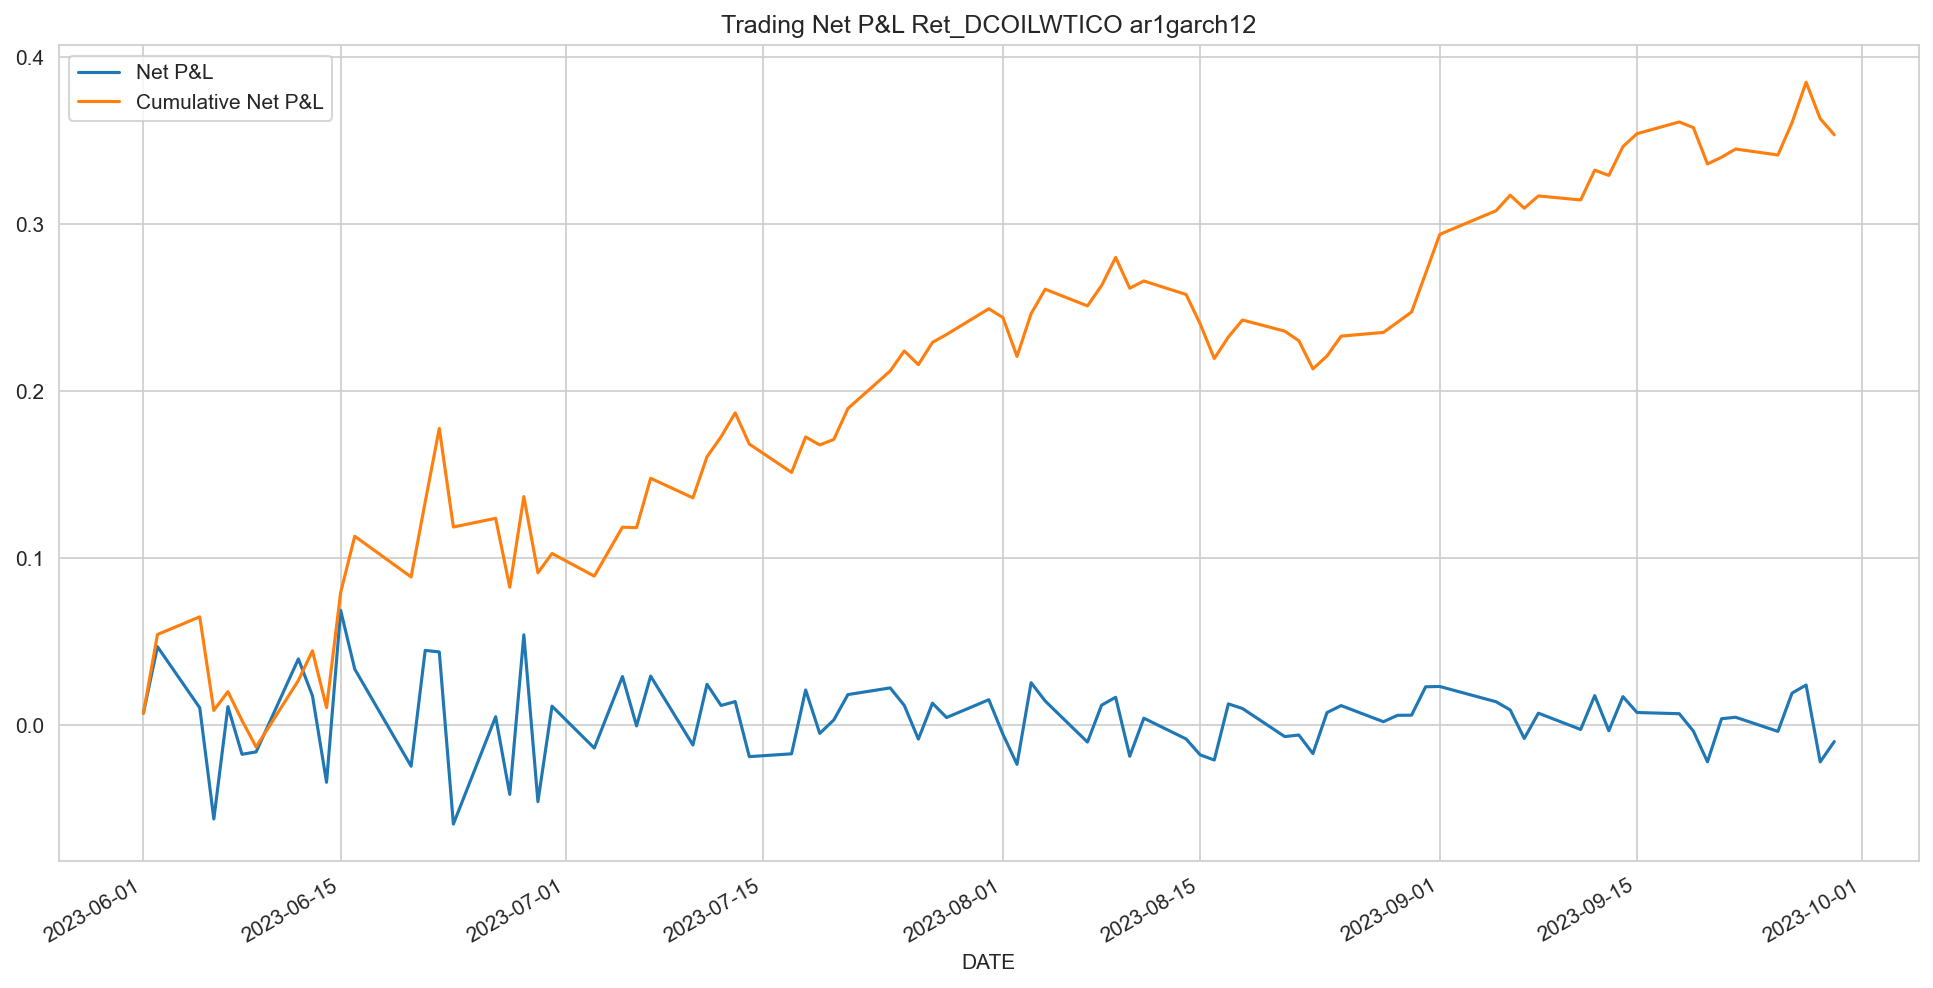

In [174]:
strat_wti.pnl_net()

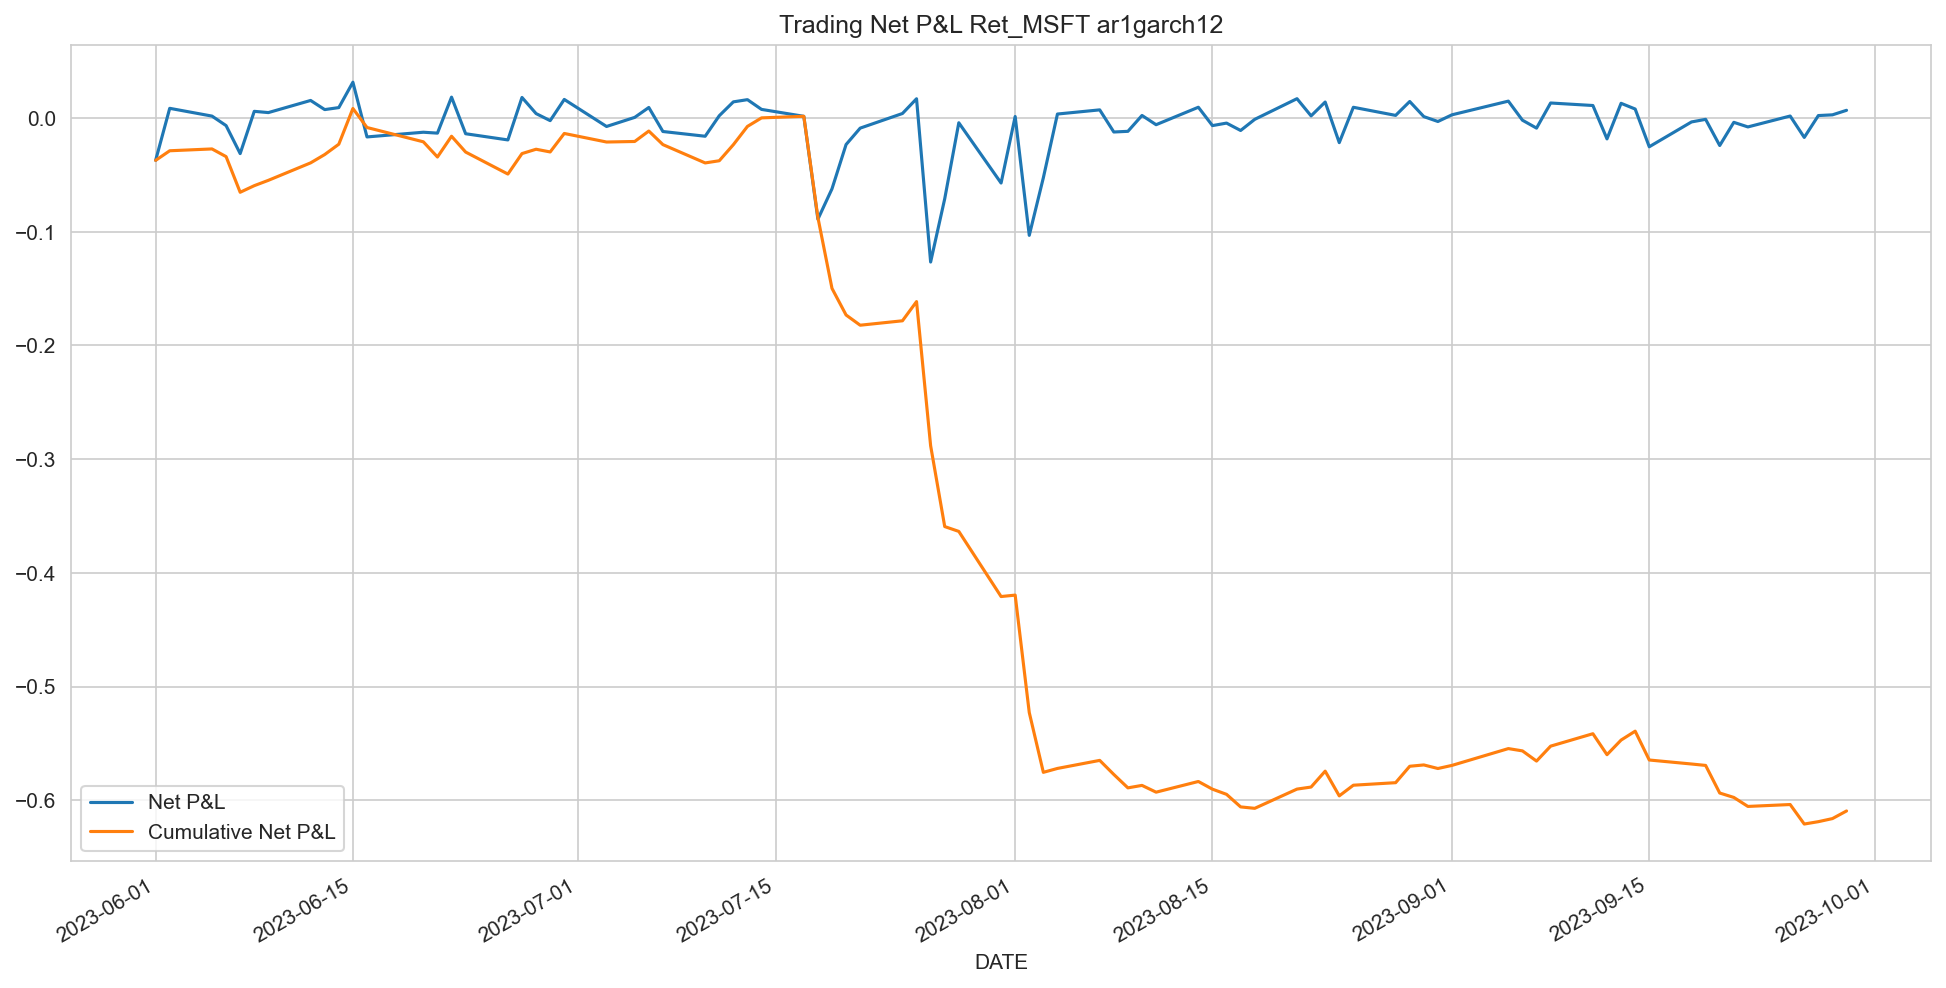

In [175]:
strat_msft.pnl_net()

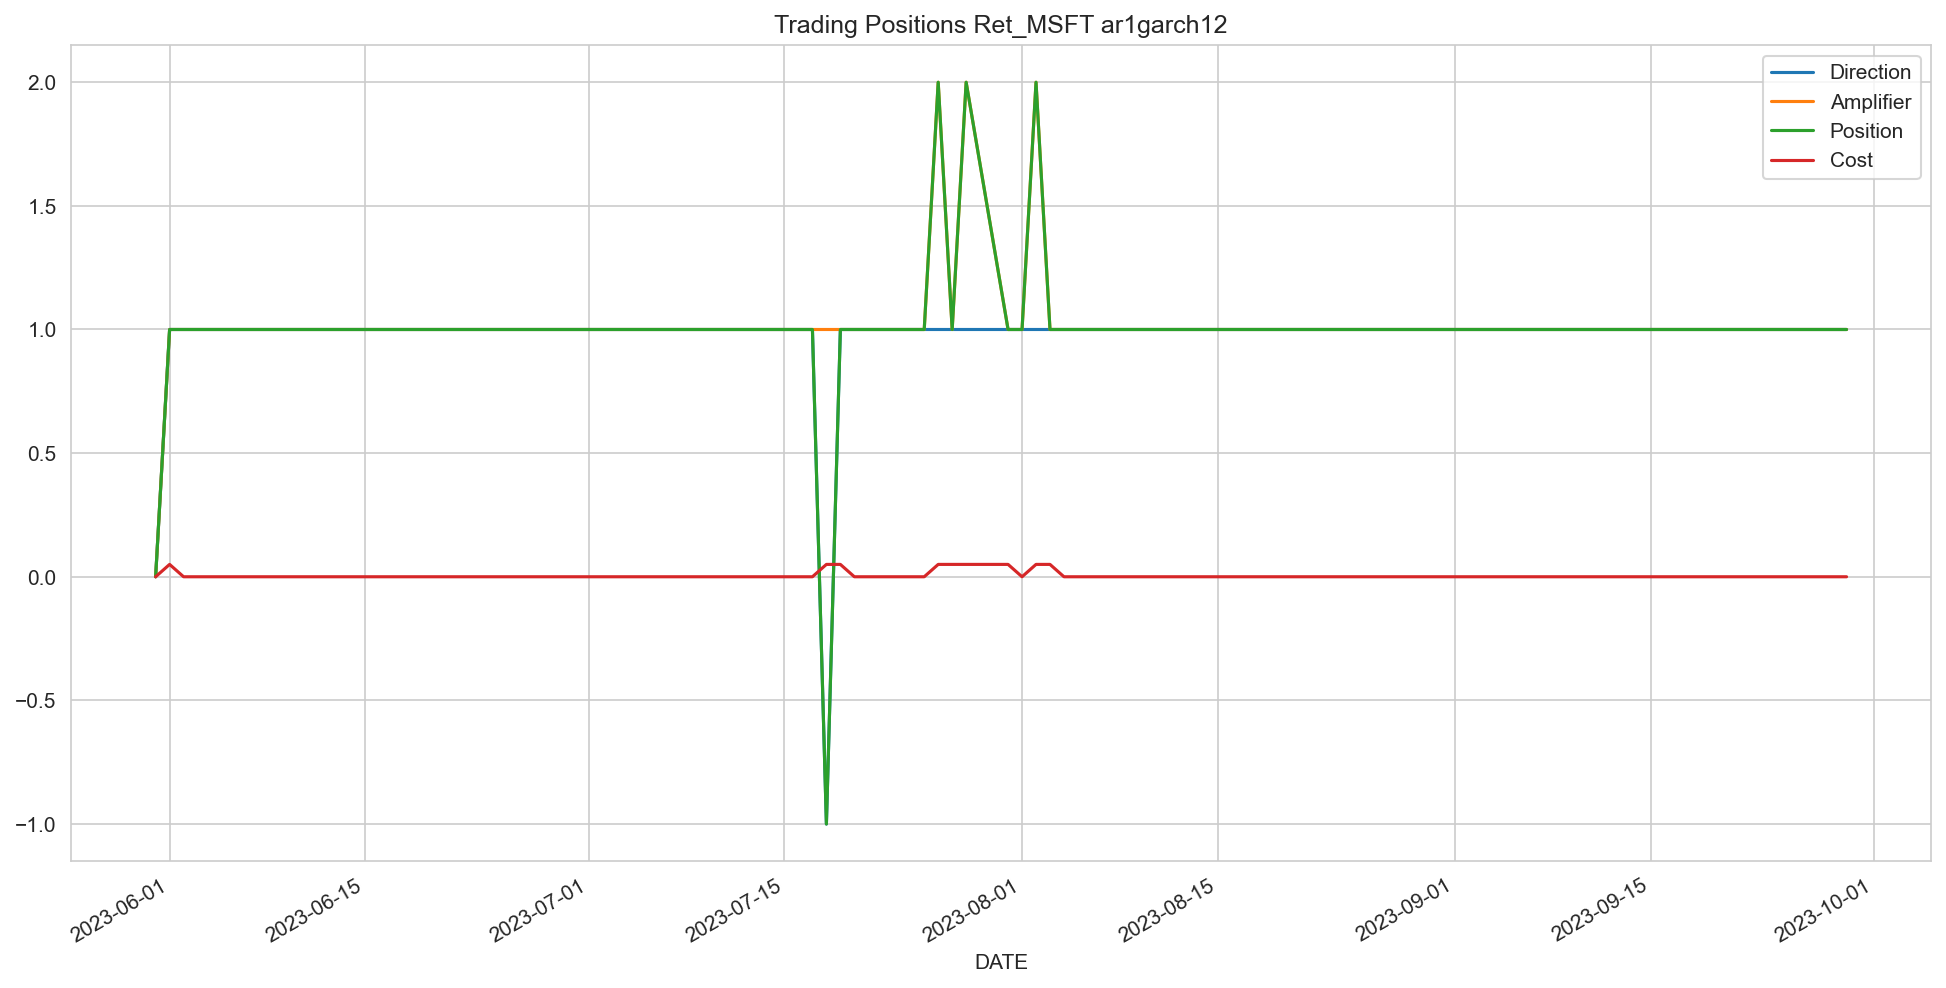

In [176]:
strat_msft.pos()

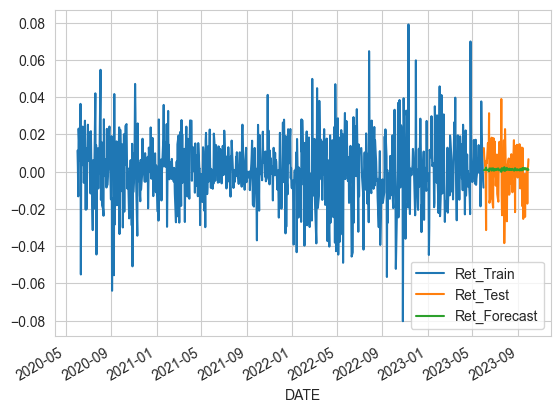

In [178]:
strat_msft.forecast_vs_test_mean_plot()

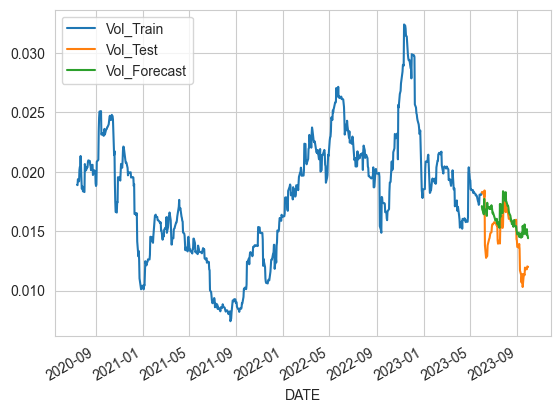

In [179]:
strat_msft.forecast_vs_test_vol_plot()

In [17]:
garch11_fixed = garch('fixed', 0.9, 1, 1, 'Zero', returns, 'Ret_DCOILWTICO')

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1809.999300967107
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1809.999301378689
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


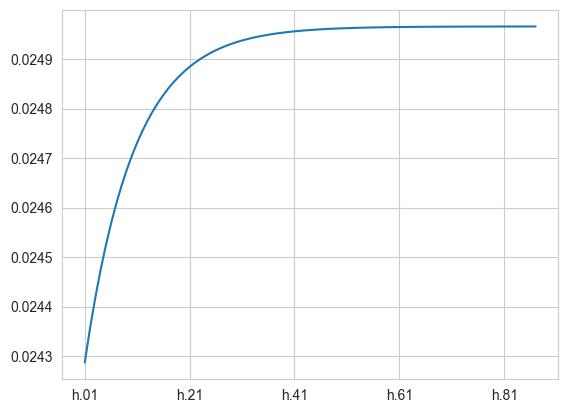

In [19]:
garch11_fixed.forecast_std()

In [20]:
garch11_base = garch_base('roll1d', 0.9, 1, 1, 'Zero', returns, 'Ret_DCOILWTICO')

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1807.5254480262377
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1807.5254484345394
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [21]:
garch11 = garch('roll1d', 0.9, 1, 1, 'Zero', returns, 'Ret_DCOILWTICO')

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1807.5254480262377
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1807.5254484345394
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [22]:
garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:         Ret_DCOILWTICO   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1807.53
Distribution:                  Normal   AIC:                          -3609.05
Method:            Maximum Likelihood   BIC:                          -3595.07
                                        No. Observations:                  781
Date:                Sat, Jun 22 2024   Df Residuals:                      781
Time:                        16:06:07   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.2361e-05  1.269e-05      4.916  8.839e-07 [3.750e-05,8.722e-05]
alpha[1]       0.1000  2.643e-02      3.783  1.548e-04   [4.819e-02,  0.152]
beta[1]        0.8000  2.716e-02     29.454 1.134e-190     [  0.747,  0.853]
============================================================================

Covariance estimator: robust
"""

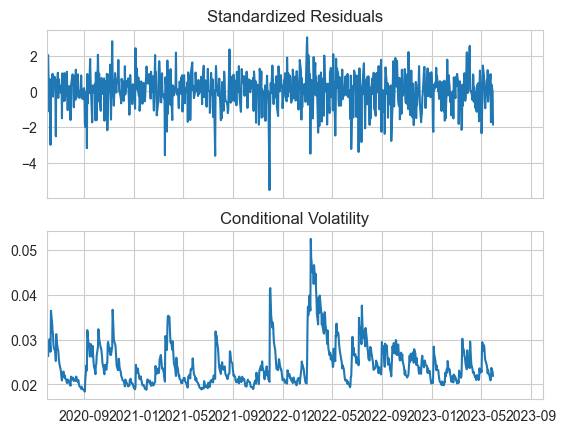

In [23]:
garch11.plot()

In [24]:
garch11.autocorr()

lb_stat  lb_pvalue
10      NaN        NaN
15      NaN        NaN
20      NaN        NaN

In [25]:
garch11.info_crit()

AIC          BIC
0 -3609.050897 -3595.069171

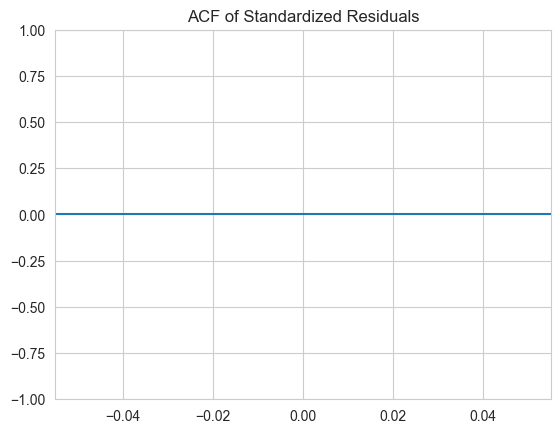

In [25]:
garch11.acf_stan()

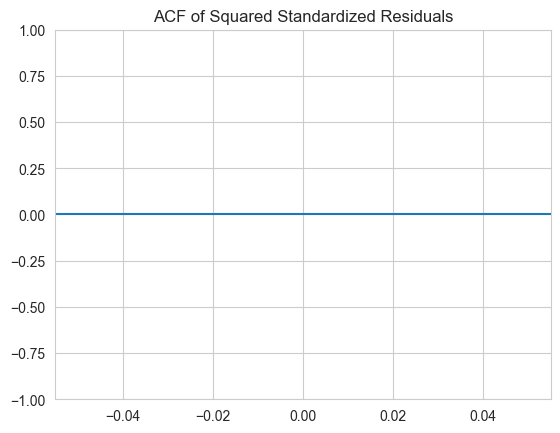

In [26]:
garch11.acf_sq_stan()

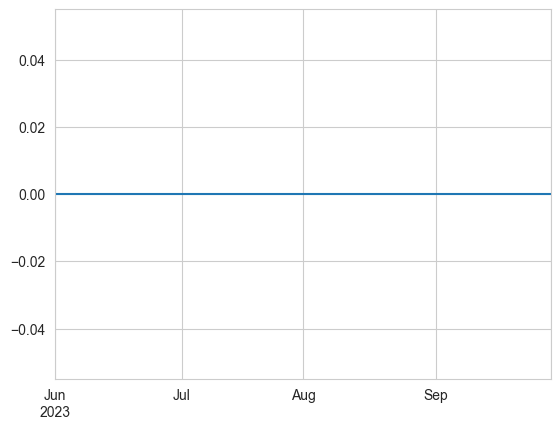

In [27]:
garch11.forecast_mean()

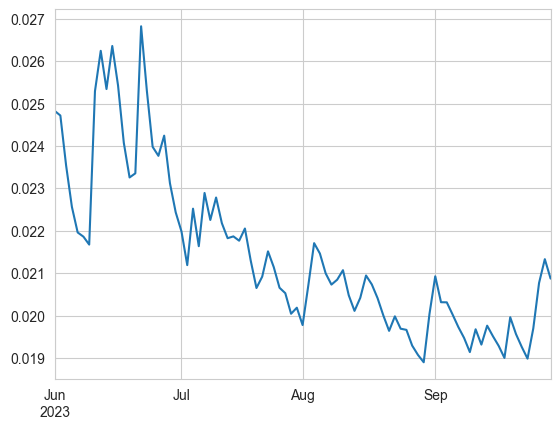

In [28]:
garch11.forecast_std()

In [29]:
garch11.forecast_vs_test

Ret_Train  Ret_Test  Ret_Forecast  Ret_Test_Broad  Vol_Train   
2020-06-02   0.038418       NaN           NaN        0.038418        NaN  \
2020-06-03   0.012128       NaN           NaN        0.012128        NaN   
2020-06-04   0.002408       NaN           NaN        0.002408        NaN   
2020-06-05   0.053842       NaN           NaN        0.053842        NaN   
2020-06-08  -0.033998       NaN           NaN       -0.033998        NaN   
...               ...       ...           ...             ...        ...   
2023-09-25        NaN -0.003562           0.0       -0.003562        NaN   
2023-09-26        NaN  0.019326           0.0        0.019326        NaN   
2023-09-27        NaN  0.024204           0.0        0.024204        NaN   
2023-09-28        NaN -0.021801           0.0       -0.021801        NaN   
2023-09-29        NaN -0.009648           0.0       -0.009648        NaN   

            Vol_Test_Broad  Vol_Test  Vol_Forecast  
2020-06-02             NaN       NaN           NaN  
2020-06-03             NaN       NaN           NaN  
2020-06-04             NaN       NaN           NaN  
2020-06-05             NaN       NaN           NaN  
2020-06-08             NaN       NaN           NaN  
...                    ...       ...           ...  
2023-09-25        0.012104  0.012104      0.018984  
2023-09-26        0.011994  0.011994      0.019698  
2023-09-27        0.011721  0.011721      0.020769  
2023-09-28        0.011317  0.011317      0.021330  
2023-09-29        0.012269  0.012269      0.020872  

[869 rows x 8 columns]

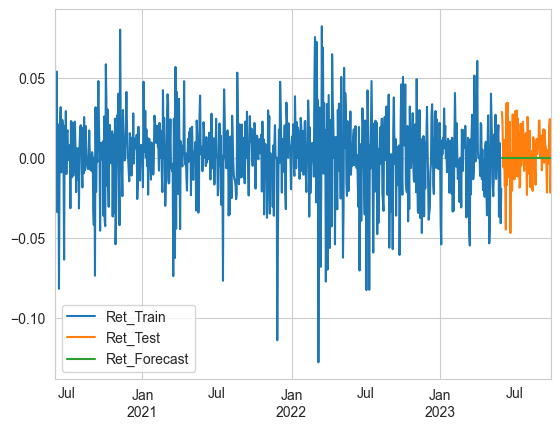

In [30]:
garch11.forecast_vs_test_mean_plot()

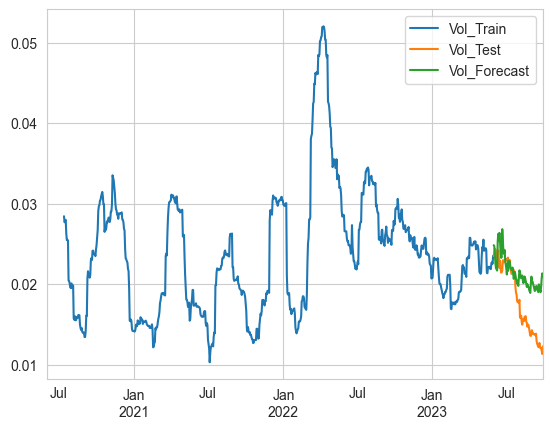

In [31]:
garch11.forecast_vs_test_vol_plot()

All coefficients are statistically significant at 5% confidence level after removing the insignificant mean equation constant

Ljung-Box test on squared standardised residuals: H0 no autocorrelation not rejected at 5% at all 10, 15 & 20 lags

ACF of squared standardised residuals suggests the conditional variance equation is complete - although will see what GARCH(2,1) & GARCH(1,2) produce

ACF of standardised residuals suggests the mean equation can be modified - AR(2), AR(12) to be added

Prediction is run for the chosen number of days from the last available observation by default. The mean equation continues to be 0 as per the zero mean equation definition at the model setup stage. The variance equation evolves according to GARCH(1,1).

In [32]:
garch12 = garch('roll1d', 0.9, 1, 2, 'Zero', returns, 'Ret_DCOILWTICO')
garch21 = garch('roll1d', 0.9, 2, 1, 'Zero', returns, 'Ret_DCOILWTICO')
ar1garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 1)
ar1garch12 = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DCOILWTICO', 1)
ar1garch21 = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DCOILWTICO', 1)
ar2garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 2)
ar2garch12 = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DCOILWTICO', 2)
ar2garch21 = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DCOILWTICO', 2)
ar5garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 5)
ar5garch12 = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DCOILWTICO', 5)
ar5garch21 = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DCOILWTICO', 5)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006229. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -1806.938370183986
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1806.9383713477746
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1808.1019519935076
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1808.1019527617877
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.6630251860341837e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 450502.7351716528
Iteration:      3,   Func. Count:     28,   Neg. LLF: 8786992.851685315
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2752320.2205496896
Iteration:      5,   Func. Count:     52,   Neg. LLF: 5914541.919693241
Iteration:      6,   Func. Count:     64,   Neg. LLF: 214473.8617394168
Iteration:      7,   Func. Count:     76,   Neg. LLF: -1806.9729286411064
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1806.9729289056963
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      8,   Neg. LLF: 1.485779800544476e+17
Iteration:      2,   Func. Count:     21,   Neg. LLF: 6577961.447580786
Iteration:      3,   Func. Count:     34,   Neg. LLF: 9670665.038917901
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1852

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 2.2707749501226016e+17
Iteration:      2,   Func. Count:     21,   Neg. LLF: 20791602.269243825
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2347209.369241963
Iteration:      4,   Func. Count:     45,   Neg. LLF: 24254116.468416415
Iteration:      5,   Func. Count:     58,   Neg. LLF: 11307516.081901385
Iteration:      6,   Func. Count:     72,   Neg. LLF: 230975670428160.8
Iteration:      7,   Func. Count:     84,   Neg. LLF: -1807.808767996385
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1807.808768677342
            Iterations: 11
            Function evaluations: 84
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      8,   Neg. LLF: 72191097.90188509
Iteration:      2,   Func. Count:     21,   Neg. LLF: 242941755.04150206
Iteration:      3,   Func. Count:     34,   Neg. LLF: 27507513.822403535
Iteration:      4,   Func. Count:     47,   Neg. LLF: 623044

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 33897866.1427008
Iteration:      2,   Func. Count:     23,   Neg. LLF: 328960.7118080087
Iteration:      3,   Func. Count:     36,   Neg. LLF: 8483682.925058309
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1071678.7692924154
Iteration:      5,   Func. Count:     62,   Neg. LLF: -1806.645871890892
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1806.6458730224158
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 5


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006093. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 3.879082997888776e+17
Iteration:      2,   Func. Count:     23,   Neg. LLF: 355832.9952825104
Iteration:      3,   Func. Count:     36,   Neg. LLF: 202057871027.9335
Iteration:      4,   Func. Count:     48,   Neg. LLF: 17372980.762130223
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2214979684037491.0
Iteration:      6,   Func. Count:     75,   Neg. LLF: -1808.3326230245984
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1808.3326237387244
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     11,   Neg. LLF: 80394696.508761
Iteration:      2,   Func. Count:     27,   Neg. LLF: 36490.4857183677
Iteration:      3,   Func. Count:     41,   Neg. LLF: 19784388.129010074
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1.472127820442048e+16
Iteration:      5,   Func. Count:     73,   Neg. LLF: 580491

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006093. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006093. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 92633467.45257439
Iteration:      2,   Func. Count:     29,   Neg. LLF: 32020.869179127534
Iteration:      3,   Func. Count:     44,   Neg. LLF: 337855213727087.9
Iteration:      4,   Func. Count:     60,   Neg. LLF: 7096472.248946747
Iteration:      5,   Func. Count:     77,   Neg. LLF: 36500718.68290135
Iteration:      6,   Func. Count:     94,   Neg. LLF: 739099.247629852
Iteration:      7,   Func. Count:    109,   Neg. LLF: 7488578.236538916
Iteration:      8,   Func. Count:    126,   Neg. LLF: 858270715.8288655
Iteration:      9,   Func. Count:    140,   Neg. LLF: 3895.8914781030503
Iteration:     10,   Func. Count:    155,   Neg. LLF: 827241.2768923328
Iteration:     11,   Func. Count:    172,   Neg. LLF: -1694.2938349260735
Iteration:     12,   Func. Count:    185,   Neg. LLF: -1802.6055141279307
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1802.6055147723944
            Iteration

In [33]:
runs = [ar1garch11, ar1garch12, ar1garch21, ar2garch11, ar2garch12, ar2garch21, ar5garch11, ar5garch12, ar5garch21]

for i, ic in enumerate(runs):
    ic_append = ic.info_crit()
    ic_append['Model'] = ic.specs()
    
    if i == 0:
        ics = ic_append
    else:
        ics = pd.concat([ics, ic_append])

cols = ics.columns.tolist()
cols = cols[-1:] + cols[:-1]
ics = ics[cols]
ics

Model          AIC          BIC
0  ar1garch11 -3603.945858 -3580.649388
0  ar1garch12 -3601.070253 -3573.114490
0  ar1garch21 -3603.617537 -3575.661774
0  ar2garch11 -3602.443080 -3574.495013
0  ar2garch12 -3599.291746 -3566.685669
0  ar2garch21 -3602.665247 -3570.059170
0  ar5garch11 -3587.610943 -3545.723571
0  ar5garch12 -3585.211030 -3538.669504
0  ar5garch21 -3586.360360 -3539.818835

In [34]:
ar1garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 1)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.6630251860341837e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 450502.7351716528
Iteration:      3,   Func. Count:     28,   Neg. LLF: 8786992.851685315
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2752320.2205496896
Iteration:      5,   Func. Count:     52,   Neg. LLF: 5914541.919693241
Iteration:      6,   Func. Count:     64,   Neg. LLF: 214473.8617394168
Iteration:      7,   Func. Count:     76,   Neg. LLF: -1806.9729286411064
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1806.9729289056963
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 7


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [35]:
ar1garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:         Ret_DCOILWTICO   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                1806.97
Distribution:                  Normal   AIC:                          -3603.95
Method:            Maximum Likelihood   BIC:                          -3580.65
                                        No. Observations:                  780
Date:                Sun, Apr 28 2024   Df Residuals:                      778
Time:                        21:45:36   Df Model:                            2
                                   Mean Model                                   
================================================================================
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const         1.0865e-03  7.986e-04      1.361      0.174 [-4.787e-04,2.652e-03]
Ret_...ICO[1]     0.0254  3.871e-02      0.657      0.511   [-5.045e-02,  0.101]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.1981e-05  1.337e-05      4.637  3.530e-06 [3.578e-05,8.818e-05]
alpha[1]       0.1020  2.728e-02      3.740  1.843e-04   [4.855e-02,  0.155]
beta[1]        0.7982  2.814e-02     28.367 5.176e-177     [  0.743,  0.853]
============================================================================

Covariance estimator: robust
"""

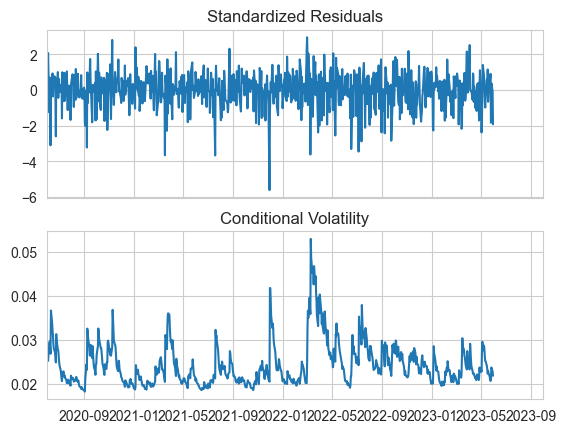

In [36]:
ar1garch11.plot()

In [37]:
ar1garch11.autocorr()

lb_stat  lb_pvalue
10      NaN        NaN
15      NaN        NaN
20      NaN        NaN

In [38]:
ar1garch11.info_crit()

AIC          BIC
0 -3603.945858 -3580.649388

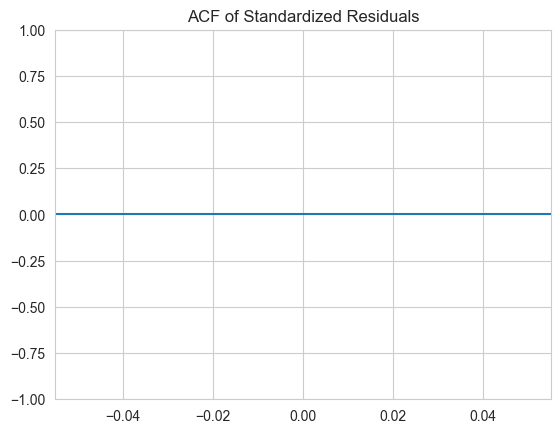

In [39]:
ar1garch11.acf_stan()

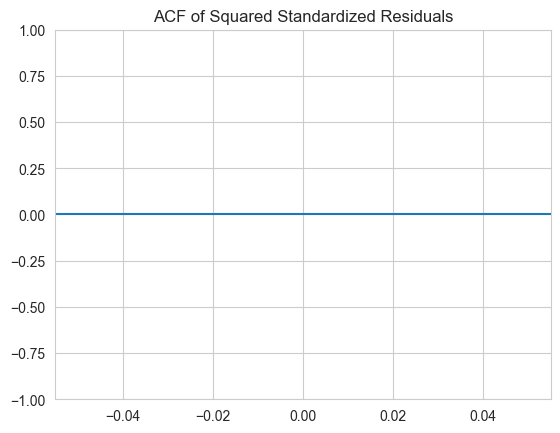

In [40]:
ar1garch11.acf_sq_stan()

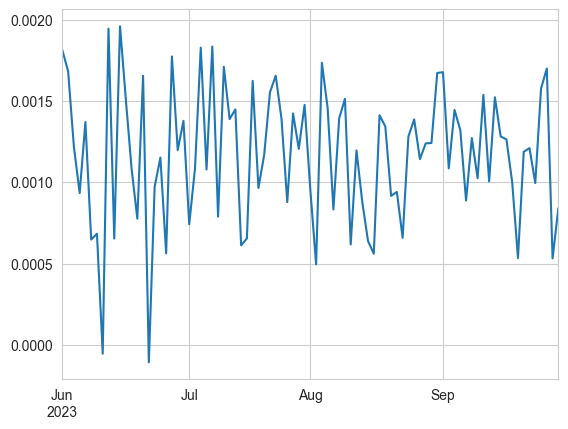

In [41]:
ar1garch11.forecast_mean()

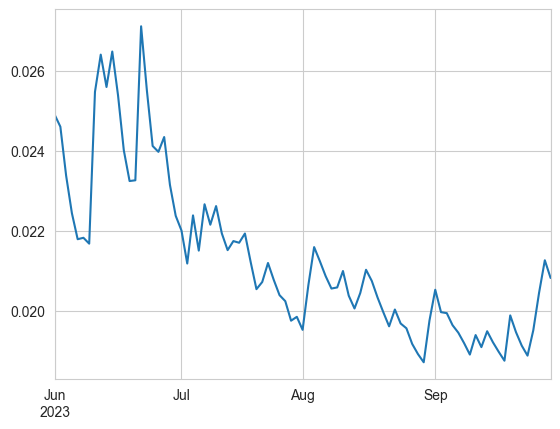

In [42]:
ar1garch11.forecast_std()

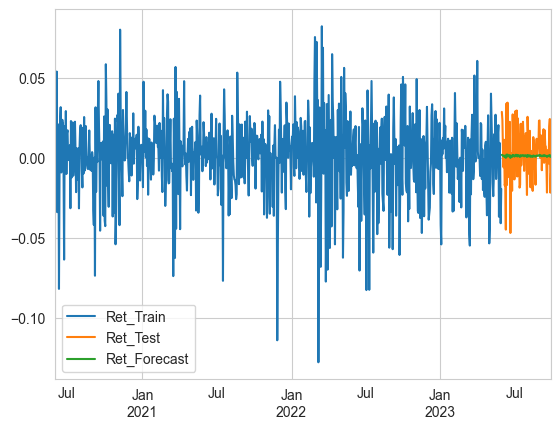

In [43]:
ar1garch11.forecast_vs_test_mean_plot()

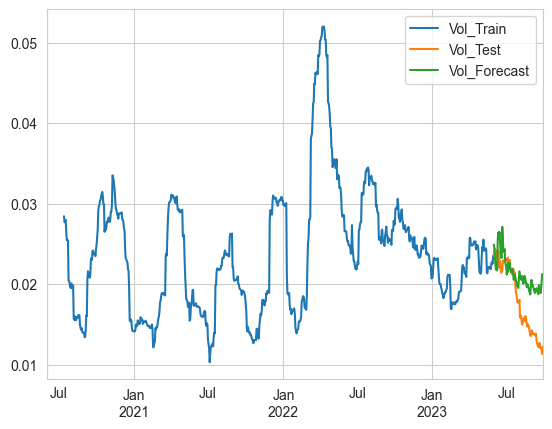

In [44]:
ar1garch11.forecast_vs_test_vol_plot()

Add GJR-GARCH, TARCH and trading strategy logic

In [102]:
class strategy(garch_main):
    def __init__(self, approach, grid_proportion, grid_p, grid_q, mean, data, asset, grid_lags):
        garch_main.__init__(self, approach, grid_proportion, grid_p, grid_q, mean, data, asset, grid_lags)
        self.trade = self.build()
    
    def build(self):
        trade = self.forecast_vs_test
        
        last_train = trade.iloc[lambda x: x.index == self.last_train_date]
        last_vol_train = last_train['Vol_Train'][0]

        trade['direction'] = np.where(trade['Ret_Train'].notna(), 0, np.where(trade['Ret_Forecast'] > 0, 1, -1))
        trade['amplifier'] = np.where(trade['Ret_Train'].notna(), 0, np.where(trade['Vol_Forecast'] > last_vol_train, 2, 1))
        trade['position'] = trade['direction'] * trade['amplifier']
        trade['pnl_gross'] = trade['Ret_Test'] * trade['position']
        trade['pnl_gross_cum'] = trade['pnl_gross'].cumsum()
        trade['position_lag'] = trade['position'].shift(1)
        trade['cost'] = np.where(trade['position'] == trade['position_lag'], 0, 0.05)
        trade['pnl_net'] = trade['pnl_gross'] - trade['cost']
        trade['pnl_net_cum'] = trade['pnl_net'].cumsum()
        
        trade = trade.iloc[lambda x: x.index >= self.last_train_date]
        
        return trade
    
    def pos(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['direction'].plot(label='Direction')
        self.trade['amplifier'].plot(label='Amplifier')
        self.trade['position'].plot(label='Position')
        self.trade['cost'].plot(label='Cost')

        plt.title('Trading Positions ' + self.asset + ' ' + self.specs())
        plt.legend()
        
    def pnl_gross(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['pnl_gross'].plot(label='Gross P&L')
        self.trade['pnl_gross_cum'].plot(label='Cumulative Gross P&L')

        plt.title('Trading Gross P&L ' + self.asset + ' ' + self.specs())
        plt.legend()
    
    def pnl_net(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['pnl_net'].plot(label='Net P&L')
        self.trade['pnl_net_cum'].plot(label='Cumulative Net P&L')

        plt.title('Trading Net P&L ' + self.asset + ' ' + self.specs())
        plt.legend()
        
    def sr(self):
        sr_gross = 252 ** 0.5 * np.mean(self.trade['pnl_gross']) / np.std(self.trade['pnl_gross'])
        sr_net = 252 ** 0.5 * np.mean(self.trade['pnl_net']) / np.std(self.trade['pnl_net'])
        
        return pd.DataFrame({'Metric': ['SR Gross', 'SR Net'], 'Value': [sr_gross, sr_net]})

In [103]:
garch_strat = strategy('roll1d', grid_proportion, grid_p, grid_q, 'AR', returns, 'Ret_DCOILWTICO', grid_lags)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.6630251860341837e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 450502.7351716528
Iteration:      3,   Func. Count:     28,   Neg. LLF: 8786992.851685315
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2752320.2205496896
Iteration:      5,   Func. Count:     52,   Neg. LLF: 5914541.919693241
Iteration:      6,   Func. Count:     64,   Neg. LLF: 214473.8617394168
Iteration:      7,   Func. Count:     76,   Neg. LLF: -1806.9729286411064
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1806.9729289056963
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 7
-3603.9458578113927
0.9
1
1
1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 72191097.90188509
Iteration:      2,   Func. Count:     21,   Neg. LLF: 242941755.04150206
Iteration:      3,   Func. Count:     34,   Neg. LLF: 27507513.822403535
Iteration:      4,   Func. Cou

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000596. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      1,   Func. Count:     16,   Neg. LLF: 1795126498.3097818
Iteration:      2,   Func. Count:     37,   Neg. LLF: 11121.638724216733
Iteration:      3,   Func. Count:     55,   Neg. LLF: 91679.79645210046
Iteration:      4,   Func. Count:     75,   Neg. LLF: 79036030.47682376
Iteration:      5,   Func. Count:     96,   Neg. LLF: 20934990.393365443
Iteration:      6,   Func. Count:    117,   Neg. LLF: 9991063.96867099
Iteration:      7,   Func. Count:    138,   Neg. LLF: 12141227.952851523
Iteration:      8,   Func. Count:    159,   Neg. LLF: 1879846616156.2222
Iteration:      9,   Func. Count:    178,   Neg. LLF: -1799.9122744229194
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1799.912275038484
            Iterations: 13
            Function evaluations: 178
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      8,   Neg. LLF: 1.485779800544476e+17
Iteration:      2,   Func. Count:     21,   Neg. LLF: 657796

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      3,   Func. Count:     44,   Neg. LLF: 337855213727087.9
Iteration:      4,   Func. Count:     60,   Neg. LLF: 7096472.248946747
Iteration:      5,   Func. Count:     77,   Neg. LLF: 36500718.68290135
Iteration:      6,   Func. Count:     94,   Neg. LLF: 739099.247629852
Iteration:      7,   Func. Count:    109,   Neg. LLF: 7488578.236538916
Iteration:      8,   Func. Count:    126,   Neg. LLF: 858270715.8288655
Iteration:      9,   Func. Count:    140,   Neg. LLF: 3895.8914781030503
Iteration:     10,   Func. Count:    155,   Neg. LLF: 827241.2768923328
Iteration:     11,   Func. Count:    172,   Neg. LLF: -1694.2938349260735
Iteration:     12,   Func. Count:    185,   Neg. LLF: -1802.6055141279307
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1802.6055147723944
            Iterations: 16
            Function evaluations: 185
            Gradient evaluations: 12
Iteration:      1,   Func. Count:     13,   Neg. LLF: 56507148.7

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000608. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      2,   Func. Count:     37,   Neg. LLF: 6477.685337710211
Iteration:      3,   Func. Count:     55,   Neg. LLF: 179328.01905473915
Iteration:      4,   Func. Count:     77,   Neg. LLF: 13070103.87039217
Iteration:      5,   Func. Count:     98,   Neg. LLF: 2437492.164929093
Iteration:      6,   Func. Count:    119,   Neg. LLF: 614364.1583357711
Iteration:      7,   Func. Count:    141,   Neg. LLF: 38174009758119.81
Iteration:      8,   Func. Count:    161,   Neg. LLF: -1799.5220224096415
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1799.5220245388969
            Iterations: 12
            Function evaluations: 161
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     17,   Neg. LLF: 91672063.16871966
Iteration:      2,   Func. Count:     39,   Neg. LLF: 5854.52998922492
Iteration:      3,   Func. Count:     58,   Neg. LLF: 289685460.4764273
Iteration:      4,   Func. Count:     80,   Neg. LLF: 1658972.33468

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      1,   Func. Count:     11,   Neg. LLF: 57150894.68704288
Iteration:      2,   Func. Count:     27,   Neg. LLF: 14909097.776837708
Iteration:      3,   Func. Count:     43,   Neg. LLF: 138310983.32628
Iteration:      4,   Func. Count:     59,   Neg. LLF: 1340798880652.9546
Iteration:      5,   Func. Count:     73,   Neg. LLF: 12619970.939909138
Iteration:      6,   Func. Count:     89,   Neg. LLF: 5613089.751452448
Iteration:      7,   Func. Count:    104,   Neg. LLF: -1805.0699340085507
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1805.0699346768597
            Iterations: 11
            Function evaluations: 104
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     12,   Neg. LLF: 66764830.6641901
Iteration:      2,   Func. Count:     29,   Neg. LLF: 154401.6069675414
Iteration:      3,   Func. Count:     43,   Neg. LLF: -1803.1801790466193
Optimization terminated successfully    (Exit mode 0)
           

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000596. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005951. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      1,   Func. Count:     16,   Neg. LLF: 1521982145.4268131
Iteration:      2,   Func. Count:     37,   Neg. LLF: 5836.533612032601
Iteration:      3,   Func. Count:     55,   Neg. LLF: 27326769.933788445
Iteration:      4,   Func. Count:     76,   Neg. LLF: 5620674.737320043
Iteration:      5,   Func. Count:     97,   Neg. LLF: 165606.01201318344
Iteration:      6,   Func. Count:    117,   Neg. LLF: -1800.9599105438851
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1800.9599127154984
            Iterations: 10
            Function evaluations: 117
            Gradient evaluations: 6
Iteration:      1,   Func. Count:     17,   Neg. LLF: 1710395245.2319427
Iteration:      2,   Func. Count:     39,   Neg. LLF: 4774.797016392715
Iteration:      3,   Func. Count:     58,   Neg. LLF: 5374673.109636721
Iteration:      4,   Func. Count:     81,   Neg. LLF: 4540040.097815586
Iteration:      5,   Func. Count:    102,   Neg. LLF: 14698933.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000617. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      6,   Func. Count:     89,   Neg. LLF: 127771.17029186647
Iteration:      7,   Func. Count:    104,   Neg. LLF: 3031790.7796995873
Iteration:      8,   Func. Count:    120,   Neg. LLF: -1804.6778822713472
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1804.6778837347756
            Iterations: 12
            Function evaluations: 120
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     12,   Neg. LLF: 35193605.985700265
Iteration:      2,   Func. Count:     29,   Neg. LLF: 1000214832011.5294
Iteration:      3,   Func. Count:     45,   Neg. LLF: 17232508.12642532
Iteration:      4,   Func. Count:     62,   Neg. LLF: 2829326.999898898
Iteration:      5,   Func. Count:     79,   Neg. LLF: 506180317303.43506
Iteration:      6,   Func. Count:     94,   Neg. LLF: 11953665.752693754
Iteration:      7,   Func. Count:    111,   Neg. LLF: 4377607.045032376
Iteration:      8,   Func. Count:    127,   Neg. LLF: 3179206

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000608. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:     13,   Func. Count:    232,   Neg. LLF: 1293809.9034304628
Iteration:     14,   Func. Count:    251,   Neg. LLF: -1799.7689097171333
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1799.7689111823615
            Iterations: 18
            Function evaluations: 251
            Gradient evaluations: 14
Iteration:      1,   Func. Count:     15,   Neg. LLF: 62592167.697295
Iteration:      2,   Func. Count:     35,   Neg. LLF: 8936.088292613373
Iteration:      3,   Func. Count:     54,   Neg. LLF: 3073689.3738368377
Iteration:      4,   Func. Count:     74,   Neg. LLF: 106080.89981288774
Iteration:      5,   Func. Count:     92,   Neg. LLF: 1.2088291143356918e+17
Iteration:      6,   Func. Count:    112,   Neg. LLF: 235403.64160263134
Iteration:      7,   Func. Count:    131,   Neg. LLF: 924606.9081010073
Iteration:      8,   Func. Count:    151,   Neg. LLF: 27792.200471465156
Iteration:      9,   Func. Count:    170,   Neg. LLF: 1502

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005951. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000592. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      1,   Func. Count:     18,   Neg. LLF: 80208013.75251763
Iteration:      2,   Func. Count:     41,   Neg. LLF: 4091.1964732630718
Iteration:      3,   Func. Count:     62,   Neg. LLF: 601013.0587302444
Iteration:      4,   Func. Count:     82,   Neg. LLF: 2358537.776594866
Iteration:      5,   Func. Count:    103,   Neg. LLF: 21239.86066650535
Iteration:      6,   Func. Count:    125,   Neg. LLF: 5.0306947829697944e+16
Iteration:      7,   Func. Count:    148,   Neg. LLF: 71311.86188614057
Iteration:      8,   Func. Count:    171,   Neg. LLF: 370239638135.90704
Iteration:      9,   Func. Count:    192,   Neg. LLF: 7766479.629196459
Iteration:     10,   Func. Count:    215,   Neg. LLF: 1955463.4697067416
Iteration:     11,   Func. Count:    238,   Neg. LLF: 1331066.2756122586
Iteration:     12,   Func. Count:    262,   Neg. LLF: 136207695286326.2
Iteration:     13,   Func. Count:    284,   Neg. LLF: -1798.7584283297954
Optimization terminated successfully    (Exit mode 0)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006279. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      8,   Func. Count:    113,   Neg. LLF: 303247450852.61145
Iteration:      9,   Func. Count:    126,   Neg. LLF: 1296270660526.668
Iteration:     10,   Func. Count:    138,   Neg. LLF: -1598.6932746614325
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1598.6932752814687
            Iterations: 14
            Function evaluations: 138
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     11,   Neg. LLF: 5.780533363946689e+17
Iteration:      2,   Func. Count:     27,   Neg. LLF: 412125.21691099694
Iteration:      3,   Func. Count:     42,   Neg. LLF: 21508190.198509112
Iteration:      4,   Func. Count:     58,   Neg. LLF: 14760890.746155787
Iteration:      5,   Func. Count:     75,   Neg. LLF: 7992707997560.696
Iteration:      6,   Func. Count:     89,   Neg. LLF: 292468.0266975302
Iteration:      7,   Func. Count:    103,   Neg. LLF: 2880597038193.624
Iteration:      8,   Func. Count:    117,   Neg. LLF: 8369

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006059. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006043. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     14,   Neg. LLF: 2235941705.770756
Iteration:      2,   Func. Count:     33,   Neg. LLF: 7561.35933531562
Iteration:      3,   Func. Count:     49,   Neg. LLF: 66381223.66887486
Iteration:      4,   Func. Count:     68,   Neg. LLF: 5628701.082776179
Iteration:      5,   Func. Count:     87,   Neg. LLF: 1034532215062.2172
Iteration:      6,   Func. Count:    104,   Neg. LLF: 4.271393508254469e+16
Iteration:      7,   Func. Count:    123,   Neg. LLF: 4741581.396183192
Iteration:      8,   Func. Count:    142,   Neg. LLF: 542585.0957248297
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1596.8024323539712
            Iterations: 12
            Function evaluations: 150
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     15,   Neg. LLF: 121544919.19158062
Iteration:      2,   Func. Count:     35,   Neg. LLF: 2683.956685694142
Iteration:      3,   Func. Count:     53,   Neg. LLF: 28605.5756

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006279. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     15,   Neg. LLF: 1749259583.571773
Iteration:      2,   Func. Count:     35,   Neg. LLF: 632164.5435824072
Iteration:      3,   Func. Count:     52,   Neg. LLF: 1639.9671437105767
Iteration:      4,   Func. Count:     70,   Neg. LLF: 66912.87138168083
Iteration:      5,   Func. Count:     88,   Neg. LLF: 53964.42395116062
Iteration:      6,   Func. Count:    106,   Neg. LLF: 115070.18761672209
Iteration:      7,   Func. Count:    123,   Neg. LLF: 21597.51369921851
Iteration:      8,   Func. Count:    141,   Neg. LLF: 3190811.119084424
Iteration:      9,   Func. Count:    161,   Neg. LLF: 307666.1725934006
Iteration:     10,   Func. Count:    181,   Neg. LLF: 428346.6946658659
Iteration:     11,   Func. Count:    200,   Neg. LLF: -1597.038730655897
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1597.038731457974
            Iterations: 15
            Function evaluations: 200
            Gradient evaluation

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006043. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006019. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     12,   Func. Count:    249,   Neg. LLF: -1593.9180631928666
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1593.9180648005442
            Iterations: 16
            Function evaluations: 249
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      8,   Neg. LLF: 28570329.660469342
Iteration:      2,   Func. Count:     21,   Neg. LLF: 8504685.958990946
Iteration:      3,   Func. Count:     34,   Neg. LLF: 9062764.246402722
Iteration:      4,   Func. Count:     47,   Neg. LLF: 431506655745472.44
Iteration:      5,   Func. Count:     59,   Neg. LLF: -1602.3267579434585
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1602.3267589116601
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      9,   Neg. LLF: 46072032.5484774
Iteration:      2,   Func. Count:     23,   Neg. LLF: 204416.200443110

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006279. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      7,   Func. Count:    117,   Neg. LLF: 757436.4289461488
Iteration:      8,   Func. Count:    136,   Neg. LLF: 141368.8988353844
Iteration:      9,   Func. Count:    152,   Neg. LLF: 12749.486507383204
Iteration:     10,   Func. Count:    169,   Neg. LLF: 3615293.121672913
Iteration:     11,   Func. Count:    186,   Neg. LLF: -1596.200431027046
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1596.2004322296002
            Iterations: 15
            Function evaluations: 186
            Gradient evaluations: 11
Iteration:      1,   Func. Count:     14,   Neg. LLF: 1.0129636527731881e+18
Iteration:      2,   Func. Count:     33,   Neg. LLF: 471181034.05268157
Iteration:      3,   Func. Count:     52,   Neg. LLF: 10366155.833697742
Iteration:      4,   Func. Count:     71,   Neg. LLF: 32050127490749.348
Iteration:      5,   Func. Count:     89,   Neg. LLF: 84557.11207380897
Iteration:      6,   Func. Count:    106,   Neg. LLF: 1024

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006059. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006043. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      3,   Func. Count:     56,   Neg. LLF: 1917178.3472905385
Iteration:      4,   Func. Count:     77,   Neg. LLF: 1255818.5362889133
Iteration:      5,   Func. Count:     97,   Neg. LLF: 13990974.01727696
Iteration:      6,   Func. Count:    117,   Neg. LLF: 1007923.6762457396
Iteration:      7,   Func. Count:    138,   Neg. LLF: -1596.987192633431
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1596.9871941713618
            Iterations: 11
            Function evaluations: 138
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     17,   Neg. LLF: 2226300661.0534353
Iteration:      2,   Func. Count:     39,   Neg. LLF: 3671.3597145072026
Iteration:      3,   Func. Count:     60,   Neg. LLF: 16896089.88689804
Iteration:      4,   Func. Count:     82,   Neg. LLF: 1311896.07123335
Iteration:      5,   Func. Count:    101,   Neg. LLF: 6413.250787521376
Iteration:      6,   Func. Count:    122,   Neg. LLF: 148805.691

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006314. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      8,   Func. Count:    109,   Neg. LLF: 10320.929426455808
Iteration:      9,   Func. Count:    121,   Neg. LLF: 95.34552318654748
Iteration:     10,   Func. Count:    133,   Neg. LLF: 3134.2001226846796
Iteration:     11,   Func. Count:    147,   Neg. LLF: 31625091.014308188
Iteration:     12,   Func. Count:    157,   Neg. LLF: 88537723.8739749
Iteration:     13,   Func. Count:    167,   Neg. LLF: -990.7695579307697
Iteration:     14,   Func. Count:    178,   Neg. LLF: -1595.8689351226901
Iteration:     15,   Func. Count:    188,   Neg. LLF: -1324.7551196694399
Iteration:     16,   Func. Count:    199,   Neg. LLF: -1601.2034662349176
Iteration:     17,   Func. Count:    209,   Neg. LLF: -1600.0996968298673
Iteration:     18,   Func. Count:    219,   Neg. LLF: -1603.802282520658
Iteration:     19,   Func. Count:    228,   Neg. LLF: -1598.2896497563968
Iteration:     20,   Func. Count:    238,   Neg. LLF: -1603.9684624867502
Iteration:     21,   Func. Count:    247,   Neg.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006279. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 124128985.99764155
Iteration:      2,   Func. Count:     30,   Neg. LLF: 2267402.9690073254
Iteration:      3,   Func. Count:     46,   Neg. LLF: 6272867272.968348
Iteration:      4,   Func. Count:     63,   Neg. LLF: 1677.0819281583263
Iteration:      5,   Func. Count:     78,   Neg. LLF: 8500.87430639165
Iteration:      6,   Func. Count:     93,   Neg. LLF: 2147.2914813287607
Iteration:      7,   Func. Count:    107,   Neg. LLF: 19830292399.432205
Iteration:      8,   Func. Count:    121,   Neg. LLF: 402044580.8202397
Iteration:      9,   Func. Count:    135,   Neg. LLF: 6712706.471015149
Iteration:     10,   Func. Count:    148,   Neg. LLF: 76401822.05173767
Iteration:     11,   Func. Count:    161,   Neg. LLF: 97693.90137675602
Iteration:     12,   Func. Count:    173,   Neg. LLF: -1375.4039790994402
Iteration:     13,   Func. Count:    186,   Neg. LLF: -1594.3530577148501
Iteration:     14,   Func. Count:    198,   Neg. LLF: -1

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006199. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006186. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:    166,   Neg. LLF: 16899136749.97639
Iteration:     10,   Func. Count:    183,   Neg. LLF: 23511.439417152433
Iteration:     11,   Func. Count:    201,   Neg. LLF: 2588111.9328969326
Iteration:     12,   Func. Count:    217,   Neg. LLF: 11687260.394096848
Iteration:     13,   Func. Count:    232,   Neg. LLF: 4084114.705917198
Iteration:     14,   Func. Count:    248,   Neg. LLF: -1448.0506739614652
Iteration:     15,   Func. Count:    264,   Neg. LLF: -1497.6853322876177
Iteration:     16,   Func. Count:    280,   Neg. LLF: -1581.056443415423
Iteration:     17,   Func. Count:    295,   Neg. LLF: -780.6223586378507
Iteration:     18,   Func. Count:    312,   Neg. LLF: -1582.647022734424
Iteration:     19,   Func. Count:    327,   Neg. LLF: 694.4508184733618
Iteration:     20,   Func. Count:    342,   Neg. LLF: -1595.3294589029815
Iteration:     21,   Func. Count:    357,   Neg. LLF: -1595.4742789421477
Iteration:     22,   Func. Count:    372,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006059. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006043. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     10,   Func. Count:    206,   Neg. LLF: 4.0920542159010816e+17
Iteration:     11,   Func. Count:    228,   Neg. LLF: 8612970.936188709
Iteration:     12,   Func. Count:    250,   Neg. LLF: 3179348295995837.0
Iteration:     13,   Func. Count:    271,   Neg. LLF: -1595.6170168775511
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1595.6170185317915
            Iterations: 17
            Function evaluations: 271
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     18,   Neg. LLF: 1614068713.1136637
Iteration:      2,   Func. Count:     41,   Neg. LLF: 27418.965623326192
Iteration:      3,   Func. Count:     62,   Neg. LLF: 943912828.4617721
Iteration:      4,   Func. Count:     85,   Neg. LLF: 3151.307994448043
Iteration:      5,   Func. Count:    106,   Neg. LLF: 19776293.73660586
Iteration:      6,   Func. Count:    129,   Neg. LLF: 31316.561283302286
Iteration:      7,   Func. Count:    150,   Neg. LLF: 724

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006479. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     12,   Neg. LLF: 60289670.02165629
Iteration:      2,   Func. Count:     29,   Neg. LLF: 77553.30475414646
Iteration:      3,   Func. Count:     44,   Neg. LLF: 38218908.99260739
Iteration:      4,   Func. Count:     61,   Neg. LLF: 2962.6463981126612
Iteration:      5,   Func. Count:     77,   Neg. LLF: 105360045.50942728
Iteration:      6,   Func. Count:     92,   Neg. LLF: 48940.96741110236
Iteration:      7,   Func. Count:    107,   Neg. LLF: 634786.439701458
Iteration:      8,   Func. Count:    123,   Neg. LLF: 13833843.890107652
Iteration:      9,   Func. Count:    140,   Neg. LLF: 3548875.5169556653
Iteration:     10,   Func. Count:    157,   Neg. LLF: -1390.0384166400934
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1390.038417467977
            Iterations: 14
            Function evaluations: 157
            Gradient evaluations: 10
Iteration:      1,   Func. Count:     13,   Neg. LLF: 87529640.2

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      6,   Func. Count:     69,   Neg. LLF: 1434.9374577725089
Iteration:      7,   Func. Count:     80,   Neg. LLF: 1733.7914593012179
Iteration:      8,   Func. Count:     91,   Neg. LLF: 514.5982237212656
Iteration:      9,   Func. Count:    101,   Neg. LLF: 53791120282.46622
Iteration:     10,   Func. Count:    111,   Neg. LLF: 246709.00669124638
Iteration:     11,   Func. Count:    119,   Neg. LLF: -1217.2680816734537
Iteration:     12,   Func. Count:    128,   Neg. LLF: -1378.679558189792
Iteration:     13,   Func. Count:    136,   Neg. LLF: -1288.6526397625487
Iteration:     14,   Func. Count:    144,   Neg. LLF: -1383.3398219233932
Iteration:     15,   Func. Count:    152,   Neg. LLF: -1390.0664719274978
Iteration:     16,   Func. Count:    160,   Neg. LLF: -1392.1278771269103
Iteration:     17,   Func. Count:    168,   Neg. LLF: -1397.3770239794844
Iteration:     18,   Func. Count:    176,   Neg. LLF: -1397.3942794591933
Iteration:     19,   Func. Count:    183,   Ne

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006444. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      1,   Func. Count:     11,   Neg. LLF: 37998584.95601912
Iteration:      2,   Func. Count:     27,   Neg. LLF: 129188.29840790197
Iteration:      3,   Func. Count:     43,   Neg. LLF: 17972420.85837385
Iteration:      4,   Func. Count:     60,   Neg. LLF: 290965.84918258747
Iteration:      5,   Func. Count:     74,   Neg. LLF: 133261344.51118538
Iteration:      6,   Func. Count:     90,   Neg. LLF: 279838.5725265822
Iteration:      7,   Func. Count:    106,   Neg. LLF: 26282.818261125823
Iteration:      8,   Func. Count:    121,   Neg. LLF: 6970993.805688245
Iteration:      9,   Func. Count:    136,   Neg. LLF: -1392.3532475534225
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1392.3532487509897
            Iterations: 13
            Function evaluations: 136
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     12,   Neg. LLF: 3.408670740476708e+17
Iteration:      2,   Func. Count:     29,   Neg. LLF: 14784

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      5,   Func. Count:     97,   Neg. LLF: 51087.233905262714
Iteration:      6,   Func. Count:    115,   Neg. LLF: 764099534.6352154
Iteration:      7,   Func. Count:    136,   Neg. LLF: 49639737.46296898
Iteration:      8,   Func. Count:    157,   Neg. LLF: 1017439.9493147668
Iteration:      9,   Func. Count:    177,   Neg. LLF: -1391.3879751302115
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1391.3879762084061
            Iterations: 13
            Function evaluations: 177
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     17,   Neg. LLF: 89379829.95170389
Iteration:      2,   Func. Count:     39,   Neg. LLF: 3867.0012144839807
Iteration:      3,   Func. Count:     60,   Neg. LLF: 3360781.7144129714
Iteration:      4,   Func. Count:     82,   Neg. LLF: 6819.035604982134
Iteration:      5,   Func. Count:    103,   Neg. LLF: 17393.011795045528
Iteration:      6,   Func. Count:    123,   Neg. LLF: 9184.392

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006444. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      8,   Func. Count:    118,   Neg. LLF: -1394.6367796629484
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1394.6367805907864
            Iterations: 12
            Function evaluations: 118
            Gradient evaluations: 8
Iteration:      1,   Func. Count:     12,   Neg. LLF: 63798628.635201216
Iteration:      2,   Func. Count:     29,   Neg. LLF: 4924.573615592338
Iteration:      3,   Func. Count:     44,   Neg. LLF: 3374960.0699932263
Iteration:      4,   Func. Count:     61,   Neg. LLF: 7765535.297745561
Iteration:      5,   Func. Count:     78,   Neg. LLF: 244617603419177.56
Iteration:      6,   Func. Count:     95,   Neg. LLF: 23450.52936859476
Iteration:      7,   Func. Count:    111,   Neg. LLF: 4074401062782524.0
Iteration:      8,   Func. Count:    128,   Neg. LLF: 79579172109653.5
Iteration:      9,   Func. Count:    144,   Neg. LLF: 132760.75634977315
Iteration:     10,   Func. Count:    159,   Neg. LLF: 372793.07

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:      7,   Func. Count:    131,   Neg. LLF: 2436080848678.7646
Iteration:      8,   Func. Count:    149,   Neg. LLF: 440143505.5129388
Iteration:      9,   Func. Count:    169,   Neg. LLF: 27762.90750970139
Iteration:     10,   Func. Count:    187,   Neg. LLF: 21510.970799712606
Iteration:     11,   Func. Count:    206,   Neg. LLF: 8792229.677841727
Iteration:     12,   Func. Count:    223,   Neg. LLF: 2137555.7287863377
Iteration:     13,   Func. Count:    242,   Neg. LLF: -1392.780772995929
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1392.7807737351595
            Iterations: 17
            Function evaluations: 242
            Gradient evaluations: 13
Iteration:      1,   Func. Count:     16,   Neg. LLF: 110097153.34507449
Iteration:      2,   Func. Count:     37,   Neg. LLF: 3110.225417305892
Iteration:      3,   Func. Count:     57,   Neg. LLF: 5265981.384153286
Iteration:      4,   Func. Count:     78,   Neg. LLF: 5315.7776

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006479. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\A

Iteration:     15,   Func. Count:    172,   Neg. LLF: -1399.3419497583259
Iteration:     16,   Func. Count:    181,   Neg. LLF: -1399.4129302371468
Iteration:     17,   Func. Count:    190,   Neg. LLF: -1399.4380547850965
Iteration:     18,   Func. Count:    199,   Neg. LLF: -1399.4465282782685
Iteration:     19,   Func. Count:    208,   Neg. LLF: -1399.4466734797443
Iteration:     20,   Func. Count:    217,   Neg. LLF: -1399.4466818439148
Iteration:     21,   Func. Count:    226,   Neg. LLF: -1399.446679228217
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1399.446681843887
            Iterations: 22
            Function evaluations: 236
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     11,   Neg. LLF: 100323479.52937503
Iteration:      2,   Func. Count:     28,   Neg. LLF: 695.2095310779714
Iteration:      3,   Func. Count:     41,   Neg. LLF: 182703.90745953802
Iteration:      4,   Func. Count:     54,   Neg. LLF: 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000638. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006349. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\Ap

Iteration:      6,   Func. Count:    118,   Neg. LLF: 846.0374427607143
Iteration:      7,   Func. Count:    137,   Neg. LLF: 164369727877.05966
Iteration:      8,   Func. Count:    155,   Neg. LLF: 2181.9407993462964
Iteration:      9,   Func. Count:    173,   Neg. LLF: 151465520757.15576
Iteration:     10,   Func. Count:    191,   Neg. LLF: 1633584.7713598444
Iteration:     11,   Func. Count:    208,   Neg. LLF: 1506089.0210818609
Iteration:     12,   Func. Count:    224,   Neg. LLF: 8043207.580095675
Iteration:     13,   Func. Count:    240,   Neg. LLF: 11976047.234769383
Iteration:     14,   Func. Count:    257,   Neg. LLF: -1383.6484654185972
Iteration:     15,   Func. Count:    274,   Neg. LLF: -1354.4799859921518
Iteration:     16,   Func. Count:    291,   Neg. LLF: -982.1491474625598
Iteration:     17,   Func. Count:    309,   Neg. LLF: -1304.993049971069
Iteration:     18,   Func. Count:    326,   Neg. LLF: -1389.4482112767423
Iteration:     19,   Func. Count:    342,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     64,   Neg. LLF: 9170.27593824823
Iteration:      4,   Func. Count:     84,   Neg. LLF: 1097.6556238593835
Iteration:      5,   Func. Count:    105,   Neg. LLF: 689.3304845763546
Iteration:      6,   Func. Count:    126,   Neg. LLF: 185661179264.8388
Iteration:      7,   Func. Count:    146,   Neg. LLF: 82715831.65113457
Iteration:      8,   Func. Count:    166,   Neg. LLF: 19851.26258635498
Iteration:      9,   Func. Count:    187,   Neg. LLF: 26843392.637247942
Iteration:     10,   Func. Count:    207,   Neg. LLF: 53020.405031829505
Iteration:     11,   Func. Count:    227,   Neg. LLF: 308977.72576852376
Iteration:     12,   Func. Count:    245,   Neg. LLF: 127118.12127220667
Iteration:     13,   Func. Count:    263,   Neg. LLF: -1017.6304853396701
Iteration:     14,   Func. Count:    282,   Neg. LLF: -1337.2617686116982
Iteration:     15,   Func. Count:    301,   Neg. LLF: -764.4850063484453
Iteration:     16,   Func. Count:    321,   Neg. LLF: -

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [46]:
ar1garch11_strat = strategy('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 1)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.6630251860341837e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 450502.7351716528
Iteration:      3,   Func. Count:     28,   Neg. LLF: 8786992.851685315
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2752320.2205496896
Iteration:      5,   Func. Count:     52,   Neg. LLF: 5914541.919693241
Iteration:      6,   Func. Count:     64,   Neg. LLF: 214473.8617394168
Iteration:      7,   Func. Count:     76,   Neg. LLF: -1806.9729286411064
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1806.9729289056963
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 7


C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [47]:
ar1garch11_strat.build()

Ret_Train  Ret_Test  Ret_Forecast  Ret_Test_Broad  Vol_Train   
2023-05-31  -0.019483       NaN           NaN       -0.019483   0.023509  \
2023-06-01        NaN  0.028656      0.001815        0.028656   0.023478   
2023-06-02        NaN  0.023547      0.001685        0.023547        NaN   
2023-06-05        NaN  0.005281      0.001221        0.005281        NaN   
2023-06-06        NaN -0.005978      0.000935       -0.005978        NaN   
...               ...       ...           ...             ...        ...   
2023-09-25        NaN -0.003562      0.000996       -0.003562        NaN   
2023-09-26        NaN  0.019326      0.001578        0.019326        NaN   
2023-09-27        NaN  0.024204      0.001702        0.024204        NaN   
2023-09-28        NaN -0.021801      0.000532       -0.021801        NaN   
2023-09-29        NaN -0.009648      0.000841       -0.009648        NaN   

            Vol_Test_Broad  Vol_Test  Vol_Forecast  direction  amplifier   
2023-05-31        0.023509       NaN           NaN          0          0  \
2023-06-01        0.023478  0.023478      0.024905          1          2   
2023-06-02        0.023961  0.023961      0.024602          1          2   
2023-06-05        0.024383  0.024383      0.023376          1          1   
2023-06-06        0.024314  0.024314      0.022437          1          1   
...                    ...       ...           ...        ...        ...   
2023-09-25        0.012104  0.012104      0.018872          1          1   
2023-09-26        0.011994  0.011994      0.019508          1          1   
2023-09-27        0.011721  0.011721      0.020444          1          1   
2023-09-28        0.011317  0.011317      0.021259          1          1   
2023-09-29        0.012269  0.012269      0.020816          1          1   

            position  pnl_gross  pnl_gross_cum  position_lag  cost   pnl_net   
2023-05-31         0        NaN            NaN           0.0  0.00       NaN  \
2023-06-01         2   0.057312       0.057312           0.0  0.05  0.007312   
2023-06-02         2   0.047094       0.104406           2.0  0.00  0.047094   
2023-06-05         1   0.005281       0.109688           2.0  0.05 -0.044719   
2023-06-06         1  -0.005978       0.103709           1.0  0.00 -0.005978   
...              ...        ...            ...           ...   ...       ...   
2023-09-25         1  -0.003562       0.675713           1.0  0.00 -0.003562   
2023-09-26         1   0.019326       0.695039           1.0  0.00  0.019326   
2023-09-27         1   0.024204       0.719243           1.0  0.00  0.024204   
2023-09-28         1  -0.021801       0.697442           1.0  0.00 -0.021801   
2023-09-29         1  -0.009648       0.687794           1.0  0.00 -0.009648   

            pnl_net_cum  
2023-05-31          NaN  
2023-06-01     0.007312  
2023-06-02     0.054406  
2023-06-05     0.009688  
2023-06-06     0.003709  
...                 ...  
2023-09-25     0.275713  
2023-09-26     0.295039  
2023-09-27     0.319243  
2023-09-28     0.297442  
2023-09-29     0.287794  

[88 rows x 17 columns]

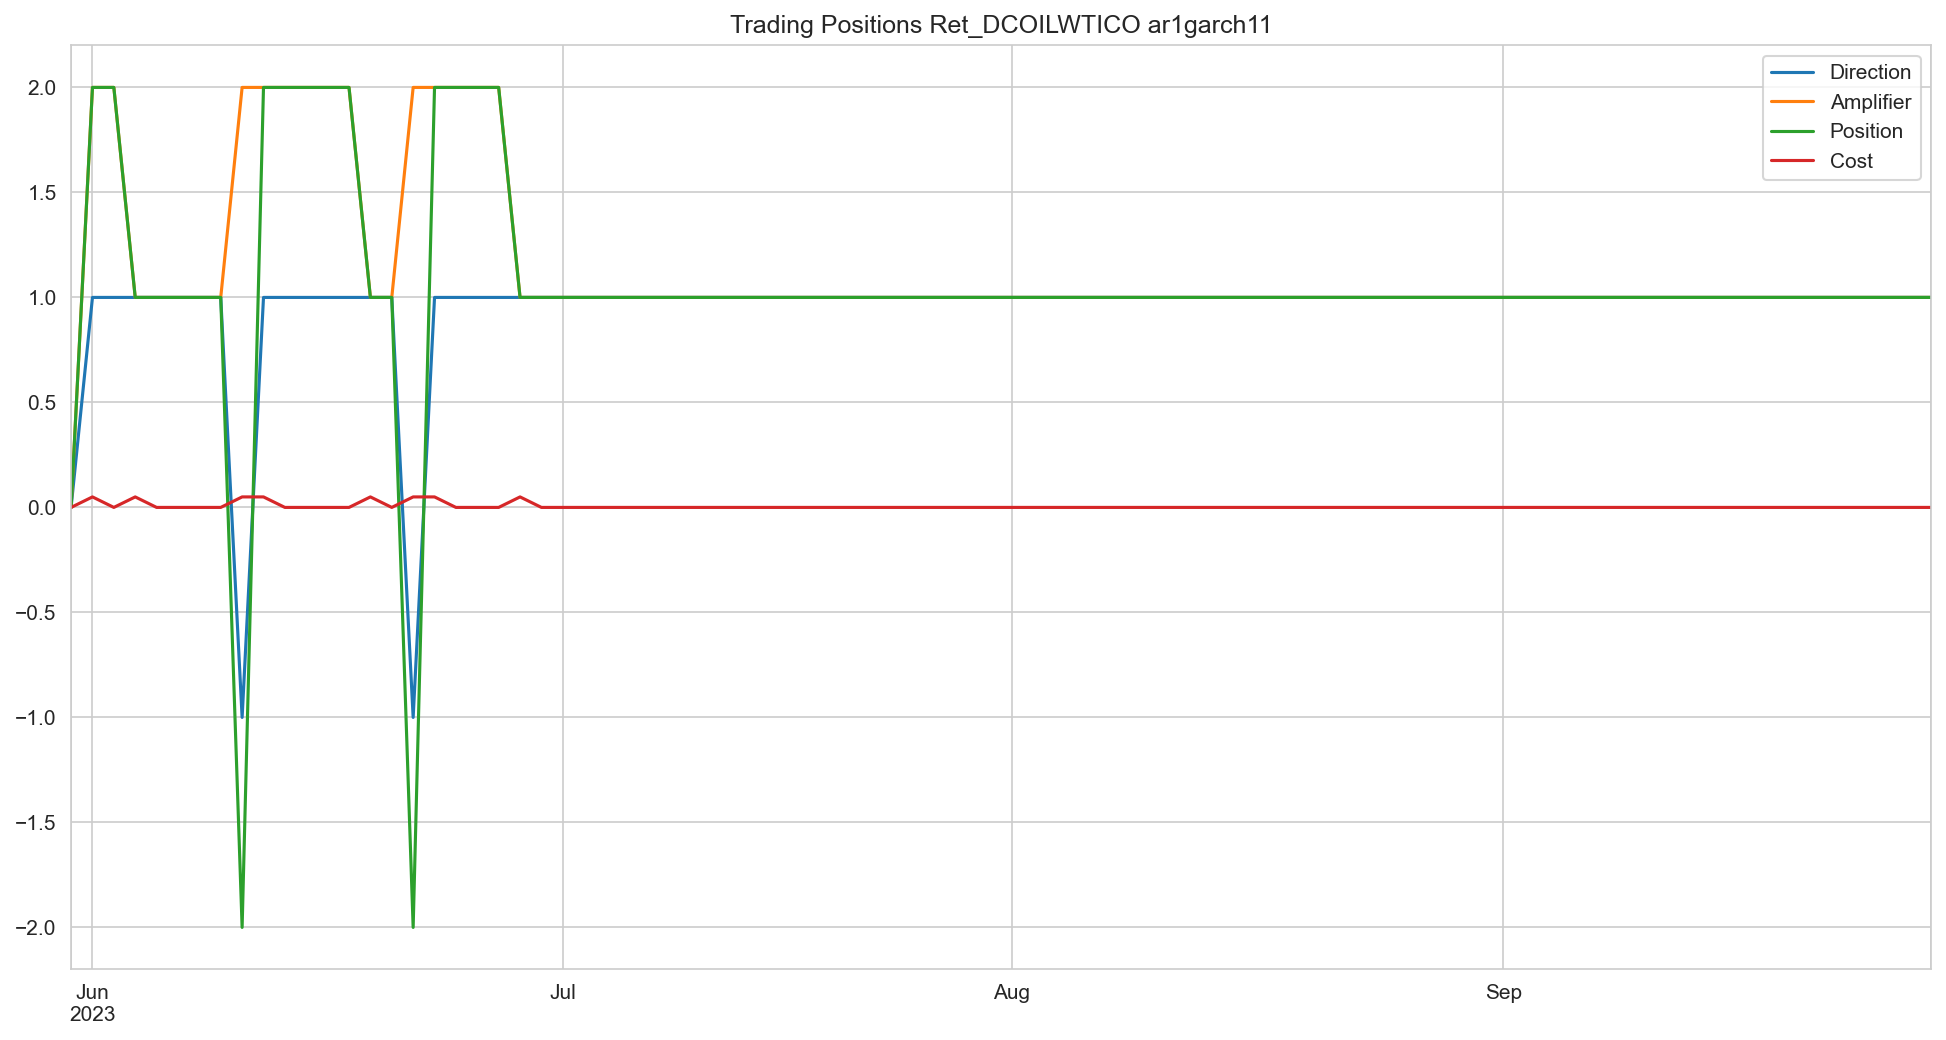

In [48]:
ar1garch11_strat.pos()

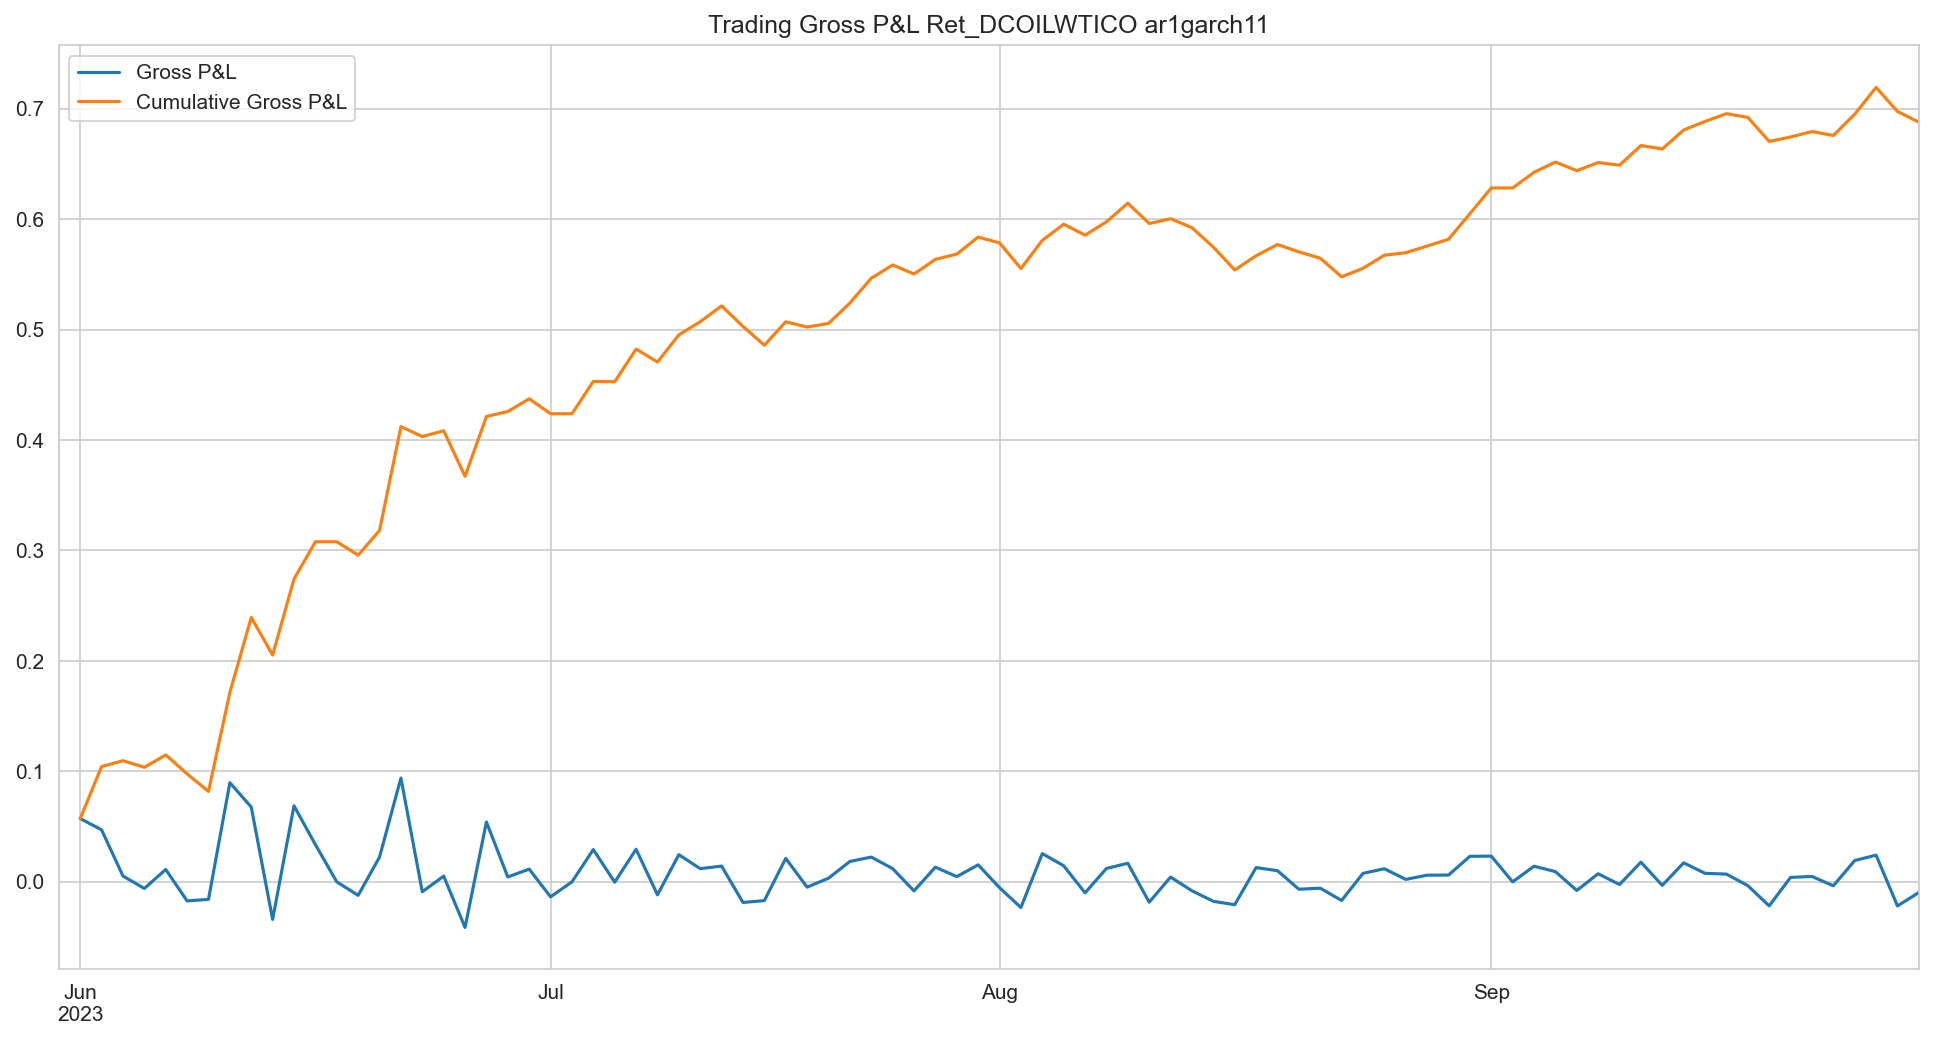

In [49]:
ar1garch11_strat.pnl_gross()

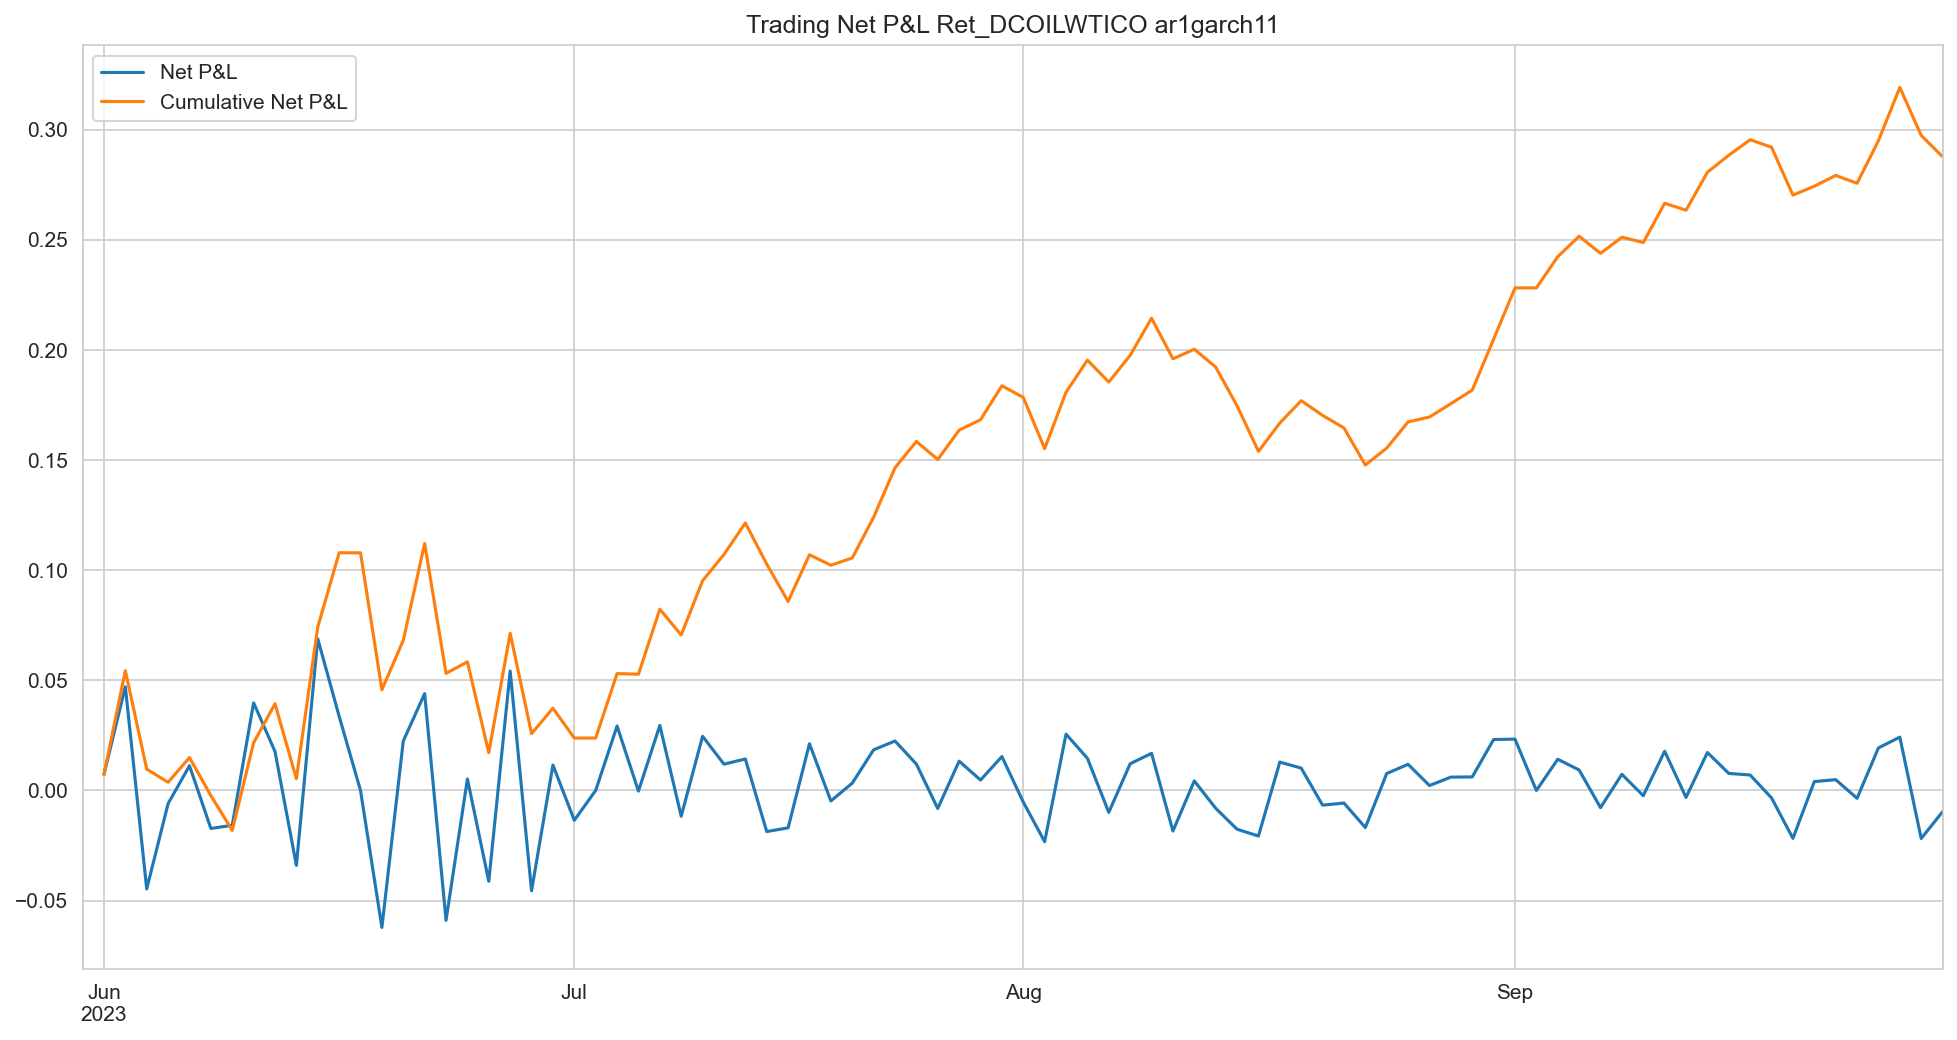

In [50]:
ar1garch11_strat.pnl_net()

In [51]:
ar1garch11_strat.sr()

Metric     Value
0  SR Gross  5.298749
1    SR Net  2.346962

# Brent

In [52]:
analysis_brent = analysis(returns, 'Ret_DCOILBRENTEU')

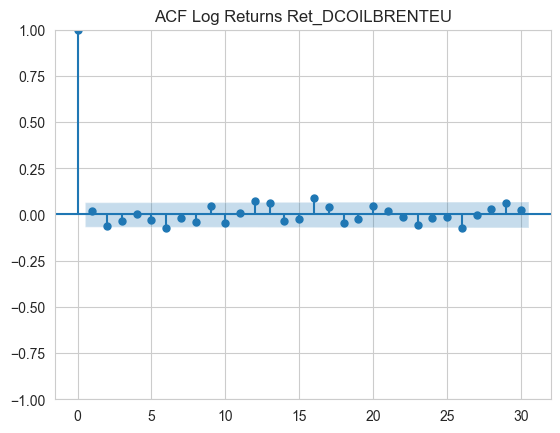

In [53]:
analysis_brent.acf_log_ret()

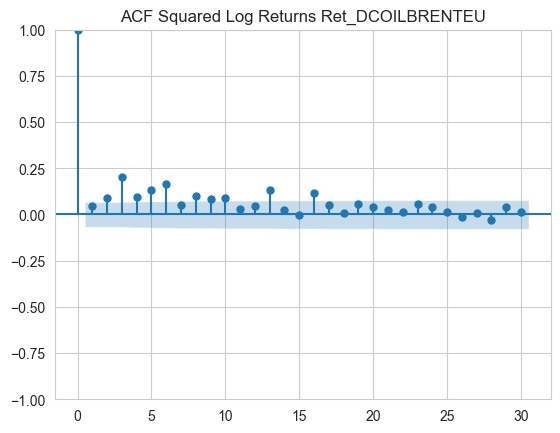

In [54]:
analysis_brent.acf_sq_log_ret()

In [55]:
analysis_brent.describe()

Ret_DCOILBRENTEU
nobs                  8.690000e+02
missing               0.000000e+00
mean                  1.103593e-03
std_err               8.105579e-04
upper_ci              2.692258e-03
lower_ci             -4.850707e-04
std                   2.389428e-02
iqr                   2.616460e-02
iqr_normal            1.939585e-02
mad                   1.741716e-02
mad_normal            2.182917e-02
coef_var              2.165134e+01
range                 2.146876e-01
max                   8.156369e-02
min                  -1.331239e-01
skew                 -6.813484e-01
kurtosis              6.035339e+00
jarque_bera           4.008344e+02
jarque_bera_pval      9.118138e-88
mode                  0.000000e+00
mode_freq             3.222094e-02
median                2.890342e-03
1%                   -6.926157e-02
5%                   -3.874637e-02
10%                  -2.734503e-02
25%                  -1.117330e-02
50%                   2.890342e-03
75%                   1.499130e-02
90%                   2.731108e-02
95%                   3.683849e-02
99%                   6.171122e-02

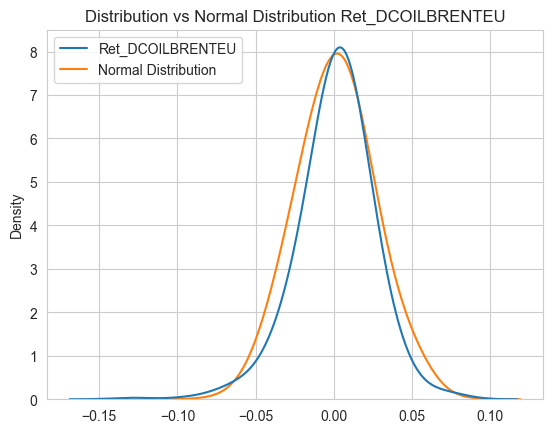

In [56]:
analysis_brent.asset_dist_v_norm()

In [57]:
analysis_brent.arch_test()

(71.151384548624,
 2.6561247135670444e-11,
 7.65837153406243,
 8.654903731717178e-12)

## Model Run

In [58]:
ar1garch11_brent = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILBRENTEU', 1)
ar1garch12_brent = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DCOILBRENTEU', 1)
ar1garch21_brent = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DCOILBRENTEU', 1)
ar2garch11_brent = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILBRENTEU', 2)
ar2garch12_brent = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DCOILBRENTEU', 2)
ar2garch21_brent = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DCOILBRENTEU', 2)
ar6garch11_brent = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILBRENTEU', 6)
ar6garch12_brent = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DCOILBRENTEU', 6)
ar6garch21_brent = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DCOILBRENTEU', 6)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 19809912100.09465
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5935942614.945461
Iteration:      3,   Func. Count:     31,   Neg. LLF: 807970.0835805152
Iteration:      4,   Func. Count:     43,   Neg. LLF: 337712.0836860247
Iteration:      5,   Func. Count:     56,   Neg. LLF: 9535.794586870179
Iteration:      6,   Func. Count:     66,   Neg. LLF: 1606598.4094703807
Iteration:      7,   Func. Count:     78,   Neg. LLF: 8764.755600895725
Iteration:      8,   Func. Count:     88,   Neg. LLF: 3619.226245725542
Iteration:      9,   Func. Count:     98,   Neg. LLF: 1244.937070444959
Iteration:     10,   Func. Count:    107,   Neg. LLF: -1814.0225869919934
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1814.0225868443388
            Iterations: 14
            Function evaluations: 107
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      8,   Neg. LLF: 23329564.86

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 13727626.66225388
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4898513.919802239
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1334052489.225953
Iteration:      4,   Func. Count:     44,   Neg. LLF: 6911.007501303135
Iteration:      5,   Func. Count:     57,   Neg. LLF: 1960.5121970181604
Iteration:      6,   Func. Count:     68,   Neg. LLF: 448554.4182556941
Iteration:      7,   Func. Count:     81,   Neg. LLF: 168301.05240764108
Iteration:      8,   Func. Count:     95,   Neg. LLF: 467572.3272268935
Iteration:      9,   Func. Count:    105,   Neg. LLF: 2241.6563478157823
Iteration:     10,   Func. Count:    116,   Neg. LLF: -234.05424586188377
Iteration:     11,   Func. Count:    126,   Neg. LLF: 452784.2002654384
Iteration:     12,   Func. Count:    138,   Neg. LLF: -1815.62658101049
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1815.6265809823324
            Iteration

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 18577678.201314844
Iteration:      2,   Func. Count:     23,   Neg. LLF: 5109218.117050874
Iteration:      3,   Func. Count:     37,   Neg. LLF: 14549048.68791239
Iteration:      4,   Func. Count:     51,   Neg. LLF: 2191472576461.4177
Iteration:      5,   Func. Count:     65,   Neg. LLF: 2956717.938211469
Iteration:      6,   Func. Count:     80,   Neg. LLF: 3158690735750.292
Iteration:      7,   Func. Count:     93,   Neg. LLF: 5224.751795898434
Iteration:      8,   Func. Count:    105,   Neg. LLF: -1813.762034234208
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1813.7620351766732
            Iterations: 12
            Function evaluations: 105
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      9,   Neg. LLF: 1.2843229220412438e+17
Iteration:      2,   Func. Count:     23,   Neg. LLF: 22068206.239625715
Iteration:      3,   Func. Count:     37,   Neg. LLF: 428382

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005961. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005961. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 28884628.50460867
Iteration:      2,   Func. Count:     29,   Neg. LLF: 327938.614833764
Iteration:      3,   Func. Count:     43,   Neg. LLF: 11358805.06354439
Iteration:      4,   Func. Count:     60,   Neg. LLF: 18466888518.795036
Iteration:      5,   Func. Count:     77,   Neg. LLF: 2717.034891314944
Iteration:      6,   Func. Count:     91,   Neg. LLF: -740.3326764335054
Iteration:      7,   Func. Count:    105,   Neg. LLF: 695044.1063460239
Iteration:      8,   Func. Count:    122,   Neg. LLF: 5692.811558738487
Iteration:      9,   Func. Count:    136,   Neg. LLF: 243206.88672343807
Iteration:     10,   Func. Count:    154,   Neg. LLF: 2769.107561492444
Iteration:     11,   Func. Count:    167,   Neg. LLF: -1807.4521074850218
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1807.4521072723478
            Iterations: 15
            Function evaluations: 167
            Gradient evaluati

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005961. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [59]:
runs = [ar1garch11_brent, ar1garch12_brent, ar1garch21_brent, ar2garch11_brent, ar2garch12_brent, ar2garch21_brent, ar6garch11_brent, ar6garch12_brent, ar6garch21_brent]

for i, ic in enumerate(runs):
    ic_append = ic.info_crit()
    ic_append['Model'] = ic.specs()
    
    if i == 0:
        ics = ic_append
    else:
        ics = pd.concat([ics, ic_append])

cols = ics.columns.tolist()
cols = cols[-1:] + cols[:-1]
ics = ics[cols]
ics

Model          AIC          BIC
0  ar1garch11 -3618.045174 -3594.748704
0  ar1garch12 -3616.999325 -3589.043561
0  ar1garch21 -3619.253162 -3591.297398
0  ar2garch11 -3614.828095 -3586.880029
0  ar2garch12 -3613.524070 -3580.917993
0  ar2garch21 -3616.608381 -3584.002303
0  ar6garch11 -3594.904215 -3548.375584
0  ar6garch12 -3593.450892 -3542.269399
0  ar6garch21 -3595.691896 -3544.510403

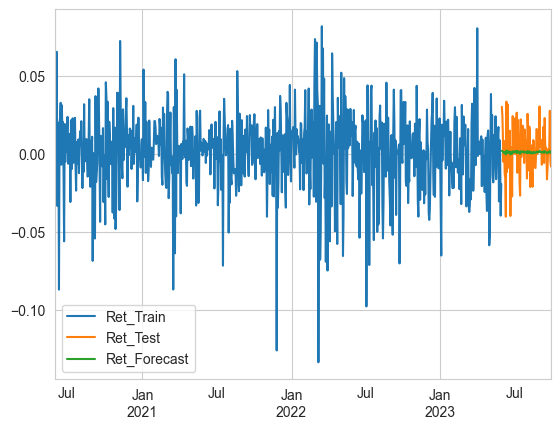

In [60]:
ar1garch21_brent.forecast_vs_test_mean_plot()

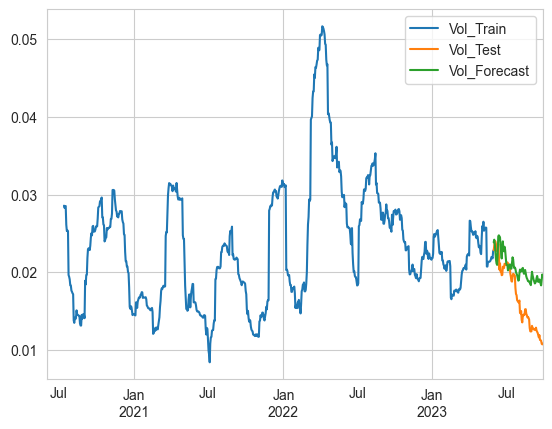

In [61]:
ar1garch21_brent.forecast_vs_test_vol_plot()

In [62]:
ar1garch21_brent_strat = strategy('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DCOILBRENTEU', 1)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 13727626.66225388
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4898513.919802239
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1334052489.225953
Iteration:      4,   Func. Count:     44,   Neg. LLF: 6911.007501303135
Iteration:      5,   Func. Count:     57,   Neg. LLF: 1960.5121970181604
Iteration:      6,   Func. Count:     68,   Neg. LLF: 448554.4182556941
Iteration:      7,   Func. Count:     81,   Neg. LLF: 168301.05240764108
Iteration:      8,   Func. Count:     95,   Neg. LLF: 467572.3272268935
Iteration:      9,   Func. Count:    105,   Neg. LLF: 2241.6563478157823
Iteration:     10,   Func. Count:    116,   Neg. LLF: -234.05424586188377
Iteration:     11,   Func. Count:    126,   Neg. LLF: 452784.2002654384
Iteration:     12,   Func. Count:    138,   Neg. LLF: -1815.62658101049
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1815.6265809823324
            Iteration

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


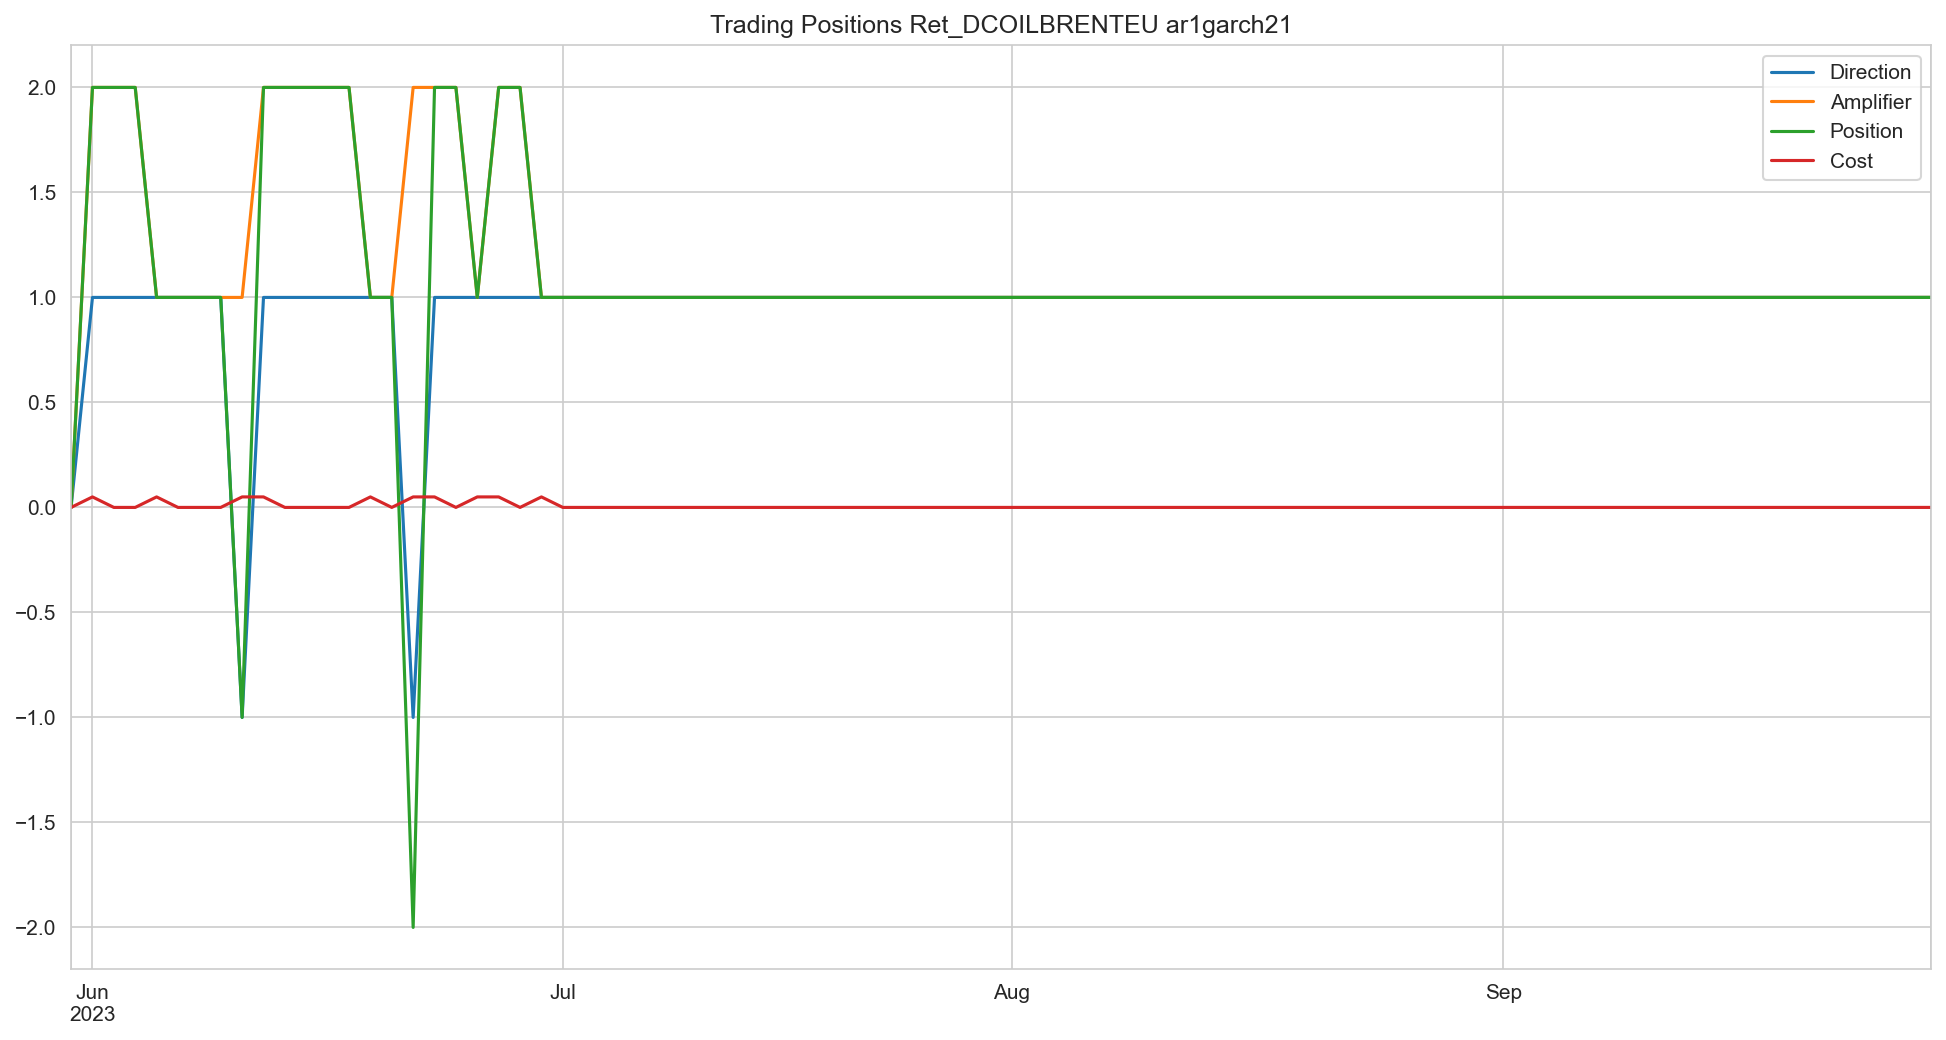

In [63]:
ar1garch21_brent_strat.pos()

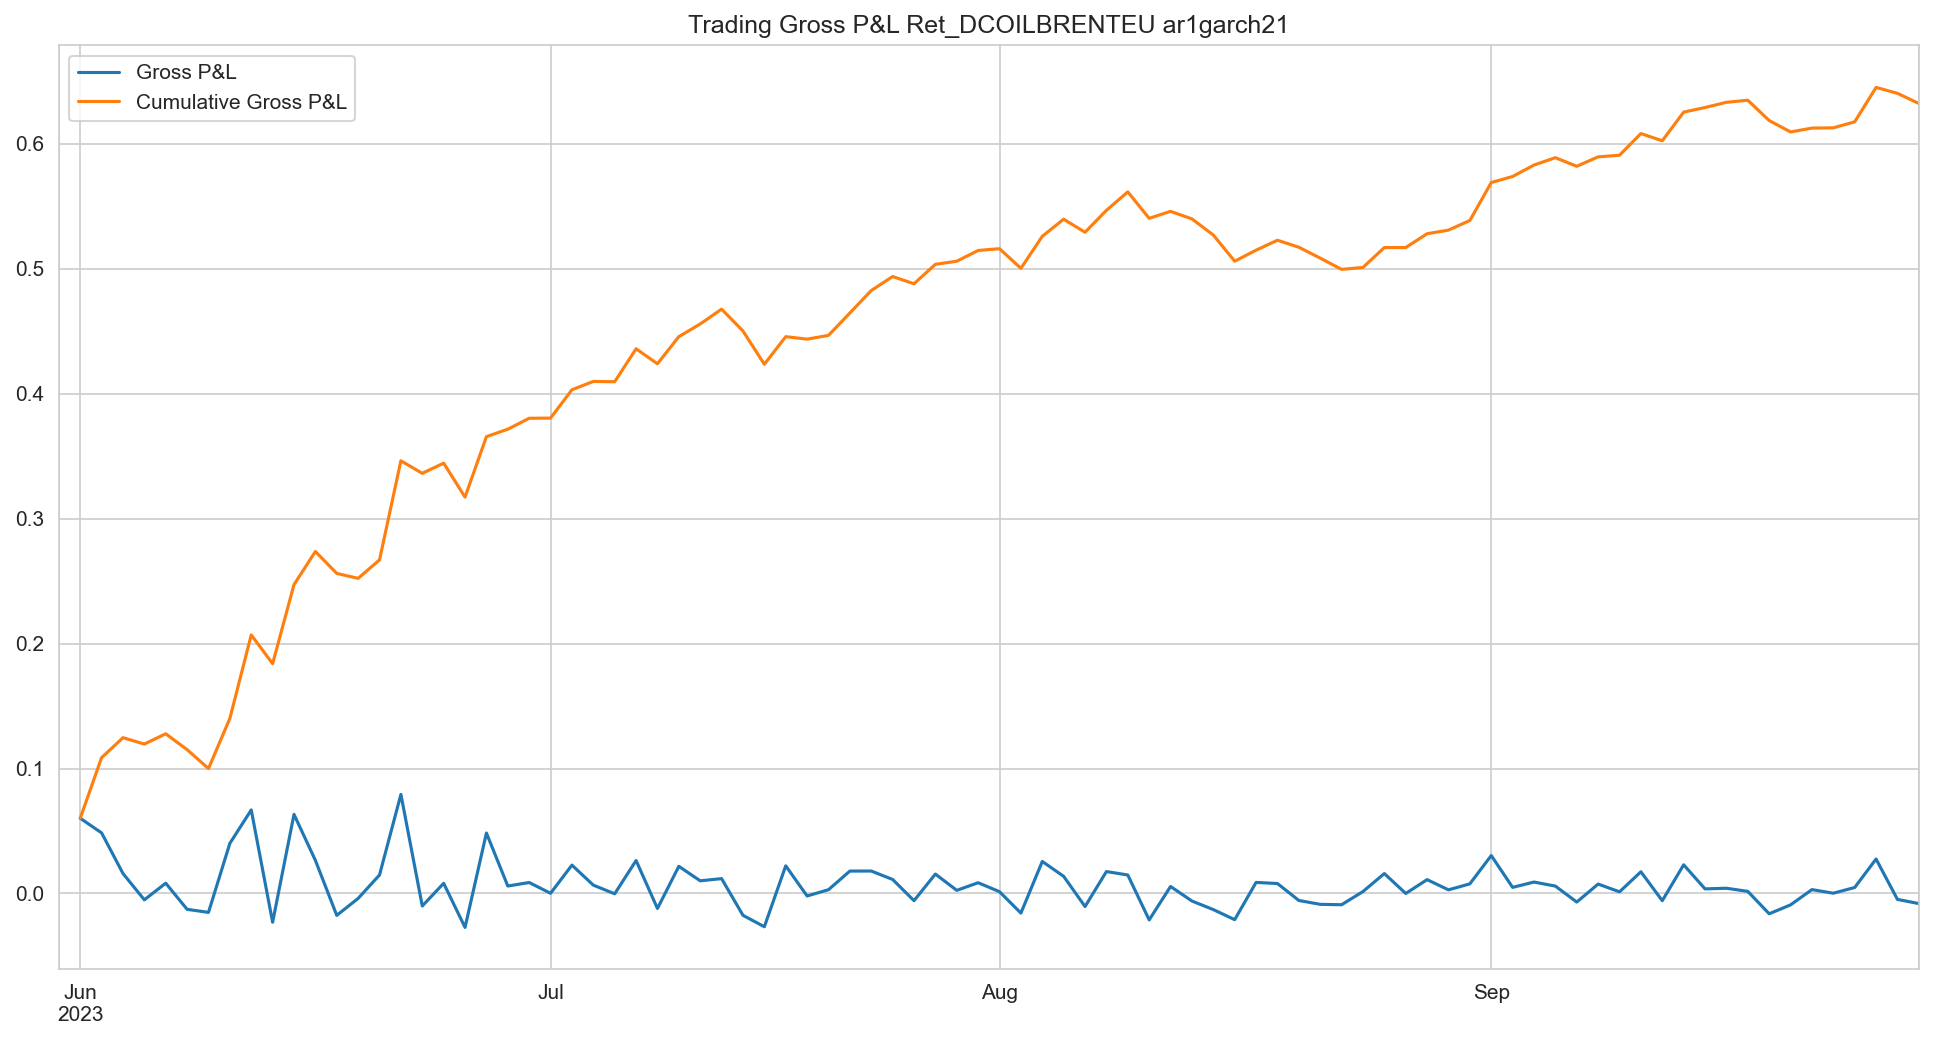

In [64]:
ar1garch21_brent_strat.pnl_gross()

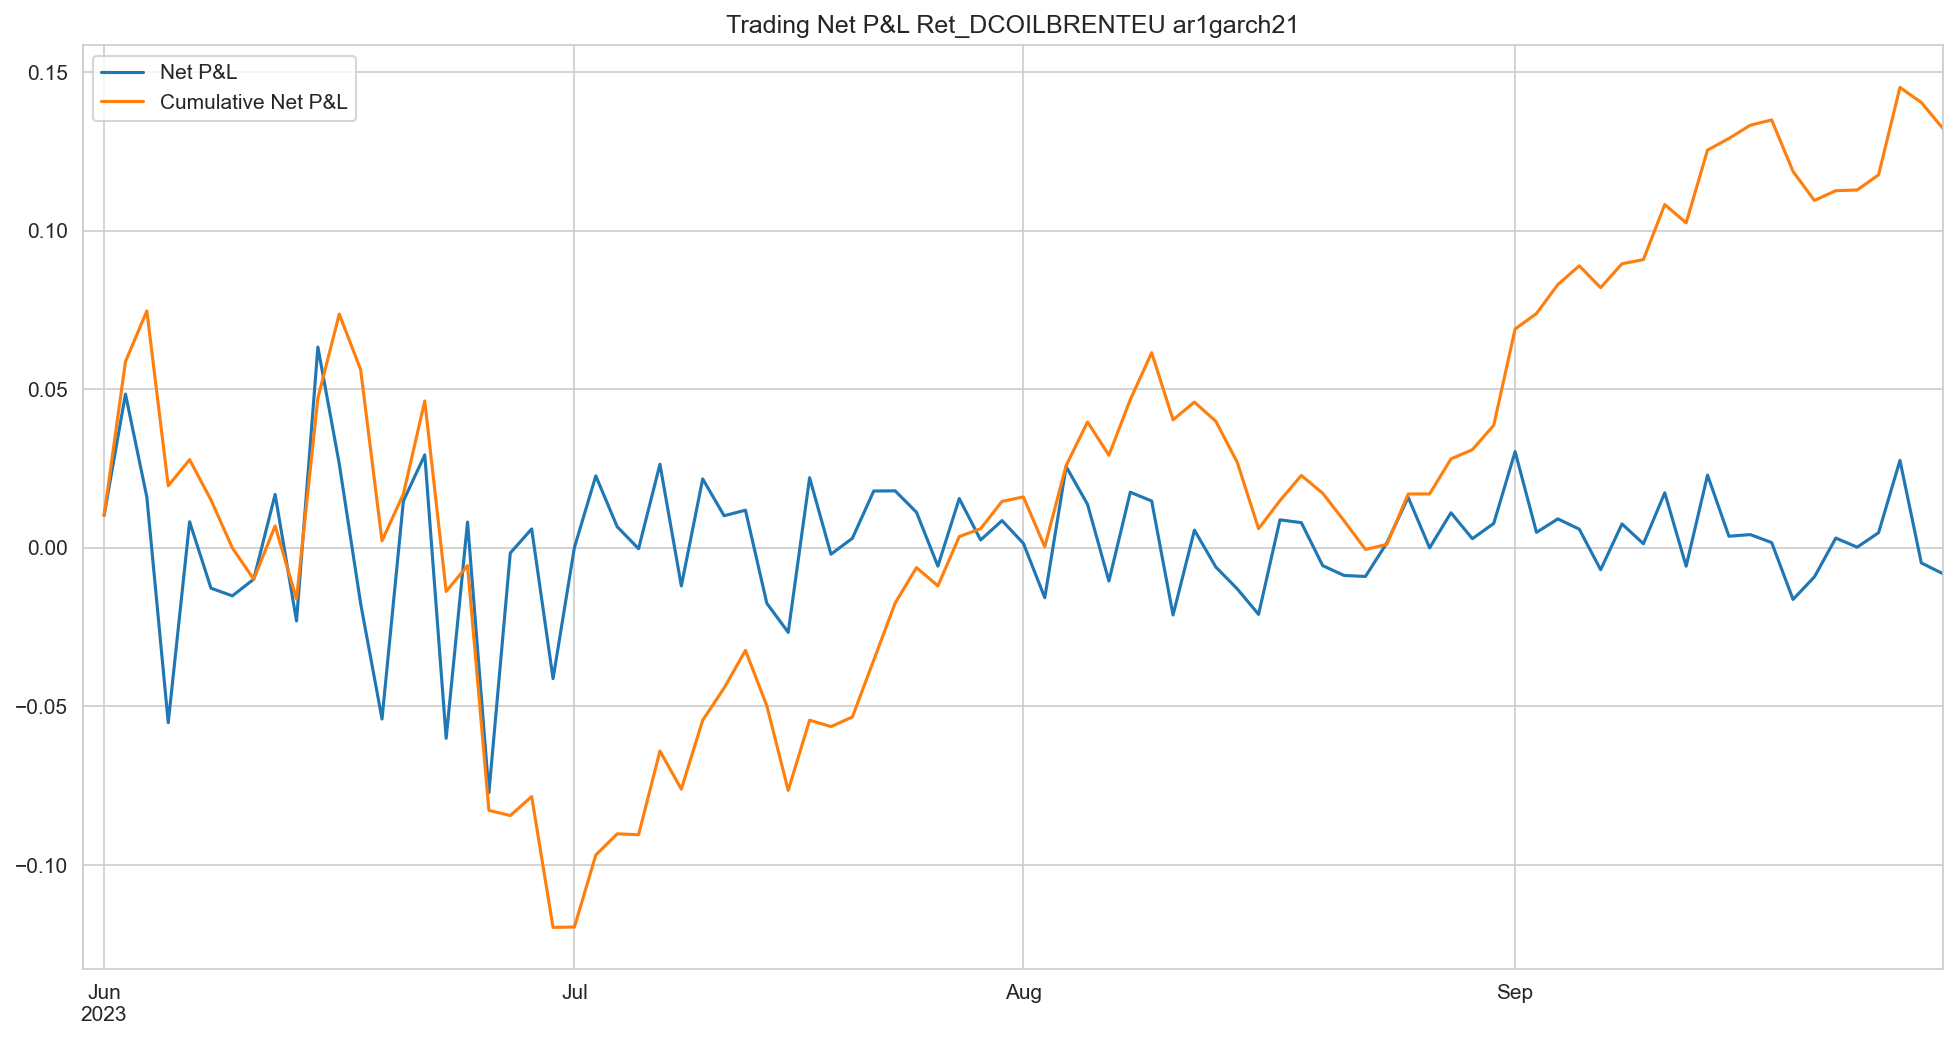

In [65]:
ar1garch21_brent_strat.pnl_net()

In [66]:
ar1garch21_brent_strat.sr()

Metric     Value
0  SR Gross  5.727575
1    SR Net  1.140769

# HH

In [67]:
analysis_hh = analysis(returns, 'Ret_DHHNGSP')

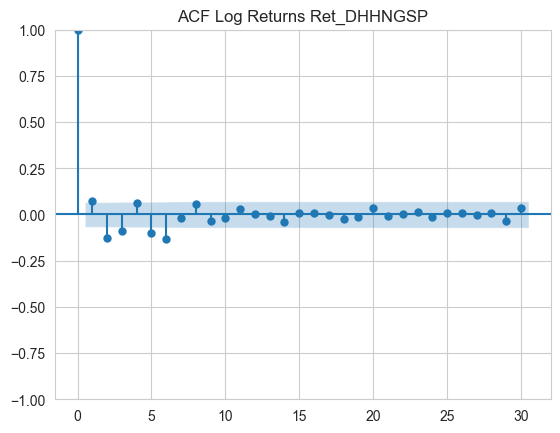

In [68]:
analysis_hh.acf_log_ret()

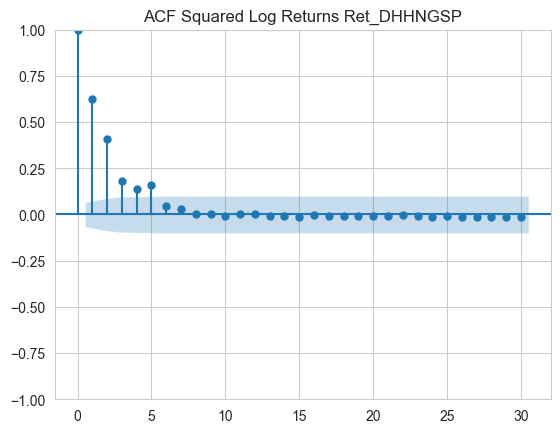

In [69]:
analysis_hh.acf_sq_log_ret()

In [70]:
analysis_hh.describe()

Ret_DHHNGSP
nobs                869.000000
missing               0.000000
mean                  0.000601
std_err               0.002907
upper_ci              0.006298
lower_ci             -0.005096
std                   0.085688
iqr                   0.053883
iqr_normal            0.039944
mad                   0.046598
mad_normal            0.058401
coef_var            142.627224
range                 1.770736
max                   0.745632
min                  -1.025103
skew                 -0.826332
kurtosis             41.108365
jarque_bera       52682.356110
jarque_bera_pval      0.000000
mode                  0.000000
mode_freq             0.085155
median                0.000000
1%                   -0.184157
5%                   -0.098762
10%                  -0.071302
25%                  -0.026268
50%                   0.000000
75%                   0.027615
90%                   0.067775
95%                   0.099016
99%                   0.254168

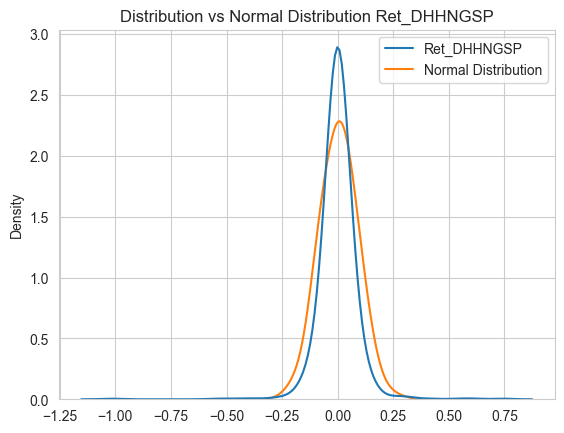

In [71]:
analysis_hh.asset_dist_v_norm()

In [72]:
analysis_hh.arch_test()

(387.35041526769004,
 4.6240935576678085e-77,
 69.64347320128137,
 2.3037831334601217e-103)

In [73]:
ar1garch11_hh = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DHHNGSP', 1)
ar1garch12_hh = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DHHNGSP', 1)
ar1garch21_hh = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DHHNGSP', 1)
ar2garch11_hh = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DHHNGSP', 2)
ar2garch12_hh = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DHHNGSP', 2)
ar2garch21_hh = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DHHNGSP', 2)
ar3garch11_hh = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DHHNGSP', 3)
ar3garch12_hh = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DHHNGSP', 3)
ar3garch21_hh = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DHHNGSP', 3)
ar5garch11_hh = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DHHNGSP', 5)
ar5garch12_hh = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DHHNGSP', 5)
ar5garch21_hh = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DHHNGSP', 5)
ar6garch11_hh = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DHHNGSP', 6)
ar6garch12_hh = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DHHNGSP', 6)
ar6garch21_hh = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_DHHNGSP', 6)

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007821. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007821. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 5130142.656678334
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2362.1691566632935
Iteration:      3,   Func. Count:     29,   Neg. LLF: 937210291.1184037
Iteration:      4,   Func. Count:     38,   Neg. LLF: -648.6165565019292
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1071.4245165788484
Iteration:      6,   Func. Count:     52,   Neg. LLF: -1075.0550412225089
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1075.3751605738728
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1075.3981213634024
Iteration:      9,   Func. Count:     70,   Neg. LLF: -1075.398457971471
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1075.3984757204016
Iteration:     11,   Func. Count:     82,   Neg. LLF: -1075.398476148354
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1075.398476148354
            Iterations: 11
            Function evaluations: 82
            Gradient 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007821. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007666. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 5210524.8405899685
Iteration:      2,   Func. Count:     21,   Neg. LLF: 3544.123296513176
Iteration:      3,   Func. Count:     32,   Neg. LLF: 514720436.6393017
Iteration:      4,   Func. Count:     42,   Neg. LLF: -575.42596915266
Iteration:      5,   Func. Count:     50,   Neg. LLF: -1031.8554489486814
Iteration:      6,   Func. Count:     59,   Neg. LLF: -1075.3367280301154
Iteration:      7,   Func. Count:     66,   Neg. LLF: -1074.826213830385
Iteration:      8,   Func. Count:     74,   Neg. LLF: -1075.396780414156
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1075.3984349579412
Iteration:     10,   Func. Count:     88,   Neg. LLF: -1075.3984753163263
Iteration:     11,   Func. Count:     95,   Neg. LLF: -1075.3984770458621
Iteration:     12,   Func. Count:    102,   Neg. LLF: -1075.3984760221697
Iteration:     13,   Func. Count:    109,   Neg. LLF: -1075.398478647764
Optimization terminated successfully    (Exit mod

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007666. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007666. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 5553384.189614904
Iteration:      2,   Func. Count:     23,   Neg. LLF: 5171.425949565399
Iteration:      3,   Func. Count:     35,   Neg. LLF: 569923.1224026899
Iteration:      4,   Func. Count:     45,   Neg. LLF: 24389.674147131824
Iteration:      5,   Func. Count:     56,   Neg. LLF: -505.18361017165705
Iteration:      6,   Func. Count:     65,   Neg. LLF: -871.9022401309463
Iteration:      7,   Func. Count:     75,   Neg. LLF: -1075.9268515501753
Iteration:      8,   Func. Count:     83,   Neg. LLF: -969.6502788748211
Iteration:      9,   Func. Count:     93,   Neg. LLF: -1076.182538257654
Iteration:     10,   Func. Count:    101,   Neg. LLF: -1076.2079481588285
Iteration:     11,   Func. Count:    109,   Neg. LLF: -1076.208576817449
Iteration:     12,   Func. Count:    117,   Neg. LLF: -1076.2086182053306
Iteration:     13,   Func. Count:    135,   Neg. LLF: -1076.2085672184412
Iteration:     14,   Func. Count:    143,   Neg. 

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007628. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007628. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 118092480.46943831
Iteration:      2,   Func. Count:     25,   Neg. LLF: 5694692.129248287
Iteration:      3,   Func. Count:     37,   Neg. LLF: 2241.678913200486
Iteration:      4,   Func. Count:     48,   Neg. LLF: 141.11563843701435
Iteration:      5,   Func. Count:     58,   Neg. LLF: 3853.3800239355764
Iteration:      6,   Func. Count:     70,   Neg. LLF: 3972.5558411570737
Iteration:      7,   Func. Count:     82,   Neg. LLF: 970809.8210224286
Iteration:      8,   Func. Count:     97,   Neg. LLF: 2504.5950688639628
Iteration:      9,   Func. Count:    110,   Neg. LLF: 462568943.74393755
Iteration:     10,   Func. Count:    122,   Neg. LLF: 1892081.3433687158
Iteration:     11,   Func. Count:    134,   Neg. LLF: -760.7800730652295
Iteration:     12,   Func. Count:    144,   Neg. LLF: 273.26929284228623
Iteration:     13,   Func. Count:    155,   Neg. LLF: -1059.6904995427008
Iteration:     14,   Func. Count:    165,   Neg. LLF:

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007628. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007439. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 6786374.197876768
Iteration:      2,   Func. Count:     25,   Neg. LLF: 5324.221137604794
Iteration:      3,   Func. Count:     38,   Neg. LLF: 30044477.464983307
Iteration:      4,   Func. Count:     50,   Neg. LLF: 17771.893291555232
Iteration:      5,   Func. Count:     61,   Neg. LLF: 93529.33836822599
Iteration:      6,   Func. Count:     72,   Neg. LLF: 280478.66902900254
Iteration:      7,   Func. Count:     83,   Neg. LLF: -920.782187666556
Iteration:      8,   Func. Count:     94,   Neg. LLF: -1076.2173857374892
Iteration:      9,   Func. Count:    103,   Neg. LLF: -1075.7916797148334
Iteration:     10,   Func. Count:    113,   Neg. LLF: -1076.629416006149
Iteration:     11,   Func. Count:    122,   Neg. LLF: -1076.6663245605382
Iteration:     12,   Func. Count:    131,   Neg. LLF: -1076.6847919720285
Iteration:     13,   Func. Count:    140,   Neg. LLF: -1076.6854920593396
Iteration:     14,   Func. Count:    149,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007439. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     43,   Neg. LLF: 18963.631596893953
Iteration:      4,   Func. Count:     57,   Neg. LLF: 1511.0776756227742
Iteration:      5,   Func. Count:     70,   Neg. LLF: 3919.3607861768915
Iteration:      6,   Func. Count:     83,   Neg. LLF: 3048.1800499673964
Iteration:      7,   Func. Count:     96,   Neg. LLF: -734.7500611150813
Iteration:      8,   Func. Count:    108,   Neg. LLF: 32684.011745423843
Iteration:      9,   Func. Count:    122,   Neg. LLF: 103837.67212871139
Iteration:     10,   Func. Count:    135,   Neg. LLF: 1172.9460581106202
Iteration:     11,   Func. Count:    149,   Neg. LLF: 3372646.5347851384
Iteration:     12,   Func. Count:    161,   Neg. LLF: -1062.176653794021
Iteration:     13,   Func. Count:    173,   Neg. LLF: -1055.0420065149651
Iteration:     14,   Func. Count:    185,   Neg. LLF: -1076.6169715337655
Iteration:     15,   Func. Count:    197,   Neg. LLF: -1077.6576145369272
Iteration:     16,   Func. Count:    208,   Neg.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007439. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007349. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 7332747.561854921
Iteration:      2,   Func. Count:     29,   Neg. LLF: 10250.141738367445
Iteration:      3,   Func. Count:     44,   Neg. LLF: 441980.7747580449
Iteration:      4,   Func. Count:     61,   Neg. LLF: 71556.5237439535
Iteration:      5,   Func. Count:     76,   Neg. LLF: -1060.674915102615
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1060.6749191676295
            Iterations: 9
            Function evaluations: 76
            Gradient evaluations: 5
Iteration:      1,   Func. Count:     12,   Neg. LLF: 12303754.533727067
Iteration:      2,   Func. Count:     29,   Neg. LLF: 20039.797325946973
Iteration:      3,   Func. Count:     44,   Neg. LLF: 1318326.5819369957
Iteration:      4,   Func. Count:     58,   Neg. LLF: 34591.46857938262
Iteration:      5,   Func. Count:     71,   Neg. LLF: 7871.814832863831
Iteration:      6,   Func. Count:     84,   Neg. LLF: 7227.99750292

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007349. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     19,   Func. Count:    266,   Neg. LLF: -1077.1176843545786
Iteration:     20,   Func. Count:    278,   Neg. LLF: -1077.1177187279623
Iteration:     21,   Func. Count:    289,   Neg. LLF: -1077.1177188441625
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1077.1177187279623
            Iterations: 21
            Function evaluations: 289
            Gradient evaluations: 21
Iteration:      1,   Func. Count:     13,   Neg. LLF: 9937777.436207779
Iteration:      2,   Func. Count:     31,   Neg. LLF: 20851.109227345623
Iteration:      3,   Func. Count:     47,   Neg. LLF: 3568748.612120285
Iteration:      4,   Func. Count:     62,   Neg. LLF: 9928.342968325705
Iteration:      5,   Func. Count:     75,   Neg. LLF: 1445.850042497372
Iteration:      6,   Func. Count:     90,   Neg. LLF: 1447.5916191623073
Iteration:      7,   Func. Count:    105,   Neg. LLF: -608.9264400846547
Iteration:      8,   Func. Count:    119,   Neg. LLF: 5268.

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007349. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     19,   Func. Count:    265,   Neg. LLF: -1074.435994385654
Iteration:     20,   Func. Count:    277,   Neg. LLF: -1074.435995116514
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1074.435995116514
            Iterations: 20
            Function evaluations: 277
            Gradient evaluations: 20


In [74]:
runs = [ar1garch11_hh, ar1garch12_hh, ar1garch21_hh, ar2garch11_hh, ar2garch12_hh, ar2garch21_hh, ar3garch11_hh, ar3garch12_hh, ar3garch21_hh, ar5garch11_hh, ar5garch12_hh, ar5garch21_hh, ar6garch11_hh, ar6garch12_hh, ar6garch21_hh]

for i, ic in enumerate(runs):
    ic_append = ic.info_crit()
    ic_append['Model'] = ic.specs()
    
    if i == 0:
        ics = ic_append
    else:
        ics = pd.concat([ics, ic_append])

cols = ics.columns.tolist()
cols = cols[-1:] + cols[:-1]
ics = ics[cols]
ics

Model          AIC          BIC
0  ar1garch11 -2140.796952 -2117.500483
0  ar1garch12 -2143.980432 -2116.024669
0  ar1garch21 -2138.796953 -2110.841189
0  ar2garch11 -2140.417113 -2112.469046
0  ar2garch12 -2143.310974 -2110.704897
0  ar2garch21 -2138.417123 -2105.811046
0  ar3garch11 -2139.371030 -2106.773944
0  ar3garch12 -2142.178354 -2104.924542
0  ar3garch21 -2137.371025 -2100.117213
0  ar5garch11 -2132.150315 -2090.262942
0  ar5garch12 -2135.349025 -2088.807499
0  ar5garch21 -2101.349838 -2054.808313
0  ar6garch11 -2128.871990 -2082.343360
0  ar6garch12 -2132.235437 -2081.053944
0  ar6garch21 -2126.871990 -2075.690497

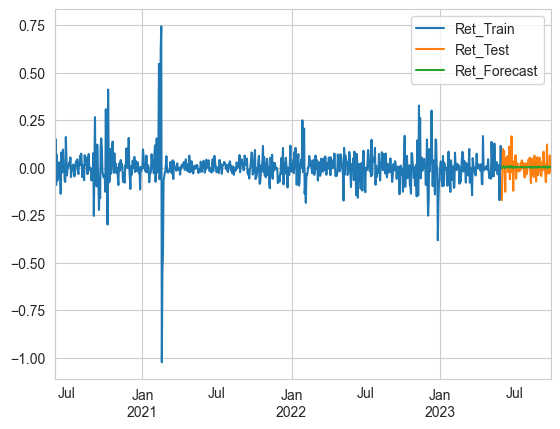

In [75]:
ar1garch12_hh.forecast_vs_test_mean_plot()

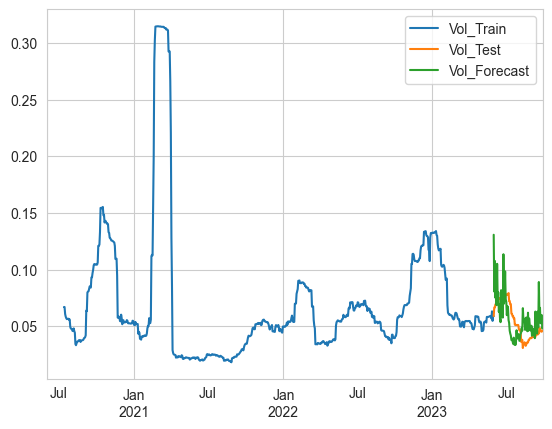

In [76]:
ar1garch12_hh.forecast_vs_test_vol_plot()

In [77]:
ar1garch12_hh_strat = strategy('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_DHHNGSP', 1)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 45896925.94794963
Iteration:      2,   Func. Count:     21,   Neg. LLF: 14888.963783416712
Iteration:      3,   Func. Count:     31,   Neg. LLF: 81181.55317703835
Iteration:      4,   Func. Count:     39,   Neg. LLF: 3895.2520894946947
Iteration:      5,   Func. Count:     48,   Neg. LLF: 354.8801156725699
Iteration:      6,   Func. Count:     58,   Neg. LLF: -861.3209399916739
Iteration:      7,   Func. Count:     67,   Neg. LLF: -918.8491492623795
Iteration:      8,   Func. Count:     75,   Neg. LLF: -893.2967997863703
Iteration:      9,   Func. Count:     84,   Neg. LLF: -1031.5492662389556
Iteration:     10,   Func. Count:     92,   Neg. LLF: -1058.6538265369718
Iteration:     11,   Func. Count:    100,   Neg. LLF: -1077.8871751367715
Iteration:     12,   Func. Count:    108,   Neg. LLF: -1077.9899909250225
Iteration:     13,   Func. Count:    115,   Neg. LLF: -1077.990212291405
Iteration:     14,   Func. Count:    122,   Neg. L

C:\Users\afost\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007821. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


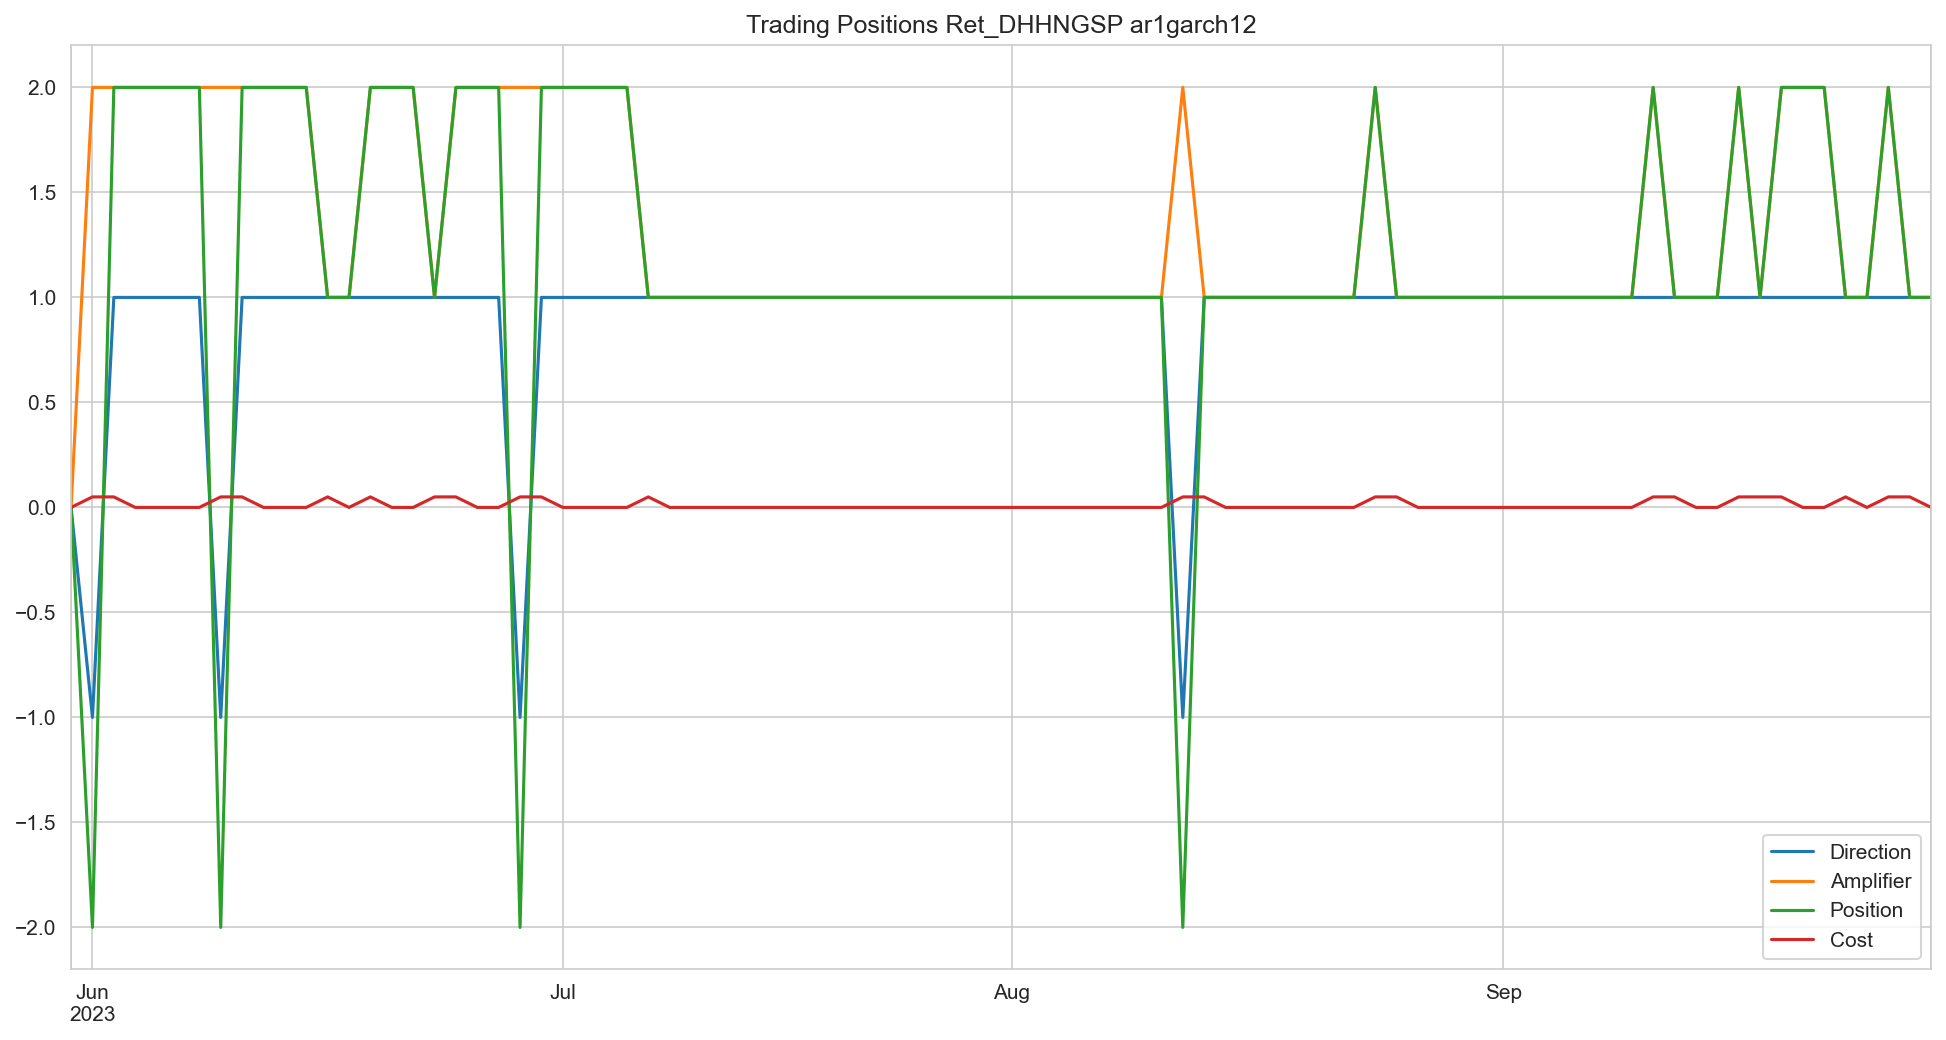

In [78]:
ar1garch12_hh_strat.pos()

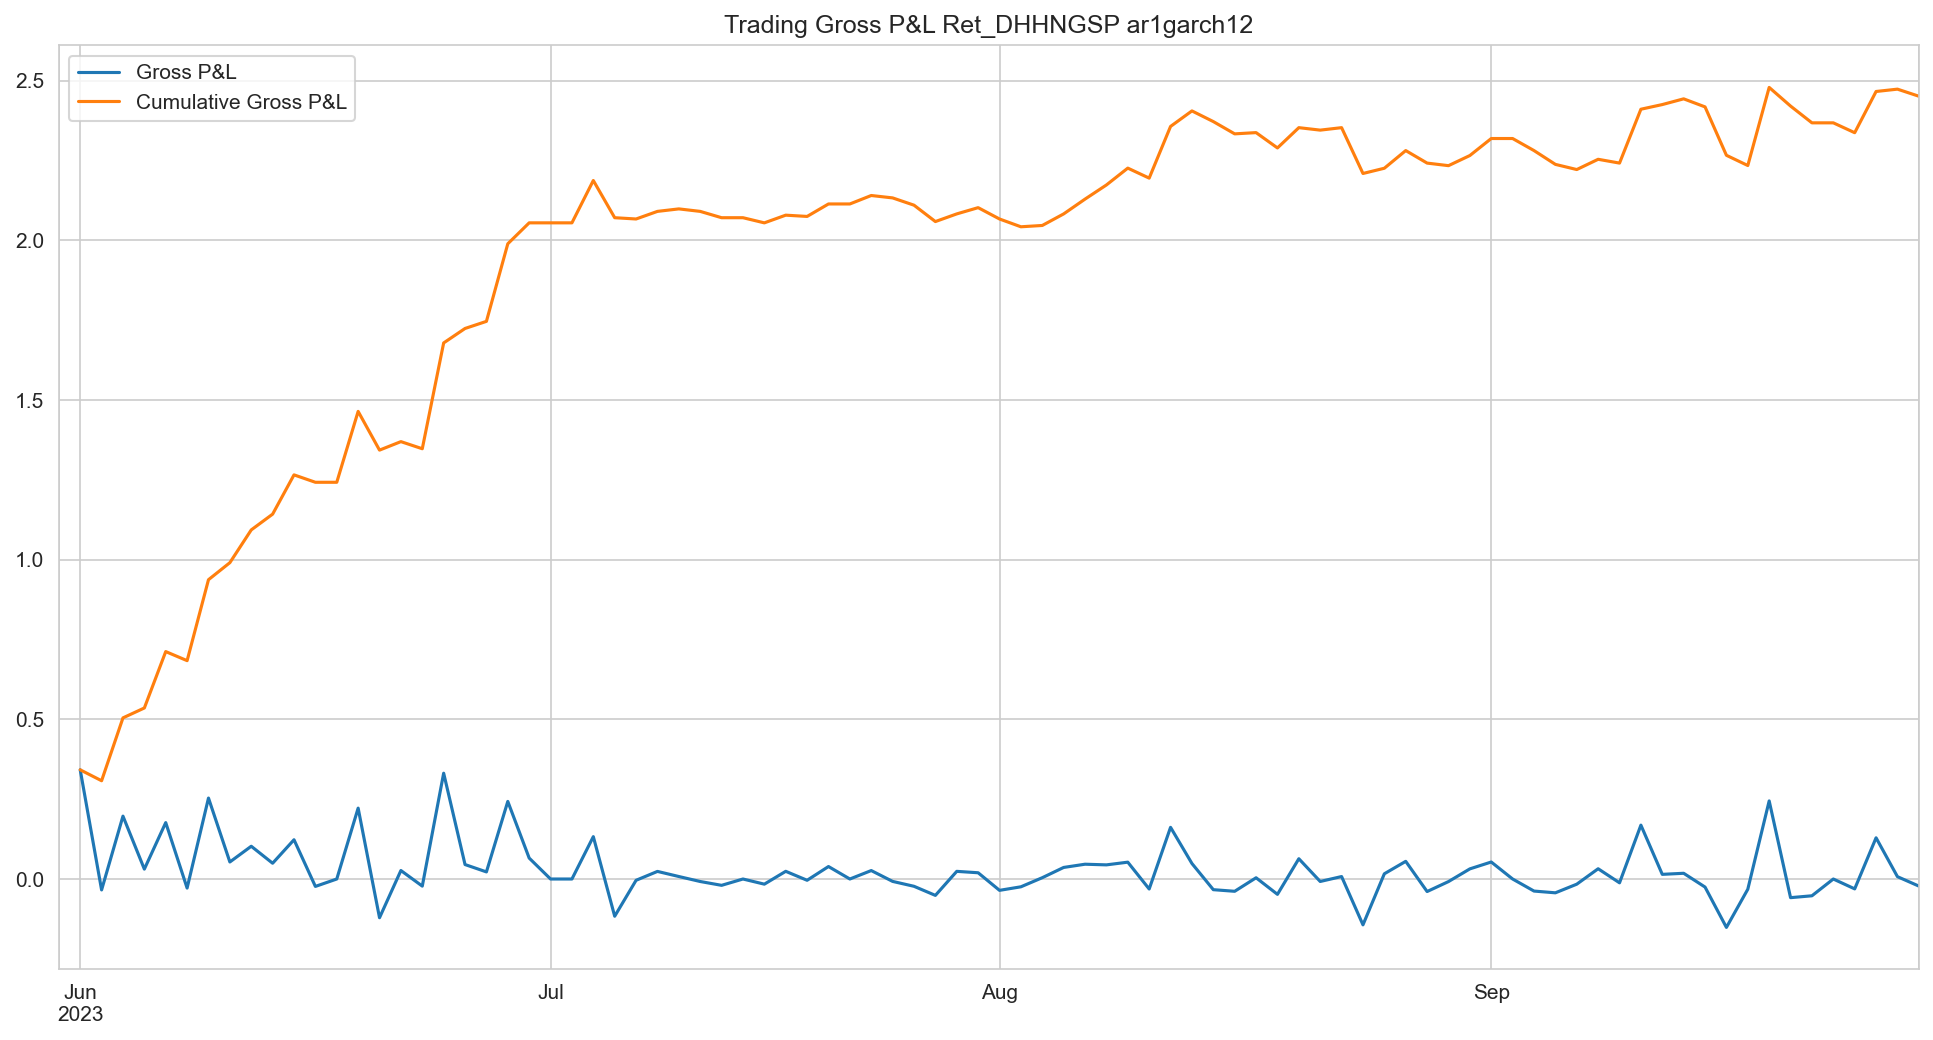

In [79]:
ar1garch12_hh_strat.pnl_gross()

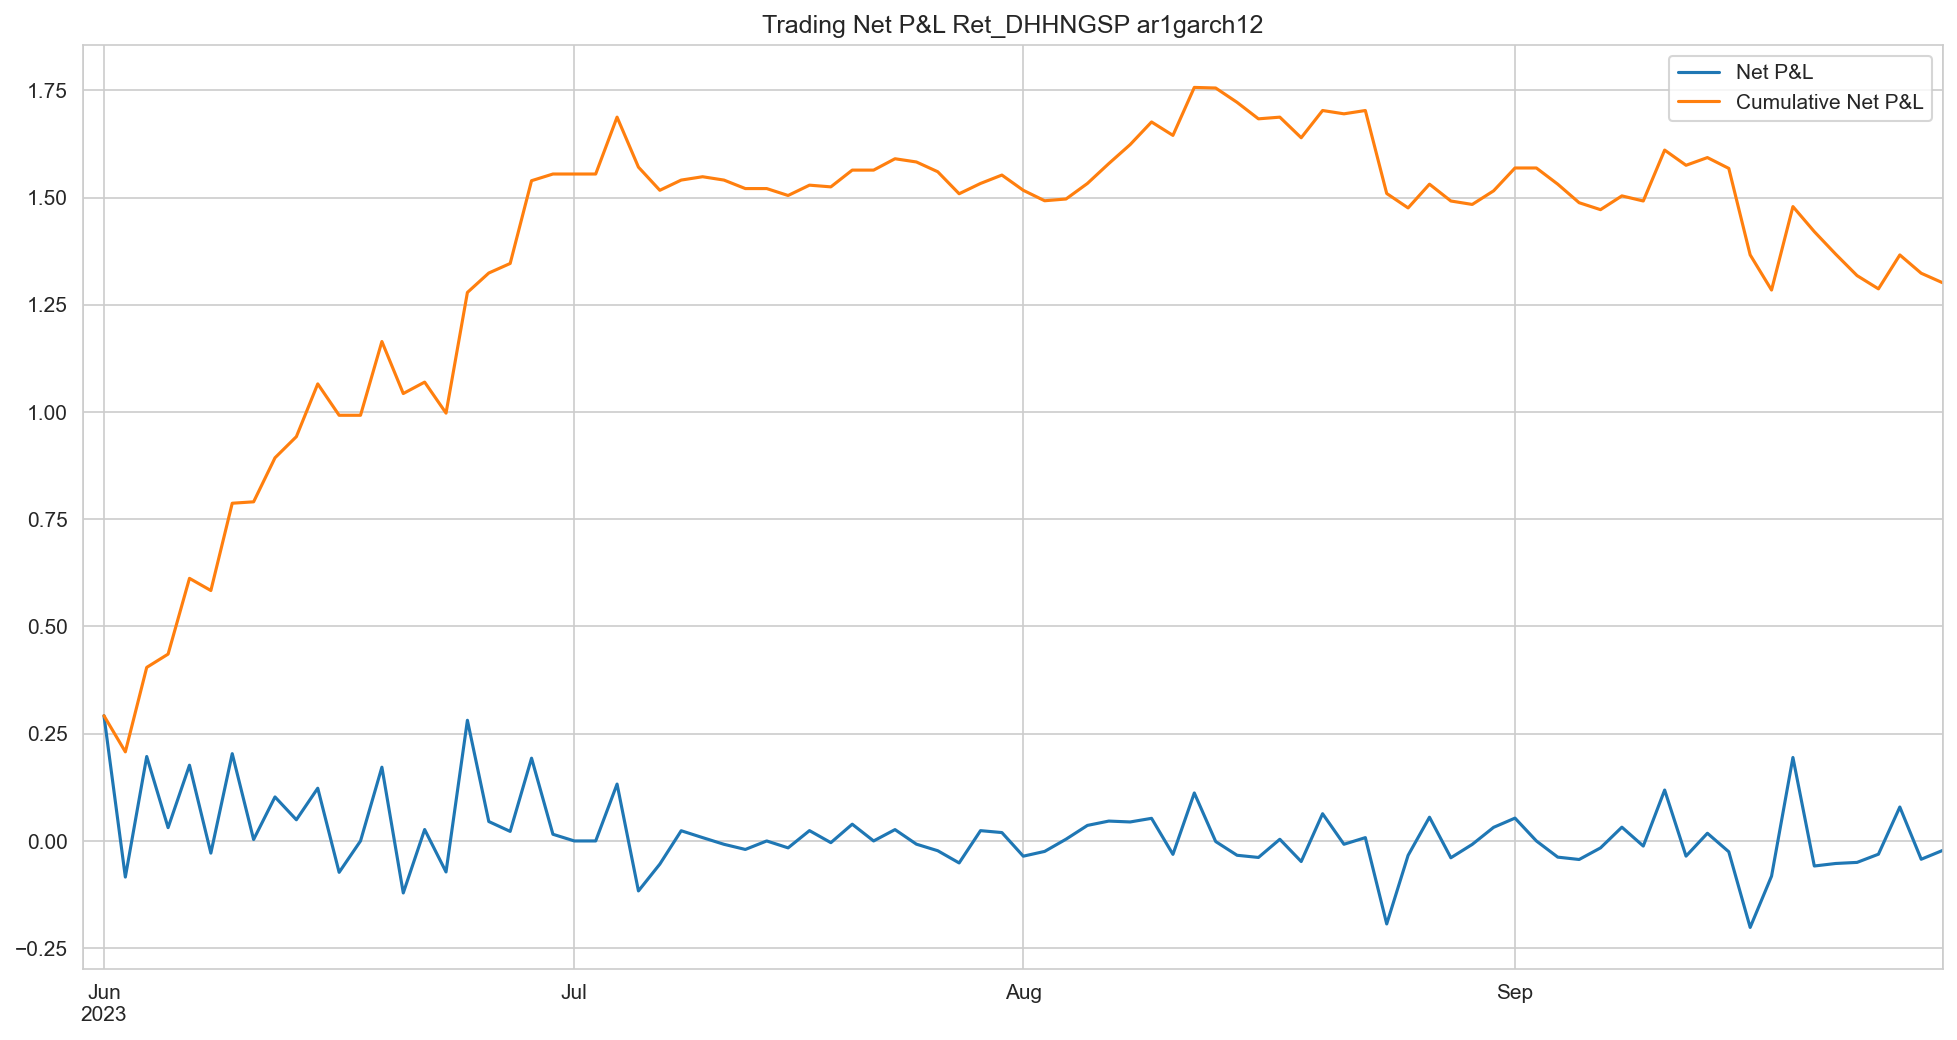

In [80]:
ar1garch12_hh_strat.pnl_net()

In [81]:
ar1garch12_hh_strat.sr()

Metric     Value
0  SR Gross  4.925994
1    SR Net  2.778739